In [4]:
pip install pycbc gwpy gwosc numpy scipy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
from numpy.fft import fft, fftfreq
from scipy.interpolate import interp1d
from gwpy.timeseries import TimeSeries
from pycbc.psd import aLIGOZeroDetHighPower
from astropy import units as u
import matplotlib.pyplot as plt
import tqdm

#### Configuration
sample_rate = 1024
delta_t = 1 / sample_rate
duration = 1.0
sig_duration = 0.1
n_samples = 10000
gps_start = 1126259456

### PSD for SNR normalization
psd = aLIGOZeroDetHighPower(int(sample_rate * duration // 2 + 1),
                             delta_f=1.0 / duration,
                             low_freq_cutoff=20)
psd_freqs = np.linspace(0, sample_rate / 2, len(psd))

### Signal generator
def cusp_signal(amplitude=9.85e-22, f_high=512, delta_t=1/1024, duration=0.1):
    fs = 1 / delta_t
    N = int(duration * fs)
    freqs = fftfreq(N, d=delta_t)
    h_f = np.zeros(N, dtype=complex)
    pos_mask = freqs > 0
    f_pos = freqs[pos_mask]
    spectrum = f_pos ** (-4/3)
    spectrum[f_pos >= f_high] *= np.exp(1 - f_pos[f_pos >= f_high] / f_high)
    h_f[pos_mask] = amplitude * spectrum
    h_f = h_f + np.conj(h_f[::-1])
    h_f *= np.exp(-2j * np.pi * freqs * (duration / 2))
    return np.fft.ifft(h_f).real

### SNR helper
def compute_standard_snr(signal, delta_t, psd, psd_freqs):
    N = len(signal)
    df = 1.0 / (N * delta_t)
    freqs = fftfreq(N, delta_t)
    signal_f = fft(signal)
    mask = freqs > 0
    freqs = freqs[mask]
    signal_f = signal_f[mask]
    psd_interp = interp1d(psd_freqs, psd, bounds_error=False, fill_value="extrapolate")
    psd_vals = np.maximum(psd_interp(freqs), 1e-40)
    snr_squared = 4 * np.sum((np.abs(signal_f) ** 2) / psd_vals) * df
    return np.sqrt(snr_squared)

### Dataset containers
X = np.zeros((n_samples, int(sample_rate * duration)), dtype=np.float32)
y = np.ones(n_samples, dtype=np.int32)
snrs = []
f_highs = []

print("Generating dataset with cusp injections and whitening...")
for i in tqdm.tqdm(range(n_samples)):
    gps_offset = i
    try:
        # Fetch real LIGO strain data
        strain = TimeSeries.fetch_open_data('H1',
                                            gps_start + gps_offset,
                                            gps_start + gps_offset + duration)
        strain = strain.crop(strain.t0, strain.t0 + duration * u.s)
        strain = strain.resample(sample_rate)

        # Convert to array
        noise = strain.value
    except Exception as e:
        print(f"Skipping sample {i} due to error: {e}")
        continue

    ### Generate and scale cusp signal
    snr_target = np.random.uniform(5, 20)
    f_high = np.random.uniform(20, 512)
    signal = cusp_signal(delta_t=delta_t, duration=sig_duration, f_high=f_high)
    snr_measured = compute_standard_snr(signal, delta_t, psd, psd_freqs)
    signal *= snr_target / snr_measured

    ### Inject signal into noise
    injected = noise.copy()
    start = (len(injected) - len(signal)) // 2
    injected[start:start + len(signal)] += signal

    ### Convert to TimeSeries for whitening
    injected_ts = TimeSeries(injected, dt=delta_t)

    ### Apply whitening (also includes highpass=20Hz)
    injected_hp = injected_ts.highpass(20)
    injected_whitened = injected_hp.whiten(fftlength=0.25)

    ### Normalize 
    normalized = (injected_whitened.value - np.mean(injected_whitened.value)) / np.std(injected_whitened.value)
    X[i] = normalized
    snrs.append(snr_target)
    f_highs.append(f_high)

    print(f"Injected sample {i} | SNR: {snr_target:.2f} | f_high: {f_high:.1f}")


#### Save
np.savez_compressed("cusp_real_noise_whitened.npz", X=X, y=y, snr=snrs, f_high=f_highs)
print("Dataset saved as cusp_real_noise_whitened.npz")


/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


Generating dataset with cusp injections and whitening...


  0%|          | 1/10000 [00:00<1:23:47,  1.99it/s]

Injected sample 0 | SNR: 18.66 | f_high: 56.0


  0%|          | 2/10000 [00:00<1:07:54,  2.45it/s]

Injected sample 1 | SNR: 19.39 | f_high: 77.2


  0%|          | 3/10000 [00:01<1:00:14,  2.77it/s]

Injected sample 2 | SNR: 16.06 | f_high: 107.8


  0%|          | 4/10000 [00:01<1:00:20,  2.76it/s]

Injected sample 3 | SNR: 13.44 | f_high: 342.3


  0%|          | 5/10000 [00:02<1:17:39,  2.15it/s]

Injected sample 4 | SNR: 14.63 | f_high: 464.8


  0%|          | 7/10000 [00:02<56:01,  2.97it/s]  

Injected sample 5 | SNR: 10.64 | f_high: 444.7
Injected sample 6 | SNR: 12.36 | f_high: 59.2


  0%|          | 9/10000 [00:02<39:05,  4.26it/s]

Injected sample 7 | SNR: 11.46 | f_high: 343.0
Injected sample 8 | SNR: 13.25 | f_high: 290.3


  0%|          | 11/10000 [00:03<33:02,  5.04it/s]

Injected sample 9 | SNR: 17.51 | f_high: 203.2
Injected sample 10 | SNR: 10.01 | f_high: 421.4


  0%|          | 12/10000 [00:03<32:36,  5.11it/s]

Injected sample 11 | SNR: 13.99 | f_high: 116.9


  0%|          | 13/10000 [00:03<35:20,  4.71it/s]

Injected sample 12 | SNR: 5.28 | f_high: 176.9


  0%|          | 15/10000 [00:04<31:34,  5.27it/s]

Injected sample 13 | SNR: 7.85 | f_high: 277.7
Injected sample 14 | SNR: 5.90 | f_high: 478.7


  0%|          | 17/10000 [00:04<27:19,  6.09it/s]

Injected sample 15 | SNR: 5.60 | f_high: 158.6
Injected sample 16 | SNR: 10.42 | f_high: 177.9


  0%|          | 18/10000 [00:04<30:40,  5.42it/s]

Injected sample 17 | SNR: 5.53 | f_high: 123.1


  0%|          | 20/10000 [00:05<36:12,  4.59it/s]

Injected sample 18 | SNR: 14.03 | f_high: 200.4
Injected sample 19 | SNR: 17.87 | f_high: 446.4


  0%|          | 21/10000 [00:05<35:37,  4.67it/s]

Injected sample 20 | SNR: 10.36 | f_high: 213.3


  0%|          | 23/10000 [00:05<33:16,  5.00it/s]

Injected sample 21 | SNR: 14.15 | f_high: 270.1
Injected sample 22 | SNR: 6.55 | f_high: 166.8


  0%|          | 24/10000 [00:11<5:34:06,  2.01s/it]

Injected sample 23 | SNR: 10.44 | f_high: 243.8


  0%|          | 25/10000 [00:18<9:31:05,  3.44s/it]

Injected sample 24 | SNR: 18.82 | f_high: 354.5


  0%|          | 26/10000 [00:23<10:30:11,  3.79s/it]

Injected sample 25 | SNR: 10.95 | f_high: 488.4


  0%|          | 27/10000 [00:28<11:31:44,  4.16s/it]

Injected sample 26 | SNR: 16.89 | f_high: 96.8


  0%|          | 28/10000 [00:33<12:42:14,  4.59s/it]

Injected sample 27 | SNR: 7.57 | f_high: 154.3


  0%|          | 29/10000 [00:38<12:25:45,  4.49s/it]

Injected sample 28 | SNR: 6.00 | f_high: 386.4


  0%|          | 30/10000 [00:43<12:49:05,  4.63s/it]

Injected sample 29 | SNR: 10.32 | f_high: 38.7


  0%|          | 31/10000 [00:46<11:24:40,  4.12s/it]

Injected sample 30 | SNR: 8.69 | f_high: 383.4


  0%|          | 32/10000 [00:49<10:52:50,  3.93s/it]

Injected sample 31 | SNR: 9.73 | f_high: 286.2


  0%|          | 33/10000 [00:52<10:21:51,  3.74s/it]

Injected sample 32 | SNR: 17.51 | f_high: 155.9


  0%|          | 34/10000 [00:56<10:02:07,  3.63s/it]

Injected sample 33 | SNR: 11.68 | f_high: 49.7


  0%|          | 35/10000 [01:01<11:16:19,  4.07s/it]

Injected sample 34 | SNR: 13.16 | f_high: 54.8


  0%|          | 36/10000 [01:04<10:30:48,  3.80s/it]

Injected sample 35 | SNR: 12.70 | f_high: 329.1


  0%|          | 37/10000 [01:08<10:36:53,  3.84s/it]

Injected sample 36 | SNR: 11.12 | f_high: 469.3


  0%|          | 38/10000 [01:13<11:33:26,  4.18s/it]

Injected sample 37 | SNR: 5.22 | f_high: 120.5


  0%|          | 39/10000 [01:17<11:06:17,  4.01s/it]

Injected sample 38 | SNR: 17.58 | f_high: 43.6


  0%|          | 40/10000 [01:21<11:25:31,  4.13s/it]

Injected sample 39 | SNR: 16.92 | f_high: 275.6


  0%|          | 41/10000 [01:25<11:26:53,  4.14s/it]

Injected sample 40 | SNR: 6.15 | f_high: 294.5


  0%|          | 42/10000 [01:28<10:11:31,  3.68s/it]

Injected sample 41 | SNR: 17.91 | f_high: 485.0


  0%|          | 43/10000 [01:32<10:47:28,  3.90s/it]

Injected sample 42 | SNR: 15.33 | f_high: 336.8


  0%|          | 44/10000 [01:36<11:10:47,  4.04s/it]

Injected sample 43 | SNR: 19.93 | f_high: 202.8


  0%|          | 45/10000 [01:42<12:08:13,  4.39s/it]

Injected sample 44 | SNR: 13.98 | f_high: 396.5


  0%|          | 46/10000 [01:46<12:19:42,  4.46s/it]

Injected sample 45 | SNR: 19.49 | f_high: 41.3


  0%|          | 47/10000 [01:51<12:21:06,  4.47s/it]

Injected sample 46 | SNR: 9.20 | f_high: 423.1


  0%|          | 48/10000 [01:56<13:03:12,  4.72s/it]

Injected sample 47 | SNR: 15.77 | f_high: 385.7


  0%|          | 49/10000 [02:03<15:05:55,  5.46s/it]

Injected sample 48 | SNR: 14.24 | f_high: 82.6


  0%|          | 50/10000 [02:07<13:51:14,  5.01s/it]

Injected sample 49 | SNR: 11.48 | f_high: 112.3


  1%|          | 51/10000 [02:13<14:05:45,  5.10s/it]

Injected sample 50 | SNR: 15.70 | f_high: 323.0


  1%|          | 52/10000 [02:16<12:37:45,  4.57s/it]

Injected sample 51 | SNR: 15.24 | f_high: 493.6


  1%|          | 53/10000 [02:21<13:12:13,  4.78s/it]

Injected sample 52 | SNR: 11.23 | f_high: 201.9


  1%|          | 54/10000 [02:27<14:28:07,  5.24s/it]

Injected sample 53 | SNR: 6.41 | f_high: 503.4


  1%|          | 55/10000 [02:33<14:37:38,  5.29s/it]

Injected sample 54 | SNR: 9.86 | f_high: 194.4


  1%|          | 56/10000 [02:37<13:46:53,  4.99s/it]

Injected sample 55 | SNR: 12.57 | f_high: 91.0


  1%|          | 57/10000 [02:42<13:44:52,  4.98s/it]

Injected sample 56 | SNR: 10.12 | f_high: 153.8


  1%|          | 58/10000 [02:45<12:15:26,  4.44s/it]

Injected sample 57 | SNR: 19.29 | f_high: 492.1


  1%|          | 59/10000 [02:49<11:18:34,  4.10s/it]

Injected sample 58 | SNR: 10.91 | f_high: 309.6


  1%|          | 60/10000 [02:54<12:14:12,  4.43s/it]

Injected sample 59 | SNR: 10.40 | f_high: 409.6


  1%|          | 61/10000 [03:00<13:44:50,  4.98s/it]

Injected sample 60 | SNR: 14.51 | f_high: 219.9


  1%|          | 62/10000 [03:06<14:16:06,  5.17s/it]

Injected sample 61 | SNR: 11.65 | f_high: 232.1


  1%|          | 63/10000 [03:10<13:53:57,  5.04s/it]

Injected sample 62 | SNR: 15.98 | f_high: 409.9


  1%|          | 64/10000 [03:14<12:25:58,  4.50s/it]

Injected sample 63 | SNR: 7.29 | f_high: 160.8


  1%|          | 65/10000 [03:19<12:49:54,  4.65s/it]

Injected sample 64 | SNR: 13.96 | f_high: 309.7


  1%|          | 66/10000 [03:25<14:00:42,  5.08s/it]

Injected sample 65 | SNR: 16.56 | f_high: 346.1


  1%|          | 67/10000 [03:30<13:44:34,  4.98s/it]

Injected sample 66 | SNR: 6.98 | f_high: 411.0


  1%|          | 68/10000 [03:34<13:33:48,  4.92s/it]

Injected sample 67 | SNR: 11.93 | f_high: 328.4


  1%|          | 69/10000 [03:40<13:54:06,  5.04s/it]

Injected sample 68 | SNR: 14.00 | f_high: 323.8


  1%|          | 70/10000 [03:44<13:22:41,  4.85s/it]

Injected sample 69 | SNR: 9.89 | f_high: 208.7


  1%|          | 71/10000 [03:49<13:18:29,  4.83s/it]

Injected sample 70 | SNR: 13.23 | f_high: 179.0


  1%|          | 72/10000 [03:54<13:48:28,  5.01s/it]

Injected sample 71 | SNR: 9.78 | f_high: 276.4


  1%|          | 73/10000 [03:58<12:53:20,  4.67s/it]

Injected sample 72 | SNR: 7.76 | f_high: 482.2


  1%|          | 74/10000 [04:02<12:21:48,  4.48s/it]

Injected sample 73 | SNR: 17.73 | f_high: 56.2


  1%|          | 75/10000 [04:05<11:24:43,  4.14s/it]

Injected sample 74 | SNR: 13.77 | f_high: 134.3


  1%|          | 76/10000 [04:10<11:49:36,  4.29s/it]

Injected sample 75 | SNR: 5.38 | f_high: 228.9


  1%|          | 77/10000 [04:15<11:55:00,  4.32s/it]

Injected sample 76 | SNR: 18.95 | f_high: 74.0


  1%|          | 78/10000 [04:21<13:18:00,  4.83s/it]

Injected sample 77 | SNR: 18.81 | f_high: 506.3


  1%|          | 79/10000 [04:24<12:22:55,  4.49s/it]

Injected sample 78 | SNR: 17.61 | f_high: 154.1


  1%|          | 80/10000 [04:28<11:33:18,  4.19s/it]

Injected sample 79 | SNR: 5.66 | f_high: 360.5


  1%|          | 81/10000 [04:33<12:27:59,  4.52s/it]

Injected sample 80 | SNR: 14.97 | f_high: 228.5


  1%|          | 82/10000 [04:38<12:42:39,  4.61s/it]

Injected sample 81 | SNR: 19.80 | f_high: 200.6


  1%|          | 83/10000 [04:43<12:59:39,  4.72s/it]

Injected sample 82 | SNR: 14.24 | f_high: 98.3


  1%|          | 84/10000 [04:49<13:48:08,  5.01s/it]

Injected sample 83 | SNR: 17.27 | f_high: 52.5


  1%|          | 85/10000 [04:54<14:02:43,  5.10s/it]

Injected sample 84 | SNR: 18.62 | f_high: 318.7


  1%|          | 86/10000 [04:58<13:19:39,  4.84s/it]

Injected sample 85 | SNR: 16.13 | f_high: 396.0


  1%|          | 87/10000 [05:04<14:14:57,  5.17s/it]

Injected sample 86 | SNR: 6.18 | f_high: 298.9


  1%|          | 88/10000 [05:09<13:54:54,  5.05s/it]

Injected sample 87 | SNR: 15.12 | f_high: 249.6


  1%|          | 89/10000 [05:12<12:16:12,  4.46s/it]

Injected sample 88 | SNR: 17.99 | f_high: 415.4


  1%|          | 90/10000 [05:16<11:58:48,  4.35s/it]

Injected sample 89 | SNR: 15.08 | f_high: 212.1


  1%|          | 91/10000 [05:21<12:57:41,  4.71s/it]

Injected sample 90 | SNR: 16.57 | f_high: 170.9


  1%|          | 92/10000 [05:28<14:17:30,  5.19s/it]

Injected sample 91 | SNR: 6.49 | f_high: 408.6


  1%|          | 93/10000 [05:33<14:26:20,  5.25s/it]

Injected sample 92 | SNR: 7.72 | f_high: 226.8


  1%|          | 94/10000 [05:40<15:36:55,  5.67s/it]

Injected sample 93 | SNR: 10.60 | f_high: 254.1


  1%|          | 95/10000 [05:45<14:57:58,  5.44s/it]

Injected sample 94 | SNR: 5.25 | f_high: 492.6


  1%|          | 96/10000 [05:48<13:19:50,  4.85s/it]

Injected sample 95 | SNR: 14.78 | f_high: 400.3


  1%|          | 97/10000 [05:53<13:17:45,  4.83s/it]

Injected sample 96 | SNR: 13.87 | f_high: 511.2


  1%|          | 98/10000 [05:58<13:23:52,  4.87s/it]

Injected sample 97 | SNR: 16.64 | f_high: 443.3


  1%|          | 99/10000 [06:04<14:19:55,  5.21s/it]

Injected sample 98 | SNR: 15.82 | f_high: 323.9


  1%|          | 100/10000 [06:09<14:31:04,  5.28s/it]

Injected sample 99 | SNR: 12.96 | f_high: 403.0


  1%|          | 101/10000 [06:15<15:07:29,  5.50s/it]

Injected sample 100 | SNR: 11.18 | f_high: 366.5


  1%|          | 102/10000 [06:19<13:39:07,  4.97s/it]

Injected sample 101 | SNR: 7.40 | f_high: 491.1


  1%|          | 103/10000 [06:24<13:36:49,  4.95s/it]

Injected sample 102 | SNR: 15.79 | f_high: 70.6


  1%|          | 104/10000 [06:29<13:42:21,  4.99s/it]

Injected sample 103 | SNR: 13.15 | f_high: 143.8


  1%|          | 105/10000 [06:35<14:24:53,  5.24s/it]

Injected sample 104 | SNR: 17.44 | f_high: 196.2


  1%|          | 106/10000 [06:40<13:56:48,  5.07s/it]

Injected sample 105 | SNR: 17.78 | f_high: 277.1


  1%|          | 107/10000 [06:45<14:02:49,  5.11s/it]

Injected sample 106 | SNR: 6.45 | f_high: 478.0


  1%|          | 108/10000 [06:49<13:16:31,  4.83s/it]

Injected sample 107 | SNR: 13.25 | f_high: 179.3


  1%|          | 109/10000 [06:53<12:38:44,  4.60s/it]

Injected sample 108 | SNR: 10.08 | f_high: 216.1


  1%|          | 110/10000 [06:58<12:48:20,  4.66s/it]

Injected sample 109 | SNR: 11.28 | f_high: 126.1


  1%|          | 111/10000 [07:01<11:32:10,  4.20s/it]

Injected sample 110 | SNR: 16.04 | f_high: 249.5


  1%|          | 112/10000 [07:05<11:28:40,  4.18s/it]

Injected sample 111 | SNR: 8.20 | f_high: 152.1


  1%|          | 113/10000 [07:09<11:31:52,  4.20s/it]

Injected sample 112 | SNR: 6.21 | f_high: 342.4


  1%|          | 114/10000 [07:14<12:06:48,  4.41s/it]

Injected sample 113 | SNR: 5.28 | f_high: 90.5


  1%|          | 115/10000 [07:22<15:12:51,  5.54s/it]

Injected sample 114 | SNR: 10.56 | f_high: 422.0


  1%|          | 116/10000 [07:29<15:58:35,  5.82s/it]

Injected sample 115 | SNR: 14.85 | f_high: 343.8


  1%|          | 117/10000 [07:36<17:15:23,  6.29s/it]

Injected sample 116 | SNR: 14.07 | f_high: 57.5


  1%|          | 118/10000 [07:40<15:03:49,  5.49s/it]

Injected sample 117 | SNR: 9.01 | f_high: 290.6


  1%|          | 119/10000 [07:46<15:47:03,  5.75s/it]

Injected sample 118 | SNR: 14.15 | f_high: 334.1


  1%|          | 120/10000 [07:52<15:51:35,  5.78s/it]

Injected sample 119 | SNR: 11.10 | f_high: 78.6


  1%|          | 121/10000 [07:58<16:18:01,  5.94s/it]

Injected sample 120 | SNR: 9.30 | f_high: 206.4


  1%|          | 122/10000 [08:03<15:21:43,  5.60s/it]

Injected sample 121 | SNR: 11.87 | f_high: 167.6


  1%|          | 123/10000 [08:09<15:37:54,  5.70s/it]

Injected sample 122 | SNR: 12.87 | f_high: 185.9


  1%|          | 124/10000 [08:15<15:24:29,  5.62s/it]

Injected sample 123 | SNR: 10.48 | f_high: 289.6


  1%|▏         | 125/10000 [08:20<15:07:38,  5.51s/it]

Injected sample 124 | SNR: 10.66 | f_high: 156.4


  1%|▏         | 126/10000 [08:25<14:31:51,  5.30s/it]

Injected sample 125 | SNR: 14.48 | f_high: 166.0


  1%|▏         | 127/10000 [08:31<15:03:28,  5.49s/it]

Injected sample 126 | SNR: 12.22 | f_high: 452.4


  1%|▏         | 128/10000 [08:36<15:19:10,  5.59s/it]

Injected sample 127 | SNR: 17.37 | f_high: 427.5


  1%|▏         | 129/10000 [08:43<15:57:31,  5.82s/it]

Injected sample 128 | SNR: 18.34 | f_high: 401.9


  1%|▏         | 130/10000 [08:49<16:05:34,  5.87s/it]

Injected sample 129 | SNR: 19.40 | f_high: 449.8


  1%|▏         | 131/10000 [08:54<15:22:13,  5.61s/it]

Injected sample 130 | SNR: 14.39 | f_high: 192.9


  1%|▏         | 132/10000 [09:01<16:25:59,  6.00s/it]

Injected sample 131 | SNR: 13.41 | f_high: 167.6


  1%|▏         | 133/10000 [09:06<16:09:45,  5.90s/it]

Injected sample 132 | SNR: 8.60 | f_high: 120.2


  1%|▏         | 134/10000 [09:11<14:53:21,  5.43s/it]

Injected sample 133 | SNR: 14.90 | f_high: 48.3


  1%|▏         | 135/10000 [09:17<15:46:01,  5.75s/it]

Injected sample 134 | SNR: 16.20 | f_high: 463.1


  1%|▏         | 136/10000 [09:22<15:17:39,  5.58s/it]

Injected sample 135 | SNR: 10.21 | f_high: 511.2


  1%|▏         | 137/10000 [09:26<13:44:19,  5.01s/it]

Injected sample 136 | SNR: 17.12 | f_high: 299.1


  1%|▏         | 138/10000 [09:32<14:25:03,  5.26s/it]

Injected sample 137 | SNR: 7.19 | f_high: 343.5


  1%|▏         | 139/10000 [09:36<13:32:38,  4.94s/it]

Injected sample 138 | SNR: 17.71 | f_high: 120.0


  1%|▏         | 140/10000 [09:42<14:09:39,  5.17s/it]

Injected sample 139 | SNR: 15.49 | f_high: 145.8


  1%|▏         | 141/10000 [09:46<13:41:05,  5.00s/it]

Injected sample 140 | SNR: 12.23 | f_high: 104.2


  1%|▏         | 142/10000 [09:52<14:06:41,  5.15s/it]

Injected sample 141 | SNR: 14.78 | f_high: 352.2


  1%|▏         | 143/10000 [09:58<14:46:08,  5.39s/it]

Injected sample 142 | SNR: 19.15 | f_high: 442.3


  1%|▏         | 144/10000 [10:03<14:14:18,  5.20s/it]

Injected sample 143 | SNR: 15.55 | f_high: 147.1


  1%|▏         | 145/10000 [10:09<15:04:35,  5.51s/it]

Injected sample 144 | SNR: 7.09 | f_high: 370.7


  1%|▏         | 146/10000 [10:16<16:03:50,  5.87s/it]

Injected sample 145 | SNR: 18.99 | f_high: 481.7


  1%|▏         | 147/10000 [10:20<14:44:52,  5.39s/it]

Injected sample 146 | SNR: 8.01 | f_high: 419.5


  1%|▏         | 148/10000 [10:25<14:20:46,  5.24s/it]

Injected sample 147 | SNR: 18.38 | f_high: 437.4


  1%|▏         | 149/10000 [10:29<13:45:14,  5.03s/it]

Injected sample 148 | SNR: 13.16 | f_high: 457.0


  2%|▏         | 150/10000 [10:35<14:39:33,  5.36s/it]

Injected sample 149 | SNR: 19.30 | f_high: 259.5


  2%|▏         | 151/10000 [10:40<14:06:18,  5.16s/it]

Injected sample 150 | SNR: 14.26 | f_high: 502.1


  2%|▏         | 152/10000 [10:45<13:44:25,  5.02s/it]

Injected sample 151 | SNR: 5.08 | f_high: 223.7


  2%|▏         | 153/10000 [10:49<12:54:39,  4.72s/it]

Injected sample 152 | SNR: 12.16 | f_high: 57.1


  2%|▏         | 154/10000 [10:54<13:23:49,  4.90s/it]

Injected sample 153 | SNR: 13.88 | f_high: 370.5


  2%|▏         | 155/10000 [10:59<13:44:11,  5.02s/it]

Injected sample 154 | SNR: 12.64 | f_high: 266.5


  2%|▏         | 156/10000 [11:02<12:04:07,  4.41s/it]

Injected sample 155 | SNR: 9.10 | f_high: 228.5


  2%|▏         | 157/10000 [11:06<11:05:24,  4.06s/it]

Injected sample 156 | SNR: 6.01 | f_high: 347.5


  2%|▏         | 158/10000 [11:12<12:40:10,  4.63s/it]

Injected sample 157 | SNR: 14.72 | f_high: 449.1


  2%|▏         | 159/10000 [11:16<12:02:24,  4.40s/it]

Injected sample 158 | SNR: 5.79 | f_high: 346.1


  2%|▏         | 160/10000 [11:20<12:00:49,  4.40s/it]

Injected sample 159 | SNR: 16.03 | f_high: 376.7


  2%|▏         | 161/10000 [11:25<12:41:17,  4.64s/it]

Injected sample 160 | SNR: 15.91 | f_high: 444.0


  2%|▏         | 162/10000 [11:29<11:45:16,  4.30s/it]

Injected sample 161 | SNR: 7.15 | f_high: 510.2


  2%|▏         | 163/10000 [11:33<12:04:01,  4.42s/it]

Injected sample 162 | SNR: 7.37 | f_high: 378.8


  2%|▏         | 164/10000 [11:39<12:43:49,  4.66s/it]

Injected sample 163 | SNR: 16.73 | f_high: 281.8


  2%|▏         | 165/10000 [11:43<12:25:02,  4.55s/it]

Injected sample 164 | SNR: 11.47 | f_high: 492.8


  2%|▏         | 166/10000 [11:47<11:57:15,  4.38s/it]

Injected sample 165 | SNR: 18.11 | f_high: 148.1


  2%|▏         | 167/10000 [11:52<12:34:12,  4.60s/it]

Injected sample 166 | SNR: 14.85 | f_high: 395.5


  2%|▏         | 168/10000 [11:56<11:47:40,  4.32s/it]

Injected sample 167 | SNR: 10.77 | f_high: 127.7


  2%|▏         | 169/10000 [12:00<12:03:16,  4.41s/it]

Injected sample 168 | SNR: 12.14 | f_high: 398.8


  2%|▏         | 170/10000 [12:05<12:19:47,  4.52s/it]

Injected sample 169 | SNR: 11.00 | f_high: 143.1


  2%|▏         | 171/10000 [12:10<12:40:22,  4.64s/it]

Injected sample 170 | SNR: 5.67 | f_high: 456.7


  2%|▏         | 172/10000 [12:16<13:47:40,  5.05s/it]

Injected sample 171 | SNR: 19.88 | f_high: 48.6


  2%|▏         | 173/10000 [12:21<13:50:37,  5.07s/it]

Injected sample 172 | SNR: 18.74 | f_high: 308.8


  2%|▏         | 174/10000 [12:25<12:45:57,  4.68s/it]

Injected sample 173 | SNR: 7.07 | f_high: 120.4


  2%|▏         | 175/10000 [12:30<13:21:43,  4.90s/it]

Injected sample 174 | SNR: 14.59 | f_high: 141.1


  2%|▏         | 176/10000 [12:36<14:28:34,  5.30s/it]

Injected sample 175 | SNR: 9.52 | f_high: 127.6


  2%|▏         | 177/10000 [12:41<13:43:36,  5.03s/it]

Injected sample 176 | SNR: 9.67 | f_high: 82.4


  2%|▏         | 178/10000 [12:47<14:30:58,  5.32s/it]

Injected sample 177 | SNR: 14.73 | f_high: 423.6


  2%|▏         | 179/10000 [12:54<15:50:44,  5.81s/it]

Injected sample 178 | SNR: 19.83 | f_high: 23.2


  2%|▏         | 180/10000 [12:59<15:03:26,  5.52s/it]

Injected sample 179 | SNR: 18.54 | f_high: 353.5


  2%|▏         | 181/10000 [13:02<13:24:12,  4.91s/it]

Injected sample 180 | SNR: 13.77 | f_high: 349.4


  2%|▏         | 182/10000 [13:06<12:51:46,  4.72s/it]

Injected sample 181 | SNR: 11.10 | f_high: 26.1


  2%|▏         | 183/10000 [13:10<11:47:10,  4.32s/it]

Injected sample 182 | SNR: 9.58 | f_high: 431.4


  2%|▏         | 184/10000 [13:16<13:07:17,  4.81s/it]

Injected sample 183 | SNR: 7.93 | f_high: 125.6


  2%|▏         | 185/10000 [13:21<13:10:13,  4.83s/it]

Injected sample 184 | SNR: 19.77 | f_high: 459.0


  2%|▏         | 186/10000 [13:25<13:03:16,  4.79s/it]

Injected sample 185 | SNR: 8.47 | f_high: 498.9


  2%|▏         | 187/10000 [13:29<12:31:53,  4.60s/it]

Injected sample 186 | SNR: 19.48 | f_high: 160.1


  2%|▏         | 188/10000 [13:34<12:38:22,  4.64s/it]

Injected sample 187 | SNR: 9.63 | f_high: 212.6


  2%|▏         | 189/10000 [13:38<12:14:49,  4.49s/it]

Injected sample 188 | SNR: 12.59 | f_high: 298.4


  2%|▏         | 190/10000 [13:43<12:40:13,  4.65s/it]

Injected sample 189 | SNR: 8.68 | f_high: 50.5


  2%|▏         | 191/10000 [13:50<14:06:05,  5.18s/it]

Injected sample 190 | SNR: 12.84 | f_high: 64.3


  2%|▏         | 192/10000 [13:56<15:04:46,  5.53s/it]

Injected sample 191 | SNR: 11.55 | f_high: 149.9


  2%|▏         | 193/10000 [14:00<14:05:11,  5.17s/it]

Injected sample 192 | SNR: 11.99 | f_high: 175.6


  2%|▏         | 194/10000 [14:07<15:28:57,  5.68s/it]

Injected sample 193 | SNR: 10.11 | f_high: 81.6


  2%|▏         | 195/10000 [14:13<15:05:45,  5.54s/it]

Injected sample 194 | SNR: 10.81 | f_high: 45.9


  2%|▏         | 196/10000 [14:16<13:40:20,  5.02s/it]

Injected sample 195 | SNR: 18.85 | f_high: 479.6


  2%|▏         | 197/10000 [14:22<14:17:09,  5.25s/it]

Injected sample 196 | SNR: 8.14 | f_high: 233.1


  2%|▏         | 198/10000 [14:26<12:54:22,  4.74s/it]

Injected sample 197 | SNR: 13.20 | f_high: 427.6


  2%|▏         | 199/10000 [14:28<11:03:47,  4.06s/it]

Injected sample 198 | SNR: 12.72 | f_high: 106.9


  2%|▏         | 200/10000 [14:33<11:36:43,  4.27s/it]

Injected sample 199 | SNR: 10.89 | f_high: 62.8


  2%|▏         | 201/10000 [14:37<11:05:50,  4.08s/it]

Injected sample 200 | SNR: 17.44 | f_high: 476.6


  2%|▏         | 202/10000 [14:39<9:59:22,  3.67s/it] 

Injected sample 201 | SNR: 18.51 | f_high: 207.6


  2%|▏         | 203/10000 [14:45<11:31:05,  4.23s/it]

Injected sample 202 | SNR: 12.08 | f_high: 487.6


  2%|▏         | 204/10000 [14:51<13:07:08,  4.82s/it]

Injected sample 203 | SNR: 15.66 | f_high: 140.3


  2%|▏         | 205/10000 [14:57<14:13:28,  5.23s/it]

Injected sample 204 | SNR: 10.44 | f_high: 161.2


  2%|▏         | 206/10000 [15:04<15:11:54,  5.59s/it]

Injected sample 205 | SNR: 16.19 | f_high: 154.0


  2%|▏         | 207/10000 [15:08<14:31:22,  5.34s/it]

Injected sample 206 | SNR: 8.94 | f_high: 436.9


  2%|▏         | 208/10000 [15:11<12:29:30,  4.59s/it]

Injected sample 207 | SNR: 12.65 | f_high: 206.9


  2%|▏         | 209/10000 [15:15<11:42:01,  4.30s/it]

Injected sample 208 | SNR: 6.14 | f_high: 58.8


  2%|▏         | 210/10000 [15:18<10:58:52,  4.04s/it]

Injected sample 209 | SNR: 12.37 | f_high: 114.8


  2%|▏         | 211/10000 [15:22<10:44:28,  3.95s/it]

Injected sample 210 | SNR: 10.00 | f_high: 420.4


  2%|▏         | 212/10000 [15:26<10:52:31,  4.00s/it]

Injected sample 211 | SNR: 8.86 | f_high: 35.5


  2%|▏         | 213/10000 [15:30<10:37:37,  3.91s/it]

Injected sample 212 | SNR: 10.77 | f_high: 267.9


  2%|▏         | 214/10000 [15:33<10:15:18,  3.77s/it]

Injected sample 213 | SNR: 19.48 | f_high: 498.7


  2%|▏         | 215/10000 [15:36<9:39:19,  3.55s/it] 

Injected sample 214 | SNR: 15.07 | f_high: 75.2


  2%|▏         | 216/10000 [15:40<9:44:55,  3.59s/it]

Injected sample 215 | SNR: 8.83 | f_high: 166.8


  2%|▏         | 217/10000 [15:43<9:16:59,  3.42s/it]

Injected sample 216 | SNR: 10.23 | f_high: 174.3


  2%|▏         | 218/10000 [15:46<9:01:33,  3.32s/it]

Injected sample 217 | SNR: 8.09 | f_high: 369.4


  2%|▏         | 219/10000 [15:49<8:50:42,  3.26s/it]

Injected sample 218 | SNR: 8.41 | f_high: 317.3


  2%|▏         | 220/10000 [15:52<8:24:24,  3.09s/it]

Injected sample 219 | SNR: 13.26 | f_high: 495.6


  2%|▏         | 221/10000 [15:55<8:13:37,  3.03s/it]

Injected sample 220 | SNR: 16.35 | f_high: 240.3


  2%|▏         | 222/10000 [15:57<7:43:00,  2.84s/it]

Injected sample 221 | SNR: 9.92 | f_high: 480.0


  2%|▏         | 223/10000 [15:59<7:15:34,  2.67s/it]

Injected sample 222 | SNR: 18.59 | f_high: 84.7


  2%|▏         | 224/10000 [16:02<7:00:23,  2.58s/it]

Injected sample 223 | SNR: 19.87 | f_high: 443.7


  2%|▏         | 225/10000 [16:05<7:16:20,  2.68s/it]

Injected sample 224 | SNR: 5.32 | f_high: 233.8


  2%|▏         | 226/10000 [16:07<7:09:41,  2.64s/it]

Injected sample 225 | SNR: 18.40 | f_high: 281.0


  2%|▏         | 227/10000 [16:11<7:55:45,  2.92s/it]

Injected sample 226 | SNR: 12.13 | f_high: 269.7


  2%|▏         | 228/10000 [16:13<7:10:11,  2.64s/it]

Injected sample 227 | SNR: 5.75 | f_high: 79.4


  2%|▏         | 229/10000 [16:16<7:10:31,  2.64s/it]

Injected sample 228 | SNR: 19.93 | f_high: 51.5


  2%|▏         | 230/10000 [16:18<6:45:57,  2.49s/it]

Injected sample 229 | SNR: 8.29 | f_high: 476.5


  2%|▏         | 231/10000 [16:20<7:02:29,  2.59s/it]

Injected sample 230 | SNR: 11.79 | f_high: 315.8


  2%|▏         | 232/10000 [16:23<6:54:44,  2.55s/it]

Injected sample 231 | SNR: 11.09 | f_high: 177.2


  2%|▏         | 233/10000 [16:25<6:51:00,  2.52s/it]

Injected sample 232 | SNR: 12.21 | f_high: 134.3


  2%|▏         | 234/10000 [16:28<7:17:28,  2.69s/it]

Injected sample 233 | SNR: 8.04 | f_high: 316.3


  2%|▏         | 235/10000 [16:32<7:57:41,  2.94s/it]

Injected sample 234 | SNR: 9.13 | f_high: 485.2


  2%|▏         | 236/10000 [16:35<7:50:06,  2.89s/it]

Injected sample 235 | SNR: 13.58 | f_high: 286.4


  2%|▏         | 237/10000 [16:38<7:56:42,  2.93s/it]

Injected sample 236 | SNR: 12.10 | f_high: 162.7


  2%|▏         | 238/10000 [16:41<7:50:53,  2.89s/it]

Injected sample 237 | SNR: 14.30 | f_high: 467.8


  2%|▏         | 239/10000 [16:44<8:19:24,  3.07s/it]

Injected sample 238 | SNR: 18.67 | f_high: 260.4


  2%|▏         | 240/10000 [16:47<8:11:41,  3.02s/it]

Injected sample 239 | SNR: 13.99 | f_high: 223.2


  2%|▏         | 241/10000 [16:50<8:16:37,  3.05s/it]

Injected sample 240 | SNR: 18.03 | f_high: 508.4


  2%|▏         | 242/10000 [16:53<7:51:11,  2.90s/it]

Injected sample 241 | SNR: 19.24 | f_high: 272.2


  2%|▏         | 243/10000 [16:56<8:05:37,  2.99s/it]

Injected sample 242 | SNR: 9.16 | f_high: 413.1


  2%|▏         | 244/10000 [16:58<7:43:47,  2.85s/it]

Injected sample 243 | SNR: 6.69 | f_high: 495.6


  2%|▏         | 245/10000 [17:01<7:33:53,  2.79s/it]

Injected sample 244 | SNR: 11.76 | f_high: 348.7


  2%|▏         | 246/10000 [17:03<7:17:53,  2.69s/it]

Injected sample 245 | SNR: 19.11 | f_high: 370.2


  2%|▏         | 247/10000 [17:06<7:31:09,  2.78s/it]

Injected sample 246 | SNR: 11.76 | f_high: 76.1


  2%|▏         | 248/10000 [17:10<7:45:17,  2.86s/it]

Injected sample 247 | SNR: 19.45 | f_high: 340.0


  2%|▏         | 249/10000 [17:12<7:34:29,  2.80s/it]

Injected sample 248 | SNR: 12.23 | f_high: 341.0


  2%|▎         | 250/10000 [17:15<7:44:53,  2.86s/it]

Injected sample 249 | SNR: 17.64 | f_high: 160.2


  3%|▎         | 251/10000 [17:17<7:18:36,  2.70s/it]

Injected sample 250 | SNR: 15.88 | f_high: 451.0


  3%|▎         | 252/10000 [17:21<8:07:06,  3.00s/it]

Injected sample 251 | SNR: 15.91 | f_high: 226.4


  3%|▎         | 253/10000 [17:24<8:14:15,  3.04s/it]

Injected sample 252 | SNR: 16.65 | f_high: 395.6


  3%|▎         | 254/10000 [17:27<8:18:45,  3.07s/it]

Injected sample 253 | SNR: 7.18 | f_high: 288.6


  3%|▎         | 255/10000 [17:30<8:13:11,  3.04s/it]

Injected sample 254 | SNR: 8.92 | f_high: 463.3


  3%|▎         | 256/10000 [17:34<8:33:36,  3.16s/it]

Injected sample 255 | SNR: 8.13 | f_high: 364.6


  3%|▎         | 257/10000 [17:36<7:44:31,  2.86s/it]

Injected sample 256 | SNR: 9.91 | f_high: 335.2


  3%|▎         | 258/10000 [17:39<7:28:21,  2.76s/it]

Injected sample 257 | SNR: 8.36 | f_high: 458.0


  3%|▎         | 259/10000 [17:41<6:59:10,  2.58s/it]

Injected sample 258 | SNR: 10.97 | f_high: 180.0


  3%|▎         | 260/10000 [17:44<7:31:25,  2.78s/it]

Injected sample 259 | SNR: 7.15 | f_high: 139.2


  3%|▎         | 261/10000 [17:48<8:12:22,  3.03s/it]

Injected sample 260 | SNR: 16.52 | f_high: 450.9


  3%|▎         | 262/10000 [17:51<8:37:58,  3.19s/it]

Injected sample 261 | SNR: 10.64 | f_high: 361.3


  3%|▎         | 263/10000 [17:55<9:03:43,  3.35s/it]

Injected sample 262 | SNR: 6.01 | f_high: 296.3


  3%|▎         | 264/10000 [17:58<9:01:35,  3.34s/it]

Injected sample 263 | SNR: 14.82 | f_high: 231.9


  3%|▎         | 265/10000 [18:01<8:53:52,  3.29s/it]

Injected sample 264 | SNR: 17.98 | f_high: 58.6


  3%|▎         | 266/10000 [18:04<8:41:18,  3.21s/it]

Injected sample 265 | SNR: 8.71 | f_high: 460.7


  3%|▎         | 267/10000 [18:07<8:03:06,  2.98s/it]

Injected sample 266 | SNR: 17.82 | f_high: 296.9


  3%|▎         | 268/10000 [18:10<7:54:27,  2.93s/it]

Injected sample 267 | SNR: 11.68 | f_high: 463.4


  3%|▎         | 269/10000 [18:12<7:44:22,  2.86s/it]

Injected sample 268 | SNR: 7.10 | f_high: 348.3


  3%|▎         | 270/10000 [18:15<7:22:04,  2.73s/it]

Injected sample 269 | SNR: 15.05 | f_high: 280.0


  3%|▎         | 271/10000 [18:17<7:21:50,  2.72s/it]

Injected sample 270 | SNR: 13.38 | f_high: 133.1


  3%|▎         | 272/10000 [18:20<7:05:45,  2.63s/it]

Injected sample 271 | SNR: 13.51 | f_high: 443.8


  3%|▎         | 273/10000 [18:23<7:12:26,  2.67s/it]

Injected sample 272 | SNR: 19.78 | f_high: 207.5


  3%|▎         | 274/10000 [18:25<7:14:43,  2.68s/it]

Injected sample 273 | SNR: 6.90 | f_high: 467.6


  3%|▎         | 275/10000 [18:28<7:30:47,  2.78s/it]

Injected sample 274 | SNR: 9.46 | f_high: 458.3


  3%|▎         | 276/10000 [18:32<8:13:34,  3.05s/it]

Injected sample 275 | SNR: 14.76 | f_high: 178.3


  3%|▎         | 277/10000 [18:35<8:04:59,  2.99s/it]

Injected sample 276 | SNR: 5.45 | f_high: 295.7


  3%|▎         | 278/10000 [18:38<7:53:28,  2.92s/it]

Injected sample 277 | SNR: 19.91 | f_high: 239.8


  3%|▎         | 279/10000 [18:40<7:26:45,  2.76s/it]

Injected sample 278 | SNR: 9.76 | f_high: 128.1


  3%|▎         | 280/10000 [18:43<7:17:22,  2.70s/it]

Injected sample 279 | SNR: 7.24 | f_high: 39.8


  3%|▎         | 281/10000 [18:45<7:12:00,  2.67s/it]

Injected sample 280 | SNR: 11.95 | f_high: 411.4


  3%|▎         | 282/10000 [18:48<7:39:43,  2.84s/it]

Injected sample 281 | SNR: 19.42 | f_high: 413.7


  3%|▎         | 283/10000 [18:51<7:29:56,  2.78s/it]

Injected sample 282 | SNR: 10.42 | f_high: 233.0


  3%|▎         | 284/10000 [18:53<7:10:01,  2.66s/it]

Injected sample 283 | SNR: 7.60 | f_high: 421.3


  3%|▎         | 285/10000 [18:56<7:23:48,  2.74s/it]

Injected sample 284 | SNR: 19.45 | f_high: 35.4


  3%|▎         | 286/10000 [18:59<7:12:18,  2.67s/it]

Injected sample 285 | SNR: 7.72 | f_high: 431.4


  3%|▎         | 287/10000 [19:02<7:31:52,  2.79s/it]

Injected sample 286 | SNR: 16.85 | f_high: 433.2


  3%|▎         | 288/10000 [19:04<7:07:41,  2.64s/it]

Injected sample 287 | SNR: 15.05 | f_high: 115.0


  3%|▎         | 289/10000 [19:07<7:13:03,  2.68s/it]

Injected sample 288 | SNR: 13.63 | f_high: 61.7


  3%|▎         | 290/10000 [19:10<7:24:40,  2.75s/it]

Injected sample 289 | SNR: 18.78 | f_high: 174.9


  3%|▎         | 291/10000 [19:13<7:27:00,  2.76s/it]

Injected sample 290 | SNR: 8.26 | f_high: 491.1


  3%|▎         | 292/10000 [19:15<7:19:26,  2.72s/it]

Injected sample 291 | SNR: 12.35 | f_high: 376.5


  3%|▎         | 293/10000 [19:18<7:12:08,  2.67s/it]

Injected sample 292 | SNR: 6.77 | f_high: 258.6


  3%|▎         | 294/10000 [19:21<7:11:23,  2.67s/it]

Injected sample 293 | SNR: 9.03 | f_high: 31.5


  3%|▎         | 295/10000 [19:23<6:59:13,  2.59s/it]

Injected sample 294 | SNR: 16.58 | f_high: 61.5


  3%|▎         | 296/10000 [19:25<6:47:49,  2.52s/it]

Injected sample 295 | SNR: 16.13 | f_high: 55.7


  3%|▎         | 297/10000 [19:28<6:55:09,  2.57s/it]

Injected sample 296 | SNR: 19.39 | f_high: 51.4


  3%|▎         | 298/10000 [19:31<6:57:04,  2.58s/it]

Injected sample 297 | SNR: 16.30 | f_high: 158.7


  3%|▎         | 299/10000 [19:33<6:54:27,  2.56s/it]

Injected sample 298 | SNR: 19.17 | f_high: 170.3


  3%|▎         | 300/10000 [19:36<7:13:17,  2.68s/it]

Injected sample 299 | SNR: 15.39 | f_high: 109.0


  3%|▎         | 301/10000 [19:39<7:20:31,  2.73s/it]

Injected sample 300 | SNR: 12.43 | f_high: 59.7


  3%|▎         | 302/10000 [19:42<7:29:09,  2.78s/it]

Injected sample 301 | SNR: 15.52 | f_high: 414.8


  3%|▎         | 303/10000 [19:45<7:57:22,  2.95s/it]

Injected sample 302 | SNR: 7.78 | f_high: 320.1


  3%|▎         | 304/10000 [19:48<7:53:29,  2.93s/it]

Injected sample 303 | SNR: 13.71 | f_high: 443.0


  3%|▎         | 305/10000 [19:51<8:16:24,  3.07s/it]

Injected sample 304 | SNR: 19.57 | f_high: 261.4


  3%|▎         | 306/10000 [19:55<8:48:10,  3.27s/it]

Injected sample 305 | SNR: 11.61 | f_high: 25.0


  3%|▎         | 307/10000 [19:59<9:01:14,  3.35s/it]

Injected sample 306 | SNR: 6.66 | f_high: 407.2


  3%|▎         | 308/10000 [20:01<8:22:19,  3.11s/it]

Injected sample 307 | SNR: 17.95 | f_high: 268.0


  3%|▎         | 309/10000 [20:04<7:58:58,  2.97s/it]

Injected sample 308 | SNR: 9.06 | f_high: 199.5


  3%|▎         | 310/10000 [20:06<7:34:33,  2.81s/it]

Injected sample 309 | SNR: 18.97 | f_high: 63.9


  3%|▎         | 311/10000 [20:09<7:43:01,  2.87s/it]

Injected sample 310 | SNR: 15.26 | f_high: 431.1


  3%|▎         | 312/10000 [20:12<7:21:23,  2.73s/it]

Injected sample 311 | SNR: 18.09 | f_high: 410.6


  3%|▎         | 313/10000 [20:15<7:21:37,  2.74s/it]

Injected sample 312 | SNR: 14.22 | f_high: 325.3


  3%|▎         | 314/10000 [20:17<7:25:29,  2.76s/it]

Injected sample 313 | SNR: 7.79 | f_high: 261.1


  3%|▎         | 315/10000 [20:20<7:09:41,  2.66s/it]

Injected sample 314 | SNR: 11.95 | f_high: 426.0


  3%|▎         | 316/10000 [20:22<6:53:23,  2.56s/it]

Injected sample 315 | SNR: 11.69 | f_high: 368.1


  3%|▎         | 317/10000 [20:24<6:42:58,  2.50s/it]

Injected sample 316 | SNR: 8.49 | f_high: 274.7


  3%|▎         | 318/10000 [20:27<6:51:41,  2.55s/it]

Injected sample 317 | SNR: 11.13 | f_high: 231.0


  3%|▎         | 319/10000 [20:30<7:09:43,  2.66s/it]

Injected sample 318 | SNR: 5.06 | f_high: 346.8


  3%|▎         | 320/10000 [20:33<7:27:47,  2.78s/it]

Injected sample 319 | SNR: 10.35 | f_high: 404.6


  3%|▎         | 321/10000 [20:36<7:34:31,  2.82s/it]

Injected sample 320 | SNR: 17.24 | f_high: 233.6


  3%|▎         | 322/10000 [20:39<7:49:32,  2.91s/it]

Injected sample 321 | SNR: 7.06 | f_high: 21.7


  3%|▎         | 323/10000 [20:42<7:58:53,  2.97s/it]

Injected sample 322 | SNR: 17.31 | f_high: 147.7


  3%|▎         | 324/10000 [20:46<8:31:13,  3.17s/it]

Injected sample 323 | SNR: 17.84 | f_high: 361.6


  3%|▎         | 325/10000 [20:48<7:58:33,  2.97s/it]

Injected sample 324 | SNR: 7.73 | f_high: 335.1


  3%|▎         | 326/10000 [20:51<7:50:34,  2.92s/it]

Injected sample 325 | SNR: 19.60 | f_high: 458.4


  3%|▎         | 327/10000 [20:54<7:58:36,  2.97s/it]

Injected sample 326 | SNR: 9.26 | f_high: 319.4


  3%|▎         | 328/10000 [20:57<7:42:50,  2.87s/it]

Injected sample 327 | SNR: 16.66 | f_high: 501.8


  3%|▎         | 329/10000 [21:00<7:35:46,  2.83s/it]

Injected sample 328 | SNR: 10.27 | f_high: 118.6


  3%|▎         | 330/10000 [21:02<7:23:24,  2.75s/it]

Injected sample 329 | SNR: 19.03 | f_high: 326.2


  3%|▎         | 331/10000 [21:05<7:13:47,  2.69s/it]

Injected sample 330 | SNR: 15.44 | f_high: 266.1


  3%|▎         | 332/10000 [21:07<6:49:40,  2.54s/it]

Injected sample 331 | SNR: 7.97 | f_high: 298.7


  3%|▎         | 333/10000 [21:10<7:20:12,  2.73s/it]

Injected sample 332 | SNR: 16.04 | f_high: 203.0


  3%|▎         | 334/10000 [21:13<7:43:41,  2.88s/it]

Injected sample 333 | SNR: 13.87 | f_high: 304.0


  3%|▎         | 335/10000 [21:16<7:31:45,  2.80s/it]

Injected sample 334 | SNR: 12.95 | f_high: 500.2


  3%|▎         | 336/10000 [21:18<7:11:54,  2.68s/it]

Injected sample 335 | SNR: 15.41 | f_high: 121.9


  3%|▎         | 337/10000 [21:21<6:56:53,  2.59s/it]

Injected sample 336 | SNR: 14.00 | f_high: 118.1


  3%|▎         | 338/10000 [21:23<6:39:25,  2.48s/it]

Injected sample 337 | SNR: 8.26 | f_high: 263.8


  3%|▎         | 339/10000 [21:25<6:37:19,  2.47s/it]

Injected sample 338 | SNR: 19.71 | f_high: 470.8


  3%|▎         | 340/10000 [21:27<6:19:04,  2.35s/it]

Injected sample 339 | SNR: 19.25 | f_high: 230.7


  3%|▎         | 341/10000 [21:30<6:36:32,  2.46s/it]

Injected sample 340 | SNR: 5.42 | f_high: 130.0


  3%|▎         | 342/10000 [21:33<6:30:49,  2.43s/it]

Injected sample 341 | SNR: 13.88 | f_high: 103.8


  3%|▎         | 343/10000 [21:35<6:29:04,  2.42s/it]

Injected sample 342 | SNR: 16.90 | f_high: 22.4


  3%|▎         | 344/10000 [21:38<6:42:02,  2.50s/it]

Injected sample 343 | SNR: 6.13 | f_high: 287.1


  3%|▎         | 345/10000 [21:40<6:43:31,  2.51s/it]

Injected sample 344 | SNR: 19.44 | f_high: 274.4


  3%|▎         | 346/10000 [21:43<6:58:55,  2.60s/it]

Injected sample 345 | SNR: 10.85 | f_high: 92.5


  3%|▎         | 347/10000 [21:45<6:54:05,  2.57s/it]

Injected sample 346 | SNR: 19.96 | f_high: 135.4


  3%|▎         | 348/10000 [21:48<7:03:08,  2.63s/it]

Injected sample 347 | SNR: 5.13 | f_high: 480.3


  3%|▎         | 349/10000 [21:51<7:06:14,  2.65s/it]

Injected sample 348 | SNR: 14.79 | f_high: 393.9


  4%|▎         | 350/10000 [21:54<7:23:21,  2.76s/it]

Injected sample 349 | SNR: 5.38 | f_high: 80.5


  4%|▎         | 351/10000 [21:57<7:30:12,  2.80s/it]

Injected sample 350 | SNR: 6.90 | f_high: 379.8


  4%|▎         | 352/10000 [22:00<7:27:29,  2.78s/it]

Injected sample 351 | SNR: 9.19 | f_high: 257.7


  4%|▎         | 353/10000 [22:02<7:29:17,  2.79s/it]

Injected sample 352 | SNR: 16.32 | f_high: 434.8


  4%|▎         | 354/10000 [22:05<7:30:54,  2.80s/it]

Injected sample 353 | SNR: 8.95 | f_high: 126.3


  4%|▎         | 355/10000 [22:08<7:31:41,  2.81s/it]

Injected sample 354 | SNR: 13.95 | f_high: 36.1


  4%|▎         | 356/10000 [22:11<7:23:19,  2.76s/it]

Injected sample 355 | SNR: 10.55 | f_high: 112.0


  4%|▎         | 357/10000 [22:14<7:30:44,  2.80s/it]

Injected sample 356 | SNR: 17.57 | f_high: 330.8


  4%|▎         | 358/10000 [22:16<7:24:52,  2.77s/it]

Injected sample 357 | SNR: 8.56 | f_high: 216.4


  4%|▎         | 359/10000 [22:19<7:34:28,  2.83s/it]

Injected sample 358 | SNR: 17.08 | f_high: 310.5


  4%|▎         | 360/10000 [22:22<7:26:12,  2.78s/it]

Injected sample 359 | SNR: 7.52 | f_high: 416.9


  4%|▎         | 361/10000 [22:25<7:18:52,  2.73s/it]

Injected sample 360 | SNR: 5.65 | f_high: 511.6


  4%|▎         | 362/10000 [22:27<7:18:45,  2.73s/it]

Injected sample 361 | SNR: 15.29 | f_high: 161.4


  4%|▎         | 363/10000 [22:30<7:02:29,  2.63s/it]

Injected sample 362 | SNR: 10.35 | f_high: 99.8


  4%|▎         | 364/10000 [22:32<6:49:00,  2.55s/it]

Injected sample 363 | SNR: 19.13 | f_high: 138.7


  4%|▎         | 365/10000 [22:35<7:24:37,  2.77s/it]

Injected sample 364 | SNR: 12.25 | f_high: 424.0


  4%|▎         | 366/10000 [22:38<7:14:40,  2.71s/it]

Injected sample 365 | SNR: 6.19 | f_high: 508.3


  4%|▎         | 367/10000 [22:40<6:51:01,  2.56s/it]

Injected sample 366 | SNR: 8.63 | f_high: 107.7


  4%|▎         | 368/10000 [22:43<6:58:28,  2.61s/it]

Injected sample 367 | SNR: 11.38 | f_high: 269.0


  4%|▎         | 369/10000 [22:45<6:46:47,  2.53s/it]

Injected sample 368 | SNR: 12.85 | f_high: 151.3


  4%|▎         | 370/10000 [22:48<7:02:42,  2.63s/it]

Injected sample 369 | SNR: 5.78 | f_high: 123.2


  4%|▎         | 371/10000 [22:50<6:49:48,  2.55s/it]

Injected sample 370 | SNR: 8.05 | f_high: 64.9


  4%|▎         | 372/10000 [22:53<6:51:16,  2.56s/it]

Injected sample 371 | SNR: 19.02 | f_high: 238.1


  4%|▎         | 373/10000 [22:56<7:08:58,  2.67s/it]

Injected sample 372 | SNR: 8.52 | f_high: 199.0


  4%|▎         | 374/10000 [22:59<7:11:35,  2.69s/it]

Injected sample 373 | SNR: 10.10 | f_high: 147.3


  4%|▍         | 375/10000 [23:01<7:13:01,  2.70s/it]

Injected sample 374 | SNR: 8.40 | f_high: 460.2


  4%|▍         | 376/10000 [23:04<7:03:07,  2.64s/it]

Injected sample 375 | SNR: 9.11 | f_high: 333.7


  4%|▍         | 377/10000 [23:06<6:40:09,  2.49s/it]

Injected sample 376 | SNR: 11.80 | f_high: 176.3


  4%|▍         | 378/10000 [23:08<6:22:51,  2.39s/it]

Injected sample 377 | SNR: 16.25 | f_high: 209.0


  4%|▍         | 379/10000 [23:11<6:30:17,  2.43s/it]

Injected sample 378 | SNR: 19.79 | f_high: 458.7


  4%|▍         | 380/10000 [23:13<6:45:11,  2.53s/it]

Injected sample 379 | SNR: 18.49 | f_high: 454.5


  4%|▍         | 381/10000 [23:17<7:19:05,  2.74s/it]

Injected sample 380 | SNR: 15.36 | f_high: 266.4


  4%|▍         | 382/10000 [23:19<7:18:27,  2.74s/it]

Injected sample 381 | SNR: 13.79 | f_high: 299.7


  4%|▍         | 383/10000 [23:22<7:27:35,  2.79s/it]

Injected sample 382 | SNR: 8.66 | f_high: 50.2


  4%|▍         | 384/10000 [23:25<7:13:57,  2.71s/it]

Injected sample 383 | SNR: 6.39 | f_high: 180.9


  4%|▍         | 385/10000 [23:28<7:21:47,  2.76s/it]

Injected sample 384 | SNR: 10.31 | f_high: 313.0


  4%|▍         | 386/10000 [23:31<7:59:03,  2.99s/it]

Injected sample 385 | SNR: 5.87 | f_high: 352.0


  4%|▍         | 387/10000 [23:34<7:44:00,  2.90s/it]

Injected sample 386 | SNR: 10.56 | f_high: 71.0


  4%|▍         | 388/10000 [23:37<7:41:33,  2.88s/it]

Injected sample 387 | SNR: 10.78 | f_high: 418.7


  4%|▍         | 389/10000 [23:40<7:37:08,  2.85s/it]

Injected sample 388 | SNR: 7.67 | f_high: 434.3


  4%|▍         | 390/10000 [23:42<7:23:06,  2.77s/it]

Injected sample 389 | SNR: 9.02 | f_high: 189.0


  4%|▍         | 391/10000 [23:45<7:39:11,  2.87s/it]

Injected sample 390 | SNR: 18.90 | f_high: 317.3


  4%|▍         | 392/10000 [23:48<7:22:14,  2.76s/it]

Injected sample 391 | SNR: 17.02 | f_high: 239.5


  4%|▍         | 393/10000 [23:51<7:52:24,  2.95s/it]

Injected sample 392 | SNR: 20.00 | f_high: 341.0


  4%|▍         | 394/10000 [23:54<7:31:54,  2.82s/it]

Injected sample 393 | SNR: 12.69 | f_high: 124.3


  4%|▍         | 395/10000 [23:56<7:10:32,  2.69s/it]

Injected sample 394 | SNR: 9.87 | f_high: 367.1


  4%|▍         | 396/10000 [23:59<7:12:45,  2.70s/it]

Injected sample 395 | SNR: 9.20 | f_high: 298.6


  4%|▍         | 397/10000 [24:01<7:08:57,  2.68s/it]

Injected sample 396 | SNR: 13.51 | f_high: 190.2


  4%|▍         | 398/10000 [24:04<6:56:19,  2.60s/it]

Injected sample 397 | SNR: 6.94 | f_high: 429.9


  4%|▍         | 399/10000 [24:06<6:56:14,  2.60s/it]

Injected sample 398 | SNR: 13.24 | f_high: 507.9


  4%|▍         | 400/10000 [24:09<6:40:29,  2.50s/it]

Injected sample 399 | SNR: 12.02 | f_high: 150.0


  4%|▍         | 401/10000 [24:11<6:19:01,  2.37s/it]

Injected sample 400 | SNR: 18.07 | f_high: 454.2


  4%|▍         | 402/10000 [24:13<6:12:40,  2.33s/it]

Injected sample 401 | SNR: 7.08 | f_high: 308.8


  4%|▍         | 403/10000 [24:16<6:36:03,  2.48s/it]

Injected sample 402 | SNR: 12.75 | f_high: 54.0


  4%|▍         | 404/10000 [24:19<6:57:30,  2.61s/it]

Injected sample 403 | SNR: 9.64 | f_high: 416.3


  4%|▍         | 405/10000 [24:22<7:07:39,  2.67s/it]

Injected sample 404 | SNR: 12.40 | f_high: 122.3


  4%|▍         | 406/10000 [24:24<6:46:27,  2.54s/it]

Injected sample 405 | SNR: 5.36 | f_high: 335.1


  4%|▍         | 407/10000 [24:26<6:32:24,  2.45s/it]

Injected sample 406 | SNR: 19.94 | f_high: 67.1


  4%|▍         | 408/10000 [24:29<6:36:48,  2.48s/it]

Injected sample 407 | SNR: 16.27 | f_high: 419.0


  4%|▍         | 409/10000 [24:31<6:36:23,  2.48s/it]

Injected sample 408 | SNR: 9.04 | f_high: 370.0


  4%|▍         | 410/10000 [24:33<6:33:41,  2.46s/it]

Injected sample 409 | SNR: 12.91 | f_high: 232.1


  4%|▍         | 411/10000 [24:36<6:32:54,  2.46s/it]

Injected sample 410 | SNR: 5.47 | f_high: 456.1


  4%|▍         | 412/10000 [24:38<6:31:40,  2.45s/it]

Injected sample 411 | SNR: 9.18 | f_high: 37.7


  4%|▍         | 413/10000 [24:41<6:43:55,  2.53s/it]

Injected sample 412 | SNR: 13.90 | f_high: 303.9


  4%|▍         | 414/10000 [24:44<7:05:33,  2.66s/it]

Injected sample 413 | SNR: 8.34 | f_high: 420.4


  4%|▍         | 415/10000 [24:47<7:34:07,  2.84s/it]

Injected sample 414 | SNR: 5.19 | f_high: 420.5


  4%|▍         | 416/10000 [24:50<7:35:42,  2.85s/it]

Injected sample 415 | SNR: 19.25 | f_high: 378.1


  4%|▍         | 417/10000 [24:53<7:10:23,  2.69s/it]

Injected sample 416 | SNR: 5.51 | f_high: 248.9


  4%|▍         | 418/10000 [24:56<7:28:55,  2.81s/it]

Injected sample 417 | SNR: 10.65 | f_high: 315.7


  4%|▍         | 419/10000 [24:58<7:19:28,  2.75s/it]

Injected sample 418 | SNR: 17.68 | f_high: 443.8


  4%|▍         | 420/10000 [25:01<7:01:50,  2.64s/it]

Injected sample 419 | SNR: 7.46 | f_high: 65.1


  4%|▍         | 421/10000 [25:03<6:55:40,  2.60s/it]

Injected sample 420 | SNR: 7.33 | f_high: 503.0


  4%|▍         | 422/10000 [25:06<7:03:50,  2.66s/it]

Injected sample 421 | SNR: 12.22 | f_high: 399.3


  4%|▍         | 423/10000 [25:08<6:53:45,  2.59s/it]

Injected sample 422 | SNR: 5.13 | f_high: 440.9


  4%|▍         | 424/10000 [25:11<6:46:30,  2.55s/it]

Injected sample 423 | SNR: 10.07 | f_high: 224.5


  4%|▍         | 425/10000 [25:13<6:49:02,  2.56s/it]

Injected sample 424 | SNR: 10.61 | f_high: 21.5


  4%|▍         | 426/10000 [25:16<7:08:11,  2.68s/it]

Injected sample 425 | SNR: 5.11 | f_high: 21.2


  4%|▍         | 427/10000 [25:19<7:29:51,  2.82s/it]

Injected sample 426 | SNR: 11.32 | f_high: 287.0


  4%|▍         | 428/10000 [25:22<7:28:12,  2.81s/it]

Injected sample 427 | SNR: 12.38 | f_high: 476.2


  4%|▍         | 429/10000 [25:25<7:26:32,  2.80s/it]

Injected sample 428 | SNR: 8.35 | f_high: 348.0


  4%|▍         | 430/10000 [25:28<7:39:29,  2.88s/it]

Injected sample 429 | SNR: 7.30 | f_high: 171.3


  4%|▍         | 431/10000 [25:33<8:56:06,  3.36s/it]

Injected sample 430 | SNR: 14.21 | f_high: 270.3


  4%|▍         | 432/10000 [25:36<9:20:47,  3.52s/it]

Injected sample 431 | SNR: 6.13 | f_high: 240.8


  4%|▍         | 433/10000 [25:40<9:20:43,  3.52s/it]

Injected sample 432 | SNR: 15.95 | f_high: 243.4


  4%|▍         | 434/10000 [25:43<8:46:52,  3.30s/it]

Injected sample 433 | SNR: 6.56 | f_high: 364.2


  4%|▍         | 435/10000 [25:45<7:52:31,  2.96s/it]

Injected sample 434 | SNR: 5.90 | f_high: 329.7


  4%|▍         | 436/10000 [25:47<7:16:51,  2.74s/it]

Injected sample 435 | SNR: 12.44 | f_high: 492.2


  4%|▍         | 437/10000 [25:50<7:06:39,  2.68s/it]

Injected sample 436 | SNR: 6.51 | f_high: 76.6


  4%|▍         | 438/10000 [25:53<7:44:53,  2.92s/it]

Injected sample 437 | SNR: 8.91 | f_high: 264.7


  4%|▍         | 439/10000 [25:56<7:40:42,  2.89s/it]

Injected sample 438 | SNR: 11.37 | f_high: 48.0


  4%|▍         | 440/10000 [25:58<7:04:54,  2.67s/it]

Injected sample 439 | SNR: 18.83 | f_high: 49.8


  4%|▍         | 441/10000 [26:00<6:48:06,  2.56s/it]

Injected sample 440 | SNR: 7.18 | f_high: 422.7


  4%|▍         | 442/10000 [26:03<6:57:15,  2.62s/it]

Injected sample 441 | SNR: 19.30 | f_high: 239.9


  4%|▍         | 443/10000 [26:06<7:21:25,  2.77s/it]

Injected sample 442 | SNR: 6.64 | f_high: 341.7


  4%|▍         | 444/10000 [26:10<7:38:55,  2.88s/it]

Injected sample 443 | SNR: 13.81 | f_high: 472.4


  4%|▍         | 445/10000 [26:12<7:22:26,  2.78s/it]

Injected sample 444 | SNR: 5.36 | f_high: 168.8


  4%|▍         | 446/10000 [26:15<7:08:57,  2.69s/it]

Injected sample 445 | SNR: 8.36 | f_high: 25.8


  4%|▍         | 447/10000 [26:18<7:32:06,  2.84s/it]

Injected sample 446 | SNR: 13.58 | f_high: 271.2


  4%|▍         | 448/10000 [26:20<7:04:07,  2.66s/it]

Injected sample 447 | SNR: 8.32 | f_high: 86.9


  4%|▍         | 449/10000 [26:23<7:01:20,  2.65s/it]

Injected sample 448 | SNR: 19.54 | f_high: 344.8


  4%|▍         | 450/10000 [26:26<7:38:37,  2.88s/it]

Injected sample 449 | SNR: 7.20 | f_high: 23.7


  5%|▍         | 451/10000 [26:29<8:05:28,  3.05s/it]

Injected sample 450 | SNR: 14.46 | f_high: 430.1


  5%|▍         | 452/10000 [26:32<7:55:10,  2.99s/it]

Injected sample 451 | SNR: 7.73 | f_high: 172.3


  5%|▍         | 453/10000 [26:35<7:33:12,  2.85s/it]

Injected sample 452 | SNR: 11.59 | f_high: 408.5


  5%|▍         | 454/10000 [26:37<7:24:09,  2.79s/it]

Injected sample 453 | SNR: 10.78 | f_high: 257.6


  5%|▍         | 455/10000 [26:41<7:38:01,  2.88s/it]

Injected sample 454 | SNR: 16.31 | f_high: 466.3


  5%|▍         | 456/10000 [26:43<7:18:36,  2.76s/it]

Injected sample 455 | SNR: 19.66 | f_high: 276.4


  5%|▍         | 457/10000 [26:45<6:58:35,  2.63s/it]

Injected sample 456 | SNR: 8.53 | f_high: 94.3


  5%|▍         | 458/10000 [26:49<7:32:18,  2.84s/it]

Injected sample 457 | SNR: 5.62 | f_high: 233.7


  5%|▍         | 459/10000 [26:51<6:58:32,  2.63s/it]

Injected sample 458 | SNR: 16.67 | f_high: 128.4


  5%|▍         | 460/10000 [26:53<6:45:15,  2.55s/it]

Injected sample 459 | SNR: 10.94 | f_high: 24.4


  5%|▍         | 461/10000 [26:56<7:04:36,  2.67s/it]

Injected sample 460 | SNR: 14.77 | f_high: 78.5


  5%|▍         | 462/10000 [26:59<7:10:26,  2.71s/it]

Injected sample 461 | SNR: 19.99 | f_high: 445.4


  5%|▍         | 463/10000 [27:01<6:47:58,  2.57s/it]

Injected sample 462 | SNR: 7.09 | f_high: 485.3


  5%|▍         | 464/10000 [27:04<6:52:22,  2.59s/it]

Injected sample 463 | SNR: 9.17 | f_high: 169.4


  5%|▍         | 465/10000 [27:07<7:08:24,  2.70s/it]

Injected sample 464 | SNR: 16.89 | f_high: 415.4


  5%|▍         | 466/10000 [27:09<7:07:49,  2.69s/it]

Injected sample 465 | SNR: 19.55 | f_high: 317.8


  5%|▍         | 467/10000 [27:12<6:50:18,  2.58s/it]

Injected sample 466 | SNR: 9.26 | f_high: 166.9


  5%|▍         | 468/10000 [27:15<7:05:29,  2.68s/it]

Injected sample 467 | SNR: 17.99 | f_high: 116.4


  5%|▍         | 469/10000 [27:17<6:52:10,  2.59s/it]

Injected sample 468 | SNR: 13.71 | f_high: 204.6


  5%|▍         | 470/10000 [27:20<6:57:50,  2.63s/it]

Injected sample 469 | SNR: 11.95 | f_high: 111.8


  5%|▍         | 471/10000 [27:22<6:59:20,  2.64s/it]

Injected sample 470 | SNR: 15.50 | f_high: 309.0


  5%|▍         | 472/10000 [27:25<6:44:26,  2.55s/it]

Injected sample 471 | SNR: 17.42 | f_high: 500.6


  5%|▍         | 473/10000 [27:27<6:48:56,  2.58s/it]

Injected sample 472 | SNR: 18.18 | f_high: 465.3


  5%|▍         | 474/10000 [27:30<6:42:59,  2.54s/it]

Injected sample 473 | SNR: 19.86 | f_high: 393.4


  5%|▍         | 475/10000 [27:32<6:37:57,  2.51s/it]

Injected sample 474 | SNR: 6.64 | f_high: 477.5


  5%|▍         | 476/10000 [27:35<7:07:00,  2.69s/it]

Injected sample 475 | SNR: 17.10 | f_high: 164.9


  5%|▍         | 477/10000 [27:39<7:33:53,  2.86s/it]

Injected sample 476 | SNR: 18.12 | f_high: 42.7


  5%|▍         | 478/10000 [27:42<7:51:22,  2.97s/it]

Injected sample 477 | SNR: 11.93 | f_high: 152.4


  5%|▍         | 479/10000 [27:45<7:34:40,  2.87s/it]

Injected sample 478 | SNR: 13.38 | f_high: 175.9


  5%|▍         | 480/10000 [27:47<7:13:21,  2.73s/it]

Injected sample 479 | SNR: 13.62 | f_high: 496.5


  5%|▍         | 481/10000 [27:50<7:16:13,  2.75s/it]

Injected sample 480 | SNR: 18.66 | f_high: 166.2


  5%|▍         | 482/10000 [27:52<6:58:32,  2.64s/it]

Injected sample 481 | SNR: 5.09 | f_high: 488.1


  5%|▍         | 483/10000 [27:55<7:02:47,  2.67s/it]

Injected sample 482 | SNR: 14.71 | f_high: 363.5


  5%|▍         | 484/10000 [27:57<6:57:09,  2.63s/it]

Injected sample 483 | SNR: 7.06 | f_high: 32.5


  5%|▍         | 485/10000 [28:01<7:21:43,  2.79s/it]

Injected sample 484 | SNR: 11.16 | f_high: 366.8


  5%|▍         | 486/10000 [28:03<7:11:25,  2.72s/it]

Injected sample 485 | SNR: 6.64 | f_high: 499.7


  5%|▍         | 487/10000 [28:06<7:19:45,  2.77s/it]

Injected sample 486 | SNR: 13.70 | f_high: 234.4


  5%|▍         | 488/10000 [28:09<7:22:03,  2.79s/it]

Injected sample 487 | SNR: 18.01 | f_high: 260.8


  5%|▍         | 489/10000 [28:11<6:41:05,  2.53s/it]

Injected sample 488 | SNR: 15.30 | f_high: 30.7


  5%|▍         | 490/10000 [28:13<6:37:00,  2.50s/it]

Injected sample 489 | SNR: 9.70 | f_high: 369.4


  5%|▍         | 491/10000 [28:16<6:33:03,  2.48s/it]

Injected sample 490 | SNR: 11.38 | f_high: 385.1


  5%|▍         | 492/10000 [28:18<6:27:05,  2.44s/it]

Injected sample 491 | SNR: 14.44 | f_high: 317.0


  5%|▍         | 493/10000 [28:21<6:30:29,  2.46s/it]

Injected sample 492 | SNR: 14.71 | f_high: 377.4


  5%|▍         | 494/10000 [28:23<6:23:18,  2.42s/it]

Injected sample 493 | SNR: 13.23 | f_high: 119.1


  5%|▍         | 495/10000 [28:25<6:12:37,  2.35s/it]

Injected sample 494 | SNR: 19.55 | f_high: 198.8


  5%|▍         | 496/10000 [28:28<6:23:53,  2.42s/it]

Injected sample 495 | SNR: 7.46 | f_high: 307.5


  5%|▍         | 497/10000 [28:30<6:35:29,  2.50s/it]

Injected sample 496 | SNR: 8.65 | f_high: 235.4


  5%|▍         | 498/10000 [28:33<7:03:40,  2.68s/it]

Injected sample 497 | SNR: 17.03 | f_high: 365.1


  5%|▍         | 499/10000 [28:36<7:07:32,  2.70s/it]

Injected sample 498 | SNR: 12.27 | f_high: 67.8


  5%|▌         | 500/10000 [28:39<7:19:26,  2.78s/it]

Injected sample 499 | SNR: 12.70 | f_high: 481.1


  5%|▌         | 501/10000 [28:42<7:09:15,  2.71s/it]

Injected sample 500 | SNR: 11.71 | f_high: 196.7


  5%|▌         | 502/10000 [28:44<7:14:17,  2.74s/it]

Injected sample 501 | SNR: 17.68 | f_high: 138.9


  5%|▌         | 503/10000 [28:47<6:57:38,  2.64s/it]

Injected sample 502 | SNR: 18.16 | f_high: 321.1


  5%|▌         | 504/10000 [28:49<6:44:52,  2.56s/it]

Injected sample 503 | SNR: 15.41 | f_high: 158.4


  5%|▌         | 505/10000 [28:52<7:13:02,  2.74s/it]

Injected sample 504 | SNR: 12.70 | f_high: 391.4


  5%|▌         | 506/10000 [28:55<7:26:28,  2.82s/it]

Injected sample 505 | SNR: 19.24 | f_high: 353.7


  5%|▌         | 507/10000 [28:58<7:29:43,  2.84s/it]

Injected sample 506 | SNR: 7.94 | f_high: 49.6


  5%|▌         | 508/10000 [29:02<7:52:21,  2.99s/it]

Injected sample 507 | SNR: 7.92 | f_high: 263.2


  5%|▌         | 509/10000 [29:04<7:39:02,  2.90s/it]

Injected sample 508 | SNR: 5.63 | f_high: 492.6


  5%|▌         | 510/10000 [29:07<7:47:29,  2.96s/it]

Injected sample 509 | SNR: 17.51 | f_high: 42.1


  5%|▌         | 511/10000 [29:10<7:39:30,  2.91s/it]

Injected sample 510 | SNR: 16.32 | f_high: 174.8


  5%|▌         | 512/10000 [29:13<7:49:01,  2.97s/it]

Injected sample 511 | SNR: 14.37 | f_high: 86.2


  5%|▌         | 513/10000 [29:16<7:53:07,  2.99s/it]

Injected sample 512 | SNR: 16.73 | f_high: 175.1


  5%|▌         | 514/10000 [29:19<7:53:33,  3.00s/it]

Injected sample 513 | SNR: 11.46 | f_high: 163.9


  5%|▌         | 515/10000 [29:22<7:44:02,  2.94s/it]

Injected sample 514 | SNR: 15.33 | f_high: 486.4


  5%|▌         | 516/10000 [29:24<7:11:02,  2.73s/it]

Injected sample 515 | SNR: 14.64 | f_high: 176.1


  5%|▌         | 517/10000 [29:27<7:12:21,  2.74s/it]

Injected sample 516 | SNR: 5.53 | f_high: 145.3


  5%|▌         | 518/10000 [29:30<6:56:14,  2.63s/it]

Injected sample 517 | SNR: 19.70 | f_high: 359.8


  5%|▌         | 519/10000 [29:32<6:48:42,  2.59s/it]

Injected sample 518 | SNR: 9.31 | f_high: 339.8


  5%|▌         | 520/10000 [29:34<6:35:38,  2.50s/it]

Injected sample 519 | SNR: 15.50 | f_high: 488.4


  5%|▌         | 521/10000 [29:37<6:35:29,  2.50s/it]

Injected sample 520 | SNR: 8.05 | f_high: 257.2


  5%|▌         | 522/10000 [29:40<6:50:07,  2.60s/it]

Injected sample 521 | SNR: 9.17 | f_high: 486.4


  5%|▌         | 523/10000 [29:43<7:13:21,  2.74s/it]

Injected sample 522 | SNR: 11.79 | f_high: 42.2


  5%|▌         | 524/10000 [29:46<7:32:17,  2.86s/it]

Injected sample 523 | SNR: 7.22 | f_high: 73.1


  5%|▌         | 525/10000 [29:49<7:55:15,  3.01s/it]

Injected sample 524 | SNR: 8.30 | f_high: 96.0


  5%|▌         | 526/10000 [29:52<7:36:00,  2.89s/it]

Injected sample 525 | SNR: 7.53 | f_high: 112.8


  5%|▌         | 527/10000 [29:55<7:29:32,  2.85s/it]

Injected sample 526 | SNR: 18.87 | f_high: 199.4


  5%|▌         | 528/10000 [29:57<7:23:27,  2.81s/it]

Injected sample 527 | SNR: 18.89 | f_high: 489.5


  5%|▌         | 529/10000 [30:01<7:51:16,  2.99s/it]

Injected sample 528 | SNR: 17.57 | f_high: 178.8


  5%|▌         | 530/10000 [30:04<7:43:03,  2.93s/it]

Injected sample 529 | SNR: 16.75 | f_high: 220.1


  5%|▌         | 531/10000 [30:06<7:41:57,  2.93s/it]

Injected sample 530 | SNR: 7.07 | f_high: 121.7


  5%|▌         | 532/10000 [30:09<7:28:40,  2.84s/it]

Injected sample 531 | SNR: 16.17 | f_high: 208.0


  5%|▌         | 533/10000 [30:12<7:35:30,  2.89s/it]

Injected sample 532 | SNR: 7.49 | f_high: 460.1


  5%|▌         | 534/10000 [30:15<7:31:39,  2.86s/it]

Injected sample 533 | SNR: 7.10 | f_high: 384.6


  5%|▌         | 535/10000 [30:17<7:09:35,  2.72s/it]

Injected sample 534 | SNR: 19.24 | f_high: 92.3


  5%|▌         | 536/10000 [30:20<6:51:03,  2.61s/it]

Injected sample 535 | SNR: 18.19 | f_high: 363.6


  5%|▌         | 537/10000 [30:22<6:36:47,  2.52s/it]

Injected sample 536 | SNR: 15.91 | f_high: 97.1


  5%|▌         | 538/10000 [30:25<6:47:59,  2.59s/it]

Injected sample 537 | SNR: 7.17 | f_high: 461.4


  5%|▌         | 539/10000 [30:27<6:56:43,  2.64s/it]

Injected sample 538 | SNR: 15.76 | f_high: 351.9


  5%|▌         | 540/10000 [30:31<7:20:16,  2.79s/it]

Injected sample 539 | SNR: 19.88 | f_high: 245.7


  5%|▌         | 541/10000 [30:33<7:07:21,  2.71s/it]

Injected sample 540 | SNR: 10.64 | f_high: 136.9


  5%|▌         | 542/10000 [30:36<6:54:49,  2.63s/it]

Injected sample 541 | SNR: 5.77 | f_high: 440.0


  5%|▌         | 543/10000 [30:38<6:58:24,  2.65s/it]

Injected sample 542 | SNR: 18.05 | f_high: 482.0


  5%|▌         | 544/10000 [30:41<6:58:25,  2.65s/it]

Injected sample 543 | SNR: 15.08 | f_high: 41.8


  5%|▌         | 545/10000 [30:43<6:45:47,  2.58s/it]

Injected sample 544 | SNR: 19.84 | f_high: 27.3


  5%|▌         | 546/10000 [30:46<7:03:53,  2.69s/it]

Injected sample 545 | SNR: 10.07 | f_high: 27.3


  5%|▌         | 547/10000 [30:49<7:22:54,  2.81s/it]

Injected sample 546 | SNR: 17.95 | f_high: 491.2


  5%|▌         | 548/10000 [30:52<7:25:07,  2.83s/it]

Injected sample 547 | SNR: 18.05 | f_high: 90.7


  5%|▌         | 549/10000 [30:55<7:22:14,  2.81s/it]

Injected sample 548 | SNR: 13.80 | f_high: 505.0


  6%|▌         | 550/10000 [30:58<7:09:59,  2.73s/it]

Injected sample 549 | SNR: 15.86 | f_high: 144.8


  6%|▌         | 551/10000 [31:00<7:12:39,  2.75s/it]

Injected sample 550 | SNR: 19.28 | f_high: 27.7


  6%|▌         | 552/10000 [31:04<7:46:20,  2.96s/it]

Injected sample 551 | SNR: 11.70 | f_high: 135.1


  6%|▌         | 553/10000 [31:07<7:40:38,  2.93s/it]

Injected sample 552 | SNR: 18.57 | f_high: 238.0


  6%|▌         | 554/10000 [31:10<7:51:03,  2.99s/it]

Injected sample 553 | SNR: 14.27 | f_high: 381.6


  6%|▌         | 555/10000 [31:13<7:41:31,  2.93s/it]

Injected sample 554 | SNR: 5.76 | f_high: 292.4


  6%|▌         | 556/10000 [31:15<7:21:06,  2.80s/it]

Injected sample 555 | SNR: 9.16 | f_high: 457.5


  6%|▌         | 557/10000 [31:18<7:06:26,  2.71s/it]

Injected sample 556 | SNR: 7.61 | f_high: 471.0


  6%|▌         | 558/10000 [31:20<7:02:19,  2.68s/it]

Injected sample 557 | SNR: 18.39 | f_high: 77.1


  6%|▌         | 559/10000 [31:23<7:12:29,  2.75s/it]

Injected sample 558 | SNR: 7.41 | f_high: 405.0


  6%|▌         | 560/10000 [31:26<7:09:22,  2.73s/it]

Injected sample 559 | SNR: 5.44 | f_high: 197.4


  6%|▌         | 561/10000 [31:28<7:02:21,  2.68s/it]

Injected sample 560 | SNR: 16.31 | f_high: 274.8


  6%|▌         | 562/10000 [31:31<7:01:45,  2.68s/it]

Injected sample 561 | SNR: 14.99 | f_high: 474.4


  6%|▌         | 563/10000 [31:34<7:25:11,  2.83s/it]

Injected sample 562 | SNR: 12.84 | f_high: 398.9


  6%|▌         | 564/10000 [31:37<7:39:33,  2.92s/it]

Injected sample 563 | SNR: 9.34 | f_high: 428.3


  6%|▌         | 565/10000 [31:40<7:21:06,  2.81s/it]

Injected sample 564 | SNR: 5.34 | f_high: 363.0


  6%|▌         | 566/10000 [31:42<7:07:17,  2.72s/it]

Injected sample 565 | SNR: 11.98 | f_high: 250.2


  6%|▌         | 567/10000 [31:45<7:09:40,  2.73s/it]

Injected sample 566 | SNR: 10.57 | f_high: 208.6


  6%|▌         | 568/10000 [31:49<7:50:15,  2.99s/it]

Injected sample 567 | SNR: 18.02 | f_high: 199.6


  6%|▌         | 569/10000 [31:51<7:21:48,  2.81s/it]

Injected sample 568 | SNR: 5.47 | f_high: 92.0


  6%|▌         | 570/10000 [31:54<7:21:42,  2.81s/it]

Injected sample 569 | SNR: 9.36 | f_high: 154.1


  6%|▌         | 571/10000 [31:56<6:59:17,  2.67s/it]

Injected sample 570 | SNR: 19.51 | f_high: 169.1


  6%|▌         | 572/10000 [31:59<7:00:18,  2.67s/it]

Injected sample 571 | SNR: 13.20 | f_high: 470.1


  6%|▌         | 573/10000 [32:02<7:06:09,  2.71s/it]

Injected sample 572 | SNR: 9.86 | f_high: 377.6


  6%|▌         | 574/10000 [32:05<7:23:38,  2.82s/it]

Injected sample 573 | SNR: 15.09 | f_high: 491.1


  6%|▌         | 575/10000 [32:08<7:21:56,  2.81s/it]

Injected sample 574 | SNR: 8.60 | f_high: 171.6


  6%|▌         | 576/10000 [32:11<7:26:07,  2.84s/it]

Injected sample 575 | SNR: 10.81 | f_high: 232.4


  6%|▌         | 577/10000 [32:13<7:12:24,  2.75s/it]

Injected sample 576 | SNR: 19.02 | f_high: 246.6


  6%|▌         | 578/10000 [32:16<6:58:40,  2.67s/it]

Injected sample 577 | SNR: 7.74 | f_high: 231.1


  6%|▌         | 579/10000 [32:18<6:49:42,  2.61s/it]

Injected sample 578 | SNR: 5.65 | f_high: 71.2


  6%|▌         | 580/10000 [32:20<6:14:55,  2.39s/it]

Injected sample 579 | SNR: 12.35 | f_high: 143.1


  6%|▌         | 581/10000 [32:22<6:24:44,  2.45s/it]

Injected sample 580 | SNR: 13.34 | f_high: 360.2


  6%|▌         | 582/10000 [32:25<6:49:42,  2.61s/it]

Injected sample 581 | SNR: 13.67 | f_high: 26.5


  6%|▌         | 583/10000 [32:29<7:19:44,  2.80s/it]

Injected sample 582 | SNR: 12.39 | f_high: 219.9


  6%|▌         | 584/10000 [32:32<7:28:38,  2.86s/it]

Injected sample 583 | SNR: 19.35 | f_high: 362.7


  6%|▌         | 585/10000 [32:36<8:17:10,  3.17s/it]

Injected sample 584 | SNR: 6.81 | f_high: 286.5


  6%|▌         | 586/10000 [32:39<8:11:49,  3.13s/it]

Injected sample 585 | SNR: 18.23 | f_high: 90.2


  6%|▌         | 587/10000 [32:42<8:35:18,  3.28s/it]

Injected sample 586 | SNR: 19.63 | f_high: 182.3


  6%|▌         | 588/10000 [32:46<8:52:16,  3.39s/it]

Injected sample 587 | SNR: 8.35 | f_high: 436.5


  6%|▌         | 589/10000 [32:50<9:06:44,  3.49s/it]

Injected sample 588 | SNR: 9.34 | f_high: 37.0


  6%|▌         | 590/10000 [32:52<8:06:57,  3.10s/it]

Injected sample 589 | SNR: 5.32 | f_high: 44.9


  6%|▌         | 591/10000 [32:54<7:02:22,  2.69s/it]

Injected sample 590 | SNR: 7.76 | f_high: 36.0


  6%|▌         | 592/10000 [32:56<6:30:23,  2.49s/it]

Injected sample 591 | SNR: 15.67 | f_high: 420.8


  6%|▌         | 593/10000 [32:58<6:12:36,  2.38s/it]

Injected sample 592 | SNR: 14.78 | f_high: 344.0


  6%|▌         | 594/10000 [33:00<6:17:09,  2.41s/it]

Injected sample 593 | SNR: 16.13 | f_high: 96.0


  6%|▌         | 595/10000 [33:02<6:02:09,  2.31s/it]

Injected sample 594 | SNR: 16.22 | f_high: 95.2


  6%|▌         | 596/10000 [33:04<5:52:19,  2.25s/it]

Injected sample 595 | SNR: 13.96 | f_high: 416.7


  6%|▌         | 597/10000 [33:06<5:30:05,  2.11s/it]

Injected sample 596 | SNR: 10.72 | f_high: 22.0


  6%|▌         | 598/10000 [33:08<5:16:58,  2.02s/it]

Injected sample 597 | SNR: 19.89 | f_high: 60.8


  6%|▌         | 599/10000 [33:10<4:56:18,  1.89s/it]

Injected sample 598 | SNR: 17.51 | f_high: 270.7


  6%|▌         | 600/10000 [33:12<5:08:10,  1.97s/it]

Injected sample 599 | SNR: 12.16 | f_high: 463.5


  6%|▌         | 601/10000 [33:14<5:23:04,  2.06s/it]

Injected sample 600 | SNR: 14.69 | f_high: 198.3


  6%|▌         | 602/10000 [33:16<5:32:42,  2.12s/it]

Injected sample 601 | SNR: 15.68 | f_high: 423.9


  6%|▌         | 603/10000 [33:18<5:24:36,  2.07s/it]

Injected sample 602 | SNR: 19.37 | f_high: 338.5


  6%|▌         | 604/10000 [33:21<5:38:36,  2.16s/it]

Injected sample 603 | SNR: 14.12 | f_high: 170.7


  6%|▌         | 605/10000 [33:23<5:30:11,  2.11s/it]

Injected sample 604 | SNR: 12.96 | f_high: 200.9


  6%|▌         | 606/10000 [33:25<5:28:54,  2.10s/it]

Injected sample 605 | SNR: 7.21 | f_high: 88.9


  6%|▌         | 607/10000 [33:27<5:19:11,  2.04s/it]

Injected sample 606 | SNR: 7.51 | f_high: 489.7


  6%|▌         | 608/10000 [33:29<5:27:49,  2.09s/it]

Injected sample 607 | SNR: 7.45 | f_high: 214.1


  6%|▌         | 609/10000 [33:31<5:21:21,  2.05s/it]

Injected sample 608 | SNR: 5.90 | f_high: 62.0


  6%|▌         | 610/10000 [33:33<5:35:49,  2.15s/it]

Injected sample 609 | SNR: 7.04 | f_high: 357.5


  6%|▌         | 611/10000 [33:35<5:42:24,  2.19s/it]

Injected sample 610 | SNR: 11.49 | f_high: 256.7


  6%|▌         | 612/10000 [33:37<5:31:04,  2.12s/it]

Injected sample 611 | SNR: 19.23 | f_high: 358.1


  6%|▌         | 613/10000 [33:39<5:27:39,  2.09s/it]

Injected sample 612 | SNR: 12.28 | f_high: 398.9


  6%|▌         | 614/10000 [33:41<5:16:52,  2.03s/it]

Injected sample 613 | SNR: 14.30 | f_high: 236.0


  6%|▌         | 615/10000 [33:43<5:09:59,  1.98s/it]

Injected sample 614 | SNR: 9.78 | f_high: 209.6


  6%|▌         | 616/10000 [33:45<5:23:22,  2.07s/it]

Injected sample 615 | SNR: 10.18 | f_high: 347.5


  6%|▌         | 617/10000 [33:47<5:15:44,  2.02s/it]

Injected sample 616 | SNR: 19.45 | f_high: 502.5


  6%|▌         | 618/10000 [33:50<5:36:48,  2.15s/it]

Injected sample 617 | SNR: 13.36 | f_high: 403.0


  6%|▌         | 619/10000 [33:51<5:14:37,  2.01s/it]

Injected sample 618 | SNR: 18.19 | f_high: 264.0


  6%|▌         | 620/10000 [33:53<5:16:00,  2.02s/it]

Injected sample 619 | SNR: 6.61 | f_high: 53.9


  6%|▌         | 621/10000 [33:56<5:30:26,  2.11s/it]

Injected sample 620 | SNR: 17.42 | f_high: 429.4


  6%|▌         | 622/10000 [33:57<5:03:39,  1.94s/it]

Injected sample 621 | SNR: 13.96 | f_high: 299.7


  6%|▌         | 623/10000 [34:00<5:29:18,  2.11s/it]

Injected sample 622 | SNR: 11.08 | f_high: 249.6


  6%|▌         | 624/10000 [34:02<5:44:44,  2.21s/it]

Injected sample 623 | SNR: 5.21 | f_high: 30.6


  6%|▋         | 625/10000 [34:04<5:31:02,  2.12s/it]

Injected sample 624 | SNR: 6.93 | f_high: 481.7


  6%|▋         | 626/10000 [34:06<5:20:31,  2.05s/it]

Injected sample 625 | SNR: 9.50 | f_high: 156.5


  6%|▋         | 627/10000 [34:08<5:06:33,  1.96s/it]

Injected sample 626 | SNR: 13.60 | f_high: 136.4


  6%|▋         | 628/10000 [34:10<4:54:11,  1.88s/it]

Injected sample 627 | SNR: 10.46 | f_high: 274.9


  6%|▋         | 629/10000 [34:12<5:13:11,  2.01s/it]

Injected sample 628 | SNR: 18.29 | f_high: 141.0


  6%|▋         | 630/10000 [34:14<5:36:35,  2.16s/it]

Injected sample 629 | SNR: 5.98 | f_high: 170.9


  6%|▋         | 631/10000 [34:16<5:22:56,  2.07s/it]

Injected sample 630 | SNR: 18.73 | f_high: 369.3


  6%|▋         | 632/10000 [34:18<5:11:38,  2.00s/it]

Injected sample 631 | SNR: 9.83 | f_high: 415.2


  6%|▋         | 633/10000 [34:20<5:23:25,  2.07s/it]

Injected sample 632 | SNR: 18.69 | f_high: 248.1


  6%|▋         | 634/10000 [34:22<5:20:46,  2.05s/it]

Injected sample 633 | SNR: 17.27 | f_high: 294.6


  6%|▋         | 635/10000 [34:25<5:35:58,  2.15s/it]

Injected sample 634 | SNR: 12.09 | f_high: 136.9


  6%|▋         | 636/10000 [34:27<5:40:00,  2.18s/it]

Injected sample 635 | SNR: 6.60 | f_high: 178.1


  6%|▋         | 637/10000 [34:30<6:35:25,  2.53s/it]

Injected sample 636 | SNR: 16.95 | f_high: 454.7


  6%|▋         | 638/10000 [34:33<6:21:36,  2.45s/it]

Injected sample 637 | SNR: 5.87 | f_high: 65.2


  6%|▋         | 639/10000 [34:34<5:52:37,  2.26s/it]

Injected sample 638 | SNR: 14.79 | f_high: 107.3


  6%|▋         | 640/10000 [34:36<5:39:01,  2.17s/it]

Injected sample 639 | SNR: 5.70 | f_high: 412.1


  6%|▋         | 641/10000 [34:39<5:56:45,  2.29s/it]

Injected sample 640 | SNR: 5.31 | f_high: 265.8


  6%|▋         | 642/10000 [34:42<6:20:39,  2.44s/it]

Injected sample 641 | SNR: 16.28 | f_high: 196.6


  6%|▋         | 643/10000 [34:44<6:30:25,  2.50s/it]

Injected sample 642 | SNR: 16.35 | f_high: 417.6


  6%|▋         | 644/10000 [34:47<6:19:58,  2.44s/it]

Injected sample 643 | SNR: 7.69 | f_high: 254.9


  6%|▋         | 645/10000 [34:49<6:26:02,  2.48s/it]

Injected sample 644 | SNR: 8.86 | f_high: 466.1


  6%|▋         | 646/10000 [34:51<6:15:36,  2.41s/it]

Injected sample 645 | SNR: 9.14 | f_high: 403.9


  6%|▋         | 647/10000 [34:53<5:35:52,  2.15s/it]

Injected sample 646 | SNR: 16.95 | f_high: 121.8


  6%|▋         | 648/10000 [34:55<5:34:53,  2.15s/it]

Injected sample 647 | SNR: 10.30 | f_high: 55.3


  6%|▋         | 649/10000 [34:58<5:55:35,  2.28s/it]

Injected sample 648 | SNR: 13.27 | f_high: 348.6


  6%|▋         | 650/10000 [35:00<5:36:18,  2.16s/it]

Injected sample 649 | SNR: 13.26 | f_high: 359.1


  7%|▋         | 651/10000 [35:02<5:47:23,  2.23s/it]

Injected sample 650 | SNR: 13.65 | f_high: 376.4


  7%|▋         | 652/10000 [35:04<5:28:33,  2.11s/it]

Injected sample 651 | SNR: 8.71 | f_high: 478.0


  7%|▋         | 653/10000 [35:06<5:13:28,  2.01s/it]

Injected sample 652 | SNR: 12.37 | f_high: 107.8


  7%|▋         | 654/10000 [35:08<5:22:51,  2.07s/it]

Injected sample 653 | SNR: 13.17 | f_high: 448.7


  7%|▋         | 655/10000 [35:10<5:21:47,  2.07s/it]

Injected sample 654 | SNR: 10.60 | f_high: 64.0


  7%|▋         | 656/10000 [35:12<5:20:39,  2.06s/it]

Injected sample 655 | SNR: 5.74 | f_high: 480.5


  7%|▋         | 657/10000 [35:14<5:17:52,  2.04s/it]

Injected sample 656 | SNR: 9.68 | f_high: 476.8


  7%|▋         | 658/10000 [35:16<5:37:05,  2.17s/it]

Injected sample 657 | SNR: 13.97 | f_high: 65.1


  7%|▋         | 659/10000 [35:19<5:41:38,  2.19s/it]

Injected sample 658 | SNR: 13.49 | f_high: 461.6


  7%|▋         | 660/10000 [35:21<5:32:03,  2.13s/it]

Injected sample 659 | SNR: 5.21 | f_high: 89.3


  7%|▋         | 661/10000 [35:23<5:36:34,  2.16s/it]

Injected sample 660 | SNR: 12.32 | f_high: 386.2


  7%|▋         | 662/10000 [35:25<5:27:05,  2.10s/it]

Injected sample 661 | SNR: 10.68 | f_high: 345.9


  7%|▋         | 663/10000 [35:27<5:27:05,  2.10s/it]

Injected sample 662 | SNR: 14.76 | f_high: 186.5


  7%|▋         | 664/10000 [35:29<5:24:15,  2.08s/it]

Injected sample 663 | SNR: 9.36 | f_high: 34.7


  7%|▋         | 665/10000 [35:32<5:57:11,  2.30s/it]

Injected sample 664 | SNR: 10.63 | f_high: 490.0


  7%|▋         | 666/10000 [35:34<5:33:08,  2.14s/it]

Injected sample 665 | SNR: 18.97 | f_high: 40.0


  7%|▋         | 667/10000 [35:36<5:26:01,  2.10s/it]

Injected sample 666 | SNR: 13.54 | f_high: 193.2


  7%|▋         | 668/10000 [35:38<5:21:25,  2.07s/it]

Injected sample 667 | SNR: 7.99 | f_high: 259.5


  7%|▋         | 669/10000 [35:39<5:13:45,  2.02s/it]

Injected sample 668 | SNR: 12.74 | f_high: 270.0


  7%|▋         | 670/10000 [35:41<5:09:36,  1.99s/it]

Injected sample 669 | SNR: 13.79 | f_high: 330.8


  7%|▋         | 671/10000 [35:44<5:32:29,  2.14s/it]

Injected sample 670 | SNR: 12.91 | f_high: 332.5


  7%|▋         | 672/10000 [35:46<5:35:40,  2.16s/it]

Injected sample 671 | SNR: 18.69 | f_high: 273.2


  7%|▋         | 673/10000 [35:48<5:12:45,  2.01s/it]

Injected sample 672 | SNR: 14.65 | f_high: 376.5


  7%|▋         | 674/10000 [35:49<4:51:57,  1.88s/it]

Injected sample 673 | SNR: 8.94 | f_high: 272.6


  7%|▋         | 675/10000 [35:51<4:47:39,  1.85s/it]

Injected sample 674 | SNR: 10.94 | f_high: 57.6


  7%|▋         | 676/10000 [35:53<4:46:01,  1.84s/it]

Injected sample 675 | SNR: 18.31 | f_high: 239.9


  7%|▋         | 677/10000 [35:55<5:08:38,  1.99s/it]

Injected sample 676 | SNR: 13.01 | f_high: 162.3


  7%|▋         | 678/10000 [35:58<5:31:59,  2.14s/it]

Injected sample 677 | SNR: 12.51 | f_high: 72.4


  7%|▋         | 679/10000 [36:00<5:36:41,  2.17s/it]

Injected sample 678 | SNR: 18.10 | f_high: 177.7


  7%|▋         | 680/10000 [36:02<5:39:44,  2.19s/it]

Injected sample 679 | SNR: 9.95 | f_high: 208.2


  7%|▋         | 681/10000 [36:04<5:24:03,  2.09s/it]

Injected sample 680 | SNR: 17.24 | f_high: 335.9


  7%|▋         | 682/10000 [36:06<5:12:03,  2.01s/it]

Injected sample 681 | SNR: 9.60 | f_high: 344.5


  7%|▋         | 683/10000 [36:08<5:39:38,  2.19s/it]

Injected sample 682 | SNR: 19.69 | f_high: 456.3


  7%|▋         | 684/10000 [36:11<5:34:01,  2.15s/it]

Injected sample 683 | SNR: 5.71 | f_high: 132.7


  7%|▋         | 685/10000 [36:13<5:46:07,  2.23s/it]

Injected sample 684 | SNR: 16.76 | f_high: 397.6


  7%|▋         | 686/10000 [36:15<5:43:59,  2.22s/it]

Injected sample 685 | SNR: 14.45 | f_high: 163.7


  7%|▋         | 687/10000 [36:17<5:35:34,  2.16s/it]

Injected sample 686 | SNR: 6.93 | f_high: 231.7


  7%|▋         | 688/10000 [36:20<6:07:26,  2.37s/it]

Injected sample 687 | SNR: 9.29 | f_high: 346.0


  7%|▋         | 689/10000 [36:22<5:58:57,  2.31s/it]

Injected sample 688 | SNR: 15.24 | f_high: 296.3


  7%|▋         | 690/10000 [36:24<5:26:31,  2.10s/it]

Injected sample 689 | SNR: 9.46 | f_high: 376.2


  7%|▋         | 691/10000 [36:26<5:14:17,  2.03s/it]

Injected sample 690 | SNR: 12.45 | f_high: 132.9


  7%|▋         | 692/10000 [36:28<5:23:12,  2.08s/it]

Injected sample 691 | SNR: 19.82 | f_high: 399.1


  7%|▋         | 693/10000 [36:30<5:33:18,  2.15s/it]

Injected sample 692 | SNR: 12.02 | f_high: 368.5


  7%|▋         | 694/10000 [36:32<5:31:46,  2.14s/it]

Injected sample 693 | SNR: 10.18 | f_high: 243.8


  7%|▋         | 695/10000 [36:34<5:11:45,  2.01s/it]

Injected sample 694 | SNR: 9.64 | f_high: 293.4


  7%|▋         | 696/10000 [36:35<4:45:05,  1.84s/it]

Injected sample 695 | SNR: 19.85 | f_high: 39.0


  7%|▋         | 697/10000 [36:38<4:58:54,  1.93s/it]

Injected sample 696 | SNR: 7.96 | f_high: 419.9


  7%|▋         | 698/10000 [36:39<4:55:04,  1.90s/it]

Injected sample 697 | SNR: 17.12 | f_high: 102.0


  7%|▋         | 699/10000 [36:41<4:51:58,  1.88s/it]

Injected sample 698 | SNR: 16.16 | f_high: 325.7


  7%|▋         | 700/10000 [36:43<4:59:30,  1.93s/it]

Injected sample 699 | SNR: 15.10 | f_high: 84.3


  7%|▋         | 701/10000 [36:46<5:43:14,  2.21s/it]

Injected sample 700 | SNR: 13.00 | f_high: 101.3


  7%|▋         | 702/10000 [36:49<5:55:55,  2.30s/it]

Injected sample 701 | SNR: 6.43 | f_high: 186.6


  7%|▋         | 703/10000 [36:52<6:31:21,  2.53s/it]

Injected sample 702 | SNR: 18.57 | f_high: 104.0


  7%|▋         | 704/10000 [36:54<6:07:20,  2.37s/it]

Injected sample 703 | SNR: 10.20 | f_high: 308.9


  7%|▋         | 705/10000 [36:56<5:54:06,  2.29s/it]

Injected sample 704 | SNR: 14.37 | f_high: 20.1


  7%|▋         | 706/10000 [36:58<5:45:34,  2.23s/it]

Injected sample 705 | SNR: 19.53 | f_high: 211.9


  7%|▋         | 707/10000 [37:01<6:04:51,  2.36s/it]

Injected sample 706 | SNR: 6.60 | f_high: 184.1


  7%|▋         | 708/10000 [37:03<6:02:32,  2.34s/it]

Injected sample 707 | SNR: 12.70 | f_high: 315.3


  7%|▋         | 709/10000 [37:05<6:04:35,  2.35s/it]

Injected sample 708 | SNR: 14.20 | f_high: 263.9


  7%|▋         | 710/10000 [37:08<6:07:35,  2.37s/it]

Injected sample 709 | SNR: 13.53 | f_high: 59.8


  7%|▋         | 711/10000 [37:10<5:56:06,  2.30s/it]

Injected sample 710 | SNR: 17.05 | f_high: 504.6


  7%|▋         | 712/10000 [37:12<5:44:53,  2.23s/it]

Injected sample 711 | SNR: 19.38 | f_high: 168.7


  7%|▋         | 713/10000 [37:14<5:25:10,  2.10s/it]

Injected sample 712 | SNR: 12.46 | f_high: 295.6


  7%|▋         | 714/10000 [37:16<5:49:47,  2.26s/it]

Injected sample 713 | SNR: 7.19 | f_high: 113.0


  7%|▋         | 715/10000 [37:19<6:26:28,  2.50s/it]

Injected sample 714 | SNR: 15.79 | f_high: 230.3


  7%|▋         | 716/10000 [37:22<6:27:53,  2.51s/it]

Injected sample 715 | SNR: 9.99 | f_high: 414.6


  7%|▋         | 717/10000 [37:24<6:18:40,  2.45s/it]

Injected sample 716 | SNR: 16.50 | f_high: 255.6


  7%|▋         | 718/10000 [37:26<6:00:10,  2.33s/it]

Injected sample 717 | SNR: 19.71 | f_high: 149.6


  7%|▋         | 719/10000 [37:29<6:02:56,  2.35s/it]

Injected sample 718 | SNR: 9.10 | f_high: 252.8


  7%|▋         | 720/10000 [37:31<5:55:29,  2.30s/it]

Injected sample 719 | SNR: 9.09 | f_high: 85.7


  7%|▋         | 721/10000 [37:33<5:41:30,  2.21s/it]

Injected sample 720 | SNR: 17.61 | f_high: 138.7


  7%|▋         | 722/10000 [37:35<5:34:05,  2.16s/it]

Injected sample 721 | SNR: 18.28 | f_high: 270.5


  7%|▋         | 723/10000 [37:37<5:12:12,  2.02s/it]

Injected sample 722 | SNR: 5.68 | f_high: 177.7


  7%|▋         | 724/10000 [37:39<5:37:57,  2.19s/it]

Injected sample 723 | SNR: 16.78 | f_high: 189.1


  7%|▋         | 725/10000 [37:42<5:51:22,  2.27s/it]

Injected sample 724 | SNR: 10.01 | f_high: 279.8


  7%|▋         | 726/10000 [37:44<5:57:49,  2.32s/it]

Injected sample 725 | SNR: 6.15 | f_high: 72.7


  7%|▋         | 727/10000 [37:46<5:35:08,  2.17s/it]

Injected sample 726 | SNR: 6.55 | f_high: 382.0


  7%|▋         | 728/10000 [37:48<5:33:29,  2.16s/it]

Injected sample 727 | SNR: 18.74 | f_high: 491.8


  7%|▋         | 729/10000 [37:50<5:26:24,  2.11s/it]

Injected sample 728 | SNR: 8.33 | f_high: 311.1


  7%|▋         | 730/10000 [37:52<5:19:52,  2.07s/it]

Injected sample 729 | SNR: 11.64 | f_high: 105.2


  7%|▋         | 731/10000 [37:55<5:47:55,  2.25s/it]

Injected sample 730 | SNR: 12.99 | f_high: 507.4


  7%|▋         | 732/10000 [37:57<6:00:21,  2.33s/it]

Injected sample 731 | SNR: 8.06 | f_high: 508.0


  7%|▋         | 733/10000 [38:00<6:05:45,  2.37s/it]

Injected sample 732 | SNR: 14.33 | f_high: 82.7


  7%|▋         | 734/10000 [38:02<5:53:00,  2.29s/it]

Injected sample 733 | SNR: 18.91 | f_high: 61.3


  7%|▋         | 735/10000 [38:04<5:56:09,  2.31s/it]

Injected sample 734 | SNR: 14.35 | f_high: 135.9


  7%|▋         | 736/10000 [38:06<5:49:52,  2.27s/it]

Injected sample 735 | SNR: 8.42 | f_high: 162.7


  7%|▋         | 737/10000 [38:08<5:31:24,  2.15s/it]

Injected sample 736 | SNR: 17.96 | f_high: 37.0


  7%|▋         | 738/10000 [38:10<5:12:05,  2.02s/it]

Injected sample 737 | SNR: 8.46 | f_high: 447.7


  7%|▋         | 739/10000 [38:12<5:12:31,  2.02s/it]

Injected sample 738 | SNR: 17.53 | f_high: 102.7


  7%|▋         | 740/10000 [38:14<5:25:00,  2.11s/it]

Injected sample 739 | SNR: 13.40 | f_high: 352.1


  7%|▋         | 741/10000 [38:16<5:17:29,  2.06s/it]

Injected sample 740 | SNR: 14.61 | f_high: 437.4


  7%|▋         | 742/10000 [38:18<5:01:06,  1.95s/it]

Injected sample 741 | SNR: 14.78 | f_high: 385.1


  7%|▋         | 743/10000 [38:20<4:55:01,  1.91s/it]

Injected sample 742 | SNR: 8.12 | f_high: 378.6


  7%|▋         | 744/10000 [38:22<5:03:26,  1.97s/it]

Injected sample 743 | SNR: 7.72 | f_high: 262.4


  7%|▋         | 745/10000 [38:24<5:01:02,  1.95s/it]

Injected sample 744 | SNR: 17.04 | f_high: 413.5


  7%|▋         | 746/10000 [38:26<5:01:10,  1.95s/it]

Injected sample 745 | SNR: 10.93 | f_high: 313.7


  7%|▋         | 747/10000 [38:28<5:09:51,  2.01s/it]

Injected sample 746 | SNR: 13.86 | f_high: 342.2


  7%|▋         | 748/10000 [38:30<5:15:52,  2.05s/it]

Injected sample 747 | SNR: 18.30 | f_high: 265.6


  7%|▋         | 749/10000 [38:32<5:18:52,  2.07s/it]

Injected sample 748 | SNR: 13.96 | f_high: 178.0


  8%|▊         | 750/10000 [38:34<5:27:05,  2.12s/it]

Injected sample 749 | SNR: 10.95 | f_high: 488.0


  8%|▊         | 751/10000 [38:36<5:11:31,  2.02s/it]

Injected sample 750 | SNR: 16.02 | f_high: 161.4


  8%|▊         | 752/10000 [38:38<5:19:51,  2.08s/it]

Injected sample 751 | SNR: 5.71 | f_high: 311.1


  8%|▊         | 753/10000 [38:40<5:22:05,  2.09s/it]

Injected sample 752 | SNR: 16.08 | f_high: 264.1


  8%|▊         | 754/10000 [38:42<5:26:21,  2.12s/it]

Injected sample 753 | SNR: 18.00 | f_high: 369.0


  8%|▊         | 755/10000 [38:45<5:31:52,  2.15s/it]

Injected sample 754 | SNR: 19.97 | f_high: 146.7


  8%|▊         | 756/10000 [38:47<5:17:47,  2.06s/it]

Injected sample 755 | SNR: 13.48 | f_high: 392.7


  8%|▊         | 757/10000 [38:49<5:54:44,  2.30s/it]

Injected sample 756 | SNR: 13.96 | f_high: 69.4


  8%|▊         | 758/10000 [38:52<6:13:09,  2.42s/it]

Injected sample 757 | SNR: 10.67 | f_high: 449.5


  8%|▊         | 759/10000 [38:54<5:53:34,  2.30s/it]

Injected sample 758 | SNR: 18.88 | f_high: 141.5


  8%|▊         | 760/10000 [38:56<5:34:39,  2.17s/it]

Injected sample 759 | SNR: 5.73 | f_high: 242.7


  8%|▊         | 761/10000 [38:58<5:18:29,  2.07s/it]

Injected sample 760 | SNR: 6.90 | f_high: 346.4


  8%|▊         | 762/10000 [39:00<5:07:45,  2.00s/it]

Injected sample 761 | SNR: 6.27 | f_high: 83.3


  8%|▊         | 763/10000 [39:03<6:01:56,  2.35s/it]

Injected sample 762 | SNR: 7.28 | f_high: 224.7


  8%|▊         | 764/10000 [39:05<5:51:21,  2.28s/it]

Injected sample 763 | SNR: 6.21 | f_high: 361.7


  8%|▊         | 765/10000 [39:07<5:41:05,  2.22s/it]

Injected sample 764 | SNR: 8.29 | f_high: 409.4


  8%|▊         | 766/10000 [39:09<5:41:32,  2.22s/it]

Injected sample 765 | SNR: 14.22 | f_high: 134.3


  8%|▊         | 767/10000 [39:11<5:37:38,  2.19s/it]

Injected sample 766 | SNR: 8.30 | f_high: 204.9


  8%|▊         | 768/10000 [39:13<5:31:58,  2.16s/it]

Injected sample 767 | SNR: 16.89 | f_high: 439.8


  8%|▊         | 769/10000 [39:16<5:29:27,  2.14s/it]

Injected sample 768 | SNR: 6.75 | f_high: 93.4


  8%|▊         | 770/10000 [39:18<5:28:37,  2.14s/it]

Injected sample 769 | SNR: 19.60 | f_high: 352.6


  8%|▊         | 771/10000 [39:20<5:30:35,  2.15s/it]

Injected sample 770 | SNR: 9.42 | f_high: 177.2


  8%|▊         | 772/10000 [39:22<5:48:48,  2.27s/it]

Injected sample 771 | SNR: 9.62 | f_high: 217.8


  8%|▊         | 773/10000 [39:24<5:35:32,  2.18s/it]

Injected sample 772 | SNR: 9.44 | f_high: 122.4


  8%|▊         | 774/10000 [39:27<5:35:17,  2.18s/it]

Injected sample 773 | SNR: 18.80 | f_high: 312.2


  8%|▊         | 775/10000 [39:29<5:35:18,  2.18s/it]

Injected sample 774 | SNR: 14.04 | f_high: 106.7


  8%|▊         | 776/10000 [39:31<5:34:26,  2.18s/it]

Injected sample 775 | SNR: 14.96 | f_high: 303.5


  8%|▊         | 777/10000 [39:33<5:22:17,  2.10s/it]

Injected sample 776 | SNR: 11.92 | f_high: 486.2


  8%|▊         | 778/10000 [39:34<5:00:48,  1.96s/it]

Injected sample 777 | SNR: 17.71 | f_high: 223.2


  8%|▊         | 779/10000 [39:36<4:59:54,  1.95s/it]

Injected sample 778 | SNR: 14.99 | f_high: 238.7


  8%|▊         | 780/10000 [39:38<4:46:49,  1.87s/it]

Injected sample 779 | SNR: 16.23 | f_high: 400.1


  8%|▊         | 781/10000 [39:40<4:59:54,  1.95s/it]

Injected sample 780 | SNR: 18.34 | f_high: 147.9


  8%|▊         | 782/10000 [39:43<5:22:06,  2.10s/it]

Injected sample 781 | SNR: 18.66 | f_high: 486.1


  8%|▊         | 783/10000 [39:45<5:34:48,  2.18s/it]

Injected sample 782 | SNR: 5.47 | f_high: 509.4


  8%|▊         | 784/10000 [39:48<5:59:11,  2.34s/it]

Injected sample 783 | SNR: 10.19 | f_high: 405.3


  8%|▊         | 785/10000 [39:50<6:07:47,  2.39s/it]

Injected sample 784 | SNR: 12.42 | f_high: 23.8


  8%|▊         | 786/10000 [39:53<6:16:01,  2.45s/it]

Injected sample 785 | SNR: 14.05 | f_high: 102.0


  8%|▊         | 787/10000 [39:55<6:06:17,  2.39s/it]

Injected sample 786 | SNR: 17.51 | f_high: 401.8


  8%|▊         | 788/10000 [39:58<6:10:12,  2.41s/it]

Injected sample 787 | SNR: 7.03 | f_high: 183.7


  8%|▊         | 789/10000 [40:00<6:22:44,  2.49s/it]

Injected sample 788 | SNR: 16.76 | f_high: 144.7


  8%|▊         | 790/10000 [40:02<6:02:52,  2.36s/it]

Injected sample 789 | SNR: 16.03 | f_high: 221.8


  8%|▊         | 791/10000 [40:05<6:16:44,  2.45s/it]

Injected sample 790 | SNR: 15.86 | f_high: 434.0


  8%|▊         | 792/10000 [40:07<6:01:22,  2.35s/it]

Injected sample 791 | SNR: 12.57 | f_high: 267.1


  8%|▊         | 793/10000 [40:10<6:04:39,  2.38s/it]

Injected sample 792 | SNR: 17.26 | f_high: 112.8


  8%|▊         | 794/10000 [40:11<5:37:32,  2.20s/it]

Injected sample 793 | SNR: 5.74 | f_high: 489.6


  8%|▊         | 795/10000 [40:13<5:23:00,  2.11s/it]

Injected sample 794 | SNR: 5.19 | f_high: 496.4


  8%|▊         | 796/10000 [40:16<5:40:59,  2.22s/it]

Injected sample 795 | SNR: 12.20 | f_high: 359.5


  8%|▊         | 797/10000 [40:18<5:40:46,  2.22s/it]

Injected sample 796 | SNR: 6.77 | f_high: 505.5


  8%|▊         | 798/10000 [40:20<5:44:25,  2.25s/it]

Injected sample 797 | SNR: 13.05 | f_high: 162.5


  8%|▊         | 799/10000 [40:22<5:37:47,  2.20s/it]

Injected sample 798 | SNR: 17.78 | f_high: 68.5


  8%|▊         | 800/10000 [40:24<5:12:10,  2.04s/it]

Injected sample 799 | SNR: 12.38 | f_high: 65.9


  8%|▊         | 801/10000 [40:26<5:04:06,  1.98s/it]

Injected sample 800 | SNR: 12.35 | f_high: 474.3


  8%|▊         | 802/10000 [40:28<5:28:17,  2.14s/it]

Injected sample 801 | SNR: 9.12 | f_high: 327.3


  8%|▊         | 803/10000 [40:30<5:23:37,  2.11s/it]

Injected sample 802 | SNR: 7.45 | f_high: 478.0


  8%|▊         | 804/10000 [40:32<5:11:31,  2.03s/it]

Injected sample 803 | SNR: 17.11 | f_high: 225.5


  8%|▊         | 805/10000 [40:34<5:10:45,  2.03s/it]

Injected sample 804 | SNR: 6.17 | f_high: 196.9


  8%|▊         | 806/10000 [40:36<5:17:39,  2.07s/it]

Injected sample 805 | SNR: 15.32 | f_high: 127.2


  8%|▊         | 807/10000 [40:38<5:10:28,  2.03s/it]

Injected sample 806 | SNR: 18.08 | f_high: 352.1


  8%|▊         | 808/10000 [40:41<5:17:24,  2.07s/it]

Injected sample 807 | SNR: 8.98 | f_high: 458.6


  8%|▊         | 809/10000 [40:43<5:32:16,  2.17s/it]

Injected sample 808 | SNR: 8.23 | f_high: 352.6


  8%|▊         | 810/10000 [40:45<5:20:21,  2.09s/it]

Injected sample 809 | SNR: 12.58 | f_high: 398.6


  8%|▊         | 811/10000 [40:47<5:25:00,  2.12s/it]

Injected sample 810 | SNR: 16.93 | f_high: 460.7


  8%|▊         | 812/10000 [40:49<5:18:57,  2.08s/it]

Injected sample 811 | SNR: 9.32 | f_high: 408.4


  8%|▊         | 813/10000 [40:52<5:37:30,  2.20s/it]

Injected sample 812 | SNR: 15.33 | f_high: 133.1


  8%|▊         | 814/10000 [40:53<5:22:11,  2.10s/it]

Injected sample 813 | SNR: 6.46 | f_high: 345.6


  8%|▊         | 815/10000 [40:55<5:13:01,  2.04s/it]

Injected sample 814 | SNR: 19.26 | f_high: 439.5


  8%|▊         | 816/10000 [40:58<5:21:44,  2.10s/it]

Injected sample 815 | SNR: 12.07 | f_high: 268.7


  8%|▊         | 817/10000 [41:00<5:34:09,  2.18s/it]

Injected sample 816 | SNR: 15.61 | f_high: 394.9


  8%|▊         | 818/10000 [41:02<5:34:30,  2.19s/it]

Injected sample 817 | SNR: 5.25 | f_high: 162.9


  8%|▊         | 819/10000 [41:04<5:42:50,  2.24s/it]

Injected sample 818 | SNR: 6.84 | f_high: 96.2


  8%|▊         | 820/10000 [41:07<5:39:01,  2.22s/it]

Injected sample 819 | SNR: 8.43 | f_high: 89.4


  8%|▊         | 821/10000 [41:08<5:19:44,  2.09s/it]

Injected sample 820 | SNR: 9.17 | f_high: 396.0


  8%|▊         | 822/10000 [41:10<5:13:03,  2.05s/it]

Injected sample 821 | SNR: 7.35 | f_high: 280.2


  8%|▊         | 823/10000 [41:12<5:00:29,  1.96s/it]

Injected sample 822 | SNR: 18.18 | f_high: 241.6


  8%|▊         | 824/10000 [41:14<4:54:01,  1.92s/it]

Injected sample 823 | SNR: 13.56 | f_high: 27.2


  8%|▊         | 825/10000 [41:16<5:05:46,  2.00s/it]

Injected sample 824 | SNR: 18.88 | f_high: 265.0


  8%|▊         | 826/10000 [41:18<4:48:02,  1.88s/it]

Injected sample 825 | SNR: 17.99 | f_high: 450.9


  8%|▊         | 827/10000 [41:20<5:27:25,  2.14s/it]

Injected sample 826 | SNR: 5.23 | f_high: 274.3


  8%|▊         | 828/10000 [41:23<5:42:08,  2.24s/it]

Injected sample 827 | SNR: 15.33 | f_high: 151.3


  8%|▊         | 829/10000 [41:25<5:49:24,  2.29s/it]

Injected sample 828 | SNR: 5.29 | f_high: 264.0


  8%|▊         | 830/10000 [41:27<5:34:05,  2.19s/it]

Injected sample 829 | SNR: 6.44 | f_high: 332.4


  8%|▊         | 831/10000 [41:29<5:20:51,  2.10s/it]

Injected sample 830 | SNR: 8.23 | f_high: 31.2


  8%|▊         | 832/10000 [41:32<5:38:24,  2.21s/it]

Injected sample 831 | SNR: 6.83 | f_high: 99.1


  8%|▊         | 833/10000 [41:34<5:42:21,  2.24s/it]

Injected sample 832 | SNR: 15.79 | f_high: 354.7


  8%|▊         | 834/10000 [41:37<5:56:09,  2.33s/it]

Injected sample 833 | SNR: 14.98 | f_high: 497.6


  8%|▊         | 835/10000 [41:39<5:41:06,  2.23s/it]

Injected sample 834 | SNR: 6.94 | f_high: 225.5


  8%|▊         | 836/10000 [41:41<5:45:27,  2.26s/it]

Injected sample 835 | SNR: 19.91 | f_high: 350.0


  8%|▊         | 837/10000 [41:43<5:46:00,  2.27s/it]

Injected sample 836 | SNR: 9.64 | f_high: 250.9


  8%|▊         | 838/10000 [41:45<5:38:39,  2.22s/it]

Injected sample 837 | SNR: 6.47 | f_high: 75.2


  8%|▊         | 839/10000 [41:48<5:55:52,  2.33s/it]

Injected sample 838 | SNR: 13.22 | f_high: 49.0


  8%|▊         | 840/10000 [41:50<5:55:18,  2.33s/it]

Injected sample 839 | SNR: 10.60 | f_high: 469.9


  8%|▊         | 841/10000 [41:53<6:15:57,  2.46s/it]

Injected sample 840 | SNR: 7.14 | f_high: 489.1


  8%|▊         | 842/10000 [41:56<6:34:53,  2.59s/it]

Injected sample 841 | SNR: 16.74 | f_high: 203.1


  8%|▊         | 843/10000 [41:58<6:35:59,  2.59s/it]

Injected sample 842 | SNR: 12.17 | f_high: 268.3


  8%|▊         | 844/10000 [42:01<6:15:00,  2.46s/it]

Injected sample 843 | SNR: 19.38 | f_high: 236.1


  8%|▊         | 845/10000 [42:02<5:40:53,  2.23s/it]

Injected sample 844 | SNR: 6.26 | f_high: 344.6


  8%|▊         | 846/10000 [42:04<5:26:12,  2.14s/it]

Injected sample 845 | SNR: 5.09 | f_high: 388.3


  8%|▊         | 847/10000 [42:06<5:23:36,  2.12s/it]

Injected sample 846 | SNR: 7.22 | f_high: 244.0


  8%|▊         | 848/10000 [42:09<5:29:23,  2.16s/it]

Injected sample 847 | SNR: 15.11 | f_high: 340.4


  8%|▊         | 849/10000 [42:10<4:51:00,  1.91s/it]

Injected sample 848 | SNR: 17.13 | f_high: 115.7


  8%|▊         | 850/10000 [42:12<5:03:33,  1.99s/it]

Injected sample 849 | SNR: 14.72 | f_high: 115.4


  9%|▊         | 851/10000 [42:14<4:54:24,  1.93s/it]

Injected sample 850 | SNR: 6.86 | f_high: 109.3


  9%|▊         | 852/10000 [42:16<5:19:50,  2.10s/it]

Injected sample 851 | SNR: 17.73 | f_high: 158.8


  9%|▊         | 853/10000 [42:19<5:57:04,  2.34s/it]

Injected sample 852 | SNR: 17.92 | f_high: 241.9


  9%|▊         | 854/10000 [42:21<5:28:19,  2.15s/it]

Injected sample 853 | SNR: 6.78 | f_high: 94.5


  9%|▊         | 855/10000 [42:24<5:59:17,  2.36s/it]

Injected sample 854 | SNR: 16.02 | f_high: 409.9


  9%|▊         | 856/10000 [42:27<6:33:43,  2.58s/it]

Injected sample 855 | SNR: 18.67 | f_high: 284.3


  9%|▊         | 857/10000 [42:30<6:50:58,  2.70s/it]

Injected sample 856 | SNR: 16.56 | f_high: 67.1


  9%|▊         | 858/10000 [42:33<6:55:10,  2.72s/it]

Injected sample 857 | SNR: 16.65 | f_high: 424.7


  9%|▊         | 859/10000 [42:35<6:23:20,  2.52s/it]

Injected sample 858 | SNR: 18.51 | f_high: 304.1


  9%|▊         | 860/10000 [42:38<6:41:14,  2.63s/it]

Injected sample 859 | SNR: 8.74 | f_high: 434.2


  9%|▊         | 861/10000 [42:40<6:12:15,  2.44s/it]

Injected sample 860 | SNR: 17.70 | f_high: 192.2


  9%|▊         | 862/10000 [42:41<5:48:44,  2.29s/it]

Injected sample 861 | SNR: 16.31 | f_high: 497.5


  9%|▊         | 863/10000 [42:44<5:39:49,  2.23s/it]

Injected sample 862 | SNR: 15.32 | f_high: 346.0


  9%|▊         | 864/10000 [42:46<5:42:52,  2.25s/it]

Injected sample 863 | SNR: 16.06 | f_high: 434.7


  9%|▊         | 865/10000 [42:48<5:22:38,  2.12s/it]

Injected sample 864 | SNR: 14.96 | f_high: 465.7


  9%|▊         | 866/10000 [42:50<5:43:24,  2.26s/it]

Injected sample 865 | SNR: 13.24 | f_high: 481.1


  9%|▊         | 867/10000 [42:53<6:04:23,  2.39s/it]

Injected sample 866 | SNR: 10.35 | f_high: 481.8


  9%|▊         | 868/10000 [42:55<5:42:24,  2.25s/it]

Injected sample 867 | SNR: 5.35 | f_high: 456.3


  9%|▊         | 869/10000 [42:57<5:43:20,  2.26s/it]

Injected sample 868 | SNR: 18.98 | f_high: 190.5


  9%|▊         | 870/10000 [42:59<5:42:15,  2.25s/it]

Injected sample 869 | SNR: 7.51 | f_high: 445.6


  9%|▊         | 871/10000 [43:01<5:32:24,  2.18s/it]

Injected sample 870 | SNR: 16.33 | f_high: 420.0


  9%|▊         | 872/10000 [43:04<5:37:43,  2.22s/it]

Injected sample 871 | SNR: 15.88 | f_high: 224.9


  9%|▊         | 873/10000 [43:06<5:23:10,  2.12s/it]

Injected sample 872 | SNR: 19.28 | f_high: 104.5


  9%|▊         | 874/10000 [43:08<5:19:03,  2.10s/it]

Injected sample 873 | SNR: 5.21 | f_high: 331.2


  9%|▉         | 875/10000 [43:09<4:58:59,  1.97s/it]

Injected sample 874 | SNR: 9.81 | f_high: 112.2


  9%|▉         | 876/10000 [43:11<5:04:45,  2.00s/it]

Injected sample 875 | SNR: 9.98 | f_high: 278.6


  9%|▉         | 877/10000 [43:14<5:09:06,  2.03s/it]

Injected sample 876 | SNR: 10.78 | f_high: 171.7


  9%|▉         | 878/10000 [43:16<5:29:44,  2.17s/it]

Injected sample 877 | SNR: 8.30 | f_high: 30.8


  9%|▉         | 879/10000 [43:18<5:25:44,  2.14s/it]

Injected sample 878 | SNR: 10.07 | f_high: 250.4


  9%|▉         | 880/10000 [43:20<5:23:39,  2.13s/it]

Injected sample 879 | SNR: 9.51 | f_high: 319.2


  9%|▉         | 881/10000 [43:23<5:32:51,  2.19s/it]

Injected sample 880 | SNR: 9.04 | f_high: 296.8


  9%|▉         | 882/10000 [43:25<5:55:11,  2.34s/it]

Injected sample 881 | SNR: 13.74 | f_high: 74.7


  9%|▉         | 883/10000 [43:27<5:26:32,  2.15s/it]

Injected sample 882 | SNR: 14.77 | f_high: 231.9


  9%|▉         | 884/10000 [43:29<5:20:30,  2.11s/it]

Injected sample 883 | SNR: 16.75 | f_high: 342.2


  9%|▉         | 885/10000 [43:31<5:35:45,  2.21s/it]

Injected sample 884 | SNR: 8.79 | f_high: 403.9


  9%|▉         | 886/10000 [43:33<5:26:44,  2.15s/it]

Injected sample 885 | SNR: 15.14 | f_high: 337.5


  9%|▉         | 887/10000 [43:35<5:07:05,  2.02s/it]

Injected sample 886 | SNR: 12.82 | f_high: 134.3


  9%|▉         | 888/10000 [43:37<4:46:50,  1.89s/it]

Injected sample 887 | SNR: 14.14 | f_high: 174.8


  9%|▉         | 889/10000 [43:39<4:43:51,  1.87s/it]

Injected sample 888 | SNR: 9.96 | f_high: 224.5


  9%|▉         | 890/10000 [43:41<5:00:27,  1.98s/it]

Injected sample 889 | SNR: 14.52 | f_high: 187.8


  9%|▉         | 891/10000 [43:42<4:49:47,  1.91s/it]

Injected sample 890 | SNR: 15.07 | f_high: 400.2


  9%|▉         | 892/10000 [43:44<4:50:43,  1.92s/it]

Injected sample 891 | SNR: 15.03 | f_high: 355.4


  9%|▉         | 893/10000 [43:47<5:03:09,  2.00s/it]

Injected sample 892 | SNR: 9.75 | f_high: 506.6


  9%|▉         | 894/10000 [43:49<5:10:35,  2.05s/it]

Injected sample 893 | SNR: 7.58 | f_high: 269.6


  9%|▉         | 895/10000 [43:51<5:05:07,  2.01s/it]

Injected sample 894 | SNR: 15.04 | f_high: 259.7


  9%|▉         | 896/10000 [43:52<4:44:07,  1.87s/it]

Injected sample 895 | SNR: 11.36 | f_high: 157.3


  9%|▉         | 897/10000 [43:54<4:49:55,  1.91s/it]

Injected sample 896 | SNR: 10.65 | f_high: 212.6


  9%|▉         | 898/10000 [43:56<5:03:31,  2.00s/it]

Injected sample 897 | SNR: 9.35 | f_high: 77.7


  9%|▉         | 899/10000 [43:59<5:10:42,  2.05s/it]

Injected sample 898 | SNR: 14.85 | f_high: 266.6


  9%|▉         | 900/10000 [44:00<4:57:53,  1.96s/it]

Injected sample 899 | SNR: 15.65 | f_high: 164.1


  9%|▉         | 901/10000 [44:02<4:59:51,  1.98s/it]

Injected sample 900 | SNR: 14.07 | f_high: 466.1


  9%|▉         | 902/10000 [44:05<5:06:09,  2.02s/it]

Injected sample 901 | SNR: 13.59 | f_high: 110.3


  9%|▉         | 903/10000 [44:07<5:07:48,  2.03s/it]

Injected sample 902 | SNR: 10.95 | f_high: 496.6


  9%|▉         | 904/10000 [44:08<5:02:15,  1.99s/it]

Injected sample 903 | SNR: 5.83 | f_high: 181.3


  9%|▉         | 905/10000 [44:10<4:53:03,  1.93s/it]

Injected sample 904 | SNR: 13.55 | f_high: 106.8


  9%|▉         | 906/10000 [44:12<4:38:54,  1.84s/it]

Injected sample 905 | SNR: 9.49 | f_high: 252.4


  9%|▉         | 907/10000 [44:14<4:35:03,  1.81s/it]

Injected sample 906 | SNR: 6.42 | f_high: 206.6


  9%|▉         | 908/10000 [44:16<4:37:54,  1.83s/it]

Injected sample 907 | SNR: 9.38 | f_high: 469.3


  9%|▉         | 909/10000 [44:18<4:50:17,  1.92s/it]

Injected sample 908 | SNR: 16.71 | f_high: 484.5


  9%|▉         | 910/10000 [44:20<5:13:44,  2.07s/it]

Injected sample 909 | SNR: 19.23 | f_high: 471.4


  9%|▉         | 911/10000 [44:23<5:45:07,  2.28s/it]

Injected sample 910 | SNR: 18.05 | f_high: 330.6


  9%|▉         | 912/10000 [44:25<6:02:17,  2.39s/it]

Injected sample 911 | SNR: 18.43 | f_high: 149.9


  9%|▉         | 913/10000 [44:28<5:55:32,  2.35s/it]

Injected sample 912 | SNR: 9.10 | f_high: 431.2


  9%|▉         | 914/10000 [44:30<5:38:53,  2.24s/it]

Injected sample 913 | SNR: 19.19 | f_high: 40.6


  9%|▉         | 915/10000 [44:32<5:27:43,  2.16s/it]

Injected sample 914 | SNR: 16.93 | f_high: 178.9


  9%|▉         | 916/10000 [44:34<5:20:30,  2.12s/it]

Injected sample 915 | SNR: 11.32 | f_high: 476.6


  9%|▉         | 917/10000 [44:36<5:14:28,  2.08s/it]

Injected sample 916 | SNR: 16.16 | f_high: 278.9


  9%|▉         | 918/10000 [44:37<5:00:52,  1.99s/it]

Injected sample 917 | SNR: 10.60 | f_high: 426.5


  9%|▉         | 919/10000 [44:39<4:55:29,  1.95s/it]

Injected sample 918 | SNR: 7.05 | f_high: 261.1


  9%|▉         | 920/10000 [44:41<4:48:31,  1.91s/it]

Injected sample 919 | SNR: 19.15 | f_high: 156.6


  9%|▉         | 921/10000 [44:43<4:44:50,  1.88s/it]

Injected sample 920 | SNR: 9.46 | f_high: 272.1


  9%|▉         | 922/10000 [44:45<5:12:59,  2.07s/it]

Injected sample 921 | SNR: 13.21 | f_high: 375.9


  9%|▉         | 923/10000 [44:48<5:11:37,  2.06s/it]

Injected sample 922 | SNR: 7.31 | f_high: 291.6


  9%|▉         | 924/10000 [44:50<5:26:00,  2.16s/it]

Injected sample 923 | SNR: 10.43 | f_high: 225.8


  9%|▉         | 925/10000 [44:52<5:07:45,  2.03s/it]

Injected sample 924 | SNR: 10.51 | f_high: 487.8


  9%|▉         | 926/10000 [44:54<5:13:17,  2.07s/it]

Injected sample 925 | SNR: 16.27 | f_high: 295.5


  9%|▉         | 927/10000 [44:56<5:35:30,  2.22s/it]

Injected sample 926 | SNR: 12.07 | f_high: 322.6


  9%|▉         | 928/10000 [44:59<5:47:31,  2.30s/it]

Injected sample 927 | SNR: 19.57 | f_high: 187.4


  9%|▉         | 929/10000 [45:01<5:42:56,  2.27s/it]

Injected sample 928 | SNR: 14.30 | f_high: 39.6


  9%|▉         | 930/10000 [45:03<5:28:34,  2.17s/it]

Injected sample 929 | SNR: 7.44 | f_high: 100.6


  9%|▉         | 931/10000 [45:05<5:35:01,  2.22s/it]

Injected sample 930 | SNR: 19.58 | f_high: 280.3


  9%|▉         | 932/10000 [45:08<5:50:34,  2.32s/it]

Injected sample 931 | SNR: 8.31 | f_high: 474.5


  9%|▉         | 933/10000 [45:10<5:36:49,  2.23s/it]

Injected sample 932 | SNR: 19.29 | f_high: 417.0


  9%|▉         | 934/10000 [45:12<5:45:34,  2.29s/it]

Injected sample 933 | SNR: 13.70 | f_high: 151.6


  9%|▉         | 935/10000 [45:14<5:39:38,  2.25s/it]

Injected sample 934 | SNR: 5.78 | f_high: 45.3


  9%|▉         | 936/10000 [45:16<5:17:05,  2.10s/it]

Injected sample 935 | SNR: 19.75 | f_high: 317.9


  9%|▉         | 937/10000 [45:18<5:01:59,  2.00s/it]

Injected sample 936 | SNR: 9.91 | f_high: 155.6


  9%|▉         | 938/10000 [45:20<5:14:01,  2.08s/it]

Injected sample 937 | SNR: 8.02 | f_high: 77.5


  9%|▉         | 939/10000 [45:22<5:02:43,  2.00s/it]

Injected sample 938 | SNR: 11.58 | f_high: 366.8


  9%|▉         | 940/10000 [45:24<4:59:21,  1.98s/it]

Injected sample 939 | SNR: 13.31 | f_high: 284.7


  9%|▉         | 941/10000 [45:26<5:16:50,  2.10s/it]

Injected sample 940 | SNR: 6.14 | f_high: 165.5


  9%|▉         | 942/10000 [45:28<5:06:40,  2.03s/it]

Injected sample 941 | SNR: 19.96 | f_high: 428.0


  9%|▉         | 943/10000 [45:31<5:27:23,  2.17s/it]

Injected sample 942 | SNR: 10.40 | f_high: 190.1


  9%|▉         | 944/10000 [45:33<5:30:21,  2.19s/it]

Injected sample 943 | SNR: 11.77 | f_high: 483.0


  9%|▉         | 945/10000 [45:35<5:23:13,  2.14s/it]

Injected sample 944 | SNR: 5.13 | f_high: 37.4


  9%|▉         | 946/10000 [45:37<5:29:41,  2.18s/it]

Injected sample 945 | SNR: 7.30 | f_high: 385.9


  9%|▉         | 947/10000 [45:39<5:18:08,  2.11s/it]

Injected sample 946 | SNR: 6.64 | f_high: 336.6


  9%|▉         | 948/10000 [45:41<5:05:52,  2.03s/it]

Injected sample 947 | SNR: 7.78 | f_high: 300.9


  9%|▉         | 949/10000 [45:44<5:46:33,  2.30s/it]

Injected sample 948 | SNR: 9.46 | f_high: 230.2


 10%|▉         | 950/10000 [45:46<5:47:29,  2.30s/it]

Injected sample 949 | SNR: 17.25 | f_high: 295.1


 10%|▉         | 951/10000 [45:49<5:42:14,  2.27s/it]

Injected sample 950 | SNR: 16.65 | f_high: 157.7


 10%|▉         | 952/10000 [45:50<5:20:18,  2.12s/it]

Injected sample 951 | SNR: 6.62 | f_high: 266.0


 10%|▉         | 953/10000 [45:52<5:19:29,  2.12s/it]

Injected sample 952 | SNR: 9.02 | f_high: 199.0


 10%|▉         | 954/10000 [45:54<5:03:36,  2.01s/it]

Injected sample 953 | SNR: 15.44 | f_high: 97.8


 10%|▉         | 955/10000 [45:56<4:56:23,  1.97s/it]

Injected sample 954 | SNR: 5.25 | f_high: 165.7


 10%|▉         | 956/10000 [45:58<5:01:25,  2.00s/it]

Injected sample 955 | SNR: 15.56 | f_high: 481.5


 10%|▉         | 957/10000 [46:00<4:46:57,  1.90s/it]

Injected sample 956 | SNR: 8.32 | f_high: 284.9


 10%|▉         | 958/10000 [46:02<4:49:14,  1.92s/it]

Injected sample 957 | SNR: 11.18 | f_high: 314.3


 10%|▉         | 959/10000 [46:04<4:54:10,  1.95s/it]

Injected sample 958 | SNR: 7.16 | f_high: 337.6


 10%|▉         | 960/10000 [46:05<4:43:54,  1.88s/it]

Injected sample 959 | SNR: 13.64 | f_high: 198.3


 10%|▉         | 961/10000 [46:08<5:01:27,  2.00s/it]

Injected sample 960 | SNR: 11.61 | f_high: 383.2


 10%|▉         | 962/10000 [46:10<5:28:00,  2.18s/it]

Injected sample 961 | SNR: 8.97 | f_high: 40.9


 10%|▉         | 963/10000 [46:13<5:30:16,  2.19s/it]

Injected sample 962 | SNR: 11.30 | f_high: 38.2


 10%|▉         | 964/10000 [46:14<5:12:08,  2.07s/it]

Injected sample 963 | SNR: 13.23 | f_high: 254.9


 10%|▉         | 965/10000 [46:16<4:56:36,  1.97s/it]

Injected sample 964 | SNR: 7.32 | f_high: 264.2


 10%|▉         | 966/10000 [46:18<5:01:53,  2.00s/it]

Injected sample 965 | SNR: 8.24 | f_high: 167.2


 10%|▉         | 967/10000 [46:21<5:44:00,  2.29s/it]

Injected sample 966 | SNR: 5.71 | f_high: 447.4


 10%|▉         | 968/10000 [46:23<5:41:15,  2.27s/it]

Injected sample 967 | SNR: 11.67 | f_high: 115.1


 10%|▉         | 969/10000 [46:25<5:22:55,  2.15s/it]

Injected sample 968 | SNR: 9.78 | f_high: 111.7


 10%|▉         | 970/10000 [46:27<5:22:48,  2.14s/it]

Injected sample 969 | SNR: 17.96 | f_high: 265.7


 10%|▉         | 971/10000 [46:30<5:53:20,  2.35s/it]

Injected sample 970 | SNR: 12.70 | f_high: 147.7


 10%|▉         | 972/10000 [46:34<6:41:57,  2.67s/it]

Injected sample 971 | SNR: 13.58 | f_high: 397.1


 10%|▉         | 973/10000 [46:36<6:28:50,  2.58s/it]

Injected sample 972 | SNR: 14.25 | f_high: 263.8


 10%|▉         | 974/10000 [46:38<6:05:15,  2.43s/it]

Injected sample 973 | SNR: 17.46 | f_high: 336.7


 10%|▉         | 975/10000 [46:41<6:20:04,  2.53s/it]

Injected sample 974 | SNR: 7.12 | f_high: 143.9


 10%|▉         | 976/10000 [46:43<6:19:20,  2.52s/it]

Injected sample 975 | SNR: 14.82 | f_high: 105.5


 10%|▉         | 977/10000 [46:46<6:33:57,  2.62s/it]

Injected sample 976 | SNR: 9.90 | f_high: 261.0


 10%|▉         | 978/10000 [46:49<6:33:43,  2.62s/it]

Injected sample 977 | SNR: 14.14 | f_high: 226.9


 10%|▉         | 979/10000 [46:51<5:58:41,  2.39s/it]

Injected sample 978 | SNR: 7.12 | f_high: 355.5


 10%|▉         | 980/10000 [46:53<6:07:16,  2.44s/it]

Injected sample 979 | SNR: 10.12 | f_high: 434.7


 10%|▉         | 981/10000 [46:55<5:54:43,  2.36s/it]

Injected sample 980 | SNR: 7.46 | f_high: 118.3


 10%|▉         | 982/10000 [46:57<5:23:52,  2.15s/it]

Injected sample 981 | SNR: 16.40 | f_high: 172.9


 10%|▉         | 983/10000 [46:59<5:08:13,  2.05s/it]

Injected sample 982 | SNR: 8.00 | f_high: 291.5


 10%|▉         | 984/10000 [47:01<5:09:50,  2.06s/it]

Injected sample 983 | SNR: 12.41 | f_high: 135.8


 10%|▉         | 985/10000 [47:03<5:01:26,  2.01s/it]

Injected sample 984 | SNR: 8.74 | f_high: 56.1


 10%|▉         | 986/10000 [47:05<4:55:22,  1.97s/it]

Injected sample 985 | SNR: 6.68 | f_high: 493.4


 10%|▉         | 987/10000 [47:07<5:08:33,  2.05s/it]

Injected sample 986 | SNR: 15.80 | f_high: 52.8


 10%|▉         | 988/10000 [47:09<5:00:42,  2.00s/it]

Injected sample 987 | SNR: 14.21 | f_high: 125.7


 10%|▉         | 989/10000 [47:10<4:45:19,  1.90s/it]

Injected sample 988 | SNR: 12.53 | f_high: 490.4


 10%|▉         | 990/10000 [47:12<4:40:01,  1.86s/it]

Injected sample 989 | SNR: 16.53 | f_high: 458.4


 10%|▉         | 991/10000 [47:14<4:47:54,  1.92s/it]

Injected sample 990 | SNR: 16.14 | f_high: 283.6


 10%|▉         | 992/10000 [47:17<5:15:19,  2.10s/it]

Injected sample 991 | SNR: 9.91 | f_high: 474.1


 10%|▉         | 993/10000 [47:19<5:19:48,  2.13s/it]

Injected sample 992 | SNR: 11.86 | f_high: 215.1


 10%|▉         | 994/10000 [47:21<5:07:22,  2.05s/it]

Injected sample 993 | SNR: 6.66 | f_high: 80.4


 10%|▉         | 995/10000 [47:23<5:08:09,  2.05s/it]

Injected sample 994 | SNR: 5.09 | f_high: 372.1


 10%|▉         | 996/10000 [47:25<5:06:27,  2.04s/it]

Injected sample 995 | SNR: 16.51 | f_high: 221.8


 10%|▉         | 997/10000 [47:27<5:00:54,  2.01s/it]

Injected sample 996 | SNR: 6.31 | f_high: 385.2


 10%|▉         | 998/10000 [47:29<5:06:46,  2.04s/it]

Injected sample 997 | SNR: 18.35 | f_high: 236.5


 10%|▉         | 999/10000 [47:31<5:16:55,  2.11s/it]

Injected sample 998 | SNR: 8.48 | f_high: 99.8


 10%|█         | 1000/10000 [47:34<5:21:18,  2.14s/it]

Injected sample 999 | SNR: 8.77 | f_high: 157.1


 10%|█         | 1001/10000 [47:36<5:24:30,  2.16s/it]

Injected sample 1000 | SNR: 17.43 | f_high: 311.9


 10%|█         | 1002/10000 [47:38<5:12:56,  2.09s/it]

Injected sample 1001 | SNR: 18.83 | f_high: 173.0


 10%|█         | 1003/10000 [47:40<5:08:00,  2.05s/it]

Injected sample 1002 | SNR: 17.96 | f_high: 328.6


 10%|█         | 1004/10000 [47:42<5:14:45,  2.10s/it]

Injected sample 1003 | SNR: 7.71 | f_high: 359.6


 10%|█         | 1005/10000 [47:44<5:08:45,  2.06s/it]

Injected sample 1004 | SNR: 13.73 | f_high: 100.2


 10%|█         | 1006/10000 [47:46<4:56:25,  1.98s/it]

Injected sample 1005 | SNR: 16.86 | f_high: 33.4


 10%|█         | 1007/10000 [47:47<4:37:12,  1.85s/it]

Injected sample 1006 | SNR: 10.92 | f_high: 346.6


 10%|█         | 1008/10000 [47:49<4:29:43,  1.80s/it]

Injected sample 1007 | SNR: 19.06 | f_high: 489.1


 10%|█         | 1009/10000 [47:52<5:14:25,  2.10s/it]

Injected sample 1008 | SNR: 17.14 | f_high: 310.2


 10%|█         | 1010/10000 [47:54<5:16:03,  2.11s/it]

Injected sample 1009 | SNR: 14.10 | f_high: 311.0


 10%|█         | 1011/10000 [47:56<5:37:11,  2.25s/it]

Injected sample 1010 | SNR: 18.15 | f_high: 302.8


 10%|█         | 1012/10000 [47:58<5:33:31,  2.23s/it]

Injected sample 1011 | SNR: 16.86 | f_high: 198.1


 10%|█         | 1013/10000 [48:01<5:57:56,  2.39s/it]

Injected sample 1012 | SNR: 14.33 | f_high: 219.9


 10%|█         | 1014/10000 [48:04<6:06:58,  2.45s/it]

Injected sample 1013 | SNR: 13.92 | f_high: 178.2


 10%|█         | 1015/10000 [48:06<6:12:18,  2.49s/it]

Injected sample 1014 | SNR: 19.91 | f_high: 127.2


 10%|█         | 1016/10000 [48:08<5:39:46,  2.27s/it]

Injected sample 1015 | SNR: 15.42 | f_high: 388.6


 10%|█         | 1017/10000 [48:10<5:29:52,  2.20s/it]

Injected sample 1016 | SNR: 7.86 | f_high: 437.4


 10%|█         | 1018/10000 [48:13<5:50:15,  2.34s/it]

Injected sample 1017 | SNR: 15.46 | f_high: 190.1


 10%|█         | 1019/10000 [48:16<6:07:54,  2.46s/it]

Injected sample 1018 | SNR: 17.82 | f_high: 477.1


 10%|█         | 1020/10000 [48:17<5:34:24,  2.23s/it]

Injected sample 1019 | SNR: 15.84 | f_high: 190.7


 10%|█         | 1021/10000 [48:19<5:26:22,  2.18s/it]

Injected sample 1020 | SNR: 14.30 | f_high: 340.9


 10%|█         | 1022/10000 [48:21<5:12:31,  2.09s/it]

Injected sample 1021 | SNR: 15.59 | f_high: 462.6


 10%|█         | 1023/10000 [48:24<5:24:28,  2.17s/it]

Injected sample 1022 | SNR: 16.86 | f_high: 239.8


 10%|█         | 1024/10000 [48:27<6:08:44,  2.46s/it]

Injected sample 1023 | SNR: 7.43 | f_high: 490.7


 10%|█         | 1025/10000 [48:29<5:59:46,  2.41s/it]

Injected sample 1024 | SNR: 14.83 | f_high: 84.2


 10%|█         | 1026/10000 [48:32<6:28:54,  2.60s/it]

Injected sample 1025 | SNR: 15.31 | f_high: 424.2


 10%|█         | 1027/10000 [48:34<6:18:04,  2.53s/it]

Injected sample 1026 | SNR: 6.02 | f_high: 460.1


 10%|█         | 1028/10000 [48:36<5:54:12,  2.37s/it]

Injected sample 1027 | SNR: 12.94 | f_high: 346.0


 10%|█         | 1029/10000 [48:39<6:11:34,  2.49s/it]

Injected sample 1028 | SNR: 16.44 | f_high: 132.8


 10%|█         | 1030/10000 [48:42<6:39:52,  2.67s/it]

Injected sample 1029 | SNR: 13.67 | f_high: 428.1


 10%|█         | 1031/10000 [48:45<6:25:19,  2.58s/it]

Injected sample 1030 | SNR: 18.93 | f_high: 103.5


 10%|█         | 1032/10000 [48:47<6:18:30,  2.53s/it]

Injected sample 1031 | SNR: 12.39 | f_high: 493.6


 10%|█         | 1033/10000 [48:49<5:56:36,  2.39s/it]

Injected sample 1032 | SNR: 6.76 | f_high: 349.8


 10%|█         | 1034/10000 [48:51<5:37:51,  2.26s/it]

Injected sample 1033 | SNR: 19.72 | f_high: 312.2


 10%|█         | 1035/10000 [48:54<5:49:30,  2.34s/it]

Injected sample 1034 | SNR: 17.18 | f_high: 432.0


 10%|█         | 1036/10000 [48:56<5:50:52,  2.35s/it]

Injected sample 1035 | SNR: 5.67 | f_high: 356.6


 10%|█         | 1037/10000 [48:58<5:51:52,  2.36s/it]

Injected sample 1036 | SNR: 11.27 | f_high: 437.1


 10%|█         | 1038/10000 [49:01<5:41:40,  2.29s/it]

Injected sample 1037 | SNR: 11.43 | f_high: 113.3


 10%|█         | 1039/10000 [49:03<5:55:18,  2.38s/it]

Injected sample 1038 | SNR: 16.05 | f_high: 479.9


 10%|█         | 1040/10000 [49:05<5:41:50,  2.29s/it]

Injected sample 1039 | SNR: 8.65 | f_high: 81.8


 10%|█         | 1041/10000 [49:08<5:53:56,  2.37s/it]

Injected sample 1040 | SNR: 12.09 | f_high: 418.1


 10%|█         | 1042/10000 [49:10<5:45:09,  2.31s/it]

Injected sample 1041 | SNR: 19.68 | f_high: 49.7


 10%|█         | 1043/10000 [49:14<7:09:53,  2.88s/it]

Injected sample 1042 | SNR: 6.35 | f_high: 271.4


 10%|█         | 1044/10000 [49:17<7:27:03,  3.00s/it]

Injected sample 1043 | SNR: 16.20 | f_high: 71.0


 10%|█         | 1045/10000 [49:19<6:39:10,  2.67s/it]

Injected sample 1044 | SNR: 18.46 | f_high: 129.6


 10%|█         | 1046/10000 [49:21<6:07:22,  2.46s/it]

Injected sample 1045 | SNR: 19.26 | f_high: 314.0


 10%|█         | 1047/10000 [49:23<5:20:48,  2.15s/it]

Injected sample 1046 | SNR: 7.13 | f_high: 113.0


 10%|█         | 1048/10000 [49:24<4:57:36,  1.99s/it]

Injected sample 1047 | SNR: 7.34 | f_high: 458.4


 10%|█         | 1049/10000 [49:28<6:01:18,  2.42s/it]

Injected sample 1048 | SNR: 13.42 | f_high: 383.5


 10%|█         | 1050/10000 [49:30<6:03:51,  2.44s/it]

Injected sample 1049 | SNR: 7.56 | f_high: 343.1


 11%|█         | 1051/10000 [49:33<6:04:47,  2.45s/it]

Injected sample 1050 | SNR: 5.80 | f_high: 293.9


 11%|█         | 1052/10000 [49:35<5:49:52,  2.35s/it]

Injected sample 1051 | SNR: 12.13 | f_high: 199.8


 11%|█         | 1053/10000 [49:37<5:55:52,  2.39s/it]

Injected sample 1052 | SNR: 6.16 | f_high: 351.7


 11%|█         | 1054/10000 [49:40<5:58:16,  2.40s/it]

Injected sample 1053 | SNR: 13.22 | f_high: 206.4


 11%|█         | 1055/10000 [49:43<6:36:06,  2.66s/it]

Injected sample 1054 | SNR: 14.98 | f_high: 384.3


 11%|█         | 1056/10000 [49:45<6:18:26,  2.54s/it]

Injected sample 1055 | SNR: 8.37 | f_high: 318.5


 11%|█         | 1057/10000 [49:48<6:15:10,  2.52s/it]

Injected sample 1056 | SNR: 19.06 | f_high: 342.4


 11%|█         | 1058/10000 [49:50<6:07:44,  2.47s/it]

Injected sample 1057 | SNR: 16.70 | f_high: 123.6


 11%|█         | 1059/10000 [49:53<6:11:52,  2.50s/it]

Injected sample 1058 | SNR: 8.62 | f_high: 479.7


 11%|█         | 1060/10000 [49:55<6:16:46,  2.53s/it]

Injected sample 1059 | SNR: 16.62 | f_high: 320.3


 11%|█         | 1061/10000 [49:58<6:07:47,  2.47s/it]

Injected sample 1060 | SNR: 16.12 | f_high: 365.9


 11%|█         | 1062/10000 [50:00<5:45:29,  2.32s/it]

Injected sample 1061 | SNR: 14.36 | f_high: 362.6


 11%|█         | 1063/10000 [50:01<5:28:24,  2.20s/it]

Injected sample 1062 | SNR: 15.84 | f_high: 52.6


 11%|█         | 1064/10000 [50:04<5:21:52,  2.16s/it]

Injected sample 1063 | SNR: 12.39 | f_high: 424.7


 11%|█         | 1065/10000 [50:06<5:15:44,  2.12s/it]

Injected sample 1064 | SNR: 17.32 | f_high: 262.1


 11%|█         | 1066/10000 [50:08<5:43:40,  2.31s/it]

Injected sample 1065 | SNR: 12.20 | f_high: 233.0


 11%|█         | 1067/10000 [50:10<5:28:10,  2.20s/it]

Injected sample 1066 | SNR: 14.18 | f_high: 59.7


 11%|█         | 1068/10000 [50:12<5:22:37,  2.17s/it]

Injected sample 1067 | SNR: 6.34 | f_high: 84.1


 11%|█         | 1069/10000 [50:15<5:29:47,  2.22s/it]

Injected sample 1068 | SNR: 8.85 | f_high: 322.7


 11%|█         | 1070/10000 [50:17<5:32:13,  2.23s/it]

Injected sample 1069 | SNR: 7.94 | f_high: 322.4


 11%|█         | 1071/10000 [50:20<6:12:57,  2.51s/it]

Injected sample 1070 | SNR: 15.06 | f_high: 26.5


 11%|█         | 1072/10000 [50:23<6:17:40,  2.54s/it]

Injected sample 1071 | SNR: 12.10 | f_high: 389.5


 11%|█         | 1073/10000 [50:25<6:04:23,  2.45s/it]

Injected sample 1072 | SNR: 15.64 | f_high: 204.4


 11%|█         | 1074/10000 [50:27<5:42:22,  2.30s/it]

Injected sample 1073 | SNR: 19.26 | f_high: 373.6


 11%|█         | 1075/10000 [50:29<5:24:44,  2.18s/it]

Injected sample 1074 | SNR: 7.07 | f_high: 201.5


 11%|█         | 1076/10000 [50:31<5:25:07,  2.19s/it]

Injected sample 1075 | SNR: 16.07 | f_high: 269.7


 11%|█         | 1077/10000 [50:33<5:22:22,  2.17s/it]

Injected sample 1076 | SNR: 11.01 | f_high: 294.9


 11%|█         | 1078/10000 [50:35<5:08:20,  2.07s/it]

Injected sample 1077 | SNR: 18.34 | f_high: 59.9


 11%|█         | 1079/10000 [50:37<4:55:47,  1.99s/it]

Injected sample 1078 | SNR: 17.91 | f_high: 110.8


 11%|█         | 1080/10000 [50:39<5:03:20,  2.04s/it]

Injected sample 1079 | SNR: 19.94 | f_high: 121.8


 11%|█         | 1081/10000 [50:41<5:10:03,  2.09s/it]

Injected sample 1080 | SNR: 13.82 | f_high: 504.8


 11%|█         | 1082/10000 [50:44<5:25:09,  2.19s/it]

Injected sample 1081 | SNR: 18.37 | f_high: 87.9


 11%|█         | 1083/10000 [50:46<5:24:42,  2.18s/it]

Injected sample 1082 | SNR: 18.94 | f_high: 71.7


 11%|█         | 1084/10000 [50:47<5:05:01,  2.05s/it]

Injected sample 1083 | SNR: 10.18 | f_high: 56.7


 11%|█         | 1085/10000 [50:49<4:46:34,  1.93s/it]

Injected sample 1084 | SNR: 16.43 | f_high: 201.1


 11%|█         | 1086/10000 [50:51<5:00:04,  2.02s/it]

Injected sample 1085 | SNR: 6.86 | f_high: 496.1


 11%|█         | 1087/10000 [50:53<4:59:39,  2.02s/it]

Injected sample 1086 | SNR: 14.04 | f_high: 494.5


 11%|█         | 1088/10000 [50:56<5:08:10,  2.07s/it]

Injected sample 1087 | SNR: 16.05 | f_high: 424.5


 11%|█         | 1089/10000 [50:57<4:56:48,  2.00s/it]

Injected sample 1088 | SNR: 13.70 | f_high: 464.0


 11%|█         | 1090/10000 [50:59<5:01:20,  2.03s/it]

Injected sample 1089 | SNR: 6.62 | f_high: 266.8


 11%|█         | 1091/10000 [51:02<5:14:08,  2.12s/it]

Injected sample 1090 | SNR: 11.55 | f_high: 443.8


 11%|█         | 1092/10000 [51:04<5:14:02,  2.12s/it]

Injected sample 1091 | SNR: 17.99 | f_high: 29.3


 11%|█         | 1093/10000 [51:06<4:59:50,  2.02s/it]

Injected sample 1092 | SNR: 11.64 | f_high: 179.0


 11%|█         | 1094/10000 [51:07<4:46:50,  1.93s/it]

Injected sample 1093 | SNR: 16.84 | f_high: 157.9


 11%|█         | 1095/10000 [51:09<4:32:10,  1.83s/it]

Injected sample 1094 | SNR: 18.25 | f_high: 237.4


 11%|█         | 1096/10000 [51:11<4:47:33,  1.94s/it]

Injected sample 1095 | SNR: 18.71 | f_high: 76.9


 11%|█         | 1097/10000 [51:13<4:54:37,  1.99s/it]

Injected sample 1096 | SNR: 13.63 | f_high: 193.7


 11%|█         | 1098/10000 [51:15<4:48:19,  1.94s/it]

Injected sample 1097 | SNR: 6.54 | f_high: 224.7


 11%|█         | 1099/10000 [51:17<4:35:19,  1.86s/it]

Injected sample 1098 | SNR: 8.43 | f_high: 212.2


 11%|█         | 1100/10000 [51:18<4:24:30,  1.78s/it]

Injected sample 1099 | SNR: 5.15 | f_high: 131.9


 11%|█         | 1101/10000 [51:21<4:37:52,  1.87s/it]

Injected sample 1100 | SNR: 14.45 | f_high: 266.8


 11%|█         | 1102/10000 [51:22<4:38:50,  1.88s/it]

Injected sample 1101 | SNR: 9.56 | f_high: 268.1


 11%|█         | 1103/10000 [51:25<4:48:51,  1.95s/it]

Injected sample 1102 | SNR: 17.86 | f_high: 400.1


 11%|█         | 1104/10000 [51:26<4:39:11,  1.88s/it]

Injected sample 1103 | SNR: 13.91 | f_high: 342.2


 11%|█         | 1105/10000 [51:28<4:53:07,  1.98s/it]

Injected sample 1104 | SNR: 11.54 | f_high: 120.8


 11%|█         | 1106/10000 [51:30<4:52:54,  1.98s/it]

Injected sample 1105 | SNR: 15.72 | f_high: 22.0


 11%|█         | 1107/10000 [51:32<4:42:06,  1.90s/it]

Injected sample 1106 | SNR: 12.58 | f_high: 156.4


 11%|█         | 1108/10000 [51:34<4:31:07,  1.83s/it]

Injected sample 1107 | SNR: 13.03 | f_high: 123.0


 11%|█         | 1109/10000 [51:36<4:42:40,  1.91s/it]

Injected sample 1108 | SNR: 5.76 | f_high: 39.6


 11%|█         | 1110/10000 [51:38<4:48:57,  1.95s/it]

Injected sample 1109 | SNR: 5.23 | f_high: 172.1


 11%|█         | 1111/10000 [51:40<4:45:07,  1.92s/it]

Injected sample 1110 | SNR: 18.13 | f_high: 312.4


 11%|█         | 1112/10000 [51:43<5:25:18,  2.20s/it]

Injected sample 1111 | SNR: 12.37 | f_high: 378.1


 11%|█         | 1113/10000 [51:45<5:42:40,  2.31s/it]

Injected sample 1112 | SNR: 8.45 | f_high: 413.2


 11%|█         | 1114/10000 [51:47<5:37:21,  2.28s/it]

Injected sample 1113 | SNR: 12.26 | f_high: 56.0


 11%|█         | 1115/10000 [51:50<5:29:14,  2.22s/it]

Injected sample 1114 | SNR: 19.57 | f_high: 63.1


 11%|█         | 1116/10000 [51:52<5:42:38,  2.31s/it]

Injected sample 1115 | SNR: 11.71 | f_high: 485.4


 11%|█         | 1117/10000 [51:55<5:49:55,  2.36s/it]

Injected sample 1116 | SNR: 17.27 | f_high: 406.1


 11%|█         | 1118/10000 [51:57<5:46:50,  2.34s/it]

Injected sample 1117 | SNR: 19.94 | f_high: 59.2


 11%|█         | 1119/10000 [51:59<5:32:39,  2.25s/it]

Injected sample 1118 | SNR: 8.83 | f_high: 442.5


 11%|█         | 1120/10000 [52:01<5:12:05,  2.11s/it]

Injected sample 1119 | SNR: 8.89 | f_high: 204.9


 11%|█         | 1121/10000 [52:03<5:09:06,  2.09s/it]

Injected sample 1120 | SNR: 12.06 | f_high: 368.6


 11%|█         | 1122/10000 [52:05<5:27:34,  2.21s/it]

Injected sample 1121 | SNR: 5.54 | f_high: 347.4


 11%|█         | 1123/10000 [52:07<5:05:16,  2.06s/it]

Injected sample 1122 | SNR: 13.03 | f_high: 89.7


 11%|█         | 1124/10000 [52:09<4:58:39,  2.02s/it]

Injected sample 1123 | SNR: 17.50 | f_high: 316.4


 11%|█▏        | 1125/10000 [52:10<4:43:03,  1.91s/it]

Injected sample 1124 | SNR: 8.88 | f_high: 509.5


 11%|█▏        | 1126/10000 [52:12<4:47:25,  1.94s/it]

Injected sample 1125 | SNR: 7.96 | f_high: 309.4


 11%|█▏        | 1127/10000 [52:15<5:07:05,  2.08s/it]

Injected sample 1126 | SNR: 11.85 | f_high: 139.9


 11%|█▏        | 1128/10000 [52:17<4:53:38,  1.99s/it]

Injected sample 1127 | SNR: 7.98 | f_high: 300.4


 11%|█▏        | 1129/10000 [52:18<4:37:03,  1.87s/it]

Injected sample 1128 | SNR: 7.84 | f_high: 300.5


 11%|█▏        | 1130/10000 [52:20<4:45:36,  1.93s/it]

Injected sample 1129 | SNR: 19.15 | f_high: 115.0


 11%|█▏        | 1131/10000 [52:23<5:18:34,  2.16s/it]

Injected sample 1130 | SNR: 6.11 | f_high: 335.0


 11%|█▏        | 1132/10000 [52:25<5:05:16,  2.07s/it]

Injected sample 1131 | SNR: 11.06 | f_high: 215.1


 11%|█▏        | 1133/10000 [52:27<4:46:36,  1.94s/it]

Injected sample 1132 | SNR: 18.90 | f_high: 284.0


 11%|█▏        | 1134/10000 [52:28<4:37:01,  1.87s/it]

Injected sample 1133 | SNR: 6.08 | f_high: 60.8


 11%|█▏        | 1135/10000 [52:30<4:51:54,  1.98s/it]

Injected sample 1134 | SNR: 8.19 | f_high: 353.7


 11%|█▏        | 1136/10000 [52:33<5:03:25,  2.05s/it]

Injected sample 1135 | SNR: 12.77 | f_high: 436.7


 11%|█▏        | 1137/10000 [52:35<5:16:31,  2.14s/it]

Injected sample 1136 | SNR: 16.80 | f_high: 85.5


 11%|█▏        | 1138/10000 [52:37<5:09:16,  2.09s/it]

Injected sample 1137 | SNR: 18.31 | f_high: 325.6


 11%|█▏        | 1139/10000 [52:40<5:26:49,  2.21s/it]

Injected sample 1138 | SNR: 16.13 | f_high: 330.5


 11%|█▏        | 1140/10000 [52:42<5:27:16,  2.22s/it]

Injected sample 1139 | SNR: 7.96 | f_high: 243.2


 11%|█▏        | 1141/10000 [52:44<5:12:35,  2.12s/it]

Injected sample 1140 | SNR: 16.57 | f_high: 360.4


 11%|█▏        | 1142/10000 [52:46<5:35:34,  2.27s/it]

Injected sample 1141 | SNR: 14.78 | f_high: 492.9


 11%|█▏        | 1143/10000 [52:49<5:44:34,  2.33s/it]

Injected sample 1142 | SNR: 11.53 | f_high: 273.3


 11%|█▏        | 1144/10000 [52:51<5:45:37,  2.34s/it]

Injected sample 1143 | SNR: 11.88 | f_high: 137.7


 11%|█▏        | 1145/10000 [52:54<5:50:01,  2.37s/it]

Injected sample 1144 | SNR: 13.94 | f_high: 41.1


 11%|█▏        | 1146/10000 [52:56<5:58:23,  2.43s/it]

Injected sample 1145 | SNR: 13.76 | f_high: 285.1


 11%|█▏        | 1147/10000 [52:58<5:43:57,  2.33s/it]

Injected sample 1146 | SNR: 17.91 | f_high: 502.3


 11%|█▏        | 1148/10000 [53:00<5:30:54,  2.24s/it]

Injected sample 1147 | SNR: 9.12 | f_high: 51.6


 11%|█▏        | 1149/10000 [53:02<5:26:25,  2.21s/it]

Injected sample 1148 | SNR: 15.89 | f_high: 44.0


 12%|█▏        | 1150/10000 [53:05<5:56:38,  2.42s/it]

Injected sample 1149 | SNR: 7.33 | f_high: 354.7


 12%|█▏        | 1151/10000 [53:08<6:19:02,  2.57s/it]

Injected sample 1150 | SNR: 9.81 | f_high: 210.5


 12%|█▏        | 1152/10000 [53:10<5:51:15,  2.38s/it]

Injected sample 1151 | SNR: 13.07 | f_high: 398.2


 12%|█▏        | 1153/10000 [53:13<6:01:12,  2.45s/it]

Injected sample 1152 | SNR: 7.65 | f_high: 308.5


 12%|█▏        | 1154/10000 [53:15<6:06:18,  2.48s/it]

Injected sample 1153 | SNR: 17.30 | f_high: 26.6


 12%|█▏        | 1155/10000 [53:17<5:46:54,  2.35s/it]

Injected sample 1154 | SNR: 19.53 | f_high: 394.0


 12%|█▏        | 1156/10000 [53:19<5:29:47,  2.24s/it]

Injected sample 1155 | SNR: 6.73 | f_high: 392.1


 12%|█▏        | 1157/10000 [53:22<5:37:04,  2.29s/it]

Injected sample 1156 | SNR: 10.30 | f_high: 239.9


 12%|█▏        | 1158/10000 [53:24<5:28:08,  2.23s/it]

Injected sample 1157 | SNR: 14.04 | f_high: 317.2


 12%|█▏        | 1159/10000 [53:26<5:26:10,  2.21s/it]

Injected sample 1158 | SNR: 8.12 | f_high: 143.6


 12%|█▏        | 1160/10000 [53:28<5:35:48,  2.28s/it]

Injected sample 1159 | SNR: 15.10 | f_high: 50.6


 12%|█▏        | 1161/10000 [53:31<5:48:17,  2.36s/it]

Injected sample 1160 | SNR: 6.29 | f_high: 138.9


 12%|█▏        | 1162/10000 [53:33<5:34:52,  2.27s/it]

Injected sample 1161 | SNR: 13.15 | f_high: 481.7


 12%|█▏        | 1163/10000 [53:35<5:13:58,  2.13s/it]

Injected sample 1162 | SNR: 11.81 | f_high: 458.3


 12%|█▏        | 1164/10000 [53:37<5:22:56,  2.19s/it]

Injected sample 1163 | SNR: 6.70 | f_high: 301.8


 12%|█▏        | 1165/10000 [53:39<5:03:51,  2.06s/it]

Injected sample 1164 | SNR: 16.40 | f_high: 184.4


 12%|█▏        | 1166/10000 [53:41<5:20:01,  2.17s/it]

Injected sample 1165 | SNR: 6.85 | f_high: 433.7


 12%|█▏        | 1167/10000 [53:43<5:08:51,  2.10s/it]

Injected sample 1166 | SNR: 18.98 | f_high: 343.9


 12%|█▏        | 1168/10000 [53:46<5:13:35,  2.13s/it]

Injected sample 1167 | SNR: 17.53 | f_high: 103.2


 12%|█▏        | 1169/10000 [53:48<5:08:19,  2.09s/it]

Injected sample 1168 | SNR: 6.00 | f_high: 315.0


 12%|█▏        | 1170/10000 [53:49<4:48:34,  1.96s/it]

Injected sample 1169 | SNR: 10.79 | f_high: 247.8


 12%|█▏        | 1171/10000 [53:52<5:13:57,  2.13s/it]

Injected sample 1170 | SNR: 7.96 | f_high: 278.1


 12%|█▏        | 1172/10000 [53:53<4:56:40,  2.02s/it]

Injected sample 1171 | SNR: 9.63 | f_high: 58.3


 12%|█▏        | 1173/10000 [53:56<5:17:55,  2.16s/it]

Injected sample 1172 | SNR: 11.04 | f_high: 157.2


 12%|█▏        | 1174/10000 [53:58<5:05:01,  2.07s/it]

Injected sample 1173 | SNR: 5.07 | f_high: 283.3


 12%|█▏        | 1175/10000 [54:00<5:11:09,  2.12s/it]

Injected sample 1174 | SNR: 11.07 | f_high: 163.1


 12%|█▏        | 1176/10000 [54:02<5:07:26,  2.09s/it]

Injected sample 1175 | SNR: 13.64 | f_high: 336.2


 12%|█▏        | 1177/10000 [54:04<5:09:44,  2.11s/it]

Injected sample 1176 | SNR: 19.86 | f_high: 174.9


 12%|█▏        | 1178/10000 [54:06<5:17:26,  2.16s/it]

Injected sample 1177 | SNR: 17.40 | f_high: 237.4


 12%|█▏        | 1179/10000 [54:09<5:28:07,  2.23s/it]

Injected sample 1178 | SNR: 7.38 | f_high: 287.9


 12%|█▏        | 1180/10000 [54:11<5:37:22,  2.30s/it]

Injected sample 1179 | SNR: 19.53 | f_high: 119.1


 12%|█▏        | 1181/10000 [54:14<5:40:53,  2.32s/it]

Injected sample 1180 | SNR: 8.10 | f_high: 88.9


 12%|█▏        | 1182/10000 [54:16<5:41:25,  2.32s/it]

Injected sample 1181 | SNR: 18.52 | f_high: 178.8


 12%|█▏        | 1183/10000 [54:18<5:25:12,  2.21s/it]

Injected sample 1182 | SNR: 12.82 | f_high: 157.8


 12%|█▏        | 1184/10000 [54:20<5:20:30,  2.18s/it]

Injected sample 1183 | SNR: 10.98 | f_high: 231.0


 12%|█▏        | 1185/10000 [54:22<5:22:32,  2.20s/it]

Injected sample 1184 | SNR: 7.37 | f_high: 335.0


 12%|█▏        | 1186/10000 [54:24<5:06:03,  2.08s/it]

Injected sample 1185 | SNR: 5.74 | f_high: 20.7


 12%|█▏        | 1187/10000 [54:26<5:09:36,  2.11s/it]

Injected sample 1186 | SNR: 8.46 | f_high: 305.2


 12%|█▏        | 1188/10000 [54:28<5:09:14,  2.11s/it]

Injected sample 1187 | SNR: 10.06 | f_high: 170.5


 12%|█▏        | 1189/10000 [54:31<5:22:40,  2.20s/it]

Injected sample 1188 | SNR: 12.80 | f_high: 256.6


 12%|█▏        | 1190/10000 [54:33<5:13:02,  2.13s/it]

Injected sample 1189 | SNR: 10.67 | f_high: 384.6


 12%|█▏        | 1191/10000 [54:36<5:54:06,  2.41s/it]

Injected sample 1190 | SNR: 15.47 | f_high: 87.5


 12%|█▏        | 1192/10000 [54:38<5:26:33,  2.22s/it]

Injected sample 1191 | SNR: 8.10 | f_high: 378.3


 12%|█▏        | 1193/10000 [54:39<5:07:32,  2.10s/it]

Injected sample 1192 | SNR: 14.79 | f_high: 313.8


 12%|█▏        | 1194/10000 [54:42<5:05:58,  2.08s/it]

Injected sample 1193 | SNR: 15.91 | f_high: 267.0


 12%|█▏        | 1195/10000 [54:44<5:02:17,  2.06s/it]

Injected sample 1194 | SNR: 18.66 | f_high: 182.2


 12%|█▏        | 1196/10000 [54:46<5:06:28,  2.09s/it]

Injected sample 1195 | SNR: 10.27 | f_high: 79.5


 12%|█▏        | 1197/10000 [54:48<5:03:58,  2.07s/it]

Injected sample 1196 | SNR: 18.62 | f_high: 400.3


 12%|█▏        | 1198/10000 [54:49<4:48:43,  1.97s/it]

Injected sample 1197 | SNR: 13.35 | f_high: 400.0


 12%|█▏        | 1199/10000 [54:52<5:09:38,  2.11s/it]

Injected sample 1198 | SNR: 12.58 | f_high: 227.7


 12%|█▏        | 1200/10000 [54:55<5:37:02,  2.30s/it]

Injected sample 1199 | SNR: 18.91 | f_high: 470.1


 12%|█▏        | 1201/10000 [54:57<5:47:18,  2.37s/it]

Injected sample 1200 | SNR: 5.92 | f_high: 161.8


 12%|█▏        | 1202/10000 [54:59<5:34:50,  2.28s/it]

Injected sample 1201 | SNR: 6.70 | f_high: 203.9


 12%|█▏        | 1203/10000 [55:01<5:34:01,  2.28s/it]

Injected sample 1202 | SNR: 10.77 | f_high: 36.8


 12%|█▏        | 1204/10000 [55:04<5:39:17,  2.31s/it]

Injected sample 1203 | SNR: 19.97 | f_high: 80.0


 12%|█▏        | 1205/10000 [55:07<6:06:45,  2.50s/it]

Injected sample 1204 | SNR: 18.55 | f_high: 437.9


 12%|█▏        | 1206/10000 [55:09<5:43:31,  2.34s/it]

Injected sample 1205 | SNR: 12.83 | f_high: 305.5


 12%|█▏        | 1207/10000 [55:11<5:24:51,  2.22s/it]

Injected sample 1206 | SNR: 8.62 | f_high: 112.8


 12%|█▏        | 1208/10000 [55:12<4:56:18,  2.02s/it]

Injected sample 1207 | SNR: 16.52 | f_high: 487.6


 12%|█▏        | 1209/10000 [55:15<5:05:37,  2.09s/it]

Injected sample 1208 | SNR: 19.47 | f_high: 37.1


 12%|█▏        | 1210/10000 [55:17<5:12:07,  2.13s/it]

Injected sample 1209 | SNR: 9.80 | f_high: 388.9


 12%|█▏        | 1211/10000 [55:19<5:02:44,  2.07s/it]

Injected sample 1210 | SNR: 12.94 | f_high: 24.1


 12%|█▏        | 1212/10000 [55:21<4:57:27,  2.03s/it]

Injected sample 1211 | SNR: 17.20 | f_high: 83.2


 12%|█▏        | 1213/10000 [55:22<4:40:39,  1.92s/it]

Injected sample 1212 | SNR: 7.27 | f_high: 475.4


 12%|█▏        | 1214/10000 [55:24<4:39:37,  1.91s/it]

Injected sample 1213 | SNR: 5.96 | f_high: 470.9


 12%|█▏        | 1215/10000 [55:26<4:35:24,  1.88s/it]

Injected sample 1214 | SNR: 12.60 | f_high: 262.2


 12%|█▏        | 1216/10000 [55:28<4:36:18,  1.89s/it]

Injected sample 1215 | SNR: 6.09 | f_high: 323.4


 12%|█▏        | 1217/10000 [55:30<4:36:43,  1.89s/it]

Injected sample 1216 | SNR: 11.44 | f_high: 260.5


 12%|█▏        | 1218/10000 [55:31<4:22:19,  1.79s/it]

Injected sample 1217 | SNR: 9.30 | f_high: 191.5


 12%|█▏        | 1219/10000 [55:33<4:26:08,  1.82s/it]

Injected sample 1218 | SNR: 14.83 | f_high: 238.6


 12%|█▏        | 1220/10000 [55:36<4:49:18,  1.98s/it]

Injected sample 1219 | SNR: 8.33 | f_high: 205.9


 12%|█▏        | 1221/10000 [55:38<5:16:48,  2.17s/it]

Injected sample 1220 | SNR: 15.87 | f_high: 295.2


 12%|█▏        | 1222/10000 [55:40<5:05:44,  2.09s/it]

Injected sample 1221 | SNR: 9.86 | f_high: 154.8


 12%|█▏        | 1223/10000 [55:42<5:08:38,  2.11s/it]

Injected sample 1222 | SNR: 13.14 | f_high: 222.4


 12%|█▏        | 1224/10000 [55:44<5:02:07,  2.07s/it]

Injected sample 1223 | SNR: 14.75 | f_high: 391.3


 12%|█▏        | 1225/10000 [55:47<5:19:30,  2.18s/it]

Injected sample 1224 | SNR: 5.75 | f_high: 288.4


 12%|█▏        | 1226/10000 [55:49<5:24:41,  2.22s/it]

Injected sample 1225 | SNR: 19.37 | f_high: 36.0


 12%|█▏        | 1227/10000 [55:51<5:19:25,  2.18s/it]

Injected sample 1226 | SNR: 9.23 | f_high: 133.4


 12%|█▏        | 1228/10000 [55:53<5:18:09,  2.18s/it]

Injected sample 1227 | SNR: 12.30 | f_high: 179.5


 12%|█▏        | 1229/10000 [55:56<5:27:06,  2.24s/it]

Injected sample 1228 | SNR: 19.64 | f_high: 56.2


 12%|█▏        | 1230/10000 [55:58<5:24:48,  2.22s/it]

Injected sample 1229 | SNR: 12.61 | f_high: 346.7


 12%|█▏        | 1231/10000 [56:00<5:09:25,  2.12s/it]

Injected sample 1230 | SNR: 15.00 | f_high: 92.5


 12%|█▏        | 1232/10000 [56:02<4:56:59,  2.03s/it]

Injected sample 1231 | SNR: 5.66 | f_high: 295.8


 12%|█▏        | 1233/10000 [56:03<4:53:37,  2.01s/it]

Injected sample 1232 | SNR: 7.68 | f_high: 474.2


 12%|█▏        | 1234/10000 [56:06<4:54:45,  2.02s/it]

Injected sample 1233 | SNR: 7.77 | f_high: 67.6


 12%|█▏        | 1235/10000 [56:07<4:38:45,  1.91s/it]

Injected sample 1234 | SNR: 8.13 | f_high: 162.2


 12%|█▏        | 1236/10000 [56:09<4:40:19,  1.92s/it]

Injected sample 1235 | SNR: 15.60 | f_high: 177.6


 12%|█▏        | 1237/10000 [56:11<4:54:54,  2.02s/it]

Injected sample 1236 | SNR: 18.96 | f_high: 87.8


 12%|█▏        | 1238/10000 [56:13<4:44:52,  1.95s/it]

Injected sample 1237 | SNR: 19.17 | f_high: 46.4


 12%|█▏        | 1239/10000 [56:15<4:52:58,  2.01s/it]

Injected sample 1238 | SNR: 13.01 | f_high: 106.0


 12%|█▏        | 1240/10000 [56:18<5:11:33,  2.13s/it]

Injected sample 1239 | SNR: 19.22 | f_high: 445.9


 12%|█▏        | 1241/10000 [56:21<5:53:11,  2.42s/it]

Injected sample 1240 | SNR: 7.61 | f_high: 106.2


 12%|█▏        | 1242/10000 [56:23<5:45:20,  2.37s/it]

Injected sample 1241 | SNR: 8.48 | f_high: 164.2


 12%|█▏        | 1243/10000 [56:25<5:29:24,  2.26s/it]

Injected sample 1242 | SNR: 7.62 | f_high: 238.6


 12%|█▏        | 1244/10000 [56:27<5:28:04,  2.25s/it]

Injected sample 1243 | SNR: 5.74 | f_high: 502.0


 12%|█▏        | 1245/10000 [56:30<5:30:05,  2.26s/it]

Injected sample 1244 | SNR: 19.71 | f_high: 400.8


 12%|█▏        | 1246/10000 [56:32<5:17:00,  2.17s/it]

Injected sample 1245 | SNR: 13.26 | f_high: 417.8


 12%|█▏        | 1247/10000 [56:34<5:21:54,  2.21s/it]

Injected sample 1246 | SNR: 7.36 | f_high: 449.7


 12%|█▏        | 1248/10000 [56:36<5:08:09,  2.11s/it]

Injected sample 1247 | SNR: 16.17 | f_high: 172.5


 12%|█▏        | 1249/10000 [56:38<4:55:28,  2.03s/it]

Injected sample 1248 | SNR: 7.69 | f_high: 196.9


 12%|█▎        | 1250/10000 [56:40<5:17:45,  2.18s/it]

Injected sample 1249 | SNR: 12.21 | f_high: 236.8


 13%|█▎        | 1251/10000 [56:42<5:25:19,  2.23s/it]

Injected sample 1250 | SNR: 7.61 | f_high: 49.9


 13%|█▎        | 1252/10000 [56:44<5:12:09,  2.14s/it]

Injected sample 1251 | SNR: 11.68 | f_high: 276.3


 13%|█▎        | 1253/10000 [56:47<5:20:39,  2.20s/it]

Injected sample 1252 | SNR: 8.94 | f_high: 391.9


 13%|█▎        | 1254/10000 [56:49<5:09:45,  2.13s/it]

Injected sample 1253 | SNR: 10.80 | f_high: 480.3


 13%|█▎        | 1255/10000 [56:50<4:54:01,  2.02s/it]

Injected sample 1254 | SNR: 14.83 | f_high: 227.3


 13%|█▎        | 1256/10000 [56:53<5:22:53,  2.22s/it]

Injected sample 1255 | SNR: 14.07 | f_high: 247.3


 13%|█▎        | 1257/10000 [56:56<5:35:13,  2.30s/it]

Injected sample 1256 | SNR: 9.88 | f_high: 459.1


 13%|█▎        | 1258/10000 [56:58<5:31:51,  2.28s/it]

Injected sample 1257 | SNR: 7.23 | f_high: 104.8


 13%|█▎        | 1259/10000 [57:00<5:17:48,  2.18s/it]

Injected sample 1258 | SNR: 8.27 | f_high: 266.1


 13%|█▎        | 1260/10000 [57:01<4:52:15,  2.01s/it]

Injected sample 1259 | SNR: 19.95 | f_high: 261.0


 13%|█▎        | 1261/10000 [57:04<5:27:54,  2.25s/it]

Injected sample 1260 | SNR: 10.48 | f_high: 493.6


 13%|█▎        | 1262/10000 [57:06<5:03:05,  2.08s/it]

Injected sample 1261 | SNR: 16.69 | f_high: 398.6


 13%|█▎        | 1263/10000 [57:08<4:58:16,  2.05s/it]

Injected sample 1262 | SNR: 10.35 | f_high: 352.1


 13%|█▎        | 1264/10000 [57:10<4:55:00,  2.03s/it]

Injected sample 1263 | SNR: 15.78 | f_high: 434.1


 13%|█▎        | 1265/10000 [57:12<4:46:52,  1.97s/it]

Injected sample 1264 | SNR: 15.58 | f_high: 311.2


 13%|█▎        | 1266/10000 [57:14<4:46:52,  1.97s/it]

Injected sample 1265 | SNR: 17.74 | f_high: 73.2


 13%|█▎        | 1267/10000 [57:15<4:39:25,  1.92s/it]

Injected sample 1266 | SNR: 17.55 | f_high: 189.9


 13%|█▎        | 1268/10000 [57:18<5:18:07,  2.19s/it]

Injected sample 1267 | SNR: 10.17 | f_high: 126.2


 13%|█▎        | 1269/10000 [57:20<4:53:22,  2.02s/it]

Injected sample 1268 | SNR: 18.01 | f_high: 456.6


 13%|█▎        | 1270/10000 [57:22<4:50:03,  1.99s/it]

Injected sample 1269 | SNR: 7.09 | f_high: 294.1


 13%|█▎        | 1271/10000 [57:24<4:39:45,  1.92s/it]

Injected sample 1270 | SNR: 10.86 | f_high: 136.7


 13%|█▎        | 1272/10000 [57:25<4:31:10,  1.86s/it]

Injected sample 1271 | SNR: 19.82 | f_high: 85.7


 13%|█▎        | 1273/10000 [57:27<4:31:59,  1.87s/it]

Injected sample 1272 | SNR: 14.75 | f_high: 444.5


 13%|█▎        | 1274/10000 [57:29<4:31:27,  1.87s/it]

Injected sample 1273 | SNR: 19.35 | f_high: 152.0


 13%|█▎        | 1275/10000 [57:31<4:34:04,  1.88s/it]

Injected sample 1274 | SNR: 10.94 | f_high: 191.2


 13%|█▎        | 1276/10000 [57:33<4:35:07,  1.89s/it]

Injected sample 1275 | SNR: 17.40 | f_high: 126.8


 13%|█▎        | 1277/10000 [57:35<4:25:13,  1.82s/it]

Injected sample 1276 | SNR: 14.11 | f_high: 188.4


 13%|█▎        | 1278/10000 [57:36<4:31:21,  1.87s/it]

Injected sample 1277 | SNR: 8.55 | f_high: 192.2


 13%|█▎        | 1279/10000 [57:38<4:21:18,  1.80s/it]

Injected sample 1278 | SNR: 14.24 | f_high: 133.9


 13%|█▎        | 1280/10000 [57:40<4:45:43,  1.97s/it]

Injected sample 1279 | SNR: 15.72 | f_high: 384.1


 13%|█▎        | 1281/10000 [57:44<5:32:47,  2.29s/it]

Injected sample 1280 | SNR: 8.46 | f_high: 500.8


 13%|█▎        | 1282/10000 [57:45<5:11:59,  2.15s/it]

Injected sample 1281 | SNR: 13.69 | f_high: 500.9


 13%|█▎        | 1283/10000 [57:47<5:09:52,  2.13s/it]

Injected sample 1282 | SNR: 12.20 | f_high: 206.2


 13%|█▎        | 1284/10000 [57:50<5:11:19,  2.14s/it]

Injected sample 1283 | SNR: 14.77 | f_high: 145.1


 13%|█▎        | 1285/10000 [57:51<4:59:10,  2.06s/it]

Injected sample 1284 | SNR: 16.46 | f_high: 34.2


 13%|█▎        | 1286/10000 [57:54<5:00:08,  2.07s/it]

Injected sample 1285 | SNR: 5.06 | f_high: 83.2


 13%|█▎        | 1287/10000 [57:56<4:56:38,  2.04s/it]

Injected sample 1286 | SNR: 18.03 | f_high: 58.2


 13%|█▎        | 1288/10000 [57:57<4:49:24,  1.99s/it]

Injected sample 1287 | SNR: 7.17 | f_high: 286.3


 13%|█▎        | 1289/10000 [57:59<4:47:51,  1.98s/it]

Injected sample 1288 | SNR: 7.01 | f_high: 131.0


 13%|█▎        | 1290/10000 [58:01<4:40:01,  1.93s/it]

Injected sample 1289 | SNR: 17.03 | f_high: 417.9


 13%|█▎        | 1291/10000 [58:03<4:48:39,  1.99s/it]

Injected sample 1290 | SNR: 15.67 | f_high: 294.0


 13%|█▎        | 1292/10000 [58:05<4:49:05,  1.99s/it]

Injected sample 1291 | SNR: 9.75 | f_high: 506.2


 13%|█▎        | 1293/10000 [58:07<4:51:29,  2.01s/it]

Injected sample 1292 | SNR: 15.53 | f_high: 413.6


 13%|█▎        | 1294/10000 [58:10<5:18:14,  2.19s/it]

Injected sample 1293 | SNR: 19.48 | f_high: 424.0


 13%|█▎        | 1295/10000 [58:12<5:15:25,  2.17s/it]

Injected sample 1294 | SNR: 11.93 | f_high: 397.0


 13%|█▎        | 1296/10000 [58:14<5:22:50,  2.23s/it]

Injected sample 1295 | SNR: 17.20 | f_high: 334.4


 13%|█▎        | 1297/10000 [58:17<5:39:56,  2.34s/it]

Injected sample 1296 | SNR: 13.55 | f_high: 181.4


 13%|█▎        | 1298/10000 [58:19<5:40:47,  2.35s/it]

Injected sample 1297 | SNR: 5.56 | f_high: 345.8


 13%|█▎        | 1299/10000 [58:21<5:25:38,  2.25s/it]

Injected sample 1298 | SNR: 15.31 | f_high: 300.2


 13%|█▎        | 1300/10000 [58:24<5:33:48,  2.30s/it]

Injected sample 1299 | SNR: 7.81 | f_high: 431.3


 13%|█▎        | 1301/10000 [58:26<5:29:51,  2.28s/it]

Injected sample 1300 | SNR: 14.51 | f_high: 84.1


 13%|█▎        | 1302/10000 [58:28<5:22:03,  2.22s/it]

Injected sample 1301 | SNR: 19.67 | f_high: 495.6


 13%|█▎        | 1303/10000 [58:30<5:10:43,  2.14s/it]

Injected sample 1302 | SNR: 18.30 | f_high: 268.9


 13%|█▎        | 1304/10000 [58:32<4:57:52,  2.06s/it]

Injected sample 1303 | SNR: 19.53 | f_high: 82.2


 13%|█▎        | 1305/10000 [58:34<4:37:09,  1.91s/it]

Injected sample 1304 | SNR: 5.33 | f_high: 47.3


 13%|█▎        | 1306/10000 [58:35<4:35:59,  1.90s/it]

Injected sample 1305 | SNR: 10.08 | f_high: 469.2


 13%|█▎        | 1307/10000 [58:37<4:19:23,  1.79s/it]

Injected sample 1306 | SNR: 16.24 | f_high: 412.4


 13%|█▎        | 1308/10000 [58:39<4:17:14,  1.78s/it]

Injected sample 1307 | SNR: 15.49 | f_high: 385.4


 13%|█▎        | 1309/10000 [58:41<4:17:41,  1.78s/it]

Injected sample 1308 | SNR: 12.75 | f_high: 120.4


 13%|█▎        | 1310/10000 [58:42<4:16:36,  1.77s/it]

Injected sample 1309 | SNR: 16.09 | f_high: 110.5


 13%|█▎        | 1311/10000 [58:44<4:25:03,  1.83s/it]

Injected sample 1310 | SNR: 17.31 | f_high: 207.4


 13%|█▎        | 1312/10000 [58:46<4:27:08,  1.84s/it]

Injected sample 1311 | SNR: 17.37 | f_high: 276.6


 13%|█▎        | 1313/10000 [58:48<4:30:07,  1.87s/it]

Injected sample 1312 | SNR: 18.12 | f_high: 309.3


 13%|█▎        | 1314/10000 [58:50<4:34:13,  1.89s/it]

Injected sample 1313 | SNR: 6.60 | f_high: 40.7


 13%|█▎        | 1315/10000 [58:52<4:46:02,  1.98s/it]

Injected sample 1314 | SNR: 19.50 | f_high: 146.9


 13%|█▎        | 1316/10000 [58:54<4:39:41,  1.93s/it]

Injected sample 1315 | SNR: 7.04 | f_high: 297.3


 13%|█▎        | 1317/10000 [58:56<4:46:34,  1.98s/it]

Injected sample 1316 | SNR: 14.19 | f_high: 255.7


 13%|█▎        | 1318/10000 [58:58<4:50:50,  2.01s/it]

Injected sample 1317 | SNR: 18.12 | f_high: 385.9


 13%|█▎        | 1319/10000 [59:00<4:56:51,  2.05s/it]

Injected sample 1318 | SNR: 14.24 | f_high: 168.6


 13%|█▎        | 1320/10000 [59:02<4:59:49,  2.07s/it]

Injected sample 1319 | SNR: 17.25 | f_high: 313.0


 13%|█▎        | 1321/10000 [59:04<4:48:30,  1.99s/it]

Injected sample 1320 | SNR: 18.94 | f_high: 460.2


 13%|█▎        | 1322/10000 [59:07<5:30:14,  2.28s/it]

Injected sample 1321 | SNR: 16.95 | f_high: 274.6


 13%|█▎        | 1323/10000 [59:10<5:32:01,  2.30s/it]

Injected sample 1322 | SNR: 17.15 | f_high: 232.6


 13%|█▎        | 1324/10000 [59:12<5:27:20,  2.26s/it]

Injected sample 1323 | SNR: 13.85 | f_high: 114.6


 13%|█▎        | 1325/10000 [59:14<5:38:59,  2.34s/it]

Injected sample 1324 | SNR: 7.48 | f_high: 293.4


 13%|█▎        | 1326/10000 [59:16<5:14:20,  2.17s/it]

Injected sample 1325 | SNR: 18.33 | f_high: 159.3


 13%|█▎        | 1327/10000 [59:18<5:13:15,  2.17s/it]

Injected sample 1326 | SNR: 15.59 | f_high: 440.8


 13%|█▎        | 1328/10000 [59:20<4:52:25,  2.02s/it]

Injected sample 1327 | SNR: 18.78 | f_high: 310.6


 13%|█▎        | 1329/10000 [59:22<4:35:40,  1.91s/it]

Injected sample 1328 | SNR: 16.56 | f_high: 449.0


 13%|█▎        | 1330/10000 [59:23<4:23:06,  1.82s/it]

Injected sample 1329 | SNR: 12.96 | f_high: 103.7


 13%|█▎        | 1331/10000 [59:25<4:43:40,  1.96s/it]

Injected sample 1330 | SNR: 14.45 | f_high: 28.2


 13%|█▎        | 1332/10000 [59:28<4:50:42,  2.01s/it]

Injected sample 1331 | SNR: 8.19 | f_high: 128.1


 13%|█▎        | 1333/10000 [59:31<5:33:24,  2.31s/it]

Injected sample 1332 | SNR: 13.14 | f_high: 110.2


 13%|█▎        | 1334/10000 [59:33<5:52:51,  2.44s/it]

Injected sample 1333 | SNR: 18.22 | f_high: 389.0


 13%|█▎        | 1335/10000 [59:36<5:55:53,  2.46s/it]

Injected sample 1334 | SNR: 11.05 | f_high: 365.4


 13%|█▎        | 1336/10000 [59:38<5:34:36,  2.32s/it]

Injected sample 1335 | SNR: 14.98 | f_high: 469.8


 13%|█▎        | 1337/10000 [59:40<5:18:01,  2.20s/it]

Injected sample 1336 | SNR: 5.68 | f_high: 507.8


 13%|█▎        | 1338/10000 [59:42<5:11:26,  2.16s/it]

Injected sample 1337 | SNR: 15.14 | f_high: 203.9


 13%|█▎        | 1339/10000 [59:44<5:10:56,  2.15s/it]

Injected sample 1338 | SNR: 12.70 | f_high: 61.6


 13%|█▎        | 1340/10000 [59:46<4:58:53,  2.07s/it]

Injected sample 1339 | SNR: 9.08 | f_high: 125.5


 13%|█▎        | 1341/10000 [59:49<5:30:03,  2.29s/it]

Injected sample 1340 | SNR: 13.38 | f_high: 295.8


 13%|█▎        | 1342/10000 [59:52<6:01:50,  2.51s/it]

Injected sample 1341 | SNR: 14.24 | f_high: 469.1


 13%|█▎        | 1343/10000 [59:54<6:04:11,  2.52s/it]

Injected sample 1342 | SNR: 5.56 | f_high: 72.1


 13%|█▎        | 1344/10000 [59:56<5:40:51,  2.36s/it]

Injected sample 1343 | SNR: 16.22 | f_high: 294.0


 13%|█▎        | 1345/10000 [59:58<5:11:39,  2.16s/it]

Injected sample 1344 | SNR: 14.28 | f_high: 219.8


 13%|█▎        | 1346/10000 [1:00:00<4:54:08,  2.04s/it]

Injected sample 1345 | SNR: 11.95 | f_high: 253.0


 13%|█▎        | 1347/10000 [1:00:02<5:25:43,  2.26s/it]

Injected sample 1346 | SNR: 10.11 | f_high: 213.9


 13%|█▎        | 1348/10000 [1:00:04<5:13:30,  2.17s/it]

Injected sample 1347 | SNR: 11.13 | f_high: 306.9


 13%|█▎        | 1349/10000 [1:00:06<4:38:33,  1.93s/it]

Injected sample 1348 | SNR: 5.66 | f_high: 275.2


 14%|█▎        | 1350/10000 [1:00:07<4:31:26,  1.88s/it]

Injected sample 1349 | SNR: 12.96 | f_high: 455.1


 14%|█▎        | 1351/10000 [1:00:09<4:33:35,  1.90s/it]

Injected sample 1350 | SNR: 19.44 | f_high: 343.0


 14%|█▎        | 1352/10000 [1:00:11<4:37:38,  1.93s/it]

Injected sample 1351 | SNR: 6.99 | f_high: 482.6


 14%|█▎        | 1353/10000 [1:00:13<4:27:21,  1.86s/it]

Injected sample 1352 | SNR: 17.75 | f_high: 470.2


 14%|█▎        | 1354/10000 [1:00:15<4:40:53,  1.95s/it]

Injected sample 1353 | SNR: 11.99 | f_high: 332.7


 14%|█▎        | 1355/10000 [1:00:18<5:19:30,  2.22s/it]

Injected sample 1354 | SNR: 19.57 | f_high: 454.0


 14%|█▎        | 1356/10000 [1:00:21<5:39:59,  2.36s/it]

Injected sample 1355 | SNR: 12.39 | f_high: 162.4


 14%|█▎        | 1357/10000 [1:00:23<5:22:20,  2.24s/it]

Injected sample 1356 | SNR: 18.75 | f_high: 230.7


 14%|█▎        | 1358/10000 [1:00:25<5:08:10,  2.14s/it]

Injected sample 1357 | SNR: 16.40 | f_high: 88.6


 14%|█▎        | 1359/10000 [1:00:27<5:02:43,  2.10s/it]

Injected sample 1358 | SNR: 17.24 | f_high: 365.5


 14%|█▎        | 1360/10000 [1:00:28<4:49:15,  2.01s/it]

Injected sample 1359 | SNR: 7.72 | f_high: 256.1


 14%|█▎        | 1361/10000 [1:00:30<4:49:31,  2.01s/it]

Injected sample 1360 | SNR: 19.89 | f_high: 206.9


 14%|█▎        | 1362/10000 [1:00:32<4:31:42,  1.89s/it]

Injected sample 1361 | SNR: 10.36 | f_high: 147.7


 14%|█▎        | 1363/10000 [1:00:34<4:26:24,  1.85s/it]

Injected sample 1362 | SNR: 17.11 | f_high: 68.7


 14%|█▎        | 1364/10000 [1:00:36<4:38:06,  1.93s/it]

Injected sample 1363 | SNR: 8.02 | f_high: 447.1


 14%|█▎        | 1365/10000 [1:00:37<4:18:17,  1.79s/it]

Injected sample 1364 | SNR: 14.42 | f_high: 426.7


 14%|█▎        | 1366/10000 [1:00:39<4:12:55,  1.76s/it]

Injected sample 1365 | SNR: 18.85 | f_high: 146.9


 14%|█▎        | 1367/10000 [1:00:41<4:24:03,  1.84s/it]

Injected sample 1366 | SNR: 11.11 | f_high: 268.8


 14%|█▎        | 1368/10000 [1:00:43<4:40:54,  1.95s/it]

Injected sample 1367 | SNR: 10.01 | f_high: 451.1


 14%|█▎        | 1369/10000 [1:00:45<4:36:07,  1.92s/it]

Injected sample 1368 | SNR: 16.99 | f_high: 451.7


 14%|█▎        | 1370/10000 [1:00:48<4:58:27,  2.08s/it]

Injected sample 1369 | SNR: 16.70 | f_high: 246.0


 14%|█▎        | 1371/10000 [1:00:50<4:52:34,  2.03s/it]

Injected sample 1370 | SNR: 19.65 | f_high: 242.5


 14%|█▎        | 1372/10000 [1:00:52<5:01:25,  2.10s/it]

Injected sample 1371 | SNR: 19.03 | f_high: 408.9


 14%|█▎        | 1373/10000 [1:00:54<4:45:58,  1.99s/it]

Injected sample 1372 | SNR: 8.94 | f_high: 231.8


 14%|█▎        | 1374/10000 [1:00:56<4:53:02,  2.04s/it]

Injected sample 1373 | SNR: 19.30 | f_high: 409.3


 14%|█▍        | 1375/10000 [1:00:57<4:29:31,  1.87s/it]

Injected sample 1374 | SNR: 17.61 | f_high: 219.9


 14%|█▍        | 1376/10000 [1:01:00<5:12:52,  2.18s/it]

Injected sample 1375 | SNR: 9.98 | f_high: 480.7


 14%|█▍        | 1377/10000 [1:01:03<5:42:20,  2.38s/it]

Injected sample 1376 | SNR: 19.05 | f_high: 194.1


 14%|█▍        | 1378/10000 [1:01:05<5:39:20,  2.36s/it]

Injected sample 1377 | SNR: 9.01 | f_high: 213.6


 14%|█▍        | 1379/10000 [1:01:07<5:27:10,  2.28s/it]

Injected sample 1378 | SNR: 5.66 | f_high: 164.5


 14%|█▍        | 1380/10000 [1:01:09<4:55:54,  2.06s/it]

Injected sample 1379 | SNR: 9.32 | f_high: 386.2


 14%|█▍        | 1381/10000 [1:01:11<5:03:26,  2.11s/it]

Injected sample 1380 | SNR: 9.82 | f_high: 223.5


 14%|█▍        | 1382/10000 [1:01:13<5:07:05,  2.14s/it]

Injected sample 1381 | SNR: 7.39 | f_high: 102.9


 14%|█▍        | 1383/10000 [1:01:15<4:59:20,  2.08s/it]

Injected sample 1382 | SNR: 18.92 | f_high: 28.2


 14%|█▍        | 1384/10000 [1:01:17<4:33:40,  1.91s/it]

Injected sample 1383 | SNR: 7.03 | f_high: 508.8


 14%|█▍        | 1385/10000 [1:01:19<4:32:45,  1.90s/it]

Injected sample 1384 | SNR: 18.04 | f_high: 458.0


 14%|█▍        | 1386/10000 [1:01:21<4:30:04,  1.88s/it]

Injected sample 1385 | SNR: 15.46 | f_high: 84.0


 14%|█▍        | 1387/10000 [1:01:22<4:32:35,  1.90s/it]

Injected sample 1386 | SNR: 7.93 | f_high: 294.1


 14%|█▍        | 1388/10000 [1:01:25<4:53:09,  2.04s/it]

Injected sample 1387 | SNR: 8.57 | f_high: 40.4


 14%|█▍        | 1389/10000 [1:01:27<4:38:08,  1.94s/it]

Injected sample 1388 | SNR: 17.42 | f_high: 452.9


 14%|█▍        | 1390/10000 [1:01:28<4:36:04,  1.92s/it]

Injected sample 1389 | SNR: 5.29 | f_high: 436.1


 14%|█▍        | 1391/10000 [1:01:30<4:40:09,  1.95s/it]

Injected sample 1390 | SNR: 10.19 | f_high: 124.6


 14%|█▍        | 1392/10000 [1:01:33<4:49:49,  2.02s/it]

Injected sample 1391 | SNR: 19.11 | f_high: 345.3


 14%|█▍        | 1393/10000 [1:01:35<4:44:28,  1.98s/it]

Injected sample 1392 | SNR: 12.93 | f_high: 210.3


 14%|█▍        | 1394/10000 [1:01:36<4:42:43,  1.97s/it]

Injected sample 1393 | SNR: 10.84 | f_high: 262.0


 14%|█▍        | 1395/10000 [1:01:38<4:30:31,  1.89s/it]

Injected sample 1394 | SNR: 19.49 | f_high: 395.8


 14%|█▍        | 1396/10000 [1:01:40<4:27:51,  1.87s/it]

Injected sample 1395 | SNR: 9.35 | f_high: 226.9


 14%|█▍        | 1397/10000 [1:01:42<4:33:47,  1.91s/it]

Injected sample 1396 | SNR: 12.07 | f_high: 402.0


 14%|█▍        | 1398/10000 [1:01:44<4:28:56,  1.88s/it]

Injected sample 1397 | SNR: 18.58 | f_high: 54.4


 14%|█▍        | 1399/10000 [1:01:46<4:24:59,  1.85s/it]

Injected sample 1398 | SNR: 10.34 | f_high: 114.7


 14%|█▍        | 1400/10000 [1:01:48<4:39:52,  1.95s/it]

Injected sample 1399 | SNR: 12.27 | f_high: 429.2


 14%|█▍        | 1401/10000 [1:01:49<4:25:34,  1.85s/it]

Injected sample 1400 | SNR: 10.11 | f_high: 137.8


 14%|█▍        | 1402/10000 [1:01:51<4:32:09,  1.90s/it]

Injected sample 1401 | SNR: 5.17 | f_high: 300.0


 14%|█▍        | 1403/10000 [1:01:54<4:47:57,  2.01s/it]

Injected sample 1402 | SNR: 8.04 | f_high: 206.9


 14%|█▍        | 1404/10000 [1:01:55<4:33:23,  1.91s/it]

Injected sample 1403 | SNR: 16.89 | f_high: 237.3


 14%|█▍        | 1405/10000 [1:01:57<4:32:47,  1.90s/it]

Injected sample 1404 | SNR: 11.72 | f_high: 385.2


 14%|█▍        | 1406/10000 [1:02:00<5:03:12,  2.12s/it]

Injected sample 1405 | SNR: 19.27 | f_high: 311.3


 14%|█▍        | 1407/10000 [1:02:02<4:57:49,  2.08s/it]

Injected sample 1406 | SNR: 13.78 | f_high: 174.3


 14%|█▍        | 1408/10000 [1:02:04<5:01:38,  2.11s/it]

Injected sample 1407 | SNR: 18.81 | f_high: 163.7


 14%|█▍        | 1409/10000 [1:02:06<4:50:12,  2.03s/it]

Injected sample 1408 | SNR: 5.34 | f_high: 285.1


 14%|█▍        | 1410/10000 [1:02:08<4:50:14,  2.03s/it]

Injected sample 1409 | SNR: 17.07 | f_high: 89.7


 14%|█▍        | 1411/10000 [1:02:10<4:50:04,  2.03s/it]

Injected sample 1410 | SNR: 12.94 | f_high: 448.2


 14%|█▍        | 1412/10000 [1:02:12<4:53:28,  2.05s/it]

Injected sample 1411 | SNR: 10.51 | f_high: 185.3


 14%|█▍        | 1413/10000 [1:02:14<4:49:45,  2.02s/it]

Injected sample 1412 | SNR: 12.53 | f_high: 184.1


 14%|█▍        | 1414/10000 [1:02:16<4:44:20,  1.99s/it]

Injected sample 1413 | SNR: 8.80 | f_high: 184.0


 14%|█▍        | 1415/10000 [1:02:17<4:29:29,  1.88s/it]

Injected sample 1414 | SNR: 5.36 | f_high: 367.3


 14%|█▍        | 1416/10000 [1:02:19<4:33:47,  1.91s/it]

Injected sample 1415 | SNR: 10.45 | f_high: 320.1


 14%|█▍        | 1417/10000 [1:02:22<5:09:03,  2.16s/it]

Injected sample 1416 | SNR: 5.36 | f_high: 87.8


 14%|█▍        | 1418/10000 [1:02:25<5:20:03,  2.24s/it]

Injected sample 1417 | SNR: 5.08 | f_high: 111.2


 14%|█▍        | 1419/10000 [1:02:27<5:24:40,  2.27s/it]

Injected sample 1418 | SNR: 16.04 | f_high: 346.8


 14%|█▍        | 1420/10000 [1:02:29<5:30:11,  2.31s/it]

Injected sample 1419 | SNR: 8.21 | f_high: 149.9


 14%|█▍        | 1421/10000 [1:02:32<5:48:32,  2.44s/it]

Injected sample 1420 | SNR: 19.67 | f_high: 429.8


 14%|█▍        | 1422/10000 [1:02:34<5:25:17,  2.28s/it]

Injected sample 1421 | SNR: 13.88 | f_high: 303.6


 14%|█▍        | 1423/10000 [1:02:36<5:12:40,  2.19s/it]

Injected sample 1422 | SNR: 15.76 | f_high: 237.7


 14%|█▍        | 1424/10000 [1:02:38<4:58:36,  2.09s/it]

Injected sample 1423 | SNR: 13.67 | f_high: 53.9


 14%|█▍        | 1425/10000 [1:02:40<5:10:07,  2.17s/it]

Injected sample 1424 | SNR: 19.20 | f_high: 463.5


 14%|█▍        | 1426/10000 [1:02:43<5:29:55,  2.31s/it]

Injected sample 1425 | SNR: 15.46 | f_high: 405.5


 14%|█▍        | 1427/10000 [1:02:45<5:29:43,  2.31s/it]

Injected sample 1426 | SNR: 8.68 | f_high: 285.5


 14%|█▍        | 1428/10000 [1:02:47<5:16:00,  2.21s/it]

Injected sample 1427 | SNR: 7.94 | f_high: 404.6


 14%|█▍        | 1429/10000 [1:02:49<5:20:48,  2.25s/it]

Injected sample 1428 | SNR: 18.23 | f_high: 422.8


 14%|█▍        | 1430/10000 [1:02:52<5:12:40,  2.19s/it]

Injected sample 1429 | SNR: 14.91 | f_high: 216.2


 14%|█▍        | 1431/10000 [1:02:54<5:09:18,  2.17s/it]

Injected sample 1430 | SNR: 12.07 | f_high: 205.5


 14%|█▍        | 1432/10000 [1:02:56<5:03:32,  2.13s/it]

Injected sample 1431 | SNR: 15.17 | f_high: 261.2


 14%|█▍        | 1433/10000 [1:02:58<5:19:49,  2.24s/it]

Injected sample 1432 | SNR: 6.44 | f_high: 259.3


 14%|█▍        | 1434/10000 [1:03:00<5:13:16,  2.19s/it]

Injected sample 1433 | SNR: 8.71 | f_high: 134.4


 14%|█▍        | 1435/10000 [1:03:02<5:11:34,  2.18s/it]

Injected sample 1434 | SNR: 10.84 | f_high: 305.4


 14%|█▍        | 1436/10000 [1:03:04<4:57:36,  2.09s/it]

Injected sample 1435 | SNR: 16.87 | f_high: 334.0


 14%|█▍        | 1437/10000 [1:03:06<4:46:08,  2.00s/it]

Injected sample 1436 | SNR: 14.34 | f_high: 264.1


 14%|█▍        | 1438/10000 [1:03:08<4:51:03,  2.04s/it]

Injected sample 1437 | SNR: 18.61 | f_high: 83.7


 14%|█▍        | 1439/10000 [1:03:11<5:02:51,  2.12s/it]

Injected sample 1438 | SNR: 5.23 | f_high: 116.0


 14%|█▍        | 1440/10000 [1:03:13<5:15:10,  2.21s/it]

Injected sample 1439 | SNR: 6.29 | f_high: 221.1


 14%|█▍        | 1441/10000 [1:03:15<5:08:57,  2.17s/it]

Injected sample 1440 | SNR: 7.19 | f_high: 372.9


 14%|█▍        | 1442/10000 [1:03:18<5:27:30,  2.30s/it]

Injected sample 1441 | SNR: 12.52 | f_high: 253.6


 14%|█▍        | 1443/10000 [1:03:20<5:42:50,  2.40s/it]

Injected sample 1442 | SNR: 18.53 | f_high: 84.8


 14%|█▍        | 1444/10000 [1:03:23<5:59:56,  2.52s/it]

Injected sample 1443 | SNR: 12.91 | f_high: 353.4


 14%|█▍        | 1445/10000 [1:03:26<6:10:37,  2.60s/it]

Injected sample 1444 | SNR: 9.33 | f_high: 416.8


 14%|█▍        | 1446/10000 [1:03:28<5:47:36,  2.44s/it]

Injected sample 1445 | SNR: 19.59 | f_high: 468.9


 14%|█▍        | 1447/10000 [1:03:31<6:05:41,  2.57s/it]

Injected sample 1446 | SNR: 13.74 | f_high: 296.7


 14%|█▍        | 1448/10000 [1:03:33<5:59:56,  2.53s/it]

Injected sample 1447 | SNR: 13.44 | f_high: 148.5


 14%|█▍        | 1449/10000 [1:03:35<5:32:08,  2.33s/it]

Injected sample 1448 | SNR: 9.21 | f_high: 269.4


 14%|█▍        | 1450/10000 [1:03:37<5:17:48,  2.23s/it]

Injected sample 1449 | SNR: 5.49 | f_high: 511.0


 15%|█▍        | 1451/10000 [1:03:39<5:02:23,  2.12s/it]

Injected sample 1450 | SNR: 13.79 | f_high: 285.6


 15%|█▍        | 1452/10000 [1:03:41<5:04:24,  2.14s/it]

Injected sample 1451 | SNR: 8.41 | f_high: 23.4


 15%|█▍        | 1453/10000 [1:03:44<5:26:39,  2.29s/it]

Injected sample 1452 | SNR: 18.62 | f_high: 505.2


 15%|█▍        | 1454/10000 [1:03:46<5:05:00,  2.14s/it]

Injected sample 1453 | SNR: 8.44 | f_high: 357.9


 15%|█▍        | 1455/10000 [1:03:48<5:08:22,  2.17s/it]

Injected sample 1454 | SNR: 16.74 | f_high: 170.4


 15%|█▍        | 1456/10000 [1:03:49<4:47:45,  2.02s/it]

Injected sample 1455 | SNR: 18.59 | f_high: 510.5


 15%|█▍        | 1457/10000 [1:03:51<4:33:39,  1.92s/it]

Injected sample 1456 | SNR: 18.12 | f_high: 126.2


 15%|█▍        | 1458/10000 [1:03:53<4:44:44,  2.00s/it]

Injected sample 1457 | SNR: 18.10 | f_high: 237.4


 15%|█▍        | 1459/10000 [1:03:55<4:41:46,  1.98s/it]

Injected sample 1458 | SNR: 7.50 | f_high: 70.7


 15%|█▍        | 1460/10000 [1:03:57<4:38:00,  1.95s/it]

Injected sample 1459 | SNR: 10.61 | f_high: 345.4


 15%|█▍        | 1461/10000 [1:03:59<4:52:36,  2.06s/it]

Injected sample 1460 | SNR: 9.40 | f_high: 477.9


 15%|█▍        | 1462/10000 [1:04:02<4:54:13,  2.07s/it]

Injected sample 1461 | SNR: 15.81 | f_high: 456.7


 15%|█▍        | 1463/10000 [1:04:04<4:51:27,  2.05s/it]

Injected sample 1462 | SNR: 10.84 | f_high: 278.0


 15%|█▍        | 1464/10000 [1:04:06<4:48:39,  2.03s/it]

Injected sample 1463 | SNR: 8.34 | f_high: 236.7


 15%|█▍        | 1465/10000 [1:04:07<4:27:16,  1.88s/it]

Injected sample 1464 | SNR: 8.56 | f_high: 196.9


 15%|█▍        | 1466/10000 [1:04:09<4:21:18,  1.84s/it]

Injected sample 1465 | SNR: 6.97 | f_high: 44.5


 15%|█▍        | 1467/10000 [1:04:12<5:05:16,  2.15s/it]

Injected sample 1466 | SNR: 10.26 | f_high: 231.9


 15%|█▍        | 1468/10000 [1:04:14<5:09:11,  2.17s/it]

Injected sample 1467 | SNR: 13.37 | f_high: 299.5


 15%|█▍        | 1469/10000 [1:04:16<5:00:36,  2.11s/it]

Injected sample 1468 | SNR: 10.68 | f_high: 354.2


 15%|█▍        | 1470/10000 [1:04:18<5:08:41,  2.17s/it]

Injected sample 1469 | SNR: 14.64 | f_high: 158.8


 15%|█▍        | 1471/10000 [1:04:20<4:54:10,  2.07s/it]

Injected sample 1470 | SNR: 14.52 | f_high: 358.4


 15%|█▍        | 1472/10000 [1:04:22<5:03:29,  2.14s/it]

Injected sample 1471 | SNR: 14.70 | f_high: 502.9


 15%|█▍        | 1473/10000 [1:04:24<4:46:20,  2.01s/it]

Injected sample 1472 | SNR: 10.10 | f_high: 361.0


 15%|█▍        | 1474/10000 [1:04:27<5:13:50,  2.21s/it]

Injected sample 1473 | SNR: 5.63 | f_high: 484.6


 15%|█▍        | 1475/10000 [1:04:29<5:12:28,  2.20s/it]

Injected sample 1474 | SNR: 15.69 | f_high: 282.9


 15%|█▍        | 1476/10000 [1:04:31<5:02:32,  2.13s/it]

Injected sample 1475 | SNR: 17.77 | f_high: 375.6


 15%|█▍        | 1477/10000 [1:04:33<5:01:31,  2.12s/it]

Injected sample 1476 | SNR: 17.38 | f_high: 253.1


 15%|█▍        | 1478/10000 [1:04:35<5:07:59,  2.17s/it]

Injected sample 1477 | SNR: 10.14 | f_high: 480.9


 15%|█▍        | 1479/10000 [1:04:38<5:17:01,  2.23s/it]

Injected sample 1478 | SNR: 8.83 | f_high: 238.5


 15%|█▍        | 1480/10000 [1:04:40<5:05:24,  2.15s/it]

Injected sample 1479 | SNR: 17.12 | f_high: 39.6


 15%|█▍        | 1481/10000 [1:04:42<5:02:22,  2.13s/it]

Injected sample 1480 | SNR: 18.12 | f_high: 260.6


 15%|█▍        | 1482/10000 [1:04:44<5:00:07,  2.11s/it]

Injected sample 1481 | SNR: 16.59 | f_high: 424.6


 15%|█▍        | 1483/10000 [1:04:46<4:56:12,  2.09s/it]

Injected sample 1482 | SNR: 6.47 | f_high: 284.1


 15%|█▍        | 1484/10000 [1:04:48<4:50:47,  2.05s/it]

Injected sample 1483 | SNR: 7.15 | f_high: 221.4


 15%|█▍        | 1485/10000 [1:04:50<4:49:27,  2.04s/it]

Injected sample 1484 | SNR: 13.51 | f_high: 120.7


 15%|█▍        | 1486/10000 [1:04:51<4:36:59,  1.95s/it]

Injected sample 1485 | SNR: 11.61 | f_high: 211.1


 15%|█▍        | 1487/10000 [1:04:54<5:11:23,  2.19s/it]

Injected sample 1486 | SNR: 9.20 | f_high: 299.9


 15%|█▍        | 1488/10000 [1:04:57<5:36:31,  2.37s/it]

Injected sample 1487 | SNR: 12.90 | f_high: 142.3


 15%|█▍        | 1489/10000 [1:05:00<6:05:32,  2.58s/it]

Injected sample 1488 | SNR: 5.99 | f_high: 428.1


 15%|█▍        | 1490/10000 [1:05:03<6:14:01,  2.64s/it]

Injected sample 1489 | SNR: 15.19 | f_high: 286.9


 15%|█▍        | 1491/10000 [1:05:05<5:59:48,  2.54s/it]

Injected sample 1490 | SNR: 15.75 | f_high: 373.6


 15%|█▍        | 1492/10000 [1:05:07<5:39:43,  2.40s/it]

Injected sample 1491 | SNR: 19.09 | f_high: 166.7


 15%|█▍        | 1493/10000 [1:05:10<6:11:48,  2.62s/it]

Injected sample 1492 | SNR: 10.53 | f_high: 238.1


 15%|█▍        | 1494/10000 [1:05:13<6:01:02,  2.55s/it]

Injected sample 1493 | SNR: 7.11 | f_high: 70.5


 15%|█▍        | 1495/10000 [1:05:15<5:32:52,  2.35s/it]

Injected sample 1494 | SNR: 7.34 | f_high: 421.1


 15%|█▍        | 1496/10000 [1:05:17<5:23:00,  2.28s/it]

Injected sample 1495 | SNR: 11.34 | f_high: 71.7


 15%|█▍        | 1497/10000 [1:05:19<5:12:09,  2.20s/it]

Injected sample 1496 | SNR: 17.60 | f_high: 144.2


 15%|█▍        | 1498/10000 [1:05:21<5:00:32,  2.12s/it]

Injected sample 1497 | SNR: 17.04 | f_high: 226.2


 15%|█▍        | 1499/10000 [1:05:23<4:50:13,  2.05s/it]

Injected sample 1498 | SNR: 8.53 | f_high: 290.6


 15%|█▌        | 1500/10000 [1:05:24<4:32:25,  1.92s/it]

Injected sample 1499 | SNR: 8.97 | f_high: 289.1


 15%|█▌        | 1501/10000 [1:05:26<4:32:41,  1.93s/it]

Injected sample 1500 | SNR: 7.64 | f_high: 503.2


 15%|█▌        | 1502/10000 [1:05:28<4:22:04,  1.85s/it]

Injected sample 1501 | SNR: 18.48 | f_high: 173.1


 15%|█▌        | 1503/10000 [1:05:30<4:31:22,  1.92s/it]

Injected sample 1502 | SNR: 7.54 | f_high: 472.1


 15%|█▌        | 1504/10000 [1:05:32<4:22:00,  1.85s/it]

Injected sample 1503 | SNR: 15.83 | f_high: 45.2


 15%|█▌        | 1505/10000 [1:05:33<4:23:50,  1.86s/it]

Injected sample 1504 | SNR: 10.77 | f_high: 385.5


 15%|█▌        | 1506/10000 [1:05:35<4:29:10,  1.90s/it]

Injected sample 1505 | SNR: 10.42 | f_high: 226.3


 15%|█▌        | 1507/10000 [1:05:37<4:24:39,  1.87s/it]

Injected sample 1506 | SNR: 12.82 | f_high: 289.6


 15%|█▌        | 1508/10000 [1:05:39<4:37:21,  1.96s/it]

Injected sample 1507 | SNR: 8.04 | f_high: 329.2


 15%|█▌        | 1509/10000 [1:05:41<4:16:12,  1.81s/it]

Injected sample 1508 | SNR: 7.22 | f_high: 322.8


 15%|█▌        | 1510/10000 [1:05:43<4:22:32,  1.86s/it]

Injected sample 1509 | SNR: 10.36 | f_high: 194.8


 15%|█▌        | 1511/10000 [1:05:45<4:40:55,  1.99s/it]

Injected sample 1510 | SNR: 7.30 | f_high: 278.2


 15%|█▌        | 1512/10000 [1:05:47<4:48:28,  2.04s/it]

Injected sample 1511 | SNR: 17.77 | f_high: 244.8


 15%|█▌        | 1513/10000 [1:05:49<4:38:04,  1.97s/it]

Injected sample 1512 | SNR: 6.04 | f_high: 56.0


 15%|█▌        | 1514/10000 [1:05:52<4:57:00,  2.10s/it]

Injected sample 1513 | SNR: 17.00 | f_high: 49.4


 15%|█▌        | 1515/10000 [1:05:54<5:22:30,  2.28s/it]

Injected sample 1514 | SNR: 19.22 | f_high: 174.6


 15%|█▌        | 1516/10000 [1:05:56<5:05:18,  2.16s/it]

Injected sample 1515 | SNR: 7.18 | f_high: 481.5


 15%|█▌        | 1517/10000 [1:05:58<4:56:08,  2.09s/it]

Injected sample 1516 | SNR: 16.99 | f_high: 95.9


 15%|█▌        | 1518/10000 [1:06:01<5:12:59,  2.21s/it]

Injected sample 1517 | SNR: 13.05 | f_high: 124.4


 15%|█▌        | 1519/10000 [1:06:03<5:39:28,  2.40s/it]

Injected sample 1518 | SNR: 8.60 | f_high: 183.6


 15%|█▌        | 1520/10000 [1:06:06<5:49:18,  2.47s/it]

Injected sample 1519 | SNR: 13.48 | f_high: 501.7


 15%|█▌        | 1521/10000 [1:06:08<5:22:34,  2.28s/it]

Injected sample 1520 | SNR: 9.53 | f_high: 377.1


 15%|█▌        | 1522/10000 [1:06:10<4:59:32,  2.12s/it]

Injected sample 1521 | SNR: 9.65 | f_high: 38.5


 15%|█▌        | 1523/10000 [1:06:12<4:54:58,  2.09s/it]

Injected sample 1522 | SNR: 19.49 | f_high: 285.4


 15%|█▌        | 1524/10000 [1:06:13<4:42:08,  2.00s/it]

Injected sample 1523 | SNR: 15.24 | f_high: 282.6


 15%|█▌        | 1525/10000 [1:06:15<4:46:17,  2.03s/it]

Injected sample 1524 | SNR: 14.34 | f_high: 504.8


 15%|█▌        | 1526/10000 [1:06:17<4:45:42,  2.02s/it]

Injected sample 1525 | SNR: 17.90 | f_high: 266.8


 15%|█▌        | 1527/10000 [1:06:20<4:51:00,  2.06s/it]

Injected sample 1526 | SNR: 7.12 | f_high: 112.0


 15%|█▌        | 1528/10000 [1:06:22<5:18:42,  2.26s/it]

Injected sample 1527 | SNR: 16.73 | f_high: 181.7


 15%|█▌        | 1529/10000 [1:06:24<5:00:26,  2.13s/it]

Injected sample 1528 | SNR: 13.63 | f_high: 61.1


 15%|█▌        | 1530/10000 [1:06:26<4:45:07,  2.02s/it]

Injected sample 1529 | SNR: 19.75 | f_high: 407.2


 15%|█▌        | 1531/10000 [1:06:28<4:42:49,  2.00s/it]

Injected sample 1530 | SNR: 19.24 | f_high: 348.8


 15%|█▌        | 1532/10000 [1:06:30<4:51:31,  2.07s/it]

Injected sample 1531 | SNR: 16.32 | f_high: 342.8


 15%|█▌        | 1533/10000 [1:06:32<4:50:51,  2.06s/it]

Injected sample 1532 | SNR: 5.48 | f_high: 357.1


 15%|█▌        | 1534/10000 [1:06:34<4:51:53,  2.07s/it]

Injected sample 1533 | SNR: 10.13 | f_high: 37.4


 15%|█▌        | 1535/10000 [1:06:37<5:30:31,  2.34s/it]

Injected sample 1534 | SNR: 12.83 | f_high: 379.0


 15%|█▌        | 1536/10000 [1:06:39<5:21:12,  2.28s/it]

Injected sample 1535 | SNR: 10.27 | f_high: 23.1


 15%|█▌        | 1537/10000 [1:06:42<5:20:56,  2.28s/it]

Injected sample 1536 | SNR: 13.69 | f_high: 458.0


 15%|█▌        | 1538/10000 [1:06:44<5:20:59,  2.28s/it]

Injected sample 1537 | SNR: 17.95 | f_high: 404.6


 15%|█▌        | 1539/10000 [1:06:46<5:10:22,  2.20s/it]

Injected sample 1538 | SNR: 14.24 | f_high: 304.3


 15%|█▌        | 1540/10000 [1:06:48<5:12:06,  2.21s/it]

Injected sample 1539 | SNR: 6.79 | f_high: 264.1


 15%|█▌        | 1541/10000 [1:06:50<5:05:39,  2.17s/it]

Injected sample 1540 | SNR: 15.17 | f_high: 389.6


 15%|█▌        | 1542/10000 [1:06:52<4:59:25,  2.12s/it]

Injected sample 1541 | SNR: 12.82 | f_high: 255.0


 15%|█▌        | 1543/10000 [1:06:54<4:48:38,  2.05s/it]

Injected sample 1542 | SNR: 18.06 | f_high: 293.4


 15%|█▌        | 1544/10000 [1:06:56<4:46:32,  2.03s/it]

Injected sample 1543 | SNR: 11.21 | f_high: 28.0


 15%|█▌        | 1545/10000 [1:06:58<4:25:43,  1.89s/it]

Injected sample 1544 | SNR: 19.43 | f_high: 328.4


 15%|█▌        | 1546/10000 [1:07:00<4:33:50,  1.94s/it]

Injected sample 1545 | SNR: 18.30 | f_high: 141.9


 15%|█▌        | 1547/10000 [1:07:02<4:43:26,  2.01s/it]

Injected sample 1546 | SNR: 17.48 | f_high: 277.8


 15%|█▌        | 1548/10000 [1:07:04<4:36:37,  1.96s/it]

Injected sample 1547 | SNR: 8.24 | f_high: 112.5


 15%|█▌        | 1549/10000 [1:07:06<4:41:40,  2.00s/it]

Injected sample 1548 | SNR: 8.07 | f_high: 208.4


 16%|█▌        | 1550/10000 [1:07:08<4:41:28,  2.00s/it]

Injected sample 1549 | SNR: 16.67 | f_high: 419.1


 16%|█▌        | 1551/10000 [1:07:10<4:43:01,  2.01s/it]

Injected sample 1550 | SNR: 19.24 | f_high: 471.5


 16%|█▌        | 1552/10000 [1:07:11<4:19:32,  1.84s/it]

Injected sample 1551 | SNR: 13.70 | f_high: 426.9


 16%|█▌        | 1553/10000 [1:07:13<4:20:09,  1.85s/it]

Injected sample 1552 | SNR: 19.73 | f_high: 204.4


 16%|█▌        | 1554/10000 [1:07:15<4:26:15,  1.89s/it]

Injected sample 1553 | SNR: 12.61 | f_high: 206.6


 16%|█▌        | 1555/10000 [1:07:17<4:34:34,  1.95s/it]

Injected sample 1554 | SNR: 19.92 | f_high: 507.5


 16%|█▌        | 1556/10000 [1:07:20<4:48:02,  2.05s/it]

Injected sample 1555 | SNR: 14.37 | f_high: 133.5


 16%|█▌        | 1557/10000 [1:07:22<5:01:44,  2.14s/it]

Injected sample 1556 | SNR: 13.21 | f_high: 43.5


 16%|█▌        | 1558/10000 [1:07:24<4:53:13,  2.08s/it]

Injected sample 1557 | SNR: 5.06 | f_high: 415.7


 16%|█▌        | 1559/10000 [1:07:26<4:36:22,  1.96s/it]

Injected sample 1558 | SNR: 12.00 | f_high: 41.2


 16%|█▌        | 1560/10000 [1:07:27<4:32:02,  1.93s/it]

Injected sample 1559 | SNR: 5.63 | f_high: 497.5


 16%|█▌        | 1561/10000 [1:07:30<4:38:13,  1.98s/it]

Injected sample 1560 | SNR: 6.79 | f_high: 316.8


 16%|█▌        | 1562/10000 [1:07:32<4:46:35,  2.04s/it]

Injected sample 1561 | SNR: 10.17 | f_high: 498.1


 16%|█▌        | 1563/10000 [1:07:34<4:47:07,  2.04s/it]

Injected sample 1562 | SNR: 7.22 | f_high: 120.8


 16%|█▌        | 1564/10000 [1:07:36<4:44:49,  2.03s/it]

Injected sample 1563 | SNR: 19.15 | f_high: 163.7


 16%|█▌        | 1565/10000 [1:07:38<4:39:22,  1.99s/it]

Injected sample 1564 | SNR: 18.73 | f_high: 205.4


 16%|█▌        | 1566/10000 [1:07:39<4:33:00,  1.94s/it]

Injected sample 1565 | SNR: 19.24 | f_high: 511.2


 16%|█▌        | 1567/10000 [1:07:41<4:33:34,  1.95s/it]

Injected sample 1566 | SNR: 13.54 | f_high: 332.7


 16%|█▌        | 1568/10000 [1:07:44<4:59:28,  2.13s/it]

Injected sample 1567 | SNR: 7.33 | f_high: 507.3


 16%|█▌        | 1569/10000 [1:07:46<5:04:06,  2.16s/it]

Injected sample 1568 | SNR: 13.61 | f_high: 204.1


 16%|█▌        | 1570/10000 [1:07:48<4:57:32,  2.12s/it]

Injected sample 1569 | SNR: 9.29 | f_high: 150.0


 16%|█▌        | 1571/10000 [1:07:50<4:49:05,  2.06s/it]

Injected sample 1570 | SNR: 5.12 | f_high: 308.0


 16%|█▌        | 1572/10000 [1:07:52<4:37:07,  1.97s/it]

Injected sample 1571 | SNR: 6.47 | f_high: 337.4


 16%|█▌        | 1573/10000 [1:07:54<4:39:58,  1.99s/it]

Injected sample 1572 | SNR: 15.92 | f_high: 326.2


 16%|█▌        | 1574/10000 [1:07:56<4:46:00,  2.04s/it]

Injected sample 1573 | SNR: 13.80 | f_high: 133.9


 16%|█▌        | 1575/10000 [1:07:58<4:39:40,  1.99s/it]

Injected sample 1574 | SNR: 10.82 | f_high: 38.9


 16%|█▌        | 1576/10000 [1:08:00<4:52:37,  2.08s/it]

Injected sample 1575 | SNR: 7.94 | f_high: 131.2


 16%|█▌        | 1577/10000 [1:08:03<4:59:59,  2.14s/it]

Injected sample 1576 | SNR: 16.03 | f_high: 295.7


 16%|█▌        | 1578/10000 [1:08:05<5:11:02,  2.22s/it]

Injected sample 1577 | SNR: 7.05 | f_high: 93.0


 16%|█▌        | 1579/10000 [1:08:08<5:26:35,  2.33s/it]

Injected sample 1578 | SNR: 11.70 | f_high: 150.4


 16%|█▌        | 1580/10000 [1:08:10<5:29:00,  2.34s/it]

Injected sample 1579 | SNR: 15.12 | f_high: 491.8


 16%|█▌        | 1581/10000 [1:08:12<5:12:20,  2.23s/it]

Injected sample 1580 | SNR: 19.05 | f_high: 339.8


 16%|█▌        | 1582/10000 [1:08:14<5:00:52,  2.14s/it]

Injected sample 1581 | SNR: 16.71 | f_high: 367.2


 16%|█▌        | 1583/10000 [1:08:16<4:57:03,  2.12s/it]

Injected sample 1582 | SNR: 13.63 | f_high: 71.7


 16%|█▌        | 1584/10000 [1:08:18<4:45:19,  2.03s/it]

Injected sample 1583 | SNR: 17.84 | f_high: 320.0


 16%|█▌        | 1585/10000 [1:08:19<4:27:43,  1.91s/it]

Injected sample 1584 | SNR: 13.55 | f_high: 191.7


 16%|█▌        | 1586/10000 [1:08:22<4:38:45,  1.99s/it]

Injected sample 1585 | SNR: 15.87 | f_high: 121.0


 16%|█▌        | 1587/10000 [1:08:23<4:32:58,  1.95s/it]

Injected sample 1586 | SNR: 13.29 | f_high: 82.7


 16%|█▌        | 1588/10000 [1:08:25<4:22:58,  1.88s/it]

Injected sample 1587 | SNR: 9.44 | f_high: 328.6


 16%|█▌        | 1589/10000 [1:08:27<4:14:06,  1.81s/it]

Injected sample 1588 | SNR: 9.59 | f_high: 258.2


 16%|█▌        | 1590/10000 [1:08:29<4:23:12,  1.88s/it]

Injected sample 1589 | SNR: 10.42 | f_high: 261.1


 16%|█▌        | 1591/10000 [1:08:31<4:38:39,  1.99s/it]

Injected sample 1590 | SNR: 18.79 | f_high: 487.9


 16%|█▌        | 1592/10000 [1:08:33<4:34:35,  1.96s/it]

Injected sample 1591 | SNR: 6.74 | f_high: 254.3


 16%|█▌        | 1593/10000 [1:08:35<4:35:21,  1.97s/it]

Injected sample 1592 | SNR: 12.96 | f_high: 285.3


 16%|█▌        | 1594/10000 [1:08:37<4:45:09,  2.04s/it]

Injected sample 1593 | SNR: 11.83 | f_high: 178.3


 16%|█▌        | 1595/10000 [1:08:39<4:51:51,  2.08s/it]

Injected sample 1594 | SNR: 18.28 | f_high: 368.1


 16%|█▌        | 1596/10000 [1:08:42<5:04:04,  2.17s/it]

Injected sample 1595 | SNR: 16.02 | f_high: 96.8


 16%|█▌        | 1597/10000 [1:08:43<4:49:35,  2.07s/it]

Injected sample 1596 | SNR: 5.80 | f_high: 416.4


 16%|█▌        | 1598/10000 [1:08:45<4:42:46,  2.02s/it]

Injected sample 1597 | SNR: 12.90 | f_high: 496.8


 16%|█▌        | 1599/10000 [1:08:48<4:55:21,  2.11s/it]

Injected sample 1598 | SNR: 13.34 | f_high: 487.7


 16%|█▌        | 1600/10000 [1:08:50<4:55:48,  2.11s/it]

Injected sample 1599 | SNR: 9.06 | f_high: 21.9


 16%|█▌        | 1601/10000 [1:08:52<5:06:25,  2.19s/it]

Injected sample 1600 | SNR: 19.13 | f_high: 40.7


 16%|█▌        | 1602/10000 [1:08:54<5:01:53,  2.16s/it]

Injected sample 1601 | SNR: 19.55 | f_high: 467.5


 16%|█▌        | 1603/10000 [1:08:56<4:59:21,  2.14s/it]

Injected sample 1602 | SNR: 18.84 | f_high: 29.3


 16%|█▌        | 1604/10000 [1:08:59<5:02:49,  2.16s/it]

Injected sample 1603 | SNR: 7.47 | f_high: 223.5


 16%|█▌        | 1605/10000 [1:09:01<5:02:58,  2.17s/it]

Injected sample 1604 | SNR: 12.47 | f_high: 437.5


 16%|█▌        | 1606/10000 [1:09:03<5:03:01,  2.17s/it]

Injected sample 1605 | SNR: 6.85 | f_high: 220.8


 16%|█▌        | 1607/10000 [1:09:05<5:02:50,  2.16s/it]

Injected sample 1606 | SNR: 12.65 | f_high: 281.5


 16%|█▌        | 1608/10000 [1:09:07<4:55:06,  2.11s/it]

Injected sample 1607 | SNR: 16.73 | f_high: 108.7


 16%|█▌        | 1609/10000 [1:09:09<4:39:20,  2.00s/it]

Injected sample 1608 | SNR: 15.73 | f_high: 476.4


 16%|█▌        | 1610/10000 [1:09:11<5:03:32,  2.17s/it]

Injected sample 1609 | SNR: 6.50 | f_high: 292.2


 16%|█▌        | 1611/10000 [1:09:14<5:13:29,  2.24s/it]

Injected sample 1610 | SNR: 17.07 | f_high: 25.7


 16%|█▌        | 1612/10000 [1:09:16<5:20:14,  2.29s/it]

Injected sample 1611 | SNR: 5.48 | f_high: 265.5


 16%|█▌        | 1613/10000 [1:09:18<5:12:54,  2.24s/it]

Injected sample 1612 | SNR: 12.84 | f_high: 409.3


 16%|█▌        | 1614/10000 [1:09:20<5:05:58,  2.19s/it]

Injected sample 1613 | SNR: 8.07 | f_high: 22.5


 16%|█▌        | 1615/10000 [1:09:22<5:01:39,  2.16s/it]

Injected sample 1614 | SNR: 15.36 | f_high: 414.3


 16%|█▌        | 1616/10000 [1:09:25<4:59:06,  2.14s/it]

Injected sample 1615 | SNR: 13.49 | f_high: 88.8


 16%|█▌        | 1617/10000 [1:09:26<4:47:05,  2.05s/it]

Injected sample 1616 | SNR: 11.90 | f_high: 295.8


 16%|█▌        | 1618/10000 [1:09:28<4:38:07,  1.99s/it]

Injected sample 1617 | SNR: 5.94 | f_high: 128.4


 16%|█▌        | 1619/10000 [1:09:30<4:25:19,  1.90s/it]

Injected sample 1618 | SNR: 9.60 | f_high: 296.3


 16%|█▌        | 1620/10000 [1:09:32<4:43:35,  2.03s/it]

Injected sample 1619 | SNR: 7.58 | f_high: 25.1


 16%|█▌        | 1621/10000 [1:09:34<4:44:15,  2.04s/it]

Injected sample 1620 | SNR: 6.74 | f_high: 152.1


 16%|█▌        | 1622/10000 [1:09:36<4:42:15,  2.02s/it]

Injected sample 1621 | SNR: 11.72 | f_high: 33.8


 16%|█▌        | 1623/10000 [1:09:38<4:41:37,  2.02s/it]

Injected sample 1622 | SNR: 18.46 | f_high: 503.6


 16%|█▌        | 1624/10000 [1:09:40<4:42:49,  2.03s/it]

Injected sample 1623 | SNR: 5.53 | f_high: 117.9


 16%|█▋        | 1625/10000 [1:09:42<4:33:41,  1.96s/it]

Injected sample 1624 | SNR: 6.25 | f_high: 342.9


 16%|█▋        | 1626/10000 [1:09:44<4:28:01,  1.92s/it]

Injected sample 1625 | SNR: 9.16 | f_high: 95.2


 16%|█▋        | 1627/10000 [1:09:46<4:39:41,  2.00s/it]

Injected sample 1626 | SNR: 19.80 | f_high: 180.2


 16%|█▋        | 1628/10000 [1:09:48<4:28:47,  1.93s/it]

Injected sample 1627 | SNR: 16.07 | f_high: 51.9


 16%|█▋        | 1629/10000 [1:09:50<4:22:18,  1.88s/it]

Injected sample 1628 | SNR: 6.20 | f_high: 401.6


 16%|█▋        | 1630/10000 [1:09:52<4:20:02,  1.86s/it]

Injected sample 1629 | SNR: 19.50 | f_high: 174.4


 16%|█▋        | 1631/10000 [1:09:53<4:18:24,  1.85s/it]

Injected sample 1630 | SNR: 12.36 | f_high: 375.9


 16%|█▋        | 1632/10000 [1:09:55<4:07:58,  1.78s/it]

Injected sample 1631 | SNR: 9.51 | f_high: 470.7


 16%|█▋        | 1633/10000 [1:09:57<3:58:22,  1.71s/it]

Injected sample 1632 | SNR: 9.97 | f_high: 290.4


 16%|█▋        | 1634/10000 [1:09:58<3:58:08,  1.71s/it]

Injected sample 1633 | SNR: 5.87 | f_high: 366.0


 16%|█▋        | 1635/10000 [1:10:00<4:02:20,  1.74s/it]

Injected sample 1634 | SNR: 9.19 | f_high: 372.5


 16%|█▋        | 1636/10000 [1:10:02<4:07:10,  1.77s/it]

Injected sample 1635 | SNR: 16.84 | f_high: 409.0


 16%|█▋        | 1637/10000 [1:10:04<4:02:52,  1.74s/it]

Injected sample 1636 | SNR: 18.56 | f_high: 455.4


 16%|█▋        | 1638/10000 [1:10:05<4:00:30,  1.73s/it]

Injected sample 1637 | SNR: 15.81 | f_high: 79.6


 16%|█▋        | 1639/10000 [1:10:07<4:04:43,  1.76s/it]

Injected sample 1638 | SNR: 16.58 | f_high: 133.5


 16%|█▋        | 1640/10000 [1:10:09<4:01:52,  1.74s/it]

Injected sample 1639 | SNR: 15.01 | f_high: 385.3


 16%|█▋        | 1641/10000 [1:10:11<4:12:53,  1.82s/it]

Injected sample 1640 | SNR: 11.87 | f_high: 386.0


 16%|█▋        | 1642/10000 [1:10:13<4:15:58,  1.84s/it]

Injected sample 1641 | SNR: 17.43 | f_high: 240.9


 16%|█▋        | 1643/10000 [1:10:15<4:22:23,  1.88s/it]

Injected sample 1642 | SNR: 17.56 | f_high: 242.8


 16%|█▋        | 1644/10000 [1:10:16<4:15:46,  1.84s/it]

Injected sample 1643 | SNR: 11.66 | f_high: 472.4


 16%|█▋        | 1645/10000 [1:10:18<4:14:19,  1.83s/it]

Injected sample 1644 | SNR: 10.59 | f_high: 454.0


 16%|█▋        | 1646/10000 [1:10:20<4:20:16,  1.87s/it]

Injected sample 1645 | SNR: 12.23 | f_high: 53.9


 16%|█▋        | 1647/10000 [1:10:22<4:23:42,  1.89s/it]

Injected sample 1646 | SNR: 8.05 | f_high: 61.2


 16%|█▋        | 1648/10000 [1:10:24<4:32:44,  1.96s/it]

Injected sample 1647 | SNR: 8.61 | f_high: 477.1


 16%|█▋        | 1649/10000 [1:10:26<4:26:24,  1.91s/it]

Injected sample 1648 | SNR: 18.28 | f_high: 462.0


 16%|█▋        | 1650/10000 [1:10:28<4:41:21,  2.02s/it]

Injected sample 1649 | SNR: 19.43 | f_high: 216.1


 17%|█▋        | 1651/10000 [1:10:30<4:34:30,  1.97s/it]

Injected sample 1650 | SNR: 10.29 | f_high: 511.8


 17%|█▋        | 1652/10000 [1:10:32<4:46:53,  2.06s/it]

Injected sample 1651 | SNR: 12.48 | f_high: 370.0


 17%|█▋        | 1653/10000 [1:10:35<5:07:08,  2.21s/it]

Injected sample 1652 | SNR: 7.48 | f_high: 214.1


 17%|█▋        | 1654/10000 [1:10:37<5:14:04,  2.26s/it]

Injected sample 1653 | SNR: 13.51 | f_high: 320.2


 17%|█▋        | 1655/10000 [1:10:39<4:57:06,  2.14s/it]

Injected sample 1654 | SNR: 13.75 | f_high: 403.9


 17%|█▋        | 1656/10000 [1:10:41<4:41:03,  2.02s/it]

Injected sample 1655 | SNR: 9.45 | f_high: 26.5


 17%|█▋        | 1657/10000 [1:10:43<4:49:11,  2.08s/it]

Injected sample 1656 | SNR: 9.70 | f_high: 298.7


 17%|█▋        | 1658/10000 [1:10:45<4:59:03,  2.15s/it]

Injected sample 1657 | SNR: 7.89 | f_high: 222.1


 17%|█▋        | 1659/10000 [1:10:47<4:46:03,  2.06s/it]

Injected sample 1658 | SNR: 8.85 | f_high: 352.3


 17%|█▋        | 1660/10000 [1:10:49<4:38:03,  2.00s/it]

Injected sample 1659 | SNR: 12.62 | f_high: 268.1


 17%|█▋        | 1661/10000 [1:10:51<4:29:58,  1.94s/it]

Injected sample 1660 | SNR: 18.71 | f_high: 387.4


 17%|█▋        | 1662/10000 [1:10:53<4:39:17,  2.01s/it]

Injected sample 1661 | SNR: 13.16 | f_high: 320.4


 17%|█▋        | 1663/10000 [1:10:55<4:15:48,  1.84s/it]

Injected sample 1662 | SNR: 16.71 | f_high: 146.6


 17%|█▋        | 1664/10000 [1:10:56<4:06:21,  1.77s/it]

Injected sample 1663 | SNR: 11.33 | f_high: 445.3


 17%|█▋        | 1665/10000 [1:10:58<4:07:30,  1.78s/it]

Injected sample 1664 | SNR: 12.22 | f_high: 296.9


 17%|█▋        | 1666/10000 [1:11:00<4:16:23,  1.85s/it]

Injected sample 1665 | SNR: 7.36 | f_high: 93.9


 17%|█▋        | 1667/10000 [1:11:01<3:52:07,  1.67s/it]

Injected sample 1666 | SNR: 11.31 | f_high: 303.5


 17%|█▋        | 1668/10000 [1:11:04<4:14:46,  1.83s/it]

Injected sample 1667 | SNR: 18.40 | f_high: 388.2


 17%|█▋        | 1669/10000 [1:11:05<4:17:22,  1.85s/it]

Injected sample 1668 | SNR: 19.73 | f_high: 280.9


 17%|█▋        | 1670/10000 [1:11:07<4:06:56,  1.78s/it]

Injected sample 1669 | SNR: 6.26 | f_high: 185.5


 17%|█▋        | 1671/10000 [1:11:09<4:18:31,  1.86s/it]

Injected sample 1670 | SNR: 14.75 | f_high: 500.7


 17%|█▋        | 1672/10000 [1:11:11<4:32:18,  1.96s/it]

Injected sample 1671 | SNR: 13.80 | f_high: 32.2


 17%|█▋        | 1673/10000 [1:11:13<4:30:46,  1.95s/it]

Injected sample 1672 | SNR: 15.20 | f_high: 295.0


 17%|█▋        | 1674/10000 [1:11:15<4:37:52,  2.00s/it]

Injected sample 1673 | SNR: 5.77 | f_high: 311.5


 17%|█▋        | 1675/10000 [1:11:17<4:30:35,  1.95s/it]

Injected sample 1674 | SNR: 15.87 | f_high: 120.7


 17%|█▋        | 1676/10000 [1:11:19<4:30:01,  1.95s/it]

Injected sample 1675 | SNR: 19.58 | f_high: 89.3


 17%|█▋        | 1677/10000 [1:11:21<4:24:44,  1.91s/it]

Injected sample 1676 | SNR: 14.20 | f_high: 287.9


 17%|█▋        | 1678/10000 [1:11:23<4:33:41,  1.97s/it]

Injected sample 1677 | SNR: 8.92 | f_high: 153.7


 17%|█▋        | 1679/10000 [1:11:25<4:14:49,  1.84s/it]

Injected sample 1678 | SNR: 14.49 | f_high: 244.3


 17%|█▋        | 1680/10000 [1:11:26<4:03:20,  1.75s/it]

Injected sample 1679 | SNR: 17.27 | f_high: 103.8


 17%|█▋        | 1681/10000 [1:11:28<4:18:31,  1.86s/it]

Injected sample 1680 | SNR: 13.14 | f_high: 416.7


 17%|█▋        | 1682/10000 [1:11:30<4:14:48,  1.84s/it]

Injected sample 1681 | SNR: 17.13 | f_high: 219.1


 17%|█▋        | 1683/10000 [1:11:32<4:04:53,  1.77s/it]

Injected sample 1682 | SNR: 7.08 | f_high: 315.9


 17%|█▋        | 1684/10000 [1:11:34<4:11:58,  1.82s/it]

Injected sample 1683 | SNR: 11.86 | f_high: 247.0


 17%|█▋        | 1685/10000 [1:11:35<4:06:06,  1.78s/it]

Injected sample 1684 | SNR: 8.99 | f_high: 131.7


 17%|█▋        | 1686/10000 [1:11:37<4:06:31,  1.78s/it]

Injected sample 1685 | SNR: 9.41 | f_high: 405.2


 17%|█▋        | 1687/10000 [1:11:39<4:10:26,  1.81s/it]

Injected sample 1686 | SNR: 13.69 | f_high: 261.5


 17%|█▋        | 1688/10000 [1:11:41<4:13:42,  1.83s/it]

Injected sample 1687 | SNR: 16.07 | f_high: 151.6


 17%|█▋        | 1689/10000 [1:11:42<4:08:02,  1.79s/it]

Injected sample 1688 | SNR: 14.78 | f_high: 240.0


 17%|█▋        | 1690/10000 [1:11:44<4:16:12,  1.85s/it]

Injected sample 1689 | SNR: 19.36 | f_high: 256.7


 17%|█▋        | 1691/10000 [1:11:46<4:12:17,  1.82s/it]

Injected sample 1690 | SNR: 15.34 | f_high: 498.0


 17%|█▋        | 1692/10000 [1:11:48<4:06:49,  1.78s/it]

Injected sample 1691 | SNR: 19.92 | f_high: 259.1


 17%|█▋        | 1693/10000 [1:11:50<4:15:16,  1.84s/it]

Injected sample 1692 | SNR: 10.75 | f_high: 377.9


 17%|█▋        | 1694/10000 [1:11:51<4:00:12,  1.74s/it]

Injected sample 1693 | SNR: 7.85 | f_high: 215.5


 17%|█▋        | 1695/10000 [1:11:53<4:00:47,  1.74s/it]

Injected sample 1694 | SNR: 19.18 | f_high: 142.1


 17%|█▋        | 1696/10000 [1:11:55<4:01:20,  1.74s/it]

Injected sample 1695 | SNR: 12.29 | f_high: 500.9


 17%|█▋        | 1697/10000 [1:11:57<3:58:21,  1.72s/it]

Injected sample 1696 | SNR: 5.40 | f_high: 454.7


 17%|█▋        | 1698/10000 [1:11:58<3:59:16,  1.73s/it]

Injected sample 1697 | SNR: 17.49 | f_high: 55.0


 17%|█▋        | 1699/10000 [1:12:00<3:56:32,  1.71s/it]

Injected sample 1698 | SNR: 5.05 | f_high: 395.8


 17%|█▋        | 1700/10000 [1:12:02<3:53:32,  1.69s/it]

Injected sample 1699 | SNR: 13.75 | f_high: 358.9


 17%|█▋        | 1701/10000 [1:12:03<3:51:03,  1.67s/it]

Injected sample 1700 | SNR: 13.89 | f_high: 387.8


 17%|█▋        | 1702/10000 [1:12:05<3:48:17,  1.65s/it]

Injected sample 1701 | SNR: 10.42 | f_high: 339.4


 17%|█▋        | 1703/10000 [1:12:06<3:42:53,  1.61s/it]

Injected sample 1702 | SNR: 16.08 | f_high: 455.1


 17%|█▋        | 1704/10000 [1:12:08<3:42:26,  1.61s/it]

Injected sample 1703 | SNR: 8.18 | f_high: 267.3


 17%|█▋        | 1705/10000 [1:12:10<3:47:52,  1.65s/it]

Injected sample 1704 | SNR: 11.22 | f_high: 112.9


 17%|█▋        | 1706/10000 [1:12:12<4:10:08,  1.81s/it]

Injected sample 1705 | SNR: 18.05 | f_high: 499.1


 17%|█▋        | 1707/10000 [1:12:14<4:11:09,  1.82s/it]

Injected sample 1706 | SNR: 7.27 | f_high: 96.1


 17%|█▋        | 1708/10000 [1:12:16<4:13:38,  1.84s/it]

Injected sample 1707 | SNR: 14.73 | f_high: 249.5


 17%|█▋        | 1709/10000 [1:12:17<4:11:38,  1.82s/it]

Injected sample 1708 | SNR: 6.38 | f_high: 78.4


 17%|█▋        | 1710/10000 [1:12:19<4:19:06,  1.88s/it]

Injected sample 1709 | SNR: 9.92 | f_high: 250.1


 17%|█▋        | 1711/10000 [1:12:21<4:18:58,  1.87s/it]

Injected sample 1710 | SNR: 19.94 | f_high: 285.3


 17%|█▋        | 1712/10000 [1:12:24<4:36:12,  2.00s/it]

Injected sample 1711 | SNR: 17.12 | f_high: 171.0


 17%|█▋        | 1713/10000 [1:12:26<5:00:07,  2.17s/it]

Injected sample 1712 | SNR: 18.00 | f_high: 484.7


 17%|█▋        | 1714/10000 [1:12:28<4:47:08,  2.08s/it]

Injected sample 1713 | SNR: 19.32 | f_high: 392.4


 17%|█▋        | 1715/10000 [1:12:30<4:34:15,  1.99s/it]

Injected sample 1714 | SNR: 8.48 | f_high: 189.7


 17%|█▋        | 1716/10000 [1:12:32<4:29:23,  1.95s/it]

Injected sample 1715 | SNR: 8.99 | f_high: 205.3


 17%|█▋        | 1717/10000 [1:12:33<4:15:51,  1.85s/it]

Injected sample 1716 | SNR: 12.30 | f_high: 473.2


 17%|█▋        | 1718/10000 [1:12:35<4:00:29,  1.74s/it]

Injected sample 1717 | SNR: 18.83 | f_high: 129.2


 17%|█▋        | 1719/10000 [1:12:37<4:05:39,  1.78s/it]

Injected sample 1718 | SNR: 14.65 | f_high: 116.4


 17%|█▋        | 1720/10000 [1:12:38<3:55:17,  1.71s/it]

Injected sample 1719 | SNR: 5.21 | f_high: 462.4


 17%|█▋        | 1721/10000 [1:12:40<3:49:44,  1.66s/it]

Injected sample 1720 | SNR: 6.93 | f_high: 167.7


 17%|█▋        | 1722/10000 [1:12:41<3:55:06,  1.70s/it]

Injected sample 1721 | SNR: 13.48 | f_high: 311.6


 17%|█▋        | 1723/10000 [1:12:43<3:50:20,  1.67s/it]

Injected sample 1722 | SNR: 9.98 | f_high: 344.2


 17%|█▋        | 1724/10000 [1:12:45<3:54:24,  1.70s/it]

Injected sample 1723 | SNR: 13.20 | f_high: 144.4


 17%|█▋        | 1725/10000 [1:12:47<3:56:39,  1.72s/it]

Injected sample 1724 | SNR: 18.60 | f_high: 203.6


 17%|█▋        | 1726/10000 [1:12:48<4:03:26,  1.77s/it]

Injected sample 1725 | SNR: 10.79 | f_high: 368.0


 17%|█▋        | 1727/10000 [1:12:50<3:49:55,  1.67s/it]

Injected sample 1726 | SNR: 7.55 | f_high: 378.2


 17%|█▋        | 1728/10000 [1:12:52<3:52:44,  1.69s/it]

Injected sample 1727 | SNR: 9.97 | f_high: 304.4


 17%|█▋        | 1729/10000 [1:12:54<4:04:12,  1.77s/it]

Injected sample 1728 | SNR: 6.05 | f_high: 24.1


 17%|█▋        | 1730/10000 [1:12:56<4:13:03,  1.84s/it]

Injected sample 1729 | SNR: 11.88 | f_high: 353.5


 17%|█▋        | 1731/10000 [1:12:57<4:11:38,  1.83s/it]

Injected sample 1730 | SNR: 11.58 | f_high: 260.5


 17%|█▋        | 1732/10000 [1:13:00<4:27:15,  1.94s/it]

Injected sample 1731 | SNR: 15.23 | f_high: 195.7


 17%|█▋        | 1733/10000 [1:13:02<4:51:19,  2.11s/it]

Injected sample 1732 | SNR: 15.78 | f_high: 310.4


 17%|█▋        | 1734/10000 [1:13:04<4:37:24,  2.01s/it]

Injected sample 1733 | SNR: 16.40 | f_high: 437.2


 17%|█▋        | 1735/10000 [1:13:06<4:49:29,  2.10s/it]

Injected sample 1734 | SNR: 6.35 | f_high: 430.8


 17%|█▋        | 1736/10000 [1:13:08<4:45:26,  2.07s/it]

Injected sample 1735 | SNR: 17.99 | f_high: 25.6


 17%|█▋        | 1737/10000 [1:13:11<5:16:27,  2.30s/it]

Injected sample 1736 | SNR: 10.38 | f_high: 220.4


 17%|█▋        | 1738/10000 [1:13:13<5:03:18,  2.20s/it]

Injected sample 1737 | SNR: 18.73 | f_high: 499.0


 17%|█▋        | 1739/10000 [1:13:15<4:59:35,  2.18s/it]

Injected sample 1738 | SNR: 6.69 | f_high: 122.7


 17%|█▋        | 1740/10000 [1:13:17<4:34:49,  2.00s/it]

Injected sample 1739 | SNR: 9.49 | f_high: 83.5


 17%|█▋        | 1741/10000 [1:13:19<4:28:25,  1.95s/it]

Injected sample 1740 | SNR: 7.11 | f_high: 267.4


 17%|█▋        | 1742/10000 [1:13:21<4:46:16,  2.08s/it]

Injected sample 1741 | SNR: 8.53 | f_high: 292.5


 17%|█▋        | 1743/10000 [1:13:23<4:28:04,  1.95s/it]

Injected sample 1742 | SNR: 16.31 | f_high: 313.2


 17%|█▋        | 1744/10000 [1:13:25<4:36:31,  2.01s/it]

Injected sample 1743 | SNR: 9.01 | f_high: 78.2


 17%|█▋        | 1745/10000 [1:13:27<4:37:25,  2.02s/it]

Injected sample 1744 | SNR: 11.35 | f_high: 414.4


 17%|█▋        | 1746/10000 [1:13:29<4:31:10,  1.97s/it]

Injected sample 1745 | SNR: 18.32 | f_high: 199.4


 17%|█▋        | 1747/10000 [1:13:31<4:33:24,  1.99s/it]

Injected sample 1746 | SNR: 12.47 | f_high: 54.0


 17%|█▋        | 1748/10000 [1:13:32<4:26:48,  1.94s/it]

Injected sample 1747 | SNR: 14.22 | f_high: 216.8


 17%|█▋        | 1749/10000 [1:13:34<4:19:52,  1.89s/it]

Injected sample 1748 | SNR: 13.79 | f_high: 173.8


 18%|█▊        | 1750/10000 [1:13:36<4:19:38,  1.89s/it]

Injected sample 1749 | SNR: 9.90 | f_high: 112.6


 18%|█▊        | 1751/10000 [1:13:38<4:24:45,  1.93s/it]

Injected sample 1750 | SNR: 6.72 | f_high: 419.1


 18%|█▊        | 1752/10000 [1:13:40<4:21:27,  1.90s/it]

Injected sample 1751 | SNR: 17.09 | f_high: 102.5


 18%|█▊        | 1753/10000 [1:13:42<4:14:02,  1.85s/it]

Injected sample 1752 | SNR: 7.84 | f_high: 397.9


 18%|█▊        | 1754/10000 [1:13:44<4:15:15,  1.86s/it]

Injected sample 1753 | SNR: 15.02 | f_high: 134.3


 18%|█▊        | 1755/10000 [1:13:46<4:28:06,  1.95s/it]

Injected sample 1754 | SNR: 11.22 | f_high: 186.9


 18%|█▊        | 1756/10000 [1:13:48<4:34:29,  2.00s/it]

Injected sample 1755 | SNR: 12.15 | f_high: 210.3


 18%|█▊        | 1757/10000 [1:13:50<4:51:53,  2.12s/it]

Injected sample 1756 | SNR: 8.65 | f_high: 376.7


 18%|█▊        | 1758/10000 [1:13:52<4:46:23,  2.08s/it]

Injected sample 1757 | SNR: 18.90 | f_high: 482.6


 18%|█▊        | 1759/10000 [1:13:55<4:51:48,  2.12s/it]

Injected sample 1758 | SNR: 19.98 | f_high: 316.0


 18%|█▊        | 1760/10000 [1:13:56<4:45:21,  2.08s/it]

Injected sample 1759 | SNR: 12.80 | f_high: 286.3


 18%|█▊        | 1761/10000 [1:13:59<4:56:02,  2.16s/it]

Injected sample 1760 | SNR: 14.42 | f_high: 225.6


 18%|█▊        | 1762/10000 [1:14:01<4:50:35,  2.12s/it]

Injected sample 1761 | SNR: 15.38 | f_high: 34.0


 18%|█▊        | 1763/10000 [1:14:02<4:26:12,  1.94s/it]

Injected sample 1762 | SNR: 17.01 | f_high: 349.3


 18%|█▊        | 1764/10000 [1:14:04<4:23:53,  1.92s/it]

Injected sample 1763 | SNR: 12.96 | f_high: 120.3


 18%|█▊        | 1765/10000 [1:14:06<4:30:47,  1.97s/it]

Injected sample 1764 | SNR: 17.28 | f_high: 76.1


 18%|█▊        | 1766/10000 [1:14:08<4:29:47,  1.97s/it]

Injected sample 1765 | SNR: 16.49 | f_high: 361.1


 18%|█▊        | 1767/10000 [1:14:10<4:26:08,  1.94s/it]

Injected sample 1766 | SNR: 5.77 | f_high: 482.0


 18%|█▊        | 1768/10000 [1:14:12<4:27:40,  1.95s/it]

Injected sample 1767 | SNR: 8.32 | f_high: 247.3


 18%|█▊        | 1769/10000 [1:14:14<4:21:36,  1.91s/it]

Injected sample 1768 | SNR: 15.81 | f_high: 470.9


 18%|█▊        | 1770/10000 [1:14:16<4:34:47,  2.00s/it]

Injected sample 1769 | SNR: 8.99 | f_high: 44.2


 18%|█▊        | 1771/10000 [1:14:18<4:23:25,  1.92s/it]

Injected sample 1770 | SNR: 19.05 | f_high: 126.3


 18%|█▊        | 1772/10000 [1:14:20<4:14:34,  1.86s/it]

Injected sample 1771 | SNR: 19.13 | f_high: 184.8


 18%|█▊        | 1773/10000 [1:14:21<3:58:14,  1.74s/it]

Injected sample 1772 | SNR: 8.85 | f_high: 111.6


 18%|█▊        | 1774/10000 [1:14:23<4:04:42,  1.78s/it]

Injected sample 1773 | SNR: 14.29 | f_high: 116.6


 18%|█▊        | 1775/10000 [1:14:25<4:18:24,  1.89s/it]

Injected sample 1774 | SNR: 17.64 | f_high: 473.5


 18%|█▊        | 1776/10000 [1:14:27<4:14:46,  1.86s/it]

Injected sample 1775 | SNR: 11.60 | f_high: 246.4


 18%|█▊        | 1777/10000 [1:14:29<4:06:46,  1.80s/it]

Injected sample 1776 | SNR: 8.23 | f_high: 256.9


 18%|█▊        | 1778/10000 [1:14:30<4:11:27,  1.84s/it]

Injected sample 1777 | SNR: 18.04 | f_high: 261.5


 18%|█▊        | 1779/10000 [1:14:33<4:36:35,  2.02s/it]

Injected sample 1778 | SNR: 13.69 | f_high: 407.6


 18%|█▊        | 1780/10000 [1:14:35<4:30:55,  1.98s/it]

Injected sample 1779 | SNR: 19.03 | f_high: 58.9


 18%|█▊        | 1781/10000 [1:14:37<4:36:49,  2.02s/it]

Injected sample 1780 | SNR: 14.25 | f_high: 203.3


 18%|█▊        | 1782/10000 [1:14:39<4:35:56,  2.01s/it]

Injected sample 1781 | SNR: 19.62 | f_high: 455.2


 18%|█▊        | 1783/10000 [1:14:41<4:40:57,  2.05s/it]

Injected sample 1782 | SNR: 10.57 | f_high: 354.1


 18%|█▊        | 1784/10000 [1:14:44<4:56:58,  2.17s/it]

Injected sample 1783 | SNR: 14.17 | f_high: 455.3


 18%|█▊        | 1785/10000 [1:14:45<4:48:27,  2.11s/it]

Injected sample 1784 | SNR: 14.40 | f_high: 375.7


 18%|█▊        | 1786/10000 [1:14:48<4:47:07,  2.10s/it]

Injected sample 1785 | SNR: 17.93 | f_high: 504.9


 18%|█▊        | 1787/10000 [1:14:49<4:31:51,  1.99s/it]

Injected sample 1786 | SNR: 13.73 | f_high: 31.3


 18%|█▊        | 1788/10000 [1:14:52<4:55:49,  2.16s/it]

Injected sample 1787 | SNR: 6.35 | f_high: 49.4


 18%|█▊        | 1789/10000 [1:14:54<4:56:30,  2.17s/it]

Injected sample 1788 | SNR: 12.98 | f_high: 91.7


 18%|█▊        | 1790/10000 [1:14:56<4:47:09,  2.10s/it]

Injected sample 1789 | SNR: 9.90 | f_high: 352.5


 18%|█▊        | 1791/10000 [1:14:58<4:31:58,  1.99s/it]

Injected sample 1790 | SNR: 17.95 | f_high: 166.6


 18%|█▊        | 1792/10000 [1:15:00<4:27:00,  1.95s/it]

Injected sample 1791 | SNR: 12.86 | f_high: 341.7


 18%|█▊        | 1793/10000 [1:15:02<4:27:00,  1.95s/it]

Injected sample 1792 | SNR: 5.60 | f_high: 263.9


 18%|█▊        | 1794/10000 [1:15:03<4:26:35,  1.95s/it]

Injected sample 1793 | SNR: 6.96 | f_high: 116.6


 18%|█▊        | 1795/10000 [1:15:06<4:41:43,  2.06s/it]

Injected sample 1794 | SNR: 11.54 | f_high: 391.0


 18%|█▊        | 1796/10000 [1:15:08<4:32:10,  1.99s/it]

Injected sample 1795 | SNR: 16.65 | f_high: 331.6


 18%|█▊        | 1797/10000 [1:15:09<4:17:15,  1.88s/it]

Injected sample 1796 | SNR: 10.98 | f_high: 286.5


 18%|█▊        | 1798/10000 [1:15:11<4:10:19,  1.83s/it]

Injected sample 1797 | SNR: 12.71 | f_high: 172.2


 18%|█▊        | 1799/10000 [1:15:12<3:58:58,  1.75s/it]

Injected sample 1798 | SNR: 11.57 | f_high: 363.1


 18%|█▊        | 1800/10000 [1:15:14<3:56:40,  1.73s/it]

Injected sample 1799 | SNR: 19.85 | f_high: 329.2


 18%|█▊        | 1801/10000 [1:15:17<4:26:17,  1.95s/it]

Injected sample 1800 | SNR: 17.51 | f_high: 360.7


 18%|█▊        | 1802/10000 [1:15:18<4:15:58,  1.87s/it]

Injected sample 1801 | SNR: 10.92 | f_high: 428.3


 18%|█▊        | 1803/10000 [1:15:20<4:18:26,  1.89s/it]

Injected sample 1802 | SNR: 14.17 | f_high: 493.0


 18%|█▊        | 1804/10000 [1:15:22<4:26:15,  1.95s/it]

Injected sample 1803 | SNR: 14.89 | f_high: 502.1


 18%|█▊        | 1805/10000 [1:15:24<4:16:49,  1.88s/it]

Injected sample 1804 | SNR: 14.44 | f_high: 492.5


 18%|█▊        | 1806/10000 [1:15:26<4:06:41,  1.81s/it]

Injected sample 1805 | SNR: 15.24 | f_high: 480.6


 18%|█▊        | 1807/10000 [1:15:28<4:05:50,  1.80s/it]

Injected sample 1806 | SNR: 6.26 | f_high: 75.0


 18%|█▊        | 1808/10000 [1:15:30<4:32:48,  2.00s/it]

Injected sample 1807 | SNR: 12.11 | f_high: 229.4


 18%|█▊        | 1809/10000 [1:15:32<4:38:08,  2.04s/it]

Injected sample 1808 | SNR: 18.98 | f_high: 171.9


 18%|█▊        | 1810/10000 [1:15:34<4:48:35,  2.11s/it]

Injected sample 1809 | SNR: 12.06 | f_high: 79.1


 18%|█▊        | 1811/10000 [1:15:37<5:11:30,  2.28s/it]

Injected sample 1810 | SNR: 16.23 | f_high: 446.0


 18%|█▊        | 1812/10000 [1:15:39<5:08:47,  2.26s/it]

Injected sample 1811 | SNR: 9.67 | f_high: 451.4


 18%|█▊        | 1813/10000 [1:15:41<5:01:54,  2.21s/it]

Injected sample 1812 | SNR: 19.51 | f_high: 223.3


 18%|█▊        | 1814/10000 [1:15:44<5:16:02,  2.32s/it]

Injected sample 1813 | SNR: 10.15 | f_high: 428.6


 18%|█▊        | 1815/10000 [1:15:45<4:43:10,  2.08s/it]

Injected sample 1814 | SNR: 15.42 | f_high: 33.3


 18%|█▊        | 1816/10000 [1:15:47<4:27:18,  1.96s/it]

Injected sample 1815 | SNR: 5.43 | f_high: 200.5


 18%|█▊        | 1817/10000 [1:15:49<4:25:42,  1.95s/it]

Injected sample 1816 | SNR: 7.74 | f_high: 334.1


 18%|█▊        | 1818/10000 [1:15:51<4:26:24,  1.95s/it]

Injected sample 1817 | SNR: 16.23 | f_high: 183.2


 18%|█▊        | 1819/10000 [1:15:53<4:25:25,  1.95s/it]

Injected sample 1818 | SNR: 7.95 | f_high: 142.3


 18%|█▊        | 1820/10000 [1:15:55<4:46:15,  2.10s/it]

Injected sample 1819 | SNR: 18.44 | f_high: 293.6


 18%|█▊        | 1821/10000 [1:15:57<4:43:49,  2.08s/it]

Injected sample 1820 | SNR: 16.62 | f_high: 130.1


 18%|█▊        | 1822/10000 [1:15:59<4:22:26,  1.93s/it]

Injected sample 1821 | SNR: 17.95 | f_high: 110.2


 18%|█▊        | 1823/10000 [1:16:01<4:18:15,  1.89s/it]

Injected sample 1822 | SNR: 18.23 | f_high: 292.3


 18%|█▊        | 1824/10000 [1:16:03<4:11:50,  1.85s/it]

Injected sample 1823 | SNR: 6.22 | f_high: 468.7


 18%|█▊        | 1825/10000 [1:16:05<4:37:58,  2.04s/it]

Injected sample 1824 | SNR: 18.33 | f_high: 191.0


 18%|█▊        | 1826/10000 [1:16:08<5:09:17,  2.27s/it]

Injected sample 1825 | SNR: 8.99 | f_high: 189.2


 18%|█▊        | 1827/10000 [1:16:10<5:04:27,  2.24s/it]

Injected sample 1826 | SNR: 11.68 | f_high: 92.8


 18%|█▊        | 1828/10000 [1:16:12<4:36:44,  2.03s/it]

Injected sample 1827 | SNR: 8.43 | f_high: 38.7


 18%|█▊        | 1829/10000 [1:16:13<4:27:34,  1.96s/it]

Injected sample 1828 | SNR: 10.30 | f_high: 454.8


 18%|█▊        | 1830/10000 [1:16:15<4:26:50,  1.96s/it]

Injected sample 1829 | SNR: 19.79 | f_high: 344.7


 18%|█▊        | 1831/10000 [1:16:18<5:12:58,  2.30s/it]

Injected sample 1830 | SNR: 10.98 | f_high: 51.8


 18%|█▊        | 1832/10000 [1:16:20<5:01:13,  2.21s/it]

Injected sample 1831 | SNR: 18.06 | f_high: 359.2


 18%|█▊        | 1833/10000 [1:16:23<4:59:36,  2.20s/it]

Injected sample 1832 | SNR: 9.25 | f_high: 377.2


 18%|█▊        | 1834/10000 [1:16:25<5:15:05,  2.32s/it]

Injected sample 1833 | SNR: 15.57 | f_high: 482.7


 18%|█▊        | 1835/10000 [1:16:28<5:21:54,  2.37s/it]

Injected sample 1834 | SNR: 13.02 | f_high: 93.7


 18%|█▊        | 1836/10000 [1:16:30<5:14:38,  2.31s/it]

Injected sample 1835 | SNR: 12.20 | f_high: 369.0


 18%|█▊        | 1837/10000 [1:16:33<5:32:48,  2.45s/it]

Injected sample 1836 | SNR: 19.91 | f_high: 388.2


 18%|█▊        | 1838/10000 [1:16:35<5:23:27,  2.38s/it]

Injected sample 1837 | SNR: 9.30 | f_high: 165.7


 18%|█▊        | 1839/10000 [1:16:37<4:55:33,  2.17s/it]

Injected sample 1838 | SNR: 10.87 | f_high: 409.0


 18%|█▊        | 1840/10000 [1:16:38<4:41:01,  2.07s/it]

Injected sample 1839 | SNR: 17.30 | f_high: 141.9


 18%|█▊        | 1841/10000 [1:16:40<4:25:50,  1.95s/it]

Injected sample 1840 | SNR: 5.05 | f_high: 196.3


 18%|█▊        | 1842/10000 [1:16:42<4:15:36,  1.88s/it]

Injected sample 1841 | SNR: 19.65 | f_high: 321.9


 18%|█▊        | 1843/10000 [1:16:44<4:16:46,  1.89s/it]

Injected sample 1842 | SNR: 8.55 | f_high: 189.5


 18%|█▊        | 1844/10000 [1:16:46<4:16:47,  1.89s/it]

Injected sample 1843 | SNR: 14.63 | f_high: 332.7


 18%|█▊        | 1845/10000 [1:16:48<4:20:59,  1.92s/it]

Injected sample 1844 | SNR: 8.83 | f_high: 448.7


 18%|█▊        | 1846/10000 [1:16:49<4:19:18,  1.91s/it]

Injected sample 1845 | SNR: 15.50 | f_high: 404.9


 18%|█▊        | 1847/10000 [1:16:51<4:17:22,  1.89s/it]

Injected sample 1846 | SNR: 5.10 | f_high: 405.7


 18%|█▊        | 1848/10000 [1:16:53<4:23:04,  1.94s/it]

Injected sample 1847 | SNR: 6.33 | f_high: 469.8


 18%|█▊        | 1849/10000 [1:16:55<4:32:06,  2.00s/it]

Injected sample 1848 | SNR: 17.51 | f_high: 338.1


 18%|█▊        | 1850/10000 [1:16:58<4:39:17,  2.06s/it]

Injected sample 1849 | SNR: 7.19 | f_high: 482.8


 19%|█▊        | 1851/10000 [1:17:00<4:41:11,  2.07s/it]

Injected sample 1850 | SNR: 13.37 | f_high: 183.2


 19%|█▊        | 1852/10000 [1:17:02<4:31:42,  2.00s/it]

Injected sample 1851 | SNR: 7.56 | f_high: 447.3


 19%|█▊        | 1853/10000 [1:17:04<4:47:35,  2.12s/it]

Injected sample 1852 | SNR: 14.86 | f_high: 112.9


 19%|█▊        | 1854/10000 [1:17:06<4:48:08,  2.12s/it]

Injected sample 1853 | SNR: 14.03 | f_high: 317.7


 19%|█▊        | 1855/10000 [1:17:09<5:13:11,  2.31s/it]

Injected sample 1854 | SNR: 10.52 | f_high: 28.6


 19%|█▊        | 1856/10000 [1:17:11<5:03:32,  2.24s/it]

Injected sample 1855 | SNR: 19.98 | f_high: 380.3


 19%|█▊        | 1857/10000 [1:17:14<5:29:04,  2.42s/it]

Injected sample 1856 | SNR: 6.56 | f_high: 35.9


 19%|█▊        | 1858/10000 [1:17:16<5:17:02,  2.34s/it]

Injected sample 1857 | SNR: 15.23 | f_high: 250.9


 19%|█▊        | 1859/10000 [1:17:18<5:14:09,  2.32s/it]

Injected sample 1858 | SNR: 16.97 | f_high: 375.1


 19%|█▊        | 1860/10000 [1:17:20<5:05:53,  2.25s/it]

Injected sample 1859 | SNR: 10.65 | f_high: 244.8


 19%|█▊        | 1861/10000 [1:17:22<4:30:13,  1.99s/it]

Injected sample 1860 | SNR: 10.89 | f_high: 284.8


 19%|█▊        | 1862/10000 [1:17:24<4:39:25,  2.06s/it]

Injected sample 1861 | SNR: 13.80 | f_high: 268.2


 19%|█▊        | 1863/10000 [1:17:26<4:35:35,  2.03s/it]

Injected sample 1862 | SNR: 13.94 | f_high: 380.7


 19%|█▊        | 1864/10000 [1:17:28<4:27:29,  1.97s/it]

Injected sample 1863 | SNR: 13.71 | f_high: 178.2


 19%|█▊        | 1865/10000 [1:17:30<4:33:12,  2.02s/it]

Injected sample 1864 | SNR: 11.55 | f_high: 240.0


 19%|█▊        | 1866/10000 [1:17:32<4:21:04,  1.93s/it]

Injected sample 1865 | SNR: 14.31 | f_high: 39.5


 19%|█▊        | 1867/10000 [1:17:33<4:22:27,  1.94s/it]

Injected sample 1866 | SNR: 12.64 | f_high: 367.2


 19%|█▊        | 1868/10000 [1:17:35<4:18:32,  1.91s/it]

Injected sample 1867 | SNR: 11.06 | f_high: 504.0


 19%|█▊        | 1869/10000 [1:17:37<4:17:06,  1.90s/it]

Injected sample 1868 | SNR: 18.30 | f_high: 377.1


 19%|█▊        | 1870/10000 [1:17:39<4:19:30,  1.92s/it]

Injected sample 1869 | SNR: 7.47 | f_high: 50.6


 19%|█▊        | 1871/10000 [1:17:41<4:11:27,  1.86s/it]

Injected sample 1870 | SNR: 19.45 | f_high: 349.2


 19%|█▊        | 1872/10000 [1:17:43<4:19:40,  1.92s/it]

Injected sample 1871 | SNR: 17.17 | f_high: 201.3


 19%|█▊        | 1873/10000 [1:17:45<4:05:54,  1.82s/it]

Injected sample 1872 | SNR: 18.37 | f_high: 227.4


 19%|█▊        | 1874/10000 [1:17:47<4:28:17,  1.98s/it]

Injected sample 1873 | SNR: 17.43 | f_high: 213.3


 19%|█▉        | 1875/10000 [1:17:49<4:38:33,  2.06s/it]

Injected sample 1874 | SNR: 16.61 | f_high: 397.0


 19%|█▉        | 1876/10000 [1:17:51<4:25:40,  1.96s/it]

Injected sample 1875 | SNR: 10.85 | f_high: 318.1


 19%|█▉        | 1877/10000 [1:17:52<4:11:31,  1.86s/it]

Injected sample 1876 | SNR: 13.21 | f_high: 62.7


 19%|█▉        | 1878/10000 [1:17:55<4:18:54,  1.91s/it]

Injected sample 1877 | SNR: 16.48 | f_high: 482.7


 19%|█▉        | 1879/10000 [1:17:57<4:25:20,  1.96s/it]

Injected sample 1878 | SNR: 9.96 | f_high: 184.7


 19%|█▉        | 1880/10000 [1:17:59<4:32:00,  2.01s/it]

Injected sample 1879 | SNR: 15.99 | f_high: 96.7


 19%|█▉        | 1881/10000 [1:18:01<4:28:37,  1.99s/it]

Injected sample 1880 | SNR: 5.31 | f_high: 458.7


 19%|█▉        | 1882/10000 [1:18:03<4:30:52,  2.00s/it]

Injected sample 1881 | SNR: 12.07 | f_high: 416.7


 19%|█▉        | 1883/10000 [1:18:05<4:23:48,  1.95s/it]

Injected sample 1882 | SNR: 16.73 | f_high: 472.2


 19%|█▉        | 1884/10000 [1:18:06<4:23:07,  1.95s/it]

Injected sample 1883 | SNR: 6.46 | f_high: 148.2


 19%|█▉        | 1885/10000 [1:18:08<4:12:29,  1.87s/it]

Injected sample 1884 | SNR: 10.65 | f_high: 489.7


 19%|█▉        | 1886/10000 [1:18:10<4:17:29,  1.90s/it]

Injected sample 1885 | SNR: 5.33 | f_high: 262.4


 19%|█▉        | 1887/10000 [1:18:12<4:12:09,  1.86s/it]

Injected sample 1886 | SNR: 7.26 | f_high: 139.5


 19%|█▉        | 1888/10000 [1:18:14<4:22:31,  1.94s/it]

Injected sample 1887 | SNR: 11.87 | f_high: 248.7


 19%|█▉        | 1889/10000 [1:18:16<4:13:53,  1.88s/it]

Injected sample 1888 | SNR: 17.02 | f_high: 468.9


 19%|█▉        | 1890/10000 [1:18:18<4:14:29,  1.88s/it]

Injected sample 1889 | SNR: 18.83 | f_high: 368.8


 19%|█▉        | 1891/10000 [1:18:20<4:35:55,  2.04s/it]

Injected sample 1890 | SNR: 14.53 | f_high: 103.8


 19%|█▉        | 1892/10000 [1:18:22<4:48:21,  2.13s/it]

Injected sample 1891 | SNR: 5.07 | f_high: 140.2


 19%|█▉        | 1893/10000 [1:18:25<4:53:45,  2.17s/it]

Injected sample 1892 | SNR: 18.63 | f_high: 335.3


 19%|█▉        | 1894/10000 [1:18:27<5:07:43,  2.28s/it]

Injected sample 1893 | SNR: 9.24 | f_high: 72.5


 19%|█▉        | 1895/10000 [1:18:30<5:27:23,  2.42s/it]

Injected sample 1894 | SNR: 10.04 | f_high: 394.8


 19%|█▉        | 1896/10000 [1:18:32<5:21:13,  2.38s/it]

Injected sample 1895 | SNR: 5.25 | f_high: 250.6


 19%|█▉        | 1897/10000 [1:18:35<5:22:18,  2.39s/it]

Injected sample 1896 | SNR: 10.60 | f_high: 474.4


 19%|█▉        | 1898/10000 [1:18:37<5:22:08,  2.39s/it]

Injected sample 1897 | SNR: 5.64 | f_high: 86.7


 19%|█▉        | 1899/10000 [1:18:39<5:19:31,  2.37s/it]

Injected sample 1898 | SNR: 14.53 | f_high: 147.6


 19%|█▉        | 1900/10000 [1:18:41<4:57:40,  2.20s/it]

Injected sample 1899 | SNR: 17.81 | f_high: 133.8


 19%|█▉        | 1901/10000 [1:18:43<4:44:28,  2.11s/it]

Injected sample 1900 | SNR: 5.87 | f_high: 291.5


 19%|█▉        | 1902/10000 [1:18:45<4:48:36,  2.14s/it]

Injected sample 1901 | SNR: 11.75 | f_high: 400.1


 19%|█▉        | 1903/10000 [1:18:48<5:11:27,  2.31s/it]

Injected sample 1902 | SNR: 10.62 | f_high: 350.1


 19%|█▉        | 1904/10000 [1:18:50<5:06:55,  2.27s/it]

Injected sample 1903 | SNR: 18.60 | f_high: 462.5


 19%|█▉        | 1905/10000 [1:18:52<5:07:48,  2.28s/it]

Injected sample 1904 | SNR: 9.65 | f_high: 254.7


 19%|█▉        | 1906/10000 [1:18:55<5:33:07,  2.47s/it]

Injected sample 1905 | SNR: 12.21 | f_high: 319.1


 19%|█▉        | 1907/10000 [1:18:58<5:49:27,  2.59s/it]

Injected sample 1906 | SNR: 10.74 | f_high: 353.3


 19%|█▉        | 1908/10000 [1:19:00<5:33:41,  2.47s/it]

Injected sample 1907 | SNR: 18.13 | f_high: 83.4


 19%|█▉        | 1909/10000 [1:19:03<5:17:07,  2.35s/it]

Injected sample 1908 | SNR: 18.04 | f_high: 418.9


 19%|█▉        | 1910/10000 [1:19:05<5:19:12,  2.37s/it]

Injected sample 1909 | SNR: 12.48 | f_high: 274.1


 19%|█▉        | 1911/10000 [1:19:08<5:29:52,  2.45s/it]

Injected sample 1910 | SNR: 18.46 | f_high: 176.4


 19%|█▉        | 1912/10000 [1:19:11<5:55:11,  2.63s/it]

Injected sample 1911 | SNR: 5.75 | f_high: 367.3


 19%|█▉        | 1913/10000 [1:19:14<6:13:04,  2.77s/it]

Injected sample 1912 | SNR: 18.66 | f_high: 21.0


 19%|█▉        | 1914/10000 [1:19:16<6:13:37,  2.77s/it]

Injected sample 1913 | SNR: 6.54 | f_high: 154.8


 19%|█▉        | 1915/10000 [1:19:19<6:17:32,  2.80s/it]

Injected sample 1914 | SNR: 14.25 | f_high: 204.4


 19%|█▉        | 1916/10000 [1:19:22<6:19:01,  2.81s/it]

Injected sample 1915 | SNR: 11.64 | f_high: 168.8


 19%|█▉        | 1917/10000 [1:19:24<5:50:32,  2.60s/it]

Injected sample 1916 | SNR: 17.47 | f_high: 30.0


 19%|█▉        | 1918/10000 [1:19:26<5:19:19,  2.37s/it]

Injected sample 1917 | SNR: 12.20 | f_high: 42.0


 19%|█▉        | 1919/10000 [1:19:29<5:32:13,  2.47s/it]

Injected sample 1918 | SNR: 5.40 | f_high: 283.8


 19%|█▉        | 1920/10000 [1:19:30<4:55:27,  2.19s/it]

Injected sample 1919 | SNR: 5.63 | f_high: 73.4


 19%|█▉        | 1921/10000 [1:19:32<4:43:51,  2.11s/it]

Injected sample 1920 | SNR: 8.52 | f_high: 254.8


 19%|█▉        | 1922/10000 [1:19:34<4:24:17,  1.96s/it]

Injected sample 1921 | SNR: 13.08 | f_high: 482.7


 19%|█▉        | 1923/10000 [1:19:36<4:34:32,  2.04s/it]

Injected sample 1922 | SNR: 18.11 | f_high: 225.0


 19%|█▉        | 1924/10000 [1:19:38<4:29:16,  2.00s/it]

Injected sample 1923 | SNR: 19.53 | f_high: 198.9


 19%|█▉        | 1925/10000 [1:19:40<4:35:20,  2.05s/it]

Injected sample 1924 | SNR: 9.09 | f_high: 196.3


 19%|█▉        | 1926/10000 [1:19:42<4:25:46,  1.97s/it]

Injected sample 1925 | SNR: 14.22 | f_high: 67.3


 19%|█▉        | 1927/10000 [1:19:44<4:23:19,  1.96s/it]

Injected sample 1926 | SNR: 8.64 | f_high: 278.1


 19%|█▉        | 1928/10000 [1:19:46<4:29:14,  2.00s/it]

Injected sample 1927 | SNR: 18.92 | f_high: 120.1


 19%|█▉        | 1929/10000 [1:19:48<4:37:44,  2.06s/it]

Injected sample 1928 | SNR: 10.03 | f_high: 347.3


 19%|█▉        | 1930/10000 [1:19:51<5:14:31,  2.34s/it]

Injected sample 1929 | SNR: 12.31 | f_high: 128.9


 19%|█▉        | 1931/10000 [1:19:53<5:11:19,  2.32s/it]

Injected sample 1930 | SNR: 9.34 | f_high: 150.5


 19%|█▉        | 1932/10000 [1:19:56<5:38:27,  2.52s/it]

Injected sample 1931 | SNR: 18.23 | f_high: 283.6


 19%|█▉        | 1933/10000 [1:19:59<5:24:38,  2.41s/it]

Injected sample 1932 | SNR: 17.76 | f_high: 155.4


 19%|█▉        | 1934/10000 [1:20:01<5:03:46,  2.26s/it]

Injected sample 1933 | SNR: 8.36 | f_high: 362.7


 19%|█▉        | 1935/10000 [1:20:03<5:09:58,  2.31s/it]

Injected sample 1934 | SNR: 14.69 | f_high: 134.0


 19%|█▉        | 1936/10000 [1:20:05<5:08:50,  2.30s/it]

Injected sample 1935 | SNR: 9.72 | f_high: 178.8


 19%|█▉        | 1937/10000 [1:20:08<5:35:39,  2.50s/it]

Injected sample 1936 | SNR: 6.63 | f_high: 463.8


 19%|█▉        | 1938/10000 [1:20:11<5:39:14,  2.52s/it]

Injected sample 1937 | SNR: 16.92 | f_high: 166.8


 19%|█▉        | 1939/10000 [1:20:13<5:29:21,  2.45s/it]

Injected sample 1938 | SNR: 14.08 | f_high: 239.3


 19%|█▉        | 1940/10000 [1:20:15<5:14:26,  2.34s/it]

Injected sample 1939 | SNR: 14.68 | f_high: 67.1


 19%|█▉        | 1941/10000 [1:20:17<4:59:42,  2.23s/it]

Injected sample 1940 | SNR: 9.39 | f_high: 403.3


 19%|█▉        | 1942/10000 [1:20:19<4:44:10,  2.12s/it]

Injected sample 1941 | SNR: 17.76 | f_high: 480.8


 19%|█▉        | 1943/10000 [1:20:21<4:33:53,  2.04s/it]

Injected sample 1942 | SNR: 17.68 | f_high: 65.6


 19%|█▉        | 1944/10000 [1:20:23<4:24:48,  1.97s/it]

Injected sample 1943 | SNR: 19.75 | f_high: 385.7


 19%|█▉        | 1945/10000 [1:20:25<4:40:31,  2.09s/it]

Injected sample 1944 | SNR: 18.60 | f_high: 437.0


 19%|█▉        | 1946/10000 [1:20:27<4:40:52,  2.09s/it]

Injected sample 1945 | SNR: 8.62 | f_high: 333.7


 19%|█▉        | 1947/10000 [1:20:29<4:45:32,  2.13s/it]

Injected sample 1946 | SNR: 20.00 | f_high: 283.6


 19%|█▉        | 1948/10000 [1:20:31<4:33:13,  2.04s/it]

Injected sample 1947 | SNR: 12.31 | f_high: 402.4


 19%|█▉        | 1949/10000 [1:20:33<4:26:33,  1.99s/it]

Injected sample 1948 | SNR: 6.65 | f_high: 55.2


 20%|█▉        | 1950/10000 [1:20:35<4:44:10,  2.12s/it]

Injected sample 1949 | SNR: 5.48 | f_high: 64.9


 20%|█▉        | 1951/10000 [1:20:38<4:45:52,  2.13s/it]

Injected sample 1950 | SNR: 16.71 | f_high: 105.9


 20%|█▉        | 1952/10000 [1:20:39<4:33:50,  2.04s/it]

Injected sample 1951 | SNR: 19.21 | f_high: 359.6


 20%|█▉        | 1953/10000 [1:20:42<4:52:31,  2.18s/it]

Injected sample 1952 | SNR: 13.51 | f_high: 57.0


 20%|█▉        | 1954/10000 [1:20:45<5:20:18,  2.39s/it]

Injected sample 1953 | SNR: 6.57 | f_high: 406.8


 20%|█▉        | 1955/10000 [1:20:48<5:43:33,  2.56s/it]

Injected sample 1954 | SNR: 14.09 | f_high: 131.4


 20%|█▉        | 1956/10000 [1:20:51<5:53:53,  2.64s/it]

Injected sample 1955 | SNR: 18.43 | f_high: 39.8


 20%|█▉        | 1957/10000 [1:20:53<5:43:47,  2.56s/it]

Injected sample 1956 | SNR: 11.74 | f_high: 97.7


 20%|█▉        | 1958/10000 [1:20:55<5:30:21,  2.46s/it]

Injected sample 1957 | SNR: 10.15 | f_high: 294.9


 20%|█▉        | 1959/10000 [1:20:58<5:56:35,  2.66s/it]

Injected sample 1958 | SNR: 19.61 | f_high: 215.8


 20%|█▉        | 1960/10000 [1:21:01<5:52:59,  2.63s/it]

Injected sample 1959 | SNR: 17.21 | f_high: 298.8


 20%|█▉        | 1961/10000 [1:21:03<5:46:30,  2.59s/it]

Injected sample 1960 | SNR: 9.22 | f_high: 305.7


 20%|█▉        | 1962/10000 [1:21:05<5:24:26,  2.42s/it]

Injected sample 1961 | SNR: 16.76 | f_high: 165.3


 20%|█▉        | 1963/10000 [1:21:08<5:34:24,  2.50s/it]

Injected sample 1962 | SNR: 9.88 | f_high: 363.0


 20%|█▉        | 1964/10000 [1:21:11<5:31:44,  2.48s/it]

Injected sample 1963 | SNR: 19.11 | f_high: 484.2


 20%|█▉        | 1965/10000 [1:21:12<5:02:24,  2.26s/it]

Injected sample 1964 | SNR: 7.37 | f_high: 476.7


 20%|█▉        | 1966/10000 [1:21:14<4:50:10,  2.17s/it]

Injected sample 1965 | SNR: 7.53 | f_high: 310.8


 20%|█▉        | 1967/10000 [1:21:16<4:40:17,  2.09s/it]

Injected sample 1966 | SNR: 11.27 | f_high: 145.6


 20%|█▉        | 1968/10000 [1:21:18<4:40:23,  2.09s/it]

Injected sample 1967 | SNR: 16.27 | f_high: 418.1


 20%|█▉        | 1969/10000 [1:21:20<4:39:27,  2.09s/it]

Injected sample 1968 | SNR: 8.19 | f_high: 474.0


 20%|█▉        | 1970/10000 [1:21:22<4:37:56,  2.08s/it]

Injected sample 1969 | SNR: 18.71 | f_high: 353.9


 20%|█▉        | 1971/10000 [1:21:24<4:34:41,  2.05s/it]

Injected sample 1970 | SNR: 5.61 | f_high: 450.0


 20%|█▉        | 1972/10000 [1:21:27<4:54:44,  2.20s/it]

Injected sample 1971 | SNR: 10.99 | f_high: 78.7


 20%|█▉        | 1973/10000 [1:21:29<5:01:32,  2.25s/it]

Injected sample 1972 | SNR: 15.17 | f_high: 40.7


 20%|█▉        | 1974/10000 [1:21:31<4:44:23,  2.13s/it]

Injected sample 1973 | SNR: 15.57 | f_high: 393.8


 20%|█▉        | 1975/10000 [1:21:33<4:41:09,  2.10s/it]

Injected sample 1974 | SNR: 12.75 | f_high: 418.4


 20%|█▉        | 1976/10000 [1:21:35<4:17:47,  1.93s/it]

Injected sample 1975 | SNR: 8.27 | f_high: 150.9


 20%|█▉        | 1977/10000 [1:21:37<4:30:45,  2.02s/it]

Injected sample 1976 | SNR: 17.23 | f_high: 167.3


 20%|█▉        | 1978/10000 [1:21:39<4:43:17,  2.12s/it]

Injected sample 1977 | SNR: 8.87 | f_high: 488.1


 20%|█▉        | 1979/10000 [1:21:42<4:53:36,  2.20s/it]

Injected sample 1978 | SNR: 7.91 | f_high: 241.0


 20%|█▉        | 1980/10000 [1:21:44<5:05:20,  2.28s/it]

Injected sample 1979 | SNR: 16.66 | f_high: 326.0


 20%|█▉        | 1981/10000 [1:21:46<4:47:52,  2.15s/it]

Injected sample 1980 | SNR: 19.38 | f_high: 221.3


 20%|█▉        | 1982/10000 [1:21:48<4:36:19,  2.07s/it]

Injected sample 1981 | SNR: 12.40 | f_high: 166.7


 20%|█▉        | 1983/10000 [1:21:50<4:58:41,  2.24s/it]

Injected sample 1982 | SNR: 12.73 | f_high: 42.3


 20%|█▉        | 1984/10000 [1:21:52<4:44:19,  2.13s/it]

Injected sample 1983 | SNR: 13.43 | f_high: 152.6


 20%|█▉        | 1985/10000 [1:21:54<4:35:07,  2.06s/it]

Injected sample 1984 | SNR: 13.88 | f_high: 273.0


 20%|█▉        | 1986/10000 [1:21:56<4:30:33,  2.03s/it]

Injected sample 1985 | SNR: 5.43 | f_high: 438.0


 20%|█▉        | 1987/10000 [1:21:58<4:26:33,  2.00s/it]

Injected sample 1986 | SNR: 7.31 | f_high: 385.8


 20%|█▉        | 1988/10000 [1:22:00<4:29:30,  2.02s/it]

Injected sample 1987 | SNR: 10.10 | f_high: 348.7


 20%|█▉        | 1989/10000 [1:22:03<4:40:53,  2.10s/it]

Injected sample 1988 | SNR: 18.91 | f_high: 506.0


 20%|█▉        | 1990/10000 [1:22:05<4:47:25,  2.15s/it]

Injected sample 1989 | SNR: 7.99 | f_high: 214.6


 20%|█▉        | 1991/10000 [1:22:07<4:48:34,  2.16s/it]

Injected sample 1990 | SNR: 5.65 | f_high: 154.6


 20%|█▉        | 1992/10000 [1:22:09<4:50:28,  2.18s/it]

Injected sample 1991 | SNR: 13.58 | f_high: 69.6


 20%|█▉        | 1993/10000 [1:22:11<4:56:06,  2.22s/it]

Injected sample 1992 | SNR: 14.03 | f_high: 256.3


 20%|█▉        | 1994/10000 [1:22:14<5:01:00,  2.26s/it]

Injected sample 1993 | SNR: 13.67 | f_high: 307.6


 20%|█▉        | 1995/10000 [1:22:16<4:44:48,  2.13s/it]

Injected sample 1994 | SNR: 11.45 | f_high: 370.7


 20%|█▉        | 1996/10000 [1:22:18<4:50:38,  2.18s/it]

Injected sample 1995 | SNR: 8.62 | f_high: 130.8


 20%|█▉        | 1997/10000 [1:22:20<4:56:50,  2.23s/it]

Injected sample 1996 | SNR: 19.07 | f_high: 244.5


 20%|█▉        | 1998/10000 [1:22:23<5:08:57,  2.32s/it]

Injected sample 1997 | SNR: 17.99 | f_high: 259.3


 20%|█▉        | 1999/10000 [1:22:26<5:29:32,  2.47s/it]

Injected sample 1998 | SNR: 9.50 | f_high: 486.9


 20%|██        | 2000/10000 [1:22:28<5:36:51,  2.53s/it]

Injected sample 1999 | SNR: 6.18 | f_high: 84.9


 20%|██        | 2001/10000 [1:22:31<5:55:10,  2.66s/it]

Injected sample 2000 | SNR: 12.37 | f_high: 203.1


 20%|██        | 2002/10000 [1:22:33<5:35:40,  2.52s/it]

Injected sample 2001 | SNR: 14.61 | f_high: 505.8


 20%|██        | 2003/10000 [1:22:36<5:16:04,  2.37s/it]

Injected sample 2002 | SNR: 19.68 | f_high: 66.4


 20%|██        | 2004/10000 [1:22:38<5:08:44,  2.32s/it]

Injected sample 2003 | SNR: 5.09 | f_high: 143.8


 20%|██        | 2005/10000 [1:22:40<5:00:44,  2.26s/it]

Injected sample 2004 | SNR: 7.54 | f_high: 150.7


 20%|██        | 2006/10000 [1:22:42<4:48:30,  2.17s/it]

Injected sample 2005 | SNR: 9.53 | f_high: 40.4


 20%|██        | 2007/10000 [1:22:44<4:34:33,  2.06s/it]

Injected sample 2006 | SNR: 14.31 | f_high: 434.8


 20%|██        | 2008/10000 [1:22:45<4:25:25,  1.99s/it]

Injected sample 2007 | SNR: 8.95 | f_high: 229.2


 20%|██        | 2009/10000 [1:22:47<4:23:25,  1.98s/it]

Injected sample 2008 | SNR: 8.12 | f_high: 209.3


 20%|██        | 2010/10000 [1:22:49<4:27:31,  2.01s/it]

Injected sample 2009 | SNR: 10.83 | f_high: 22.5


 20%|██        | 2011/10000 [1:22:51<4:15:29,  1.92s/it]

Injected sample 2010 | SNR: 11.79 | f_high: 386.3


 20%|██        | 2012/10000 [1:22:53<4:07:40,  1.86s/it]

Injected sample 2011 | SNR: 8.43 | f_high: 283.4


 20%|██        | 2013/10000 [1:22:55<4:03:17,  1.83s/it]

Injected sample 2012 | SNR: 11.32 | f_high: 470.2


 20%|██        | 2014/10000 [1:22:57<4:06:47,  1.85s/it]

Injected sample 2013 | SNR: 6.90 | f_high: 233.3


 20%|██        | 2015/10000 [1:22:58<3:58:19,  1.79s/it]

Injected sample 2014 | SNR: 7.31 | f_high: 354.5


 20%|██        | 2016/10000 [1:23:00<4:03:32,  1.83s/it]

Injected sample 2015 | SNR: 15.43 | f_high: 74.6


 20%|██        | 2017/10000 [1:23:02<4:17:15,  1.93s/it]

Injected sample 2016 | SNR: 15.43 | f_high: 383.3


 20%|██        | 2018/10000 [1:23:04<4:23:30,  1.98s/it]

Injected sample 2017 | SNR: 17.97 | f_high: 441.0


 20%|██        | 2019/10000 [1:23:07<4:38:42,  2.10s/it]

Injected sample 2018 | SNR: 6.19 | f_high: 237.2


 20%|██        | 2020/10000 [1:23:09<4:44:01,  2.14s/it]

Injected sample 2019 | SNR: 7.77 | f_high: 400.1


 20%|██        | 2021/10000 [1:23:11<4:37:09,  2.08s/it]

Injected sample 2020 | SNR: 19.44 | f_high: 159.8


 20%|██        | 2022/10000 [1:23:13<4:19:45,  1.95s/it]

Injected sample 2021 | SNR: 10.35 | f_high: 394.4


 20%|██        | 2023/10000 [1:23:14<4:17:32,  1.94s/it]

Injected sample 2022 | SNR: 19.13 | f_high: 310.2


 20%|██        | 2024/10000 [1:23:16<4:18:59,  1.95s/it]

Injected sample 2023 | SNR: 14.13 | f_high: 101.1


 20%|██        | 2025/10000 [1:23:18<4:11:28,  1.89s/it]

Injected sample 2024 | SNR: 13.88 | f_high: 226.0


 20%|██        | 2026/10000 [1:23:20<4:19:26,  1.95s/it]

Injected sample 2025 | SNR: 8.37 | f_high: 293.2


 20%|██        | 2027/10000 [1:23:22<4:26:53,  2.01s/it]

Injected sample 2026 | SNR: 8.77 | f_high: 220.6


 20%|██        | 2028/10000 [1:23:25<4:55:38,  2.23s/it]

Injected sample 2027 | SNR: 7.20 | f_high: 103.9


 20%|██        | 2029/10000 [1:23:28<5:09:55,  2.33s/it]

Injected sample 2028 | SNR: 9.01 | f_high: 228.6


 20%|██        | 2030/10000 [1:23:30<5:16:32,  2.38s/it]

Injected sample 2029 | SNR: 14.17 | f_high: 259.3


 20%|██        | 2031/10000 [1:23:32<4:58:08,  2.24s/it]

Injected sample 2030 | SNR: 18.18 | f_high: 509.0


 20%|██        | 2032/10000 [1:23:34<4:59:24,  2.25s/it]

Injected sample 2031 | SNR: 6.40 | f_high: 487.0


 20%|██        | 2033/10000 [1:23:37<4:55:14,  2.22s/it]

Injected sample 2032 | SNR: 11.87 | f_high: 78.8


 20%|██        | 2034/10000 [1:23:39<4:48:36,  2.17s/it]

Injected sample 2033 | SNR: 18.76 | f_high: 489.3


 20%|██        | 2035/10000 [1:23:41<4:46:51,  2.16s/it]

Injected sample 2034 | SNR: 16.98 | f_high: 85.1


 20%|██        | 2036/10000 [1:23:43<5:02:02,  2.28s/it]

Injected sample 2035 | SNR: 5.96 | f_high: 41.6


 20%|██        | 2037/10000 [1:23:46<5:07:23,  2.32s/it]

Injected sample 2036 | SNR: 15.55 | f_high: 485.0


 20%|██        | 2038/10000 [1:23:48<5:06:40,  2.31s/it]

Injected sample 2037 | SNR: 8.57 | f_high: 426.3


 20%|██        | 2039/10000 [1:23:50<5:04:10,  2.29s/it]

Injected sample 2038 | SNR: 9.62 | f_high: 346.3


 20%|██        | 2040/10000 [1:23:52<4:49:56,  2.19s/it]

Injected sample 2039 | SNR: 19.31 | f_high: 120.1


 20%|██        | 2041/10000 [1:23:54<4:33:06,  2.06s/it]

Injected sample 2040 | SNR: 10.01 | f_high: 269.6


 20%|██        | 2042/10000 [1:23:56<4:21:48,  1.97s/it]

Injected sample 2041 | SNR: 5.91 | f_high: 185.8


 20%|██        | 2043/10000 [1:23:58<4:27:51,  2.02s/it]

Injected sample 2042 | SNR: 11.71 | f_high: 144.7


 20%|██        | 2044/10000 [1:24:00<4:32:25,  2.05s/it]

Injected sample 2043 | SNR: 8.13 | f_high: 157.0


 20%|██        | 2045/10000 [1:24:02<4:20:20,  1.96s/it]

Injected sample 2044 | SNR: 19.12 | f_high: 161.2


 20%|██        | 2046/10000 [1:24:03<4:08:22,  1.87s/it]

Injected sample 2045 | SNR: 8.83 | f_high: 59.1


 20%|██        | 2047/10000 [1:24:05<4:12:31,  1.91s/it]

Injected sample 2046 | SNR: 15.56 | f_high: 37.4


 20%|██        | 2048/10000 [1:24:07<4:12:26,  1.90s/it]

Injected sample 2047 | SNR: 9.06 | f_high: 267.5


 20%|██        | 2049/10000 [1:24:09<3:59:07,  1.80s/it]

Injected sample 2048 | SNR: 5.90 | f_high: 51.5


 20%|██        | 2050/10000 [1:24:11<4:13:12,  1.91s/it]

Injected sample 2049 | SNR: 19.15 | f_high: 365.9


 21%|██        | 2051/10000 [1:24:13<4:09:49,  1.89s/it]

Injected sample 2050 | SNR: 17.12 | f_high: 461.5


 21%|██        | 2052/10000 [1:24:15<4:10:15,  1.89s/it]

Injected sample 2051 | SNR: 14.90 | f_high: 463.9


 21%|██        | 2053/10000 [1:24:17<4:05:47,  1.86s/it]

Injected sample 2052 | SNR: 19.43 | f_high: 456.3


 21%|██        | 2054/10000 [1:24:19<4:20:55,  1.97s/it]

Injected sample 2053 | SNR: 10.95 | f_high: 392.1


 21%|██        | 2055/10000 [1:24:21<4:49:36,  2.19s/it]

Injected sample 2054 | SNR: 12.23 | f_high: 282.2


 21%|██        | 2056/10000 [1:24:24<4:49:37,  2.19s/it]

Injected sample 2055 | SNR: 5.41 | f_high: 93.7


 21%|██        | 2057/10000 [1:24:27<5:19:05,  2.41s/it]

Injected sample 2056 | SNR: 13.08 | f_high: 191.4


 21%|██        | 2058/10000 [1:24:29<5:14:19,  2.37s/it]

Injected sample 2057 | SNR: 18.97 | f_high: 398.2


 21%|██        | 2059/10000 [1:24:31<5:10:12,  2.34s/it]

Injected sample 2058 | SNR: 12.18 | f_high: 369.3


 21%|██        | 2060/10000 [1:24:33<5:03:42,  2.30s/it]

Injected sample 2059 | SNR: 19.12 | f_high: 492.6


 21%|██        | 2061/10000 [1:24:36<5:09:13,  2.34s/it]

Injected sample 2060 | SNR: 5.78 | f_high: 384.1


 21%|██        | 2062/10000 [1:24:38<4:49:24,  2.19s/it]

Injected sample 2061 | SNR: 9.72 | f_high: 447.5


 21%|██        | 2063/10000 [1:24:40<4:40:25,  2.12s/it]

Injected sample 2062 | SNR: 6.39 | f_high: 163.0


 21%|██        | 2064/10000 [1:24:42<4:38:54,  2.11s/it]

Injected sample 2063 | SNR: 19.53 | f_high: 165.6


 21%|██        | 2065/10000 [1:24:44<4:33:48,  2.07s/it]

Injected sample 2064 | SNR: 15.28 | f_high: 496.1


 21%|██        | 2066/10000 [1:24:46<4:37:40,  2.10s/it]

Injected sample 2065 | SNR: 17.87 | f_high: 287.0


 21%|██        | 2067/10000 [1:24:48<4:37:29,  2.10s/it]

Injected sample 2066 | SNR: 9.88 | f_high: 342.9


 21%|██        | 2068/10000 [1:24:50<4:41:20,  2.13s/it]

Injected sample 2067 | SNR: 6.08 | f_high: 393.1


 21%|██        | 2069/10000 [1:24:52<4:47:46,  2.18s/it]

Injected sample 2068 | SNR: 16.69 | f_high: 249.8


 21%|██        | 2070/10000 [1:24:55<4:45:04,  2.16s/it]

Injected sample 2069 | SNR: 16.33 | f_high: 132.5


 21%|██        | 2071/10000 [1:24:57<4:48:16,  2.18s/it]

Injected sample 2070 | SNR: 5.94 | f_high: 236.1


 21%|██        | 2072/10000 [1:25:00<5:16:44,  2.40s/it]

Injected sample 2071 | SNR: 18.14 | f_high: 281.6


 21%|██        | 2073/10000 [1:25:02<5:22:44,  2.44s/it]

Injected sample 2072 | SNR: 16.95 | f_high: 191.1


 21%|██        | 2074/10000 [1:25:05<5:34:10,  2.53s/it]

Injected sample 2073 | SNR: 13.25 | f_high: 414.7


 21%|██        | 2075/10000 [1:25:07<5:29:38,  2.50s/it]

Injected sample 2074 | SNR: 8.20 | f_high: 31.3


 21%|██        | 2076/10000 [1:25:10<5:43:16,  2.60s/it]

Injected sample 2075 | SNR: 6.80 | f_high: 417.1


 21%|██        | 2077/10000 [1:25:12<5:30:16,  2.50s/it]

Injected sample 2076 | SNR: 16.29 | f_high: 451.6


 21%|██        | 2078/10000 [1:25:15<5:32:47,  2.52s/it]

Injected sample 2077 | SNR: 16.71 | f_high: 456.5


 21%|██        | 2079/10000 [1:25:17<5:18:28,  2.41s/it]

Injected sample 2078 | SNR: 9.05 | f_high: 83.8


 21%|██        | 2080/10000 [1:25:20<5:26:20,  2.47s/it]

Injected sample 2079 | SNR: 11.82 | f_high: 406.0


 21%|██        | 2081/10000 [1:25:22<5:27:39,  2.48s/it]

Injected sample 2080 | SNR: 17.64 | f_high: 105.0


 21%|██        | 2082/10000 [1:25:24<5:15:41,  2.39s/it]

Injected sample 2081 | SNR: 7.60 | f_high: 419.4


 21%|██        | 2083/10000 [1:25:27<5:06:27,  2.32s/it]

Injected sample 2082 | SNR: 8.13 | f_high: 354.1


 21%|██        | 2084/10000 [1:25:30<5:36:05,  2.55s/it]

Injected sample 2083 | SNR: 17.62 | f_high: 388.5


 21%|██        | 2085/10000 [1:25:33<5:56:46,  2.70s/it]

Injected sample 2084 | SNR: 19.18 | f_high: 414.9


 21%|██        | 2086/10000 [1:25:36<6:09:24,  2.80s/it]

Injected sample 2085 | SNR: 14.80 | f_high: 309.5


 21%|██        | 2087/10000 [1:25:38<5:58:53,  2.72s/it]

Injected sample 2086 | SNR: 11.56 | f_high: 367.2


 21%|██        | 2088/10000 [1:25:41<6:10:28,  2.81s/it]

Injected sample 2087 | SNR: 9.97 | f_high: 491.7


 21%|██        | 2089/10000 [1:25:44<5:54:12,  2.69s/it]

Injected sample 2088 | SNR: 6.97 | f_high: 362.4


 21%|██        | 2090/10000 [1:25:46<5:23:21,  2.45s/it]

Injected sample 2089 | SNR: 8.58 | f_high: 346.7


 21%|██        | 2091/10000 [1:25:48<5:14:30,  2.39s/it]

Injected sample 2090 | SNR: 19.53 | f_high: 352.9


 21%|██        | 2092/10000 [1:25:50<5:21:12,  2.44s/it]

Injected sample 2091 | SNR: 8.12 | f_high: 185.4


 21%|██        | 2093/10000 [1:25:53<5:29:19,  2.50s/it]

Injected sample 2092 | SNR: 14.87 | f_high: 239.3


 21%|██        | 2094/10000 [1:25:55<5:17:42,  2.41s/it]

Injected sample 2093 | SNR: 6.93 | f_high: 176.9


 21%|██        | 2095/10000 [1:25:57<4:56:13,  2.25s/it]

Injected sample 2094 | SNR: 17.90 | f_high: 31.4


 21%|██        | 2096/10000 [1:25:59<4:49:09,  2.19s/it]

Injected sample 2095 | SNR: 19.34 | f_high: 463.8


 21%|██        | 2097/10000 [1:26:01<4:40:54,  2.13s/it]

Injected sample 2096 | SNR: 18.66 | f_high: 203.3


 21%|██        | 2098/10000 [1:26:04<4:53:15,  2.23s/it]

Injected sample 2097 | SNR: 14.28 | f_high: 243.3


 21%|██        | 2099/10000 [1:26:06<4:37:44,  2.11s/it]

Injected sample 2098 | SNR: 5.35 | f_high: 226.6


 21%|██        | 2100/10000 [1:26:08<4:54:40,  2.24s/it]

Injected sample 2099 | SNR: 12.30 | f_high: 368.1


 21%|██        | 2101/10000 [1:26:10<4:57:45,  2.26s/it]

Injected sample 2100 | SNR: 8.90 | f_high: 33.8


 21%|██        | 2102/10000 [1:26:13<5:26:32,  2.48s/it]

Injected sample 2101 | SNR: 19.95 | f_high: 117.4


 21%|██        | 2103/10000 [1:26:16<5:28:32,  2.50s/it]

Injected sample 2102 | SNR: 13.25 | f_high: 65.0


 21%|██        | 2104/10000 [1:26:18<5:31:07,  2.52s/it]

Injected sample 2103 | SNR: 9.65 | f_high: 333.5


 21%|██        | 2105/10000 [1:26:21<5:31:45,  2.52s/it]

Injected sample 2104 | SNR: 11.89 | f_high: 215.3


 21%|██        | 2106/10000 [1:26:24<5:35:21,  2.55s/it]

Injected sample 2105 | SNR: 15.30 | f_high: 39.0


 21%|██        | 2107/10000 [1:26:26<5:39:26,  2.58s/it]

Injected sample 2106 | SNR: 18.60 | f_high: 463.2


 21%|██        | 2108/10000 [1:26:28<5:24:30,  2.47s/it]

Injected sample 2107 | SNR: 17.15 | f_high: 153.5


 21%|██        | 2109/10000 [1:26:32<5:59:38,  2.73s/it]

Injected sample 2108 | SNR: 12.62 | f_high: 260.4


 21%|██        | 2110/10000 [1:26:34<5:52:41,  2.68s/it]

Injected sample 2109 | SNR: 11.77 | f_high: 230.2


 21%|██        | 2111/10000 [1:26:36<5:29:41,  2.51s/it]

Injected sample 2110 | SNR: 11.92 | f_high: 349.5


 21%|██        | 2112/10000 [1:26:40<5:56:27,  2.71s/it]

Injected sample 2111 | SNR: 13.12 | f_high: 174.9


 21%|██        | 2113/10000 [1:26:42<5:57:06,  2.72s/it]

Injected sample 2112 | SNR: 13.34 | f_high: 253.2


 21%|██        | 2114/10000 [1:26:46<6:15:45,  2.86s/it]

Injected sample 2113 | SNR: 11.81 | f_high: 300.2


 21%|██        | 2115/10000 [1:26:49<6:22:45,  2.91s/it]

Injected sample 2114 | SNR: 12.80 | f_high: 87.7


 21%|██        | 2116/10000 [1:26:51<6:08:46,  2.81s/it]

Injected sample 2115 | SNR: 11.07 | f_high: 197.9


 21%|██        | 2117/10000 [1:26:54<5:56:13,  2.71s/it]

Injected sample 2116 | SNR: 9.30 | f_high: 51.0


 21%|██        | 2118/10000 [1:26:56<5:49:46,  2.66s/it]

Injected sample 2117 | SNR: 7.79 | f_high: 213.3


 21%|██        | 2119/10000 [1:26:59<5:54:14,  2.70s/it]

Injected sample 2118 | SNR: 5.92 | f_high: 281.9


 21%|██        | 2120/10000 [1:27:01<5:38:22,  2.58s/it]

Injected sample 2119 | SNR: 10.76 | f_high: 48.8


 21%|██        | 2121/10000 [1:27:04<5:25:00,  2.47s/it]

Injected sample 2120 | SNR: 15.15 | f_high: 150.9


 21%|██        | 2122/10000 [1:27:06<5:13:58,  2.39s/it]

Injected sample 2121 | SNR: 13.56 | f_high: 74.7


 21%|██        | 2123/10000 [1:27:08<5:23:16,  2.46s/it]

Injected sample 2122 | SNR: 11.13 | f_high: 368.3


 21%|██        | 2124/10000 [1:27:11<5:39:15,  2.58s/it]

Injected sample 2123 | SNR: 15.37 | f_high: 386.0


 21%|██▏       | 2125/10000 [1:27:14<5:36:43,  2.57s/it]

Injected sample 2124 | SNR: 7.27 | f_high: 81.2


 21%|██▏       | 2126/10000 [1:27:16<5:28:26,  2.50s/it]

Injected sample 2125 | SNR: 17.91 | f_high: 254.6


 21%|██▏       | 2127/10000 [1:27:18<5:23:38,  2.47s/it]

Injected sample 2126 | SNR: 13.48 | f_high: 303.4


 21%|██▏       | 2128/10000 [1:27:21<5:18:15,  2.43s/it]

Injected sample 2127 | SNR: 6.03 | f_high: 128.2


 21%|██▏       | 2129/10000 [1:27:23<5:07:38,  2.35s/it]

Injected sample 2128 | SNR: 6.31 | f_high: 200.0


 21%|██▏       | 2130/10000 [1:27:25<4:57:21,  2.27s/it]

Injected sample 2129 | SNR: 11.18 | f_high: 376.5


 21%|██▏       | 2131/10000 [1:27:27<4:48:50,  2.20s/it]

Injected sample 2130 | SNR: 9.50 | f_high: 169.9


 21%|██▏       | 2132/10000 [1:27:30<4:56:03,  2.26s/it]

Injected sample 2131 | SNR: 6.03 | f_high: 299.6


 21%|██▏       | 2133/10000 [1:27:32<4:55:59,  2.26s/it]

Injected sample 2132 | SNR: 14.08 | f_high: 120.5


 21%|██▏       | 2134/10000 [1:27:34<4:50:50,  2.22s/it]

Injected sample 2133 | SNR: 12.36 | f_high: 396.8


 21%|██▏       | 2135/10000 [1:27:36<4:36:05,  2.11s/it]

Injected sample 2134 | SNR: 17.38 | f_high: 466.0


 21%|██▏       | 2136/10000 [1:27:37<4:22:27,  2.00s/it]

Injected sample 2135 | SNR: 12.00 | f_high: 270.3


 21%|██▏       | 2137/10000 [1:27:40<4:35:39,  2.10s/it]

Injected sample 2136 | SNR: 11.26 | f_high: 44.1


 21%|██▏       | 2138/10000 [1:27:42<4:41:32,  2.15s/it]

Injected sample 2137 | SNR: 6.10 | f_high: 173.4


 21%|██▏       | 2139/10000 [1:27:44<4:34:17,  2.09s/it]

Injected sample 2138 | SNR: 15.24 | f_high: 441.6


 21%|██▏       | 2140/10000 [1:27:46<4:35:54,  2.11s/it]

Injected sample 2139 | SNR: 15.74 | f_high: 273.9


 21%|██▏       | 2141/10000 [1:27:48<4:30:41,  2.07s/it]

Injected sample 2140 | SNR: 8.18 | f_high: 264.1


 21%|██▏       | 2142/10000 [1:27:50<4:30:22,  2.06s/it]

Injected sample 2141 | SNR: 17.40 | f_high: 506.7


 21%|██▏       | 2143/10000 [1:27:53<4:55:07,  2.25s/it]

Injected sample 2142 | SNR: 11.01 | f_high: 235.3


 21%|██▏       | 2144/10000 [1:27:56<5:10:49,  2.37s/it]

Injected sample 2143 | SNR: 16.39 | f_high: 296.8


 21%|██▏       | 2145/10000 [1:27:58<5:01:11,  2.30s/it]

Injected sample 2144 | SNR: 13.28 | f_high: 168.5


 21%|██▏       | 2146/10000 [1:28:00<4:59:20,  2.29s/it]

Injected sample 2145 | SNR: 12.93 | f_high: 145.6


 21%|██▏       | 2147/10000 [1:28:02<4:45:00,  2.18s/it]

Injected sample 2146 | SNR: 12.09 | f_high: 357.7


 21%|██▏       | 2148/10000 [1:28:04<4:45:38,  2.18s/it]

Injected sample 2147 | SNR: 16.94 | f_high: 476.0


 21%|██▏       | 2149/10000 [1:28:06<4:46:40,  2.19s/it]

Injected sample 2148 | SNR: 10.49 | f_high: 230.5


 22%|██▏       | 2150/10000 [1:28:09<5:08:33,  2.36s/it]

Injected sample 2149 | SNR: 8.54 | f_high: 222.7


 22%|██▏       | 2151/10000 [1:28:12<5:20:13,  2.45s/it]

Injected sample 2150 | SNR: 19.26 | f_high: 453.4


 22%|██▏       | 2152/10000 [1:28:14<5:04:20,  2.33s/it]

Injected sample 2151 | SNR: 11.85 | f_high: 373.9


 22%|██▏       | 2153/10000 [1:28:16<4:48:43,  2.21s/it]

Injected sample 2152 | SNR: 15.66 | f_high: 182.6


 22%|██▏       | 2154/10000 [1:28:18<4:37:47,  2.12s/it]

Injected sample 2153 | SNR: 15.63 | f_high: 392.4


 22%|██▏       | 2155/10000 [1:28:20<4:32:31,  2.08s/it]

Injected sample 2154 | SNR: 5.72 | f_high: 168.5


 22%|██▏       | 2156/10000 [1:28:22<4:47:31,  2.20s/it]

Injected sample 2155 | SNR: 15.08 | f_high: 493.8


 22%|██▏       | 2157/10000 [1:28:24<4:38:20,  2.13s/it]

Injected sample 2156 | SNR: 9.09 | f_high: 361.2


 22%|██▏       | 2158/10000 [1:28:26<4:25:54,  2.03s/it]

Injected sample 2157 | SNR: 11.96 | f_high: 80.2


 22%|██▏       | 2159/10000 [1:28:28<4:25:11,  2.03s/it]

Injected sample 2158 | SNR: 6.86 | f_high: 361.4


 22%|██▏       | 2160/10000 [1:28:30<4:22:15,  2.01s/it]

Injected sample 2159 | SNR: 10.81 | f_high: 510.8


 22%|██▏       | 2161/10000 [1:28:32<4:24:39,  2.03s/it]

Injected sample 2160 | SNR: 11.64 | f_high: 31.7


 22%|██▏       | 2162/10000 [1:28:34<4:21:58,  2.01s/it]

Injected sample 2161 | SNR: 7.79 | f_high: 88.2


 22%|██▏       | 2163/10000 [1:28:36<4:22:01,  2.01s/it]

Injected sample 2162 | SNR: 9.02 | f_high: 129.8


 22%|██▏       | 2164/10000 [1:28:38<4:28:48,  2.06s/it]

Injected sample 2163 | SNR: 17.24 | f_high: 310.5


 22%|██▏       | 2165/10000 [1:28:40<4:25:50,  2.04s/it]

Injected sample 2164 | SNR: 13.23 | f_high: 174.4


 22%|██▏       | 2166/10000 [1:28:42<4:23:45,  2.02s/it]

Injected sample 2165 | SNR: 13.10 | f_high: 410.0


 22%|██▏       | 2167/10000 [1:28:44<4:20:17,  1.99s/it]

Injected sample 2166 | SNR: 7.81 | f_high: 414.2


 22%|██▏       | 2168/10000 [1:28:46<4:21:06,  2.00s/it]

Injected sample 2167 | SNR: 7.55 | f_high: 333.3


 22%|██▏       | 2169/10000 [1:28:48<4:27:07,  2.05s/it]

Injected sample 2168 | SNR: 8.55 | f_high: 350.7


 22%|██▏       | 2170/10000 [1:28:50<4:38:51,  2.14s/it]

Injected sample 2169 | SNR: 15.63 | f_high: 193.5


 22%|██▏       | 2171/10000 [1:28:53<4:39:01,  2.14s/it]

Injected sample 2170 | SNR: 19.81 | f_high: 324.6


 22%|██▏       | 2172/10000 [1:28:55<4:43:24,  2.17s/it]

Injected sample 2171 | SNR: 19.90 | f_high: 416.4


 22%|██▏       | 2173/10000 [1:28:57<4:57:34,  2.28s/it]

Injected sample 2172 | SNR: 19.91 | f_high: 267.3


 22%|██▏       | 2174/10000 [1:29:00<4:52:30,  2.24s/it]

Injected sample 2173 | SNR: 15.04 | f_high: 445.5


 22%|██▏       | 2175/10000 [1:29:02<5:06:45,  2.35s/it]

Injected sample 2174 | SNR: 7.09 | f_high: 485.4


 22%|██▏       | 2176/10000 [1:29:04<4:45:04,  2.19s/it]

Injected sample 2175 | SNR: 19.80 | f_high: 45.8


 22%|██▏       | 2177/10000 [1:29:06<4:37:59,  2.13s/it]

Injected sample 2176 | SNR: 9.44 | f_high: 410.1


 22%|██▏       | 2178/10000 [1:29:08<4:32:40,  2.09s/it]

Injected sample 2177 | SNR: 5.88 | f_high: 495.0


 22%|██▏       | 2179/10000 [1:29:10<4:35:21,  2.11s/it]

Injected sample 2178 | SNR: 8.28 | f_high: 436.1


 22%|██▏       | 2180/10000 [1:29:12<4:26:49,  2.05s/it]

Injected sample 2179 | SNR: 7.95 | f_high: 174.0


 22%|██▏       | 2181/10000 [1:29:14<4:25:39,  2.04s/it]

Injected sample 2180 | SNR: 6.33 | f_high: 488.7


 22%|██▏       | 2182/10000 [1:29:16<4:36:10,  2.12s/it]

Injected sample 2181 | SNR: 17.47 | f_high: 150.0


 22%|██▏       | 2183/10000 [1:29:19<4:50:18,  2.23s/it]

Injected sample 2182 | SNR: 11.08 | f_high: 431.6


 22%|██▏       | 2184/10000 [1:29:21<5:05:20,  2.34s/it]

Injected sample 2183 | SNR: 12.64 | f_high: 496.8


 22%|██▏       | 2185/10000 [1:29:24<5:08:57,  2.37s/it]

Injected sample 2184 | SNR: 17.48 | f_high: 370.7


 22%|██▏       | 2186/10000 [1:29:27<5:28:24,  2.52s/it]

Injected sample 2185 | SNR: 16.53 | f_high: 371.3


 22%|██▏       | 2187/10000 [1:29:29<5:22:04,  2.47s/it]

Injected sample 2186 | SNR: 8.64 | f_high: 116.7


 22%|██▏       | 2188/10000 [1:29:31<5:00:05,  2.30s/it]

Injected sample 2187 | SNR: 11.35 | f_high: 34.6


 22%|██▏       | 2189/10000 [1:29:33<4:48:43,  2.22s/it]

Injected sample 2188 | SNR: 15.53 | f_high: 199.5


 22%|██▏       | 2190/10000 [1:29:36<5:04:20,  2.34s/it]

Injected sample 2189 | SNR: 19.34 | f_high: 184.5


 22%|██▏       | 2191/10000 [1:29:38<4:50:19,  2.23s/it]

Injected sample 2190 | SNR: 17.51 | f_high: 147.4


 22%|██▏       | 2192/10000 [1:29:40<4:58:40,  2.30s/it]

Injected sample 2191 | SNR: 11.08 | f_high: 261.2


 22%|██▏       | 2193/10000 [1:29:42<4:45:21,  2.19s/it]

Injected sample 2192 | SNR: 8.32 | f_high: 476.6


 22%|██▏       | 2194/10000 [1:29:44<4:41:30,  2.16s/it]

Injected sample 2193 | SNR: 12.05 | f_high: 366.0


 22%|██▏       | 2195/10000 [1:29:46<4:38:34,  2.14s/it]

Injected sample 2194 | SNR: 13.08 | f_high: 63.9


 22%|██▏       | 2196/10000 [1:29:48<4:29:16,  2.07s/it]

Injected sample 2195 | SNR: 10.50 | f_high: 408.7


 22%|██▏       | 2197/10000 [1:29:50<4:31:57,  2.09s/it]

Injected sample 2196 | SNR: 15.54 | f_high: 272.4


 22%|██▏       | 2198/10000 [1:29:52<4:32:10,  2.09s/it]

Injected sample 2197 | SNR: 18.31 | f_high: 447.3


 22%|██▏       | 2199/10000 [1:29:54<4:30:22,  2.08s/it]

Injected sample 2198 | SNR: 6.35 | f_high: 46.2


 22%|██▏       | 2200/10000 [1:29:57<4:39:39,  2.15s/it]

Injected sample 2199 | SNR: 6.35 | f_high: 453.4


 22%|██▏       | 2201/10000 [1:29:59<4:34:06,  2.11s/it]

Injected sample 2200 | SNR: 18.22 | f_high: 77.4


 22%|██▏       | 2202/10000 [1:30:01<4:25:37,  2.04s/it]

Injected sample 2201 | SNR: 15.89 | f_high: 475.3


 22%|██▏       | 2203/10000 [1:30:02<4:14:49,  1.96s/it]

Injected sample 2202 | SNR: 7.42 | f_high: 127.1


 22%|██▏       | 2204/10000 [1:30:04<4:02:57,  1.87s/it]

Injected sample 2203 | SNR: 19.01 | f_high: 410.1


 22%|██▏       | 2205/10000 [1:30:06<4:23:17,  2.03s/it]

Injected sample 2204 | SNR: 15.53 | f_high: 225.6


 22%|██▏       | 2206/10000 [1:30:08<4:22:10,  2.02s/it]

Injected sample 2205 | SNR: 7.01 | f_high: 408.9


 22%|██▏       | 2207/10000 [1:30:11<4:27:09,  2.06s/it]

Injected sample 2206 | SNR: 9.08 | f_high: 272.6


 22%|██▏       | 2208/10000 [1:30:12<4:16:15,  1.97s/it]

Injected sample 2207 | SNR: 6.35 | f_high: 331.0


 22%|██▏       | 2209/10000 [1:30:14<4:07:22,  1.91s/it]

Injected sample 2208 | SNR: 16.12 | f_high: 293.1


 22%|██▏       | 2210/10000 [1:30:16<4:11:10,  1.93s/it]

Injected sample 2209 | SNR: 15.09 | f_high: 279.7


 22%|██▏       | 2211/10000 [1:30:18<4:12:31,  1.95s/it]

Injected sample 2210 | SNR: 9.63 | f_high: 106.5


 22%|██▏       | 2212/10000 [1:30:20<4:19:24,  2.00s/it]

Injected sample 2211 | SNR: 10.24 | f_high: 53.7


 22%|██▏       | 2213/10000 [1:30:22<4:13:23,  1.95s/it]

Injected sample 2212 | SNR: 7.57 | f_high: 495.2


 22%|██▏       | 2214/10000 [1:30:24<4:22:00,  2.02s/it]

Injected sample 2213 | SNR: 8.55 | f_high: 356.2


 22%|██▏       | 2215/10000 [1:30:26<4:32:01,  2.10s/it]

Injected sample 2214 | SNR: 13.83 | f_high: 250.3


 22%|██▏       | 2216/10000 [1:30:29<4:48:21,  2.22s/it]

Injected sample 2215 | SNR: 8.91 | f_high: 182.0


 22%|██▏       | 2217/10000 [1:30:31<4:45:10,  2.20s/it]

Injected sample 2216 | SNR: 19.72 | f_high: 390.0


 22%|██▏       | 2218/10000 [1:30:33<4:42:22,  2.18s/it]

Injected sample 2217 | SNR: 10.25 | f_high: 412.0


 22%|██▏       | 2219/10000 [1:30:36<4:48:02,  2.22s/it]

Injected sample 2218 | SNR: 12.35 | f_high: 229.5


 22%|██▏       | 2220/10000 [1:30:38<4:44:46,  2.20s/it]

Injected sample 2219 | SNR: 9.72 | f_high: 332.6


 22%|██▏       | 2221/10000 [1:30:40<4:36:59,  2.14s/it]

Injected sample 2220 | SNR: 18.44 | f_high: 418.3


 22%|██▏       | 2222/10000 [1:30:42<4:32:27,  2.10s/it]

Injected sample 2221 | SNR: 15.90 | f_high: 328.1


 22%|██▏       | 2223/10000 [1:30:44<4:24:25,  2.04s/it]

Injected sample 2222 | SNR: 15.21 | f_high: 247.4


 22%|██▏       | 2224/10000 [1:30:46<4:53:08,  2.26s/it]

Injected sample 2223 | SNR: 12.49 | f_high: 230.5


 22%|██▏       | 2225/10000 [1:30:49<4:51:06,  2.25s/it]

Injected sample 2224 | SNR: 12.50 | f_high: 238.7


 22%|██▏       | 2226/10000 [1:30:51<4:45:29,  2.20s/it]

Injected sample 2225 | SNR: 14.50 | f_high: 467.9


 22%|██▏       | 2227/10000 [1:30:53<4:59:34,  2.31s/it]

Injected sample 2226 | SNR: 12.65 | f_high: 287.4


 22%|██▏       | 2228/10000 [1:30:55<4:48:15,  2.23s/it]

Injected sample 2227 | SNR: 17.33 | f_high: 464.5


 22%|██▏       | 2229/10000 [1:30:57<4:42:08,  2.18s/it]

Injected sample 2228 | SNR: 16.04 | f_high: 53.8


 22%|██▏       | 2230/10000 [1:31:00<4:43:14,  2.19s/it]

Injected sample 2229 | SNR: 7.64 | f_high: 494.4


 22%|██▏       | 2231/10000 [1:31:02<4:45:45,  2.21s/it]

Injected sample 2230 | SNR: 15.38 | f_high: 285.5


 22%|██▏       | 2232/10000 [1:31:04<4:42:34,  2.18s/it]

Injected sample 2231 | SNR: 7.01 | f_high: 357.5


 22%|██▏       | 2233/10000 [1:31:06<4:51:25,  2.25s/it]

Injected sample 2232 | SNR: 9.34 | f_high: 194.9


 22%|██▏       | 2234/10000 [1:31:09<4:47:53,  2.22s/it]

Injected sample 2233 | SNR: 14.64 | f_high: 187.2


 22%|██▏       | 2235/10000 [1:31:11<4:47:58,  2.23s/it]

Injected sample 2234 | SNR: 18.88 | f_high: 227.8


 22%|██▏       | 2236/10000 [1:31:14<5:13:44,  2.42s/it]

Injected sample 2235 | SNR: 13.54 | f_high: 49.8


 22%|██▏       | 2237/10000 [1:31:16<5:00:52,  2.33s/it]

Injected sample 2236 | SNR: 10.01 | f_high: 98.1


 22%|██▏       | 2238/10000 [1:31:18<5:02:28,  2.34s/it]

Injected sample 2237 | SNR: 19.60 | f_high: 364.1


 22%|██▏       | 2239/10000 [1:31:20<4:48:51,  2.23s/it]

Injected sample 2238 | SNR: 13.66 | f_high: 424.6


 22%|██▏       | 2240/10000 [1:31:22<4:31:43,  2.10s/it]

Injected sample 2239 | SNR: 17.73 | f_high: 306.2


 22%|██▏       | 2241/10000 [1:31:24<4:21:36,  2.02s/it]

Injected sample 2240 | SNR: 5.42 | f_high: 110.0


 22%|██▏       | 2242/10000 [1:31:26<4:25:01,  2.05s/it]

Injected sample 2241 | SNR: 8.32 | f_high: 230.9


 22%|██▏       | 2243/10000 [1:31:28<4:27:00,  2.07s/it]

Injected sample 2242 | SNR: 19.97 | f_high: 434.0


 22%|██▏       | 2244/10000 [1:31:30<4:37:32,  2.15s/it]

Injected sample 2243 | SNR: 8.56 | f_high: 461.6


 22%|██▏       | 2245/10000 [1:31:32<4:31:26,  2.10s/it]

Injected sample 2244 | SNR: 18.32 | f_high: 160.6


 22%|██▏       | 2246/10000 [1:31:34<4:28:25,  2.08s/it]

Injected sample 2245 | SNR: 18.84 | f_high: 75.4


 22%|██▏       | 2247/10000 [1:31:36<4:19:35,  2.01s/it]

Injected sample 2246 | SNR: 11.64 | f_high: 403.1


 22%|██▏       | 2248/10000 [1:31:38<4:19:46,  2.01s/it]

Injected sample 2247 | SNR: 15.74 | f_high: 53.8


 22%|██▏       | 2249/10000 [1:31:41<4:37:34,  2.15s/it]

Injected sample 2248 | SNR: 6.37 | f_high: 179.8


 22%|██▎       | 2250/10000 [1:31:43<4:53:06,  2.27s/it]

Injected sample 2249 | SNR: 19.39 | f_high: 230.5


 23%|██▎       | 2251/10000 [1:31:46<5:06:33,  2.37s/it]

Injected sample 2250 | SNR: 5.02 | f_high: 415.2


 23%|██▎       | 2252/10000 [1:31:48<5:01:58,  2.34s/it]

Injected sample 2251 | SNR: 16.50 | f_high: 224.1


 23%|██▎       | 2253/10000 [1:31:51<5:16:16,  2.45s/it]

Injected sample 2252 | SNR: 15.64 | f_high: 295.9


 23%|██▎       | 2254/10000 [1:31:53<5:15:33,  2.44s/it]

Injected sample 2253 | SNR: 19.67 | f_high: 167.1


 23%|██▎       | 2255/10000 [1:31:56<5:12:44,  2.42s/it]

Injected sample 2254 | SNR: 16.86 | f_high: 25.7


 23%|██▎       | 2256/10000 [1:31:58<5:22:25,  2.50s/it]

Injected sample 2255 | SNR: 10.49 | f_high: 329.5


 23%|██▎       | 2257/10000 [1:32:00<5:05:13,  2.37s/it]

Injected sample 2256 | SNR: 11.49 | f_high: 59.9


 23%|██▎       | 2258/10000 [1:32:03<5:15:26,  2.44s/it]

Injected sample 2257 | SNR: 18.51 | f_high: 107.0


 23%|██▎       | 2259/10000 [1:32:06<5:26:03,  2.53s/it]

Injected sample 2258 | SNR: 19.67 | f_high: 240.1


 23%|██▎       | 2260/10000 [1:32:08<5:30:02,  2.56s/it]

Injected sample 2259 | SNR: 6.33 | f_high: 250.9


 23%|██▎       | 2261/10000 [1:32:11<5:26:51,  2.53s/it]

Injected sample 2260 | SNR: 17.50 | f_high: 419.0


 23%|██▎       | 2262/10000 [1:32:13<5:23:29,  2.51s/it]

Injected sample 2261 | SNR: 7.93 | f_high: 63.1


 23%|██▎       | 2263/10000 [1:32:16<5:15:02,  2.44s/it]

Injected sample 2262 | SNR: 16.13 | f_high: 83.1


 23%|██▎       | 2264/10000 [1:32:18<5:19:01,  2.47s/it]

Injected sample 2263 | SNR: 14.85 | f_high: 105.9


 23%|██▎       | 2265/10000 [1:32:20<5:08:35,  2.39s/it]

Injected sample 2264 | SNR: 17.87 | f_high: 51.7


 23%|██▎       | 2266/10000 [1:32:22<4:48:47,  2.24s/it]

Injected sample 2265 | SNR: 8.66 | f_high: 171.7


 23%|██▎       | 2267/10000 [1:32:24<4:36:32,  2.15s/it]

Injected sample 2266 | SNR: 10.52 | f_high: 97.3


 23%|██▎       | 2268/10000 [1:32:26<4:29:22,  2.09s/it]

Injected sample 2267 | SNR: 16.47 | f_high: 425.6


 23%|██▎       | 2269/10000 [1:32:29<4:51:19,  2.26s/it]

Injected sample 2268 | SNR: 9.13 | f_high: 185.4


 23%|██▎       | 2270/10000 [1:32:31<5:06:10,  2.38s/it]

Injected sample 2269 | SNR: 11.65 | f_high: 100.6


 23%|██▎       | 2271/10000 [1:32:33<4:51:31,  2.26s/it]

Injected sample 2270 | SNR: 15.71 | f_high: 26.8


 23%|██▎       | 2272/10000 [1:32:35<4:42:27,  2.19s/it]

Injected sample 2271 | SNR: 12.65 | f_high: 480.5


 23%|██▎       | 2273/10000 [1:32:37<4:37:05,  2.15s/it]

Injected sample 2272 | SNR: 12.89 | f_high: 410.0


 23%|██▎       | 2274/10000 [1:32:40<4:35:27,  2.14s/it]

Injected sample 2273 | SNR: 5.80 | f_high: 319.1


 23%|██▎       | 2275/10000 [1:32:41<4:18:09,  2.01s/it]

Injected sample 2274 | SNR: 5.16 | f_high: 274.5


 23%|██▎       | 2276/10000 [1:32:44<4:46:34,  2.23s/it]

Injected sample 2275 | SNR: 12.76 | f_high: 470.5


 23%|██▎       | 2277/10000 [1:32:47<4:58:43,  2.32s/it]

Injected sample 2276 | SNR: 8.94 | f_high: 282.3


 23%|██▎       | 2278/10000 [1:32:49<4:59:19,  2.33s/it]

Injected sample 2277 | SNR: 16.51 | f_high: 434.1


 23%|██▎       | 2279/10000 [1:32:51<4:49:41,  2.25s/it]

Injected sample 2278 | SNR: 19.35 | f_high: 335.9


 23%|██▎       | 2280/10000 [1:32:53<4:51:47,  2.27s/it]

Injected sample 2279 | SNR: 16.31 | f_high: 487.9


 23%|██▎       | 2281/10000 [1:32:55<4:37:53,  2.16s/it]

Injected sample 2280 | SNR: 5.97 | f_high: 337.9


 23%|██▎       | 2282/10000 [1:32:58<4:48:49,  2.25s/it]

Injected sample 2281 | SNR: 6.03 | f_high: 110.2


 23%|██▎       | 2283/10000 [1:33:00<4:41:57,  2.19s/it]

Injected sample 2282 | SNR: 11.38 | f_high: 258.9


 23%|██▎       | 2284/10000 [1:33:02<4:38:16,  2.16s/it]

Injected sample 2283 | SNR: 5.60 | f_high: 222.9


 23%|██▎       | 2285/10000 [1:33:04<4:24:20,  2.06s/it]

Injected sample 2284 | SNR: 5.91 | f_high: 153.1


 23%|██▎       | 2286/10000 [1:33:06<4:30:43,  2.11s/it]

Injected sample 2285 | SNR: 17.95 | f_high: 255.9


 23%|██▎       | 2287/10000 [1:33:08<4:25:38,  2.07s/it]

Injected sample 2286 | SNR: 7.79 | f_high: 270.1


 23%|██▎       | 2288/10000 [1:33:10<4:47:00,  2.23s/it]

Injected sample 2287 | SNR: 19.62 | f_high: 98.7


 23%|██▎       | 2289/10000 [1:33:13<5:11:35,  2.42s/it]

Injected sample 2288 | SNR: 11.23 | f_high: 147.4


 23%|██▎       | 2290/10000 [1:33:16<5:26:59,  2.54s/it]

Injected sample 2289 | SNR: 8.32 | f_high: 92.5


 23%|██▎       | 2291/10000 [1:33:19<5:53:50,  2.75s/it]

Injected sample 2290 | SNR: 19.26 | f_high: 379.3


 23%|██▎       | 2292/10000 [1:33:22<5:47:02,  2.70s/it]

Injected sample 2291 | SNR: 17.69 | f_high: 100.1


 23%|██▎       | 2293/10000 [1:33:24<5:29:49,  2.57s/it]

Injected sample 2292 | SNR: 17.23 | f_high: 66.4


 23%|██▎       | 2294/10000 [1:33:26<5:10:54,  2.42s/it]

Injected sample 2293 | SNR: 13.35 | f_high: 114.8


 23%|██▎       | 2295/10000 [1:33:28<4:59:58,  2.34s/it]

Injected sample 2294 | SNR: 14.47 | f_high: 158.7


 23%|██▎       | 2296/10000 [1:33:30<4:51:14,  2.27s/it]

Injected sample 2295 | SNR: 14.94 | f_high: 509.6


 23%|██▎       | 2297/10000 [1:33:33<4:52:26,  2.28s/it]

Injected sample 2296 | SNR: 18.11 | f_high: 340.4


 23%|██▎       | 2298/10000 [1:33:35<4:52:43,  2.28s/it]

Injected sample 2297 | SNR: 10.55 | f_high: 277.7


 23%|██▎       | 2299/10000 [1:33:38<4:59:07,  2.33s/it]

Injected sample 2298 | SNR: 10.05 | f_high: 224.8


 23%|██▎       | 2300/10000 [1:33:40<5:03:06,  2.36s/it]

Injected sample 2299 | SNR: 9.73 | f_high: 260.5


 23%|██▎       | 2301/10000 [1:33:43<5:28:37,  2.56s/it]

Injected sample 2300 | SNR: 19.27 | f_high: 290.7


 23%|██▎       | 2302/10000 [1:33:46<5:36:19,  2.62s/it]

Injected sample 2301 | SNR: 18.19 | f_high: 292.3


 23%|██▎       | 2303/10000 [1:33:48<5:31:34,  2.58s/it]

Injected sample 2302 | SNR: 13.99 | f_high: 341.9


 23%|██▎       | 2304/10000 [1:33:51<5:34:55,  2.61s/it]

Injected sample 2303 | SNR: 19.63 | f_high: 400.0


 23%|██▎       | 2305/10000 [1:33:54<5:45:39,  2.70s/it]

Injected sample 2304 | SNR: 15.79 | f_high: 502.5


 23%|██▎       | 2306/10000 [1:33:56<5:37:53,  2.63s/it]

Injected sample 2305 | SNR: 16.65 | f_high: 485.8


 23%|██▎       | 2307/10000 [1:33:58<5:20:32,  2.50s/it]

Injected sample 2306 | SNR: 9.30 | f_high: 224.7


 23%|██▎       | 2308/10000 [1:34:01<5:05:50,  2.39s/it]

Injected sample 2307 | SNR: 8.44 | f_high: 311.4


 23%|██▎       | 2309/10000 [1:34:03<4:55:35,  2.31s/it]

Injected sample 2308 | SNR: 8.25 | f_high: 34.5


 23%|██▎       | 2310/10000 [1:34:05<4:49:19,  2.26s/it]

Injected sample 2309 | SNR: 13.99 | f_high: 422.3


 23%|██▎       | 2311/10000 [1:34:07<4:38:49,  2.18s/it]

Injected sample 2310 | SNR: 10.11 | f_high: 47.0


 23%|██▎       | 2312/10000 [1:34:10<5:08:40,  2.41s/it]

Injected sample 2311 | SNR: 11.01 | f_high: 282.0


 23%|██▎       | 2313/10000 [1:34:12<4:50:54,  2.27s/it]

Injected sample 2312 | SNR: 5.03 | f_high: 345.4


 23%|██▎       | 2314/10000 [1:34:14<4:36:56,  2.16s/it]

Injected sample 2313 | SNR: 15.53 | f_high: 104.5


 23%|██▎       | 2315/10000 [1:34:16<4:37:24,  2.17s/it]

Injected sample 2314 | SNR: 6.20 | f_high: 416.2


 23%|██▎       | 2316/10000 [1:34:18<4:41:10,  2.20s/it]

Injected sample 2315 | SNR: 14.43 | f_high: 419.8


 23%|██▎       | 2317/10000 [1:34:21<5:00:35,  2.35s/it]

Injected sample 2316 | SNR: 18.73 | f_high: 322.5


 23%|██▎       | 2318/10000 [1:34:23<5:08:20,  2.41s/it]

Injected sample 2317 | SNR: 5.14 | f_high: 243.4


 23%|██▎       | 2319/10000 [1:34:26<5:13:18,  2.45s/it]

Injected sample 2318 | SNR: 13.81 | f_high: 116.7


 23%|██▎       | 2320/10000 [1:34:29<5:23:48,  2.53s/it]

Injected sample 2319 | SNR: 17.31 | f_high: 311.3


 23%|██▎       | 2321/10000 [1:34:31<5:20:04,  2.50s/it]

Injected sample 2320 | SNR: 6.93 | f_high: 98.3


 23%|██▎       | 2322/10000 [1:34:34<5:19:37,  2.50s/it]

Injected sample 2321 | SNR: 7.77 | f_high: 244.7


 23%|██▎       | 2323/10000 [1:34:36<5:12:28,  2.44s/it]

Injected sample 2322 | SNR: 16.26 | f_high: 441.3


 23%|██▎       | 2324/10000 [1:34:38<5:03:57,  2.38s/it]

Injected sample 2323 | SNR: 19.12 | f_high: 111.2


 23%|██▎       | 2325/10000 [1:34:40<4:44:16,  2.22s/it]

Injected sample 2324 | SNR: 6.04 | f_high: 483.5


 23%|██▎       | 2326/10000 [1:34:42<4:51:26,  2.28s/it]

Injected sample 2325 | SNR: 19.58 | f_high: 125.4


 23%|██▎       | 2327/10000 [1:34:45<5:21:06,  2.51s/it]

Injected sample 2326 | SNR: 16.98 | f_high: 321.9


 23%|██▎       | 2328/10000 [1:34:48<5:28:37,  2.57s/it]

Injected sample 2327 | SNR: 9.92 | f_high: 330.7


 23%|██▎       | 2329/10000 [1:34:50<5:19:30,  2.50s/it]

Injected sample 2328 | SNR: 17.79 | f_high: 209.7


 23%|██▎       | 2330/10000 [1:34:53<5:20:12,  2.50s/it]

Injected sample 2329 | SNR: 15.05 | f_high: 184.2


 23%|██▎       | 2331/10000 [1:34:55<5:10:32,  2.43s/it]

Injected sample 2330 | SNR: 5.80 | f_high: 397.6


 23%|██▎       | 2332/10000 [1:34:58<5:21:38,  2.52s/it]

Injected sample 2331 | SNR: 10.51 | f_high: 86.3


 23%|██▎       | 2333/10000 [1:35:00<5:23:17,  2.53s/it]

Injected sample 2332 | SNR: 8.48 | f_high: 188.6


 23%|██▎       | 2334/10000 [1:35:03<5:08:23,  2.41s/it]

Injected sample 2333 | SNR: 17.18 | f_high: 350.0


 23%|██▎       | 2335/10000 [1:35:04<4:46:18,  2.24s/it]

Injected sample 2334 | SNR: 8.17 | f_high: 163.7


 23%|██▎       | 2336/10000 [1:35:07<4:46:10,  2.24s/it]

Injected sample 2335 | SNR: 16.33 | f_high: 497.3


 23%|██▎       | 2337/10000 [1:35:09<4:30:19,  2.12s/it]

Injected sample 2336 | SNR: 11.74 | f_high: 150.7


 23%|██▎       | 2338/10000 [1:35:11<4:39:25,  2.19s/it]

Injected sample 2337 | SNR: 13.34 | f_high: 321.4


 23%|██▎       | 2339/10000 [1:35:13<4:55:21,  2.31s/it]

Injected sample 2338 | SNR: 12.03 | f_high: 311.7


 23%|██▎       | 2340/10000 [1:35:17<5:38:08,  2.65s/it]

Injected sample 2339 | SNR: 12.91 | f_high: 359.7


 23%|██▎       | 2341/10000 [1:35:20<5:44:30,  2.70s/it]

Injected sample 2340 | SNR: 14.80 | f_high: 75.7


 23%|██▎       | 2342/10000 [1:35:22<5:35:25,  2.63s/it]

Injected sample 2341 | SNR: 12.61 | f_high: 55.7


 23%|██▎       | 2343/10000 [1:35:24<5:21:35,  2.52s/it]

Injected sample 2342 | SNR: 6.38 | f_high: 435.0


 23%|██▎       | 2344/10000 [1:35:27<5:10:56,  2.44s/it]

Injected sample 2343 | SNR: 7.89 | f_high: 443.0


 23%|██▎       | 2345/10000 [1:35:29<5:17:48,  2.49s/it]

Injected sample 2344 | SNR: 8.38 | f_high: 285.2


 23%|██▎       | 2346/10000 [1:35:32<5:13:02,  2.45s/it]

Injected sample 2345 | SNR: 16.22 | f_high: 205.5


 23%|██▎       | 2347/10000 [1:35:34<5:18:15,  2.50s/it]

Injected sample 2346 | SNR: 5.74 | f_high: 241.8


 23%|██▎       | 2348/10000 [1:35:37<5:19:54,  2.51s/it]

Injected sample 2347 | SNR: 16.32 | f_high: 218.4


 23%|██▎       | 2349/10000 [1:35:40<5:27:29,  2.57s/it]

Injected sample 2348 | SNR: 13.05 | f_high: 199.3


 24%|██▎       | 2350/10000 [1:35:42<5:16:05,  2.48s/it]

Injected sample 2349 | SNR: 6.01 | f_high: 248.2


 24%|██▎       | 2351/10000 [1:35:44<5:08:07,  2.42s/it]

Injected sample 2350 | SNR: 16.38 | f_high: 196.7


 24%|██▎       | 2352/10000 [1:35:47<5:19:35,  2.51s/it]

Injected sample 2351 | SNR: 16.52 | f_high: 457.8


 24%|██▎       | 2353/10000 [1:35:49<5:05:20,  2.40s/it]

Injected sample 2352 | SNR: 11.65 | f_high: 218.9


 24%|██▎       | 2354/10000 [1:35:51<4:49:09,  2.27s/it]

Injected sample 2353 | SNR: 19.59 | f_high: 428.5


 24%|██▎       | 2355/10000 [1:35:53<4:24:26,  2.08s/it]

Injected sample 2354 | SNR: 6.13 | f_high: 366.8


 24%|██▎       | 2356/10000 [1:35:55<4:20:50,  2.05s/it]

Injected sample 2355 | SNR: 7.98 | f_high: 214.7


 24%|██▎       | 2357/10000 [1:35:56<4:09:44,  1.96s/it]

Injected sample 2356 | SNR: 5.40 | f_high: 256.1


 24%|██▎       | 2358/10000 [1:35:59<4:26:23,  2.09s/it]

Injected sample 2357 | SNR: 19.84 | f_high: 124.9


 24%|██▎       | 2359/10000 [1:36:02<5:17:47,  2.50s/it]

Injected sample 2358 | SNR: 15.51 | f_high: 166.7


 24%|██▎       | 2360/10000 [1:36:05<5:28:45,  2.58s/it]

Injected sample 2359 | SNR: 9.87 | f_high: 435.9


 24%|██▎       | 2361/10000 [1:36:07<5:05:59,  2.40s/it]

Injected sample 2360 | SNR: 10.16 | f_high: 391.9


 24%|██▎       | 2362/10000 [1:36:09<4:57:19,  2.34s/it]

Injected sample 2361 | SNR: 7.49 | f_high: 334.2


 24%|██▎       | 2363/10000 [1:36:11<4:59:29,  2.35s/it]

Injected sample 2362 | SNR: 8.68 | f_high: 53.6


 24%|██▎       | 2364/10000 [1:36:14<5:25:36,  2.56s/it]

Injected sample 2363 | SNR: 10.34 | f_high: 440.5


 24%|██▎       | 2365/10000 [1:36:17<5:33:35,  2.62s/it]

Injected sample 2364 | SNR: 9.47 | f_high: 95.4


 24%|██▎       | 2366/10000 [1:36:19<5:15:06,  2.48s/it]

Injected sample 2365 | SNR: 10.95 | f_high: 155.6


 24%|██▎       | 2367/10000 [1:36:22<5:31:15,  2.60s/it]

Injected sample 2366 | SNR: 7.97 | f_high: 434.1


 24%|██▎       | 2368/10000 [1:36:24<5:16:11,  2.49s/it]

Injected sample 2367 | SNR: 11.18 | f_high: 415.1


 24%|██▎       | 2369/10000 [1:36:27<5:31:27,  2.61s/it]

Injected sample 2368 | SNR: 10.30 | f_high: 468.2


 24%|██▎       | 2370/10000 [1:36:30<5:24:36,  2.55s/it]

Injected sample 2369 | SNR: 13.74 | f_high: 208.0


 24%|██▎       | 2371/10000 [1:36:32<5:12:32,  2.46s/it]

Injected sample 2370 | SNR: 11.13 | f_high: 423.6


 24%|██▎       | 2372/10000 [1:36:34<5:04:03,  2.39s/it]

Injected sample 2371 | SNR: 10.81 | f_high: 231.2


 24%|██▎       | 2373/10000 [1:36:37<4:57:50,  2.34s/it]

Injected sample 2372 | SNR: 9.43 | f_high: 496.6


 24%|██▎       | 2374/10000 [1:36:39<4:59:31,  2.36s/it]

Injected sample 2373 | SNR: 13.13 | f_high: 345.9


 24%|██▍       | 2375/10000 [1:36:41<5:07:53,  2.42s/it]

Injected sample 2374 | SNR: 18.60 | f_high: 187.1


 24%|██▍       | 2376/10000 [1:36:43<4:49:54,  2.28s/it]

Injected sample 2375 | SNR: 14.36 | f_high: 115.5


 24%|██▍       | 2377/10000 [1:36:45<4:34:56,  2.16s/it]

Injected sample 2376 | SNR: 16.40 | f_high: 269.0


 24%|██▍       | 2378/10000 [1:36:47<4:26:13,  2.10s/it]

Injected sample 2377 | SNR: 15.88 | f_high: 336.6


 24%|██▍       | 2379/10000 [1:36:49<4:17:16,  2.03s/it]

Injected sample 2378 | SNR: 15.00 | f_high: 499.8


 24%|██▍       | 2380/10000 [1:36:51<4:23:03,  2.07s/it]

Injected sample 2379 | SNR: 17.27 | f_high: 255.9


 24%|██▍       | 2381/10000 [1:36:53<4:25:32,  2.09s/it]

Injected sample 2380 | SNR: 5.54 | f_high: 158.8


 24%|██▍       | 2382/10000 [1:36:56<4:42:42,  2.23s/it]

Injected sample 2381 | SNR: 8.36 | f_high: 336.5


 24%|██▍       | 2383/10000 [1:36:59<5:08:34,  2.43s/it]

Injected sample 2382 | SNR: 14.44 | f_high: 391.1


 24%|██▍       | 2384/10000 [1:37:01<4:56:20,  2.33s/it]

Injected sample 2383 | SNR: 18.85 | f_high: 325.6


 24%|██▍       | 2385/10000 [1:37:03<4:57:06,  2.34s/it]

Injected sample 2384 | SNR: 14.97 | f_high: 277.6


 24%|██▍       | 2386/10000 [1:37:05<4:46:08,  2.25s/it]

Injected sample 2385 | SNR: 5.24 | f_high: 241.1


 24%|██▍       | 2387/10000 [1:37:08<4:41:56,  2.22s/it]

Injected sample 2386 | SNR: 18.74 | f_high: 173.3


 24%|██▍       | 2388/10000 [1:37:10<4:33:13,  2.15s/it]

Injected sample 2387 | SNR: 13.61 | f_high: 124.3


 24%|██▍       | 2389/10000 [1:37:12<4:28:00,  2.11s/it]

Injected sample 2388 | SNR: 11.03 | f_high: 244.2


 24%|██▍       | 2390/10000 [1:37:14<4:22:32,  2.07s/it]

Injected sample 2389 | SNR: 6.15 | f_high: 188.7


 24%|██▍       | 2391/10000 [1:37:16<4:44:35,  2.24s/it]

Injected sample 2390 | SNR: 19.02 | f_high: 501.8


 24%|██▍       | 2392/10000 [1:37:18<4:43:56,  2.24s/it]

Injected sample 2391 | SNR: 9.91 | f_high: 475.8


 24%|██▍       | 2393/10000 [1:37:21<4:54:56,  2.33s/it]

Injected sample 2392 | SNR: 9.46 | f_high: 507.6


 24%|██▍       | 2394/10000 [1:37:23<4:56:47,  2.34s/it]

Injected sample 2393 | SNR: 18.31 | f_high: 202.6


 24%|██▍       | 2395/10000 [1:37:26<5:06:00,  2.41s/it]

Injected sample 2394 | SNR: 10.51 | f_high: 176.1


 24%|██▍       | 2396/10000 [1:37:28<5:03:57,  2.40s/it]

Injected sample 2395 | SNR: 10.70 | f_high: 63.6


 24%|██▍       | 2397/10000 [1:37:31<5:06:15,  2.42s/it]

Injected sample 2396 | SNR: 17.91 | f_high: 510.5


 24%|██▍       | 2398/10000 [1:37:34<5:25:23,  2.57s/it]

Injected sample 2397 | SNR: 11.52 | f_high: 355.5


 24%|██▍       | 2399/10000 [1:37:36<5:22:38,  2.55s/it]

Injected sample 2398 | SNR: 10.01 | f_high: 319.3


 24%|██▍       | 2400/10000 [1:37:38<4:58:28,  2.36s/it]

Injected sample 2399 | SNR: 12.96 | f_high: 226.0


 24%|██▍       | 2401/10000 [1:37:40<4:53:05,  2.31s/it]

Injected sample 2400 | SNR: 18.32 | f_high: 102.6


 24%|██▍       | 2402/10000 [1:37:43<5:05:46,  2.41s/it]

Injected sample 2401 | SNR: 6.51 | f_high: 396.3


 24%|██▍       | 2403/10000 [1:37:45<4:44:28,  2.25s/it]

Injected sample 2402 | SNR: 18.44 | f_high: 477.0


 24%|██▍       | 2404/10000 [1:37:47<4:33:27,  2.16s/it]

Injected sample 2403 | SNR: 17.26 | f_high: 256.1


 24%|██▍       | 2405/10000 [1:37:49<4:24:24,  2.09s/it]

Injected sample 2404 | SNR: 6.05 | f_high: 239.7


 24%|██▍       | 2406/10000 [1:37:51<4:33:59,  2.16s/it]

Injected sample 2405 | SNR: 12.35 | f_high: 407.9


 24%|██▍       | 2407/10000 [1:37:53<4:38:05,  2.20s/it]

Injected sample 2406 | SNR: 9.25 | f_high: 226.9


 24%|██▍       | 2408/10000 [1:37:55<4:31:00,  2.14s/it]

Injected sample 2407 | SNR: 12.14 | f_high: 197.8


 24%|██▍       | 2409/10000 [1:37:57<4:30:57,  2.14s/it]

Injected sample 2408 | SNR: 10.06 | f_high: 69.9


 24%|██▍       | 2410/10000 [1:38:00<4:38:01,  2.20s/it]

Injected sample 2409 | SNR: 14.12 | f_high: 495.2


 24%|██▍       | 2411/10000 [1:38:02<4:58:52,  2.36s/it]

Injected sample 2410 | SNR: 5.20 | f_high: 503.2


 24%|██▍       | 2412/10000 [1:38:05<4:59:56,  2.37s/it]

Injected sample 2411 | SNR: 10.98 | f_high: 236.7


 24%|██▍       | 2413/10000 [1:38:08<5:14:42,  2.49s/it]

Injected sample 2412 | SNR: 6.13 | f_high: 214.8


 24%|██▍       | 2414/10000 [1:38:10<5:23:16,  2.56s/it]

Injected sample 2413 | SNR: 13.58 | f_high: 50.1


 24%|██▍       | 2415/10000 [1:38:13<5:16:11,  2.50s/it]

Injected sample 2414 | SNR: 17.01 | f_high: 132.3


 24%|██▍       | 2416/10000 [1:38:16<5:44:07,  2.72s/it]

Injected sample 2415 | SNR: 14.72 | f_high: 162.1


 24%|██▍       | 2417/10000 [1:38:18<5:28:10,  2.60s/it]

Injected sample 2416 | SNR: 11.16 | f_high: 347.6


 24%|██▍       | 2418/10000 [1:38:21<5:25:35,  2.58s/it]

Injected sample 2417 | SNR: 14.93 | f_high: 451.5


 24%|██▍       | 2419/10000 [1:38:23<5:05:31,  2.42s/it]

Injected sample 2418 | SNR: 18.12 | f_high: 85.5


 24%|██▍       | 2420/10000 [1:38:25<4:57:03,  2.35s/it]

Injected sample 2419 | SNR: 16.22 | f_high: 241.2


 24%|██▍       | 2421/10000 [1:38:27<4:48:00,  2.28s/it]

Injected sample 2420 | SNR: 7.88 | f_high: 291.2


 24%|██▍       | 2422/10000 [1:38:29<4:39:54,  2.22s/it]

Injected sample 2421 | SNR: 7.31 | f_high: 389.2


 24%|██▍       | 2423/10000 [1:38:31<4:33:09,  2.16s/it]

Injected sample 2422 | SNR: 9.96 | f_high: 388.8


 24%|██▍       | 2424/10000 [1:38:33<4:26:04,  2.11s/it]

Injected sample 2423 | SNR: 10.56 | f_high: 209.0


 24%|██▍       | 2425/10000 [1:38:35<4:31:18,  2.15s/it]

Injected sample 2424 | SNR: 7.32 | f_high: 155.8


 24%|██▍       | 2426/10000 [1:38:38<4:47:44,  2.28s/it]

Injected sample 2425 | SNR: 16.92 | f_high: 74.4


 24%|██▍       | 2427/10000 [1:38:41<4:57:34,  2.36s/it]

Injected sample 2426 | SNR: 5.15 | f_high: 477.3


 24%|██▍       | 2428/10000 [1:38:43<4:58:58,  2.37s/it]

Injected sample 2427 | SNR: 10.22 | f_high: 500.4


 24%|██▍       | 2429/10000 [1:38:45<4:53:31,  2.33s/it]

Injected sample 2428 | SNR: 12.07 | f_high: 396.0


 24%|██▍       | 2430/10000 [1:38:47<4:42:37,  2.24s/it]

Injected sample 2429 | SNR: 11.63 | f_high: 401.5


 24%|██▍       | 2431/10000 [1:38:49<4:39:25,  2.22s/it]

Injected sample 2430 | SNR: 18.15 | f_high: 184.6


 24%|██▍       | 2432/10000 [1:38:52<4:59:04,  2.37s/it]

Injected sample 2431 | SNR: 8.24 | f_high: 505.8


 24%|██▍       | 2433/10000 [1:38:55<4:59:26,  2.37s/it]

Injected sample 2432 | SNR: 19.95 | f_high: 197.4


 24%|██▍       | 2434/10000 [1:38:57<4:52:54,  2.32s/it]

Injected sample 2433 | SNR: 15.63 | f_high: 178.9


 24%|██▍       | 2435/10000 [1:38:59<4:46:08,  2.27s/it]

Injected sample 2434 | SNR: 10.13 | f_high: 125.1


 24%|██▍       | 2436/10000 [1:39:01<4:35:16,  2.18s/it]

Injected sample 2435 | SNR: 10.23 | f_high: 433.7


 24%|██▍       | 2437/10000 [1:39:03<4:30:07,  2.14s/it]

Injected sample 2436 | SNR: 5.95 | f_high: 358.8


 24%|██▍       | 2438/10000 [1:39:05<4:21:10,  2.07s/it]

Injected sample 2437 | SNR: 16.22 | f_high: 277.7


 24%|██▍       | 2439/10000 [1:39:07<4:31:33,  2.15s/it]

Injected sample 2438 | SNR: 15.77 | f_high: 447.6


 24%|██▍       | 2440/10000 [1:39:10<4:41:39,  2.24s/it]

Injected sample 2439 | SNR: 6.85 | f_high: 450.4


 24%|██▍       | 2441/10000 [1:39:13<5:09:30,  2.46s/it]

Injected sample 2440 | SNR: 18.54 | f_high: 283.4


 24%|██▍       | 2442/10000 [1:39:15<5:18:35,  2.53s/it]

Injected sample 2441 | SNR: 17.45 | f_high: 414.4


 24%|██▍       | 2443/10000 [1:39:18<5:31:25,  2.63s/it]

Injected sample 2442 | SNR: 7.96 | f_high: 287.8


 24%|██▍       | 2444/10000 [1:39:20<5:16:31,  2.51s/it]

Injected sample 2443 | SNR: 14.07 | f_high: 232.7


 24%|██▍       | 2445/10000 [1:39:23<5:20:34,  2.55s/it]

Injected sample 2444 | SNR: 6.91 | f_high: 299.3


 24%|██▍       | 2446/10000 [1:39:25<5:01:57,  2.40s/it]

Injected sample 2445 | SNR: 17.84 | f_high: 198.5


 24%|██▍       | 2447/10000 [1:39:28<5:13:30,  2.49s/it]

Injected sample 2446 | SNR: 9.84 | f_high: 187.9


 24%|██▍       | 2448/10000 [1:39:30<4:58:35,  2.37s/it]

Injected sample 2447 | SNR: 17.90 | f_high: 175.9


 24%|██▍       | 2449/10000 [1:39:32<4:35:58,  2.19s/it]

Injected sample 2448 | SNR: 5.86 | f_high: 152.3


 24%|██▍       | 2450/10000 [1:39:33<4:12:21,  2.01s/it]

Injected sample 2449 | SNR: 15.63 | f_high: 357.9


 25%|██▍       | 2451/10000 [1:39:35<4:07:30,  1.97s/it]

Injected sample 2450 | SNR: 9.46 | f_high: 263.6


 25%|██▍       | 2452/10000 [1:39:37<4:10:43,  1.99s/it]

Injected sample 2451 | SNR: 8.83 | f_high: 286.6


 25%|██▍       | 2453/10000 [1:39:39<4:07:53,  1.97s/it]

Injected sample 2452 | SNR: 17.34 | f_high: 468.2


 25%|██▍       | 2454/10000 [1:39:41<4:05:11,  1.95s/it]

Injected sample 2453 | SNR: 15.43 | f_high: 384.5


 25%|██▍       | 2455/10000 [1:39:43<3:58:39,  1.90s/it]

Injected sample 2454 | SNR: 18.23 | f_high: 154.2


 25%|██▍       | 2456/10000 [1:39:45<4:20:07,  2.07s/it]

Injected sample 2455 | SNR: 10.03 | f_high: 38.7


 25%|██▍       | 2457/10000 [1:39:48<4:32:53,  2.17s/it]

Injected sample 2456 | SNR: 9.04 | f_high: 228.0


 25%|██▍       | 2458/10000 [1:39:50<4:47:59,  2.29s/it]

Injected sample 2457 | SNR: 11.04 | f_high: 134.3


 25%|██▍       | 2459/10000 [1:39:52<4:41:12,  2.24s/it]

Injected sample 2458 | SNR: 16.01 | f_high: 113.6


 25%|██▍       | 2460/10000 [1:39:54<4:30:19,  2.15s/it]

Injected sample 2459 | SNR: 8.42 | f_high: 134.2


 25%|██▍       | 2461/10000 [1:39:56<4:17:29,  2.05s/it]

Injected sample 2460 | SNR: 12.74 | f_high: 305.2


 25%|██▍       | 2462/10000 [1:39:58<4:06:20,  1.96s/it]

Injected sample 2461 | SNR: 7.61 | f_high: 312.9


 25%|██▍       | 2463/10000 [1:40:00<4:02:14,  1.93s/it]

Injected sample 2462 | SNR: 6.55 | f_high: 146.9


 25%|██▍       | 2464/10000 [1:40:02<4:16:44,  2.04s/it]

Injected sample 2463 | SNR: 11.84 | f_high: 509.2


 25%|██▍       | 2465/10000 [1:40:04<4:21:40,  2.08s/it]

Injected sample 2464 | SNR: 11.56 | f_high: 281.5


 25%|██▍       | 2466/10000 [1:40:06<4:23:25,  2.10s/it]

Injected sample 2465 | SNR: 8.95 | f_high: 262.3


 25%|██▍       | 2467/10000 [1:40:09<4:32:26,  2.17s/it]

Injected sample 2466 | SNR: 19.24 | f_high: 347.2


 25%|██▍       | 2468/10000 [1:40:11<4:29:37,  2.15s/it]

Injected sample 2467 | SNR: 18.83 | f_high: 329.1


 25%|██▍       | 2469/10000 [1:40:14<4:54:22,  2.35s/it]

Injected sample 2468 | SNR: 7.04 | f_high: 326.4


 25%|██▍       | 2470/10000 [1:40:16<5:06:22,  2.44s/it]

Injected sample 2469 | SNR: 10.59 | f_high: 208.9


 25%|██▍       | 2471/10000 [1:40:18<4:46:30,  2.28s/it]

Injected sample 2470 | SNR: 19.04 | f_high: 80.3


 25%|██▍       | 2472/10000 [1:40:20<4:42:26,  2.25s/it]

Injected sample 2471 | SNR: 17.01 | f_high: 112.5


 25%|██▍       | 2473/10000 [1:40:23<5:01:14,  2.40s/it]

Injected sample 2472 | SNR: 7.64 | f_high: 152.6


 25%|██▍       | 2474/10000 [1:40:25<4:40:28,  2.24s/it]

Injected sample 2473 | SNR: 17.43 | f_high: 167.3


 25%|██▍       | 2475/10000 [1:40:27<4:27:08,  2.13s/it]

Injected sample 2474 | SNR: 19.66 | f_high: 114.0


 25%|██▍       | 2476/10000 [1:40:29<4:20:25,  2.08s/it]

Injected sample 2475 | SNR: 16.69 | f_high: 108.8


 25%|██▍       | 2477/10000 [1:40:31<4:22:46,  2.10s/it]

Injected sample 2476 | SNR: 6.38 | f_high: 319.1


 25%|██▍       | 2478/10000 [1:40:33<4:16:52,  2.05s/it]

Injected sample 2477 | SNR: 14.67 | f_high: 224.9


 25%|██▍       | 2479/10000 [1:40:35<4:04:51,  1.95s/it]

Injected sample 2478 | SNR: 18.93 | f_high: 70.1


 25%|██▍       | 2480/10000 [1:40:37<4:08:33,  1.98s/it]

Injected sample 2479 | SNR: 14.90 | f_high: 403.0


 25%|██▍       | 2481/10000 [1:40:38<4:01:58,  1.93s/it]

Injected sample 2480 | SNR: 10.29 | f_high: 84.1


 25%|██▍       | 2482/10000 [1:40:41<4:17:48,  2.06s/it]

Injected sample 2481 | SNR: 16.14 | f_high: 163.5


 25%|██▍       | 2483/10000 [1:40:43<4:43:42,  2.26s/it]

Injected sample 2482 | SNR: 16.32 | f_high: 358.4


 25%|██▍       | 2484/10000 [1:40:46<4:41:43,  2.25s/it]

Injected sample 2483 | SNR: 9.44 | f_high: 295.9


 25%|██▍       | 2485/10000 [1:40:48<4:46:50,  2.29s/it]

Injected sample 2484 | SNR: 13.27 | f_high: 241.1


 25%|██▍       | 2486/10000 [1:40:50<4:27:14,  2.13s/it]

Injected sample 2485 | SNR: 7.70 | f_high: 91.0


 25%|██▍       | 2487/10000 [1:40:52<4:18:48,  2.07s/it]

Injected sample 2486 | SNR: 11.30 | f_high: 214.2


 25%|██▍       | 2488/10000 [1:40:54<4:12:31,  2.02s/it]

Injected sample 2487 | SNR: 13.30 | f_high: 152.0


 25%|██▍       | 2489/10000 [1:40:56<4:15:23,  2.04s/it]

Injected sample 2488 | SNR: 16.06 | f_high: 152.3


 25%|██▍       | 2490/10000 [1:40:58<4:13:37,  2.03s/it]

Injected sample 2489 | SNR: 13.86 | f_high: 85.8


 25%|██▍       | 2491/10000 [1:41:00<4:30:19,  2.16s/it]

Injected sample 2490 | SNR: 17.84 | f_high: 417.1


 25%|██▍       | 2492/10000 [1:41:02<4:31:28,  2.17s/it]

Injected sample 2491 | SNR: 10.44 | f_high: 286.8


 25%|██▍       | 2493/10000 [1:41:05<4:47:20,  2.30s/it]

Injected sample 2492 | SNR: 7.65 | f_high: 20.7


 25%|██▍       | 2494/10000 [1:41:07<4:29:26,  2.15s/it]

Injected sample 2493 | SNR: 16.06 | f_high: 197.9


 25%|██▍       | 2495/10000 [1:41:09<4:37:57,  2.22s/it]

Injected sample 2494 | SNR: 19.67 | f_high: 253.5


 25%|██▍       | 2496/10000 [1:41:12<5:05:49,  2.45s/it]

Injected sample 2495 | SNR: 18.26 | f_high: 495.8


 25%|██▍       | 2497/10000 [1:41:16<5:41:02,  2.73s/it]

Injected sample 2496 | SNR: 18.07 | f_high: 21.0


 25%|██▍       | 2498/10000 [1:41:19<5:48:44,  2.79s/it]

Injected sample 2497 | SNR: 12.82 | f_high: 398.1


 25%|██▍       | 2499/10000 [1:41:22<6:12:34,  2.98s/it]

Injected sample 2498 | SNR: 15.97 | f_high: 184.7


 25%|██▌       | 2500/10000 [1:41:25<6:23:09,  3.07s/it]

Injected sample 2499 | SNR: 17.67 | f_high: 107.0


 25%|██▌       | 2501/10000 [1:41:28<6:12:03,  2.98s/it]

Injected sample 2500 | SNR: 8.55 | f_high: 225.4


 25%|██▌       | 2502/10000 [1:41:31<6:11:36,  2.97s/it]

Injected sample 2501 | SNR: 16.09 | f_high: 343.7


 25%|██▌       | 2503/10000 [1:41:34<6:00:32,  2.89s/it]

Injected sample 2502 | SNR: 6.11 | f_high: 105.6


 25%|██▌       | 2504/10000 [1:41:37<6:10:42,  2.97s/it]

Injected sample 2503 | SNR: 9.55 | f_high: 38.9


 25%|██▌       | 2505/10000 [1:41:40<6:03:19,  2.91s/it]

Injected sample 2504 | SNR: 15.21 | f_high: 137.7


 25%|██▌       | 2506/10000 [1:41:43<6:24:18,  3.08s/it]

Injected sample 2505 | SNR: 9.96 | f_high: 150.2


 25%|██▌       | 2507/10000 [1:41:45<5:58:42,  2.87s/it]

Injected sample 2506 | SNR: 8.60 | f_high: 431.0


 25%|██▌       | 2508/10000 [1:41:48<5:43:40,  2.75s/it]

Injected sample 2507 | SNR: 9.74 | f_high: 231.6


 25%|██▌       | 2509/10000 [1:41:50<5:08:33,  2.47s/it]

Injected sample 2508 | SNR: 15.74 | f_high: 373.4


 25%|██▌       | 2510/10000 [1:41:52<4:43:52,  2.27s/it]

Injected sample 2509 | SNR: 14.80 | f_high: 156.1


 25%|██▌       | 2511/10000 [1:41:54<4:47:06,  2.30s/it]

Injected sample 2510 | SNR: 14.29 | f_high: 69.7


 25%|██▌       | 2512/10000 [1:41:56<4:23:25,  2.11s/it]

Injected sample 2511 | SNR: 10.57 | f_high: 248.8


 25%|██▌       | 2513/10000 [1:41:58<4:52:00,  2.34s/it]

Injected sample 2512 | SNR: 5.83 | f_high: 498.4


 25%|██▌       | 2514/10000 [1:42:01<5:17:20,  2.54s/it]

Injected sample 2513 | SNR: 11.34 | f_high: 233.9


 25%|██▌       | 2515/10000 [1:42:04<5:20:54,  2.57s/it]

Injected sample 2514 | SNR: 9.09 | f_high: 55.7


 25%|██▌       | 2516/10000 [1:42:07<5:45:52,  2.77s/it]

Injected sample 2515 | SNR: 16.63 | f_high: 349.4


 25%|██▌       | 2517/10000 [1:42:10<5:27:01,  2.62s/it]

Injected sample 2516 | SNR: 12.54 | f_high: 433.5


 25%|██▌       | 2518/10000 [1:42:13<6:02:02,  2.90s/it]

Injected sample 2517 | SNR: 16.11 | f_high: 40.5


 25%|██▌       | 2519/10000 [1:42:16<5:45:29,  2.77s/it]

Injected sample 2518 | SNR: 7.31 | f_high: 399.7


 25%|██▌       | 2520/10000 [1:42:18<5:19:04,  2.56s/it]

Injected sample 2519 | SNR: 19.82 | f_high: 145.2


 25%|██▌       | 2521/10000 [1:42:20<5:07:12,  2.46s/it]

Injected sample 2520 | SNR: 10.55 | f_high: 135.5


 25%|██▌       | 2522/10000 [1:42:22<5:00:15,  2.41s/it]

Injected sample 2521 | SNR: 11.51 | f_high: 28.8


 25%|██▌       | 2523/10000 [1:42:24<4:45:19,  2.29s/it]

Injected sample 2522 | SNR: 13.14 | f_high: 417.2


 25%|██▌       | 2524/10000 [1:42:26<4:42:40,  2.27s/it]

Injected sample 2523 | SNR: 9.13 | f_high: 338.5


 25%|██▌       | 2525/10000 [1:42:29<4:41:07,  2.26s/it]

Injected sample 2524 | SNR: 6.56 | f_high: 408.7


 25%|██▌       | 2526/10000 [1:42:30<4:22:30,  2.11s/it]

Injected sample 2525 | SNR: 12.01 | f_high: 32.2


 25%|██▌       | 2527/10000 [1:42:32<4:13:49,  2.04s/it]

Injected sample 2526 | SNR: 19.52 | f_high: 440.7


 25%|██▌       | 2528/10000 [1:42:34<4:16:06,  2.06s/it]

Injected sample 2527 | SNR: 8.75 | f_high: 438.0


 25%|██▌       | 2529/10000 [1:42:36<4:13:09,  2.03s/it]

Injected sample 2528 | SNR: 7.83 | f_high: 288.1


 25%|██▌       | 2530/10000 [1:42:38<4:13:24,  2.04s/it]

Injected sample 2529 | SNR: 14.38 | f_high: 383.7


 25%|██▌       | 2531/10000 [1:42:41<4:20:07,  2.09s/it]

Injected sample 2530 | SNR: 6.22 | f_high: 370.0


 25%|██▌       | 2532/10000 [1:42:43<4:16:50,  2.06s/it]

Injected sample 2531 | SNR: 5.15 | f_high: 258.7


 25%|██▌       | 2533/10000 [1:42:44<4:06:56,  1.98s/it]

Injected sample 2532 | SNR: 11.93 | f_high: 352.6


 25%|██▌       | 2534/10000 [1:42:47<4:24:05,  2.12s/it]

Injected sample 2533 | SNR: 14.89 | f_high: 348.9


 25%|██▌       | 2535/10000 [1:42:49<4:27:33,  2.15s/it]

Injected sample 2534 | SNR: 12.70 | f_high: 124.9


 25%|██▌       | 2536/10000 [1:42:51<4:26:37,  2.14s/it]

Injected sample 2535 | SNR: 8.67 | f_high: 289.9


 25%|██▌       | 2537/10000 [1:42:53<4:12:49,  2.03s/it]

Injected sample 2536 | SNR: 15.04 | f_high: 425.5


 25%|██▌       | 2538/10000 [1:42:55<4:09:22,  2.01s/it]

Injected sample 2537 | SNR: 15.10 | f_high: 401.3


 25%|██▌       | 2539/10000 [1:42:57<4:17:54,  2.07s/it]

Injected sample 2538 | SNR: 14.65 | f_high: 100.6


 25%|██▌       | 2540/10000 [1:42:59<4:26:24,  2.14s/it]

Injected sample 2539 | SNR: 6.04 | f_high: 105.6


 25%|██▌       | 2541/10000 [1:43:02<4:29:39,  2.17s/it]

Injected sample 2540 | SNR: 17.27 | f_high: 476.9


 25%|██▌       | 2542/10000 [1:43:04<4:32:03,  2.19s/it]

Injected sample 2541 | SNR: 16.33 | f_high: 424.1


 25%|██▌       | 2543/10000 [1:43:06<4:16:46,  2.07s/it]

Injected sample 2542 | SNR: 11.07 | f_high: 245.2


 25%|██▌       | 2544/10000 [1:43:08<4:11:30,  2.02s/it]

Injected sample 2543 | SNR: 6.45 | f_high: 427.6


 25%|██▌       | 2545/10000 [1:43:10<4:18:37,  2.08s/it]

Injected sample 2544 | SNR: 13.47 | f_high: 29.5


 25%|██▌       | 2546/10000 [1:43:13<4:43:24,  2.28s/it]

Injected sample 2545 | SNR: 8.84 | f_high: 436.8


 25%|██▌       | 2547/10000 [1:43:14<4:26:18,  2.14s/it]

Injected sample 2546 | SNR: 8.10 | f_high: 175.3


 25%|██▌       | 2548/10000 [1:43:17<4:28:43,  2.16s/it]

Injected sample 2547 | SNR: 17.31 | f_high: 253.8


 25%|██▌       | 2549/10000 [1:43:19<4:21:03,  2.10s/it]

Injected sample 2548 | SNR: 13.93 | f_high: 106.9


 26%|██▌       | 2550/10000 [1:43:21<4:24:28,  2.13s/it]

Injected sample 2549 | SNR: 13.58 | f_high: 165.3


 26%|██▌       | 2551/10000 [1:43:23<4:22:08,  2.11s/it]

Injected sample 2550 | SNR: 9.33 | f_high: 306.5


 26%|██▌       | 2552/10000 [1:43:25<4:16:29,  2.07s/it]

Injected sample 2551 | SNR: 16.82 | f_high: 121.0


 26%|██▌       | 2553/10000 [1:43:27<4:17:30,  2.07s/it]

Injected sample 2552 | SNR: 8.20 | f_high: 396.3


 26%|██▌       | 2554/10000 [1:43:29<4:23:31,  2.12s/it]

Injected sample 2553 | SNR: 5.02 | f_high: 211.4


 26%|██▌       | 2555/10000 [1:43:31<4:20:10,  2.10s/it]

Injected sample 2554 | SNR: 14.79 | f_high: 419.5


 26%|██▌       | 2556/10000 [1:43:33<4:17:40,  2.08s/it]

Injected sample 2555 | SNR: 14.86 | f_high: 192.9


 26%|██▌       | 2557/10000 [1:43:35<4:09:03,  2.01s/it]

Injected sample 2556 | SNR: 19.78 | f_high: 66.3


 26%|██▌       | 2558/10000 [1:43:37<4:15:32,  2.06s/it]

Injected sample 2557 | SNR: 5.58 | f_high: 51.0


 26%|██▌       | 2559/10000 [1:43:39<4:21:24,  2.11s/it]

Injected sample 2558 | SNR: 5.97 | f_high: 284.4


 26%|██▌       | 2560/10000 [1:43:41<4:13:42,  2.05s/it]

Injected sample 2559 | SNR: 7.26 | f_high: 240.9


 26%|██▌       | 2561/10000 [1:43:43<4:07:45,  2.00s/it]

Injected sample 2560 | SNR: 18.44 | f_high: 336.4


 26%|██▌       | 2562/10000 [1:43:46<4:18:50,  2.09s/it]

Injected sample 2561 | SNR: 12.82 | f_high: 23.3


 26%|██▌       | 2563/10000 [1:43:48<4:36:44,  2.23s/it]

Injected sample 2562 | SNR: 10.29 | f_high: 332.4


 26%|██▌       | 2564/10000 [1:43:51<5:02:19,  2.44s/it]

Injected sample 2563 | SNR: 16.41 | f_high: 84.0


 26%|██▌       | 2565/10000 [1:43:54<5:19:22,  2.58s/it]

Injected sample 2564 | SNR: 18.52 | f_high: 279.9


 26%|██▌       | 2566/10000 [1:43:57<5:35:10,  2.71s/it]

Injected sample 2565 | SNR: 5.72 | f_high: 340.9


 26%|██▌       | 2567/10000 [1:43:59<5:21:07,  2.59s/it]

Injected sample 2566 | SNR: 13.91 | f_high: 281.6


 26%|██▌       | 2568/10000 [1:44:01<5:05:24,  2.47s/it]

Injected sample 2567 | SNR: 9.55 | f_high: 211.7


 26%|██▌       | 2569/10000 [1:44:03<4:49:02,  2.33s/it]

Injected sample 2568 | SNR: 15.75 | f_high: 208.3


 26%|██▌       | 2570/10000 [1:44:05<4:36:38,  2.23s/it]

Injected sample 2569 | SNR: 12.07 | f_high: 489.1


 26%|██▌       | 2571/10000 [1:44:07<4:19:52,  2.10s/it]

Injected sample 2570 | SNR: 15.04 | f_high: 496.3


 26%|██▌       | 2572/10000 [1:44:09<4:05:42,  1.98s/it]

Injected sample 2571 | SNR: 5.41 | f_high: 44.8


 26%|██▌       | 2573/10000 [1:44:11<4:06:43,  1.99s/it]

Injected sample 2572 | SNR: 5.37 | f_high: 459.4


 26%|██▌       | 2574/10000 [1:44:13<4:07:27,  2.00s/it]

Injected sample 2573 | SNR: 15.27 | f_high: 161.2


 26%|██▌       | 2575/10000 [1:44:15<4:19:36,  2.10s/it]

Injected sample 2574 | SNR: 16.70 | f_high: 262.9


 26%|██▌       | 2576/10000 [1:44:17<4:14:58,  2.06s/it]

Injected sample 2575 | SNR: 17.14 | f_high: 369.8


 26%|██▌       | 2577/10000 [1:44:19<4:06:50,  2.00s/it]

Injected sample 2576 | SNR: 17.82 | f_high: 112.4


 26%|██▌       | 2578/10000 [1:44:22<4:27:42,  2.16s/it]

Injected sample 2577 | SNR: 5.70 | f_high: 506.5


 26%|██▌       | 2579/10000 [1:44:24<4:47:41,  2.33s/it]

Injected sample 2578 | SNR: 17.12 | f_high: 271.1


 26%|██▌       | 2580/10000 [1:44:27<5:07:26,  2.49s/it]

Injected sample 2579 | SNR: 14.44 | f_high: 219.4


 26%|██▌       | 2581/10000 [1:44:30<5:01:55,  2.44s/it]

Injected sample 2580 | SNR: 17.97 | f_high: 308.3


 26%|██▌       | 2582/10000 [1:44:32<5:09:46,  2.51s/it]

Injected sample 2581 | SNR: 12.15 | f_high: 339.2


 26%|██▌       | 2583/10000 [1:44:35<5:29:06,  2.66s/it]

Injected sample 2582 | SNR: 5.78 | f_high: 340.8


 26%|██▌       | 2584/10000 [1:44:37<5:08:56,  2.50s/it]

Injected sample 2583 | SNR: 10.89 | f_high: 374.6


 26%|██▌       | 2585/10000 [1:44:39<4:50:56,  2.35s/it]

Injected sample 2584 | SNR: 10.54 | f_high: 137.7


 26%|██▌       | 2586/10000 [1:44:42<5:04:49,  2.47s/it]

Injected sample 2585 | SNR: 11.04 | f_high: 342.2


 26%|██▌       | 2587/10000 [1:44:44<4:44:05,  2.30s/it]

Injected sample 2586 | SNR: 11.53 | f_high: 21.1


 26%|██▌       | 2588/10000 [1:44:47<4:51:27,  2.36s/it]

Injected sample 2587 | SNR: 7.81 | f_high: 500.7


 26%|██▌       | 2589/10000 [1:44:49<5:00:41,  2.43s/it]

Injected sample 2588 | SNR: 12.40 | f_high: 375.4


 26%|██▌       | 2590/10000 [1:44:51<4:53:11,  2.37s/it]

Injected sample 2589 | SNR: 7.95 | f_high: 40.5


 26%|██▌       | 2591/10000 [1:44:54<4:46:47,  2.32s/it]

Injected sample 2590 | SNR: 9.70 | f_high: 317.7


 26%|██▌       | 2592/10000 [1:44:56<4:39:26,  2.26s/it]

Injected sample 2591 | SNR: 18.92 | f_high: 241.9


 26%|██▌       | 2593/10000 [1:44:58<4:28:20,  2.17s/it]

Injected sample 2592 | SNR: 8.95 | f_high: 333.6


 26%|██▌       | 2594/10000 [1:44:59<4:14:27,  2.06s/it]

Injected sample 2593 | SNR: 16.74 | f_high: 51.2


 26%|██▌       | 2595/10000 [1:45:01<4:08:33,  2.01s/it]

Injected sample 2594 | SNR: 18.43 | f_high: 224.9


 26%|██▌       | 2596/10000 [1:45:03<3:56:06,  1.91s/it]

Injected sample 2595 | SNR: 14.48 | f_high: 319.0


 26%|██▌       | 2597/10000 [1:45:05<3:45:48,  1.83s/it]

Injected sample 2596 | SNR: 18.65 | f_high: 213.6


 26%|██▌       | 2598/10000 [1:45:07<3:52:27,  1.88s/it]

Injected sample 2597 | SNR: 17.93 | f_high: 237.2


 26%|██▌       | 2599/10000 [1:45:09<3:58:37,  1.93s/it]

Injected sample 2598 | SNR: 14.05 | f_high: 188.7


 26%|██▌       | 2600/10000 [1:45:10<3:48:59,  1.86s/it]

Injected sample 2599 | SNR: 18.75 | f_high: 188.5


 26%|██▌       | 2601/10000 [1:45:13<4:00:06,  1.95s/it]

Injected sample 2600 | SNR: 10.29 | f_high: 208.8


 26%|██▌       | 2602/10000 [1:45:14<3:56:25,  1.92s/it]

Injected sample 2601 | SNR: 15.98 | f_high: 309.9


 26%|██▌       | 2603/10000 [1:45:17<4:03:17,  1.97s/it]

Injected sample 2602 | SNR: 19.06 | f_high: 424.4


 26%|██▌       | 2604/10000 [1:45:19<4:26:51,  2.16s/it]

Injected sample 2603 | SNR: 14.96 | f_high: 251.6


 26%|██▌       | 2605/10000 [1:45:22<4:39:56,  2.27s/it]

Injected sample 2604 | SNR: 8.58 | f_high: 34.5


 26%|██▌       | 2606/10000 [1:45:24<4:47:42,  2.33s/it]

Injected sample 2605 | SNR: 8.98 | f_high: 73.3


 26%|██▌       | 2607/10000 [1:45:27<4:49:02,  2.35s/it]

Injected sample 2606 | SNR: 11.57 | f_high: 415.3


 26%|██▌       | 2608/10000 [1:45:29<4:34:53,  2.23s/it]

Injected sample 2607 | SNR: 18.77 | f_high: 131.9


 26%|██▌       | 2609/10000 [1:45:31<4:36:25,  2.24s/it]

Injected sample 2608 | SNR: 14.90 | f_high: 198.8


 26%|██▌       | 2610/10000 [1:45:33<4:35:40,  2.24s/it]

Injected sample 2609 | SNR: 19.49 | f_high: 276.3


 26%|██▌       | 2611/10000 [1:45:35<4:36:03,  2.24s/it]

Injected sample 2610 | SNR: 15.08 | f_high: 413.4


 26%|██▌       | 2612/10000 [1:45:37<4:32:33,  2.21s/it]

Injected sample 2611 | SNR: 13.60 | f_high: 350.0


 26%|██▌       | 2613/10000 [1:45:40<4:31:14,  2.20s/it]

Injected sample 2612 | SNR: 17.80 | f_high: 226.2


 26%|██▌       | 2614/10000 [1:45:41<4:12:50,  2.05s/it]

Injected sample 2613 | SNR: 15.91 | f_high: 363.7


 26%|██▌       | 2615/10000 [1:45:43<4:07:55,  2.01s/it]

Injected sample 2614 | SNR: 15.63 | f_high: 398.0


 26%|██▌       | 2616/10000 [1:45:45<4:13:47,  2.06s/it]

Injected sample 2615 | SNR: 14.01 | f_high: 278.7


 26%|██▌       | 2617/10000 [1:45:47<4:10:41,  2.04s/it]

Injected sample 2616 | SNR: 11.33 | f_high: 344.2


 26%|██▌       | 2618/10000 [1:45:50<4:28:04,  2.18s/it]

Injected sample 2617 | SNR: 10.43 | f_high: 343.3


 26%|██▌       | 2619/10000 [1:45:52<4:23:02,  2.14s/it]

Injected sample 2618 | SNR: 10.68 | f_high: 272.2


 26%|██▌       | 2620/10000 [1:45:54<4:09:18,  2.03s/it]

Injected sample 2619 | SNR: 8.16 | f_high: 209.4


 26%|██▌       | 2621/10000 [1:45:56<4:02:26,  1.97s/it]

Injected sample 2620 | SNR: 11.93 | f_high: 303.0


 26%|██▌       | 2622/10000 [1:45:58<4:06:01,  2.00s/it]

Injected sample 2621 | SNR: 14.21 | f_high: 24.2


 26%|██▌       | 2623/10000 [1:46:00<4:15:37,  2.08s/it]

Injected sample 2622 | SNR: 19.98 | f_high: 109.8


 26%|██▌       | 2624/10000 [1:46:02<4:29:55,  2.20s/it]

Injected sample 2623 | SNR: 16.56 | f_high: 484.2


 26%|██▋       | 2625/10000 [1:46:05<4:35:52,  2.24s/it]

Injected sample 2624 | SNR: 14.04 | f_high: 439.8


 26%|██▋       | 2626/10000 [1:46:07<4:21:50,  2.13s/it]

Injected sample 2625 | SNR: 19.83 | f_high: 291.8


 26%|██▋       | 2627/10000 [1:46:09<4:23:35,  2.15s/it]

Injected sample 2626 | SNR: 6.69 | f_high: 414.5


 26%|██▋       | 2628/10000 [1:46:11<4:31:40,  2.21s/it]

Injected sample 2627 | SNR: 16.99 | f_high: 103.5


 26%|██▋       | 2629/10000 [1:46:13<4:24:35,  2.15s/it]

Injected sample 2628 | SNR: 14.22 | f_high: 492.2


 26%|██▋       | 2630/10000 [1:46:15<4:13:38,  2.06s/it]

Injected sample 2629 | SNR: 7.44 | f_high: 333.3


 26%|██▋       | 2631/10000 [1:46:17<4:07:37,  2.02s/it]

Injected sample 2630 | SNR: 11.90 | f_high: 415.1


 26%|██▋       | 2632/10000 [1:46:19<4:11:03,  2.04s/it]

Injected sample 2631 | SNR: 9.35 | f_high: 168.7


 26%|██▋       | 2633/10000 [1:46:21<4:11:28,  2.05s/it]

Injected sample 2632 | SNR: 11.72 | f_high: 305.7


 26%|██▋       | 2634/10000 [1:46:23<4:18:12,  2.10s/it]

Injected sample 2633 | SNR: 13.12 | f_high: 339.7


 26%|██▋       | 2635/10000 [1:46:26<4:25:43,  2.16s/it]

Injected sample 2634 | SNR: 10.71 | f_high: 367.9


 26%|██▋       | 2636/10000 [1:46:28<4:21:14,  2.13s/it]

Injected sample 2635 | SNR: 8.92 | f_high: 111.9


 26%|██▋       | 2637/10000 [1:46:30<4:25:22,  2.16s/it]

Injected sample 2636 | SNR: 11.98 | f_high: 188.6


 26%|██▋       | 2638/10000 [1:46:32<4:22:27,  2.14s/it]

Injected sample 2637 | SNR: 7.41 | f_high: 104.8


 26%|██▋       | 2639/10000 [1:46:34<4:15:03,  2.08s/it]

Injected sample 2638 | SNR: 10.84 | f_high: 392.1


 26%|██▋       | 2640/10000 [1:46:35<3:57:16,  1.93s/it]

Injected sample 2639 | SNR: 13.39 | f_high: 357.7


 26%|██▋       | 2641/10000 [1:46:38<4:28:38,  2.19s/it]

Injected sample 2640 | SNR: 5.86 | f_high: 130.9


 26%|██▋       | 2642/10000 [1:46:41<4:36:59,  2.26s/it]

Injected sample 2641 | SNR: 6.18 | f_high: 265.0


 26%|██▋       | 2643/10000 [1:46:43<4:52:48,  2.39s/it]

Injected sample 2642 | SNR: 10.61 | f_high: 448.0


 26%|██▋       | 2644/10000 [1:46:46<4:53:33,  2.39s/it]

Injected sample 2643 | SNR: 5.32 | f_high: 489.9


 26%|██▋       | 2645/10000 [1:46:49<5:07:11,  2.51s/it]

Injected sample 2644 | SNR: 9.12 | f_high: 279.9


 26%|██▋       | 2646/10000 [1:46:51<5:05:24,  2.49s/it]

Injected sample 2645 | SNR: 13.02 | f_high: 459.1


 26%|██▋       | 2647/10000 [1:46:53<4:57:30,  2.43s/it]

Injected sample 2646 | SNR: 13.31 | f_high: 84.2


 26%|██▋       | 2648/10000 [1:46:55<4:37:45,  2.27s/it]

Injected sample 2647 | SNR: 18.92 | f_high: 497.5


 26%|██▋       | 2649/10000 [1:46:57<4:35:45,  2.25s/it]

Injected sample 2648 | SNR: 6.21 | f_high: 190.3


 26%|██▋       | 2650/10000 [1:46:59<4:26:21,  2.17s/it]

Injected sample 2649 | SNR: 6.02 | f_high: 85.3


 27%|██▋       | 2651/10000 [1:47:01<4:14:27,  2.08s/it]

Injected sample 2650 | SNR: 15.41 | f_high: 374.0


 27%|██▋       | 2652/10000 [1:47:03<4:02:40,  1.98s/it]

Injected sample 2651 | SNR: 12.59 | f_high: 307.7


 27%|██▋       | 2653/10000 [1:47:05<4:03:49,  1.99s/it]

Injected sample 2652 | SNR: 17.11 | f_high: 37.5


 27%|██▋       | 2654/10000 [1:47:07<3:56:18,  1.93s/it]

Injected sample 2653 | SNR: 18.51 | f_high: 380.5


 27%|██▋       | 2655/10000 [1:47:09<3:48:25,  1.87s/it]

Injected sample 2654 | SNR: 18.22 | f_high: 472.7


 27%|██▋       | 2656/10000 [1:47:10<3:42:13,  1.82s/it]

Injected sample 2655 | SNR: 12.05 | f_high: 44.1


 27%|██▋       | 2657/10000 [1:47:12<3:41:18,  1.81s/it]

Injected sample 2656 | SNR: 11.74 | f_high: 281.9


 27%|██▋       | 2658/10000 [1:47:14<3:34:22,  1.75s/it]

Injected sample 2657 | SNR: 10.98 | f_high: 253.1


 27%|██▋       | 2659/10000 [1:47:15<3:35:54,  1.76s/it]

Injected sample 2658 | SNR: 15.88 | f_high: 210.4


 27%|██▋       | 2660/10000 [1:47:17<3:40:06,  1.80s/it]

Injected sample 2659 | SNR: 15.37 | f_high: 487.9


 27%|██▋       | 2661/10000 [1:47:19<3:48:58,  1.87s/it]

Injected sample 2660 | SNR: 6.31 | f_high: 53.1


 27%|██▋       | 2662/10000 [1:47:21<3:49:37,  1.88s/it]

Injected sample 2661 | SNR: 8.33 | f_high: 25.1


 27%|██▋       | 2663/10000 [1:47:23<3:54:52,  1.92s/it]

Injected sample 2662 | SNR: 9.49 | f_high: 72.3


 27%|██▋       | 2664/10000 [1:47:26<4:16:04,  2.09s/it]

Injected sample 2663 | SNR: 5.80 | f_high: 425.2


 27%|██▋       | 2665/10000 [1:47:28<4:23:47,  2.16s/it]

Injected sample 2664 | SNR: 12.20 | f_high: 270.1


 27%|██▋       | 2666/10000 [1:47:30<4:15:49,  2.09s/it]

Injected sample 2665 | SNR: 6.28 | f_high: 288.5


 27%|██▋       | 2667/10000 [1:47:32<4:03:09,  1.99s/it]

Injected sample 2666 | SNR: 5.65 | f_high: 71.7


 27%|██▋       | 2668/10000 [1:47:33<3:50:47,  1.89s/it]

Injected sample 2667 | SNR: 11.39 | f_high: 346.9


 27%|██▋       | 2669/10000 [1:47:36<4:01:05,  1.97s/it]

Injected sample 2668 | SNR: 19.64 | f_high: 97.1


 27%|██▋       | 2670/10000 [1:47:37<3:47:31,  1.86s/it]

Injected sample 2669 | SNR: 11.86 | f_high: 60.0


 27%|██▋       | 2671/10000 [1:47:39<3:43:16,  1.83s/it]

Injected sample 2670 | SNR: 10.57 | f_high: 225.4


 27%|██▋       | 2672/10000 [1:47:41<3:36:33,  1.77s/it]

Injected sample 2671 | SNR: 16.09 | f_high: 29.8


 27%|██▋       | 2673/10000 [1:47:42<3:37:34,  1.78s/it]

Injected sample 2672 | SNR: 13.41 | f_high: 100.9


 27%|██▋       | 2674/10000 [1:47:44<3:38:59,  1.79s/it]

Injected sample 2673 | SNR: 9.37 | f_high: 187.7


 27%|██▋       | 2675/10000 [1:47:47<4:10:43,  2.05s/it]

Injected sample 2674 | SNR: 5.86 | f_high: 429.0


 27%|██▋       | 2676/10000 [1:47:50<4:33:04,  2.24s/it]

Injected sample 2675 | SNR: 6.80 | f_high: 331.2


 27%|██▋       | 2677/10000 [1:47:52<4:32:21,  2.23s/it]

Injected sample 2676 | SNR: 8.74 | f_high: 375.7


 27%|██▋       | 2678/10000 [1:47:54<4:21:00,  2.14s/it]

Injected sample 2677 | SNR: 14.56 | f_high: 313.2


 27%|██▋       | 2679/10000 [1:47:56<4:14:08,  2.08s/it]

Injected sample 2678 | SNR: 7.38 | f_high: 474.3


 27%|██▋       | 2680/10000 [1:47:57<3:58:12,  1.95s/it]

Injected sample 2679 | SNR: 18.82 | f_high: 358.2


 27%|██▋       | 2681/10000 [1:47:59<3:50:21,  1.89s/it]

Injected sample 2680 | SNR: 8.65 | f_high: 305.4


 27%|██▋       | 2682/10000 [1:48:01<3:46:16,  1.86s/it]

Injected sample 2681 | SNR: 6.35 | f_high: 295.0


 27%|██▋       | 2683/10000 [1:48:02<3:37:55,  1.79s/it]

Injected sample 2682 | SNR: 8.63 | f_high: 429.9


 27%|██▋       | 2684/10000 [1:48:04<3:38:47,  1.79s/it]

Injected sample 2683 | SNR: 14.86 | f_high: 83.6


 27%|██▋       | 2685/10000 [1:48:06<3:27:14,  1.70s/it]

Injected sample 2684 | SNR: 11.81 | f_high: 77.8


 27%|██▋       | 2686/10000 [1:48:07<3:20:49,  1.65s/it]

Injected sample 2685 | SNR: 15.49 | f_high: 354.6


 27%|██▋       | 2687/10000 [1:48:09<3:17:06,  1.62s/it]

Injected sample 2686 | SNR: 12.10 | f_high: 31.8


 27%|██▋       | 2688/10000 [1:48:11<3:23:41,  1.67s/it]

Injected sample 2687 | SNR: 14.38 | f_high: 359.6


 27%|██▋       | 2689/10000 [1:48:12<3:29:23,  1.72s/it]

Injected sample 2688 | SNR: 16.99 | f_high: 393.1


 27%|██▋       | 2690/10000 [1:48:14<3:28:00,  1.71s/it]

Injected sample 2689 | SNR: 14.04 | f_high: 401.0


 27%|██▋       | 2691/10000 [1:48:16<3:29:47,  1.72s/it]

Injected sample 2690 | SNR: 11.25 | f_high: 34.6


 27%|██▋       | 2692/10000 [1:48:18<3:29:59,  1.72s/it]

Injected sample 2691 | SNR: 16.02 | f_high: 93.9


 27%|██▋       | 2693/10000 [1:48:19<3:31:17,  1.73s/it]

Injected sample 2692 | SNR: 7.64 | f_high: 161.3


 27%|██▋       | 2694/10000 [1:48:21<3:34:59,  1.77s/it]

Injected sample 2693 | SNR: 12.43 | f_high: 221.3


 27%|██▋       | 2695/10000 [1:48:23<3:46:06,  1.86s/it]

Injected sample 2694 | SNR: 17.67 | f_high: 199.7


 27%|██▋       | 2696/10000 [1:48:25<3:47:27,  1.87s/it]

Injected sample 2695 | SNR: 17.72 | f_high: 379.2


 27%|██▋       | 2697/10000 [1:48:27<3:53:32,  1.92s/it]

Injected sample 2696 | SNR: 7.02 | f_high: 135.9


 27%|██▋       | 2698/10000 [1:48:29<3:40:57,  1.82s/it]

Injected sample 2697 | SNR: 15.19 | f_high: 67.5


 27%|██▋       | 2699/10000 [1:48:31<3:50:03,  1.89s/it]

Injected sample 2698 | SNR: 7.62 | f_high: 332.8


 27%|██▋       | 2700/10000 [1:48:33<4:10:16,  2.06s/it]

Injected sample 2699 | SNR: 6.75 | f_high: 67.0


 27%|██▋       | 2701/10000 [1:48:35<4:06:18,  2.02s/it]

Injected sample 2700 | SNR: 15.60 | f_high: 255.2


 27%|██▋       | 2702/10000 [1:48:38<4:25:44,  2.18s/it]

Injected sample 2701 | SNR: 9.51 | f_high: 303.2


 27%|██▋       | 2703/10000 [1:48:40<4:13:41,  2.09s/it]

Injected sample 2702 | SNR: 19.02 | f_high: 127.4


 27%|██▋       | 2704/10000 [1:48:42<4:07:40,  2.04s/it]

Injected sample 2703 | SNR: 11.42 | f_high: 31.9


 27%|██▋       | 2705/10000 [1:48:43<3:48:41,  1.88s/it]

Injected sample 2704 | SNR: 18.76 | f_high: 215.3


 27%|██▋       | 2706/10000 [1:48:45<3:41:17,  1.82s/it]

Injected sample 2705 | SNR: 15.27 | f_high: 320.0


 27%|██▋       | 2707/10000 [1:48:47<3:47:55,  1.88s/it]

Injected sample 2706 | SNR: 8.93 | f_high: 440.1


 27%|██▋       | 2708/10000 [1:48:48<3:35:31,  1.77s/it]

Injected sample 2707 | SNR: 11.63 | f_high: 73.5


 27%|██▋       | 2709/10000 [1:48:50<3:41:44,  1.82s/it]

Injected sample 2708 | SNR: 10.00 | f_high: 199.2


 27%|██▋       | 2710/10000 [1:48:52<3:48:07,  1.88s/it]

Injected sample 2709 | SNR: 13.34 | f_high: 473.6


 27%|██▋       | 2711/10000 [1:48:54<3:56:32,  1.95s/it]

Injected sample 2710 | SNR: 14.82 | f_high: 51.0


 27%|██▋       | 2712/10000 [1:48:56<3:40:38,  1.82s/it]

Injected sample 2711 | SNR: 5.56 | f_high: 137.9


 27%|██▋       | 2713/10000 [1:48:58<3:44:53,  1.85s/it]

Injected sample 2712 | SNR: 11.82 | f_high: 173.9


 27%|██▋       | 2714/10000 [1:49:00<3:51:21,  1.91s/it]

Injected sample 2713 | SNR: 13.80 | f_high: 293.2


 27%|██▋       | 2715/10000 [1:49:01<3:42:27,  1.83s/it]

Injected sample 2714 | SNR: 13.45 | f_high: 68.1


 27%|██▋       | 2716/10000 [1:49:03<3:42:37,  1.83s/it]

Injected sample 2715 | SNR: 15.65 | f_high: 172.2


 27%|██▋       | 2717/10000 [1:49:05<3:36:57,  1.79s/it]

Injected sample 2716 | SNR: 15.57 | f_high: 149.2


 27%|██▋       | 2718/10000 [1:49:07<3:35:16,  1.77s/it]

Injected sample 2717 | SNR: 8.68 | f_high: 382.4


 27%|██▋       | 2719/10000 [1:49:09<3:43:09,  1.84s/it]

Injected sample 2718 | SNR: 19.27 | f_high: 396.0


 27%|██▋       | 2720/10000 [1:49:10<3:39:48,  1.81s/it]

Injected sample 2719 | SNR: 6.89 | f_high: 432.4


 27%|██▋       | 2721/10000 [1:49:13<3:59:44,  1.98s/it]

Injected sample 2720 | SNR: 11.08 | f_high: 461.8


 27%|██▋       | 2722/10000 [1:49:15<3:52:32,  1.92s/it]

Injected sample 2721 | SNR: 13.27 | f_high: 417.5


 27%|██▋       | 2723/10000 [1:49:16<3:49:17,  1.89s/it]

Injected sample 2722 | SNR: 19.70 | f_high: 417.1


 27%|██▋       | 2724/10000 [1:49:18<3:53:38,  1.93s/it]

Injected sample 2723 | SNR: 9.82 | f_high: 296.5


 27%|██▋       | 2725/10000 [1:49:20<3:45:44,  1.86s/it]

Injected sample 2724 | SNR: 13.99 | f_high: 492.1


 27%|██▋       | 2726/10000 [1:49:22<3:35:17,  1.78s/it]

Injected sample 2725 | SNR: 8.76 | f_high: 303.2


 27%|██▋       | 2727/10000 [1:49:24<3:38:35,  1.80s/it]

Injected sample 2726 | SNR: 8.08 | f_high: 198.2


 27%|██▋       | 2728/10000 [1:49:25<3:37:09,  1.79s/it]

Injected sample 2727 | SNR: 6.67 | f_high: 461.6


 27%|██▋       | 2729/10000 [1:49:27<3:41:50,  1.83s/it]

Injected sample 2728 | SNR: 16.56 | f_high: 284.7


 27%|██▋       | 2730/10000 [1:49:29<3:35:41,  1.78s/it]

Injected sample 2729 | SNR: 7.76 | f_high: 444.4


 27%|██▋       | 2731/10000 [1:49:31<3:32:35,  1.75s/it]

Injected sample 2730 | SNR: 5.50 | f_high: 41.4


 27%|██▋       | 2732/10000 [1:49:33<3:41:20,  1.83s/it]

Injected sample 2731 | SNR: 14.74 | f_high: 152.9


 27%|██▋       | 2733/10000 [1:49:35<3:43:12,  1.84s/it]

Injected sample 2732 | SNR: 9.77 | f_high: 420.9


 27%|██▋       | 2734/10000 [1:49:36<3:46:16,  1.87s/it]

Injected sample 2733 | SNR: 8.07 | f_high: 172.8


 27%|██▋       | 2735/10000 [1:49:38<3:51:21,  1.91s/it]

Injected sample 2734 | SNR: 10.39 | f_high: 257.8


 27%|██▋       | 2736/10000 [1:49:40<3:40:59,  1.83s/it]

Injected sample 2735 | SNR: 17.21 | f_high: 221.7


 27%|██▋       | 2737/10000 [1:49:42<3:50:25,  1.90s/it]

Injected sample 2736 | SNR: 15.33 | f_high: 138.3


 27%|██▋       | 2738/10000 [1:49:44<3:50:58,  1.91s/it]

Injected sample 2737 | SNR: 5.56 | f_high: 300.2


 27%|██▋       | 2739/10000 [1:49:47<4:09:49,  2.06s/it]

Injected sample 2738 | SNR: 8.73 | f_high: 324.2


 27%|██▋       | 2740/10000 [1:49:48<4:04:14,  2.02s/it]

Injected sample 2739 | SNR: 17.03 | f_high: 48.7


 27%|██▋       | 2741/10000 [1:49:50<4:05:42,  2.03s/it]

Injected sample 2740 | SNR: 16.81 | f_high: 423.7


 27%|██▋       | 2742/10000 [1:49:52<3:52:12,  1.92s/it]

Injected sample 2741 | SNR: 16.05 | f_high: 148.9


 27%|██▋       | 2743/10000 [1:49:54<3:40:00,  1.82s/it]

Injected sample 2742 | SNR: 18.19 | f_high: 387.7


 27%|██▋       | 2744/10000 [1:49:56<3:50:07,  1.90s/it]

Injected sample 2743 | SNR: 13.29 | f_high: 489.0


 27%|██▋       | 2745/10000 [1:49:58<3:48:21,  1.89s/it]

Injected sample 2744 | SNR: 15.36 | f_high: 275.2


 27%|██▋       | 2746/10000 [1:50:00<3:52:06,  1.92s/it]

Injected sample 2745 | SNR: 17.10 | f_high: 161.8


 27%|██▋       | 2747/10000 [1:50:02<3:57:35,  1.97s/it]

Injected sample 2746 | SNR: 10.72 | f_high: 294.6


 27%|██▋       | 2748/10000 [1:50:03<3:49:08,  1.90s/it]

Injected sample 2747 | SNR: 19.99 | f_high: 215.1


 27%|██▋       | 2749/10000 [1:50:05<3:46:56,  1.88s/it]

Injected sample 2748 | SNR: 11.63 | f_high: 243.6


 28%|██▊       | 2750/10000 [1:50:07<3:32:59,  1.76s/it]

Injected sample 2749 | SNR: 10.29 | f_high: 99.4


 28%|██▊       | 2751/10000 [1:50:09<3:36:10,  1.79s/it]

Injected sample 2750 | SNR: 11.05 | f_high: 337.4


 28%|██▊       | 2752/10000 [1:50:10<3:33:28,  1.77s/it]

Injected sample 2751 | SNR: 9.76 | f_high: 66.3


 28%|██▊       | 2753/10000 [1:50:12<3:33:37,  1.77s/it]

Injected sample 2752 | SNR: 9.61 | f_high: 364.6


 28%|██▊       | 2754/10000 [1:50:14<3:33:55,  1.77s/it]

Injected sample 2753 | SNR: 5.77 | f_high: 325.2


 28%|██▊       | 2755/10000 [1:50:16<3:33:02,  1.76s/it]

Injected sample 2754 | SNR: 16.43 | f_high: 318.2


 28%|██▊       | 2756/10000 [1:50:17<3:33:23,  1.77s/it]

Injected sample 2755 | SNR: 10.33 | f_high: 485.3


 28%|██▊       | 2757/10000 [1:50:19<3:32:38,  1.76s/it]

Injected sample 2756 | SNR: 17.21 | f_high: 116.5


 28%|██▊       | 2758/10000 [1:50:21<3:31:24,  1.75s/it]

Injected sample 2757 | SNR: 16.38 | f_high: 457.9


 28%|██▊       | 2759/10000 [1:50:23<3:35:19,  1.78s/it]

Injected sample 2758 | SNR: 7.03 | f_high: 124.1


 28%|██▊       | 2760/10000 [1:50:25<3:35:59,  1.79s/it]

Injected sample 2759 | SNR: 15.92 | f_high: 42.2


 28%|██▊       | 2761/10000 [1:50:26<3:37:49,  1.81s/it]

Injected sample 2760 | SNR: 12.89 | f_high: 127.4


 28%|██▊       | 2762/10000 [1:50:28<3:35:17,  1.78s/it]

Injected sample 2761 | SNR: 14.54 | f_high: 489.9


 28%|██▊       | 2763/10000 [1:50:30<3:25:14,  1.70s/it]

Injected sample 2762 | SNR: 18.00 | f_high: 79.6


 28%|██▊       | 2764/10000 [1:50:31<3:17:16,  1.64s/it]

Injected sample 2763 | SNR: 9.74 | f_high: 22.2


 28%|██▊       | 2765/10000 [1:50:34<3:46:12,  1.88s/it]

Injected sample 2764 | SNR: 18.66 | f_high: 498.0


 28%|██▊       | 2766/10000 [1:50:35<3:38:42,  1.81s/it]

Injected sample 2765 | SNR: 19.07 | f_high: 233.4


 28%|██▊       | 2767/10000 [1:50:37<3:27:25,  1.72s/it]

Injected sample 2766 | SNR: 7.83 | f_high: 214.0


 28%|██▊       | 2768/10000 [1:50:38<3:26:10,  1.71s/it]

Injected sample 2767 | SNR: 15.88 | f_high: 430.4


 28%|██▊       | 2769/10000 [1:50:40<3:20:13,  1.66s/it]

Injected sample 2768 | SNR: 11.06 | f_high: 163.2


 28%|██▊       | 2770/10000 [1:50:42<3:41:26,  1.84s/it]

Injected sample 2769 | SNR: 11.90 | f_high: 102.7


 28%|██▊       | 2771/10000 [1:50:44<3:54:37,  1.95s/it]

Injected sample 2770 | SNR: 18.86 | f_high: 187.4


 28%|██▊       | 2772/10000 [1:50:46<3:52:38,  1.93s/it]

Injected sample 2771 | SNR: 10.35 | f_high: 224.2


 28%|██▊       | 2773/10000 [1:50:48<3:51:40,  1.92s/it]

Injected sample 2772 | SNR: 5.02 | f_high: 497.2


 28%|██▊       | 2774/10000 [1:50:50<3:43:15,  1.85s/it]

Injected sample 2773 | SNR: 10.83 | f_high: 409.2


 28%|██▊       | 2775/10000 [1:50:52<3:56:02,  1.96s/it]

Injected sample 2774 | SNR: 15.71 | f_high: 446.5


 28%|██▊       | 2776/10000 [1:50:54<4:08:49,  2.07s/it]

Injected sample 2775 | SNR: 17.32 | f_high: 148.7


 28%|██▊       | 2777/10000 [1:50:57<4:09:51,  2.08s/it]

Injected sample 2776 | SNR: 18.26 | f_high: 429.3


 28%|██▊       | 2778/10000 [1:50:59<4:24:47,  2.20s/it]

Injected sample 2777 | SNR: 6.44 | f_high: 101.6


 28%|██▊       | 2779/10000 [1:51:01<4:31:22,  2.25s/it]

Injected sample 2778 | SNR: 18.50 | f_high: 429.3


 28%|██▊       | 2780/10000 [1:51:04<4:44:10,  2.36s/it]

Injected sample 2779 | SNR: 7.20 | f_high: 420.0


 28%|██▊       | 2781/10000 [1:51:06<4:47:00,  2.39s/it]

Injected sample 2780 | SNR: 8.76 | f_high: 65.2


 28%|██▊       | 2782/10000 [1:51:09<5:02:01,  2.51s/it]

Injected sample 2781 | SNR: 6.79 | f_high: 137.2


 28%|██▊       | 2783/10000 [1:51:11<4:44:48,  2.37s/it]

Injected sample 2782 | SNR: 17.23 | f_high: 147.2


 28%|██▊       | 2784/10000 [1:51:13<4:28:08,  2.23s/it]

Injected sample 2783 | SNR: 17.75 | f_high: 101.3


 28%|██▊       | 2785/10000 [1:51:15<4:08:21,  2.07s/it]

Injected sample 2784 | SNR: 15.02 | f_high: 111.8


 28%|██▊       | 2786/10000 [1:51:17<4:01:15,  2.01s/it]

Injected sample 2785 | SNR: 7.18 | f_high: 191.1


 28%|██▊       | 2787/10000 [1:51:18<3:47:52,  1.90s/it]

Injected sample 2786 | SNR: 15.40 | f_high: 473.1


 28%|██▊       | 2788/10000 [1:51:20<3:51:05,  1.92s/it]

Injected sample 2787 | SNR: 6.13 | f_high: 161.1


 28%|██▊       | 2789/10000 [1:51:22<3:50:03,  1.91s/it]

Injected sample 2788 | SNR: 9.12 | f_high: 236.5


 28%|██▊       | 2790/10000 [1:51:24<3:43:28,  1.86s/it]

Injected sample 2789 | SNR: 12.19 | f_high: 83.7


 28%|██▊       | 2791/10000 [1:51:26<3:44:24,  1.87s/it]

Injected sample 2790 | SNR: 5.52 | f_high: 78.2


 28%|██▊       | 2792/10000 [1:51:28<3:34:26,  1.79s/it]

Injected sample 2791 | SNR: 17.53 | f_high: 231.2


 28%|██▊       | 2793/10000 [1:51:29<3:36:21,  1.80s/it]

Injected sample 2792 | SNR: 18.10 | f_high: 446.6


 28%|██▊       | 2794/10000 [1:51:31<3:34:40,  1.79s/it]

Injected sample 2793 | SNR: 5.15 | f_high: 75.9


 28%|██▊       | 2795/10000 [1:51:33<3:31:09,  1.76s/it]

Injected sample 2794 | SNR: 16.70 | f_high: 230.7


 28%|██▊       | 2796/10000 [1:51:35<3:45:58,  1.88s/it]

Injected sample 2795 | SNR: 5.40 | f_high: 328.6


 28%|██▊       | 2797/10000 [1:51:37<3:40:10,  1.83s/it]

Injected sample 2796 | SNR: 8.76 | f_high: 177.6


 28%|██▊       | 2798/10000 [1:51:39<3:55:20,  1.96s/it]

Injected sample 2797 | SNR: 9.81 | f_high: 73.3


 28%|██▊       | 2799/10000 [1:51:41<3:51:19,  1.93s/it]

Injected sample 2798 | SNR: 16.91 | f_high: 30.7


 28%|██▊       | 2800/10000 [1:51:42<3:42:03,  1.85s/it]

Injected sample 2799 | SNR: 10.40 | f_high: 362.0


 28%|██▊       | 2801/10000 [1:51:45<3:54:09,  1.95s/it]

Injected sample 2800 | SNR: 7.26 | f_high: 194.9


 28%|██▊       | 2802/10000 [1:51:46<3:44:25,  1.87s/it]

Injected sample 2801 | SNR: 16.80 | f_high: 354.4


 28%|██▊       | 2803/10000 [1:51:49<4:05:12,  2.04s/it]

Injected sample 2802 | SNR: 9.51 | f_high: 457.2


 28%|██▊       | 2804/10000 [1:51:51<4:03:59,  2.03s/it]

Injected sample 2803 | SNR: 14.43 | f_high: 335.8


 28%|██▊       | 2805/10000 [1:51:53<4:01:16,  2.01s/it]

Injected sample 2804 | SNR: 14.56 | f_high: 53.4


 28%|██▊       | 2806/10000 [1:51:55<4:20:39,  2.17s/it]

Injected sample 2805 | SNR: 10.21 | f_high: 426.2


 28%|██▊       | 2807/10000 [1:51:57<4:06:07,  2.05s/it]

Injected sample 2806 | SNR: 18.83 | f_high: 124.7


 28%|██▊       | 2808/10000 [1:51:59<4:12:22,  2.11s/it]

Injected sample 2807 | SNR: 14.19 | f_high: 183.5


 28%|██▊       | 2809/10000 [1:52:01<4:14:33,  2.12s/it]

Injected sample 2808 | SNR: 7.49 | f_high: 273.1


 28%|██▊       | 2810/10000 [1:52:04<4:16:20,  2.14s/it]

Injected sample 2809 | SNR: 17.44 | f_high: 158.4


 28%|██▊       | 2811/10000 [1:52:05<4:01:36,  2.02s/it]

Injected sample 2810 | SNR: 8.26 | f_high: 429.5


 28%|██▊       | 2812/10000 [1:52:07<3:49:01,  1.91s/it]

Injected sample 2811 | SNR: 15.26 | f_high: 473.2


 28%|██▊       | 2813/10000 [1:52:10<4:18:11,  2.16s/it]

Injected sample 2812 | SNR: 13.67 | f_high: 504.2


 28%|██▊       | 2814/10000 [1:52:12<4:28:59,  2.25s/it]

Injected sample 2813 | SNR: 7.93 | f_high: 193.5


 28%|██▊       | 2815/10000 [1:52:14<4:16:32,  2.14s/it]

Injected sample 2814 | SNR: 13.99 | f_high: 40.9


 28%|██▊       | 2816/10000 [1:52:16<4:07:38,  2.07s/it]

Injected sample 2815 | SNR: 12.53 | f_high: 296.3


 28%|██▊       | 2817/10000 [1:52:18<4:06:38,  2.06s/it]

Injected sample 2816 | SNR: 8.39 | f_high: 52.5


 28%|██▊       | 2818/10000 [1:52:20<3:53:16,  1.95s/it]

Injected sample 2817 | SNR: 9.81 | f_high: 208.0


 28%|██▊       | 2819/10000 [1:52:22<4:06:08,  2.06s/it]

Injected sample 2818 | SNR: 15.74 | f_high: 427.1


 28%|██▊       | 2820/10000 [1:52:25<4:21:20,  2.18s/it]

Injected sample 2819 | SNR: 15.95 | f_high: 150.4


 28%|██▊       | 2821/10000 [1:52:27<4:38:21,  2.33s/it]

Injected sample 2820 | SNR: 15.48 | f_high: 498.0


 28%|██▊       | 2822/10000 [1:52:30<4:41:45,  2.36s/it]

Injected sample 2821 | SNR: 12.14 | f_high: 343.4


 28%|██▊       | 2823/10000 [1:52:32<4:25:10,  2.22s/it]

Injected sample 2822 | SNR: 9.77 | f_high: 365.9


 28%|██▊       | 2824/10000 [1:52:33<4:13:46,  2.12s/it]

Injected sample 2823 | SNR: 5.31 | f_high: 407.1


 28%|██▊       | 2825/10000 [1:52:35<4:02:01,  2.02s/it]

Injected sample 2824 | SNR: 9.32 | f_high: 266.7


 28%|██▊       | 2826/10000 [1:52:37<3:52:19,  1.94s/it]

Injected sample 2825 | SNR: 8.93 | f_high: 184.5


 28%|██▊       | 2827/10000 [1:52:39<3:39:47,  1.84s/it]

Injected sample 2826 | SNR: 7.88 | f_high: 31.7


 28%|██▊       | 2828/10000 [1:52:40<3:39:14,  1.83s/it]

Injected sample 2827 | SNR: 16.31 | f_high: 321.2


 28%|██▊       | 2829/10000 [1:52:42<3:23:58,  1.71s/it]

Injected sample 2828 | SNR: 11.00 | f_high: 461.0


 28%|██▊       | 2830/10000 [1:52:43<3:10:46,  1.60s/it]

Injected sample 2829 | SNR: 9.18 | f_high: 269.9


 28%|██▊       | 2831/10000 [1:52:45<3:12:41,  1.61s/it]

Injected sample 2830 | SNR: 6.06 | f_high: 509.5


 28%|██▊       | 2832/10000 [1:52:46<3:13:00,  1.62s/it]

Injected sample 2831 | SNR: 11.91 | f_high: 276.8


 28%|██▊       | 2833/10000 [1:52:48<3:19:39,  1.67s/it]

Injected sample 2832 | SNR: 7.22 | f_high: 473.5


 28%|██▊       | 2834/10000 [1:52:50<3:24:15,  1.71s/it]

Injected sample 2833 | SNR: 18.74 | f_high: 206.3


 28%|██▊       | 2835/10000 [1:52:52<3:28:32,  1.75s/it]

Injected sample 2834 | SNR: 11.69 | f_high: 490.6


 28%|██▊       | 2836/10000 [1:52:53<3:21:49,  1.69s/it]

Injected sample 2835 | SNR: 18.98 | f_high: 164.6


 28%|██▊       | 2837/10000 [1:52:55<3:17:46,  1.66s/it]

Injected sample 2836 | SNR: 10.82 | f_high: 20.5


 28%|██▊       | 2838/10000 [1:52:57<3:15:06,  1.63s/it]

Injected sample 2837 | SNR: 17.39 | f_high: 313.5


 28%|██▊       | 2839/10000 [1:52:58<3:22:09,  1.69s/it]

Injected sample 2838 | SNR: 6.97 | f_high: 319.0


 28%|██▊       | 2840/10000 [1:53:00<3:31:53,  1.78s/it]

Injected sample 2839 | SNR: 15.00 | f_high: 240.7


 28%|██▊       | 2841/10000 [1:53:02<3:37:04,  1.82s/it]

Injected sample 2840 | SNR: 5.00 | f_high: 460.9


 28%|██▊       | 2842/10000 [1:53:04<3:37:26,  1.82s/it]

Injected sample 2841 | SNR: 15.63 | f_high: 502.9


 28%|██▊       | 2843/10000 [1:53:06<3:33:14,  1.79s/it]

Injected sample 2842 | SNR: 5.82 | f_high: 426.8


 28%|██▊       | 2844/10000 [1:53:08<3:37:37,  1.82s/it]

Injected sample 2843 | SNR: 15.19 | f_high: 425.0


 28%|██▊       | 2845/10000 [1:53:09<3:34:19,  1.80s/it]

Injected sample 2844 | SNR: 11.70 | f_high: 55.8


 28%|██▊       | 2846/10000 [1:53:11<3:34:15,  1.80s/it]

Injected sample 2845 | SNR: 6.28 | f_high: 238.5


 28%|██▊       | 2847/10000 [1:53:13<3:27:40,  1.74s/it]

Injected sample 2846 | SNR: 7.21 | f_high: 219.0


 28%|██▊       | 2848/10000 [1:53:15<3:33:39,  1.79s/it]

Injected sample 2847 | SNR: 10.34 | f_high: 37.8


 28%|██▊       | 2849/10000 [1:53:17<3:39:03,  1.84s/it]

Injected sample 2848 | SNR: 19.60 | f_high: 53.9


 28%|██▊       | 2850/10000 [1:53:19<3:42:41,  1.87s/it]

Injected sample 2849 | SNR: 11.50 | f_high: 501.1


 29%|██▊       | 2851/10000 [1:53:21<3:52:17,  1.95s/it]

Injected sample 2850 | SNR: 15.65 | f_high: 127.9


 29%|██▊       | 2852/10000 [1:53:23<4:16:17,  2.15s/it]

Injected sample 2851 | SNR: 7.66 | f_high: 161.7


 29%|██▊       | 2853/10000 [1:53:25<4:09:46,  2.10s/it]

Injected sample 2852 | SNR: 13.61 | f_high: 200.1


 29%|██▊       | 2854/10000 [1:53:28<4:18:33,  2.17s/it]

Injected sample 2853 | SNR: 12.29 | f_high: 222.2


 29%|██▊       | 2855/10000 [1:53:30<4:38:35,  2.34s/it]

Injected sample 2854 | SNR: 11.66 | f_high: 342.7


 29%|██▊       | 2856/10000 [1:53:32<4:15:20,  2.14s/it]

Injected sample 2855 | SNR: 18.12 | f_high: 262.2


 29%|██▊       | 2857/10000 [1:53:34<4:20:29,  2.19s/it]

Injected sample 2856 | SNR: 18.62 | f_high: 96.9


 29%|██▊       | 2858/10000 [1:53:37<4:25:28,  2.23s/it]

Injected sample 2857 | SNR: 7.48 | f_high: 309.0


 29%|██▊       | 2859/10000 [1:53:39<4:19:15,  2.18s/it]

Injected sample 2858 | SNR: 8.34 | f_high: 299.9


 29%|██▊       | 2860/10000 [1:53:41<4:15:10,  2.14s/it]

Injected sample 2859 | SNR: 11.77 | f_high: 398.1


 29%|██▊       | 2861/10000 [1:53:43<4:07:58,  2.08s/it]

Injected sample 2860 | SNR: 11.02 | f_high: 115.8


 29%|██▊       | 2862/10000 [1:53:45<4:01:37,  2.03s/it]

Injected sample 2861 | SNR: 6.02 | f_high: 455.0


 29%|██▊       | 2863/10000 [1:53:47<3:53:04,  1.96s/it]

Injected sample 2862 | SNR: 19.30 | f_high: 294.8


 29%|██▊       | 2864/10000 [1:53:49<4:06:34,  2.07s/it]

Injected sample 2863 | SNR: 19.73 | f_high: 121.5


 29%|██▊       | 2865/10000 [1:53:51<4:07:17,  2.08s/it]

Injected sample 2864 | SNR: 12.37 | f_high: 151.7


 29%|██▊       | 2866/10000 [1:53:53<4:06:08,  2.07s/it]

Injected sample 2865 | SNR: 15.10 | f_high: 217.1


 29%|██▊       | 2867/10000 [1:53:55<4:06:06,  2.07s/it]

Injected sample 2866 | SNR: 10.75 | f_high: 78.2


 29%|██▊       | 2868/10000 [1:53:57<4:11:56,  2.12s/it]

Injected sample 2867 | SNR: 15.51 | f_high: 129.3


 29%|██▊       | 2869/10000 [1:53:59<4:10:13,  2.11s/it]

Injected sample 2868 | SNR: 9.44 | f_high: 411.1


 29%|██▊       | 2870/10000 [1:54:01<4:05:54,  2.07s/it]

Injected sample 2869 | SNR: 9.12 | f_high: 425.6


 29%|██▊       | 2871/10000 [1:54:03<3:52:10,  1.95s/it]

Injected sample 2870 | SNR: 19.65 | f_high: 438.3


 29%|██▊       | 2872/10000 [1:54:05<3:40:02,  1.85s/it]

Injected sample 2871 | SNR: 6.26 | f_high: 97.5


 29%|██▊       | 2873/10000 [1:54:06<3:36:45,  1.82s/it]

Injected sample 2872 | SNR: 9.44 | f_high: 157.1


 29%|██▊       | 2874/10000 [1:54:08<3:27:02,  1.74s/it]

Injected sample 2873 | SNR: 10.97 | f_high: 294.3


 29%|██▉       | 2875/10000 [1:54:10<3:27:11,  1.74s/it]

Injected sample 2874 | SNR: 19.77 | f_high: 110.1


 29%|██▉       | 2876/10000 [1:54:12<3:31:10,  1.78s/it]

Injected sample 2875 | SNR: 13.40 | f_high: 413.0


 29%|██▉       | 2877/10000 [1:54:13<3:24:36,  1.72s/it]

Injected sample 2876 | SNR: 8.65 | f_high: 382.1


 29%|██▉       | 2878/10000 [1:54:15<3:29:49,  1.77s/it]

Injected sample 2877 | SNR: 9.00 | f_high: 150.9


 29%|██▉       | 2879/10000 [1:54:17<3:34:21,  1.81s/it]

Injected sample 2878 | SNR: 10.77 | f_high: 329.2


 29%|██▉       | 2880/10000 [1:54:19<3:25:50,  1.73s/it]

Injected sample 2879 | SNR: 15.43 | f_high: 108.4


 29%|██▉       | 2881/10000 [1:54:21<3:34:42,  1.81s/it]

Injected sample 2880 | SNR: 18.75 | f_high: 287.0


 29%|██▉       | 2882/10000 [1:54:22<3:35:56,  1.82s/it]

Injected sample 2881 | SNR: 14.94 | f_high: 149.6


 29%|██▉       | 2883/10000 [1:54:24<3:38:05,  1.84s/it]

Injected sample 2882 | SNR: 12.83 | f_high: 271.6


 29%|██▉       | 2884/10000 [1:54:26<3:28:58,  1.76s/it]

Injected sample 2883 | SNR: 17.41 | f_high: 416.7


 29%|██▉       | 2885/10000 [1:54:28<3:44:19,  1.89s/it]

Injected sample 2884 | SNR: 5.03 | f_high: 285.1


 29%|██▉       | 2886/10000 [1:54:30<3:38:54,  1.85s/it]

Injected sample 2885 | SNR: 6.69 | f_high: 349.4


 29%|██▉       | 2887/10000 [1:54:31<3:31:07,  1.78s/it]

Injected sample 2886 | SNR: 9.31 | f_high: 226.0


 29%|██▉       | 2888/10000 [1:54:33<3:27:46,  1.75s/it]

Injected sample 2887 | SNR: 15.17 | f_high: 421.4


 29%|██▉       | 2889/10000 [1:54:35<3:26:40,  1.74s/it]

Injected sample 2888 | SNR: 12.35 | f_high: 210.5


 29%|██▉       | 2890/10000 [1:54:36<3:20:11,  1.69s/it]

Injected sample 2889 | SNR: 18.67 | f_high: 376.1


 29%|██▉       | 2891/10000 [1:54:38<3:18:06,  1.67s/it]

Injected sample 2890 | SNR: 5.22 | f_high: 297.8


 29%|██▉       | 2892/10000 [1:54:40<3:23:24,  1.72s/it]

Injected sample 2891 | SNR: 6.12 | f_high: 49.4


 29%|██▉       | 2893/10000 [1:54:42<3:30:45,  1.78s/it]

Injected sample 2892 | SNR: 12.94 | f_high: 385.1


 29%|██▉       | 2894/10000 [1:54:44<3:55:25,  1.99s/it]

Injected sample 2893 | SNR: 15.33 | f_high: 504.7


 29%|██▉       | 2895/10000 [1:54:47<4:13:09,  2.14s/it]

Injected sample 2894 | SNR: 5.26 | f_high: 331.6


 29%|██▉       | 2896/10000 [1:54:49<4:12:55,  2.14s/it]

Injected sample 2895 | SNR: 7.63 | f_high: 375.7


 29%|██▉       | 2897/10000 [1:54:51<4:30:19,  2.28s/it]

Injected sample 2896 | SNR: 16.91 | f_high: 219.4


 29%|██▉       | 2898/10000 [1:54:54<4:35:39,  2.33s/it]

Injected sample 2897 | SNR: 6.17 | f_high: 290.2


 29%|██▉       | 2899/10000 [1:54:57<4:55:19,  2.50s/it]

Injected sample 2898 | SNR: 8.95 | f_high: 214.7


 29%|██▉       | 2900/10000 [1:54:59<4:54:44,  2.49s/it]

Injected sample 2899 | SNR: 10.94 | f_high: 434.0


 29%|██▉       | 2901/10000 [1:55:02<4:49:42,  2.45s/it]

Injected sample 2900 | SNR: 11.59 | f_high: 383.4


 29%|██▉       | 2902/10000 [1:55:04<4:53:07,  2.48s/it]

Injected sample 2901 | SNR: 15.06 | f_high: 289.8


 29%|██▉       | 2903/10000 [1:55:06<4:38:37,  2.36s/it]

Injected sample 2902 | SNR: 9.58 | f_high: 37.3


 29%|██▉       | 2904/10000 [1:55:08<4:33:21,  2.31s/it]

Injected sample 2903 | SNR: 7.36 | f_high: 130.6


 29%|██▉       | 2905/10000 [1:55:11<4:28:16,  2.27s/it]

Injected sample 2904 | SNR: 11.49 | f_high: 63.7


 29%|██▉       | 2906/10000 [1:55:13<4:31:24,  2.30s/it]

Injected sample 2905 | SNR: 17.18 | f_high: 138.1


 29%|██▉       | 2907/10000 [1:55:15<4:22:11,  2.22s/it]

Injected sample 2906 | SNR: 5.01 | f_high: 352.5


 29%|██▉       | 2908/10000 [1:55:17<4:19:47,  2.20s/it]

Injected sample 2907 | SNR: 11.73 | f_high: 368.2


 29%|██▉       | 2909/10000 [1:55:19<4:09:22,  2.11s/it]

Injected sample 2908 | SNR: 9.79 | f_high: 203.5


 29%|██▉       | 2910/10000 [1:55:21<4:02:27,  2.05s/it]

Injected sample 2909 | SNR: 11.91 | f_high: 408.5


 29%|██▉       | 2911/10000 [1:55:23<3:55:14,  1.99s/it]

Injected sample 2910 | SNR: 19.58 | f_high: 258.8


 29%|██▉       | 2912/10000 [1:55:25<3:47:44,  1.93s/it]

Injected sample 2911 | SNR: 10.29 | f_high: 100.7


 29%|██▉       | 2913/10000 [1:55:26<3:37:02,  1.84s/it]

Injected sample 2912 | SNR: 11.08 | f_high: 476.5


 29%|██▉       | 2914/10000 [1:55:28<3:25:59,  1.74s/it]

Injected sample 2913 | SNR: 12.64 | f_high: 169.3


 29%|██▉       | 2915/10000 [1:55:30<3:53:08,  1.97s/it]

Injected sample 2914 | SNR: 10.82 | f_high: 169.2


 29%|██▉       | 2916/10000 [1:55:32<3:57:05,  2.01s/it]

Injected sample 2915 | SNR: 14.66 | f_high: 237.7


 29%|██▉       | 2917/10000 [1:55:35<4:03:56,  2.07s/it]

Injected sample 2916 | SNR: 16.02 | f_high: 268.6


 29%|██▉       | 2918/10000 [1:55:38<4:38:26,  2.36s/it]

Injected sample 2917 | SNR: 6.04 | f_high: 313.3


 29%|██▉       | 2919/10000 [1:55:39<4:20:30,  2.21s/it]

Injected sample 2918 | SNR: 7.35 | f_high: 337.2


 29%|██▉       | 2920/10000 [1:55:41<3:59:17,  2.03s/it]

Injected sample 2919 | SNR: 9.14 | f_high: 351.8


 29%|██▉       | 2921/10000 [1:55:43<3:48:11,  1.93s/it]

Injected sample 2920 | SNR: 8.46 | f_high: 163.8


 29%|██▉       | 2922/10000 [1:55:44<3:40:16,  1.87s/it]

Injected sample 2921 | SNR: 7.21 | f_high: 152.2


 29%|██▉       | 2923/10000 [1:55:46<3:41:13,  1.88s/it]

Injected sample 2922 | SNR: 15.86 | f_high: 117.9


 29%|██▉       | 2924/10000 [1:55:48<3:34:19,  1.82s/it]

Injected sample 2923 | SNR: 19.65 | f_high: 120.5


 29%|██▉       | 2925/10000 [1:55:50<3:23:57,  1.73s/it]

Injected sample 2924 | SNR: 17.87 | f_high: 88.1


 29%|██▉       | 2926/10000 [1:55:51<3:21:10,  1.71s/it]

Injected sample 2925 | SNR: 14.35 | f_high: 451.3


 29%|██▉       | 2927/10000 [1:55:53<3:12:56,  1.64s/it]

Injected sample 2926 | SNR: 8.89 | f_high: 428.6


 29%|██▉       | 2928/10000 [1:55:54<3:11:34,  1.63s/it]

Injected sample 2927 | SNR: 17.40 | f_high: 474.0


 29%|██▉       | 2929/10000 [1:55:56<3:08:18,  1.60s/it]

Injected sample 2928 | SNR: 11.67 | f_high: 280.1


 29%|██▉       | 2930/10000 [1:55:58<3:17:05,  1.67s/it]

Injected sample 2929 | SNR: 14.62 | f_high: 420.8


 29%|██▉       | 2931/10000 [1:56:00<3:30:05,  1.78s/it]

Injected sample 2930 | SNR: 11.29 | f_high: 455.6


 29%|██▉       | 2932/10000 [1:56:02<3:36:04,  1.83s/it]

Injected sample 2931 | SNR: 10.18 | f_high: 55.2


 29%|██▉       | 2933/10000 [1:56:04<3:38:46,  1.86s/it]

Injected sample 2932 | SNR: 16.40 | f_high: 107.7


 29%|██▉       | 2934/10000 [1:56:05<3:25:45,  1.75s/it]

Injected sample 2933 | SNR: 7.28 | f_high: 279.1


 29%|██▉       | 2935/10000 [1:56:07<3:41:48,  1.88s/it]

Injected sample 2934 | SNR: 19.13 | f_high: 427.2


 29%|██▉       | 2936/10000 [1:56:09<3:30:36,  1.79s/it]

Injected sample 2935 | SNR: 19.99 | f_high: 387.0


 29%|██▉       | 2937/10000 [1:56:11<3:43:04,  1.89s/it]

Injected sample 2936 | SNR: 17.99 | f_high: 353.4


 29%|██▉       | 2938/10000 [1:56:13<4:04:04,  2.07s/it]

Injected sample 2937 | SNR: 5.00 | f_high: 320.3


 29%|██▉       | 2939/10000 [1:56:16<4:02:34,  2.06s/it]

Injected sample 2938 | SNR: 19.45 | f_high: 477.2


 29%|██▉       | 2940/10000 [1:56:18<4:33:41,  2.33s/it]

Injected sample 2939 | SNR: 7.33 | f_high: 335.6


 29%|██▉       | 2941/10000 [1:56:21<4:53:00,  2.49s/it]

Injected sample 2940 | SNR: 15.14 | f_high: 229.5


 29%|██▉       | 2942/10000 [1:56:24<4:56:24,  2.52s/it]

Injected sample 2941 | SNR: 8.27 | f_high: 30.6


 29%|██▉       | 2943/10000 [1:56:27<5:09:59,  2.64s/it]

Injected sample 2942 | SNR: 7.63 | f_high: 450.4


 29%|██▉       | 2944/10000 [1:56:29<5:08:34,  2.62s/it]

Injected sample 2943 | SNR: 13.94 | f_high: 498.0


 29%|██▉       | 2945/10000 [1:56:32<5:13:57,  2.67s/it]

Injected sample 2944 | SNR: 10.85 | f_high: 114.7


 29%|██▉       | 2946/10000 [1:56:35<5:07:14,  2.61s/it]

Injected sample 2945 | SNR: 19.91 | f_high: 395.1


 29%|██▉       | 2947/10000 [1:56:36<4:36:09,  2.35s/it]

Injected sample 2946 | SNR: 17.57 | f_high: 118.4


 29%|██▉       | 2948/10000 [1:56:38<4:10:23,  2.13s/it]

Injected sample 2947 | SNR: 11.21 | f_high: 78.1


 29%|██▉       | 2949/10000 [1:56:40<3:56:50,  2.02s/it]

Injected sample 2948 | SNR: 6.51 | f_high: 339.1


 30%|██▉       | 2950/10000 [1:56:42<3:51:56,  1.97s/it]

Injected sample 2949 | SNR: 19.49 | f_high: 330.8


 30%|██▉       | 2951/10000 [1:56:44<3:50:12,  1.96s/it]

Injected sample 2950 | SNR: 13.63 | f_high: 194.1


 30%|██▉       | 2952/10000 [1:56:45<3:45:16,  1.92s/it]

Injected sample 2951 | SNR: 16.27 | f_high: 161.9


 30%|██▉       | 2953/10000 [1:56:47<3:39:10,  1.87s/it]

Injected sample 2952 | SNR: 13.95 | f_high: 289.4


 30%|██▉       | 2954/10000 [1:56:49<3:34:20,  1.83s/it]

Injected sample 2953 | SNR: 18.21 | f_high: 393.6


 30%|██▉       | 2955/10000 [1:56:51<3:36:28,  1.84s/it]

Injected sample 2954 | SNR: 8.10 | f_high: 471.4


 30%|██▉       | 2956/10000 [1:56:52<3:30:09,  1.79s/it]

Injected sample 2955 | SNR: 13.40 | f_high: 214.3


 30%|██▉       | 2957/10000 [1:56:54<3:26:14,  1.76s/it]

Injected sample 2956 | SNR: 19.58 | f_high: 75.6


 30%|██▉       | 2958/10000 [1:56:56<3:20:41,  1.71s/it]

Injected sample 2957 | SNR: 6.89 | f_high: 323.5


 30%|██▉       | 2959/10000 [1:56:57<3:20:24,  1.71s/it]

Injected sample 2958 | SNR: 12.44 | f_high: 345.7


 30%|██▉       | 2960/10000 [1:56:59<3:13:53,  1.65s/it]

Injected sample 2959 | SNR: 5.65 | f_high: 166.8


 30%|██▉       | 2961/10000 [1:57:01<3:13:29,  1.65s/it]

Injected sample 2960 | SNR: 10.31 | f_high: 453.3


 30%|██▉       | 2962/10000 [1:57:03<3:22:53,  1.73s/it]

Injected sample 2961 | SNR: 18.81 | f_high: 481.1


 30%|██▉       | 2963/10000 [1:57:04<3:21:40,  1.72s/it]

Injected sample 2962 | SNR: 6.32 | f_high: 356.2


 30%|██▉       | 2964/10000 [1:57:07<3:46:45,  1.93s/it]

Injected sample 2963 | SNR: 10.08 | f_high: 224.8


 30%|██▉       | 2965/10000 [1:57:09<3:57:50,  2.03s/it]

Injected sample 2964 | SNR: 11.72 | f_high: 101.7


 30%|██▉       | 2966/10000 [1:57:11<4:00:16,  2.05s/it]

Injected sample 2965 | SNR: 17.59 | f_high: 247.2


 30%|██▉       | 2967/10000 [1:57:13<3:55:21,  2.01s/it]

Injected sample 2966 | SNR: 19.88 | f_high: 246.4


 30%|██▉       | 2968/10000 [1:57:15<3:48:44,  1.95s/it]

Injected sample 2967 | SNR: 6.50 | f_high: 254.4


 30%|██▉       | 2969/10000 [1:57:16<3:39:32,  1.87s/it]

Injected sample 2968 | SNR: 9.46 | f_high: 446.2


 30%|██▉       | 2970/10000 [1:57:18<3:42:04,  1.90s/it]

Injected sample 2969 | SNR: 9.75 | f_high: 157.4


 30%|██▉       | 2971/10000 [1:57:20<3:35:02,  1.84s/it]

Injected sample 2970 | SNR: 10.40 | f_high: 179.2


 30%|██▉       | 2972/10000 [1:57:22<3:36:43,  1.85s/it]

Injected sample 2971 | SNR: 5.17 | f_high: 68.0


 30%|██▉       | 2973/10000 [1:57:24<3:39:03,  1.87s/it]

Injected sample 2972 | SNR: 9.44 | f_high: 302.7


 30%|██▉       | 2974/10000 [1:57:26<3:39:02,  1.87s/it]

Injected sample 2973 | SNR: 10.55 | f_high: 164.6


 30%|██▉       | 2975/10000 [1:57:28<3:39:53,  1.88s/it]

Injected sample 2974 | SNR: 10.67 | f_high: 25.6


 30%|██▉       | 2976/10000 [1:57:29<3:32:52,  1.82s/it]

Injected sample 2975 | SNR: 12.20 | f_high: 52.9


 30%|██▉       | 2977/10000 [1:57:32<3:49:52,  1.96s/it]

Injected sample 2976 | SNR: 16.64 | f_high: 275.4


 30%|██▉       | 2978/10000 [1:57:33<3:44:53,  1.92s/it]

Injected sample 2977 | SNR: 8.03 | f_high: 44.2


 30%|██▉       | 2979/10000 [1:57:35<3:48:23,  1.95s/it]

Injected sample 2978 | SNR: 6.39 | f_high: 152.2


 30%|██▉       | 2980/10000 [1:57:37<3:50:37,  1.97s/it]

Injected sample 2979 | SNR: 13.10 | f_high: 146.8


 30%|██▉       | 2981/10000 [1:57:39<3:48:44,  1.96s/it]

Injected sample 2980 | SNR: 8.88 | f_high: 32.8


 30%|██▉       | 2982/10000 [1:57:41<3:31:58,  1.81s/it]

Injected sample 2981 | SNR: 17.84 | f_high: 421.2


 30%|██▉       | 2983/10000 [1:57:42<3:22:36,  1.73s/it]

Injected sample 2982 | SNR: 11.28 | f_high: 145.6


 30%|██▉       | 2984/10000 [1:57:44<3:22:55,  1.74s/it]

Injected sample 2983 | SNR: 16.19 | f_high: 260.8


 30%|██▉       | 2985/10000 [1:57:46<3:22:20,  1.73s/it]

Injected sample 2984 | SNR: 19.53 | f_high: 439.0


 30%|██▉       | 2986/10000 [1:57:48<3:30:44,  1.80s/it]

Injected sample 2985 | SNR: 13.39 | f_high: 344.3


 30%|██▉       | 2987/10000 [1:57:50<3:34:01,  1.83s/it]

Injected sample 2986 | SNR: 10.86 | f_high: 419.4


 30%|██▉       | 2988/10000 [1:57:52<3:40:02,  1.88s/it]

Injected sample 2987 | SNR: 16.90 | f_high: 335.6


 30%|██▉       | 2989/10000 [1:57:54<3:45:47,  1.93s/it]

Injected sample 2988 | SNR: 7.00 | f_high: 307.5


 30%|██▉       | 2990/10000 [1:57:56<3:51:46,  1.98s/it]

Injected sample 2989 | SNR: 12.07 | f_high: 73.3


 30%|██▉       | 2991/10000 [1:57:58<3:53:17,  2.00s/it]

Injected sample 2990 | SNR: 14.54 | f_high: 447.3


 30%|██▉       | 2992/10000 [1:58:00<3:40:41,  1.89s/it]

Injected sample 2991 | SNR: 11.08 | f_high: 489.8


 30%|██▉       | 2993/10000 [1:58:01<3:41:17,  1.89s/it]

Injected sample 2992 | SNR: 11.98 | f_high: 112.8


 30%|██▉       | 2994/10000 [1:58:03<3:30:33,  1.80s/it]

Injected sample 2993 | SNR: 7.94 | f_high: 206.4


 30%|██▉       | 2995/10000 [1:58:05<3:31:30,  1.81s/it]

Injected sample 2994 | SNR: 12.18 | f_high: 299.5


 30%|██▉       | 2996/10000 [1:58:07<3:31:30,  1.81s/it]

Injected sample 2995 | SNR: 10.70 | f_high: 173.3


 30%|██▉       | 2997/10000 [1:58:09<3:36:18,  1.85s/it]

Injected sample 2996 | SNR: 8.98 | f_high: 378.3


 30%|██▉       | 2998/10000 [1:58:11<3:44:23,  1.92s/it]

Injected sample 2997 | SNR: 14.43 | f_high: 153.6


 30%|██▉       | 2999/10000 [1:58:12<3:35:24,  1.85s/it]

Injected sample 2998 | SNR: 12.98 | f_high: 362.2


 30%|███       | 3000/10000 [1:58:14<3:34:39,  1.84s/it]

Injected sample 2999 | SNR: 15.49 | f_high: 147.0


 30%|███       | 3001/10000 [1:58:16<3:40:10,  1.89s/it]

Injected sample 3000 | SNR: 15.55 | f_high: 174.7


 30%|███       | 3002/10000 [1:58:18<3:29:59,  1.80s/it]

Injected sample 3001 | SNR: 17.51 | f_high: 344.9


 30%|███       | 3003/10000 [1:58:19<3:24:01,  1.75s/it]

Injected sample 3002 | SNR: 17.98 | f_high: 418.7


 30%|███       | 3004/10000 [1:58:21<3:25:19,  1.76s/it]

Injected sample 3003 | SNR: 5.25 | f_high: 264.7


 30%|███       | 3005/10000 [1:58:23<3:35:25,  1.85s/it]

Injected sample 3004 | SNR: 6.26 | f_high: 32.9


 30%|███       | 3006/10000 [1:58:25<3:33:46,  1.83s/it]

Injected sample 3005 | SNR: 18.49 | f_high: 490.6


 30%|███       | 3007/10000 [1:58:27<3:41:40,  1.90s/it]

Injected sample 3006 | SNR: 13.09 | f_high: 109.1


 30%|███       | 3008/10000 [1:58:29<3:31:43,  1.82s/it]

Injected sample 3007 | SNR: 8.64 | f_high: 490.2


 30%|███       | 3009/10000 [1:58:31<3:35:46,  1.85s/it]

Injected sample 3008 | SNR: 13.89 | f_high: 317.6


 30%|███       | 3010/10000 [1:58:33<3:36:04,  1.85s/it]

Injected sample 3009 | SNR: 15.73 | f_high: 232.2


 30%|███       | 3011/10000 [1:58:35<3:45:53,  1.94s/it]

Injected sample 3010 | SNR: 15.00 | f_high: 29.2


 30%|███       | 3012/10000 [1:58:37<3:41:13,  1.90s/it]

Injected sample 3011 | SNR: 17.08 | f_high: 400.6


 30%|███       | 3013/10000 [1:58:39<3:47:30,  1.95s/it]

Injected sample 3012 | SNR: 18.48 | f_high: 508.8


 30%|███       | 3014/10000 [1:58:41<3:47:37,  1.95s/it]

Injected sample 3013 | SNR: 5.24 | f_high: 293.7


 30%|███       | 3015/10000 [1:58:43<3:53:36,  2.01s/it]

Injected sample 3014 | SNR: 7.48 | f_high: 388.9


 30%|███       | 3016/10000 [1:58:45<4:07:11,  2.12s/it]

Injected sample 3015 | SNR: 8.72 | f_high: 95.6


 30%|███       | 3017/10000 [1:58:47<4:09:30,  2.14s/it]

Injected sample 3016 | SNR: 11.84 | f_high: 476.0


 30%|███       | 3018/10000 [1:58:49<4:09:50,  2.15s/it]

Injected sample 3017 | SNR: 9.94 | f_high: 230.9


 30%|███       | 3019/10000 [1:58:52<4:13:33,  2.18s/it]

Injected sample 3018 | SNR: 14.77 | f_high: 457.3


 30%|███       | 3020/10000 [1:58:54<4:23:59,  2.27s/it]

Injected sample 3019 | SNR: 10.28 | f_high: 225.7


 30%|███       | 3021/10000 [1:58:56<4:23:22,  2.26s/it]

Injected sample 3020 | SNR: 19.28 | f_high: 506.0


 30%|███       | 3022/10000 [1:58:58<4:06:45,  2.12s/it]

Injected sample 3021 | SNR: 10.13 | f_high: 396.9


 30%|███       | 3023/10000 [1:59:00<4:06:58,  2.12s/it]

Injected sample 3022 | SNR: 12.66 | f_high: 57.6


 30%|███       | 3024/10000 [1:59:02<3:49:20,  1.97s/it]

Injected sample 3023 | SNR: 10.38 | f_high: 488.3


 30%|███       | 3025/10000 [1:59:05<4:13:08,  2.18s/it]

Injected sample 3024 | SNR: 14.48 | f_high: 373.0


 30%|███       | 3026/10000 [1:59:07<4:22:02,  2.25s/it]

Injected sample 3025 | SNR: 6.51 | f_high: 74.8


 30%|███       | 3027/10000 [1:59:09<4:28:35,  2.31s/it]

Injected sample 3026 | SNR: 14.30 | f_high: 23.4


 30%|███       | 3028/10000 [1:59:12<4:22:05,  2.26s/it]

Injected sample 3027 | SNR: 11.75 | f_high: 339.4


 30%|███       | 3029/10000 [1:59:14<4:34:18,  2.36s/it]

Injected sample 3028 | SNR: 7.42 | f_high: 346.7


 30%|███       | 3030/10000 [1:59:16<4:15:35,  2.20s/it]

Injected sample 3029 | SNR: 9.86 | f_high: 214.9


 30%|███       | 3031/10000 [1:59:18<3:56:53,  2.04s/it]

Injected sample 3030 | SNR: 16.66 | f_high: 311.0


 30%|███       | 3032/10000 [1:59:20<3:53:04,  2.01s/it]

Injected sample 3031 | SNR: 6.91 | f_high: 451.7


 30%|███       | 3033/10000 [1:59:21<3:42:01,  1.91s/it]

Injected sample 3032 | SNR: 19.53 | f_high: 93.4


 30%|███       | 3034/10000 [1:59:23<3:33:25,  1.84s/it]

Injected sample 3033 | SNR: 11.50 | f_high: 414.4


 30%|███       | 3035/10000 [1:59:25<3:39:24,  1.89s/it]

Injected sample 3034 | SNR: 12.86 | f_high: 280.6


 30%|███       | 3036/10000 [1:59:27<3:39:47,  1.89s/it]

Injected sample 3035 | SNR: 10.23 | f_high: 256.2


 30%|███       | 3037/10000 [1:59:29<3:37:04,  1.87s/it]

Injected sample 3036 | SNR: 18.58 | f_high: 66.6


 30%|███       | 3038/10000 [1:59:31<3:37:04,  1.87s/it]

Injected sample 3037 | SNR: 7.19 | f_high: 248.3


 30%|███       | 3039/10000 [1:59:32<3:33:07,  1.84s/it]

Injected sample 3038 | SNR: 18.71 | f_high: 87.8


 30%|███       | 3040/10000 [1:59:34<3:31:40,  1.82s/it]

Injected sample 3039 | SNR: 5.78 | f_high: 76.4


 30%|███       | 3041/10000 [1:59:36<3:25:15,  1.77s/it]

Injected sample 3040 | SNR: 12.97 | f_high: 365.8


 30%|███       | 3042/10000 [1:59:37<3:21:46,  1.74s/it]

Injected sample 3041 | SNR: 7.69 | f_high: 236.5


 30%|███       | 3043/10000 [1:59:39<3:19:17,  1.72s/it]

Injected sample 3042 | SNR: 7.70 | f_high: 436.1


 30%|███       | 3044/10000 [1:59:41<3:17:37,  1.70s/it]

Injected sample 3043 | SNR: 9.12 | f_high: 385.5


 30%|███       | 3045/10000 [1:59:42<3:17:07,  1.70s/it]

Injected sample 3044 | SNR: 19.98 | f_high: 465.6


 30%|███       | 3046/10000 [1:59:44<3:16:28,  1.70s/it]

Injected sample 3045 | SNR: 19.62 | f_high: 162.2


 30%|███       | 3047/10000 [1:59:46<3:10:14,  1.64s/it]

Injected sample 3046 | SNR: 16.91 | f_high: 33.1


 30%|███       | 3048/10000 [1:59:47<3:15:59,  1.69s/it]

Injected sample 3047 | SNR: 6.65 | f_high: 500.7


 30%|███       | 3049/10000 [1:59:49<3:10:38,  1.65s/it]

Injected sample 3048 | SNR: 9.25 | f_high: 403.2


 30%|███       | 3050/10000 [1:59:51<3:27:03,  1.79s/it]

Injected sample 3049 | SNR: 11.73 | f_high: 68.5


 31%|███       | 3051/10000 [1:59:53<3:23:04,  1.75s/it]

Injected sample 3050 | SNR: 19.51 | f_high: 352.0


 31%|███       | 3052/10000 [1:59:55<3:20:24,  1.73s/it]

Injected sample 3051 | SNR: 18.10 | f_high: 147.0


 31%|███       | 3053/10000 [1:59:56<3:19:58,  1.73s/it]

Injected sample 3052 | SNR: 17.84 | f_high: 104.2


 31%|███       | 3054/10000 [1:59:58<3:14:41,  1.68s/it]

Injected sample 3053 | SNR: 15.51 | f_high: 124.9


 31%|███       | 3055/10000 [2:00:00<3:16:54,  1.70s/it]

Injected sample 3054 | SNR: 13.32 | f_high: 481.4


 31%|███       | 3056/10000 [2:00:01<3:14:43,  1.68s/it]

Injected sample 3055 | SNR: 16.56 | f_high: 430.6


 31%|███       | 3057/10000 [2:00:03<3:17:50,  1.71s/it]

Injected sample 3056 | SNR: 16.54 | f_high: 241.5


 31%|███       | 3058/10000 [2:00:05<3:21:37,  1.74s/it]

Injected sample 3057 | SNR: 5.81 | f_high: 363.8


 31%|███       | 3059/10000 [2:00:07<3:30:46,  1.82s/it]

Injected sample 3058 | SNR: 6.42 | f_high: 383.9


 31%|███       | 3060/10000 [2:00:09<3:32:38,  1.84s/it]

Injected sample 3059 | SNR: 15.41 | f_high: 272.0


 31%|███       | 3061/10000 [2:00:11<3:44:52,  1.94s/it]

Injected sample 3060 | SNR: 5.84 | f_high: 45.6


 31%|███       | 3062/10000 [2:00:13<3:36:52,  1.88s/it]

Injected sample 3061 | SNR: 15.66 | f_high: 144.1


 31%|███       | 3063/10000 [2:00:14<3:26:57,  1.79s/it]

Injected sample 3062 | SNR: 8.02 | f_high: 354.9


 31%|███       | 3064/10000 [2:00:16<3:33:06,  1.84s/it]

Injected sample 3063 | SNR: 7.83 | f_high: 168.7


 31%|███       | 3065/10000 [2:00:18<3:39:18,  1.90s/it]

Injected sample 3064 | SNR: 19.43 | f_high: 120.1


 31%|███       | 3066/10000 [2:00:20<3:38:24,  1.89s/it]

Injected sample 3065 | SNR: 6.69 | f_high: 413.8


 31%|███       | 3067/10000 [2:00:22<3:32:29,  1.84s/it]

Injected sample 3066 | SNR: 13.71 | f_high: 295.3


 31%|███       | 3068/10000 [2:00:24<3:34:20,  1.86s/it]

Injected sample 3067 | SNR: 17.94 | f_high: 264.3


 31%|███       | 3069/10000 [2:00:26<3:46:57,  1.96s/it]

Injected sample 3068 | SNR: 10.08 | f_high: 429.6


 31%|███       | 3070/10000 [2:00:28<3:46:50,  1.96s/it]

Injected sample 3069 | SNR: 19.96 | f_high: 470.1


 31%|███       | 3071/10000 [2:00:30<3:47:58,  1.97s/it]

Injected sample 3070 | SNR: 9.68 | f_high: 408.3


 31%|███       | 3072/10000 [2:00:32<3:53:35,  2.02s/it]

Injected sample 3071 | SNR: 5.12 | f_high: 188.9


 31%|███       | 3073/10000 [2:00:34<3:49:22,  1.99s/it]

Injected sample 3072 | SNR: 8.53 | f_high: 472.0


 31%|███       | 3074/10000 [2:00:36<3:41:37,  1.92s/it]

Injected sample 3073 | SNR: 13.92 | f_high: 44.5


 31%|███       | 3075/10000 [2:00:37<3:28:29,  1.81s/it]

Injected sample 3074 | SNR: 6.96 | f_high: 155.8


 31%|███       | 3076/10000 [2:00:39<3:36:23,  1.88s/it]

Injected sample 3075 | SNR: 19.46 | f_high: 162.5


 31%|███       | 3077/10000 [2:00:42<3:52:03,  2.01s/it]

Injected sample 3076 | SNR: 8.51 | f_high: 379.0


 31%|███       | 3078/10000 [2:00:44<4:01:30,  2.09s/it]

Injected sample 3077 | SNR: 9.21 | f_high: 502.3


 31%|███       | 3079/10000 [2:00:46<4:19:39,  2.25s/it]

Injected sample 3078 | SNR: 12.27 | f_high: 283.1


 31%|███       | 3080/10000 [2:00:48<4:04:40,  2.12s/it]

Injected sample 3079 | SNR: 15.24 | f_high: 308.9


 31%|███       | 3081/10000 [2:00:50<3:52:48,  2.02s/it]

Injected sample 3080 | SNR: 9.75 | f_high: 337.5


 31%|███       | 3082/10000 [2:00:52<3:47:56,  1.98s/it]

Injected sample 3081 | SNR: 9.94 | f_high: 477.2


 31%|███       | 3083/10000 [2:00:53<3:33:44,  1.85s/it]

Injected sample 3082 | SNR: 5.81 | f_high: 366.9


 31%|███       | 3084/10000 [2:00:55<3:26:55,  1.80s/it]

Injected sample 3083 | SNR: 7.58 | f_high: 360.0


 31%|███       | 3085/10000 [2:00:57<3:23:13,  1.76s/it]

Injected sample 3084 | SNR: 10.74 | f_high: 276.5


 31%|███       | 3086/10000 [2:00:59<3:43:45,  1.94s/it]

Injected sample 3085 | SNR: 18.41 | f_high: 167.3


 31%|███       | 3087/10000 [2:01:01<3:34:26,  1.86s/it]

Injected sample 3086 | SNR: 7.00 | f_high: 31.9


 31%|███       | 3088/10000 [2:01:03<3:29:51,  1.82s/it]

Injected sample 3087 | SNR: 17.95 | f_high: 109.5


 31%|███       | 3089/10000 [2:01:04<3:25:35,  1.78s/it]

Injected sample 3088 | SNR: 12.31 | f_high: 320.3


 31%|███       | 3090/10000 [2:01:06<3:25:47,  1.79s/it]

Injected sample 3089 | SNR: 17.57 | f_high: 41.8


 31%|███       | 3091/10000 [2:01:08<3:22:46,  1.76s/it]

Injected sample 3090 | SNR: 11.05 | f_high: 190.6


 31%|███       | 3092/10000 [2:01:10<3:25:09,  1.78s/it]

Injected sample 3091 | SNR: 15.46 | f_high: 162.6


 31%|███       | 3093/10000 [2:01:11<3:28:29,  1.81s/it]

Injected sample 3092 | SNR: 16.33 | f_high: 460.6


 31%|███       | 3094/10000 [2:01:13<3:25:47,  1.79s/it]

Injected sample 3093 | SNR: 10.96 | f_high: 225.4


 31%|███       | 3095/10000 [2:01:15<3:17:13,  1.71s/it]

Injected sample 3094 | SNR: 6.06 | f_high: 463.5


 31%|███       | 3096/10000 [2:01:17<3:30:33,  1.83s/it]

Injected sample 3095 | SNR: 9.07 | f_high: 155.2


 31%|███       | 3097/10000 [2:01:19<3:27:52,  1.81s/it]

Injected sample 3096 | SNR: 18.24 | f_high: 257.6


 31%|███       | 3098/10000 [2:01:20<3:23:13,  1.77s/it]

Injected sample 3097 | SNR: 8.74 | f_high: 84.1


 31%|███       | 3099/10000 [2:01:22<3:22:12,  1.76s/it]

Injected sample 3098 | SNR: 12.91 | f_high: 228.0


 31%|███       | 3100/10000 [2:01:24<3:22:44,  1.76s/it]

Injected sample 3099 | SNR: 17.48 | f_high: 161.8


 31%|███       | 3101/10000 [2:01:25<3:17:38,  1.72s/it]

Injected sample 3100 | SNR: 8.36 | f_high: 243.2


 31%|███       | 3102/10000 [2:01:27<3:24:04,  1.78s/it]

Injected sample 3101 | SNR: 10.99 | f_high: 382.2


 31%|███       | 3103/10000 [2:01:29<3:18:18,  1.73s/it]

Injected sample 3102 | SNR: 19.90 | f_high: 258.7


 31%|███       | 3104/10000 [2:01:31<3:15:14,  1.70s/it]

Injected sample 3103 | SNR: 19.43 | f_high: 329.5


 31%|███       | 3105/10000 [2:01:33<3:29:55,  1.83s/it]

Injected sample 3104 | SNR: 7.63 | f_high: 506.7


 31%|███       | 3106/10000 [2:01:34<3:26:04,  1.79s/it]

Injected sample 3105 | SNR: 10.94 | f_high: 328.3


 31%|███       | 3107/10000 [2:01:36<3:24:05,  1.78s/it]

Injected sample 3106 | SNR: 9.38 | f_high: 326.1


 31%|███       | 3108/10000 [2:01:38<3:21:15,  1.75s/it]

Injected sample 3107 | SNR: 8.73 | f_high: 236.9


 31%|███       | 3109/10000 [2:01:40<3:20:48,  1.75s/it]

Injected sample 3108 | SNR: 9.96 | f_high: 275.1


 31%|███       | 3110/10000 [2:01:41<3:16:52,  1.71s/it]

Injected sample 3109 | SNR: 15.85 | f_high: 413.6


 31%|███       | 3111/10000 [2:01:43<3:15:06,  1.70s/it]

Injected sample 3110 | SNR: 8.92 | f_high: 199.1


 31%|███       | 3112/10000 [2:01:45<3:44:50,  1.96s/it]

Injected sample 3111 | SNR: 18.14 | f_high: 453.4


 31%|███       | 3113/10000 [2:01:48<4:04:46,  2.13s/it]

Injected sample 3112 | SNR: 14.10 | f_high: 81.2


 31%|███       | 3114/10000 [2:01:50<4:13:23,  2.21s/it]

Injected sample 3113 | SNR: 10.00 | f_high: 306.1


 31%|███       | 3115/10000 [2:01:53<4:21:30,  2.28s/it]

Injected sample 3114 | SNR: 18.83 | f_high: 476.9


 31%|███       | 3116/10000 [2:01:56<4:36:11,  2.41s/it]

Injected sample 3115 | SNR: 16.28 | f_high: 372.9


 31%|███       | 3117/10000 [2:01:58<4:40:49,  2.45s/it]

Injected sample 3116 | SNR: 6.12 | f_high: 489.3


 31%|███       | 3118/10000 [2:02:01<4:49:14,  2.52s/it]

Injected sample 3117 | SNR: 6.30 | f_high: 82.3


 31%|███       | 3119/10000 [2:02:03<4:41:26,  2.45s/it]

Injected sample 3118 | SNR: 13.62 | f_high: 490.7


 31%|███       | 3120/10000 [2:02:06<4:53:19,  2.56s/it]

Injected sample 3119 | SNR: 8.92 | f_high: 468.2


 31%|███       | 3121/10000 [2:02:09<5:04:12,  2.65s/it]

Injected sample 3120 | SNR: 12.50 | f_high: 367.5


 31%|███       | 3122/10000 [2:02:12<5:21:58,  2.81s/it]

Injected sample 3121 | SNR: 19.38 | f_high: 359.0


 31%|███       | 3123/10000 [2:02:14<5:13:40,  2.74s/it]

Injected sample 3122 | SNR: 6.02 | f_high: 46.5


 31%|███       | 3124/10000 [2:02:16<4:44:25,  2.48s/it]

Injected sample 3123 | SNR: 18.51 | f_high: 200.8


 31%|███▏      | 3125/10000 [2:02:19<4:38:52,  2.43s/it]

Injected sample 3124 | SNR: 18.55 | f_high: 30.8


 31%|███▏      | 3126/10000 [2:02:20<4:18:00,  2.25s/it]

Injected sample 3125 | SNR: 7.37 | f_high: 435.9


 31%|███▏      | 3127/10000 [2:02:22<4:02:03,  2.11s/it]

Injected sample 3126 | SNR: 7.83 | f_high: 94.5


 31%|███▏      | 3128/10000 [2:02:24<3:53:45,  2.04s/it]

Injected sample 3127 | SNR: 8.97 | f_high: 163.1


 31%|███▏      | 3129/10000 [2:02:26<3:47:35,  1.99s/it]

Injected sample 3128 | SNR: 15.53 | f_high: 339.6


 31%|███▏      | 3130/10000 [2:02:28<3:42:22,  1.94s/it]

Injected sample 3129 | SNR: 8.59 | f_high: 473.1


 31%|███▏      | 3131/10000 [2:02:30<3:36:48,  1.89s/it]

Injected sample 3130 | SNR: 14.23 | f_high: 214.9


 31%|███▏      | 3132/10000 [2:02:31<3:31:48,  1.85s/it]

Injected sample 3131 | SNR: 7.91 | f_high: 134.6


 31%|███▏      | 3133/10000 [2:02:33<3:24:37,  1.79s/it]

Injected sample 3132 | SNR: 7.27 | f_high: 205.0


 31%|███▏      | 3134/10000 [2:02:35<3:22:40,  1.77s/it]

Injected sample 3133 | SNR: 13.45 | f_high: 431.4


 31%|███▏      | 3135/10000 [2:02:36<3:21:10,  1.76s/it]

Injected sample 3134 | SNR: 10.55 | f_high: 64.6


 31%|███▏      | 3136/10000 [2:02:38<3:22:47,  1.77s/it]

Injected sample 3135 | SNR: 17.67 | f_high: 414.9


 31%|███▏      | 3137/10000 [2:02:40<3:25:02,  1.79s/it]

Injected sample 3136 | SNR: 7.71 | f_high: 70.4


 31%|███▏      | 3138/10000 [2:02:42<3:23:47,  1.78s/it]

Injected sample 3137 | SNR: 9.01 | f_high: 200.1


 31%|███▏      | 3139/10000 [2:02:44<3:22:48,  1.77s/it]

Injected sample 3138 | SNR: 17.68 | f_high: 20.5


 31%|███▏      | 3140/10000 [2:02:45<3:24:32,  1.79s/it]

Injected sample 3139 | SNR: 14.05 | f_high: 378.7


 31%|███▏      | 3141/10000 [2:02:47<3:17:01,  1.72s/it]

Injected sample 3140 | SNR: 7.00 | f_high: 363.3


 31%|███▏      | 3142/10000 [2:02:49<3:20:39,  1.76s/it]

Injected sample 3141 | SNR: 15.98 | f_high: 318.7


 31%|███▏      | 3143/10000 [2:02:50<3:12:32,  1.68s/it]

Injected sample 3142 | SNR: 7.85 | f_high: 399.1


 31%|███▏      | 3144/10000 [2:02:52<3:13:43,  1.70s/it]

Injected sample 3143 | SNR: 17.01 | f_high: 464.7


 31%|███▏      | 3145/10000 [2:02:54<3:20:46,  1.76s/it]

Injected sample 3144 | SNR: 16.41 | f_high: 321.1


 31%|███▏      | 3146/10000 [2:02:56<3:25:19,  1.80s/it]

Injected sample 3145 | SNR: 15.21 | f_high: 299.0


 31%|███▏      | 3147/10000 [2:02:58<3:26:47,  1.81s/it]

Injected sample 3146 | SNR: 7.74 | f_high: 459.5


 31%|███▏      | 3148/10000 [2:03:00<3:32:18,  1.86s/it]

Injected sample 3147 | SNR: 18.96 | f_high: 435.9


 31%|███▏      | 3149/10000 [2:03:01<3:26:20,  1.81s/it]

Injected sample 3148 | SNR: 17.16 | f_high: 454.2


 32%|███▏      | 3150/10000 [2:03:03<3:33:25,  1.87s/it]

Injected sample 3149 | SNR: 13.66 | f_high: 29.4


 32%|███▏      | 3151/10000 [2:03:05<3:29:15,  1.83s/it]

Injected sample 3150 | SNR: 9.07 | f_high: 208.4


 32%|███▏      | 3152/10000 [2:03:07<3:27:44,  1.82s/it]

Injected sample 3151 | SNR: 9.16 | f_high: 418.2


 32%|███▏      | 3153/10000 [2:03:09<3:36:38,  1.90s/it]

Injected sample 3152 | SNR: 10.16 | f_high: 145.5


 32%|███▏      | 3154/10000 [2:03:11<3:35:16,  1.89s/it]

Injected sample 3153 | SNR: 19.24 | f_high: 199.9


 32%|███▏      | 3155/10000 [2:03:13<3:25:49,  1.80s/it]

Injected sample 3154 | SNR: 5.16 | f_high: 356.4


 32%|███▏      | 3156/10000 [2:03:14<3:14:26,  1.70s/it]

Injected sample 3155 | SNR: 5.98 | f_high: 171.9


 32%|███▏      | 3157/10000 [2:03:15<3:07:52,  1.65s/it]

Injected sample 3156 | SNR: 15.60 | f_high: 181.1


 32%|███▏      | 3158/10000 [2:03:17<3:19:58,  1.75s/it]

Injected sample 3157 | SNR: 17.10 | f_high: 304.1


 32%|███▏      | 3159/10000 [2:03:19<3:21:18,  1.77s/it]

Injected sample 3158 | SNR: 8.90 | f_high: 179.5


 32%|███▏      | 3160/10000 [2:03:21<3:34:46,  1.88s/it]

Injected sample 3159 | SNR: 5.40 | f_high: 459.8


 32%|███▏      | 3161/10000 [2:03:24<3:54:47,  2.06s/it]

Injected sample 3160 | SNR: 13.07 | f_high: 481.5


 32%|███▏      | 3162/10000 [2:03:26<4:08:04,  2.18s/it]

Injected sample 3161 | SNR: 10.33 | f_high: 403.3


 32%|███▏      | 3163/10000 [2:03:29<4:27:36,  2.35s/it]

Injected sample 3162 | SNR: 7.32 | f_high: 357.9


 32%|███▏      | 3164/10000 [2:03:31<4:22:03,  2.30s/it]

Injected sample 3163 | SNR: 15.55 | f_high: 62.5


 32%|███▏      | 3165/10000 [2:03:33<4:11:52,  2.21s/it]

Injected sample 3164 | SNR: 18.18 | f_high: 249.3


 32%|███▏      | 3166/10000 [2:03:35<4:02:14,  2.13s/it]

Injected sample 3165 | SNR: 5.88 | f_high: 344.1


 32%|███▏      | 3167/10000 [2:03:37<3:52:19,  2.04s/it]

Injected sample 3166 | SNR: 13.48 | f_high: 225.7


 32%|███▏      | 3168/10000 [2:03:39<3:36:07,  1.90s/it]

Injected sample 3167 | SNR: 5.81 | f_high: 364.4


 32%|███▏      | 3169/10000 [2:03:40<3:28:21,  1.83s/it]

Injected sample 3168 | SNR: 10.54 | f_high: 282.0


 32%|███▏      | 3170/10000 [2:03:42<3:23:56,  1.79s/it]

Injected sample 3169 | SNR: 13.40 | f_high: 241.4


 32%|███▏      | 3171/10000 [2:03:44<3:32:03,  1.86s/it]

Injected sample 3170 | SNR: 11.00 | f_high: 192.5


 32%|███▏      | 3172/10000 [2:03:46<3:25:39,  1.81s/it]

Injected sample 3171 | SNR: 14.14 | f_high: 415.0


 32%|███▏      | 3173/10000 [2:03:48<3:29:32,  1.84s/it]

Injected sample 3172 | SNR: 17.93 | f_high: 436.8


 32%|███▏      | 3174/10000 [2:03:49<3:19:36,  1.75s/it]

Injected sample 3173 | SNR: 14.36 | f_high: 61.0


 32%|███▏      | 3175/10000 [2:03:51<3:36:02,  1.90s/it]

Injected sample 3174 | SNR: 7.42 | f_high: 190.5


 32%|███▏      | 3176/10000 [2:03:53<3:35:43,  1.90s/it]

Injected sample 3175 | SNR: 18.41 | f_high: 288.7


 32%|███▏      | 3177/10000 [2:03:55<3:34:06,  1.88s/it]

Injected sample 3176 | SNR: 8.44 | f_high: 439.4


 32%|███▏      | 3178/10000 [2:03:57<3:22:32,  1.78s/it]

Injected sample 3177 | SNR: 9.32 | f_high: 293.5


 32%|███▏      | 3179/10000 [2:03:58<3:18:19,  1.74s/it]

Injected sample 3178 | SNR: 7.17 | f_high: 310.9


 32%|███▏      | 3180/10000 [2:04:00<3:15:57,  1.72s/it]

Injected sample 3179 | SNR: 14.26 | f_high: 317.0


 32%|███▏      | 3181/10000 [2:04:02<3:14:51,  1.71s/it]

Injected sample 3180 | SNR: 5.71 | f_high: 301.5


 32%|███▏      | 3182/10000 [2:04:03<3:12:49,  1.70s/it]

Injected sample 3181 | SNR: 13.57 | f_high: 423.8


 32%|███▏      | 3183/10000 [2:04:05<3:17:06,  1.73s/it]

Injected sample 3182 | SNR: 8.16 | f_high: 271.6


 32%|███▏      | 3184/10000 [2:04:07<3:21:45,  1.78s/it]

Injected sample 3183 | SNR: 18.59 | f_high: 243.2


 32%|███▏      | 3185/10000 [2:04:09<3:22:32,  1.78s/it]

Injected sample 3184 | SNR: 14.56 | f_high: 130.2


 32%|███▏      | 3186/10000 [2:04:11<3:18:31,  1.75s/it]

Injected sample 3185 | SNR: 14.15 | f_high: 110.2


 32%|███▏      | 3187/10000 [2:04:12<3:17:55,  1.74s/it]

Injected sample 3186 | SNR: 10.01 | f_high: 497.4


 32%|███▏      | 3188/10000 [2:04:14<3:18:11,  1.75s/it]

Injected sample 3187 | SNR: 14.89 | f_high: 105.2


 32%|███▏      | 3189/10000 [2:04:16<3:30:50,  1.86s/it]

Injected sample 3188 | SNR: 6.69 | f_high: 102.7


 32%|███▏      | 3190/10000 [2:04:18<3:27:15,  1.83s/it]

Injected sample 3189 | SNR: 15.10 | f_high: 315.3


 32%|███▏      | 3191/10000 [2:04:20<3:31:23,  1.86s/it]

Injected sample 3190 | SNR: 12.32 | f_high: 249.5


 32%|███▏      | 3192/10000 [2:04:22<3:30:31,  1.86s/it]

Injected sample 3191 | SNR: 8.98 | f_high: 96.7


 32%|███▏      | 3193/10000 [2:04:24<3:31:52,  1.87s/it]

Injected sample 3192 | SNR: 10.48 | f_high: 99.0


 32%|███▏      | 3194/10000 [2:04:25<3:32:49,  1.88s/it]

Injected sample 3193 | SNR: 6.81 | f_high: 439.7


 32%|███▏      | 3195/10000 [2:04:28<3:47:46,  2.01s/it]

Injected sample 3194 | SNR: 12.02 | f_high: 271.2


 32%|███▏      | 3196/10000 [2:04:30<3:44:58,  1.98s/it]

Injected sample 3195 | SNR: 7.03 | f_high: 175.6


 32%|███▏      | 3197/10000 [2:04:31<3:34:15,  1.89s/it]

Injected sample 3196 | SNR: 16.91 | f_high: 273.7


 32%|███▏      | 3198/10000 [2:04:33<3:33:40,  1.88s/it]

Injected sample 3197 | SNR: 17.55 | f_high: 334.8


 32%|███▏      | 3199/10000 [2:04:35<3:39:45,  1.94s/it]

Injected sample 3198 | SNR: 5.42 | f_high: 326.8


 32%|███▏      | 3200/10000 [2:04:37<3:30:59,  1.86s/it]

Injected sample 3199 | SNR: 11.28 | f_high: 273.0


 32%|███▏      | 3201/10000 [2:04:39<3:32:42,  1.88s/it]

Injected sample 3200 | SNR: 5.52 | f_high: 477.9


 32%|███▏      | 3202/10000 [2:04:41<3:29:48,  1.85s/it]

Injected sample 3201 | SNR: 17.13 | f_high: 27.9


 32%|███▏      | 3203/10000 [2:04:43<3:35:00,  1.90s/it]

Injected sample 3202 | SNR: 5.57 | f_high: 453.6


 32%|███▏      | 3204/10000 [2:04:45<3:34:16,  1.89s/it]

Injected sample 3203 | SNR: 8.68 | f_high: 113.3


 32%|███▏      | 3205/10000 [2:04:46<3:30:00,  1.85s/it]

Injected sample 3204 | SNR: 15.05 | f_high: 73.9


 32%|███▏      | 3206/10000 [2:04:48<3:14:58,  1.72s/it]

Injected sample 3205 | SNR: 13.12 | f_high: 93.9


 32%|███▏      | 3207/10000 [2:04:50<3:36:02,  1.91s/it]

Injected sample 3206 | SNR: 9.03 | f_high: 323.3


 32%|███▏      | 3208/10000 [2:04:52<3:34:58,  1.90s/it]

Injected sample 3207 | SNR: 6.49 | f_high: 493.1


 32%|███▏      | 3209/10000 [2:04:54<3:29:13,  1.85s/it]

Injected sample 3208 | SNR: 19.22 | f_high: 260.2


 32%|███▏      | 3210/10000 [2:04:56<3:26:17,  1.82s/it]

Injected sample 3209 | SNR: 9.94 | f_high: 94.0


 32%|███▏      | 3211/10000 [2:04:57<3:22:50,  1.79s/it]

Injected sample 3210 | SNR: 17.37 | f_high: 477.1


 32%|███▏      | 3212/10000 [2:04:59<3:24:28,  1.81s/it]

Injected sample 3211 | SNR: 5.39 | f_high: 42.7


 32%|███▏      | 3213/10000 [2:05:01<3:32:39,  1.88s/it]

Injected sample 3212 | SNR: 16.90 | f_high: 373.8


 32%|███▏      | 3214/10000 [2:05:03<3:47:30,  2.01s/it]

Injected sample 3213 | SNR: 5.04 | f_high: 89.4


 32%|███▏      | 3215/10000 [2:05:06<4:09:06,  2.20s/it]

Injected sample 3214 | SNR: 7.29 | f_high: 357.8


 32%|███▏      | 3216/10000 [2:05:08<4:05:17,  2.17s/it]

Injected sample 3215 | SNR: 9.29 | f_high: 181.9


 32%|███▏      | 3217/10000 [2:05:10<3:58:52,  2.11s/it]

Injected sample 3216 | SNR: 11.19 | f_high: 449.6


 32%|███▏      | 3218/10000 [2:05:12<3:49:47,  2.03s/it]

Injected sample 3217 | SNR: 15.15 | f_high: 313.5


 32%|███▏      | 3219/10000 [2:05:14<3:44:05,  1.98s/it]

Injected sample 3218 | SNR: 17.28 | f_high: 331.8


 32%|███▏      | 3220/10000 [2:05:16<3:41:46,  1.96s/it]

Injected sample 3219 | SNR: 13.35 | f_high: 256.0


 32%|███▏      | 3221/10000 [2:05:18<3:58:26,  2.11s/it]

Injected sample 3220 | SNR: 6.22 | f_high: 125.1


 32%|███▏      | 3222/10000 [2:05:21<4:25:02,  2.35s/it]

Injected sample 3221 | SNR: 15.43 | f_high: 345.5


 32%|███▏      | 3223/10000 [2:05:24<4:35:02,  2.44s/it]

Injected sample 3222 | SNR: 17.54 | f_high: 360.3


 32%|███▏      | 3224/10000 [2:05:26<4:33:54,  2.43s/it]

Injected sample 3223 | SNR: 12.22 | f_high: 329.4


 32%|███▏      | 3225/10000 [2:05:29<4:36:58,  2.45s/it]

Injected sample 3224 | SNR: 16.53 | f_high: 160.0


 32%|███▏      | 3226/10000 [2:05:31<4:33:49,  2.43s/it]

Injected sample 3225 | SNR: 16.36 | f_high: 122.3


 32%|███▏      | 3227/10000 [2:05:33<4:23:43,  2.34s/it]

Injected sample 3226 | SNR: 5.13 | f_high: 460.6


 32%|███▏      | 3228/10000 [2:05:35<4:04:09,  2.16s/it]

Injected sample 3227 | SNR: 14.84 | f_high: 66.9


 32%|███▏      | 3229/10000 [2:05:37<3:52:42,  2.06s/it]

Injected sample 3228 | SNR: 11.73 | f_high: 322.7


 32%|███▏      | 3230/10000 [2:05:39<3:41:25,  1.96s/it]

Injected sample 3229 | SNR: 8.49 | f_high: 299.0


 32%|███▏      | 3231/10000 [2:05:41<3:48:43,  2.03s/it]

Injected sample 3230 | SNR: 16.89 | f_high: 193.9


 32%|███▏      | 3232/10000 [2:05:43<3:43:01,  1.98s/it]

Injected sample 3231 | SNR: 7.99 | f_high: 187.4


 32%|███▏      | 3233/10000 [2:05:44<3:33:21,  1.89s/it]

Injected sample 3232 | SNR: 15.71 | f_high: 290.4


 32%|███▏      | 3234/10000 [2:05:46<3:22:41,  1.80s/it]

Injected sample 3233 | SNR: 16.16 | f_high: 181.9


 32%|███▏      | 3235/10000 [2:05:48<3:21:41,  1.79s/it]

Injected sample 3234 | SNR: 8.56 | f_high: 262.0


 32%|███▏      | 3236/10000 [2:05:49<3:22:54,  1.80s/it]

Injected sample 3235 | SNR: 7.25 | f_high: 239.9


 32%|███▏      | 3237/10000 [2:05:51<3:18:02,  1.76s/it]

Injected sample 3236 | SNR: 5.67 | f_high: 71.3


 32%|███▏      | 3238/10000 [2:05:53<3:12:34,  1.71s/it]

Injected sample 3237 | SNR: 6.84 | f_high: 337.8


 32%|███▏      | 3239/10000 [2:05:54<3:12:45,  1.71s/it]

Injected sample 3238 | SNR: 6.72 | f_high: 344.9


 32%|███▏      | 3240/10000 [2:05:56<3:15:57,  1.74s/it]

Injected sample 3239 | SNR: 16.18 | f_high: 485.7


 32%|███▏      | 3241/10000 [2:05:58<3:17:41,  1.75s/it]

Injected sample 3240 | SNR: 8.14 | f_high: 178.6


 32%|███▏      | 3242/10000 [2:05:59<3:09:11,  1.68s/it]

Injected sample 3241 | SNR: 17.37 | f_high: 324.7


 32%|███▏      | 3243/10000 [2:06:01<3:15:54,  1.74s/it]

Injected sample 3242 | SNR: 18.90 | f_high: 335.2


 32%|███▏      | 3244/10000 [2:06:03<3:12:03,  1.71s/it]

Injected sample 3243 | SNR: 15.86 | f_high: 339.1


 32%|███▏      | 3245/10000 [2:06:05<3:17:35,  1.76s/it]

Injected sample 3244 | SNR: 6.78 | f_high: 177.1


 32%|███▏      | 3246/10000 [2:06:07<3:18:33,  1.76s/it]

Injected sample 3245 | SNR: 17.42 | f_high: 175.4


 32%|███▏      | 3247/10000 [2:06:08<3:15:49,  1.74s/it]

Injected sample 3246 | SNR: 9.94 | f_high: 342.3


 32%|███▏      | 3248/10000 [2:06:10<3:12:12,  1.71s/it]

Injected sample 3247 | SNR: 8.23 | f_high: 450.7


 32%|███▏      | 3249/10000 [2:06:12<3:18:15,  1.76s/it]

Injected sample 3248 | SNR: 10.35 | f_high: 277.4


 32%|███▎      | 3250/10000 [2:06:13<3:11:08,  1.70s/it]

Injected sample 3249 | SNR: 8.88 | f_high: 265.8


 33%|███▎      | 3251/10000 [2:06:15<3:13:57,  1.72s/it]

Injected sample 3250 | SNR: 15.60 | f_high: 314.9


 33%|███▎      | 3252/10000 [2:06:17<3:16:49,  1.75s/it]

Injected sample 3251 | SNR: 8.72 | f_high: 66.4


 33%|███▎      | 3253/10000 [2:06:19<3:15:29,  1.74s/it]

Injected sample 3252 | SNR: 7.64 | f_high: 251.0


 33%|███▎      | 3254/10000 [2:06:21<3:19:46,  1.78s/it]

Injected sample 3253 | SNR: 10.77 | f_high: 216.3


 33%|███▎      | 3255/10000 [2:06:22<3:14:20,  1.73s/it]

Injected sample 3254 | SNR: 6.49 | f_high: 273.5


 33%|███▎      | 3256/10000 [2:06:24<3:13:42,  1.72s/it]

Injected sample 3255 | SNR: 12.25 | f_high: 171.1


 33%|███▎      | 3257/10000 [2:06:26<3:20:02,  1.78s/it]

Injected sample 3256 | SNR: 19.25 | f_high: 27.4


 33%|███▎      | 3258/10000 [2:06:28<3:33:10,  1.90s/it]

Injected sample 3257 | SNR: 16.59 | f_high: 294.7


 33%|███▎      | 3259/10000 [2:06:30<3:26:18,  1.84s/it]

Injected sample 3258 | SNR: 11.87 | f_high: 347.6


 33%|███▎      | 3260/10000 [2:06:31<3:15:28,  1.74s/it]

Injected sample 3259 | SNR: 15.26 | f_high: 195.7


 33%|███▎      | 3261/10000 [2:06:33<3:10:18,  1.69s/it]

Injected sample 3260 | SNR: 14.56 | f_high: 214.5


 33%|███▎      | 3262/10000 [2:06:34<3:08:10,  1.68s/it]

Injected sample 3261 | SNR: 7.19 | f_high: 344.1


 33%|███▎      | 3263/10000 [2:06:36<3:16:19,  1.75s/it]

Injected sample 3262 | SNR: 13.06 | f_high: 411.4


 33%|███▎      | 3264/10000 [2:06:38<3:06:16,  1.66s/it]

Injected sample 3263 | SNR: 10.11 | f_high: 274.7


 33%|███▎      | 3265/10000 [2:06:39<3:07:37,  1.67s/it]

Injected sample 3264 | SNR: 12.37 | f_high: 137.2


 33%|███▎      | 3266/10000 [2:06:41<3:13:48,  1.73s/it]

Injected sample 3265 | SNR: 14.95 | f_high: 381.4


 33%|███▎      | 3267/10000 [2:06:44<3:43:52,  2.00s/it]

Injected sample 3266 | SNR: 14.23 | f_high: 50.3


 33%|███▎      | 3268/10000 [2:06:46<3:46:06,  2.02s/it]

Injected sample 3267 | SNR: 6.43 | f_high: 280.1


 33%|███▎      | 3269/10000 [2:06:48<3:30:32,  1.88s/it]

Injected sample 3268 | SNR: 18.16 | f_high: 80.6


 33%|███▎      | 3270/10000 [2:06:50<3:40:45,  1.97s/it]

Injected sample 3269 | SNR: 11.00 | f_high: 439.1


 33%|███▎      | 3271/10000 [2:06:52<3:35:28,  1.92s/it]

Injected sample 3270 | SNR: 6.77 | f_high: 53.9


 33%|███▎      | 3272/10000 [2:06:53<3:34:26,  1.91s/it]

Injected sample 3271 | SNR: 9.97 | f_high: 338.8


 33%|███▎      | 3273/10000 [2:06:55<3:34:09,  1.91s/it]

Injected sample 3272 | SNR: 6.43 | f_high: 74.5


 33%|███▎      | 3274/10000 [2:06:57<3:37:20,  1.94s/it]

Injected sample 3273 | SNR: 14.37 | f_high: 165.9


 33%|███▎      | 3275/10000 [2:06:59<3:33:38,  1.91s/it]

Injected sample 3274 | SNR: 12.64 | f_high: 321.3


 33%|███▎      | 3276/10000 [2:07:02<3:51:11,  2.06s/it]

Injected sample 3275 | SNR: 8.50 | f_high: 264.5


 33%|███▎      | 3277/10000 [2:07:04<4:13:39,  2.26s/it]

Injected sample 3276 | SNR: 5.59 | f_high: 482.2


 33%|███▎      | 3278/10000 [2:07:06<4:00:34,  2.15s/it]

Injected sample 3277 | SNR: 9.91 | f_high: 279.5


 33%|███▎      | 3279/10000 [2:07:09<4:04:14,  2.18s/it]

Injected sample 3278 | SNR: 17.10 | f_high: 480.7


 33%|███▎      | 3280/10000 [2:07:11<4:14:16,  2.27s/it]

Injected sample 3279 | SNR: 14.95 | f_high: 271.6


 33%|███▎      | 3281/10000 [2:07:13<3:57:37,  2.12s/it]

Injected sample 3280 | SNR: 18.66 | f_high: 456.7


 33%|███▎      | 3282/10000 [2:07:15<3:53:57,  2.09s/it]

Injected sample 3281 | SNR: 9.13 | f_high: 171.5


 33%|███▎      | 3283/10000 [2:07:17<3:46:45,  2.03s/it]

Injected sample 3282 | SNR: 7.90 | f_high: 442.3


 33%|███▎      | 3284/10000 [2:07:19<3:48:02,  2.04s/it]

Injected sample 3283 | SNR: 17.99 | f_high: 137.4


 33%|███▎      | 3285/10000 [2:07:20<3:37:20,  1.94s/it]

Injected sample 3284 | SNR: 17.91 | f_high: 20.4


 33%|███▎      | 3286/10000 [2:07:23<3:43:37,  2.00s/it]

Injected sample 3285 | SNR: 5.22 | f_high: 21.7


 33%|███▎      | 3287/10000 [2:07:24<3:39:19,  1.96s/it]

Injected sample 3286 | SNR: 5.97 | f_high: 120.2


 33%|███▎      | 3288/10000 [2:07:26<3:26:43,  1.85s/it]

Injected sample 3287 | SNR: 10.81 | f_high: 350.3


 33%|███▎      | 3289/10000 [2:07:28<3:17:52,  1.77s/it]

Injected sample 3288 | SNR: 12.49 | f_high: 133.6


 33%|███▎      | 3290/10000 [2:07:29<3:10:41,  1.71s/it]

Injected sample 3289 | SNR: 16.66 | f_high: 178.5


 33%|███▎      | 3291/10000 [2:07:31<3:05:10,  1.66s/it]

Injected sample 3290 | SNR: 17.79 | f_high: 260.6


 33%|███▎      | 3292/10000 [2:07:33<3:11:48,  1.72s/it]

Injected sample 3291 | SNR: 8.64 | f_high: 255.4


 33%|███▎      | 3293/10000 [2:07:34<3:06:48,  1.67s/it]

Injected sample 3292 | SNR: 17.40 | f_high: 205.5


 33%|███▎      | 3294/10000 [2:07:36<3:05:09,  1.66s/it]

Injected sample 3293 | SNR: 17.41 | f_high: 117.5


 33%|███▎      | 3295/10000 [2:07:37<3:08:20,  1.69s/it]

Injected sample 3294 | SNR: 10.42 | f_high: 54.5


 33%|███▎      | 3296/10000 [2:07:39<3:06:29,  1.67s/it]

Injected sample 3295 | SNR: 14.31 | f_high: 211.7


 33%|███▎      | 3297/10000 [2:07:41<2:56:35,  1.58s/it]

Injected sample 3296 | SNR: 14.26 | f_high: 360.9


 33%|███▎      | 3298/10000 [2:07:42<3:01:28,  1.62s/it]

Injected sample 3297 | SNR: 6.20 | f_high: 318.3


 33%|███▎      | 3299/10000 [2:07:44<2:59:32,  1.61s/it]

Injected sample 3298 | SNR: 9.80 | f_high: 135.8


 33%|███▎      | 3300/10000 [2:07:45<3:02:20,  1.63s/it]

Injected sample 3299 | SNR: 5.60 | f_high: 500.5


 33%|███▎      | 3301/10000 [2:07:47<3:06:13,  1.67s/it]

Injected sample 3300 | SNR: 13.07 | f_high: 452.1


 33%|███▎      | 3302/10000 [2:07:49<3:11:49,  1.72s/it]

Injected sample 3301 | SNR: 18.15 | f_high: 388.0


 33%|███▎      | 3303/10000 [2:07:51<3:26:54,  1.85s/it]

Injected sample 3302 | SNR: 10.44 | f_high: 453.4


 33%|███▎      | 3304/10000 [2:07:53<3:31:48,  1.90s/it]

Injected sample 3303 | SNR: 11.86 | f_high: 460.9


 33%|███▎      | 3305/10000 [2:07:55<3:26:57,  1.85s/it]

Injected sample 3304 | SNR: 6.78 | f_high: 239.0


 33%|███▎      | 3306/10000 [2:07:57<3:21:38,  1.81s/it]

Injected sample 3305 | SNR: 6.94 | f_high: 405.9


 33%|███▎      | 3307/10000 [2:07:58<3:17:15,  1.77s/it]

Injected sample 3306 | SNR: 18.70 | f_high: 368.5


 33%|███▎      | 3308/10000 [2:08:00<3:06:34,  1.67s/it]

Injected sample 3307 | SNR: 13.92 | f_high: 459.6


 33%|███▎      | 3309/10000 [2:08:02<3:12:07,  1.72s/it]

Injected sample 3308 | SNR: 16.49 | f_high: 378.8


 33%|███▎      | 3310/10000 [2:08:03<3:13:47,  1.74s/it]

Injected sample 3309 | SNR: 9.27 | f_high: 58.5


 33%|███▎      | 3311/10000 [2:08:05<3:16:29,  1.76s/it]

Injected sample 3310 | SNR: 7.74 | f_high: 249.9


 33%|███▎      | 3312/10000 [2:08:07<3:18:21,  1.78s/it]

Injected sample 3311 | SNR: 15.56 | f_high: 400.0


 33%|███▎      | 3313/10000 [2:08:09<3:13:15,  1.73s/it]

Injected sample 3312 | SNR: 6.72 | f_high: 246.7


 33%|███▎      | 3314/10000 [2:08:10<3:12:31,  1.73s/it]

Injected sample 3313 | SNR: 15.96 | f_high: 264.9


 33%|███▎      | 3315/10000 [2:08:12<3:11:40,  1.72s/it]

Injected sample 3314 | SNR: 16.40 | f_high: 36.2


 33%|███▎      | 3316/10000 [2:08:14<3:12:24,  1.73s/it]

Injected sample 3315 | SNR: 13.89 | f_high: 412.6


 33%|███▎      | 3317/10000 [2:08:16<3:22:27,  1.82s/it]

Injected sample 3316 | SNR: 13.70 | f_high: 236.2


 33%|███▎      | 3318/10000 [2:08:18<3:27:24,  1.86s/it]

Injected sample 3317 | SNR: 15.23 | f_high: 430.9


 33%|███▎      | 3319/10000 [2:08:20<3:23:03,  1.82s/it]

Injected sample 3318 | SNR: 13.86 | f_high: 56.9


 33%|███▎      | 3320/10000 [2:08:22<3:26:54,  1.86s/it]

Injected sample 3319 | SNR: 8.97 | f_high: 346.4


 33%|███▎      | 3321/10000 [2:08:24<3:41:15,  1.99s/it]

Injected sample 3320 | SNR: 7.96 | f_high: 76.9


 33%|███▎      | 3322/10000 [2:08:26<3:38:13,  1.96s/it]

Injected sample 3321 | SNR: 10.84 | f_high: 474.6


 33%|███▎      | 3323/10000 [2:08:27<3:31:56,  1.90s/it]

Injected sample 3322 | SNR: 5.10 | f_high: 452.8


 33%|███▎      | 3324/10000 [2:08:29<3:31:05,  1.90s/it]

Injected sample 3323 | SNR: 19.14 | f_high: 343.8


 33%|███▎      | 3325/10000 [2:08:31<3:28:56,  1.88s/it]

Injected sample 3324 | SNR: 15.92 | f_high: 65.8


 33%|███▎      | 3326/10000 [2:08:33<3:28:01,  1.87s/it]

Injected sample 3325 | SNR: 6.20 | f_high: 76.6


 33%|███▎      | 3327/10000 [2:08:35<3:28:41,  1.88s/it]

Injected sample 3326 | SNR: 17.33 | f_high: 421.8


 33%|███▎      | 3328/10000 [2:08:37<3:35:40,  1.94s/it]

Injected sample 3327 | SNR: 13.15 | f_high: 183.8


 33%|███▎      | 3329/10000 [2:08:39<3:25:23,  1.85s/it]

Injected sample 3328 | SNR: 16.65 | f_high: 47.5


 33%|███▎      | 3330/10000 [2:08:40<3:19:34,  1.80s/it]

Injected sample 3329 | SNR: 12.21 | f_high: 134.6


 33%|███▎      | 3331/10000 [2:08:42<3:14:21,  1.75s/it]

Injected sample 3330 | SNR: 10.03 | f_high: 50.6


 33%|███▎      | 3332/10000 [2:08:44<3:24:34,  1.84s/it]

Injected sample 3331 | SNR: 6.02 | f_high: 118.6


 33%|███▎      | 3333/10000 [2:08:46<3:28:46,  1.88s/it]

Injected sample 3332 | SNR: 8.29 | f_high: 452.1


 33%|███▎      | 3334/10000 [2:08:48<3:32:00,  1.91s/it]

Injected sample 3333 | SNR: 16.55 | f_high: 210.6


 33%|███▎      | 3335/10000 [2:08:50<3:36:29,  1.95s/it]

Injected sample 3334 | SNR: 9.38 | f_high: 142.4


 33%|███▎      | 3336/10000 [2:08:52<3:44:34,  2.02s/it]

Injected sample 3335 | SNR: 10.06 | f_high: 209.7


 33%|███▎      | 3337/10000 [2:08:54<3:32:43,  1.92s/it]

Injected sample 3336 | SNR: 13.49 | f_high: 189.4


 33%|███▎      | 3338/10000 [2:08:56<3:27:02,  1.86s/it]

Injected sample 3337 | SNR: 18.02 | f_high: 74.5


 33%|███▎      | 3339/10000 [2:08:57<3:17:56,  1.78s/it]

Injected sample 3338 | SNR: 16.33 | f_high: 59.1


 33%|███▎      | 3340/10000 [2:09:00<3:35:30,  1.94s/it]

Injected sample 3339 | SNR: 8.37 | f_high: 492.7


 33%|███▎      | 3341/10000 [2:09:01<3:32:52,  1.92s/it]

Injected sample 3340 | SNR: 19.40 | f_high: 503.5


 33%|███▎      | 3342/10000 [2:09:03<3:24:31,  1.84s/it]

Injected sample 3341 | SNR: 13.67 | f_high: 199.5


 33%|███▎      | 3343/10000 [2:09:05<3:20:17,  1.81s/it]

Injected sample 3342 | SNR: 18.19 | f_high: 65.9


 33%|███▎      | 3344/10000 [2:09:07<3:23:27,  1.83s/it]

Injected sample 3343 | SNR: 5.50 | f_high: 120.8


 33%|███▎      | 3345/10000 [2:09:08<3:17:35,  1.78s/it]

Injected sample 3344 | SNR: 15.36 | f_high: 114.7


 33%|███▎      | 3346/10000 [2:09:10<3:21:07,  1.81s/it]

Injected sample 3345 | SNR: 11.18 | f_high: 327.6


 33%|███▎      | 3347/10000 [2:09:12<3:24:36,  1.85s/it]

Injected sample 3346 | SNR: 11.38 | f_high: 308.9


 33%|███▎      | 3348/10000 [2:09:14<3:28:03,  1.88s/it]

Injected sample 3347 | SNR: 9.87 | f_high: 255.3


 33%|███▎      | 3349/10000 [2:09:16<3:26:20,  1.86s/it]

Injected sample 3348 | SNR: 18.97 | f_high: 273.5


 34%|███▎      | 3350/10000 [2:09:18<3:18:29,  1.79s/it]

Injected sample 3349 | SNR: 6.29 | f_high: 506.2


 34%|███▎      | 3351/10000 [2:09:19<3:11:21,  1.73s/it]

Injected sample 3350 | SNR: 6.85 | f_high: 298.6


 34%|███▎      | 3352/10000 [2:09:21<3:13:55,  1.75s/it]

Injected sample 3351 | SNR: 13.76 | f_high: 436.9


 34%|███▎      | 3353/10000 [2:09:23<3:13:36,  1.75s/it]

Injected sample 3352 | SNR: 19.61 | f_high: 380.9


 34%|███▎      | 3354/10000 [2:09:24<3:08:34,  1.70s/it]

Injected sample 3353 | SNR: 14.01 | f_high: 377.0


 34%|███▎      | 3355/10000 [2:09:26<3:08:45,  1.70s/it]

Injected sample 3354 | SNR: 18.85 | f_high: 322.6


 34%|███▎      | 3356/10000 [2:09:28<3:15:02,  1.76s/it]

Injected sample 3355 | SNR: 18.72 | f_high: 242.7


 34%|███▎      | 3357/10000 [2:09:30<3:18:55,  1.80s/it]

Injected sample 3356 | SNR: 5.55 | f_high: 47.8


 34%|███▎      | 3358/10000 [2:09:31<3:14:39,  1.76s/it]

Injected sample 3357 | SNR: 19.02 | f_high: 466.1


 34%|███▎      | 3359/10000 [2:09:33<3:17:22,  1.78s/it]

Injected sample 3358 | SNR: 19.72 | f_high: 368.2


 34%|███▎      | 3360/10000 [2:09:35<3:25:24,  1.86s/it]

Injected sample 3359 | SNR: 7.72 | f_high: 434.9


 34%|███▎      | 3361/10000 [2:09:37<3:21:44,  1.82s/it]

Injected sample 3360 | SNR: 9.08 | f_high: 342.3


 34%|███▎      | 3362/10000 [2:09:39<3:19:02,  1.80s/it]

Injected sample 3361 | SNR: 19.72 | f_high: 245.0


 34%|███▎      | 3363/10000 [2:09:41<3:18:17,  1.79s/it]

Injected sample 3362 | SNR: 8.96 | f_high: 430.2


 34%|███▎      | 3364/10000 [2:09:42<3:11:52,  1.73s/it]

Injected sample 3363 | SNR: 6.97 | f_high: 123.7


 34%|███▎      | 3365/10000 [2:09:44<3:12:34,  1.74s/it]

Injected sample 3364 | SNR: 5.29 | f_high: 239.1


 34%|███▎      | 3366/10000 [2:09:46<3:13:23,  1.75s/it]

Injected sample 3365 | SNR: 9.74 | f_high: 371.2


 34%|███▎      | 3367/10000 [2:09:47<3:15:05,  1.76s/it]

Injected sample 3366 | SNR: 12.59 | f_high: 88.2


 34%|███▎      | 3368/10000 [2:09:49<3:20:44,  1.82s/it]

Injected sample 3367 | SNR: 15.64 | f_high: 141.4


 34%|███▎      | 3369/10000 [2:09:51<3:18:09,  1.79s/it]

Injected sample 3368 | SNR: 12.67 | f_high: 351.0


 34%|███▎      | 3370/10000 [2:09:53<3:14:09,  1.76s/it]

Injected sample 3369 | SNR: 15.67 | f_high: 307.3


 34%|███▎      | 3371/10000 [2:09:55<3:19:36,  1.81s/it]

Injected sample 3370 | SNR: 18.79 | f_high: 216.0


 34%|███▎      | 3372/10000 [2:09:57<3:28:15,  1.89s/it]

Injected sample 3371 | SNR: 7.68 | f_high: 83.0


 34%|███▎      | 3373/10000 [2:09:59<3:39:43,  1.99s/it]

Injected sample 3372 | SNR: 17.89 | f_high: 150.6


 34%|███▎      | 3374/10000 [2:10:01<3:53:52,  2.12s/it]

Injected sample 3373 | SNR: 16.63 | f_high: 456.5


 34%|███▍      | 3375/10000 [2:10:04<4:03:44,  2.21s/it]

Injected sample 3374 | SNR: 7.07 | f_high: 126.9


 34%|███▍      | 3376/10000 [2:10:06<3:58:06,  2.16s/it]

Injected sample 3375 | SNR: 19.56 | f_high: 105.1


 34%|███▍      | 3377/10000 [2:10:08<3:44:57,  2.04s/it]

Injected sample 3376 | SNR: 12.05 | f_high: 454.1


 34%|███▍      | 3378/10000 [2:10:10<3:52:49,  2.11s/it]

Injected sample 3377 | SNR: 6.90 | f_high: 450.8


 34%|███▍      | 3379/10000 [2:10:12<3:42:52,  2.02s/it]

Injected sample 3378 | SNR: 12.50 | f_high: 315.5


 34%|███▍      | 3380/10000 [2:10:15<4:26:15,  2.41s/it]

Injected sample 3379 | SNR: 12.23 | f_high: 159.1


 34%|███▍      | 3381/10000 [2:10:19<5:03:25,  2.75s/it]

Injected sample 3380 | SNR: 18.84 | f_high: 133.4


 34%|███▍      | 3382/10000 [2:10:22<5:13:08,  2.84s/it]

Injected sample 3381 | SNR: 12.26 | f_high: 241.9


 34%|███▍      | 3383/10000 [2:10:24<5:01:43,  2.74s/it]

Injected sample 3382 | SNR: 10.58 | f_high: 512.0


 34%|███▍      | 3384/10000 [2:10:27<5:08:00,  2.79s/it]

Injected sample 3383 | SNR: 9.05 | f_high: 426.5


 34%|███▍      | 3385/10000 [2:10:29<4:47:09,  2.60s/it]

Injected sample 3384 | SNR: 9.72 | f_high: 282.8


 34%|███▍      | 3386/10000 [2:10:32<4:35:40,  2.50s/it]

Injected sample 3385 | SNR: 18.51 | f_high: 308.4


 34%|███▍      | 3387/10000 [2:10:34<4:31:36,  2.46s/it]

Injected sample 3386 | SNR: 7.77 | f_high: 168.3


 34%|███▍      | 3388/10000 [2:10:37<4:39:16,  2.53s/it]

Injected sample 3387 | SNR: 18.33 | f_high: 348.8


 34%|███▍      | 3389/10000 [2:10:38<4:08:55,  2.26s/it]

Injected sample 3388 | SNR: 19.31 | f_high: 140.4


 34%|███▍      | 3390/10000 [2:10:40<4:01:40,  2.19s/it]

Injected sample 3389 | SNR: 15.14 | f_high: 390.6


 34%|███▍      | 3391/10000 [2:10:42<3:46:31,  2.06s/it]

Injected sample 3390 | SNR: 9.68 | f_high: 27.7


 34%|███▍      | 3392/10000 [2:10:44<3:52:05,  2.11s/it]

Injected sample 3391 | SNR: 14.65 | f_high: 360.5


 34%|███▍      | 3393/10000 [2:10:46<3:42:16,  2.02s/it]

Injected sample 3392 | SNR: 6.72 | f_high: 22.6


 34%|███▍      | 3394/10000 [2:10:48<3:29:48,  1.91s/it]

Injected sample 3393 | SNR: 18.29 | f_high: 319.4


 34%|███▍      | 3395/10000 [2:10:49<3:17:35,  1.79s/it]

Injected sample 3394 | SNR: 15.30 | f_high: 57.3


 34%|███▍      | 3396/10000 [2:10:51<3:23:00,  1.84s/it]

Injected sample 3395 | SNR: 8.39 | f_high: 30.7


 34%|███▍      | 3397/10000 [2:10:53<3:24:21,  1.86s/it]

Injected sample 3396 | SNR: 12.31 | f_high: 243.5


 34%|███▍      | 3398/10000 [2:10:55<3:28:31,  1.90s/it]

Injected sample 3397 | SNR: 9.99 | f_high: 220.8


 34%|███▍      | 3399/10000 [2:10:57<3:19:28,  1.81s/it]

Injected sample 3398 | SNR: 17.53 | f_high: 200.9


 34%|███▍      | 3400/10000 [2:10:58<3:10:59,  1.74s/it]

Injected sample 3399 | SNR: 17.30 | f_high: 351.0


 34%|███▍      | 3401/10000 [2:11:00<3:19:26,  1.81s/it]

Injected sample 3400 | SNR: 7.26 | f_high: 474.3


 34%|███▍      | 3402/10000 [2:11:02<3:21:40,  1.83s/it]

Injected sample 3401 | SNR: 15.49 | f_high: 84.3


 34%|███▍      | 3403/10000 [2:11:04<3:14:32,  1.77s/it]

Injected sample 3402 | SNR: 13.87 | f_high: 43.6


 34%|███▍      | 3404/10000 [2:11:06<3:18:09,  1.80s/it]

Injected sample 3403 | SNR: 6.26 | f_high: 98.1


 34%|███▍      | 3405/10000 [2:11:07<3:13:14,  1.76s/it]

Injected sample 3404 | SNR: 13.95 | f_high: 105.1


 34%|███▍      | 3406/10000 [2:11:09<3:18:07,  1.80s/it]

Injected sample 3405 | SNR: 7.93 | f_high: 440.0


 34%|███▍      | 3407/10000 [2:11:11<3:17:31,  1.80s/it]

Injected sample 3406 | SNR: 7.25 | f_high: 465.3


 34%|███▍      | 3408/10000 [2:11:13<3:14:48,  1.77s/it]

Injected sample 3407 | SNR: 5.49 | f_high: 24.3


 34%|███▍      | 3409/10000 [2:11:15<3:17:34,  1.80s/it]

Injected sample 3408 | SNR: 19.68 | f_high: 358.4


 34%|███▍      | 3410/10000 [2:11:16<3:10:13,  1.73s/it]

Injected sample 3409 | SNR: 6.32 | f_high: 472.6


 34%|███▍      | 3411/10000 [2:11:18<3:07:56,  1.71s/it]

Injected sample 3410 | SNR: 10.49 | f_high: 149.7


 34%|███▍      | 3412/10000 [2:11:20<3:10:07,  1.73s/it]

Injected sample 3411 | SNR: 19.22 | f_high: 39.5


 34%|███▍      | 3413/10000 [2:11:21<3:04:54,  1.68s/it]

Injected sample 3412 | SNR: 10.18 | f_high: 317.9


 34%|███▍      | 3414/10000 [2:11:23<3:00:25,  1.64s/it]

Injected sample 3413 | SNR: 13.12 | f_high: 373.3


 34%|███▍      | 3415/10000 [2:11:24<3:01:36,  1.65s/it]

Injected sample 3414 | SNR: 11.23 | f_high: 473.4


 34%|███▍      | 3416/10000 [2:11:26<3:04:47,  1.68s/it]

Injected sample 3415 | SNR: 15.41 | f_high: 223.9


 34%|███▍      | 3417/10000 [2:11:28<3:01:47,  1.66s/it]

Injected sample 3416 | SNR: 13.52 | f_high: 55.5


 34%|███▍      | 3418/10000 [2:11:30<3:09:46,  1.73s/it]

Injected sample 3417 | SNR: 19.29 | f_high: 138.0


 34%|███▍      | 3419/10000 [2:11:32<3:36:53,  1.98s/it]

Injected sample 3418 | SNR: 9.21 | f_high: 385.1


 34%|███▍      | 3420/10000 [2:11:34<3:44:39,  2.05s/it]

Injected sample 3419 | SNR: 18.35 | f_high: 74.4


 34%|███▍      | 3421/10000 [2:11:37<3:52:14,  2.12s/it]

Injected sample 3420 | SNR: 18.62 | f_high: 498.0


 34%|███▍      | 3422/10000 [2:11:39<3:56:01,  2.15s/it]

Injected sample 3421 | SNR: 16.33 | f_high: 468.3


 34%|███▍      | 3423/10000 [2:11:41<3:39:19,  2.00s/it]

Injected sample 3422 | SNR: 18.84 | f_high: 337.2


 34%|███▍      | 3424/10000 [2:11:43<3:40:54,  2.02s/it]

Injected sample 3423 | SNR: 15.89 | f_high: 105.4


 34%|███▍      | 3425/10000 [2:11:44<3:32:32,  1.94s/it]

Injected sample 3424 | SNR: 17.27 | f_high: 387.4


 34%|███▍      | 3426/10000 [2:11:46<3:31:09,  1.93s/it]

Injected sample 3425 | SNR: 8.39 | f_high: 468.2


 34%|███▍      | 3427/10000 [2:11:48<3:28:19,  1.90s/it]

Injected sample 3426 | SNR: 11.56 | f_high: 339.5


 34%|███▍      | 3428/10000 [2:11:50<3:27:52,  1.90s/it]

Injected sample 3427 | SNR: 14.32 | f_high: 149.7


 34%|███▍      | 3429/10000 [2:11:52<3:29:59,  1.92s/it]

Injected sample 3428 | SNR: 14.88 | f_high: 415.7


 34%|███▍      | 3430/10000 [2:11:54<3:28:40,  1.91s/it]

Injected sample 3429 | SNR: 18.35 | f_high: 253.1


 34%|███▍      | 3431/10000 [2:11:56<3:27:28,  1.90s/it]

Injected sample 3430 | SNR: 14.25 | f_high: 253.8


 34%|███▍      | 3432/10000 [2:11:58<3:51:29,  2.11s/it]

Injected sample 3431 | SNR: 10.21 | f_high: 182.4


 34%|███▍      | 3433/10000 [2:12:01<4:11:40,  2.30s/it]

Injected sample 3432 | SNR: 5.23 | f_high: 264.5


 34%|███▍      | 3434/10000 [2:12:04<4:26:08,  2.43s/it]

Injected sample 3433 | SNR: 18.81 | f_high: 180.6


 34%|███▍      | 3435/10000 [2:12:06<4:21:41,  2.39s/it]

Injected sample 3434 | SNR: 9.14 | f_high: 67.0


 34%|███▍      | 3436/10000 [2:12:08<4:21:13,  2.39s/it]

Injected sample 3435 | SNR: 14.02 | f_high: 397.1


 34%|███▍      | 3437/10000 [2:12:11<4:31:07,  2.48s/it]

Injected sample 3436 | SNR: 19.79 | f_high: 195.4


 34%|███▍      | 3438/10000 [2:12:13<4:26:10,  2.43s/it]

Injected sample 3437 | SNR: 9.96 | f_high: 348.8


 34%|███▍      | 3439/10000 [2:12:17<5:14:13,  2.87s/it]

Injected sample 3438 | SNR: 8.35 | f_high: 154.4


 34%|███▍      | 3440/10000 [2:12:20<4:55:10,  2.70s/it]

Injected sample 3439 | SNR: 8.11 | f_high: 422.9


 34%|███▍      | 3441/10000 [2:12:21<4:25:11,  2.43s/it]

Injected sample 3440 | SNR: 18.23 | f_high: 223.3


 34%|███▍      | 3442/10000 [2:12:23<4:01:40,  2.21s/it]

Injected sample 3441 | SNR: 15.69 | f_high: 223.7


 34%|███▍      | 3443/10000 [2:12:25<3:50:00,  2.10s/it]

Injected sample 3442 | SNR: 17.97 | f_high: 372.4


 34%|███▍      | 3444/10000 [2:12:27<4:01:47,  2.21s/it]

Injected sample 3443 | SNR: 11.33 | f_high: 240.8


 34%|███▍      | 3445/10000 [2:12:30<4:14:15,  2.33s/it]

Injected sample 3444 | SNR: 10.18 | f_high: 490.3


 34%|███▍      | 3446/10000 [2:12:32<4:06:31,  2.26s/it]

Injected sample 3445 | SNR: 5.83 | f_high: 436.1


 34%|███▍      | 3447/10000 [2:12:34<3:56:32,  2.17s/it]

Injected sample 3446 | SNR: 15.24 | f_high: 359.8


 34%|███▍      | 3448/10000 [2:12:36<3:52:52,  2.13s/it]

Injected sample 3447 | SNR: 17.94 | f_high: 475.6


 34%|███▍      | 3449/10000 [2:12:38<3:40:48,  2.02s/it]

Injected sample 3448 | SNR: 11.41 | f_high: 276.6


 34%|███▍      | 3450/10000 [2:12:40<3:25:53,  1.89s/it]

Injected sample 3449 | SNR: 7.28 | f_high: 148.3


 35%|███▍      | 3451/10000 [2:12:42<3:30:23,  1.93s/it]

Injected sample 3450 | SNR: 5.53 | f_high: 152.8


 35%|███▍      | 3452/10000 [2:12:43<3:20:30,  1.84s/it]

Injected sample 3451 | SNR: 19.73 | f_high: 173.1


 35%|███▍      | 3453/10000 [2:12:45<3:32:31,  1.95s/it]

Injected sample 3452 | SNR: 8.84 | f_high: 123.0


 35%|███▍      | 3454/10000 [2:12:47<3:30:29,  1.93s/it]

Injected sample 3453 | SNR: 15.83 | f_high: 169.7


 35%|███▍      | 3455/10000 [2:12:49<3:29:14,  1.92s/it]

Injected sample 3454 | SNR: 10.43 | f_high: 26.3


 35%|███▍      | 3456/10000 [2:12:51<3:23:05,  1.86s/it]

Injected sample 3455 | SNR: 10.75 | f_high: 469.9


 35%|███▍      | 3457/10000 [2:12:53<3:16:31,  1.80s/it]

Injected sample 3456 | SNR: 16.22 | f_high: 227.7


 35%|███▍      | 3458/10000 [2:12:54<3:14:43,  1.79s/it]

Injected sample 3457 | SNR: 9.55 | f_high: 129.7


 35%|███▍      | 3459/10000 [2:12:56<3:24:37,  1.88s/it]

Injected sample 3458 | SNR: 5.01 | f_high: 214.1


 35%|███▍      | 3460/10000 [2:12:58<3:18:48,  1.82s/it]

Injected sample 3459 | SNR: 5.76 | f_high: 137.0


 35%|███▍      | 3461/10000 [2:13:00<3:17:38,  1.81s/it]

Injected sample 3460 | SNR: 18.24 | f_high: 97.5


 35%|███▍      | 3462/10000 [2:13:02<3:15:12,  1.79s/it]

Injected sample 3461 | SNR: 6.30 | f_high: 465.8


 35%|███▍      | 3463/10000 [2:13:03<3:07:33,  1.72s/it]

Injected sample 3462 | SNR: 6.32 | f_high: 112.1


 35%|███▍      | 3464/10000 [2:13:05<3:06:02,  1.71s/it]

Injected sample 3463 | SNR: 5.79 | f_high: 422.3


 35%|███▍      | 3465/10000 [2:13:07<3:10:47,  1.75s/it]

Injected sample 3464 | SNR: 8.06 | f_high: 131.9


 35%|███▍      | 3466/10000 [2:13:08<3:10:26,  1.75s/it]

Injected sample 3465 | SNR: 5.01 | f_high: 485.8


 35%|███▍      | 3467/10000 [2:13:10<3:16:35,  1.81s/it]

Injected sample 3466 | SNR: 19.41 | f_high: 285.7


 35%|███▍      | 3468/10000 [2:13:13<3:28:25,  1.91s/it]

Injected sample 3467 | SNR: 8.68 | f_high: 326.1


 35%|███▍      | 3469/10000 [2:13:14<3:18:22,  1.82s/it]

Injected sample 3468 | SNR: 19.52 | f_high: 78.8


 35%|███▍      | 3470/10000 [2:13:16<3:18:28,  1.82s/it]

Injected sample 3469 | SNR: 18.56 | f_high: 376.8


 35%|███▍      | 3471/10000 [2:13:18<3:13:34,  1.78s/it]

Injected sample 3470 | SNR: 19.28 | f_high: 475.2


 35%|███▍      | 3472/10000 [2:13:19<3:09:57,  1.75s/it]

Injected sample 3471 | SNR: 16.65 | f_high: 90.8


 35%|███▍      | 3473/10000 [2:13:21<3:06:55,  1.72s/it]

Injected sample 3472 | SNR: 16.98 | f_high: 417.9


 35%|███▍      | 3474/10000 [2:13:23<3:12:03,  1.77s/it]

Injected sample 3473 | SNR: 15.81 | f_high: 399.4


 35%|███▍      | 3475/10000 [2:13:24<3:07:02,  1.72s/it]

Injected sample 3474 | SNR: 18.34 | f_high: 285.6


 35%|███▍      | 3476/10000 [2:13:26<3:14:25,  1.79s/it]

Injected sample 3475 | SNR: 15.47 | f_high: 457.4


 35%|███▍      | 3477/10000 [2:13:28<3:19:23,  1.83s/it]

Injected sample 3476 | SNR: 15.63 | f_high: 337.3


 35%|███▍      | 3478/10000 [2:13:30<3:14:37,  1.79s/it]

Injected sample 3477 | SNR: 9.59 | f_high: 171.8


 35%|███▍      | 3479/10000 [2:13:32<3:10:00,  1.75s/it]

Injected sample 3478 | SNR: 14.87 | f_high: 91.0


 35%|███▍      | 3480/10000 [2:13:34<3:14:13,  1.79s/it]

Injected sample 3479 | SNR: 5.92 | f_high: 316.3


 35%|███▍      | 3481/10000 [2:13:35<3:12:28,  1.77s/it]

Injected sample 3480 | SNR: 8.66 | f_high: 57.8


 35%|███▍      | 3482/10000 [2:13:37<3:20:00,  1.84s/it]

Injected sample 3481 | SNR: 12.19 | f_high: 452.8


 35%|███▍      | 3483/10000 [2:13:39<3:30:21,  1.94s/it]

Injected sample 3482 | SNR: 16.67 | f_high: 97.3


 35%|███▍      | 3484/10000 [2:13:41<3:25:39,  1.89s/it]

Injected sample 3483 | SNR: 7.49 | f_high: 153.4


 35%|███▍      | 3485/10000 [2:13:43<3:24:22,  1.88s/it]

Injected sample 3484 | SNR: 11.09 | f_high: 211.2


 35%|███▍      | 3486/10000 [2:13:45<3:21:15,  1.85s/it]

Injected sample 3485 | SNR: 12.21 | f_high: 47.5


 35%|███▍      | 3487/10000 [2:13:46<3:12:35,  1.77s/it]

Injected sample 3486 | SNR: 18.65 | f_high: 333.1


 35%|███▍      | 3488/10000 [2:13:49<3:21:33,  1.86s/it]

Injected sample 3487 | SNR: 13.91 | f_high: 455.3


 35%|███▍      | 3489/10000 [2:13:51<3:37:12,  2.00s/it]

Injected sample 3488 | SNR: 8.77 | f_high: 119.1


 35%|███▍      | 3490/10000 [2:13:52<3:23:44,  1.88s/it]

Injected sample 3489 | SNR: 10.28 | f_high: 187.3


 35%|███▍      | 3491/10000 [2:13:54<3:11:24,  1.76s/it]

Injected sample 3490 | SNR: 6.74 | f_high: 297.3


 35%|███▍      | 3492/10000 [2:13:56<3:23:45,  1.88s/it]

Injected sample 3491 | SNR: 7.49 | f_high: 374.7


 35%|███▍      | 3493/10000 [2:13:58<3:26:37,  1.91s/it]

Injected sample 3492 | SNR: 17.74 | f_high: 237.6


 35%|███▍      | 3494/10000 [2:14:00<3:13:14,  1.78s/it]

Injected sample 3493 | SNR: 7.07 | f_high: 84.2


 35%|███▍      | 3495/10000 [2:14:02<3:18:52,  1.83s/it]

Injected sample 3494 | SNR: 13.37 | f_high: 452.8


 35%|███▍      | 3496/10000 [2:14:04<3:37:52,  2.01s/it]

Injected sample 3495 | SNR: 12.88 | f_high: 275.9


 35%|███▍      | 3497/10000 [2:14:06<3:40:48,  2.04s/it]

Injected sample 3496 | SNR: 10.85 | f_high: 239.4


 35%|███▍      | 3498/10000 [2:14:08<3:41:56,  2.05s/it]

Injected sample 3497 | SNR: 19.80 | f_high: 249.9


 35%|███▍      | 3499/10000 [2:14:10<3:29:53,  1.94s/it]

Injected sample 3498 | SNR: 8.22 | f_high: 235.9


 35%|███▌      | 3500/10000 [2:14:12<3:28:35,  1.93s/it]

Injected sample 3499 | SNR: 18.38 | f_high: 390.8


 35%|███▌      | 3501/10000 [2:14:13<3:19:27,  1.84s/it]

Injected sample 3500 | SNR: 14.43 | f_high: 308.8


 35%|███▌      | 3502/10000 [2:14:16<3:36:37,  2.00s/it]

Injected sample 3501 | SNR: 16.39 | f_high: 35.7


 35%|███▌      | 3503/10000 [2:14:18<3:59:57,  2.22s/it]

Injected sample 3502 | SNR: 14.90 | f_high: 82.9


 35%|███▌      | 3504/10000 [2:14:21<4:14:07,  2.35s/it]

Injected sample 3503 | SNR: 7.13 | f_high: 39.9


 35%|███▌      | 3505/10000 [2:14:23<3:59:29,  2.21s/it]

Injected sample 3504 | SNR: 5.44 | f_high: 281.8


 35%|███▌      | 3506/10000 [2:14:24<3:34:04,  1.98s/it]

Injected sample 3505 | SNR: 17.14 | f_high: 435.3


 35%|███▌      | 3507/10000 [2:14:26<3:25:42,  1.90s/it]

Injected sample 3506 | SNR: 16.21 | f_high: 101.8


 35%|███▌      | 3508/10000 [2:14:28<3:23:24,  1.88s/it]

Injected sample 3507 | SNR: 8.96 | f_high: 87.5


 35%|███▌      | 3509/10000 [2:14:30<3:21:44,  1.86s/it]

Injected sample 3508 | SNR: 17.91 | f_high: 498.6


 35%|███▌      | 3510/10000 [2:14:32<3:18:37,  1.84s/it]

Injected sample 3509 | SNR: 15.08 | f_high: 449.0


 35%|███▌      | 3511/10000 [2:14:34<3:21:50,  1.87s/it]

Injected sample 3510 | SNR: 17.51 | f_high: 199.5


 35%|███▌      | 3512/10000 [2:14:35<3:23:37,  1.88s/it]

Injected sample 3511 | SNR: 5.86 | f_high: 465.8


 35%|███▌      | 3513/10000 [2:14:37<3:23:06,  1.88s/it]

Injected sample 3512 | SNR: 17.79 | f_high: 183.5


 35%|███▌      | 3514/10000 [2:14:39<3:20:20,  1.85s/it]

Injected sample 3513 | SNR: 18.15 | f_high: 471.6


 35%|███▌      | 3515/10000 [2:14:41<3:12:27,  1.78s/it]

Injected sample 3514 | SNR: 7.24 | f_high: 39.7


 35%|███▌      | 3516/10000 [2:14:43<3:19:03,  1.84s/it]

Injected sample 3515 | SNR: 12.32 | f_high: 208.3


 35%|███▌      | 3517/10000 [2:14:45<3:27:06,  1.92s/it]

Injected sample 3516 | SNR: 9.04 | f_high: 146.5


 35%|███▌      | 3518/10000 [2:14:47<3:23:14,  1.88s/it]

Injected sample 3517 | SNR: 9.37 | f_high: 455.4


 35%|███▌      | 3519/10000 [2:14:49<3:34:56,  1.99s/it]

Injected sample 3518 | SNR: 14.98 | f_high: 441.4


 35%|███▌      | 3520/10000 [2:14:51<3:25:20,  1.90s/it]

Injected sample 3519 | SNR: 12.94 | f_high: 362.4


 35%|███▌      | 3521/10000 [2:14:53<3:28:40,  1.93s/it]

Injected sample 3520 | SNR: 17.41 | f_high: 226.6


 35%|███▌      | 3522/10000 [2:14:54<3:19:06,  1.84s/it]

Injected sample 3521 | SNR: 18.97 | f_high: 426.0


 35%|███▌      | 3523/10000 [2:14:56<3:17:49,  1.83s/it]

Injected sample 3522 | SNR: 16.92 | f_high: 475.6


 35%|███▌      | 3524/10000 [2:14:58<3:25:26,  1.90s/it]

Injected sample 3523 | SNR: 13.11 | f_high: 183.3


 35%|███▌      | 3525/10000 [2:15:00<3:28:42,  1.93s/it]

Injected sample 3524 | SNR: 14.13 | f_high: 388.7


 35%|███▌      | 3526/10000 [2:15:02<3:28:33,  1.93s/it]

Injected sample 3525 | SNR: 17.86 | f_high: 334.0


 35%|███▌      | 3527/10000 [2:15:04<3:31:20,  1.96s/it]

Injected sample 3526 | SNR: 5.86 | f_high: 497.8


 35%|███▌      | 3528/10000 [2:15:06<3:33:14,  1.98s/it]

Injected sample 3527 | SNR: 12.43 | f_high: 295.1


 35%|███▌      | 3529/10000 [2:15:08<3:33:07,  1.98s/it]

Injected sample 3528 | SNR: 8.71 | f_high: 415.1


 35%|███▌      | 3530/10000 [2:15:10<3:33:43,  1.98s/it]

Injected sample 3529 | SNR: 18.75 | f_high: 127.5


 35%|███▌      | 3531/10000 [2:15:12<3:28:56,  1.94s/it]

Injected sample 3530 | SNR: 9.09 | f_high: 165.2


 35%|███▌      | 3532/10000 [2:15:14<3:27:58,  1.93s/it]

Injected sample 3531 | SNR: 18.85 | f_high: 103.5


 35%|███▌      | 3533/10000 [2:15:16<3:26:52,  1.92s/it]

Injected sample 3532 | SNR: 15.52 | f_high: 41.4


 35%|███▌      | 3534/10000 [2:15:17<3:18:05,  1.84s/it]

Injected sample 3533 | SNR: 12.51 | f_high: 236.6


 35%|███▌      | 3535/10000 [2:15:19<3:12:47,  1.79s/it]

Injected sample 3534 | SNR: 6.41 | f_high: 251.6


 35%|███▌      | 3536/10000 [2:15:21<3:14:14,  1.80s/it]

Injected sample 3535 | SNR: 11.81 | f_high: 35.5


 35%|███▌      | 3537/10000 [2:15:23<3:19:33,  1.85s/it]

Injected sample 3536 | SNR: 13.00 | f_high: 486.4


 35%|███▌      | 3538/10000 [2:15:25<3:26:12,  1.91s/it]

Injected sample 3537 | SNR: 10.43 | f_high: 388.9


 35%|███▌      | 3539/10000 [2:15:27<3:23:24,  1.89s/it]

Injected sample 3538 | SNR: 16.69 | f_high: 159.6


 35%|███▌      | 3540/10000 [2:15:28<3:16:34,  1.83s/it]

Injected sample 3539 | SNR: 13.34 | f_high: 479.8


 35%|███▌      | 3541/10000 [2:15:30<3:15:06,  1.81s/it]

Injected sample 3540 | SNR: 7.67 | f_high: 132.3


 35%|███▌      | 3542/10000 [2:15:32<3:03:45,  1.71s/it]

Injected sample 3541 | SNR: 18.52 | f_high: 129.8


 35%|███▌      | 3543/10000 [2:15:34<3:24:47,  1.90s/it]

Injected sample 3542 | SNR: 12.58 | f_high: 36.4


 35%|███▌      | 3544/10000 [2:15:36<3:31:16,  1.96s/it]

Injected sample 3543 | SNR: 13.34 | f_high: 86.7


 35%|███▌      | 3545/10000 [2:15:38<3:44:00,  2.08s/it]

Injected sample 3544 | SNR: 6.94 | f_high: 259.2


 35%|███▌      | 3546/10000 [2:15:41<3:46:44,  2.11s/it]

Injected sample 3545 | SNR: 13.38 | f_high: 396.5


 35%|███▌      | 3547/10000 [2:15:43<3:58:09,  2.21s/it]

Injected sample 3546 | SNR: 8.41 | f_high: 281.7


 35%|███▌      | 3548/10000 [2:15:45<3:58:39,  2.22s/it]

Injected sample 3547 | SNR: 18.44 | f_high: 40.1


 35%|███▌      | 3549/10000 [2:15:48<4:01:42,  2.25s/it]

Injected sample 3548 | SNR: 18.30 | f_high: 259.8


 36%|███▌      | 3550/10000 [2:15:49<3:50:39,  2.15s/it]

Injected sample 3549 | SNR: 8.88 | f_high: 82.9


 36%|███▌      | 3551/10000 [2:15:51<3:45:05,  2.09s/it]

Injected sample 3550 | SNR: 8.63 | f_high: 212.3


 36%|███▌      | 3552/10000 [2:15:53<3:41:15,  2.06s/it]

Injected sample 3551 | SNR: 17.05 | f_high: 475.1


 36%|███▌      | 3553/10000 [2:15:55<3:33:22,  1.99s/it]

Injected sample 3552 | SNR: 17.23 | f_high: 195.8


 36%|███▌      | 3554/10000 [2:15:57<3:34:27,  2.00s/it]

Injected sample 3553 | SNR: 17.07 | f_high: 83.0


 36%|███▌      | 3555/10000 [2:15:59<3:41:09,  2.06s/it]

Injected sample 3554 | SNR: 8.20 | f_high: 141.6


 36%|███▌      | 3556/10000 [2:16:01<3:35:39,  2.01s/it]

Injected sample 3555 | SNR: 17.22 | f_high: 359.3


 36%|███▌      | 3557/10000 [2:16:04<3:42:07,  2.07s/it]

Injected sample 3556 | SNR: 12.39 | f_high: 93.4


 36%|███▌      | 3558/10000 [2:16:06<3:40:22,  2.05s/it]

Injected sample 3557 | SNR: 6.61 | f_high: 155.3


 36%|███▌      | 3559/10000 [2:16:08<3:38:37,  2.04s/it]

Injected sample 3558 | SNR: 9.90 | f_high: 251.1


 36%|███▌      | 3560/10000 [2:16:10<3:36:21,  2.02s/it]

Injected sample 3559 | SNR: 5.66 | f_high: 476.5


 36%|███▌      | 3561/10000 [2:16:11<3:24:38,  1.91s/it]

Injected sample 3560 | SNR: 8.30 | f_high: 438.5


 36%|███▌      | 3562/10000 [2:16:13<3:28:09,  1.94s/it]

Injected sample 3561 | SNR: 5.81 | f_high: 249.5


 36%|███▌      | 3563/10000 [2:16:15<3:29:07,  1.95s/it]

Injected sample 3562 | SNR: 11.62 | f_high: 411.8


 36%|███▌      | 3564/10000 [2:16:17<3:24:50,  1.91s/it]

Injected sample 3563 | SNR: 14.05 | f_high: 475.2


 36%|███▌      | 3565/10000 [2:16:19<3:40:05,  2.05s/it]

Injected sample 3564 | SNR: 19.52 | f_high: 218.0


 36%|███▌      | 3566/10000 [2:16:22<3:59:08,  2.23s/it]

Injected sample 3565 | SNR: 14.49 | f_high: 154.6


 36%|███▌      | 3567/10000 [2:16:24<3:48:08,  2.13s/it]

Injected sample 3566 | SNR: 17.63 | f_high: 379.3


 36%|███▌      | 3568/10000 [2:16:26<3:44:33,  2.09s/it]

Injected sample 3567 | SNR: 9.47 | f_high: 26.5


 36%|███▌      | 3569/10000 [2:16:28<3:29:08,  1.95s/it]

Injected sample 3568 | SNR: 5.94 | f_high: 401.9


 36%|███▌      | 3570/10000 [2:16:30<3:33:45,  1.99s/it]

Injected sample 3569 | SNR: 13.83 | f_high: 301.9


 36%|███▌      | 3571/10000 [2:16:32<3:36:24,  2.02s/it]

Injected sample 3570 | SNR: 8.57 | f_high: 361.2


 36%|███▌      | 3572/10000 [2:16:33<3:24:03,  1.90s/it]

Injected sample 3571 | SNR: 19.70 | f_high: 94.0


 36%|███▌      | 3573/10000 [2:16:35<3:14:40,  1.82s/it]

Injected sample 3572 | SNR: 13.18 | f_high: 234.8


 36%|███▌      | 3574/10000 [2:16:37<3:13:28,  1.81s/it]

Injected sample 3573 | SNR: 11.93 | f_high: 347.1


 36%|███▌      | 3575/10000 [2:16:38<3:06:33,  1.74s/it]

Injected sample 3574 | SNR: 14.06 | f_high: 396.7


 36%|███▌      | 3576/10000 [2:16:40<3:17:46,  1.85s/it]

Injected sample 3575 | SNR: 14.30 | f_high: 298.7


 36%|███▌      | 3577/10000 [2:16:42<3:14:57,  1.82s/it]

Injected sample 3576 | SNR: 9.64 | f_high: 472.4


 36%|███▌      | 3578/10000 [2:16:44<3:11:30,  1.79s/it]

Injected sample 3577 | SNR: 18.60 | f_high: 384.8


 36%|███▌      | 3579/10000 [2:16:46<3:09:53,  1.77s/it]

Injected sample 3578 | SNR: 13.58 | f_high: 103.4


 36%|███▌      | 3580/10000 [2:16:48<3:14:10,  1.81s/it]

Injected sample 3579 | SNR: 9.21 | f_high: 332.0


 36%|███▌      | 3581/10000 [2:16:49<3:06:28,  1.74s/it]

Injected sample 3580 | SNR: 19.02 | f_high: 428.6


 36%|███▌      | 3582/10000 [2:16:51<3:09:02,  1.77s/it]

Injected sample 3581 | SNR: 19.91 | f_high: 107.4


 36%|███▌      | 3583/10000 [2:16:53<3:08:16,  1.76s/it]

Injected sample 3582 | SNR: 8.36 | f_high: 391.5


 36%|███▌      | 3584/10000 [2:16:55<3:12:13,  1.80s/it]

Injected sample 3583 | SNR: 13.37 | f_high: 132.2


 36%|███▌      | 3585/10000 [2:16:57<3:20:08,  1.87s/it]

Injected sample 3584 | SNR: 12.98 | f_high: 73.0


 36%|███▌      | 3586/10000 [2:16:59<3:27:35,  1.94s/it]

Injected sample 3585 | SNR: 16.96 | f_high: 307.8


 36%|███▌      | 3587/10000 [2:17:01<3:34:40,  2.01s/it]

Injected sample 3586 | SNR: 5.80 | f_high: 365.6


 36%|███▌      | 3588/10000 [2:17:03<3:24:43,  1.92s/it]

Injected sample 3587 | SNR: 15.68 | f_high: 128.5


 36%|███▌      | 3589/10000 [2:17:04<3:23:40,  1.91s/it]

Injected sample 3588 | SNR: 16.67 | f_high: 402.9


 36%|███▌      | 3590/10000 [2:17:06<3:19:44,  1.87s/it]

Injected sample 3589 | SNR: 7.73 | f_high: 74.9


 36%|███▌      | 3591/10000 [2:17:08<3:17:16,  1.85s/it]

Injected sample 3590 | SNR: 9.44 | f_high: 315.4


 36%|███▌      | 3592/10000 [2:17:10<3:15:45,  1.83s/it]

Injected sample 3591 | SNR: 5.63 | f_high: 492.4


 36%|███▌      | 3593/10000 [2:17:12<3:17:52,  1.85s/it]

Injected sample 3592 | SNR: 13.55 | f_high: 471.0


 36%|███▌      | 3594/10000 [2:17:14<3:32:55,  1.99s/it]

Injected sample 3593 | SNR: 18.05 | f_high: 151.6


 36%|███▌      | 3595/10000 [2:17:17<4:11:14,  2.35s/it]

Injected sample 3594 | SNR: 13.83 | f_high: 433.0


 36%|███▌      | 3596/10000 [2:17:19<3:58:37,  2.24s/it]

Injected sample 3595 | SNR: 14.35 | f_high: 220.5


 36%|███▌      | 3597/10000 [2:17:21<3:50:44,  2.16s/it]

Injected sample 3596 | SNR: 11.24 | f_high: 329.9


 36%|███▌      | 3598/10000 [2:17:23<3:34:36,  2.01s/it]

Injected sample 3597 | SNR: 15.01 | f_high: 160.6


 36%|███▌      | 3599/10000 [2:17:26<3:59:58,  2.25s/it]

Injected sample 3598 | SNR: 14.77 | f_high: 128.4


 36%|███▌      | 3600/10000 [2:17:29<4:20:29,  2.44s/it]

Injected sample 3599 | SNR: 17.75 | f_high: 437.2


 36%|███▌      | 3601/10000 [2:17:32<4:36:42,  2.59s/it]

Injected sample 3600 | SNR: 16.14 | f_high: 138.9


 36%|███▌      | 3602/10000 [2:17:34<4:23:32,  2.47s/it]

Injected sample 3601 | SNR: 18.55 | f_high: 270.0


 36%|███▌      | 3603/10000 [2:17:38<5:13:19,  2.94s/it]

Injected sample 3602 | SNR: 18.99 | f_high: 60.4


 36%|███▌      | 3604/10000 [2:17:41<5:07:28,  2.88s/it]

Injected sample 3603 | SNR: 12.85 | f_high: 47.6


 36%|███▌      | 3605/10000 [2:17:42<4:26:01,  2.50s/it]

Injected sample 3604 | SNR: 10.74 | f_high: 342.4


 36%|███▌      | 3606/10000 [2:17:44<4:02:45,  2.28s/it]

Injected sample 3605 | SNR: 17.70 | f_high: 212.3


 36%|███▌      | 3607/10000 [2:17:46<3:42:35,  2.09s/it]

Injected sample 3606 | SNR: 6.33 | f_high: 476.1


 36%|███▌      | 3608/10000 [2:17:47<3:30:27,  1.98s/it]

Injected sample 3607 | SNR: 7.40 | f_high: 56.0


 36%|███▌      | 3609/10000 [2:17:49<3:16:55,  1.85s/it]

Injected sample 3608 | SNR: 5.69 | f_high: 303.0


 36%|███▌      | 3610/10000 [2:17:51<3:23:36,  1.91s/it]

Injected sample 3609 | SNR: 5.39 | f_high: 336.8


 36%|███▌      | 3611/10000 [2:17:53<3:22:38,  1.90s/it]

Injected sample 3610 | SNR: 8.26 | f_high: 147.6


 36%|███▌      | 3612/10000 [2:17:56<3:58:58,  2.24s/it]

Injected sample 3611 | SNR: 8.59 | f_high: 88.7


 36%|███▌      | 3613/10000 [2:17:58<3:45:23,  2.12s/it]

Injected sample 3612 | SNR: 8.37 | f_high: 253.2


 36%|███▌      | 3614/10000 [2:17:59<3:38:05,  2.05s/it]

Injected sample 3613 | SNR: 7.43 | f_high: 409.9


 36%|███▌      | 3615/10000 [2:18:01<3:32:24,  2.00s/it]

Injected sample 3614 | SNR: 19.09 | f_high: 22.9


 36%|███▌      | 3616/10000 [2:18:03<3:31:12,  1.99s/it]

Injected sample 3615 | SNR: 13.19 | f_high: 71.1


 36%|███▌      | 3617/10000 [2:18:06<3:52:22,  2.18s/it]

Injected sample 3616 | SNR: 16.08 | f_high: 231.3


 36%|███▌      | 3618/10000 [2:18:08<4:03:06,  2.29s/it]

Injected sample 3617 | SNR: 7.37 | f_high: 315.3


 36%|███▌      | 3619/10000 [2:18:10<3:53:38,  2.20s/it]

Injected sample 3618 | SNR: 18.15 | f_high: 478.9


 36%|███▌      | 3620/10000 [2:18:12<3:35:48,  2.03s/it]

Injected sample 3619 | SNR: 11.91 | f_high: 160.8


 36%|███▌      | 3621/10000 [2:18:14<3:19:51,  1.88s/it]

Injected sample 3620 | SNR: 17.63 | f_high: 124.4


 36%|███▌      | 3622/10000 [2:18:16<3:21:34,  1.90s/it]

Injected sample 3621 | SNR: 12.21 | f_high: 250.6


 36%|███▌      | 3623/10000 [2:18:17<3:16:05,  1.85s/it]

Injected sample 3622 | SNR: 16.99 | f_high: 90.8


 36%|███▌      | 3624/10000 [2:18:19<3:12:14,  1.81s/it]

Injected sample 3623 | SNR: 17.22 | f_high: 475.7


 36%|███▋      | 3625/10000 [2:18:21<3:08:04,  1.77s/it]

Injected sample 3624 | SNR: 16.30 | f_high: 172.6


 36%|███▋      | 3626/10000 [2:18:22<3:05:49,  1.75s/it]

Injected sample 3625 | SNR: 8.45 | f_high: 487.0


 36%|███▋      | 3627/10000 [2:18:24<3:09:33,  1.78s/it]

Injected sample 3626 | SNR: 14.21 | f_high: 377.4


 36%|███▋      | 3628/10000 [2:18:26<3:04:25,  1.74s/it]

Injected sample 3627 | SNR: 5.71 | f_high: 160.2


 36%|███▋      | 3629/10000 [2:18:28<3:13:11,  1.82s/it]

Injected sample 3628 | SNR: 5.00 | f_high: 319.1


 36%|███▋      | 3630/10000 [2:18:31<3:44:43,  2.12s/it]

Injected sample 3629 | SNR: 18.75 | f_high: 293.7


 36%|███▋      | 3631/10000 [2:18:33<3:42:32,  2.10s/it]

Injected sample 3630 | SNR: 9.22 | f_high: 298.2


 36%|███▋      | 3632/10000 [2:18:35<3:47:28,  2.14s/it]

Injected sample 3631 | SNR: 18.18 | f_high: 99.2


 36%|███▋      | 3633/10000 [2:18:37<3:49:30,  2.16s/it]

Injected sample 3632 | SNR: 14.17 | f_high: 326.8


 36%|███▋      | 3634/10000 [2:18:39<3:46:55,  2.14s/it]

Injected sample 3633 | SNR: 7.10 | f_high: 167.2


 36%|███▋      | 3635/10000 [2:18:41<3:35:35,  2.03s/it]

Injected sample 3634 | SNR: 6.31 | f_high: 458.4


 36%|███▋      | 3636/10000 [2:18:43<3:27:05,  1.95s/it]

Injected sample 3635 | SNR: 7.81 | f_high: 214.5


 36%|███▋      | 3637/10000 [2:18:45<3:39:22,  2.07s/it]

Injected sample 3636 | SNR: 11.34 | f_high: 411.8


 36%|███▋      | 3638/10000 [2:18:47<3:44:37,  2.12s/it]

Injected sample 3637 | SNR: 18.35 | f_high: 217.3


 36%|███▋      | 3639/10000 [2:18:50<3:47:26,  2.15s/it]

Injected sample 3638 | SNR: 6.87 | f_high: 233.8


 36%|███▋      | 3640/10000 [2:18:52<3:44:17,  2.12s/it]

Injected sample 3639 | SNR: 9.48 | f_high: 157.1


 36%|███▋      | 3641/10000 [2:18:54<3:38:23,  2.06s/it]

Injected sample 3640 | SNR: 5.58 | f_high: 494.8


 36%|███▋      | 3642/10000 [2:18:56<3:39:09,  2.07s/it]

Injected sample 3641 | SNR: 6.33 | f_high: 457.1


 36%|███▋      | 3643/10000 [2:18:58<3:30:45,  1.99s/it]

Injected sample 3642 | SNR: 11.56 | f_high: 417.3


 36%|███▋      | 3644/10000 [2:18:59<3:25:01,  1.94s/it]

Injected sample 3643 | SNR: 13.31 | f_high: 338.8


 36%|███▋      | 3645/10000 [2:19:01<3:18:03,  1.87s/it]

Injected sample 3644 | SNR: 16.18 | f_high: 431.8


 36%|███▋      | 3646/10000 [2:19:03<3:14:56,  1.84s/it]

Injected sample 3645 | SNR: 19.68 | f_high: 297.7


 36%|███▋      | 3647/10000 [2:19:05<3:10:42,  1.80s/it]

Injected sample 3646 | SNR: 9.54 | f_high: 506.8


 36%|███▋      | 3648/10000 [2:19:06<3:06:25,  1.76s/it]

Injected sample 3647 | SNR: 8.54 | f_high: 200.3


 36%|███▋      | 3649/10000 [2:19:08<3:10:08,  1.80s/it]

Injected sample 3648 | SNR: 15.32 | f_high: 273.9


 36%|███▋      | 3650/10000 [2:19:11<3:31:08,  1.99s/it]

Injected sample 3649 | SNR: 18.61 | f_high: 435.8


 37%|███▋      | 3651/10000 [2:19:14<4:15:13,  2.41s/it]

Injected sample 3650 | SNR: 7.61 | f_high: 302.2


 37%|███▋      | 3652/10000 [2:19:16<4:03:51,  2.30s/it]

Injected sample 3651 | SNR: 19.44 | f_high: 241.5


 37%|███▋      | 3653/10000 [2:19:19<4:22:59,  2.49s/it]

Injected sample 3652 | SNR: 19.56 | f_high: 289.5


 37%|███▋      | 3654/10000 [2:19:21<4:25:45,  2.51s/it]

Injected sample 3653 | SNR: 17.46 | f_high: 67.3


 37%|███▋      | 3655/10000 [2:19:23<4:08:10,  2.35s/it]

Injected sample 3654 | SNR: 19.41 | f_high: 233.8


 37%|███▋      | 3656/10000 [2:19:25<3:57:01,  2.24s/it]

Injected sample 3655 | SNR: 8.45 | f_high: 432.8


 37%|███▋      | 3657/10000 [2:19:27<3:42:23,  2.10s/it]

Injected sample 3656 | SNR: 7.47 | f_high: 466.6


 37%|███▋      | 3658/10000 [2:19:29<3:36:48,  2.05s/it]

Injected sample 3657 | SNR: 11.76 | f_high: 482.0


 37%|███▋      | 3659/10000 [2:19:32<4:03:29,  2.30s/it]

Injected sample 3658 | SNR: 11.17 | f_high: 32.5


 37%|███▋      | 3660/10000 [2:19:34<4:07:18,  2.34s/it]

Injected sample 3659 | SNR: 7.97 | f_high: 68.5


 37%|███▋      | 3661/10000 [2:19:37<4:01:38,  2.29s/it]

Injected sample 3660 | SNR: 17.51 | f_high: 432.1


 37%|███▋      | 3662/10000 [2:19:38<3:48:59,  2.17s/it]

Injected sample 3661 | SNR: 11.15 | f_high: 335.0


 37%|███▋      | 3663/10000 [2:19:40<3:36:50,  2.05s/it]

Injected sample 3662 | SNR: 18.72 | f_high: 285.4


 37%|███▋      | 3664/10000 [2:19:42<3:27:15,  1.96s/it]

Injected sample 3663 | SNR: 12.49 | f_high: 509.4


 37%|███▋      | 3665/10000 [2:19:44<3:11:42,  1.82s/it]

Injected sample 3664 | SNR: 7.19 | f_high: 262.9


 37%|███▋      | 3666/10000 [2:19:46<3:21:34,  1.91s/it]

Injected sample 3665 | SNR: 14.52 | f_high: 79.4


 37%|███▋      | 3667/10000 [2:19:47<3:13:37,  1.83s/it]

Injected sample 3666 | SNR: 19.26 | f_high: 216.6


 37%|███▋      | 3668/10000 [2:19:49<3:05:14,  1.76s/it]

Injected sample 3667 | SNR: 16.40 | f_high: 341.7


 37%|███▋      | 3669/10000 [2:19:51<3:13:15,  1.83s/it]

Injected sample 3668 | SNR: 12.43 | f_high: 47.8


 37%|███▋      | 3670/10000 [2:19:53<3:22:36,  1.92s/it]

Injected sample 3669 | SNR: 12.82 | f_high: 90.3


 37%|███▋      | 3671/10000 [2:19:55<3:16:49,  1.87s/it]

Injected sample 3670 | SNR: 10.82 | f_high: 99.4


 37%|███▋      | 3672/10000 [2:19:56<3:12:15,  1.82s/it]

Injected sample 3671 | SNR: 19.09 | f_high: 283.2


 37%|███▋      | 3673/10000 [2:19:59<3:20:18,  1.90s/it]

Injected sample 3672 | SNR: 9.00 | f_high: 371.9


 37%|███▋      | 3674/10000 [2:20:01<3:41:44,  2.10s/it]

Injected sample 3673 | SNR: 16.89 | f_high: 157.8


 37%|███▋      | 3675/10000 [2:20:03<3:36:25,  2.05s/it]

Injected sample 3674 | SNR: 14.58 | f_high: 141.9


 37%|███▋      | 3676/10000 [2:20:05<3:35:55,  2.05s/it]

Injected sample 3675 | SNR: 16.53 | f_high: 418.8


 37%|███▋      | 3677/10000 [2:20:07<3:36:00,  2.05s/it]

Injected sample 3676 | SNR: 6.18 | f_high: 168.9


 37%|███▋      | 3678/10000 [2:20:09<3:31:27,  2.01s/it]

Injected sample 3677 | SNR: 8.55 | f_high: 344.0


 37%|███▋      | 3679/10000 [2:20:12<3:56:57,  2.25s/it]

Injected sample 3678 | SNR: 11.97 | f_high: 152.3


 37%|███▋      | 3680/10000 [2:20:15<4:12:43,  2.40s/it]

Injected sample 3679 | SNR: 10.67 | f_high: 312.4


 37%|███▋      | 3681/10000 [2:20:17<4:02:47,  2.31s/it]

Injected sample 3680 | SNR: 11.56 | f_high: 76.2


 37%|███▋      | 3682/10000 [2:20:19<3:55:15,  2.23s/it]

Injected sample 3681 | SNR: 6.79 | f_high: 228.6


 37%|███▋      | 3683/10000 [2:20:21<3:40:44,  2.10s/it]

Injected sample 3682 | SNR: 19.51 | f_high: 43.4


 37%|███▋      | 3684/10000 [2:20:22<3:31:03,  2.00s/it]

Injected sample 3683 | SNR: 16.98 | f_high: 140.4


 37%|███▋      | 3685/10000 [2:20:24<3:32:06,  2.02s/it]

Injected sample 3684 | SNR: 9.10 | f_high: 474.2


 37%|███▋      | 3686/10000 [2:20:26<3:28:08,  1.98s/it]

Injected sample 3685 | SNR: 13.28 | f_high: 328.3


 37%|███▋      | 3687/10000 [2:20:28<3:20:14,  1.90s/it]

Injected sample 3686 | SNR: 12.81 | f_high: 286.8


 37%|███▋      | 3688/10000 [2:20:30<3:15:59,  1.86s/it]

Injected sample 3687 | SNR: 7.78 | f_high: 152.5


 37%|███▋      | 3689/10000 [2:20:31<3:08:34,  1.79s/it]

Injected sample 3688 | SNR: 6.74 | f_high: 128.6


 37%|███▋      | 3690/10000 [2:20:33<3:15:45,  1.86s/it]

Injected sample 3689 | SNR: 5.41 | f_high: 463.1


 37%|███▋      | 3691/10000 [2:20:35<3:16:27,  1.87s/it]

Injected sample 3690 | SNR: 6.63 | f_high: 469.0


 37%|███▋      | 3692/10000 [2:20:37<3:19:33,  1.90s/it]

Injected sample 3691 | SNR: 16.46 | f_high: 265.1


 37%|███▋      | 3693/10000 [2:20:39<3:26:48,  1.97s/it]

Injected sample 3692 | SNR: 13.47 | f_high: 357.2


 37%|███▋      | 3694/10000 [2:20:42<3:33:12,  2.03s/it]

Injected sample 3693 | SNR: 18.14 | f_high: 389.8


 37%|███▋      | 3695/10000 [2:20:44<3:34:18,  2.04s/it]

Injected sample 3694 | SNR: 14.92 | f_high: 147.9


 37%|███▋      | 3696/10000 [2:20:46<3:37:54,  2.07s/it]

Injected sample 3695 | SNR: 19.24 | f_high: 303.0


 37%|███▋      | 3697/10000 [2:20:48<3:41:35,  2.11s/it]

Injected sample 3696 | SNR: 7.27 | f_high: 375.6


 37%|███▋      | 3698/10000 [2:20:50<3:44:27,  2.14s/it]

Injected sample 3697 | SNR: 19.22 | f_high: 502.9


 37%|███▋      | 3699/10000 [2:20:52<3:35:58,  2.06s/it]

Injected sample 3698 | SNR: 11.95 | f_high: 183.0


 37%|███▋      | 3700/10000 [2:20:54<3:31:54,  2.02s/it]

Injected sample 3699 | SNR: 6.61 | f_high: 503.5


 37%|███▋      | 3701/10000 [2:20:55<3:15:31,  1.86s/it]

Injected sample 3700 | SNR: 15.74 | f_high: 419.8


 37%|███▋      | 3702/10000 [2:20:57<3:17:42,  1.88s/it]

Injected sample 3701 | SNR: 16.11 | f_high: 226.6


 37%|███▋      | 3703/10000 [2:20:59<3:11:29,  1.82s/it]

Injected sample 3702 | SNR: 18.25 | f_high: 495.7


 37%|███▋      | 3704/10000 [2:21:01<3:06:12,  1.77s/it]

Injected sample 3703 | SNR: 15.81 | f_high: 493.3


 37%|███▋      | 3705/10000 [2:21:03<3:12:12,  1.83s/it]

Injected sample 3704 | SNR: 15.65 | f_high: 123.0


 37%|███▋      | 3706/10000 [2:21:04<3:07:04,  1.78s/it]

Injected sample 3705 | SNR: 8.43 | f_high: 71.1


 37%|███▋      | 3707/10000 [2:21:06<3:06:20,  1.78s/it]

Injected sample 3706 | SNR: 7.61 | f_high: 394.9


 37%|███▋      | 3708/10000 [2:21:08<3:24:02,  1.95s/it]

Injected sample 3707 | SNR: 6.05 | f_high: 500.7


 37%|███▋      | 3709/10000 [2:21:11<3:45:03,  2.15s/it]

Injected sample 3708 | SNR: 16.50 | f_high: 115.3


 37%|███▋      | 3710/10000 [2:21:14<4:14:40,  2.43s/it]

Injected sample 3709 | SNR: 14.52 | f_high: 126.7


 37%|███▋      | 3711/10000 [2:21:17<4:31:40,  2.59s/it]

Injected sample 3710 | SNR: 7.46 | f_high: 329.2


 37%|███▋      | 3712/10000 [2:21:19<4:18:31,  2.47s/it]

Injected sample 3711 | SNR: 17.17 | f_high: 215.3


 37%|███▋      | 3713/10000 [2:21:23<4:42:37,  2.70s/it]

Injected sample 3712 | SNR: 17.88 | f_high: 433.4


 37%|███▋      | 3714/10000 [2:21:24<4:15:46,  2.44s/it]

Injected sample 3713 | SNR: 12.21 | f_high: 321.8


 37%|███▋      | 3715/10000 [2:21:26<3:54:08,  2.24s/it]

Injected sample 3714 | SNR: 16.49 | f_high: 449.3


 37%|███▋      | 3716/10000 [2:21:28<3:44:27,  2.14s/it]

Injected sample 3715 | SNR: 16.94 | f_high: 241.4


 37%|███▋      | 3717/10000 [2:21:30<3:31:44,  2.02s/it]

Injected sample 3716 | SNR: 5.79 | f_high: 387.1


 37%|███▋      | 3718/10000 [2:21:32<3:31:28,  2.02s/it]

Injected sample 3717 | SNR: 7.27 | f_high: 234.0


 37%|███▋      | 3719/10000 [2:21:34<3:24:25,  1.95s/it]

Injected sample 3718 | SNR: 18.04 | f_high: 424.3


 37%|███▋      | 3720/10000 [2:21:37<4:09:21,  2.38s/it]

Injected sample 3719 | SNR: 14.36 | f_high: 461.8


 37%|███▋      | 3721/10000 [2:21:41<4:44:19,  2.72s/it]

Injected sample 3720 | SNR: 14.90 | f_high: 429.2


 37%|███▋      | 3722/10000 [2:21:43<4:41:14,  2.69s/it]

Injected sample 3721 | SNR: 15.29 | f_high: 194.1


 37%|███▋      | 3723/10000 [2:21:46<4:47:12,  2.75s/it]

Injected sample 3722 | SNR: 6.33 | f_high: 310.1


 37%|███▋      | 3724/10000 [2:21:49<4:54:51,  2.82s/it]

Injected sample 3723 | SNR: 6.25 | f_high: 350.1


 37%|███▋      | 3725/10000 [2:21:52<4:54:25,  2.82s/it]

Injected sample 3724 | SNR: 7.97 | f_high: 327.1


 37%|███▋      | 3726/10000 [2:21:55<4:59:23,  2.86s/it]

Injected sample 3725 | SNR: 12.94 | f_high: 227.2


 37%|███▋      | 3727/10000 [2:21:58<5:07:15,  2.94s/it]

Injected sample 3726 | SNR: 7.14 | f_high: 238.9


 37%|███▋      | 3728/10000 [2:22:01<4:57:33,  2.85s/it]

Injected sample 3727 | SNR: 8.62 | f_high: 245.2


 37%|███▋      | 3729/10000 [2:22:03<4:52:39,  2.80s/it]

Injected sample 3728 | SNR: 5.82 | f_high: 336.1


 37%|███▋      | 3730/10000 [2:22:06<4:54:36,  2.82s/it]

Injected sample 3729 | SNR: 19.27 | f_high: 509.0


 37%|███▋      | 3731/10000 [2:22:09<5:07:37,  2.94s/it]

Injected sample 3730 | SNR: 6.34 | f_high: 203.2


 37%|███▋      | 3732/10000 [2:22:12<5:08:34,  2.95s/it]

Injected sample 3731 | SNR: 7.33 | f_high: 440.3


 37%|███▋      | 3733/10000 [2:22:15<5:00:34,  2.88s/it]

Injected sample 3732 | SNR: 5.46 | f_high: 29.8


 37%|███▋      | 3734/10000 [2:22:18<5:08:33,  2.95s/it]

Injected sample 3733 | SNR: 19.24 | f_high: 511.6


 37%|███▋      | 3735/10000 [2:22:21<5:15:36,  3.02s/it]

Injected sample 3734 | SNR: 6.16 | f_high: 266.4


 37%|███▋      | 3736/10000 [2:22:24<5:18:51,  3.05s/it]

Injected sample 3735 | SNR: 14.18 | f_high: 450.6


 37%|███▋      | 3737/10000 [2:22:27<4:59:47,  2.87s/it]

Injected sample 3736 | SNR: 10.73 | f_high: 369.4


 37%|███▋      | 3738/10000 [2:22:31<5:26:32,  3.13s/it]

Injected sample 3737 | SNR: 10.43 | f_high: 470.4


 37%|███▋      | 3739/10000 [2:22:34<5:34:55,  3.21s/it]

Injected sample 3738 | SNR: 14.96 | f_high: 150.8


 37%|███▋      | 3740/10000 [2:22:37<5:28:04,  3.14s/it]

Injected sample 3739 | SNR: 11.32 | f_high: 405.5


 37%|███▋      | 3741/10000 [2:22:40<5:09:15,  2.96s/it]

Injected sample 3740 | SNR: 8.57 | f_high: 25.2


 37%|███▋      | 3742/10000 [2:22:43<5:10:11,  2.97s/it]

Injected sample 3741 | SNR: 18.56 | f_high: 352.1


 37%|███▋      | 3743/10000 [2:22:45<4:59:00,  2.87s/it]

Injected sample 3742 | SNR: 10.54 | f_high: 132.9


 37%|███▋      | 3744/10000 [2:22:48<5:06:17,  2.94s/it]

Injected sample 3743 | SNR: 15.56 | f_high: 281.4


 37%|███▋      | 3745/10000 [2:22:51<5:05:40,  2.93s/it]

Injected sample 3744 | SNR: 16.99 | f_high: 28.4


 37%|███▋      | 3746/10000 [2:22:54<5:00:54,  2.89s/it]

Injected sample 3745 | SNR: 15.64 | f_high: 35.2


 37%|███▋      | 3747/10000 [2:22:57<5:05:36,  2.93s/it]

Injected sample 3746 | SNR: 13.49 | f_high: 448.7


 37%|███▋      | 3748/10000 [2:23:00<5:04:43,  2.92s/it]

Injected sample 3747 | SNR: 8.21 | f_high: 138.3


 37%|███▋      | 3749/10000 [2:23:03<5:03:10,  2.91s/it]

Injected sample 3748 | SNR: 10.56 | f_high: 488.9


 38%|███▊      | 3750/10000 [2:23:06<5:05:01,  2.93s/it]

Injected sample 3749 | SNR: 11.84 | f_high: 49.8


 38%|███▊      | 3751/10000 [2:23:09<5:10:24,  2.98s/it]

Injected sample 3750 | SNR: 9.56 | f_high: 193.2


 38%|███▊      | 3752/10000 [2:23:12<5:21:41,  3.09s/it]

Injected sample 3751 | SNR: 11.14 | f_high: 277.9


 38%|███▊      | 3753/10000 [2:23:15<5:07:54,  2.96s/it]

Injected sample 3752 | SNR: 15.20 | f_high: 423.9


 38%|███▊      | 3754/10000 [2:23:18<5:18:30,  3.06s/it]

Injected sample 3753 | SNR: 15.73 | f_high: 364.7


 38%|███▊      | 3755/10000 [2:23:21<5:18:03,  3.06s/it]

Injected sample 3754 | SNR: 13.09 | f_high: 283.6


 38%|███▊      | 3756/10000 [2:23:24<5:11:44,  3.00s/it]

Injected sample 3755 | SNR: 7.11 | f_high: 218.0


 38%|███▊      | 3757/10000 [2:23:27<5:13:35,  3.01s/it]

Injected sample 3756 | SNR: 5.04 | f_high: 95.5


 38%|███▊      | 3758/10000 [2:23:30<5:09:35,  2.98s/it]

Injected sample 3757 | SNR: 16.12 | f_high: 464.4


 38%|███▊      | 3759/10000 [2:23:35<6:13:39,  3.59s/it]

Injected sample 3758 | SNR: 17.33 | f_high: 75.5


 38%|███▊      | 3760/10000 [2:23:39<6:37:31,  3.82s/it]

Injected sample 3759 | SNR: 14.28 | f_high: 255.7


 38%|███▊      | 3761/10000 [2:23:44<6:47:00,  3.91s/it]

Injected sample 3760 | SNR: 19.70 | f_high: 91.3


 38%|███▊      | 3762/10000 [2:23:47<6:30:57,  3.76s/it]

Injected sample 3761 | SNR: 7.10 | f_high: 107.1


 38%|███▊      | 3763/10000 [2:23:52<6:56:43,  4.01s/it]

Injected sample 3762 | SNR: 7.34 | f_high: 82.1


 38%|███▊      | 3764/10000 [2:23:56<7:01:42,  4.06s/it]

Injected sample 3763 | SNR: 8.82 | f_high: 332.5


 38%|███▊      | 3765/10000 [2:23:59<6:39:28,  3.84s/it]

Injected sample 3764 | SNR: 13.01 | f_high: 35.3


 38%|███▊      | 3766/10000 [2:24:03<6:39:47,  3.85s/it]

Injected sample 3765 | SNR: 16.65 | f_high: 369.5


 38%|███▊      | 3767/10000 [2:24:06<6:18:01,  3.64s/it]

Injected sample 3766 | SNR: 5.30 | f_high: 510.9


 38%|███▊      | 3768/10000 [2:24:09<5:47:45,  3.35s/it]

Injected sample 3767 | SNR: 18.92 | f_high: 503.7


 38%|███▊      | 3769/10000 [2:24:12<5:37:16,  3.25s/it]

Injected sample 3768 | SNR: 12.88 | f_high: 252.7


 38%|███▊      | 3770/10000 [2:24:15<5:26:57,  3.15s/it]

Injected sample 3769 | SNR: 7.55 | f_high: 442.3


 38%|███▊      | 3771/10000 [2:24:18<5:20:32,  3.09s/it]

Injected sample 3770 | SNR: 5.79 | f_high: 54.9


 38%|███▊      | 3772/10000 [2:24:20<5:10:33,  2.99s/it]

Injected sample 3771 | SNR: 18.89 | f_high: 20.9


 38%|███▊      | 3773/10000 [2:24:23<5:13:27,  3.02s/it]

Injected sample 3772 | SNR: 9.27 | f_high: 384.5


 38%|███▊      | 3774/10000 [2:24:26<5:13:31,  3.02s/it]

Injected sample 3773 | SNR: 17.92 | f_high: 326.7


 38%|███▊      | 3775/10000 [2:24:30<5:13:48,  3.02s/it]

Injected sample 3774 | SNR: 12.66 | f_high: 387.4


 38%|███▊      | 3776/10000 [2:24:32<4:56:31,  2.86s/it]

Injected sample 3775 | SNR: 5.06 | f_high: 277.2


 38%|███▊      | 3777/10000 [2:24:35<5:01:19,  2.91s/it]

Injected sample 3776 | SNR: 19.25 | f_high: 185.5


 38%|███▊      | 3778/10000 [2:24:38<5:02:28,  2.92s/it]

Injected sample 3777 | SNR: 16.29 | f_high: 286.8


 38%|███▊      | 3779/10000 [2:24:41<4:53:10,  2.83s/it]

Injected sample 3778 | SNR: 14.33 | f_high: 122.6


 38%|███▊      | 3780/10000 [2:24:43<4:50:51,  2.81s/it]

Injected sample 3779 | SNR: 9.98 | f_high: 506.7


 38%|███▊      | 3781/10000 [2:24:46<4:47:33,  2.77s/it]

Injected sample 3780 | SNR: 8.78 | f_high: 244.2


 38%|███▊      | 3782/10000 [2:24:49<4:54:48,  2.84s/it]

Injected sample 3781 | SNR: 15.67 | f_high: 41.3


 38%|███▊      | 3783/10000 [2:24:52<5:01:08,  2.91s/it]

Injected sample 3782 | SNR: 15.25 | f_high: 30.1


 38%|███▊      | 3784/10000 [2:24:55<4:55:27,  2.85s/it]

Injected sample 3783 | SNR: 8.74 | f_high: 402.5


 38%|███▊      | 3785/10000 [2:24:58<4:54:40,  2.84s/it]

Injected sample 3784 | SNR: 12.18 | f_high: 145.1


 38%|███▊      | 3786/10000 [2:25:00<4:52:15,  2.82s/it]

Injected sample 3785 | SNR: 14.24 | f_high: 268.6


 38%|███▊      | 3787/10000 [2:25:03<4:49:00,  2.79s/it]

Injected sample 3786 | SNR: 17.22 | f_high: 305.8


 38%|███▊      | 3788/10000 [2:25:06<4:55:39,  2.86s/it]

Injected sample 3787 | SNR: 15.75 | f_high: 455.4


 38%|███▊      | 3789/10000 [2:25:09<4:56:06,  2.86s/it]

Injected sample 3788 | SNR: 18.08 | f_high: 352.3


 38%|███▊      | 3790/10000 [2:25:12<4:59:30,  2.89s/it]

Injected sample 3789 | SNR: 10.29 | f_high: 122.1


 38%|███▊      | 3791/10000 [2:25:15<4:53:21,  2.83s/it]

Injected sample 3790 | SNR: 14.50 | f_high: 378.7


 38%|███▊      | 3792/10000 [2:25:18<4:56:52,  2.87s/it]

Injected sample 3791 | SNR: 7.04 | f_high: 132.6


 38%|███▊      | 3793/10000 [2:25:21<4:57:39,  2.88s/it]

Injected sample 3792 | SNR: 12.33 | f_high: 385.1


 38%|███▊      | 3794/10000 [2:25:23<4:48:39,  2.79s/it]

Injected sample 3793 | SNR: 16.83 | f_high: 459.4


 38%|███▊      | 3795/10000 [2:25:26<4:52:38,  2.83s/it]

Injected sample 3794 | SNR: 13.91 | f_high: 329.7


 38%|███▊      | 3796/10000 [2:25:29<4:59:06,  2.89s/it]

Injected sample 3795 | SNR: 18.20 | f_high: 167.5


 38%|███▊      | 3797/10000 [2:25:32<4:55:50,  2.86s/it]

Injected sample 3796 | SNR: 6.27 | f_high: 154.6


 38%|███▊      | 3798/10000 [2:25:35<4:50:30,  2.81s/it]

Injected sample 3797 | SNR: 6.30 | f_high: 464.2


 38%|███▊      | 3799/10000 [2:25:37<4:50:41,  2.81s/it]

Injected sample 3798 | SNR: 5.75 | f_high: 316.5


 38%|███▊      | 3800/10000 [2:25:40<4:52:52,  2.83s/it]

Injected sample 3799 | SNR: 16.82 | f_high: 416.3


 38%|███▊      | 3801/10000 [2:25:43<4:52:38,  2.83s/it]

Injected sample 3800 | SNR: 15.46 | f_high: 200.2


 38%|███▊      | 3802/10000 [2:25:46<4:55:36,  2.86s/it]

Injected sample 3801 | SNR: 16.13 | f_high: 179.0


 38%|███▊      | 3803/10000 [2:25:49<4:50:00,  2.81s/it]

Injected sample 3802 | SNR: 15.72 | f_high: 136.3


 38%|███▊      | 3804/10000 [2:25:52<4:56:09,  2.87s/it]

Injected sample 3803 | SNR: 8.08 | f_high: 37.4


 38%|███▊      | 3805/10000 [2:25:54<4:54:06,  2.85s/it]

Injected sample 3804 | SNR: 19.63 | f_high: 295.7


 38%|███▊      | 3806/10000 [2:25:57<4:45:03,  2.76s/it]

Injected sample 3805 | SNR: 16.86 | f_high: 462.4


 38%|███▊      | 3807/10000 [2:26:00<4:57:16,  2.88s/it]

Injected sample 3806 | SNR: 16.06 | f_high: 511.0


 38%|███▊      | 3808/10000 [2:26:03<5:09:39,  3.00s/it]

Injected sample 3807 | SNR: 5.24 | f_high: 505.0


 38%|███▊      | 3809/10000 [2:26:06<4:57:22,  2.88s/it]

Injected sample 3808 | SNR: 11.51 | f_high: 504.9


 38%|███▊      | 3810/10000 [2:26:09<4:59:45,  2.91s/it]

Injected sample 3809 | SNR: 5.43 | f_high: 410.5


 38%|███▊      | 3811/10000 [2:26:12<5:05:45,  2.96s/it]

Injected sample 3810 | SNR: 9.95 | f_high: 384.5


 38%|███▊      | 3812/10000 [2:26:15<5:03:01,  2.94s/it]

Injected sample 3811 | SNR: 13.93 | f_high: 116.0


 38%|███▊      | 3813/10000 [2:26:18<5:07:33,  2.98s/it]

Injected sample 3812 | SNR: 6.97 | f_high: 113.0


 38%|███▊      | 3814/10000 [2:26:22<5:22:15,  3.13s/it]

Injected sample 3813 | SNR: 18.16 | f_high: 437.8


 38%|███▊      | 3815/10000 [2:26:24<5:14:03,  3.05s/it]

Injected sample 3814 | SNR: 7.62 | f_high: 482.2


 38%|███▊      | 3816/10000 [2:26:27<4:58:59,  2.90s/it]

Injected sample 3815 | SNR: 13.57 | f_high: 453.6


 38%|███▊      | 3817/10000 [2:26:30<4:53:16,  2.85s/it]

Injected sample 3816 | SNR: 9.82 | f_high: 484.4


 38%|███▊      | 3818/10000 [2:26:32<4:49:56,  2.81s/it]

Injected sample 3817 | SNR: 19.20 | f_high: 287.5


 38%|███▊      | 3819/10000 [2:26:36<5:00:58,  2.92s/it]

Injected sample 3818 | SNR: 15.75 | f_high: 427.2


 38%|███▊      | 3820/10000 [2:26:39<5:20:20,  3.11s/it]

Injected sample 3819 | SNR: 14.32 | f_high: 33.2


 38%|███▊      | 3821/10000 [2:26:42<5:13:26,  3.04s/it]

Injected sample 3820 | SNR: 12.58 | f_high: 360.7


 38%|███▊      | 3822/10000 [2:26:45<5:12:17,  3.03s/it]

Injected sample 3821 | SNR: 5.06 | f_high: 149.4


 38%|███▊      | 3823/10000 [2:26:48<5:14:35,  3.06s/it]

Injected sample 3822 | SNR: 14.73 | f_high: 167.6


 38%|███▊      | 3824/10000 [2:26:51<4:59:19,  2.91s/it]

Injected sample 3823 | SNR: 16.89 | f_high: 500.7


 38%|███▊      | 3825/10000 [2:26:54<5:00:09,  2.92s/it]

Injected sample 3824 | SNR: 8.22 | f_high: 478.4


 38%|███▊      | 3826/10000 [2:26:57<4:57:45,  2.89s/it]

Injected sample 3825 | SNR: 9.87 | f_high: 445.8


 38%|███▊      | 3827/10000 [2:27:00<5:12:31,  3.04s/it]

Injected sample 3826 | SNR: 15.74 | f_high: 368.1


 38%|███▊      | 3828/10000 [2:27:03<5:08:53,  3.00s/it]

Injected sample 3827 | SNR: 15.66 | f_high: 511.9


 38%|███▊      | 3829/10000 [2:27:06<5:06:40,  2.98s/it]

Injected sample 3828 | SNR: 11.74 | f_high: 276.4


 38%|███▊      | 3830/10000 [2:27:09<5:04:38,  2.96s/it]

Injected sample 3829 | SNR: 18.08 | f_high: 224.4


 38%|███▊      | 3831/10000 [2:27:12<5:12:15,  3.04s/it]

Injected sample 3830 | SNR: 9.54 | f_high: 306.0


 38%|███▊      | 3832/10000 [2:27:15<5:25:58,  3.17s/it]

Injected sample 3831 | SNR: 19.16 | f_high: 448.8


 38%|███▊      | 3833/10000 [2:27:19<5:42:55,  3.34s/it]

Injected sample 3832 | SNR: 10.98 | f_high: 435.6


 38%|███▊      | 3834/10000 [2:27:22<5:32:55,  3.24s/it]

Injected sample 3833 | SNR: 6.79 | f_high: 145.2


 38%|███▊      | 3835/10000 [2:27:25<5:23:22,  3.15s/it]

Injected sample 3834 | SNR: 13.53 | f_high: 311.2


 38%|███▊      | 3836/10000 [2:27:28<5:12:57,  3.05s/it]

Injected sample 3835 | SNR: 9.16 | f_high: 408.9


 38%|███▊      | 3837/10000 [2:27:31<5:12:56,  3.05s/it]

Injected sample 3836 | SNR: 15.21 | f_high: 137.6


 38%|███▊      | 3838/10000 [2:27:34<5:06:02,  2.98s/it]

Injected sample 3837 | SNR: 18.87 | f_high: 320.9


 38%|███▊      | 3839/10000 [2:27:37<5:11:40,  3.04s/it]

Injected sample 3838 | SNR: 5.31 | f_high: 487.5


 38%|███▊      | 3840/10000 [2:27:40<5:29:29,  3.21s/it]

Injected sample 3839 | SNR: 6.26 | f_high: 487.6


 38%|███▊      | 3841/10000 [2:27:44<5:30:54,  3.22s/it]

Injected sample 3840 | SNR: 13.38 | f_high: 197.2


 38%|███▊      | 3842/10000 [2:27:48<6:07:43,  3.58s/it]

Injected sample 3841 | SNR: 14.17 | f_high: 403.8


 38%|███▊      | 3843/10000 [2:27:52<6:06:19,  3.57s/it]

Injected sample 3842 | SNR: 16.81 | f_high: 254.4


 38%|███▊      | 3844/10000 [2:27:55<6:05:02,  3.56s/it]

Injected sample 3843 | SNR: 6.02 | f_high: 23.3


 38%|███▊      | 3845/10000 [2:27:58<5:55:05,  3.46s/it]

Injected sample 3844 | SNR: 11.22 | f_high: 58.2


 38%|███▊      | 3846/10000 [2:28:01<5:39:00,  3.31s/it]

Injected sample 3845 | SNR: 19.61 | f_high: 26.3


 38%|███▊      | 3847/10000 [2:28:05<5:34:44,  3.26s/it]

Injected sample 3846 | SNR: 16.87 | f_high: 46.3


 38%|███▊      | 3848/10000 [2:28:07<5:21:54,  3.14s/it]

Injected sample 3847 | SNR: 10.44 | f_high: 471.5


 38%|███▊      | 3849/10000 [2:28:10<5:15:33,  3.08s/it]

Injected sample 3848 | SNR: 18.76 | f_high: 387.5


 38%|███▊      | 3850/10000 [2:28:13<5:05:52,  2.98s/it]

Injected sample 3849 | SNR: 19.22 | f_high: 41.3


 39%|███▊      | 3851/10000 [2:28:16<4:56:21,  2.89s/it]

Injected sample 3850 | SNR: 18.29 | f_high: 92.5


 39%|███▊      | 3852/10000 [2:28:19<4:57:41,  2.91s/it]

Injected sample 3851 | SNR: 12.01 | f_high: 90.1


 39%|███▊      | 3853/10000 [2:28:22<5:00:50,  2.94s/it]

Injected sample 3852 | SNR: 13.19 | f_high: 293.7


 39%|███▊      | 3854/10000 [2:28:25<4:54:56,  2.88s/it]

Injected sample 3853 | SNR: 9.78 | f_high: 432.8


 39%|███▊      | 3855/10000 [2:28:27<4:48:12,  2.81s/it]

Injected sample 3854 | SNR: 19.44 | f_high: 495.9


 39%|███▊      | 3856/10000 [2:28:31<5:13:40,  3.06s/it]

Injected sample 3855 | SNR: 6.36 | f_high: 431.7


 39%|███▊      | 3857/10000 [2:28:34<5:15:56,  3.09s/it]

Injected sample 3856 | SNR: 16.26 | f_high: 236.2


 39%|███▊      | 3858/10000 [2:28:37<5:05:25,  2.98s/it]

Injected sample 3857 | SNR: 14.75 | f_high: 241.2


 39%|███▊      | 3859/10000 [2:28:40<5:00:37,  2.94s/it]

Injected sample 3858 | SNR: 7.78 | f_high: 303.4


 39%|███▊      | 3860/10000 [2:28:43<5:06:43,  3.00s/it]

Injected sample 3859 | SNR: 12.31 | f_high: 47.8


 39%|███▊      | 3861/10000 [2:28:46<5:13:22,  3.06s/it]

Injected sample 3860 | SNR: 14.07 | f_high: 468.3


 39%|███▊      | 3862/10000 [2:28:49<5:13:16,  3.06s/it]

Injected sample 3861 | SNR: 9.37 | f_high: 328.2


 39%|███▊      | 3863/10000 [2:28:52<5:05:59,  2.99s/it]

Injected sample 3862 | SNR: 13.99 | f_high: 136.2


 39%|███▊      | 3864/10000 [2:28:54<4:54:43,  2.88s/it]

Injected sample 3863 | SNR: 18.90 | f_high: 241.3


 39%|███▊      | 3865/10000 [2:28:57<4:49:56,  2.84s/it]

Injected sample 3864 | SNR: 5.43 | f_high: 289.0


 39%|███▊      | 3866/10000 [2:29:00<4:48:05,  2.82s/it]

Injected sample 3865 | SNR: 17.60 | f_high: 382.6


 39%|███▊      | 3867/10000 [2:29:03<4:52:09,  2.86s/it]

Injected sample 3866 | SNR: 19.23 | f_high: 199.9


 39%|███▊      | 3868/10000 [2:29:06<4:51:01,  2.85s/it]

Injected sample 3867 | SNR: 7.51 | f_high: 179.7


 39%|███▊      | 3869/10000 [2:29:08<4:47:02,  2.81s/it]

Injected sample 3868 | SNR: 13.64 | f_high: 418.7


 39%|███▊      | 3870/10000 [2:29:11<4:53:16,  2.87s/it]

Injected sample 3869 | SNR: 13.36 | f_high: 292.3


 39%|███▊      | 3871/10000 [2:29:14<4:58:43,  2.92s/it]

Injected sample 3870 | SNR: 9.10 | f_high: 206.8


 39%|███▊      | 3872/10000 [2:29:18<5:04:07,  2.98s/it]

Injected sample 3871 | SNR: 18.62 | f_high: 363.4


 39%|███▊      | 3873/10000 [2:29:21<5:05:39,  2.99s/it]

Injected sample 3872 | SNR: 9.26 | f_high: 376.0


 39%|███▊      | 3874/10000 [2:29:24<5:03:53,  2.98s/it]

Injected sample 3873 | SNR: 5.95 | f_high: 254.4


 39%|███▉      | 3875/10000 [2:29:27<5:23:05,  3.17s/it]

Injected sample 3874 | SNR: 19.38 | f_high: 211.9


 39%|███▉      | 3876/10000 [2:29:30<5:08:23,  3.02s/it]

Injected sample 3875 | SNR: 18.64 | f_high: 486.4


 39%|███▉      | 3877/10000 [2:29:33<5:03:53,  2.98s/it]

Injected sample 3876 | SNR: 10.76 | f_high: 360.6


 39%|███▉      | 3878/10000 [2:29:36<5:01:47,  2.96s/it]

Injected sample 3877 | SNR: 8.21 | f_high: 183.2


 39%|███▉      | 3879/10000 [2:29:39<5:01:04,  2.95s/it]

Injected sample 3878 | SNR: 18.94 | f_high: 377.8


 39%|███▉      | 3880/10000 [2:29:42<5:06:04,  3.00s/it]

Injected sample 3879 | SNR: 12.29 | f_high: 353.4


 39%|███▉      | 3881/10000 [2:29:45<5:12:41,  3.07s/it]

Injected sample 3880 | SNR: 6.28 | f_high: 390.1


 39%|███▉      | 3882/10000 [2:29:48<5:10:37,  3.05s/it]

Injected sample 3881 | SNR: 16.36 | f_high: 204.6


 39%|███▉      | 3883/10000 [2:29:51<5:18:57,  3.13s/it]

Injected sample 3882 | SNR: 13.07 | f_high: 191.9


 39%|███▉      | 3884/10000 [2:29:54<5:03:36,  2.98s/it]

Injected sample 3883 | SNR: 7.53 | f_high: 69.0


 39%|███▉      | 3885/10000 [2:29:57<4:56:52,  2.91s/it]

Injected sample 3884 | SNR: 17.19 | f_high: 273.7


 39%|███▉      | 3886/10000 [2:29:59<4:45:25,  2.80s/it]

Injected sample 3885 | SNR: 10.39 | f_high: 409.7


 39%|███▉      | 3887/10000 [2:30:02<4:45:42,  2.80s/it]

Injected sample 3886 | SNR: 6.89 | f_high: 475.5


 39%|███▉      | 3888/10000 [2:30:04<4:36:00,  2.71s/it]

Injected sample 3887 | SNR: 18.18 | f_high: 229.8


 39%|███▉      | 3889/10000 [2:30:07<4:39:58,  2.75s/it]

Injected sample 3888 | SNR: 5.61 | f_high: 480.1


 39%|███▉      | 3890/10000 [2:30:10<4:33:52,  2.69s/it]

Injected sample 3889 | SNR: 12.75 | f_high: 38.1


 39%|███▉      | 3891/10000 [2:30:13<4:44:10,  2.79s/it]

Injected sample 3890 | SNR: 13.00 | f_high: 365.3


 39%|███▉      | 3892/10000 [2:30:16<4:47:40,  2.83s/it]

Injected sample 3891 | SNR: 9.23 | f_high: 119.1


 39%|███▉      | 3893/10000 [2:30:19<4:48:12,  2.83s/it]

Injected sample 3892 | SNR: 5.04 | f_high: 253.2


 39%|███▉      | 3894/10000 [2:30:22<4:53:56,  2.89s/it]

Injected sample 3893 | SNR: 17.83 | f_high: 353.8


 39%|███▉      | 3895/10000 [2:30:24<4:45:20,  2.80s/it]

Injected sample 3894 | SNR: 13.30 | f_high: 204.3


 39%|███▉      | 3896/10000 [2:30:27<4:43:35,  2.79s/it]

Injected sample 3895 | SNR: 6.92 | f_high: 66.4


 39%|███▉      | 3897/10000 [2:30:30<4:53:40,  2.89s/it]

Injected sample 3896 | SNR: 11.20 | f_high: 245.1


 39%|███▉      | 3898/10000 [2:30:33<4:45:59,  2.81s/it]

Injected sample 3897 | SNR: 9.19 | f_high: 147.1


 39%|███▉      | 3899/10000 [2:30:35<4:42:28,  2.78s/it]

Injected sample 3898 | SNR: 16.70 | f_high: 429.3


 39%|███▉      | 3900/10000 [2:30:38<4:42:27,  2.78s/it]

Injected sample 3899 | SNR: 8.26 | f_high: 455.0


 39%|███▉      | 3901/10000 [2:30:41<4:43:49,  2.79s/it]

Injected sample 3900 | SNR: 17.16 | f_high: 314.3


 39%|███▉      | 3902/10000 [2:30:44<4:46:32,  2.82s/it]

Injected sample 3901 | SNR: 15.87 | f_high: 357.8


 39%|███▉      | 3903/10000 [2:30:46<4:29:24,  2.65s/it]

Injected sample 3902 | SNR: 15.86 | f_high: 320.1


 39%|███▉      | 3904/10000 [2:30:49<4:37:03,  2.73s/it]

Injected sample 3903 | SNR: 7.52 | f_high: 56.2


 39%|███▉      | 3905/10000 [2:30:52<4:43:18,  2.79s/it]

Injected sample 3904 | SNR: 13.12 | f_high: 179.8


 39%|███▉      | 3906/10000 [2:30:55<4:46:01,  2.82s/it]

Injected sample 3905 | SNR: 7.32 | f_high: 57.2


 39%|███▉      | 3907/10000 [2:30:58<4:41:48,  2.78s/it]

Injected sample 3906 | SNR: 13.92 | f_high: 201.3


 39%|███▉      | 3908/10000 [2:31:01<4:51:06,  2.87s/it]

Injected sample 3907 | SNR: 9.52 | f_high: 346.2


 39%|███▉      | 3909/10000 [2:31:04<4:53:53,  2.90s/it]

Injected sample 3908 | SNR: 17.65 | f_high: 297.5


 39%|███▉      | 3910/10000 [2:31:06<4:47:03,  2.83s/it]

Injected sample 3909 | SNR: 10.05 | f_high: 364.5


 39%|███▉      | 3911/10000 [2:31:09<4:51:42,  2.87s/it]

Injected sample 3910 | SNR: 11.66 | f_high: 133.5


 39%|███▉      | 3912/10000 [2:31:12<4:40:16,  2.76s/it]

Injected sample 3911 | SNR: 15.97 | f_high: 319.5


 39%|███▉      | 3913/10000 [2:31:15<4:45:56,  2.82s/it]

Injected sample 3912 | SNR: 16.90 | f_high: 99.3


 39%|███▉      | 3914/10000 [2:31:18<4:52:04,  2.88s/it]

Injected sample 3913 | SNR: 11.20 | f_high: 432.1


 39%|███▉      | 3915/10000 [2:31:20<4:45:51,  2.82s/it]

Injected sample 3914 | SNR: 17.96 | f_high: 319.9


 39%|███▉      | 3916/10000 [2:31:23<4:43:27,  2.80s/it]

Injected sample 3915 | SNR: 19.99 | f_high: 151.4


 39%|███▉      | 3917/10000 [2:31:26<4:42:06,  2.78s/it]

Injected sample 3916 | SNR: 14.17 | f_high: 126.6


 39%|███▉      | 3918/10000 [2:31:29<4:44:01,  2.80s/it]

Injected sample 3917 | SNR: 14.61 | f_high: 127.0


 39%|███▉      | 3919/10000 [2:31:32<4:52:05,  2.88s/it]

Injected sample 3918 | SNR: 12.49 | f_high: 71.5


 39%|███▉      | 3920/10000 [2:31:35<4:57:47,  2.94s/it]

Injected sample 3919 | SNR: 12.88 | f_high: 320.3


 39%|███▉      | 3921/10000 [2:31:38<4:58:30,  2.95s/it]

Injected sample 3920 | SNR: 18.72 | f_high: 285.1


 39%|███▉      | 3922/10000 [2:31:41<4:49:16,  2.86s/it]

Injected sample 3921 | SNR: 16.68 | f_high: 467.6


 39%|███▉      | 3923/10000 [2:31:43<4:49:09,  2.85s/it]

Injected sample 3922 | SNR: 7.97 | f_high: 297.3


 39%|███▉      | 3924/10000 [2:31:46<4:39:40,  2.76s/it]

Injected sample 3923 | SNR: 11.68 | f_high: 432.9


 39%|███▉      | 3925/10000 [2:31:50<5:07:44,  3.04s/it]

Injected sample 3924 | SNR: 6.61 | f_high: 25.1


 39%|███▉      | 3926/10000 [2:31:52<5:02:42,  2.99s/it]

Injected sample 3925 | SNR: 8.95 | f_high: 300.5


 39%|███▉      | 3927/10000 [2:31:56<5:22:39,  3.19s/it]

Injected sample 3926 | SNR: 6.12 | f_high: 245.6


 39%|███▉      | 3928/10000 [2:31:59<5:28:22,  3.24s/it]

Injected sample 3927 | SNR: 10.07 | f_high: 158.0


 39%|███▉      | 3929/10000 [2:32:03<5:27:22,  3.24s/it]

Injected sample 3928 | SNR: 17.58 | f_high: 47.8


 39%|███▉      | 3930/10000 [2:32:06<5:33:09,  3.29s/it]

Injected sample 3929 | SNR: 17.07 | f_high: 458.6


 39%|███▉      | 3931/10000 [2:32:09<5:32:18,  3.29s/it]

Injected sample 3930 | SNR: 18.66 | f_high: 510.6


 39%|███▉      | 3932/10000 [2:32:13<5:30:34,  3.27s/it]

Injected sample 3931 | SNR: 10.19 | f_high: 67.5


 39%|███▉      | 3933/10000 [2:32:16<5:33:02,  3.29s/it]

Injected sample 3932 | SNR: 17.16 | f_high: 493.7


 39%|███▉      | 3934/10000 [2:32:18<5:07:47,  3.04s/it]

Injected sample 3933 | SNR: 15.60 | f_high: 276.8


 39%|███▉      | 3935/10000 [2:32:21<4:55:54,  2.93s/it]

Injected sample 3934 | SNR: 6.67 | f_high: 127.7


 39%|███▉      | 3936/10000 [2:32:25<5:18:49,  3.15s/it]

Injected sample 3935 | SNR: 11.32 | f_high: 20.6


 39%|███▉      | 3937/10000 [2:32:28<5:09:22,  3.06s/it]

Injected sample 3936 | SNR: 9.90 | f_high: 144.2


 39%|███▉      | 3938/10000 [2:32:30<4:57:07,  2.94s/it]

Injected sample 3937 | SNR: 9.65 | f_high: 74.0


 39%|███▉      | 3939/10000 [2:32:33<4:52:12,  2.89s/it]

Injected sample 3938 | SNR: 8.25 | f_high: 460.4


 39%|███▉      | 3940/10000 [2:32:36<4:54:06,  2.91s/it]

Injected sample 3939 | SNR: 17.94 | f_high: 57.0


 39%|███▉      | 3941/10000 [2:32:39<5:00:41,  2.98s/it]

Injected sample 3940 | SNR: 8.30 | f_high: 237.1


 39%|███▉      | 3942/10000 [2:32:42<5:10:43,  3.08s/it]

Injected sample 3941 | SNR: 8.04 | f_high: 160.6


 39%|███▉      | 3943/10000 [2:32:46<5:10:18,  3.07s/it]

Injected sample 3942 | SNR: 19.66 | f_high: 439.8


 39%|███▉      | 3944/10000 [2:32:48<5:00:53,  2.98s/it]

Injected sample 3943 | SNR: 5.36 | f_high: 195.9


 39%|███▉      | 3945/10000 [2:32:51<4:49:09,  2.87s/it]

Injected sample 3944 | SNR: 13.08 | f_high: 461.1


 39%|███▉      | 3946/10000 [2:32:54<4:59:43,  2.97s/it]

Injected sample 3945 | SNR: 16.92 | f_high: 191.2


 39%|███▉      | 3947/10000 [2:32:57<4:59:56,  2.97s/it]

Injected sample 3946 | SNR: 5.19 | f_high: 356.8


 39%|███▉      | 3948/10000 [2:33:00<4:57:41,  2.95s/it]

Injected sample 3947 | SNR: 14.84 | f_high: 193.5


 39%|███▉      | 3949/10000 [2:33:03<4:55:29,  2.93s/it]

Injected sample 3948 | SNR: 8.18 | f_high: 161.0


 40%|███▉      | 3950/10000 [2:33:06<4:54:28,  2.92s/it]

Injected sample 3949 | SNR: 18.23 | f_high: 291.7


 40%|███▉      | 3951/10000 [2:33:08<4:44:05,  2.82s/it]

Injected sample 3950 | SNR: 12.52 | f_high: 49.7


 40%|███▉      | 3952/10000 [2:33:11<4:41:08,  2.79s/it]

Injected sample 3951 | SNR: 11.56 | f_high: 38.2


 40%|███▉      | 3953/10000 [2:33:14<4:36:10,  2.74s/it]

Injected sample 3952 | SNR: 13.51 | f_high: 290.3


 40%|███▉      | 3954/10000 [2:33:16<4:29:25,  2.67s/it]

Injected sample 3953 | SNR: 15.57 | f_high: 322.1


 40%|███▉      | 3955/10000 [2:33:19<4:34:16,  2.72s/it]

Injected sample 3954 | SNR: 18.22 | f_high: 479.5


 40%|███▉      | 3956/10000 [2:33:22<4:36:44,  2.75s/it]

Injected sample 3955 | SNR: 13.78 | f_high: 66.5


 40%|███▉      | 3957/10000 [2:33:25<4:39:20,  2.77s/it]

Injected sample 3956 | SNR: 8.00 | f_high: 150.0


 40%|███▉      | 3958/10000 [2:33:27<4:38:36,  2.77s/it]

Injected sample 3957 | SNR: 11.85 | f_high: 490.1


 40%|███▉      | 3959/10000 [2:33:30<4:41:22,  2.79s/it]

Injected sample 3958 | SNR: 13.57 | f_high: 249.0


 40%|███▉      | 3960/10000 [2:33:33<4:41:38,  2.80s/it]

Injected sample 3959 | SNR: 15.08 | f_high: 177.0


 40%|███▉      | 3961/10000 [2:33:36<4:44:45,  2.83s/it]

Injected sample 3960 | SNR: 6.24 | f_high: 405.6


 40%|███▉      | 3962/10000 [2:33:39<4:35:35,  2.74s/it]

Injected sample 3961 | SNR: 8.65 | f_high: 335.2


 40%|███▉      | 3963/10000 [2:33:41<4:41:54,  2.80s/it]

Injected sample 3962 | SNR: 10.09 | f_high: 447.6


 40%|███▉      | 3964/10000 [2:33:44<4:39:07,  2.77s/it]

Injected sample 3963 | SNR: 5.46 | f_high: 344.0


 40%|███▉      | 3965/10000 [2:33:47<4:39:40,  2.78s/it]

Injected sample 3964 | SNR: 16.53 | f_high: 253.5


 40%|███▉      | 3966/10000 [2:33:50<4:44:38,  2.83s/it]

Injected sample 3965 | SNR: 7.95 | f_high: 373.2


 40%|███▉      | 3967/10000 [2:33:53<4:52:10,  2.91s/it]

Injected sample 3966 | SNR: 6.13 | f_high: 494.2


 40%|███▉      | 3968/10000 [2:33:56<5:05:44,  3.04s/it]

Injected sample 3967 | SNR: 13.91 | f_high: 80.2


 40%|███▉      | 3969/10000 [2:33:59<5:00:24,  2.99s/it]

Injected sample 3968 | SNR: 19.05 | f_high: 460.9


 40%|███▉      | 3970/10000 [2:34:02<4:58:08,  2.97s/it]

Injected sample 3969 | SNR: 19.51 | f_high: 285.6


 40%|███▉      | 3971/10000 [2:34:05<5:02:32,  3.01s/it]

Injected sample 3970 | SNR: 11.14 | f_high: 403.4


 40%|███▉      | 3972/10000 [2:34:08<4:55:47,  2.94s/it]

Injected sample 3971 | SNR: 19.31 | f_high: 422.7


 40%|███▉      | 3973/10000 [2:34:11<4:54:52,  2.94s/it]

Injected sample 3972 | SNR: 11.93 | f_high: 498.1


 40%|███▉      | 3974/10000 [2:34:13<4:38:59,  2.78s/it]

Injected sample 3973 | SNR: 11.19 | f_high: 132.0


 40%|███▉      | 3975/10000 [2:34:16<4:34:47,  2.74s/it]

Injected sample 3974 | SNR: 9.40 | f_high: 50.9


 40%|███▉      | 3976/10000 [2:34:19<4:44:30,  2.83s/it]

Injected sample 3975 | SNR: 16.29 | f_high: 467.4


 40%|███▉      | 3977/10000 [2:34:22<4:42:27,  2.81s/it]

Injected sample 3976 | SNR: 10.89 | f_high: 271.1


 40%|███▉      | 3978/10000 [2:34:24<4:37:01,  2.76s/it]

Injected sample 3977 | SNR: 8.99 | f_high: 337.8


 40%|███▉      | 3979/10000 [2:34:27<4:34:40,  2.74s/it]

Injected sample 3978 | SNR: 15.75 | f_high: 329.5


 40%|███▉      | 3980/10000 [2:34:30<4:28:12,  2.67s/it]

Injected sample 3979 | SNR: 14.98 | f_high: 195.9


 40%|███▉      | 3981/10000 [2:34:33<4:32:15,  2.71s/it]

Injected sample 3980 | SNR: 14.65 | f_high: 236.6


 40%|███▉      | 3982/10000 [2:34:35<4:35:12,  2.74s/it]

Injected sample 3981 | SNR: 16.01 | f_high: 215.8


 40%|███▉      | 3983/10000 [2:34:38<4:43:21,  2.83s/it]

Injected sample 3982 | SNR: 11.50 | f_high: 66.0


 40%|███▉      | 3984/10000 [2:34:41<4:36:14,  2.76s/it]

Injected sample 3983 | SNR: 18.83 | f_high: 480.1


 40%|███▉      | 3985/10000 [2:34:44<4:33:59,  2.73s/it]

Injected sample 3984 | SNR: 11.36 | f_high: 119.7


 40%|███▉      | 3986/10000 [2:34:47<4:40:09,  2.80s/it]

Injected sample 3985 | SNR: 17.95 | f_high: 152.4


 40%|███▉      | 3987/10000 [2:34:50<4:46:33,  2.86s/it]

Injected sample 3986 | SNR: 10.70 | f_high: 146.2


 40%|███▉      | 3988/10000 [2:34:52<4:47:24,  2.87s/it]

Injected sample 3987 | SNR: 18.99 | f_high: 353.8


 40%|███▉      | 3989/10000 [2:34:55<4:52:09,  2.92s/it]

Injected sample 3988 | SNR: 15.12 | f_high: 370.5


 40%|███▉      | 3990/10000 [2:34:58<4:39:38,  2.79s/it]

Injected sample 3989 | SNR: 6.53 | f_high: 152.8


 40%|███▉      | 3991/10000 [2:35:01<4:40:56,  2.81s/it]

Injected sample 3990 | SNR: 9.59 | f_high: 73.8


 40%|███▉      | 3992/10000 [2:35:04<4:45:26,  2.85s/it]

Injected sample 3991 | SNR: 12.14 | f_high: 200.9


 40%|███▉      | 3993/10000 [2:35:07<4:42:29,  2.82s/it]

Injected sample 3992 | SNR: 11.96 | f_high: 130.0


 40%|███▉      | 3994/10000 [2:35:09<4:28:13,  2.68s/it]

Injected sample 3993 | SNR: 8.00 | f_high: 405.6


 40%|███▉      | 3995/10000 [2:35:11<4:26:16,  2.66s/it]

Injected sample 3994 | SNR: 8.03 | f_high: 387.2


 40%|███▉      | 3996/10000 [2:35:14<4:33:40,  2.73s/it]

Injected sample 3995 | SNR: 16.10 | f_high: 231.4


 40%|███▉      | 3997/10000 [2:35:17<4:42:59,  2.83s/it]

Injected sample 3996 | SNR: 12.52 | f_high: 328.6


 40%|███▉      | 3998/10000 [2:35:20<4:36:42,  2.77s/it]

Injected sample 3997 | SNR: 18.82 | f_high: 502.6


 40%|███▉      | 3999/10000 [2:35:23<4:33:08,  2.73s/it]

Injected sample 3998 | SNR: 7.56 | f_high: 477.2


 40%|████      | 4000/10000 [2:35:25<4:24:59,  2.65s/it]

Injected sample 3999 | SNR: 12.82 | f_high: 467.2


 40%|████      | 4001/10000 [2:35:28<4:39:28,  2.80s/it]

Injected sample 4000 | SNR: 18.77 | f_high: 508.6


 40%|████      | 4002/10000 [2:35:31<4:37:44,  2.78s/it]

Injected sample 4001 | SNR: 13.98 | f_high: 404.0


 40%|████      | 4003/10000 [2:35:34<4:36:30,  2.77s/it]

Injected sample 4002 | SNR: 8.98 | f_high: 244.8


 40%|████      | 4004/10000 [2:35:37<4:38:52,  2.79s/it]

Injected sample 4003 | SNR: 7.33 | f_high: 158.2


 40%|████      | 4005/10000 [2:35:39<4:27:59,  2.68s/it]

Injected sample 4004 | SNR: 17.52 | f_high: 71.8


 40%|████      | 4006/10000 [2:35:42<4:40:09,  2.80s/it]

Injected sample 4005 | SNR: 18.80 | f_high: 34.9


 40%|████      | 4007/10000 [2:35:45<4:44:37,  2.85s/it]

Injected sample 4006 | SNR: 17.11 | f_high: 184.0


 40%|████      | 4008/10000 [2:35:48<4:50:53,  2.91s/it]

Injected sample 4007 | SNR: 11.92 | f_high: 480.1


 40%|████      | 4009/10000 [2:35:51<4:51:40,  2.92s/it]

Injected sample 4008 | SNR: 7.90 | f_high: 341.7


 40%|████      | 4010/10000 [2:35:54<4:52:55,  2.93s/it]

Injected sample 4009 | SNR: 6.23 | f_high: 116.7


 40%|████      | 4011/10000 [2:35:57<4:57:55,  2.98s/it]

Injected sample 4010 | SNR: 10.28 | f_high: 260.3


 40%|████      | 4012/10000 [2:36:00<4:48:10,  2.89s/it]

Injected sample 4011 | SNR: 7.84 | f_high: 87.9


 40%|████      | 4013/10000 [2:36:03<4:46:24,  2.87s/it]

Injected sample 4012 | SNR: 14.82 | f_high: 311.4


 40%|████      | 4014/10000 [2:36:06<4:49:10,  2.90s/it]

Injected sample 4013 | SNR: 8.96 | f_high: 265.9


 40%|████      | 4015/10000 [2:36:09<4:51:47,  2.93s/it]

Injected sample 4014 | SNR: 14.15 | f_high: 33.6


 40%|████      | 4016/10000 [2:36:12<5:09:19,  3.10s/it]

Injected sample 4015 | SNR: 7.11 | f_high: 389.8


 40%|████      | 4017/10000 [2:36:15<5:01:25,  3.02s/it]

Injected sample 4016 | SNR: 18.56 | f_high: 52.2


 40%|████      | 4018/10000 [2:36:18<4:51:51,  2.93s/it]

Injected sample 4017 | SNR: 12.64 | f_high: 72.7


 40%|████      | 4019/10000 [2:36:21<4:50:11,  2.91s/it]

Injected sample 4018 | SNR: 6.08 | f_high: 432.3


 40%|████      | 4020/10000 [2:36:23<4:51:08,  2.92s/it]

Injected sample 4019 | SNR: 8.99 | f_high: 383.2


 40%|████      | 4021/10000 [2:36:26<4:48:42,  2.90s/it]

Injected sample 4020 | SNR: 16.22 | f_high: 105.5


 40%|████      | 4022/10000 [2:36:29<4:56:23,  2.97s/it]

Injected sample 4021 | SNR: 5.89 | f_high: 257.8


 40%|████      | 4023/10000 [2:36:32<4:45:26,  2.87s/it]

Injected sample 4022 | SNR: 10.52 | f_high: 451.8


 40%|████      | 4024/10000 [2:36:36<5:05:19,  3.07s/it]

Injected sample 4023 | SNR: 12.96 | f_high: 452.3


 40%|████      | 4025/10000 [2:36:39<5:20:52,  3.22s/it]

Injected sample 4024 | SNR: 5.43 | f_high: 91.4


 40%|████      | 4026/10000 [2:36:43<5:30:20,  3.32s/it]

Injected sample 4025 | SNR: 17.98 | f_high: 127.2


 40%|████      | 4027/10000 [2:36:46<5:22:34,  3.24s/it]

Injected sample 4026 | SNR: 14.18 | f_high: 28.5


 40%|████      | 4028/10000 [2:36:49<5:13:05,  3.15s/it]

Injected sample 4027 | SNR: 5.11 | f_high: 246.3


 40%|████      | 4029/10000 [2:36:52<5:12:21,  3.14s/it]

Injected sample 4028 | SNR: 11.39 | f_high: 377.7


 40%|████      | 4030/10000 [2:36:55<5:25:05,  3.27s/it]

Injected sample 4029 | SNR: 15.26 | f_high: 108.0


 40%|████      | 4031/10000 [2:36:58<5:14:41,  3.16s/it]

Injected sample 4030 | SNR: 18.02 | f_high: 283.6


 40%|████      | 4032/10000 [2:37:01<5:02:52,  3.05s/it]

Injected sample 4031 | SNR: 13.54 | f_high: 288.8


 40%|████      | 4033/10000 [2:37:04<4:52:35,  2.94s/it]

Injected sample 4032 | SNR: 9.12 | f_high: 371.6


 40%|████      | 4034/10000 [2:37:06<4:40:19,  2.82s/it]

Injected sample 4033 | SNR: 14.87 | f_high: 464.3


 40%|████      | 4035/10000 [2:37:09<4:45:23,  2.87s/it]

Injected sample 4034 | SNR: 17.61 | f_high: 108.3


 40%|████      | 4036/10000 [2:37:12<4:43:29,  2.85s/it]

Injected sample 4035 | SNR: 13.27 | f_high: 201.6


 40%|████      | 4037/10000 [2:37:15<4:49:37,  2.91s/it]

Injected sample 4036 | SNR: 11.95 | f_high: 98.0


 40%|████      | 4038/10000 [2:37:18<4:33:26,  2.75s/it]

Injected sample 4037 | SNR: 18.83 | f_high: 467.9


 40%|████      | 4039/10000 [2:37:21<4:59:03,  3.01s/it]

Injected sample 4038 | SNR: 7.68 | f_high: 348.4


 40%|████      | 4040/10000 [2:37:25<5:08:28,  3.11s/it]

Injected sample 4039 | SNR: 17.01 | f_high: 51.8


 40%|████      | 4041/10000 [2:37:27<5:02:59,  3.05s/it]

Injected sample 4040 | SNR: 7.20 | f_high: 406.8


 40%|████      | 4042/10000 [2:37:31<5:03:27,  3.06s/it]

Injected sample 4041 | SNR: 9.55 | f_high: 378.4


 40%|████      | 4043/10000 [2:37:33<4:54:21,  2.96s/it]

Injected sample 4042 | SNR: 18.93 | f_high: 167.0


 40%|████      | 4044/10000 [2:37:37<5:03:07,  3.05s/it]

Injected sample 4043 | SNR: 17.08 | f_high: 415.7


 40%|████      | 4045/10000 [2:37:39<4:59:46,  3.02s/it]

Injected sample 4044 | SNR: 11.56 | f_high: 420.0


 40%|████      | 4046/10000 [2:37:42<4:57:10,  2.99s/it]

Injected sample 4045 | SNR: 18.84 | f_high: 226.2


 40%|████      | 4047/10000 [2:37:45<4:57:00,  2.99s/it]

Injected sample 4046 | SNR: 5.25 | f_high: 350.1


 40%|████      | 4048/10000 [2:37:48<4:56:31,  2.99s/it]

Injected sample 4047 | SNR: 16.41 | f_high: 51.1


 40%|████      | 4049/10000 [2:37:52<5:05:00,  3.08s/it]

Injected sample 4048 | SNR: 6.70 | f_high: 204.8


 40%|████      | 4050/10000 [2:37:55<5:10:24,  3.13s/it]

Injected sample 4049 | SNR: 17.60 | f_high: 341.7


 41%|████      | 4051/10000 [2:37:58<5:03:13,  3.06s/it]

Injected sample 4050 | SNR: 15.66 | f_high: 191.3


 41%|████      | 4052/10000 [2:38:01<4:59:31,  3.02s/it]

Injected sample 4051 | SNR: 10.11 | f_high: 208.2


 41%|████      | 4053/10000 [2:38:04<5:10:25,  3.13s/it]

Injected sample 4052 | SNR: 6.56 | f_high: 408.4


 41%|████      | 4054/10000 [2:38:07<4:59:08,  3.02s/it]

Injected sample 4053 | SNR: 15.00 | f_high: 236.8


 41%|████      | 4055/10000 [2:38:10<4:59:10,  3.02s/it]

Injected sample 4054 | SNR: 7.95 | f_high: 474.4


 41%|████      | 4056/10000 [2:38:12<4:42:19,  2.85s/it]

Injected sample 4055 | SNR: 15.62 | f_high: 58.7


 41%|████      | 4057/10000 [2:38:15<4:40:27,  2.83s/it]

Injected sample 4056 | SNR: 12.15 | f_high: 232.2


 41%|████      | 4058/10000 [2:38:18<4:41:04,  2.84s/it]

Injected sample 4057 | SNR: 10.88 | f_high: 192.9


 41%|████      | 4059/10000 [2:38:21<4:39:10,  2.82s/it]

Injected sample 4058 | SNR: 8.21 | f_high: 357.8


 41%|████      | 4060/10000 [2:38:24<4:37:52,  2.81s/it]

Injected sample 4059 | SNR: 8.88 | f_high: 476.8


 41%|████      | 4061/10000 [2:38:26<4:36:09,  2.79s/it]

Injected sample 4060 | SNR: 16.88 | f_high: 99.7


 41%|████      | 4062/10000 [2:38:29<4:31:41,  2.75s/it]

Injected sample 4061 | SNR: 6.68 | f_high: 20.8


 41%|████      | 4063/10000 [2:38:31<4:24:46,  2.68s/it]

Injected sample 4062 | SNR: 19.27 | f_high: 495.8


 41%|████      | 4064/10000 [2:38:34<4:34:38,  2.78s/it]

Injected sample 4063 | SNR: 6.81 | f_high: 293.0


 41%|████      | 4065/10000 [2:38:37<4:33:13,  2.76s/it]

Injected sample 4064 | SNR: 18.27 | f_high: 325.9


 41%|████      | 4066/10000 [2:38:40<4:41:25,  2.85s/it]

Injected sample 4065 | SNR: 19.58 | f_high: 192.3


 41%|████      | 4067/10000 [2:38:43<4:40:45,  2.84s/it]

Injected sample 4066 | SNR: 7.90 | f_high: 249.2


 41%|████      | 4068/10000 [2:38:46<4:33:51,  2.77s/it]

Injected sample 4067 | SNR: 10.26 | f_high: 183.6


 41%|████      | 4069/10000 [2:38:49<4:38:28,  2.82s/it]

Injected sample 4068 | SNR: 9.41 | f_high: 407.3


 41%|████      | 4070/10000 [2:38:52<4:49:27,  2.93s/it]

Injected sample 4069 | SNR: 8.43 | f_high: 511.7


 41%|████      | 4071/10000 [2:38:55<4:55:16,  2.99s/it]

Injected sample 4070 | SNR: 7.91 | f_high: 282.9


 41%|████      | 4072/10000 [2:38:58<4:44:43,  2.88s/it]

Injected sample 4071 | SNR: 15.22 | f_high: 221.1


 41%|████      | 4073/10000 [2:39:00<4:41:53,  2.85s/it]

Injected sample 4072 | SNR: 15.43 | f_high: 404.4


 41%|████      | 4074/10000 [2:39:03<4:39:33,  2.83s/it]

Injected sample 4073 | SNR: 15.86 | f_high: 35.8


 41%|████      | 4075/10000 [2:39:06<4:37:35,  2.81s/it]

Injected sample 4074 | SNR: 19.51 | f_high: 335.4


 41%|████      | 4076/10000 [2:39:08<4:28:15,  2.72s/it]

Injected sample 4075 | SNR: 18.92 | f_high: 316.3


 41%|████      | 4077/10000 [2:39:11<4:33:38,  2.77s/it]

Injected sample 4076 | SNR: 13.00 | f_high: 412.8


 41%|████      | 4078/10000 [2:39:14<4:34:39,  2.78s/it]

Injected sample 4077 | SNR: 19.80 | f_high: 376.6


 41%|████      | 4079/10000 [2:39:17<4:51:44,  2.96s/it]

Injected sample 4078 | SNR: 10.42 | f_high: 148.3


 41%|████      | 4080/10000 [2:39:21<5:01:53,  3.06s/it]

Injected sample 4079 | SNR: 7.37 | f_high: 218.3


 41%|████      | 4081/10000 [2:39:24<5:07:49,  3.12s/it]

Injected sample 4080 | SNR: 19.69 | f_high: 274.4


 41%|████      | 4082/10000 [2:39:27<5:04:11,  3.08s/it]

Injected sample 4081 | SNR: 14.00 | f_high: 362.0


 41%|████      | 4083/10000 [2:39:31<5:21:12,  3.26s/it]

Injected sample 4082 | SNR: 5.77 | f_high: 425.4


 41%|████      | 4084/10000 [2:39:34<5:16:55,  3.21s/it]

Injected sample 4083 | SNR: 19.40 | f_high: 68.6


 41%|████      | 4085/10000 [2:39:37<5:18:43,  3.23s/it]

Injected sample 4084 | SNR: 10.84 | f_high: 281.3


 41%|████      | 4086/10000 [2:39:40<5:21:40,  3.26s/it]

Injected sample 4085 | SNR: 13.66 | f_high: 32.9


 41%|████      | 4087/10000 [2:39:44<5:29:42,  3.35s/it]

Injected sample 4086 | SNR: 11.65 | f_high: 426.4


 41%|████      | 4088/10000 [2:39:47<5:26:22,  3.31s/it]

Injected sample 4087 | SNR: 13.48 | f_high: 407.5


 41%|████      | 4089/10000 [2:39:50<5:21:52,  3.27s/it]

Injected sample 4088 | SNR: 11.99 | f_high: 62.1


 41%|████      | 4090/10000 [2:39:55<5:51:21,  3.57s/it]

Injected sample 4089 | SNR: 7.19 | f_high: 46.5


 41%|████      | 4091/10000 [2:39:59<6:06:13,  3.72s/it]

Injected sample 4090 | SNR: 12.78 | f_high: 380.0


 41%|████      | 4092/10000 [2:40:03<6:10:34,  3.76s/it]

Injected sample 4091 | SNR: 11.73 | f_high: 344.1


 41%|████      | 4093/10000 [2:40:07<6:23:10,  3.89s/it]

Injected sample 4092 | SNR: 11.59 | f_high: 441.8


 41%|████      | 4094/10000 [2:40:10<6:02:40,  3.68s/it]

Injected sample 4093 | SNR: 16.49 | f_high: 319.4


 41%|████      | 4095/10000 [2:40:15<6:34:03,  4.00s/it]

Injected sample 4094 | SNR: 15.50 | f_high: 222.1


 41%|████      | 4096/10000 [2:40:18<6:17:40,  3.84s/it]

Injected sample 4095 | SNR: 12.28 | f_high: 233.3


 41%|████      | 4097/10000 [2:40:22<6:21:02,  3.87s/it]

Injected sample 4096 | SNR: 5.47 | f_high: 430.5


 41%|████      | 4098/10000 [2:40:26<6:26:34,  3.93s/it]

Injected sample 4097 | SNR: 17.75 | f_high: 57.0


 41%|████      | 4099/10000 [2:40:29<6:07:01,  3.73s/it]

Injected sample 4098 | SNR: 16.85 | f_high: 139.7


 41%|████      | 4100/10000 [2:40:33<5:55:30,  3.62s/it]

Injected sample 4099 | SNR: 12.29 | f_high: 177.1


 41%|████      | 4101/10000 [2:40:38<6:32:51,  4.00s/it]

Injected sample 4100 | SNR: 18.90 | f_high: 25.6


 41%|████      | 4102/10000 [2:40:42<6:33:27,  4.00s/it]

Injected sample 4101 | SNR: 15.82 | f_high: 171.3


 41%|████      | 4103/10000 [2:40:45<6:06:02,  3.72s/it]

Injected sample 4102 | SNR: 17.44 | f_high: 98.0


 41%|████      | 4104/10000 [2:40:49<6:12:10,  3.79s/it]

Injected sample 4103 | SNR: 18.35 | f_high: 509.7


 41%|████      | 4105/10000 [2:40:52<6:00:50,  3.67s/it]

Injected sample 4104 | SNR: 11.93 | f_high: 332.4


 41%|████      | 4106/10000 [2:40:56<6:00:29,  3.67s/it]

Injected sample 4105 | SNR: 18.99 | f_high: 22.9


 41%|████      | 4107/10000 [2:40:59<5:46:33,  3.53s/it]

Injected sample 4106 | SNR: 7.63 | f_high: 122.9


 41%|████      | 4108/10000 [2:41:02<5:28:15,  3.34s/it]

Injected sample 4107 | SNR: 6.92 | f_high: 284.6


 41%|████      | 4109/10000 [2:41:04<5:03:32,  3.09s/it]

Injected sample 4108 | SNR: 19.55 | f_high: 285.6


 41%|████      | 4110/10000 [2:41:08<5:14:47,  3.21s/it]

Injected sample 4109 | SNR: 5.28 | f_high: 21.6


 41%|████      | 4111/10000 [2:41:11<5:13:52,  3.20s/it]

Injected sample 4110 | SNR: 11.36 | f_high: 194.3


 41%|████      | 4112/10000 [2:41:14<5:00:50,  3.07s/it]

Injected sample 4111 | SNR: 11.99 | f_high: 445.5


 41%|████      | 4113/10000 [2:41:18<5:40:07,  3.47s/it]

Injected sample 4112 | SNR: 14.51 | f_high: 69.7


 41%|████      | 4114/10000 [2:41:21<5:32:45,  3.39s/it]

Injected sample 4113 | SNR: 13.87 | f_high: 266.9


 41%|████      | 4115/10000 [2:41:25<5:28:51,  3.35s/it]

Injected sample 4114 | SNR: 19.69 | f_high: 225.2


 41%|████      | 4116/10000 [2:41:27<5:02:12,  3.08s/it]

Injected sample 4115 | SNR: 17.15 | f_high: 288.9


 41%|████      | 4117/10000 [2:41:30<5:05:52,  3.12s/it]

Injected sample 4116 | SNR: 18.68 | f_high: 471.1


 41%|████      | 4118/10000 [2:41:33<4:55:31,  3.01s/it]

Injected sample 4117 | SNR: 6.02 | f_high: 288.5


 41%|████      | 4119/10000 [2:41:36<5:02:27,  3.09s/it]

Injected sample 4118 | SNR: 12.92 | f_high: 74.5


 41%|████      | 4120/10000 [2:41:39<5:02:42,  3.09s/it]

Injected sample 4119 | SNR: 18.09 | f_high: 186.8


 41%|████      | 4121/10000 [2:41:43<5:07:11,  3.14s/it]

Injected sample 4120 | SNR: 15.46 | f_high: 84.2


 41%|████      | 4122/10000 [2:41:46<5:04:04,  3.10s/it]

Injected sample 4121 | SNR: 12.24 | f_high: 414.0


 41%|████      | 4123/10000 [2:41:49<5:21:33,  3.28s/it]

Injected sample 4122 | SNR: 12.03 | f_high: 213.5


 41%|████      | 4124/10000 [2:41:53<5:18:26,  3.25s/it]

Injected sample 4123 | SNR: 10.03 | f_high: 238.3


 41%|████▏     | 4125/10000 [2:41:56<5:33:09,  3.40s/it]

Injected sample 4124 | SNR: 6.66 | f_high: 56.8


 41%|████▏     | 4126/10000 [2:41:59<5:22:49,  3.30s/it]

Injected sample 4125 | SNR: 17.57 | f_high: 239.4


 41%|████▏     | 4127/10000 [2:42:03<5:23:07,  3.30s/it]

Injected sample 4126 | SNR: 17.14 | f_high: 345.7


 41%|████▏     | 4128/10000 [2:42:06<5:22:53,  3.30s/it]

Injected sample 4127 | SNR: 18.48 | f_high: 273.8


 41%|████▏     | 4129/10000 [2:42:09<5:14:42,  3.22s/it]

Injected sample 4128 | SNR: 12.12 | f_high: 148.8


 41%|████▏     | 4130/10000 [2:42:12<5:13:25,  3.20s/it]

Injected sample 4129 | SNR: 6.62 | f_high: 328.6


 41%|████▏     | 4131/10000 [2:42:15<5:13:12,  3.20s/it]

Injected sample 4130 | SNR: 16.48 | f_high: 147.5


 41%|████▏     | 4132/10000 [2:42:19<5:18:29,  3.26s/it]

Injected sample 4131 | SNR: 8.68 | f_high: 85.0


 41%|████▏     | 4133/10000 [2:42:22<5:21:14,  3.29s/it]

Injected sample 4132 | SNR: 11.43 | f_high: 422.9


 41%|████▏     | 4134/10000 [2:42:25<5:05:05,  3.12s/it]

Injected sample 4133 | SNR: 14.34 | f_high: 159.5


 41%|████▏     | 4135/10000 [2:42:28<4:59:42,  3.07s/it]

Injected sample 4134 | SNR: 8.78 | f_high: 472.5


 41%|████▏     | 4136/10000 [2:42:32<5:22:32,  3.30s/it]

Injected sample 4135 | SNR: 9.56 | f_high: 473.0


 41%|████▏     | 4137/10000 [2:42:35<5:21:13,  3.29s/it]

Injected sample 4136 | SNR: 18.18 | f_high: 26.8


 41%|████▏     | 4138/10000 [2:42:37<4:59:47,  3.07s/it]

Injected sample 4137 | SNR: 15.91 | f_high: 368.7


 41%|████▏     | 4139/10000 [2:42:41<4:59:25,  3.07s/it]

Injected sample 4138 | SNR: 16.32 | f_high: 129.6


 41%|████▏     | 4140/10000 [2:42:44<5:03:54,  3.11s/it]

Injected sample 4139 | SNR: 16.16 | f_high: 491.5


 41%|████▏     | 4141/10000 [2:42:47<5:07:45,  3.15s/it]

Injected sample 4140 | SNR: 17.95 | f_high: 463.2


 41%|████▏     | 4142/10000 [2:42:50<5:09:46,  3.17s/it]

Injected sample 4141 | SNR: 6.81 | f_high: 192.0


 41%|████▏     | 4143/10000 [2:42:52<4:42:19,  2.89s/it]

Injected sample 4142 | SNR: 6.86 | f_high: 307.3


 41%|████▏     | 4144/10000 [2:42:56<4:52:35,  3.00s/it]

Injected sample 4143 | SNR: 7.78 | f_high: 158.8


 41%|████▏     | 4145/10000 [2:42:58<4:39:20,  2.86s/it]

Injected sample 4144 | SNR: 6.01 | f_high: 380.4


 41%|████▏     | 4146/10000 [2:43:01<4:37:38,  2.85s/it]

Injected sample 4145 | SNR: 6.16 | f_high: 344.4


 41%|████▏     | 4147/10000 [2:43:04<4:27:10,  2.74s/it]

Injected sample 4146 | SNR: 12.19 | f_high: 388.1


 41%|████▏     | 4148/10000 [2:43:06<4:31:44,  2.79s/it]

Injected sample 4147 | SNR: 10.97 | f_high: 490.3


 41%|████▏     | 4149/10000 [2:43:09<4:28:11,  2.75s/it]

Injected sample 4148 | SNR: 18.62 | f_high: 72.7


 42%|████▏     | 4150/10000 [2:43:12<4:41:07,  2.88s/it]

Injected sample 4149 | SNR: 17.21 | f_high: 413.0


 42%|████▏     | 4151/10000 [2:43:15<4:49:12,  2.97s/it]

Injected sample 4150 | SNR: 19.68 | f_high: 278.5


 42%|████▏     | 4152/10000 [2:43:18<4:35:13,  2.82s/it]

Injected sample 4151 | SNR: 7.89 | f_high: 158.9


 42%|████▏     | 4153/10000 [2:43:21<4:30:45,  2.78s/it]

Injected sample 4152 | SNR: 11.57 | f_high: 473.0


 42%|████▏     | 4154/10000 [2:43:23<4:27:09,  2.74s/it]

Injected sample 4153 | SNR: 7.61 | f_high: 63.1


 42%|████▏     | 4155/10000 [2:43:26<4:33:27,  2.81s/it]

Injected sample 4154 | SNR: 5.87 | f_high: 131.7


 42%|████▏     | 4156/10000 [2:43:29<4:44:41,  2.92s/it]

Injected sample 4155 | SNR: 9.18 | f_high: 133.5


 42%|████▏     | 4157/10000 [2:43:32<4:48:49,  2.97s/it]

Injected sample 4156 | SNR: 8.18 | f_high: 59.5


 42%|████▏     | 4158/10000 [2:43:36<4:52:55,  3.01s/it]

Injected sample 4157 | SNR: 10.02 | f_high: 287.2


 42%|████▏     | 4159/10000 [2:43:39<4:58:28,  3.07s/it]

Injected sample 4158 | SNR: 17.38 | f_high: 172.6


 42%|████▏     | 4160/10000 [2:43:42<4:59:37,  3.08s/it]

Injected sample 4159 | SNR: 15.29 | f_high: 102.9


 42%|████▏     | 4161/10000 [2:43:45<4:50:38,  2.99s/it]

Injected sample 4160 | SNR: 18.61 | f_high: 305.3


 42%|████▏     | 4162/10000 [2:43:48<4:57:00,  3.05s/it]

Injected sample 4161 | SNR: 19.26 | f_high: 147.5


 42%|████▏     | 4163/10000 [2:43:51<5:04:09,  3.13s/it]

Injected sample 4162 | SNR: 7.47 | f_high: 326.4


 42%|████▏     | 4164/10000 [2:43:54<4:51:53,  3.00s/it]

Injected sample 4163 | SNR: 13.60 | f_high: 140.8


 42%|████▏     | 4165/10000 [2:43:57<5:02:03,  3.11s/it]

Injected sample 4164 | SNR: 16.78 | f_high: 109.5


 42%|████▏     | 4166/10000 [2:44:01<5:07:25,  3.16s/it]

Injected sample 4165 | SNR: 19.80 | f_high: 158.3


 42%|████▏     | 4167/10000 [2:44:04<5:04:45,  3.13s/it]

Injected sample 4166 | SNR: 5.71 | f_high: 458.4


 42%|████▏     | 4168/10000 [2:44:06<4:51:03,  2.99s/it]

Injected sample 4167 | SNR: 13.51 | f_high: 79.2


 42%|████▏     | 4169/10000 [2:44:09<4:39:51,  2.88s/it]

Injected sample 4168 | SNR: 11.16 | f_high: 238.0


 42%|████▏     | 4170/10000 [2:44:12<4:50:26,  2.99s/it]

Injected sample 4169 | SNR: 11.99 | f_high: 293.4


 42%|████▏     | 4171/10000 [2:44:15<4:59:29,  3.08s/it]

Injected sample 4170 | SNR: 10.50 | f_high: 130.5


 42%|████▏     | 4172/10000 [2:44:19<5:04:23,  3.13s/it]

Injected sample 4171 | SNR: 6.37 | f_high: 179.6


 42%|████▏     | 4173/10000 [2:44:22<4:56:02,  3.05s/it]

Injected sample 4172 | SNR: 6.14 | f_high: 165.7


 42%|████▏     | 4174/10000 [2:44:25<5:00:11,  3.09s/it]

Injected sample 4173 | SNR: 19.18 | f_high: 283.3


 42%|████▏     | 4175/10000 [2:44:28<5:05:04,  3.14s/it]

Injected sample 4174 | SNR: 19.42 | f_high: 431.6


 42%|████▏     | 4176/10000 [2:44:31<5:10:57,  3.20s/it]

Injected sample 4175 | SNR: 7.20 | f_high: 170.7


 42%|████▏     | 4177/10000 [2:44:34<5:06:21,  3.16s/it]

Injected sample 4176 | SNR: 17.31 | f_high: 126.7


 42%|████▏     | 4178/10000 [2:44:37<4:54:11,  3.03s/it]

Injected sample 4177 | SNR: 11.14 | f_high: 64.1


 42%|████▏     | 4179/10000 [2:44:40<5:04:17,  3.14s/it]

Injected sample 4178 | SNR: 19.07 | f_high: 491.8


 42%|████▏     | 4180/10000 [2:44:43<4:54:34,  3.04s/it]

Injected sample 4179 | SNR: 7.58 | f_high: 359.6


 42%|████▏     | 4181/10000 [2:44:47<5:01:25,  3.11s/it]

Injected sample 4180 | SNR: 15.09 | f_high: 133.1


 42%|████▏     | 4182/10000 [2:44:50<4:58:37,  3.08s/it]

Injected sample 4181 | SNR: 19.66 | f_high: 366.8


 42%|████▏     | 4183/10000 [2:44:53<4:55:33,  3.05s/it]

Injected sample 4182 | SNR: 17.72 | f_high: 510.7


 42%|████▏     | 4184/10000 [2:44:56<4:57:40,  3.07s/it]

Injected sample 4183 | SNR: 18.56 | f_high: 372.7


 42%|████▏     | 4185/10000 [2:44:59<5:12:10,  3.22s/it]

Injected sample 4184 | SNR: 16.51 | f_high: 162.6


 42%|████▏     | 4186/10000 [2:45:02<5:08:13,  3.18s/it]

Injected sample 4185 | SNR: 11.73 | f_high: 172.0


 42%|████▏     | 4187/10000 [2:45:05<4:53:32,  3.03s/it]

Injected sample 4186 | SNR: 10.37 | f_high: 60.5


 42%|████▏     | 4188/10000 [2:45:08<4:53:26,  3.03s/it]

Injected sample 4187 | SNR: 17.18 | f_high: 65.6


 42%|████▏     | 4189/10000 [2:45:11<4:44:17,  2.94s/it]

Injected sample 4188 | SNR: 9.67 | f_high: 156.1


 42%|████▏     | 4190/10000 [2:45:14<4:50:40,  3.00s/it]

Injected sample 4189 | SNR: 6.97 | f_high: 507.2


 42%|████▏     | 4191/10000 [2:45:17<5:01:17,  3.11s/it]

Injected sample 4190 | SNR: 6.14 | f_high: 505.7


 42%|████▏     | 4192/10000 [2:45:20<5:00:12,  3.10s/it]

Injected sample 4191 | SNR: 5.25 | f_high: 276.5


 42%|████▏     | 4193/10000 [2:45:24<5:03:11,  3.13s/it]

Injected sample 4192 | SNR: 14.33 | f_high: 508.4


 42%|████▏     | 4194/10000 [2:45:27<5:11:25,  3.22s/it]

Injected sample 4193 | SNR: 11.69 | f_high: 365.1


 42%|████▏     | 4195/10000 [2:45:30<5:06:50,  3.17s/it]

Injected sample 4194 | SNR: 5.47 | f_high: 74.1


 42%|████▏     | 4196/10000 [2:45:33<5:14:28,  3.25s/it]

Injected sample 4195 | SNR: 13.77 | f_high: 459.2


 42%|████▏     | 4197/10000 [2:45:37<5:22:58,  3.34s/it]

Injected sample 4196 | SNR: 7.25 | f_high: 97.4


 42%|████▏     | 4198/10000 [2:45:40<5:15:06,  3.26s/it]

Injected sample 4197 | SNR: 5.88 | f_high: 135.0


 42%|████▏     | 4199/10000 [2:45:43<5:13:05,  3.24s/it]

Injected sample 4198 | SNR: 15.53 | f_high: 130.6


 42%|████▏     | 4200/10000 [2:45:46<5:01:57,  3.12s/it]

Injected sample 4199 | SNR: 15.42 | f_high: 95.5


 42%|████▏     | 4201/10000 [2:45:49<5:04:22,  3.15s/it]

Injected sample 4200 | SNR: 15.52 | f_high: 486.3


 42%|████▏     | 4202/10000 [2:45:53<5:04:45,  3.15s/it]

Injected sample 4201 | SNR: 13.80 | f_high: 86.3


 42%|████▏     | 4203/10000 [2:45:55<4:56:31,  3.07s/it]

Injected sample 4202 | SNR: 13.93 | f_high: 372.4


 42%|████▏     | 4204/10000 [2:45:58<4:57:19,  3.08s/it]

Injected sample 4203 | SNR: 15.15 | f_high: 440.8


 42%|████▏     | 4205/10000 [2:46:02<5:14:26,  3.26s/it]

Injected sample 4204 | SNR: 13.49 | f_high: 176.2


 42%|████▏     | 4206/10000 [2:46:05<5:11:08,  3.22s/it]

Injected sample 4205 | SNR: 13.97 | f_high: 256.7


 42%|████▏     | 4207/10000 [2:46:08<5:07:57,  3.19s/it]

Injected sample 4206 | SNR: 17.17 | f_high: 430.3


 42%|████▏     | 4208/10000 [2:46:11<5:01:30,  3.12s/it]

Injected sample 4207 | SNR: 15.78 | f_high: 22.9


 42%|████▏     | 4209/10000 [2:46:15<5:04:22,  3.15s/it]

Injected sample 4208 | SNR: 18.37 | f_high: 184.2


 42%|████▏     | 4210/10000 [2:46:17<4:53:33,  3.04s/it]

Injected sample 4209 | SNR: 17.74 | f_high: 180.5


 42%|████▏     | 4211/10000 [2:46:21<5:07:08,  3.18s/it]

Injected sample 4210 | SNR: 17.75 | f_high: 20.5


 42%|████▏     | 4212/10000 [2:46:24<5:13:19,  3.25s/it]

Injected sample 4211 | SNR: 12.68 | f_high: 57.6


 42%|████▏     | 4213/10000 [2:46:28<5:17:18,  3.29s/it]

Injected sample 4212 | SNR: 9.83 | f_high: 399.8


 42%|████▏     | 4214/10000 [2:46:31<5:24:06,  3.36s/it]

Injected sample 4213 | SNR: 11.73 | f_high: 429.5


 42%|████▏     | 4215/10000 [2:46:35<5:22:40,  3.35s/it]

Injected sample 4214 | SNR: 9.48 | f_high: 427.6


 42%|████▏     | 4216/10000 [2:46:38<5:29:20,  3.42s/it]

Injected sample 4215 | SNR: 18.10 | f_high: 394.9


 42%|████▏     | 4217/10000 [2:46:41<5:11:52,  3.24s/it]

Injected sample 4216 | SNR: 17.07 | f_high: 364.2


 42%|████▏     | 4218/10000 [2:46:44<5:04:42,  3.16s/it]

Injected sample 4217 | SNR: 13.31 | f_high: 182.8


 42%|████▏     | 4219/10000 [2:46:47<5:10:32,  3.22s/it]

Injected sample 4218 | SNR: 9.18 | f_high: 261.1


 42%|████▏     | 4220/10000 [2:46:50<5:01:04,  3.13s/it]

Injected sample 4219 | SNR: 5.33 | f_high: 149.5


 42%|████▏     | 4221/10000 [2:46:54<5:23:19,  3.36s/it]

Injected sample 4220 | SNR: 10.06 | f_high: 459.1


 42%|████▏     | 4222/10000 [2:46:57<4:59:19,  3.11s/it]

Injected sample 4221 | SNR: 18.40 | f_high: 54.6


 42%|████▏     | 4223/10000 [2:47:00<4:57:47,  3.09s/it]

Injected sample 4222 | SNR: 10.24 | f_high: 281.8


 42%|████▏     | 4224/10000 [2:47:03<4:51:54,  3.03s/it]

Injected sample 4223 | SNR: 16.92 | f_high: 356.7


 42%|████▏     | 4225/10000 [2:47:06<5:00:38,  3.12s/it]

Injected sample 4224 | SNR: 18.24 | f_high: 287.8


 42%|████▏     | 4226/10000 [2:47:09<5:01:53,  3.14s/it]

Injected sample 4225 | SNR: 19.33 | f_high: 510.6


 42%|████▏     | 4227/10000 [2:47:12<4:53:23,  3.05s/it]

Injected sample 4226 | SNR: 19.47 | f_high: 509.8


 42%|████▏     | 4228/10000 [2:47:15<4:51:43,  3.03s/it]

Injected sample 4227 | SNR: 7.25 | f_high: 269.5


 42%|████▏     | 4229/10000 [2:47:18<4:50:52,  3.02s/it]

Injected sample 4228 | SNR: 6.86 | f_high: 451.7


 42%|████▏     | 4230/10000 [2:47:21<4:51:50,  3.03s/it]

Injected sample 4229 | SNR: 15.22 | f_high: 366.0


 42%|████▏     | 4231/10000 [2:47:24<4:54:38,  3.06s/it]

Injected sample 4230 | SNR: 16.49 | f_high: 161.0


 42%|████▏     | 4232/10000 [2:47:27<4:54:05,  3.06s/it]

Injected sample 4231 | SNR: 7.27 | f_high: 182.5


 42%|████▏     | 4233/10000 [2:47:30<4:51:09,  3.03s/it]

Injected sample 4232 | SNR: 6.48 | f_high: 36.9


 42%|████▏     | 4234/10000 [2:47:33<4:40:31,  2.92s/it]

Injected sample 4233 | SNR: 16.07 | f_high: 200.4


 42%|████▏     | 4235/10000 [2:47:35<4:34:45,  2.86s/it]

Injected sample 4234 | SNR: 7.53 | f_high: 70.6


 42%|████▏     | 4236/10000 [2:47:38<4:37:37,  2.89s/it]

Injected sample 4235 | SNR: 9.72 | f_high: 279.4


 42%|████▏     | 4237/10000 [2:47:42<5:06:51,  3.19s/it]

Injected sample 4236 | SNR: 12.07 | f_high: 205.2


 42%|████▏     | 4238/10000 [2:47:45<5:01:28,  3.14s/it]

Injected sample 4237 | SNR: 8.15 | f_high: 165.3


 42%|████▏     | 4239/10000 [2:47:49<5:09:01,  3.22s/it]

Injected sample 4238 | SNR: 12.57 | f_high: 279.4


 42%|████▏     | 4240/10000 [2:47:51<4:54:23,  3.07s/it]

Injected sample 4239 | SNR: 7.95 | f_high: 25.6


 42%|████▏     | 4241/10000 [2:47:55<4:53:33,  3.06s/it]

Injected sample 4240 | SNR: 16.34 | f_high: 496.3


 42%|████▏     | 4242/10000 [2:47:57<4:47:28,  3.00s/it]

Injected sample 4241 | SNR: 11.74 | f_high: 373.3


 42%|████▏     | 4243/10000 [2:48:00<4:46:56,  2.99s/it]

Injected sample 4242 | SNR: 10.57 | f_high: 125.0


 42%|████▏     | 4244/10000 [2:48:03<4:40:32,  2.92s/it]

Injected sample 4243 | SNR: 17.41 | f_high: 282.0


 42%|████▏     | 4245/10000 [2:48:06<4:38:48,  2.91s/it]

Injected sample 4244 | SNR: 6.04 | f_high: 162.0


 42%|████▏     | 4246/10000 [2:48:09<4:48:26,  3.01s/it]

Injected sample 4245 | SNR: 13.15 | f_high: 214.8


 42%|████▏     | 4247/10000 [2:48:13<5:00:26,  3.13s/it]

Injected sample 4246 | SNR: 8.60 | f_high: 297.9


 42%|████▏     | 4248/10000 [2:48:15<4:51:14,  3.04s/it]

Injected sample 4247 | SNR: 15.04 | f_high: 252.2


 42%|████▏     | 4249/10000 [2:48:19<5:15:16,  3.29s/it]

Injected sample 4248 | SNR: 16.39 | f_high: 159.7


 42%|████▎     | 4250/10000 [2:48:22<5:10:48,  3.24s/it]

Injected sample 4249 | SNR: 7.30 | f_high: 380.6


 43%|████▎     | 4251/10000 [2:48:26<5:11:02,  3.25s/it]

Injected sample 4250 | SNR: 5.27 | f_high: 347.2


 43%|████▎     | 4252/10000 [2:48:29<4:59:42,  3.13s/it]

Injected sample 4251 | SNR: 6.68 | f_high: 224.4


 43%|████▎     | 4253/10000 [2:48:32<5:02:12,  3.16s/it]

Injected sample 4252 | SNR: 10.81 | f_high: 321.7


 43%|████▎     | 4254/10000 [2:48:35<5:05:21,  3.19s/it]

Injected sample 4253 | SNR: 12.99 | f_high: 283.9


 43%|████▎     | 4255/10000 [2:48:38<4:59:38,  3.13s/it]

Injected sample 4254 | SNR: 5.59 | f_high: 382.2


 43%|████▎     | 4256/10000 [2:48:41<4:59:29,  3.13s/it]

Injected sample 4255 | SNR: 14.48 | f_high: 153.4


 43%|████▎     | 4257/10000 [2:48:44<4:50:19,  3.03s/it]

Injected sample 4256 | SNR: 16.03 | f_high: 488.2


 43%|████▎     | 4258/10000 [2:48:47<4:58:29,  3.12s/it]

Injected sample 4257 | SNR: 14.07 | f_high: 89.1


 43%|████▎     | 4259/10000 [2:48:51<5:16:47,  3.31s/it]

Injected sample 4258 | SNR: 16.51 | f_high: 27.6


 43%|████▎     | 4260/10000 [2:48:55<5:25:24,  3.40s/it]

Injected sample 4259 | SNR: 8.28 | f_high: 287.3


 43%|████▎     | 4261/10000 [2:48:58<5:16:23,  3.31s/it]

Injected sample 4260 | SNR: 12.08 | f_high: 348.5


 43%|████▎     | 4262/10000 [2:49:01<5:10:38,  3.25s/it]

Injected sample 4261 | SNR: 14.28 | f_high: 167.7


 43%|████▎     | 4263/10000 [2:49:05<5:25:25,  3.40s/it]

Injected sample 4262 | SNR: 18.96 | f_high: 323.5


 43%|████▎     | 4264/10000 [2:49:07<5:06:42,  3.21s/it]

Injected sample 4263 | SNR: 10.62 | f_high: 338.7


 43%|████▎     | 4265/10000 [2:49:11<5:03:59,  3.18s/it]

Injected sample 4264 | SNR: 18.46 | f_high: 298.7


 43%|████▎     | 4266/10000 [2:49:14<5:08:20,  3.23s/it]

Injected sample 4265 | SNR: 11.83 | f_high: 321.0


 43%|████▎     | 4267/10000 [2:49:17<5:11:26,  3.26s/it]

Injected sample 4266 | SNR: 15.57 | f_high: 363.8


 43%|████▎     | 4268/10000 [2:49:20<5:02:15,  3.16s/it]

Injected sample 4267 | SNR: 8.74 | f_high: 180.8


 43%|████▎     | 4269/10000 [2:49:24<5:08:41,  3.23s/it]

Injected sample 4268 | SNR: 6.69 | f_high: 220.4


 43%|████▎     | 4270/10000 [2:49:26<4:54:13,  3.08s/it]

Injected sample 4269 | SNR: 7.11 | f_high: 364.8


 43%|████▎     | 4271/10000 [2:49:29<4:57:09,  3.11s/it]

Injected sample 4270 | SNR: 6.50 | f_high: 199.8


 43%|████▎     | 4272/10000 [2:49:32<4:46:20,  3.00s/it]

Injected sample 4271 | SNR: 10.36 | f_high: 440.5


 43%|████▎     | 4273/10000 [2:49:35<4:41:50,  2.95s/it]

Injected sample 4272 | SNR: 16.24 | f_high: 288.4


 43%|████▎     | 4274/10000 [2:49:38<4:51:19,  3.05s/it]

Injected sample 4273 | SNR: 16.19 | f_high: 474.0


 43%|████▎     | 4275/10000 [2:49:41<4:53:07,  3.07s/it]

Injected sample 4274 | SNR: 18.86 | f_high: 488.8


 43%|████▎     | 4276/10000 [2:49:45<4:55:52,  3.10s/it]

Injected sample 4275 | SNR: 8.20 | f_high: 364.4


 43%|████▎     | 4277/10000 [2:49:48<5:02:51,  3.18s/it]

Injected sample 4276 | SNR: 11.92 | f_high: 475.2


 43%|████▎     | 4278/10000 [2:49:51<4:59:56,  3.15s/it]

Injected sample 4277 | SNR: 6.93 | f_high: 330.5


 43%|████▎     | 4279/10000 [2:49:54<5:00:48,  3.15s/it]

Injected sample 4278 | SNR: 6.07 | f_high: 33.9


 43%|████▎     | 4280/10000 [2:49:57<4:44:52,  2.99s/it]

Injected sample 4279 | SNR: 15.51 | f_high: 464.2


 43%|████▎     | 4281/10000 [2:50:00<4:53:06,  3.08s/it]

Injected sample 4280 | SNR: 9.99 | f_high: 456.2


 43%|████▎     | 4282/10000 [2:50:03<4:45:28,  3.00s/it]

Injected sample 4281 | SNR: 19.10 | f_high: 220.4


 43%|████▎     | 4283/10000 [2:50:06<4:35:01,  2.89s/it]

Injected sample 4282 | SNR: 14.80 | f_high: 321.4


 43%|████▎     | 4284/10000 [2:50:09<4:50:55,  3.05s/it]

Injected sample 4283 | SNR: 12.47 | f_high: 214.6


 43%|████▎     | 4285/10000 [2:50:12<4:40:00,  2.94s/it]

Injected sample 4284 | SNR: 10.79 | f_high: 198.3


 43%|████▎     | 4286/10000 [2:50:16<5:12:28,  3.28s/it]

Injected sample 4285 | SNR: 8.30 | f_high: 384.7


 43%|████▎     | 4287/10000 [2:50:19<5:10:31,  3.26s/it]

Injected sample 4286 | SNR: 17.92 | f_high: 464.6


 43%|████▎     | 4288/10000 [2:50:22<5:11:13,  3.27s/it]

Injected sample 4287 | SNR: 6.12 | f_high: 130.5


 43%|████▎     | 4289/10000 [2:50:25<4:57:14,  3.12s/it]

Injected sample 4288 | SNR: 5.98 | f_high: 39.3


 43%|████▎     | 4290/10000 [2:50:27<4:39:23,  2.94s/it]

Injected sample 4289 | SNR: 11.87 | f_high: 452.3


 43%|████▎     | 4291/10000 [2:50:31<4:45:27,  3.00s/it]

Injected sample 4290 | SNR: 19.13 | f_high: 74.3


 43%|████▎     | 4292/10000 [2:50:33<4:34:12,  2.88s/it]

Injected sample 4291 | SNR: 13.78 | f_high: 258.3


 43%|████▎     | 4293/10000 [2:50:36<4:31:30,  2.85s/it]

Injected sample 4292 | SNR: 17.71 | f_high: 112.2


 43%|████▎     | 4294/10000 [2:50:39<4:39:04,  2.93s/it]

Injected sample 4293 | SNR: 11.15 | f_high: 329.6


 43%|████▎     | 4295/10000 [2:50:42<4:31:29,  2.86s/it]

Injected sample 4294 | SNR: 17.08 | f_high: 219.1


 43%|████▎     | 4296/10000 [2:50:45<4:41:08,  2.96s/it]

Injected sample 4295 | SNR: 12.85 | f_high: 490.1


 43%|████▎     | 4297/10000 [2:50:48<4:38:42,  2.93s/it]

Injected sample 4296 | SNR: 12.85 | f_high: 490.0


 43%|████▎     | 4298/10000 [2:50:51<4:48:13,  3.03s/it]

Injected sample 4297 | SNR: 17.70 | f_high: 271.4


 43%|████▎     | 4299/10000 [2:50:54<4:42:36,  2.97s/it]

Injected sample 4298 | SNR: 15.86 | f_high: 42.2


 43%|████▎     | 4300/10000 [2:50:57<4:30:20,  2.85s/it]

Injected sample 4299 | SNR: 16.59 | f_high: 262.0


 43%|████▎     | 4301/10000 [2:50:59<4:25:05,  2.79s/it]

Injected sample 4300 | SNR: 14.80 | f_high: 275.5


 43%|████▎     | 4302/10000 [2:51:02<4:20:32,  2.74s/it]

Injected sample 4301 | SNR: 6.51 | f_high: 503.6


 43%|████▎     | 4303/10000 [2:51:05<4:31:10,  2.86s/it]

Injected sample 4302 | SNR: 17.27 | f_high: 57.2


 43%|████▎     | 4304/10000 [2:51:08<4:33:18,  2.88s/it]

Injected sample 4303 | SNR: 8.50 | f_high: 170.0


 43%|████▎     | 4305/10000 [2:51:11<4:28:11,  2.83s/it]

Injected sample 4304 | SNR: 11.06 | f_high: 239.8


 43%|████▎     | 4306/10000 [2:51:13<4:25:36,  2.80s/it]

Injected sample 4305 | SNR: 18.40 | f_high: 434.6


 43%|████▎     | 4307/10000 [2:51:16<4:24:20,  2.79s/it]

Injected sample 4306 | SNR: 6.60 | f_high: 61.4


 43%|████▎     | 4308/10000 [2:51:19<4:17:17,  2.71s/it]

Injected sample 4307 | SNR: 5.31 | f_high: 487.4


 43%|████▎     | 4309/10000 [2:51:22<4:27:47,  2.82s/it]

Injected sample 4308 | SNR: 6.81 | f_high: 81.4


 43%|████▎     | 4310/10000 [2:51:25<4:39:37,  2.95s/it]

Injected sample 4309 | SNR: 17.70 | f_high: 172.2


 43%|████▎     | 4311/10000 [2:51:28<4:44:53,  3.00s/it]

Injected sample 4310 | SNR: 8.46 | f_high: 188.8


 43%|████▎     | 4312/10000 [2:51:31<4:38:21,  2.94s/it]

Injected sample 4311 | SNR: 9.88 | f_high: 76.5


 43%|████▎     | 4313/10000 [2:51:34<4:39:52,  2.95s/it]

Injected sample 4312 | SNR: 8.54 | f_high: 139.9


 43%|████▎     | 4314/10000 [2:51:37<4:36:55,  2.92s/it]

Injected sample 4313 | SNR: 19.85 | f_high: 335.0


 43%|████▎     | 4315/10000 [2:51:39<4:29:27,  2.84s/it]

Injected sample 4314 | SNR: 12.52 | f_high: 217.3


 43%|████▎     | 4316/10000 [2:51:42<4:32:20,  2.87s/it]

Injected sample 4315 | SNR: 15.04 | f_high: 451.6


 43%|████▎     | 4317/10000 [2:51:45<4:36:34,  2.92s/it]

Injected sample 4316 | SNR: 6.73 | f_high: 347.0


 43%|████▎     | 4318/10000 [2:51:48<4:26:02,  2.81s/it]

Injected sample 4317 | SNR: 7.74 | f_high: 49.2


 43%|████▎     | 4319/10000 [2:51:51<4:31:15,  2.86s/it]

Injected sample 4318 | SNR: 13.97 | f_high: 462.5


 43%|████▎     | 4320/10000 [2:51:54<4:35:59,  2.92s/it]

Injected sample 4319 | SNR: 15.89 | f_high: 311.2


 43%|████▎     | 4321/10000 [2:51:57<4:36:38,  2.92s/it]

Injected sample 4320 | SNR: 9.85 | f_high: 402.2


 43%|████▎     | 4322/10000 [2:52:00<4:50:42,  3.07s/it]

Injected sample 4321 | SNR: 10.25 | f_high: 145.4


 43%|████▎     | 4323/10000 [2:52:03<4:52:43,  3.09s/it]

Injected sample 4322 | SNR: 6.88 | f_high: 494.4


 43%|████▎     | 4324/10000 [2:52:06<4:44:15,  3.00s/it]

Injected sample 4323 | SNR: 10.50 | f_high: 121.9


 43%|████▎     | 4325/10000 [2:52:09<4:35:13,  2.91s/it]

Injected sample 4324 | SNR: 19.98 | f_high: 465.1


 43%|████▎     | 4326/10000 [2:52:12<4:44:31,  3.01s/it]

Injected sample 4325 | SNR: 18.66 | f_high: 208.6


 43%|████▎     | 4327/10000 [2:52:15<4:53:47,  3.11s/it]

Injected sample 4326 | SNR: 12.53 | f_high: 139.7


 43%|████▎     | 4328/10000 [2:52:19<4:54:58,  3.12s/it]

Injected sample 4327 | SNR: 13.64 | f_high: 410.2


 43%|████▎     | 4329/10000 [2:52:21<4:42:54,  2.99s/it]

Injected sample 4328 | SNR: 18.78 | f_high: 341.0


 43%|████▎     | 4330/10000 [2:52:24<4:35:09,  2.91s/it]

Injected sample 4329 | SNR: 11.67 | f_high: 452.9


 43%|████▎     | 4331/10000 [2:52:27<4:29:46,  2.86s/it]

Injected sample 4330 | SNR: 16.36 | f_high: 152.2


 43%|████▎     | 4332/10000 [2:52:30<4:29:16,  2.85s/it]

Injected sample 4331 | SNR: 15.09 | f_high: 456.2


 43%|████▎     | 4333/10000 [2:52:32<4:24:28,  2.80s/it]

Injected sample 4332 | SNR: 8.33 | f_high: 193.1


 43%|████▎     | 4334/10000 [2:52:35<4:17:10,  2.72s/it]

Injected sample 4333 | SNR: 18.39 | f_high: 227.0


 43%|████▎     | 4335/10000 [2:52:38<4:31:12,  2.87s/it]

Injected sample 4334 | SNR: 19.18 | f_high: 105.3


 43%|████▎     | 4336/10000 [2:52:41<4:43:36,  3.00s/it]

Injected sample 4335 | SNR: 18.08 | f_high: 491.5


 43%|████▎     | 4337/10000 [2:52:45<4:54:36,  3.12s/it]

Injected sample 4336 | SNR: 12.57 | f_high: 256.2


 43%|████▎     | 4338/10000 [2:52:48<5:01:13,  3.19s/it]

Injected sample 4337 | SNR: 15.46 | f_high: 373.7


 43%|████▎     | 4339/10000 [2:52:52<5:12:22,  3.31s/it]

Injected sample 4338 | SNR: 7.73 | f_high: 185.7


 43%|████▎     | 4340/10000 [2:52:55<4:58:02,  3.16s/it]

Injected sample 4339 | SNR: 17.52 | f_high: 405.4


 43%|████▎     | 4341/10000 [2:52:58<5:17:43,  3.37s/it]

Injected sample 4340 | SNR: 16.18 | f_high: 180.6


 43%|████▎     | 4342/10000 [2:53:02<5:15:17,  3.34s/it]

Injected sample 4341 | SNR: 12.31 | f_high: 495.0


 43%|████▎     | 4343/10000 [2:53:05<5:24:08,  3.44s/it]

Injected sample 4342 | SNR: 5.87 | f_high: 438.4


 43%|████▎     | 4344/10000 [2:53:09<5:33:12,  3.53s/it]

Injected sample 4343 | SNR: 10.45 | f_high: 388.9


 43%|████▎     | 4345/10000 [2:53:12<5:20:08,  3.40s/it]

Injected sample 4344 | SNR: 15.22 | f_high: 225.0


 43%|████▎     | 4346/10000 [2:53:16<5:28:34,  3.49s/it]

Injected sample 4345 | SNR: 6.01 | f_high: 361.2


 43%|████▎     | 4347/10000 [2:53:19<5:14:43,  3.34s/it]

Injected sample 4346 | SNR: 19.22 | f_high: 423.4


 43%|████▎     | 4348/10000 [2:53:22<5:04:09,  3.23s/it]

Injected sample 4347 | SNR: 11.67 | f_high: 502.0


 43%|████▎     | 4349/10000 [2:53:25<4:52:01,  3.10s/it]

Injected sample 4348 | SNR: 11.64 | f_high: 209.2


 44%|████▎     | 4350/10000 [2:53:28<4:48:18,  3.06s/it]

Injected sample 4349 | SNR: 19.06 | f_high: 151.6


 44%|████▎     | 4351/10000 [2:53:31<4:46:24,  3.04s/it]

Injected sample 4350 | SNR: 10.94 | f_high: 415.5


 44%|████▎     | 4352/10000 [2:53:34<4:47:21,  3.05s/it]

Injected sample 4351 | SNR: 11.12 | f_high: 358.3


 44%|████▎     | 4353/10000 [2:53:37<4:48:52,  3.07s/it]

Injected sample 4352 | SNR: 9.48 | f_high: 426.1


 44%|████▎     | 4354/10000 [2:53:40<4:46:39,  3.05s/it]

Injected sample 4353 | SNR: 8.11 | f_high: 463.7


 44%|████▎     | 4355/10000 [2:53:43<4:48:17,  3.06s/it]

Injected sample 4354 | SNR: 16.31 | f_high: 332.3


 44%|████▎     | 4356/10000 [2:53:46<4:40:18,  2.98s/it]

Injected sample 4355 | SNR: 5.83 | f_high: 142.5


 44%|████▎     | 4357/10000 [2:53:49<4:42:40,  3.01s/it]

Injected sample 4356 | SNR: 13.69 | f_high: 103.3


 44%|████▎     | 4358/10000 [2:53:52<4:46:44,  3.05s/it]

Injected sample 4357 | SNR: 19.64 | f_high: 107.4


 44%|████▎     | 4359/10000 [2:53:55<4:48:35,  3.07s/it]

Injected sample 4358 | SNR: 5.38 | f_high: 56.6


 44%|████▎     | 4360/10000 [2:53:58<4:51:06,  3.10s/it]

Injected sample 4359 | SNR: 6.39 | f_high: 504.1


 44%|████▎     | 4361/10000 [2:54:01<4:54:49,  3.14s/it]

Injected sample 4360 | SNR: 11.51 | f_high: 163.8


 44%|████▎     | 4362/10000 [2:54:04<4:52:56,  3.12s/it]

Injected sample 4361 | SNR: 5.38 | f_high: 216.1


 44%|████▎     | 4363/10000 [2:54:08<5:05:34,  3.25s/it]

Injected sample 4362 | SNR: 19.19 | f_high: 261.4


 44%|████▎     | 4364/10000 [2:54:12<5:16:55,  3.37s/it]

Injected sample 4363 | SNR: 13.43 | f_high: 101.0


 44%|████▎     | 4365/10000 [2:54:15<5:07:58,  3.28s/it]

Injected sample 4364 | SNR: 18.44 | f_high: 172.5


 44%|████▎     | 4366/10000 [2:54:19<5:26:24,  3.48s/it]

Injected sample 4365 | SNR: 17.34 | f_high: 443.2


 44%|████▎     | 4367/10000 [2:54:22<5:25:37,  3.47s/it]

Injected sample 4366 | SNR: 18.38 | f_high: 331.6


 44%|████▎     | 4368/10000 [2:54:25<5:21:29,  3.43s/it]

Injected sample 4367 | SNR: 16.85 | f_high: 176.5


 44%|████▎     | 4369/10000 [2:54:28<5:02:51,  3.23s/it]

Injected sample 4368 | SNR: 11.29 | f_high: 101.0


 44%|████▎     | 4370/10000 [2:54:31<5:00:26,  3.20s/it]

Injected sample 4369 | SNR: 12.45 | f_high: 369.9


 44%|████▎     | 4371/10000 [2:54:35<5:02:26,  3.22s/it]

Injected sample 4370 | SNR: 14.52 | f_high: 323.1


 44%|████▎     | 4372/10000 [2:54:38<5:10:18,  3.31s/it]

Injected sample 4371 | SNR: 5.22 | f_high: 62.9


 44%|████▎     | 4373/10000 [2:54:41<5:06:30,  3.27s/it]

Injected sample 4372 | SNR: 13.31 | f_high: 49.2


 44%|████▎     | 4374/10000 [2:54:44<4:59:50,  3.20s/it]

Injected sample 4373 | SNR: 7.97 | f_high: 457.0


 44%|████▍     | 4375/10000 [2:54:48<5:02:26,  3.23s/it]

Injected sample 4374 | SNR: 15.40 | f_high: 61.3


 44%|████▍     | 4376/10000 [2:54:51<5:05:33,  3.26s/it]

Injected sample 4375 | SNR: 16.20 | f_high: 337.5


 44%|████▍     | 4377/10000 [2:54:54<4:52:31,  3.12s/it]

Injected sample 4376 | SNR: 14.53 | f_high: 372.4


 44%|████▍     | 4378/10000 [2:54:58<5:10:14,  3.31s/it]

Injected sample 4377 | SNR: 16.36 | f_high: 108.9


 44%|████▍     | 4379/10000 [2:55:01<5:12:01,  3.33s/it]

Injected sample 4378 | SNR: 14.16 | f_high: 295.9


 44%|████▍     | 4380/10000 [2:55:04<5:06:18,  3.27s/it]

Injected sample 4379 | SNR: 17.05 | f_high: 79.8


 44%|████▍     | 4381/10000 [2:55:07<5:10:41,  3.32s/it]

Injected sample 4380 | SNR: 16.70 | f_high: 237.9


 44%|████▍     | 4382/10000 [2:55:10<5:00:29,  3.21s/it]

Injected sample 4381 | SNR: 13.55 | f_high: 121.0


 44%|████▍     | 4383/10000 [2:55:13<4:49:39,  3.09s/it]

Injected sample 4382 | SNR: 11.26 | f_high: 350.4


 44%|████▍     | 4384/10000 [2:55:17<5:05:12,  3.26s/it]

Injected sample 4383 | SNR: 8.30 | f_high: 356.5


 44%|████▍     | 4385/10000 [2:55:20<4:58:46,  3.19s/it]

Injected sample 4384 | SNR: 6.86 | f_high: 497.7


 44%|████▍     | 4386/10000 [2:55:23<4:51:34,  3.12s/it]

Injected sample 4385 | SNR: 15.01 | f_high: 309.1


 44%|████▍     | 4387/10000 [2:55:26<4:49:38,  3.10s/it]

Injected sample 4386 | SNR: 13.27 | f_high: 318.4


 44%|████▍     | 4388/10000 [2:55:30<5:06:03,  3.27s/it]

Injected sample 4387 | SNR: 5.40 | f_high: 172.1


 44%|████▍     | 4389/10000 [2:55:33<5:08:19,  3.30s/it]

Injected sample 4388 | SNR: 6.32 | f_high: 96.2


 44%|████▍     | 4390/10000 [2:55:37<5:15:56,  3.38s/it]

Injected sample 4389 | SNR: 13.11 | f_high: 210.1


 44%|████▍     | 4391/10000 [2:55:40<5:14:51,  3.37s/it]

Injected sample 4390 | SNR: 10.46 | f_high: 234.0


 44%|████▍     | 4392/10000 [2:55:43<5:20:08,  3.43s/it]

Injected sample 4391 | SNR: 12.74 | f_high: 119.3


 44%|████▍     | 4393/10000 [2:55:46<5:05:47,  3.27s/it]

Injected sample 4392 | SNR: 11.11 | f_high: 278.5


 44%|████▍     | 4394/10000 [2:55:50<5:10:34,  3.32s/it]

Injected sample 4393 | SNR: 17.15 | f_high: 368.6


 44%|████▍     | 4395/10000 [2:55:53<4:54:20,  3.15s/it]

Injected sample 4394 | SNR: 8.33 | f_high: 481.1


 44%|████▍     | 4396/10000 [2:55:56<4:50:43,  3.11s/it]

Injected sample 4395 | SNR: 6.64 | f_high: 186.0


 44%|████▍     | 4397/10000 [2:55:59<4:57:58,  3.19s/it]

Injected sample 4396 | SNR: 16.41 | f_high: 458.3


 44%|████▍     | 4398/10000 [2:56:03<5:09:32,  3.32s/it]

Injected sample 4397 | SNR: 8.41 | f_high: 508.1


 44%|████▍     | 4399/10000 [2:56:06<5:03:52,  3.26s/it]

Injected sample 4398 | SNR: 11.00 | f_high: 184.0


 44%|████▍     | 4400/10000 [2:56:09<5:19:18,  3.42s/it]

Injected sample 4399 | SNR: 14.87 | f_high: 303.3


 44%|████▍     | 4401/10000 [2:56:12<5:04:28,  3.26s/it]

Injected sample 4400 | SNR: 16.36 | f_high: 97.3


 44%|████▍     | 4402/10000 [2:56:16<5:11:58,  3.34s/it]

Injected sample 4401 | SNR: 11.67 | f_high: 264.8


 44%|████▍     | 4403/10000 [2:56:19<5:08:46,  3.31s/it]

Injected sample 4402 | SNR: 19.28 | f_high: 357.4


 44%|████▍     | 4404/10000 [2:56:22<5:01:17,  3.23s/it]

Injected sample 4403 | SNR: 5.88 | f_high: 44.2


 44%|████▍     | 4405/10000 [2:56:25<4:58:42,  3.20s/it]

Injected sample 4404 | SNR: 6.44 | f_high: 453.4


 44%|████▍     | 4406/10000 [2:56:28<4:54:08,  3.15s/it]

Injected sample 4405 | SNR: 16.04 | f_high: 51.6


 44%|████▍     | 4407/10000 [2:56:31<4:50:44,  3.12s/it]

Injected sample 4406 | SNR: 12.22 | f_high: 130.1


 44%|████▍     | 4408/10000 [2:56:35<4:58:31,  3.20s/it]

Injected sample 4407 | SNR: 16.81 | f_high: 488.7


 44%|████▍     | 4409/10000 [2:56:38<5:11:26,  3.34s/it]

Injected sample 4408 | SNR: 11.15 | f_high: 80.4


 44%|████▍     | 4410/10000 [2:56:42<5:21:50,  3.45s/it]

Injected sample 4409 | SNR: 19.29 | f_high: 109.9


 44%|████▍     | 4411/10000 [2:56:45<5:13:02,  3.36s/it]

Injected sample 4410 | SNR: 12.59 | f_high: 60.3


 44%|████▍     | 4412/10000 [2:56:49<5:16:11,  3.40s/it]

Injected sample 4411 | SNR: 12.09 | f_high: 215.0


 44%|████▍     | 4413/10000 [2:56:53<5:34:08,  3.59s/it]

Injected sample 4412 | SNR: 6.40 | f_high: 122.4


 44%|████▍     | 4414/10000 [2:56:56<5:30:42,  3.55s/it]

Injected sample 4413 | SNR: 9.32 | f_high: 253.3


 44%|████▍     | 4415/10000 [2:57:00<5:23:39,  3.48s/it]

Injected sample 4414 | SNR: 16.81 | f_high: 414.1


 44%|████▍     | 4416/10000 [2:57:03<5:15:32,  3.39s/it]

Injected sample 4415 | SNR: 15.07 | f_high: 104.4


 44%|████▍     | 4417/10000 [2:57:06<5:20:58,  3.45s/it]

Injected sample 4416 | SNR: 11.18 | f_high: 158.8


 44%|████▍     | 4418/10000 [2:57:10<5:20:11,  3.44s/it]

Injected sample 4417 | SNR: 10.39 | f_high: 141.9


 44%|████▍     | 4419/10000 [2:57:13<5:06:59,  3.30s/it]

Injected sample 4418 | SNR: 6.10 | f_high: 56.9


 44%|████▍     | 4420/10000 [2:57:16<5:08:17,  3.32s/it]

Injected sample 4419 | SNR: 7.72 | f_high: 339.7


 44%|████▍     | 4421/10000 [2:57:19<4:59:19,  3.22s/it]

Injected sample 4420 | SNR: 10.75 | f_high: 371.8


 44%|████▍     | 4422/10000 [2:57:22<4:53:24,  3.16s/it]

Injected sample 4421 | SNR: 6.95 | f_high: 250.7


 44%|████▍     | 4423/10000 [2:57:25<4:59:00,  3.22s/it]

Injected sample 4422 | SNR: 18.25 | f_high: 251.1


 44%|████▍     | 4424/10000 [2:57:28<4:46:53,  3.09s/it]

Injected sample 4423 | SNR: 9.10 | f_high: 249.9


 44%|████▍     | 4425/10000 [2:57:31<4:30:09,  2.91s/it]

Injected sample 4424 | SNR: 10.16 | f_high: 126.8


 44%|████▍     | 4426/10000 [2:57:34<4:38:06,  2.99s/it]

Injected sample 4425 | SNR: 19.20 | f_high: 394.0


 44%|████▍     | 4427/10000 [2:57:37<4:47:16,  3.09s/it]

Injected sample 4426 | SNR: 19.64 | f_high: 511.5


 44%|████▍     | 4428/10000 [2:57:41<5:06:31,  3.30s/it]

Injected sample 4427 | SNR: 7.12 | f_high: 320.5


 44%|████▍     | 4429/10000 [2:57:44<5:07:14,  3.31s/it]

Injected sample 4428 | SNR: 14.35 | f_high: 232.5


 44%|████▍     | 4430/10000 [2:57:48<5:13:32,  3.38s/it]

Injected sample 4429 | SNR: 13.85 | f_high: 325.2


 44%|████▍     | 4431/10000 [2:57:51<5:09:42,  3.34s/it]

Injected sample 4430 | SNR: 19.46 | f_high: 152.3


 44%|████▍     | 4432/10000 [2:57:54<5:01:28,  3.25s/it]

Injected sample 4431 | SNR: 10.49 | f_high: 274.6


 44%|████▍     | 4433/10000 [2:57:57<4:56:13,  3.19s/it]

Injected sample 4432 | SNR: 19.12 | f_high: 59.5


 44%|████▍     | 4434/10000 [2:58:00<4:57:14,  3.20s/it]

Injected sample 4433 | SNR: 17.18 | f_high: 461.3


 44%|████▍     | 4435/10000 [2:58:03<4:50:07,  3.13s/it]

Injected sample 4434 | SNR: 14.20 | f_high: 388.8


 44%|████▍     | 4436/10000 [2:58:06<4:33:35,  2.95s/it]

Injected sample 4435 | SNR: 13.09 | f_high: 446.6


 44%|████▍     | 4437/10000 [2:58:09<4:35:19,  2.97s/it]

Injected sample 4436 | SNR: 14.75 | f_high: 159.0


 44%|████▍     | 4438/10000 [2:58:12<4:30:22,  2.92s/it]

Injected sample 4437 | SNR: 13.97 | f_high: 471.3


 44%|████▍     | 4439/10000 [2:58:15<4:32:56,  2.94s/it]

Injected sample 4438 | SNR: 7.27 | f_high: 395.8


 44%|████▍     | 4440/10000 [2:58:18<4:30:45,  2.92s/it]

Injected sample 4439 | SNR: 15.10 | f_high: 356.0


 44%|████▍     | 4441/10000 [2:58:21<4:32:09,  2.94s/it]

Injected sample 4440 | SNR: 14.29 | f_high: 461.4


 44%|████▍     | 4442/10000 [2:58:24<4:32:48,  2.95s/it]

Injected sample 4441 | SNR: 7.34 | f_high: 80.4


 44%|████▍     | 4443/10000 [2:58:27<4:36:42,  2.99s/it]

Injected sample 4442 | SNR: 13.81 | f_high: 180.3


 44%|████▍     | 4444/10000 [2:58:29<4:28:39,  2.90s/it]

Injected sample 4443 | SNR: 7.80 | f_high: 400.6


 44%|████▍     | 4445/10000 [2:58:33<4:56:11,  3.20s/it]

Injected sample 4444 | SNR: 7.71 | f_high: 286.3


 44%|████▍     | 4446/10000 [2:58:37<5:00:13,  3.24s/it]

Injected sample 4445 | SNR: 11.40 | f_high: 505.9


 44%|████▍     | 4447/10000 [2:58:40<5:09:46,  3.35s/it]

Injected sample 4446 | SNR: 12.07 | f_high: 318.5


 44%|████▍     | 4448/10000 [2:58:43<4:59:27,  3.24s/it]

Injected sample 4447 | SNR: 17.80 | f_high: 253.8


 44%|████▍     | 4449/10000 [2:58:46<4:58:50,  3.23s/it]

Injected sample 4448 | SNR: 19.24 | f_high: 70.4


 44%|████▍     | 4450/10000 [2:58:50<5:04:10,  3.29s/it]

Injected sample 4449 | SNR: 10.07 | f_high: 388.9


 45%|████▍     | 4451/10000 [2:58:54<5:18:01,  3.44s/it]

Injected sample 4450 | SNR: 16.92 | f_high: 468.3


 45%|████▍     | 4452/10000 [2:58:57<5:03:27,  3.28s/it]

Injected sample 4451 | SNR: 16.49 | f_high: 326.0


 45%|████▍     | 4453/10000 [2:58:59<4:50:50,  3.15s/it]

Injected sample 4452 | SNR: 8.04 | f_high: 317.1


 45%|████▍     | 4454/10000 [2:59:02<4:48:32,  3.12s/it]

Injected sample 4453 | SNR: 14.36 | f_high: 47.7


 45%|████▍     | 4455/10000 [2:59:05<4:38:14,  3.01s/it]

Injected sample 4454 | SNR: 8.40 | f_high: 328.9


 45%|████▍     | 4456/10000 [2:59:09<4:48:24,  3.12s/it]

Injected sample 4455 | SNR: 6.34 | f_high: 467.2


 45%|████▍     | 4457/10000 [2:59:12<4:47:37,  3.11s/it]

Injected sample 4456 | SNR: 6.22 | f_high: 129.9


 45%|████▍     | 4458/10000 [2:59:15<4:48:22,  3.12s/it]

Injected sample 4457 | SNR: 5.39 | f_high: 243.3


 45%|████▍     | 4459/10000 [2:59:18<5:00:25,  3.25s/it]

Injected sample 4458 | SNR: 15.40 | f_high: 447.1


 45%|████▍     | 4460/10000 [2:59:22<5:06:51,  3.32s/it]

Injected sample 4459 | SNR: 13.29 | f_high: 445.1


 45%|████▍     | 4461/10000 [2:59:25<5:06:27,  3.32s/it]

Injected sample 4460 | SNR: 10.63 | f_high: 275.6


 45%|████▍     | 4462/10000 [2:59:28<5:05:08,  3.31s/it]

Injected sample 4461 | SNR: 5.31 | f_high: 124.8


 45%|████▍     | 4463/10000 [2:59:31<4:58:18,  3.23s/it]

Injected sample 4462 | SNR: 5.31 | f_high: 363.4


 45%|████▍     | 4464/10000 [2:59:34<4:49:33,  3.14s/it]

Injected sample 4463 | SNR: 7.91 | f_high: 233.2


 45%|████▍     | 4465/10000 [2:59:37<4:40:03,  3.04s/it]

Injected sample 4464 | SNR: 14.39 | f_high: 50.6


 45%|████▍     | 4466/10000 [2:59:40<4:35:47,  2.99s/it]

Injected sample 4465 | SNR: 12.68 | f_high: 242.4


 45%|████▍     | 4467/10000 [2:59:43<4:28:10,  2.91s/it]

Injected sample 4466 | SNR: 15.55 | f_high: 124.9


 45%|████▍     | 4468/10000 [2:59:46<4:38:48,  3.02s/it]

Injected sample 4467 | SNR: 19.02 | f_high: 454.1


 45%|████▍     | 4469/10000 [2:59:49<4:34:18,  2.98s/it]

Injected sample 4468 | SNR: 7.01 | f_high: 82.6


 45%|████▍     | 4470/10000 [2:59:52<4:35:25,  2.99s/it]

Injected sample 4469 | SNR: 19.76 | f_high: 121.6


 45%|████▍     | 4471/10000 [2:59:55<4:44:20,  3.09s/it]

Injected sample 4470 | SNR: 10.91 | f_high: 162.6


 45%|████▍     | 4472/10000 [2:59:59<4:50:57,  3.16s/it]

Injected sample 4471 | SNR: 17.09 | f_high: 471.8


 45%|████▍     | 4473/10000 [3:00:03<5:13:53,  3.41s/it]

Injected sample 4472 | SNR: 6.61 | f_high: 60.6


 45%|████▍     | 4474/10000 [3:00:07<5:39:14,  3.68s/it]

Injected sample 4473 | SNR: 12.66 | f_high: 240.4


 45%|████▍     | 4475/10000 [3:00:10<5:34:58,  3.64s/it]

Injected sample 4474 | SNR: 11.19 | f_high: 352.9


 45%|████▍     | 4476/10000 [3:00:15<5:53:42,  3.84s/it]

Injected sample 4475 | SNR: 16.73 | f_high: 407.8


 45%|████▍     | 4477/10000 [3:00:18<5:39:50,  3.69s/it]

Injected sample 4476 | SNR: 15.21 | f_high: 261.5


 45%|████▍     | 4478/10000 [3:00:22<5:48:46,  3.79s/it]

Injected sample 4477 | SNR: 11.85 | f_high: 78.5


 45%|████▍     | 4479/10000 [3:00:25<5:13:13,  3.40s/it]

Injected sample 4478 | SNR: 16.18 | f_high: 484.6


 45%|████▍     | 4480/10000 [3:00:29<5:26:10,  3.55s/it]

Injected sample 4479 | SNR: 13.95 | f_high: 229.7


 45%|████▍     | 4481/10000 [3:00:32<5:12:30,  3.40s/it]

Injected sample 4480 | SNR: 13.15 | f_high: 413.4


 45%|████▍     | 4482/10000 [3:00:36<5:38:31,  3.68s/it]

Injected sample 4481 | SNR: 5.28 | f_high: 249.4


 45%|████▍     | 4483/10000 [3:00:39<5:12:32,  3.40s/it]

Injected sample 4482 | SNR: 17.18 | f_high: 263.0


 45%|████▍     | 4484/10000 [3:00:42<5:04:26,  3.31s/it]

Injected sample 4483 | SNR: 10.42 | f_high: 404.6


 45%|████▍     | 4485/10000 [3:00:45<4:57:46,  3.24s/it]

Injected sample 4484 | SNR: 15.66 | f_high: 107.3


 45%|████▍     | 4486/10000 [3:00:48<4:53:00,  3.19s/it]

Injected sample 4485 | SNR: 7.38 | f_high: 30.0


 45%|████▍     | 4487/10000 [3:00:51<4:50:02,  3.16s/it]

Injected sample 4486 | SNR: 11.61 | f_high: 487.7


 45%|████▍     | 4488/10000 [3:00:55<5:08:03,  3.35s/it]

Injected sample 4487 | SNR: 17.08 | f_high: 196.2


 45%|████▍     | 4489/10000 [3:00:58<5:00:57,  3.28s/it]

Injected sample 4488 | SNR: 15.76 | f_high: 409.5


 45%|████▍     | 4490/10000 [3:01:01<4:59:45,  3.26s/it]

Injected sample 4489 | SNR: 19.04 | f_high: 417.2


 45%|████▍     | 4491/10000 [3:01:05<5:03:58,  3.31s/it]

Injected sample 4490 | SNR: 17.69 | f_high: 275.0


 45%|████▍     | 4492/10000 [3:01:07<4:51:46,  3.18s/it]

Injected sample 4491 | SNR: 8.20 | f_high: 296.1


 45%|████▍     | 4493/10000 [3:01:10<4:47:56,  3.14s/it]

Injected sample 4492 | SNR: 12.65 | f_high: 38.0


 45%|████▍     | 4494/10000 [3:01:13<4:44:02,  3.10s/it]

Injected sample 4493 | SNR: 12.59 | f_high: 449.5


 45%|████▍     | 4495/10000 [3:01:17<4:43:11,  3.09s/it]

Injected sample 4494 | SNR: 10.59 | f_high: 221.2


 45%|████▍     | 4496/10000 [3:01:20<5:02:01,  3.29s/it]

Injected sample 4495 | SNR: 6.14 | f_high: 219.5


 45%|████▍     | 4497/10000 [3:01:24<5:03:27,  3.31s/it]

Injected sample 4496 | SNR: 6.77 | f_high: 68.7


 45%|████▍     | 4498/10000 [3:01:27<5:07:59,  3.36s/it]

Injected sample 4497 | SNR: 14.48 | f_high: 175.8


 45%|████▍     | 4499/10000 [3:01:31<5:14:15,  3.43s/it]

Injected sample 4498 | SNR: 7.02 | f_high: 463.6


 45%|████▌     | 4500/10000 [3:01:35<5:24:21,  3.54s/it]

Injected sample 4499 | SNR: 9.41 | f_high: 77.1


 45%|████▌     | 4501/10000 [3:01:38<5:20:08,  3.49s/it]

Injected sample 4500 | SNR: 15.97 | f_high: 135.6


 45%|████▌     | 4502/10000 [3:01:41<5:15:50,  3.45s/it]

Injected sample 4501 | SNR: 14.41 | f_high: 369.4


 45%|████▌     | 4503/10000 [3:01:45<5:25:06,  3.55s/it]

Injected sample 4502 | SNR: 17.53 | f_high: 41.6


 45%|████▌     | 4504/10000 [3:01:48<5:13:28,  3.42s/it]

Injected sample 4503 | SNR: 12.22 | f_high: 112.7


 45%|████▌     | 4505/10000 [3:01:51<5:07:26,  3.36s/it]

Injected sample 4504 | SNR: 9.31 | f_high: 196.9


 45%|████▌     | 4506/10000 [3:01:54<4:56:24,  3.24s/it]

Injected sample 4505 | SNR: 19.66 | f_high: 310.7


 45%|████▌     | 4507/10000 [3:01:57<4:48:01,  3.15s/it]

Injected sample 4506 | SNR: 8.55 | f_high: 470.6


 45%|████▌     | 4508/10000 [3:02:00<4:47:20,  3.14s/it]

Injected sample 4507 | SNR: 10.74 | f_high: 468.7


 45%|████▌     | 4509/10000 [3:02:03<4:32:31,  2.98s/it]

Injected sample 4508 | SNR: 16.29 | f_high: 121.6


 45%|████▌     | 4510/10000 [3:02:06<4:24:50,  2.89s/it]

Injected sample 4509 | SNR: 10.47 | f_high: 326.2


 45%|████▌     | 4511/10000 [3:02:08<4:21:05,  2.85s/it]

Injected sample 4510 | SNR: 8.98 | f_high: 279.6


 45%|████▌     | 4512/10000 [3:02:12<4:33:17,  2.99s/it]

Injected sample 4511 | SNR: 11.59 | f_high: 440.3


 45%|████▌     | 4513/10000 [3:02:15<4:40:52,  3.07s/it]

Injected sample 4512 | SNR: 5.95 | f_high: 252.8


 45%|████▌     | 4514/10000 [3:02:18<4:32:36,  2.98s/it]

Injected sample 4513 | SNR: 15.26 | f_high: 305.3


 45%|████▌     | 4515/10000 [3:02:21<4:39:31,  3.06s/it]

Injected sample 4514 | SNR: 12.51 | f_high: 418.8


 45%|████▌     | 4516/10000 [3:02:24<4:33:03,  2.99s/it]

Injected sample 4515 | SNR: 13.15 | f_high: 492.9


 45%|████▌     | 4517/10000 [3:02:27<4:48:34,  3.16s/it]

Injected sample 4516 | SNR: 16.33 | f_high: 336.6


 45%|████▌     | 4518/10000 [3:02:30<4:29:43,  2.95s/it]

Injected sample 4517 | SNR: 5.66 | f_high: 470.1


 45%|████▌     | 4519/10000 [3:02:32<4:20:36,  2.85s/it]

Injected sample 4518 | SNR: 14.61 | f_high: 231.2


 45%|████▌     | 4520/10000 [3:02:36<4:27:09,  2.93s/it]

Injected sample 4519 | SNR: 8.20 | f_high: 209.9


 45%|████▌     | 4521/10000 [3:02:39<4:36:43,  3.03s/it]

Injected sample 4520 | SNR: 10.21 | f_high: 297.8


 45%|████▌     | 4522/10000 [3:02:42<4:35:34,  3.02s/it]

Injected sample 4521 | SNR: 13.03 | f_high: 25.5


 45%|████▌     | 4523/10000 [3:02:45<4:45:16,  3.13s/it]

Injected sample 4522 | SNR: 14.92 | f_high: 99.1


 45%|████▌     | 4524/10000 [3:02:49<4:57:14,  3.26s/it]

Injected sample 4523 | SNR: 14.69 | f_high: 34.9


 45%|████▌     | 4525/10000 [3:02:52<4:43:00,  3.10s/it]

Injected sample 4524 | SNR: 16.71 | f_high: 459.7


 45%|████▌     | 4526/10000 [3:02:54<4:36:10,  3.03s/it]

Injected sample 4525 | SNR: 7.82 | f_high: 456.9


 45%|████▌     | 4527/10000 [3:02:58<4:45:28,  3.13s/it]

Injected sample 4526 | SNR: 13.11 | f_high: 454.5


 45%|████▌     | 4528/10000 [3:03:01<4:53:22,  3.22s/it]

Injected sample 4527 | SNR: 16.38 | f_high: 443.2


 45%|████▌     | 4529/10000 [3:03:04<4:45:48,  3.13s/it]

Injected sample 4528 | SNR: 15.81 | f_high: 188.0


 45%|████▌     | 4530/10000 [3:03:07<4:31:15,  2.98s/it]

Injected sample 4529 | SNR: 16.96 | f_high: 419.4


 45%|████▌     | 4531/10000 [3:03:09<4:24:48,  2.91s/it]

Injected sample 4530 | SNR: 10.25 | f_high: 220.1


 45%|████▌     | 4532/10000 [3:03:13<4:33:14,  3.00s/it]

Injected sample 4531 | SNR: 6.97 | f_high: 56.9


 45%|████▌     | 4533/10000 [3:03:16<4:33:00,  3.00s/it]

Injected sample 4532 | SNR: 18.52 | f_high: 87.3


 45%|████▌     | 4534/10000 [3:03:19<4:33:04,  3.00s/it]

Injected sample 4533 | SNR: 13.84 | f_high: 142.0


 45%|████▌     | 4535/10000 [3:03:21<4:27:55,  2.94s/it]

Injected sample 4534 | SNR: 19.12 | f_high: 72.7


 45%|████▌     | 4536/10000 [3:03:25<4:45:40,  3.14s/it]

Injected sample 4535 | SNR: 17.76 | f_high: 340.6


 45%|████▌     | 4537/10000 [3:03:28<4:45:12,  3.13s/it]

Injected sample 4536 | SNR: 6.93 | f_high: 376.6


 45%|████▌     | 4538/10000 [3:03:31<4:45:41,  3.14s/it]

Injected sample 4537 | SNR: 14.79 | f_high: 431.4


 45%|████▌     | 4539/10000 [3:03:35<4:55:36,  3.25s/it]

Injected sample 4538 | SNR: 17.68 | f_high: 325.0


 45%|████▌     | 4540/10000 [3:03:38<4:58:01,  3.27s/it]

Injected sample 4539 | SNR: 8.82 | f_high: 371.4


 45%|████▌     | 4541/10000 [3:03:42<5:04:09,  3.34s/it]

Injected sample 4540 | SNR: 17.46 | f_high: 51.5


 45%|████▌     | 4542/10000 [3:03:45<5:02:32,  3.33s/it]

Injected sample 4541 | SNR: 10.39 | f_high: 341.8


 45%|████▌     | 4543/10000 [3:03:48<5:06:42,  3.37s/it]

Injected sample 4542 | SNR: 10.68 | f_high: 496.4


 45%|████▌     | 4544/10000 [3:03:52<5:04:24,  3.35s/it]

Injected sample 4543 | SNR: 12.24 | f_high: 483.4


 45%|████▌     | 4545/10000 [3:03:55<4:54:57,  3.24s/it]

Injected sample 4544 | SNR: 5.51 | f_high: 158.2


 45%|████▌     | 4546/10000 [3:03:58<4:52:50,  3.22s/it]

Injected sample 4545 | SNR: 5.90 | f_high: 205.4


 45%|████▌     | 4547/10000 [3:04:01<4:39:35,  3.08s/it]

Injected sample 4546 | SNR: 14.33 | f_high: 204.9


 45%|████▌     | 4548/10000 [3:04:04<4:37:56,  3.06s/it]

Injected sample 4547 | SNR: 17.78 | f_high: 48.4


 45%|████▌     | 4549/10000 [3:04:07<4:41:49,  3.10s/it]

Injected sample 4548 | SNR: 12.85 | f_high: 46.1


 46%|████▌     | 4550/10000 [3:04:10<4:31:16,  2.99s/it]

Injected sample 4549 | SNR: 15.86 | f_high: 116.1


 46%|████▌     | 4551/10000 [3:04:12<4:27:39,  2.95s/it]

Injected sample 4550 | SNR: 10.31 | f_high: 281.6


 46%|████▌     | 4552/10000 [3:04:15<4:16:36,  2.83s/it]

Injected sample 4551 | SNR: 7.76 | f_high: 204.4


 46%|████▌     | 4553/10000 [3:04:18<4:18:41,  2.85s/it]

Injected sample 4552 | SNR: 13.41 | f_high: 360.9


 46%|████▌     | 4554/10000 [3:04:21<4:31:15,  2.99s/it]

Injected sample 4553 | SNR: 11.33 | f_high: 110.4


 46%|████▌     | 4555/10000 [3:04:25<4:51:40,  3.21s/it]

Injected sample 4554 | SNR: 16.97 | f_high: 202.3


 46%|████▌     | 4556/10000 [3:04:28<4:50:07,  3.20s/it]

Injected sample 4555 | SNR: 11.09 | f_high: 49.3


 46%|████▌     | 4557/10000 [3:04:31<4:40:07,  3.09s/it]

Injected sample 4556 | SNR: 13.36 | f_high: 498.1


 46%|████▌     | 4558/10000 [3:04:34<4:32:42,  3.01s/it]

Injected sample 4557 | SNR: 17.79 | f_high: 422.8


 46%|████▌     | 4559/10000 [3:04:36<4:25:54,  2.93s/it]

Injected sample 4558 | SNR: 10.76 | f_high: 343.7


 46%|████▌     | 4560/10000 [3:04:39<4:22:03,  2.89s/it]

Injected sample 4559 | SNR: 5.84 | f_high: 159.0


 46%|████▌     | 4561/10000 [3:04:42<4:09:18,  2.75s/it]

Injected sample 4560 | SNR: 6.04 | f_high: 486.5


 46%|████▌     | 4562/10000 [3:04:45<4:17:41,  2.84s/it]

Injected sample 4561 | SNR: 8.85 | f_high: 475.0


 46%|████▌     | 4563/10000 [3:04:48<4:19:46,  2.87s/it]

Injected sample 4562 | SNR: 5.04 | f_high: 218.5


 46%|████▌     | 4564/10000 [3:04:50<4:17:19,  2.84s/it]

Injected sample 4563 | SNR: 7.58 | f_high: 36.7


 46%|████▌     | 4565/10000 [3:04:54<4:26:54,  2.95s/it]

Injected sample 4564 | SNR: 17.09 | f_high: 77.3


 46%|████▌     | 4566/10000 [3:04:56<4:20:21,  2.87s/it]

Injected sample 4565 | SNR: 5.02 | f_high: 455.4


 46%|████▌     | 4567/10000 [3:04:59<4:20:43,  2.88s/it]

Injected sample 4566 | SNR: 6.19 | f_high: 259.0


 46%|████▌     | 4568/10000 [3:05:02<4:28:07,  2.96s/it]

Injected sample 4567 | SNR: 13.20 | f_high: 439.2


 46%|████▌     | 4569/10000 [3:05:05<4:24:23,  2.92s/it]

Injected sample 4568 | SNR: 12.53 | f_high: 169.4


 46%|████▌     | 4570/10000 [3:05:08<4:28:46,  2.97s/it]

Injected sample 4569 | SNR: 14.90 | f_high: 307.5


 46%|████▌     | 4571/10000 [3:05:12<4:56:44,  3.28s/it]

Injected sample 4570 | SNR: 15.11 | f_high: 511.0


 46%|████▌     | 4572/10000 [3:05:16<5:13:36,  3.47s/it]

Injected sample 4571 | SNR: 18.87 | f_high: 226.6


 46%|████▌     | 4573/10000 [3:05:19<5:06:47,  3.39s/it]

Injected sample 4572 | SNR: 18.30 | f_high: 113.3


 46%|████▌     | 4574/10000 [3:05:23<5:19:27,  3.53s/it]

Injected sample 4573 | SNR: 15.89 | f_high: 480.1


 46%|████▌     | 4575/10000 [3:06:03<21:42:05, 14.40s/it]

Injected sample 4574 | SNR: 7.25 | f_high: 42.7


 46%|████▌     | 4576/10000 [3:06:41<32:26:02, 21.53s/it]

Injected sample 4575 | SNR: 9.74 | f_high: 91.8


 46%|████▌     | 4577/10000 [3:06:45<24:11:57, 16.06s/it]

Injected sample 4576 | SNR: 14.19 | f_high: 304.1


 46%|████▌     | 4578/10000 [3:06:48<18:36:45, 12.36s/it]

Injected sample 4577 | SNR: 19.19 | f_high: 375.4


 46%|████▌     | 4579/10000 [3:06:51<14:22:49,  9.55s/it]

Injected sample 4578 | SNR: 9.65 | f_high: 400.2


 46%|████▌     | 4580/10000 [3:06:54<11:25:37,  7.59s/it]

Injected sample 4579 | SNR: 18.49 | f_high: 150.8


 46%|████▌     | 4581/10000 [3:06:58<9:32:09,  6.33s/it] 

Injected sample 4580 | SNR: 18.16 | f_high: 339.7


 46%|████▌     | 4582/10000 [3:07:02<8:29:03,  5.64s/it]

Injected sample 4581 | SNR: 18.56 | f_high: 359.9


 46%|████▌     | 4583/10000 [3:07:06<7:41:18,  5.11s/it]

Injected sample 4582 | SNR: 10.76 | f_high: 428.0


 46%|████▌     | 4584/10000 [3:07:11<7:38:35,  5.08s/it]

Injected sample 4583 | SNR: 6.30 | f_high: 151.1


 46%|████▌     | 4585/10000 [3:07:14<6:58:45,  4.64s/it]

Injected sample 4584 | SNR: 6.06 | f_high: 132.2


 46%|████▌     | 4586/10000 [3:07:17<6:03:35,  4.03s/it]

Injected sample 4585 | SNR: 15.40 | f_high: 236.6


 46%|████▌     | 4587/10000 [3:07:20<5:33:59,  3.70s/it]

Injected sample 4586 | SNR: 9.83 | f_high: 77.1


 46%|████▌     | 4588/10000 [3:07:24<5:39:45,  3.77s/it]

Injected sample 4587 | SNR: 19.22 | f_high: 59.2


 46%|████▌     | 4589/10000 [3:07:27<5:17:31,  3.52s/it]

Injected sample 4588 | SNR: 19.56 | f_high: 483.9


 46%|████▌     | 4590/10000 [3:07:31<5:29:45,  3.66s/it]

Injected sample 4589 | SNR: 16.29 | f_high: 199.5


 46%|████▌     | 4591/10000 [3:07:34<5:27:59,  3.64s/it]

Injected sample 4590 | SNR: 12.94 | f_high: 225.8


 46%|████▌     | 4592/10000 [3:07:37<5:17:30,  3.52s/it]

Injected sample 4591 | SNR: 6.75 | f_high: 468.7


 46%|████▌     | 4593/10000 [3:07:41<5:20:49,  3.56s/it]

Injected sample 4592 | SNR: 7.43 | f_high: 464.1


 46%|████▌     | 4594/10000 [3:07:45<5:36:07,  3.73s/it]

Injected sample 4593 | SNR: 6.51 | f_high: 213.2


 46%|████▌     | 4595/10000 [3:07:48<5:14:07,  3.49s/it]

Injected sample 4594 | SNR: 5.80 | f_high: 108.3


 46%|████▌     | 4596/10000 [3:07:52<5:15:17,  3.50s/it]

Injected sample 4595 | SNR: 16.94 | f_high: 208.3


 46%|████▌     | 4597/10000 [3:07:55<5:13:05,  3.48s/it]

Injected sample 4596 | SNR: 8.99 | f_high: 206.1


 46%|████▌     | 4598/10000 [3:07:58<5:00:16,  3.34s/it]

Injected sample 4597 | SNR: 14.78 | f_high: 440.6


 46%|████▌     | 4599/10000 [3:08:01<4:58:48,  3.32s/it]

Injected sample 4598 | SNR: 12.06 | f_high: 301.6


 46%|████▌     | 4600/10000 [3:08:04<4:40:56,  3.12s/it]

Injected sample 4599 | SNR: 19.97 | f_high: 376.3


 46%|████▌     | 4601/10000 [3:08:07<4:35:35,  3.06s/it]

Injected sample 4600 | SNR: 5.06 | f_high: 201.0


 46%|████▌     | 4602/10000 [3:08:10<4:26:54,  2.97s/it]

Injected sample 4601 | SNR: 9.42 | f_high: 304.0


 46%|████▌     | 4603/10000 [3:08:13<4:39:43,  3.11s/it]

Injected sample 4602 | SNR: 18.09 | f_high: 164.6


 46%|████▌     | 4604/10000 [3:08:16<4:41:24,  3.13s/it]

Injected sample 4603 | SNR: 5.13 | f_high: 234.4


 46%|████▌     | 4605/10000 [3:08:19<4:41:16,  3.13s/it]

Injected sample 4604 | SNR: 14.97 | f_high: 335.2


 46%|████▌     | 4606/10000 [3:08:22<4:29:35,  3.00s/it]

Injected sample 4605 | SNR: 10.95 | f_high: 31.3


 46%|████▌     | 4607/10000 [3:08:26<4:42:32,  3.14s/it]

Injected sample 4606 | SNR: 14.45 | f_high: 339.9


 46%|████▌     | 4608/10000 [3:08:29<4:51:01,  3.24s/it]

Injected sample 4607 | SNR: 16.58 | f_high: 42.4


 46%|████▌     | 4609/10000 [3:08:32<4:54:37,  3.28s/it]

Injected sample 4608 | SNR: 19.24 | f_high: 324.2


 46%|████▌     | 4610/10000 [3:08:36<4:56:11,  3.30s/it]

Injected sample 4609 | SNR: 14.89 | f_high: 77.6


 46%|████▌     | 4611/10000 [3:08:39<4:57:15,  3.31s/it]

Injected sample 4610 | SNR: 11.39 | f_high: 374.3


 46%|████▌     | 4612/10000 [3:08:42<4:53:11,  3.26s/it]

Injected sample 4611 | SNR: 16.26 | f_high: 450.3


 46%|████▌     | 4613/10000 [3:08:45<4:49:08,  3.22s/it]

Injected sample 4612 | SNR: 6.48 | f_high: 74.7


 46%|████▌     | 4614/10000 [3:08:48<4:39:14,  3.11s/it]

Injected sample 4613 | SNR: 9.70 | f_high: 171.4


 46%|████▌     | 4615/10000 [3:08:52<4:45:06,  3.18s/it]

Injected sample 4614 | SNR: 8.20 | f_high: 25.2


 46%|████▌     | 4616/10000 [3:08:55<4:41:30,  3.14s/it]

Injected sample 4615 | SNR: 12.09 | f_high: 108.3


 46%|████▌     | 4617/10000 [3:08:57<4:26:13,  2.97s/it]

Injected sample 4616 | SNR: 16.41 | f_high: 281.1


 46%|████▌     | 4618/10000 [3:09:01<4:35:31,  3.07s/it]

Injected sample 4617 | SNR: 13.56 | f_high: 387.6


 46%|████▌     | 4619/10000 [3:09:04<4:40:39,  3.13s/it]

Injected sample 4618 | SNR: 6.59 | f_high: 310.6


 46%|████▌     | 4620/10000 [3:09:07<4:30:37,  3.02s/it]

Injected sample 4619 | SNR: 13.69 | f_high: 387.7


 46%|████▌     | 4621/10000 [3:09:09<4:21:35,  2.92s/it]

Injected sample 4620 | SNR: 19.79 | f_high: 240.8


 46%|████▌     | 4622/10000 [3:09:12<4:26:35,  2.97s/it]

Injected sample 4621 | SNR: 15.13 | f_high: 264.6


 46%|████▌     | 4623/10000 [3:09:15<4:26:43,  2.98s/it]

Injected sample 4622 | SNR: 5.30 | f_high: 153.6


 46%|████▌     | 4624/10000 [3:09:19<4:49:16,  3.23s/it]

Injected sample 4623 | SNR: 9.41 | f_high: 253.3


 46%|████▋     | 4625/10000 [3:09:22<4:36:17,  3.08s/it]

Injected sample 4624 | SNR: 7.27 | f_high: 274.4


 46%|████▋     | 4626/10000 [3:09:25<4:41:57,  3.15s/it]

Injected sample 4625 | SNR: 8.83 | f_high: 74.7


 46%|████▋     | 4627/10000 [3:09:29<4:48:30,  3.22s/it]

Injected sample 4626 | SNR: 19.65 | f_high: 230.2


 46%|████▋     | 4628/10000 [3:09:32<4:44:06,  3.17s/it]

Injected sample 4627 | SNR: 13.06 | f_high: 376.1


 46%|████▋     | 4629/10000 [3:09:35<4:43:53,  3.17s/it]

Injected sample 4628 | SNR: 6.50 | f_high: 194.4


 46%|████▋     | 4630/10000 [3:09:37<4:30:28,  3.02s/it]

Injected sample 4629 | SNR: 7.04 | f_high: 79.7


 46%|████▋     | 4631/10000 [3:09:40<4:26:23,  2.98s/it]

Injected sample 4630 | SNR: 11.01 | f_high: 252.2


 46%|████▋     | 4632/10000 [3:09:43<4:22:36,  2.94s/it]

Injected sample 4631 | SNR: 19.82 | f_high: 148.8


 46%|████▋     | 4633/10000 [3:09:47<4:36:10,  3.09s/it]

Injected sample 4632 | SNR: 13.32 | f_high: 175.0


 46%|████▋     | 4634/10000 [3:09:50<4:40:43,  3.14s/it]

Injected sample 4633 | SNR: 18.75 | f_high: 446.4


 46%|████▋     | 4635/10000 [3:09:53<4:38:42,  3.12s/it]

Injected sample 4634 | SNR: 15.55 | f_high: 401.3


 46%|████▋     | 4636/10000 [3:09:56<4:31:16,  3.03s/it]

Injected sample 4635 | SNR: 5.67 | f_high: 208.1


 46%|████▋     | 4637/10000 [3:09:59<4:26:51,  2.99s/it]

Injected sample 4636 | SNR: 5.38 | f_high: 311.5


 46%|████▋     | 4638/10000 [3:10:02<4:25:40,  2.97s/it]

Injected sample 4637 | SNR: 13.88 | f_high: 382.8


 46%|████▋     | 4639/10000 [3:10:04<4:21:21,  2.93s/it]

Injected sample 4638 | SNR: 8.30 | f_high: 462.6


 46%|████▋     | 4640/10000 [3:10:07<4:25:43,  2.97s/it]

Injected sample 4639 | SNR: 8.55 | f_high: 372.6


 46%|████▋     | 4641/10000 [3:10:10<4:26:07,  2.98s/it]

Injected sample 4640 | SNR: 5.33 | f_high: 140.1


 46%|████▋     | 4642/10000 [3:10:14<4:34:35,  3.07s/it]

Injected sample 4641 | SNR: 7.65 | f_high: 138.5


 46%|████▋     | 4643/10000 [3:10:17<4:31:20,  3.04s/it]

Injected sample 4642 | SNR: 19.84 | f_high: 226.4


 46%|████▋     | 4644/10000 [3:10:20<4:23:58,  2.96s/it]

Injected sample 4643 | SNR: 10.62 | f_high: 339.1


 46%|████▋     | 4645/10000 [3:10:23<4:36:39,  3.10s/it]

Injected sample 4644 | SNR: 18.60 | f_high: 33.9


 46%|████▋     | 4646/10000 [3:10:26<4:30:21,  3.03s/it]

Injected sample 4645 | SNR: 6.26 | f_high: 79.1


 46%|████▋     | 4647/10000 [3:10:29<4:28:44,  3.01s/it]

Injected sample 4646 | SNR: 19.89 | f_high: 402.8


 46%|████▋     | 4648/10000 [3:10:32<4:41:09,  3.15s/it]

Injected sample 4647 | SNR: 10.56 | f_high: 47.5


 46%|████▋     | 4649/10000 [3:10:36<4:45:39,  3.20s/it]

Injected sample 4648 | SNR: 11.07 | f_high: 135.8


 46%|████▋     | 4650/10000 [3:10:39<4:46:07,  3.21s/it]

Injected sample 4649 | SNR: 19.71 | f_high: 384.5


 47%|████▋     | 4651/10000 [3:10:42<4:43:48,  3.18s/it]

Injected sample 4650 | SNR: 14.07 | f_high: 276.4


 47%|████▋     | 4652/10000 [3:10:45<4:39:41,  3.14s/it]

Injected sample 4651 | SNR: 14.46 | f_high: 137.3


 47%|████▋     | 4653/10000 [3:10:48<4:34:21,  3.08s/it]

Injected sample 4652 | SNR: 15.11 | f_high: 508.6


 47%|████▋     | 4654/10000 [3:10:51<4:41:38,  3.16s/it]

Injected sample 4653 | SNR: 19.45 | f_high: 148.2


 47%|████▋     | 4655/10000 [3:10:55<4:44:43,  3.20s/it]

Injected sample 4654 | SNR: 15.99 | f_high: 59.0


 47%|████▋     | 4656/10000 [3:10:57<4:38:34,  3.13s/it]

Injected sample 4655 | SNR: 6.54 | f_high: 471.3


 47%|████▋     | 4657/10000 [3:11:00<4:33:55,  3.08s/it]

Injected sample 4656 | SNR: 10.64 | f_high: 486.5


 47%|████▋     | 4658/10000 [3:11:04<4:39:32,  3.14s/it]

Injected sample 4657 | SNR: 13.06 | f_high: 364.7


 47%|████▋     | 4659/10000 [3:11:07<4:55:01,  3.31s/it]

Injected sample 4658 | SNR: 8.80 | f_high: 70.4


 47%|████▋     | 4660/10000 [3:11:11<5:03:49,  3.41s/it]

Injected sample 4659 | SNR: 11.22 | f_high: 113.8


 47%|████▋     | 4661/10000 [3:11:15<5:04:49,  3.43s/it]

Injected sample 4660 | SNR: 9.49 | f_high: 425.1


 47%|████▋     | 4662/10000 [3:11:17<4:49:02,  3.25s/it]

Injected sample 4661 | SNR: 19.08 | f_high: 321.1


 47%|████▋     | 4663/10000 [3:11:20<4:38:38,  3.13s/it]

Injected sample 4662 | SNR: 17.85 | f_high: 496.6


 47%|████▋     | 4664/10000 [3:11:24<4:51:28,  3.28s/it]

Injected sample 4663 | SNR: 8.19 | f_high: 115.9


 47%|████▋     | 4665/10000 [3:11:27<4:44:36,  3.20s/it]

Injected sample 4664 | SNR: 17.51 | f_high: 455.0


 47%|████▋     | 4666/10000 [3:11:30<4:50:14,  3.26s/it]

Injected sample 4665 | SNR: 17.03 | f_high: 312.6


 47%|████▋     | 4667/10000 [3:11:33<4:45:08,  3.21s/it]

Injected sample 4666 | SNR: 10.31 | f_high: 55.7


 47%|████▋     | 4668/10000 [3:11:37<4:46:04,  3.22s/it]

Injected sample 4667 | SNR: 5.20 | f_high: 127.7


 47%|████▋     | 4669/10000 [3:11:39<4:30:49,  3.05s/it]

Injected sample 4668 | SNR: 5.65 | f_high: 23.7


 47%|████▋     | 4670/10000 [3:11:42<4:32:38,  3.07s/it]

Injected sample 4669 | SNR: 5.49 | f_high: 81.0


 47%|████▋     | 4671/10000 [3:11:45<4:26:40,  3.00s/it]

Injected sample 4670 | SNR: 10.72 | f_high: 276.5


 47%|████▋     | 4672/10000 [3:11:49<4:42:35,  3.18s/it]

Injected sample 4671 | SNR: 15.66 | f_high: 201.2


 47%|████▋     | 4673/10000 [3:11:52<4:33:30,  3.08s/it]

Injected sample 4672 | SNR: 9.95 | f_high: 477.4


 47%|████▋     | 4674/10000 [3:11:54<4:24:55,  2.98s/it]

Injected sample 4673 | SNR: 8.37 | f_high: 310.3


 47%|████▋     | 4675/10000 [3:11:58<4:47:32,  3.24s/it]

Injected sample 4674 | SNR: 9.29 | f_high: 291.4


 47%|████▋     | 4676/10000 [3:12:02<4:47:24,  3.24s/it]

Injected sample 4675 | SNR: 5.38 | f_high: 424.9


 47%|████▋     | 4677/10000 [3:12:06<5:16:54,  3.57s/it]

Injected sample 4676 | SNR: 6.93 | f_high: 56.9


 47%|████▋     | 4678/10000 [3:12:09<5:14:40,  3.55s/it]

Injected sample 4677 | SNR: 17.57 | f_high: 257.3


 47%|████▋     | 4679/10000 [3:12:13<5:22:06,  3.63s/it]

Injected sample 4678 | SNR: 15.24 | f_high: 88.3


 47%|████▋     | 4680/10000 [3:12:17<5:15:55,  3.56s/it]

Injected sample 4679 | SNR: 5.74 | f_high: 420.3


 47%|████▋     | 4681/10000 [3:12:20<5:19:18,  3.60s/it]

Injected sample 4680 | SNR: 11.92 | f_high: 20.1


 47%|████▋     | 4682/10000 [3:12:25<5:47:05,  3.92s/it]

Injected sample 4681 | SNR: 18.78 | f_high: 96.1


 47%|████▋     | 4683/10000 [3:12:29<5:43:11,  3.87s/it]

Injected sample 4682 | SNR: 13.22 | f_high: 286.1


 47%|████▋     | 4684/10000 [3:12:33<5:52:33,  3.98s/it]

Injected sample 4683 | SNR: 19.19 | f_high: 169.8


 47%|████▋     | 4685/10000 [3:12:37<5:51:15,  3.97s/it]

Injected sample 4684 | SNR: 13.43 | f_high: 348.8


 47%|████▋     | 4686/10000 [3:12:41<5:43:16,  3.88s/it]

Injected sample 4685 | SNR: 6.08 | f_high: 264.0


 47%|████▋     | 4687/10000 [3:12:44<5:40:58,  3.85s/it]

Injected sample 4686 | SNR: 13.80 | f_high: 355.7


 47%|████▋     | 4688/10000 [3:12:48<5:30:17,  3.73s/it]

Injected sample 4687 | SNR: 9.66 | f_high: 175.0


 47%|████▋     | 4689/10000 [3:12:52<5:44:53,  3.90s/it]

Injected sample 4688 | SNR: 18.33 | f_high: 166.1


 47%|████▋     | 4690/10000 [3:12:56<5:42:19,  3.87s/it]

Injected sample 4689 | SNR: 11.03 | f_high: 193.3


 47%|████▋     | 4691/10000 [3:12:59<5:20:54,  3.63s/it]

Injected sample 4690 | SNR: 15.62 | f_high: 150.4


 47%|████▋     | 4692/10000 [3:13:03<5:22:01,  3.64s/it]

Injected sample 4691 | SNR: 19.46 | f_high: 195.4


 47%|████▋     | 4693/10000 [3:13:06<5:27:18,  3.70s/it]

Injected sample 4692 | SNR: 7.59 | f_high: 244.8


 47%|████▋     | 4694/10000 [3:13:10<5:27:16,  3.70s/it]

Injected sample 4693 | SNR: 12.26 | f_high: 463.9


 47%|████▋     | 4695/10000 [3:13:14<5:21:47,  3.64s/it]

Injected sample 4694 | SNR: 18.09 | f_high: 74.5


 47%|████▋     | 4696/10000 [3:13:17<5:05:47,  3.46s/it]

Injected sample 4695 | SNR: 11.88 | f_high: 329.1


 47%|████▋     | 4697/10000 [3:13:20<5:09:10,  3.50s/it]

Injected sample 4696 | SNR: 9.46 | f_high: 451.4


 47%|████▋     | 4698/10000 [3:13:24<5:03:15,  3.43s/it]

Injected sample 4697 | SNR: 10.27 | f_high: 265.2


 47%|████▋     | 4699/10000 [3:13:27<5:12:05,  3.53s/it]

Injected sample 4698 | SNR: 16.91 | f_high: 299.1


 47%|████▋     | 4700/10000 [3:13:31<5:06:53,  3.47s/it]

Injected sample 4699 | SNR: 8.42 | f_high: 486.0


 47%|████▋     | 4701/10000 [3:13:34<5:12:50,  3.54s/it]

Injected sample 4700 | SNR: 10.30 | f_high: 124.8


 47%|████▋     | 4702/10000 [3:13:38<5:17:42,  3.60s/it]

Injected sample 4701 | SNR: 5.38 | f_high: 313.9


 47%|████▋     | 4703/10000 [3:13:41<5:04:18,  3.45s/it]

Injected sample 4702 | SNR: 15.33 | f_high: 412.1


 47%|████▋     | 4704/10000 [3:13:44<4:56:51,  3.36s/it]

Injected sample 4703 | SNR: 9.18 | f_high: 155.6


 47%|████▋     | 4705/10000 [3:13:47<4:48:41,  3.27s/it]

Injected sample 4704 | SNR: 5.88 | f_high: 196.2


 47%|████▋     | 4706/10000 [3:13:50<4:37:13,  3.14s/it]

Injected sample 4705 | SNR: 19.88 | f_high: 429.4


 47%|████▋     | 4707/10000 [3:13:53<4:30:38,  3.07s/it]

Injected sample 4706 | SNR: 7.91 | f_high: 307.7


 47%|████▋     | 4708/10000 [3:13:56<4:29:01,  3.05s/it]

Injected sample 4707 | SNR: 8.91 | f_high: 254.1


 47%|████▋     | 4709/10000 [3:13:59<4:23:00,  2.98s/it]

Injected sample 4708 | SNR: 12.24 | f_high: 500.0


 47%|████▋     | 4710/10000 [3:14:02<4:24:16,  3.00s/it]

Injected sample 4709 | SNR: 12.53 | f_high: 272.2


 47%|████▋     | 4711/10000 [3:14:05<4:16:38,  2.91s/it]

Injected sample 4710 | SNR: 7.93 | f_high: 208.9


 47%|████▋     | 4712/10000 [3:14:08<4:14:27,  2.89s/it]

Injected sample 4711 | SNR: 8.16 | f_high: 402.5


 47%|████▋     | 4713/10000 [3:14:11<4:18:49,  2.94s/it]

Injected sample 4712 | SNR: 11.48 | f_high: 333.7


 47%|████▋     | 4714/10000 [3:14:14<4:18:21,  2.93s/it]

Injected sample 4713 | SNR: 17.45 | f_high: 31.3


 47%|████▋     | 4715/10000 [3:14:16<4:19:05,  2.94s/it]

Injected sample 4714 | SNR: 9.95 | f_high: 55.0


 47%|████▋     | 4716/10000 [3:14:19<4:17:05,  2.92s/it]

Injected sample 4715 | SNR: 9.64 | f_high: 29.8


 47%|████▋     | 4717/10000 [3:14:23<4:27:53,  3.04s/it]

Injected sample 4716 | SNR: 7.57 | f_high: 176.7


 47%|████▋     | 4718/10000 [3:14:25<4:18:14,  2.93s/it]

Injected sample 4717 | SNR: 16.12 | f_high: 183.4


 47%|████▋     | 4719/10000 [3:14:28<4:11:16,  2.85s/it]

Injected sample 4718 | SNR: 14.31 | f_high: 409.1


 47%|████▋     | 4720/10000 [3:14:31<4:20:05,  2.96s/it]

Injected sample 4719 | SNR: 11.15 | f_high: 123.6


 47%|████▋     | 4721/10000 [3:14:35<4:30:48,  3.08s/it]

Injected sample 4720 | SNR: 13.48 | f_high: 429.4


 47%|████▋     | 4722/10000 [3:14:37<4:26:07,  3.03s/it]

Injected sample 4721 | SNR: 14.64 | f_high: 48.4


 47%|████▋     | 4723/10000 [3:14:41<4:33:21,  3.11s/it]

Injected sample 4722 | SNR: 6.33 | f_high: 289.0


 47%|████▋     | 4724/10000 [3:14:44<4:33:39,  3.11s/it]

Injected sample 4723 | SNR: 8.73 | f_high: 264.7


 47%|████▋     | 4725/10000 [3:14:47<4:45:32,  3.25s/it]

Injected sample 4724 | SNR: 5.91 | f_high: 422.6


 47%|████▋     | 4726/10000 [3:14:51<4:49:33,  3.29s/it]

Injected sample 4725 | SNR: 8.99 | f_high: 253.8


 47%|████▋     | 4727/10000 [3:14:55<5:00:15,  3.42s/it]

Injected sample 4726 | SNR: 18.01 | f_high: 499.7


 47%|████▋     | 4728/10000 [3:14:58<4:51:31,  3.32s/it]

Injected sample 4727 | SNR: 15.40 | f_high: 143.4


 47%|████▋     | 4729/10000 [3:15:01<4:50:08,  3.30s/it]

Injected sample 4728 | SNR: 16.07 | f_high: 493.0


 47%|████▋     | 4730/10000 [3:15:05<5:02:03,  3.44s/it]

Injected sample 4729 | SNR: 6.88 | f_high: 239.0


 47%|████▋     | 4731/10000 [3:15:08<4:53:07,  3.34s/it]

Injected sample 4730 | SNR: 13.80 | f_high: 57.4


 47%|████▋     | 4732/10000 [3:15:10<4:35:07,  3.13s/it]

Injected sample 4731 | SNR: 9.25 | f_high: 45.2


 47%|████▋     | 4733/10000 [3:15:13<4:22:11,  2.99s/it]

Injected sample 4732 | SNR: 18.32 | f_high: 253.4


 47%|████▋     | 4734/10000 [3:15:16<4:18:19,  2.94s/it]

Injected sample 4733 | SNR: 17.26 | f_high: 43.0


 47%|████▋     | 4735/10000 [3:15:19<4:18:47,  2.95s/it]

Injected sample 4734 | SNR: 13.22 | f_high: 351.4


 47%|████▋     | 4736/10000 [3:15:22<4:17:36,  2.94s/it]

Injected sample 4735 | SNR: 6.60 | f_high: 374.4


 47%|████▋     | 4737/10000 [3:15:25<4:27:34,  3.05s/it]

Injected sample 4736 | SNR: 13.92 | f_high: 121.0


 47%|████▋     | 4738/10000 [3:15:28<4:36:06,  3.15s/it]

Injected sample 4737 | SNR: 15.59 | f_high: 474.0


 47%|████▋     | 4739/10000 [3:15:32<4:36:54,  3.16s/it]

Injected sample 4738 | SNR: 6.42 | f_high: 472.1


 47%|████▋     | 4740/10000 [3:15:35<4:29:58,  3.08s/it]

Injected sample 4739 | SNR: 20.00 | f_high: 291.7


 47%|████▋     | 4741/10000 [3:15:38<4:41:15,  3.21s/it]

Injected sample 4740 | SNR: 16.06 | f_high: 90.4


 47%|████▋     | 4742/10000 [3:15:41<4:44:31,  3.25s/it]

Injected sample 4741 | SNR: 16.77 | f_high: 254.0


 47%|████▋     | 4743/10000 [3:15:45<4:47:07,  3.28s/it]

Injected sample 4742 | SNR: 7.14 | f_high: 273.5


 47%|████▋     | 4744/10000 [3:15:48<4:40:44,  3.20s/it]

Injected sample 4743 | SNR: 9.68 | f_high: 21.0


 47%|████▋     | 4745/10000 [3:15:51<4:32:36,  3.11s/it]

Injected sample 4744 | SNR: 10.68 | f_high: 68.8


 47%|████▋     | 4746/10000 [3:15:55<4:58:27,  3.41s/it]

Injected sample 4745 | SNR: 18.84 | f_high: 505.3


 47%|████▋     | 4747/10000 [3:15:58<5:04:10,  3.47s/it]

Injected sample 4746 | SNR: 19.78 | f_high: 343.8


 47%|████▋     | 4748/10000 [3:16:02<5:11:24,  3.56s/it]

Injected sample 4747 | SNR: 16.54 | f_high: 278.3


 47%|████▋     | 4749/10000 [3:16:05<4:50:12,  3.32s/it]

Injected sample 4748 | SNR: 12.72 | f_high: 494.5


 48%|████▊     | 4750/10000 [3:16:09<5:09:28,  3.54s/it]

Injected sample 4749 | SNR: 9.52 | f_high: 88.7


 48%|████▊     | 4751/10000 [3:16:13<5:09:40,  3.54s/it]

Injected sample 4750 | SNR: 17.00 | f_high: 249.2


 48%|████▊     | 4752/10000 [3:16:16<5:05:36,  3.49s/it]

Injected sample 4751 | SNR: 10.86 | f_high: 201.9


 48%|████▊     | 4753/10000 [3:16:19<4:57:05,  3.40s/it]

Injected sample 4752 | SNR: 5.10 | f_high: 65.5


 48%|████▊     | 4754/10000 [3:16:22<4:54:18,  3.37s/it]

Injected sample 4753 | SNR: 5.16 | f_high: 133.1


 48%|████▊     | 4755/10000 [3:16:26<4:53:49,  3.36s/it]

Injected sample 4754 | SNR: 10.93 | f_high: 310.7


 48%|████▊     | 4756/10000 [3:16:29<4:47:48,  3.29s/it]

Injected sample 4755 | SNR: 6.48 | f_high: 205.2


 48%|████▊     | 4757/10000 [3:16:32<4:36:39,  3.17s/it]

Injected sample 4756 | SNR: 12.40 | f_high: 112.6


 48%|████▊     | 4758/10000 [3:16:34<4:22:30,  3.00s/it]

Injected sample 4757 | SNR: 10.08 | f_high: 272.8


 48%|████▊     | 4759/10000 [3:16:38<4:31:17,  3.11s/it]

Injected sample 4758 | SNR: 13.89 | f_high: 357.6


 48%|████▊     | 4760/10000 [3:16:40<4:22:27,  3.01s/it]

Injected sample 4759 | SNR: 14.14 | f_high: 438.7


 48%|████▊     | 4761/10000 [3:16:43<4:14:11,  2.91s/it]

Injected sample 4760 | SNR: 15.43 | f_high: 323.5


 48%|████▊     | 4762/10000 [3:16:46<4:18:50,  2.96s/it]

Injected sample 4761 | SNR: 7.95 | f_high: 232.0


 48%|████▊     | 4763/10000 [3:16:49<4:03:28,  2.79s/it]

Injected sample 4762 | SNR: 7.49 | f_high: 458.9


 48%|████▊     | 4764/10000 [3:16:52<4:09:48,  2.86s/it]

Injected sample 4763 | SNR: 16.95 | f_high: 374.8


 48%|████▊     | 4765/10000 [3:16:55<4:24:11,  3.03s/it]

Injected sample 4764 | SNR: 15.38 | f_high: 202.2


 48%|████▊     | 4766/10000 [3:16:58<4:19:21,  2.97s/it]

Injected sample 4765 | SNR: 9.71 | f_high: 173.1


 48%|████▊     | 4767/10000 [3:17:00<4:07:08,  2.83s/it]

Injected sample 4766 | SNR: 8.70 | f_high: 101.8


 48%|████▊     | 4768/10000 [3:17:03<3:55:51,  2.70s/it]

Injected sample 4767 | SNR: 18.24 | f_high: 316.0


 48%|████▊     | 4769/10000 [3:17:05<3:50:43,  2.65s/it]

Injected sample 4768 | SNR: 11.80 | f_high: 433.7


 48%|████▊     | 4770/10000 [3:17:08<3:45:46,  2.59s/it]

Injected sample 4769 | SNR: 10.09 | f_high: 108.4


 48%|████▊     | 4771/10000 [3:17:11<4:05:13,  2.81s/it]

Injected sample 4770 | SNR: 7.49 | f_high: 257.0


 48%|████▊     | 4772/10000 [3:17:15<4:25:22,  3.05s/it]

Injected sample 4771 | SNR: 14.17 | f_high: 116.3


 48%|████▊     | 4773/10000 [3:17:18<4:28:27,  3.08s/it]

Injected sample 4772 | SNR: 18.69 | f_high: 455.4


 48%|████▊     | 4774/10000 [3:17:21<4:24:24,  3.04s/it]

Injected sample 4773 | SNR: 13.90 | f_high: 479.3


 48%|████▊     | 4775/10000 [3:17:24<4:29:42,  3.10s/it]

Injected sample 4774 | SNR: 13.56 | f_high: 323.1


 48%|████▊     | 4776/10000 [3:17:28<4:38:57,  3.20s/it]

Injected sample 4775 | SNR: 19.33 | f_high: 86.9


 48%|████▊     | 4777/10000 [3:17:30<4:21:49,  3.01s/it]

Injected sample 4776 | SNR: 10.95 | f_high: 151.9


 48%|████▊     | 4778/10000 [3:17:33<4:20:57,  3.00s/it]

Injected sample 4777 | SNR: 12.92 | f_high: 177.7


 48%|████▊     | 4779/10000 [3:17:36<4:18:16,  2.97s/it]

Injected sample 4778 | SNR: 9.05 | f_high: 413.9


 48%|████▊     | 4780/10000 [3:17:39<4:22:11,  3.01s/it]

Injected sample 4779 | SNR: 13.08 | f_high: 256.8


 48%|████▊     | 4781/10000 [3:17:42<4:23:36,  3.03s/it]

Injected sample 4780 | SNR: 19.98 | f_high: 145.8


 48%|████▊     | 4782/10000 [3:17:45<4:22:36,  3.02s/it]

Injected sample 4781 | SNR: 8.65 | f_high: 27.3


 48%|████▊     | 4783/10000 [3:17:48<4:23:08,  3.03s/it]

Injected sample 4782 | SNR: 5.14 | f_high: 335.6


 48%|████▊     | 4784/10000 [3:17:51<4:23:04,  3.03s/it]

Injected sample 4783 | SNR: 14.88 | f_high: 54.1


 48%|████▊     | 4785/10000 [3:17:54<4:08:08,  2.85s/it]

Injected sample 4784 | SNR: 19.48 | f_high: 96.7


 48%|████▊     | 4786/10000 [3:17:57<4:12:47,  2.91s/it]

Injected sample 4785 | SNR: 8.54 | f_high: 194.3


 48%|████▊     | 4787/10000 [3:18:00<4:22:17,  3.02s/it]

Injected sample 4786 | SNR: 11.98 | f_high: 420.6


 48%|████▊     | 4788/10000 [3:18:03<4:32:40,  3.14s/it]

Injected sample 4787 | SNR: 10.72 | f_high: 473.5


 48%|████▊     | 4789/10000 [3:18:06<4:28:06,  3.09s/it]

Injected sample 4788 | SNR: 16.03 | f_high: 439.8


 48%|████▊     | 4790/10000 [3:18:09<4:26:10,  3.07s/it]

Injected sample 4789 | SNR: 5.74 | f_high: 359.9


 48%|████▊     | 4791/10000 [3:18:13<4:40:37,  3.23s/it]

Injected sample 4790 | SNR: 10.62 | f_high: 45.0


 48%|████▊     | 4792/10000 [3:18:17<4:48:40,  3.33s/it]

Injected sample 4791 | SNR: 19.91 | f_high: 498.4


 48%|████▊     | 4793/10000 [3:18:20<4:40:37,  3.23s/it]

Injected sample 4792 | SNR: 12.22 | f_high: 168.7


 48%|████▊     | 4794/10000 [3:18:22<4:23:06,  3.03s/it]

Injected sample 4793 | SNR: 11.34 | f_high: 407.1


 48%|████▊     | 4795/10000 [3:18:25<4:28:37,  3.10s/it]

Injected sample 4794 | SNR: 11.45 | f_high: 218.5


 48%|████▊     | 4796/10000 [3:18:28<4:29:24,  3.11s/it]

Injected sample 4795 | SNR: 14.99 | f_high: 204.1


 48%|████▊     | 4797/10000 [3:18:31<4:21:59,  3.02s/it]

Injected sample 4796 | SNR: 16.08 | f_high: 43.7


 48%|████▊     | 4798/10000 [3:18:34<4:19:07,  2.99s/it]

Injected sample 4797 | SNR: 13.72 | f_high: 172.6


 48%|████▊     | 4799/10000 [3:18:37<4:03:38,  2.81s/it]

Injected sample 4798 | SNR: 15.51 | f_high: 450.8


 48%|████▊     | 4800/10000 [3:18:39<4:05:19,  2.83s/it]

Injected sample 4799 | SNR: 16.39 | f_high: 57.8


 48%|████▊     | 4801/10000 [3:18:43<4:18:58,  2.99s/it]

Injected sample 4800 | SNR: 7.98 | f_high: 442.2


 48%|████▊     | 4802/10000 [3:18:46<4:14:32,  2.94s/it]

Injected sample 4801 | SNR: 12.83 | f_high: 89.7


 48%|████▊     | 4803/10000 [3:18:48<4:06:16,  2.84s/it]

Injected sample 4802 | SNR: 7.34 | f_high: 89.1


 48%|████▊     | 4804/10000 [3:18:51<3:57:06,  2.74s/it]

Injected sample 4803 | SNR: 16.53 | f_high: 199.1


 48%|████▊     | 4805/10000 [3:18:54<3:58:13,  2.75s/it]

Injected sample 4804 | SNR: 14.46 | f_high: 219.6


 48%|████▊     | 4806/10000 [3:18:56<3:59:44,  2.77s/it]

Injected sample 4805 | SNR: 7.24 | f_high: 215.9


 48%|████▊     | 4807/10000 [3:18:59<4:00:27,  2.78s/it]

Injected sample 4806 | SNR: 10.45 | f_high: 489.7


 48%|████▊     | 4808/10000 [3:19:02<3:53:03,  2.69s/it]

Injected sample 4807 | SNR: 17.71 | f_high: 133.5


 48%|████▊     | 4809/10000 [3:19:05<4:18:59,  2.99s/it]

Injected sample 4808 | SNR: 11.21 | f_high: 34.3


 48%|████▊     | 4810/10000 [3:19:08<4:21:23,  3.02s/it]

Injected sample 4809 | SNR: 9.83 | f_high: 74.9


 48%|████▊     | 4811/10000 [3:19:11<4:10:56,  2.90s/it]

Injected sample 4810 | SNR: 12.73 | f_high: 163.7


 48%|████▊     | 4812/10000 [3:19:15<4:39:21,  3.23s/it]

Injected sample 4811 | SNR: 12.25 | f_high: 262.2


 48%|████▊     | 4813/10000 [3:19:19<4:54:15,  3.40s/it]

Injected sample 4812 | SNR: 17.82 | f_high: 169.9


 48%|████▊     | 4814/10000 [3:19:22<4:54:03,  3.40s/it]

Injected sample 4813 | SNR: 18.32 | f_high: 422.8


 48%|████▊     | 4815/10000 [3:19:26<4:59:47,  3.47s/it]

Injected sample 4814 | SNR: 14.23 | f_high: 400.3


 48%|████▊     | 4816/10000 [3:19:29<5:00:44,  3.48s/it]

Injected sample 4815 | SNR: 9.19 | f_high: 167.1


 48%|████▊     | 4817/10000 [3:19:33<4:55:51,  3.42s/it]

Injected sample 4816 | SNR: 10.93 | f_high: 143.7


 48%|████▊     | 4818/10000 [3:19:36<4:48:16,  3.34s/it]

Injected sample 4817 | SNR: 18.19 | f_high: 33.6


 48%|████▊     | 4819/10000 [3:19:39<4:44:13,  3.29s/it]

Injected sample 4818 | SNR: 13.68 | f_high: 266.0


 48%|████▊     | 4820/10000 [3:19:43<4:57:20,  3.44s/it]

Injected sample 4819 | SNR: 8.16 | f_high: 479.6


 48%|████▊     | 4821/10000 [3:19:46<4:48:50,  3.35s/it]

Injected sample 4820 | SNR: 19.98 | f_high: 208.0


 48%|████▊     | 4822/10000 [3:19:49<4:50:29,  3.37s/it]

Injected sample 4821 | SNR: 12.29 | f_high: 282.3


 48%|████▊     | 4823/10000 [3:19:53<5:02:48,  3.51s/it]

Injected sample 4822 | SNR: 6.59 | f_high: 472.2


 48%|████▊     | 4824/10000 [3:19:56<4:55:36,  3.43s/it]

Injected sample 4823 | SNR: 14.16 | f_high: 312.5


 48%|████▊     | 4825/10000 [3:20:00<4:46:54,  3.33s/it]

Injected sample 4824 | SNR: 17.21 | f_high: 45.2


 48%|████▊     | 4826/10000 [3:20:02<4:29:03,  3.12s/it]

Injected sample 4825 | SNR: 6.38 | f_high: 162.7


 48%|████▊     | 4827/10000 [3:20:05<4:25:20,  3.08s/it]

Injected sample 4826 | SNR: 19.06 | f_high: 460.1


 48%|████▊     | 4828/10000 [3:20:08<4:23:17,  3.05s/it]

Injected sample 4827 | SNR: 12.90 | f_high: 77.4


 48%|████▊     | 4829/10000 [3:20:11<4:16:24,  2.98s/it]

Injected sample 4828 | SNR: 10.48 | f_high: 242.4


 48%|████▊     | 4830/10000 [3:20:14<4:12:18,  2.93s/it]

Injected sample 4829 | SNR: 15.70 | f_high: 290.2


 48%|████▊     | 4831/10000 [3:20:17<4:21:34,  3.04s/it]

Injected sample 4830 | SNR: 13.23 | f_high: 50.1


 48%|████▊     | 4832/10000 [3:20:20<4:20:32,  3.02s/it]

Injected sample 4831 | SNR: 19.19 | f_high: 356.5


 48%|████▊     | 4833/10000 [3:20:23<4:23:13,  3.06s/it]

Injected sample 4832 | SNR: 9.49 | f_high: 225.2


 48%|████▊     | 4834/10000 [3:20:26<4:17:49,  2.99s/it]

Injected sample 4833 | SNR: 14.23 | f_high: 478.4


 48%|████▊     | 4835/10000 [3:20:30<4:48:41,  3.35s/it]

Injected sample 4834 | SNR: 14.13 | f_high: 327.7


 48%|████▊     | 4836/10000 [3:20:35<5:15:24,  3.66s/it]

Injected sample 4835 | SNR: 17.79 | f_high: 408.0


 48%|████▊     | 4837/10000 [3:20:39<5:29:12,  3.83s/it]

Injected sample 4836 | SNR: 17.73 | f_high: 138.8


 48%|████▊     | 4838/10000 [3:20:43<5:33:57,  3.88s/it]

Injected sample 4837 | SNR: 19.49 | f_high: 390.8


 48%|████▊     | 4839/10000 [3:20:46<5:23:23,  3.76s/it]

Injected sample 4838 | SNR: 10.34 | f_high: 153.0


 48%|████▊     | 4840/10000 [3:20:50<5:26:02,  3.79s/it]

Injected sample 4839 | SNR: 11.08 | f_high: 236.9


 48%|████▊     | 4841/10000 [3:20:54<5:25:21,  3.78s/it]

Injected sample 4840 | SNR: 15.20 | f_high: 58.8


 48%|████▊     | 4842/10000 [3:20:58<5:32:37,  3.87s/it]

Injected sample 4841 | SNR: 13.79 | f_high: 258.4


 48%|████▊     | 4843/10000 [3:21:01<5:14:42,  3.66s/it]

Injected sample 4842 | SNR: 14.37 | f_high: 332.5


 48%|████▊     | 4844/10000 [3:21:05<5:21:59,  3.75s/it]

Injected sample 4843 | SNR: 8.13 | f_high: 292.6


 48%|████▊     | 4845/10000 [3:21:08<5:05:11,  3.55s/it]

Injected sample 4844 | SNR: 7.27 | f_high: 29.0


 48%|████▊     | 4846/10000 [3:21:12<5:09:40,  3.61s/it]

Injected sample 4845 | SNR: 5.25 | f_high: 395.4


 48%|████▊     | 4847/10000 [3:21:15<4:58:02,  3.47s/it]

Injected sample 4846 | SNR: 8.45 | f_high: 312.5


 48%|████▊     | 4848/10000 [3:21:19<4:57:29,  3.46s/it]

Injected sample 4847 | SNR: 9.54 | f_high: 355.4


 48%|████▊     | 4849/10000 [3:21:23<5:13:52,  3.66s/it]

Injected sample 4848 | SNR: 5.99 | f_high: 401.9


 48%|████▊     | 4850/10000 [3:21:26<5:02:22,  3.52s/it]

Injected sample 4849 | SNR: 18.31 | f_high: 232.2


 49%|████▊     | 4851/10000 [3:21:30<5:22:42,  3.76s/it]

Injected sample 4850 | SNR: 9.05 | f_high: 440.0


 49%|████▊     | 4852/10000 [3:21:33<5:09:34,  3.61s/it]

Injected sample 4851 | SNR: 16.62 | f_high: 359.1


 49%|████▊     | 4853/10000 [3:21:36<4:50:33,  3.39s/it]

Injected sample 4852 | SNR: 15.61 | f_high: 170.5


 49%|████▊     | 4854/10000 [3:21:40<4:46:20,  3.34s/it]

Injected sample 4853 | SNR: 14.62 | f_high: 58.2


 49%|████▊     | 4855/10000 [3:21:42<4:36:23,  3.22s/it]

Injected sample 4854 | SNR: 12.41 | f_high: 258.1


 49%|████▊     | 4856/10000 [3:21:46<4:33:15,  3.19s/it]

Injected sample 4855 | SNR: 9.86 | f_high: 496.9


 49%|████▊     | 4857/10000 [3:21:49<4:38:10,  3.25s/it]

Injected sample 4856 | SNR: 6.87 | f_high: 108.0


 49%|████▊     | 4858/10000 [3:21:53<4:48:41,  3.37s/it]

Injected sample 4857 | SNR: 15.82 | f_high: 355.4


 49%|████▊     | 4859/10000 [3:21:57<5:03:21,  3.54s/it]

Injected sample 4858 | SNR: 18.97 | f_high: 431.3


 49%|████▊     | 4860/10000 [3:22:00<5:13:33,  3.66s/it]

Injected sample 4859 | SNR: 6.12 | f_high: 474.4


 49%|████▊     | 4861/10000 [3:22:04<4:56:52,  3.47s/it]

Injected sample 4860 | SNR: 11.61 | f_high: 321.0


 49%|████▊     | 4862/10000 [3:22:07<4:53:59,  3.43s/it]

Injected sample 4861 | SNR: 11.42 | f_high: 67.6


 49%|████▊     | 4863/10000 [3:22:10<4:39:31,  3.26s/it]

Injected sample 4862 | SNR: 12.32 | f_high: 321.1


 49%|████▊     | 4864/10000 [3:22:13<4:43:50,  3.32s/it]

Injected sample 4863 | SNR: 12.14 | f_high: 181.2


 49%|████▊     | 4865/10000 [3:22:16<4:35:52,  3.22s/it]

Injected sample 4864 | SNR: 9.41 | f_high: 48.9


 49%|████▊     | 4866/10000 [3:22:19<4:33:43,  3.20s/it]

Injected sample 4865 | SNR: 17.76 | f_high: 487.3


 49%|████▊     | 4867/10000 [3:22:23<4:33:35,  3.20s/it]

Injected sample 4866 | SNR: 15.81 | f_high: 300.2


 49%|████▊     | 4868/10000 [3:22:25<4:22:05,  3.06s/it]

Injected sample 4867 | SNR: 16.71 | f_high: 245.7


 49%|████▊     | 4869/10000 [3:22:28<4:23:51,  3.09s/it]

Injected sample 4868 | SNR: 19.91 | f_high: 146.8


 49%|████▊     | 4870/10000 [3:22:32<4:33:11,  3.20s/it]

Injected sample 4869 | SNR: 10.19 | f_high: 139.0


 49%|████▊     | 4871/10000 [3:22:35<4:40:09,  3.28s/it]

Injected sample 4870 | SNR: 7.20 | f_high: 68.8


 49%|████▊     | 4872/10000 [3:22:39<4:56:37,  3.47s/it]

Injected sample 4871 | SNR: 14.49 | f_high: 202.0


 49%|████▊     | 4873/10000 [3:22:43<4:58:27,  3.49s/it]

Injected sample 4872 | SNR: 9.58 | f_high: 315.8


 49%|████▊     | 4874/10000 [3:22:46<4:43:00,  3.31s/it]

Injected sample 4873 | SNR: 7.00 | f_high: 113.7


 49%|████▉     | 4875/10000 [3:22:49<4:52:06,  3.42s/it]

Injected sample 4874 | SNR: 15.51 | f_high: 498.0


 49%|████▉     | 4876/10000 [3:22:53<4:50:58,  3.41s/it]

Injected sample 4875 | SNR: 16.79 | f_high: 253.9


 49%|████▉     | 4877/10000 [3:22:57<5:02:20,  3.54s/it]

Injected sample 4876 | SNR: 17.75 | f_high: 132.0


 49%|████▉     | 4878/10000 [3:23:00<5:11:04,  3.64s/it]

Injected sample 4877 | SNR: 12.63 | f_high: 452.0


 49%|████▉     | 4879/10000 [3:23:04<4:59:08,  3.50s/it]

Injected sample 4878 | SNR: 18.65 | f_high: 39.8


 49%|████▉     | 4880/10000 [3:23:08<5:16:41,  3.71s/it]

Injected sample 4879 | SNR: 9.16 | f_high: 279.6


 49%|████▉     | 4881/10000 [3:23:12<5:27:19,  3.84s/it]

Injected sample 4880 | SNR: 7.88 | f_high: 359.4


 49%|████▉     | 4882/10000 [3:23:15<5:07:34,  3.61s/it]

Injected sample 4881 | SNR: 5.09 | f_high: 142.0


 49%|████▉     | 4883/10000 [3:23:18<4:56:37,  3.48s/it]

Injected sample 4882 | SNR: 11.09 | f_high: 47.6


 49%|████▉     | 4884/10000 [3:23:21<4:42:34,  3.31s/it]

Injected sample 4883 | SNR: 15.12 | f_high: 282.0


 49%|████▉     | 4885/10000 [3:23:24<4:40:55,  3.30s/it]

Injected sample 4884 | SNR: 18.70 | f_high: 96.6


 49%|████▉     | 4886/10000 [3:23:28<4:43:28,  3.33s/it]

Injected sample 4885 | SNR: 12.73 | f_high: 373.3


 49%|████▉     | 4887/10000 [3:23:31<4:49:45,  3.40s/it]

Injected sample 4886 | SNR: 7.15 | f_high: 477.7


 49%|████▉     | 4888/10000 [3:23:34<4:38:33,  3.27s/it]

Injected sample 4887 | SNR: 14.59 | f_high: 472.5


 49%|████▉     | 4889/10000 [3:23:38<4:40:34,  3.29s/it]

Injected sample 4888 | SNR: 16.96 | f_high: 457.7


 49%|████▉     | 4890/10000 [3:23:41<4:30:54,  3.18s/it]

Injected sample 4889 | SNR: 7.36 | f_high: 484.3


 49%|████▉     | 4891/10000 [3:23:44<4:24:46,  3.11s/it]

Injected sample 4890 | SNR: 14.26 | f_high: 64.3


 49%|████▉     | 4892/10000 [3:23:47<4:29:49,  3.17s/it]

Injected sample 4891 | SNR: 9.02 | f_high: 479.4


 49%|████▉     | 4893/10000 [3:23:50<4:27:43,  3.15s/it]

Injected sample 4892 | SNR: 7.49 | f_high: 172.1


 49%|████▉     | 4894/10000 [3:23:53<4:31:19,  3.19s/it]

Injected sample 4893 | SNR: 16.76 | f_high: 35.4


 49%|████▉     | 4895/10000 [3:23:56<4:29:29,  3.17s/it]

Injected sample 4894 | SNR: 6.67 | f_high: 121.5


 49%|████▉     | 4896/10000 [3:24:00<4:29:34,  3.17s/it]

Injected sample 4895 | SNR: 5.32 | f_high: 429.7


 49%|████▉     | 4897/10000 [3:24:02<4:14:30,  2.99s/it]

Injected sample 4896 | SNR: 10.57 | f_high: 171.8


 49%|████▉     | 4898/10000 [3:24:05<4:22:00,  3.08s/it]

Injected sample 4897 | SNR: 11.63 | f_high: 499.5


 49%|████▉     | 4899/10000 [3:24:09<4:30:48,  3.19s/it]

Injected sample 4898 | SNR: 13.39 | f_high: 184.5


 49%|████▉     | 4900/10000 [3:24:12<4:27:34,  3.15s/it]

Injected sample 4899 | SNR: 8.44 | f_high: 468.8


 49%|████▉     | 4901/10000 [3:24:15<4:15:09,  3.00s/it]

Injected sample 4900 | SNR: 7.64 | f_high: 501.9


 49%|████▉     | 4902/10000 [3:24:17<4:02:26,  2.85s/it]

Injected sample 4901 | SNR: 6.04 | f_high: 168.5


 49%|████▉     | 4903/10000 [3:24:20<4:05:01,  2.88s/it]

Injected sample 4902 | SNR: 17.54 | f_high: 102.3


 49%|████▉     | 4904/10000 [3:24:23<3:55:12,  2.77s/it]

Injected sample 4903 | SNR: 11.98 | f_high: 82.0


 49%|████▉     | 4905/10000 [3:24:26<4:16:15,  3.02s/it]

Injected sample 4904 | SNR: 7.73 | f_high: 284.6


 49%|████▉     | 4906/10000 [3:24:30<4:31:52,  3.20s/it]

Injected sample 4905 | SNR: 18.12 | f_high: 60.6


 49%|████▉     | 4907/10000 [3:24:33<4:21:59,  3.09s/it]

Injected sample 4906 | SNR: 8.43 | f_high: 305.4


 49%|████▉     | 4908/10000 [3:24:35<4:16:40,  3.02s/it]

Injected sample 4907 | SNR: 5.94 | f_high: 206.1


 49%|████▉     | 4909/10000 [3:24:39<4:26:23,  3.14s/it]

Injected sample 4908 | SNR: 6.54 | f_high: 50.8


 49%|████▉     | 4910/10000 [3:24:42<4:33:51,  3.23s/it]

Injected sample 4909 | SNR: 11.64 | f_high: 425.4


 49%|████▉     | 4911/10000 [3:24:46<4:44:53,  3.36s/it]

Injected sample 4910 | SNR: 6.24 | f_high: 119.4


 49%|████▉     | 4912/10000 [3:24:50<4:51:06,  3.43s/it]

Injected sample 4911 | SNR: 16.88 | f_high: 352.5


 49%|████▉     | 4913/10000 [3:24:52<4:32:02,  3.21s/it]

Injected sample 4912 | SNR: 9.31 | f_high: 443.0


 49%|████▉     | 4914/10000 [3:24:55<4:30:05,  3.19s/it]

Injected sample 4913 | SNR: 6.86 | f_high: 107.6


 49%|████▉     | 4915/10000 [3:24:59<4:38:25,  3.29s/it]

Injected sample 4914 | SNR: 16.79 | f_high: 268.0


 49%|████▉     | 4916/10000 [3:25:02<4:41:41,  3.32s/it]

Injected sample 4915 | SNR: 19.25 | f_high: 124.6


 49%|████▉     | 4917/10000 [3:25:05<4:31:27,  3.20s/it]

Injected sample 4916 | SNR: 19.17 | f_high: 427.5


 49%|████▉     | 4918/10000 [3:25:08<4:25:40,  3.14s/it]

Injected sample 4917 | SNR: 14.86 | f_high: 347.6


 49%|████▉     | 4919/10000 [3:25:11<4:20:41,  3.08s/it]

Injected sample 4918 | SNR: 12.61 | f_high: 271.4


 49%|████▉     | 4920/10000 [3:25:15<4:31:09,  3.20s/it]

Injected sample 4919 | SNR: 17.71 | f_high: 201.7


 49%|████▉     | 4921/10000 [3:25:18<4:36:55,  3.27s/it]

Injected sample 4920 | SNR: 14.62 | f_high: 437.6


 49%|████▉     | 4922/10000 [3:25:21<4:30:27,  3.20s/it]

Injected sample 4921 | SNR: 12.09 | f_high: 417.4


 49%|████▉     | 4923/10000 [3:25:25<4:37:06,  3.27s/it]

Injected sample 4922 | SNR: 5.93 | f_high: 185.6


 49%|████▉     | 4924/10000 [3:25:28<4:29:26,  3.18s/it]

Injected sample 4923 | SNR: 12.05 | f_high: 467.3


 49%|████▉     | 4925/10000 [3:25:31<4:41:24,  3.33s/it]

Injected sample 4924 | SNR: 18.76 | f_high: 171.3


 49%|████▉     | 4926/10000 [3:25:35<4:56:53,  3.51s/it]

Injected sample 4925 | SNR: 7.17 | f_high: 510.6


 49%|████▉     | 4927/10000 [3:25:39<4:58:36,  3.53s/it]

Injected sample 4926 | SNR: 5.76 | f_high: 424.3


 49%|████▉     | 4928/10000 [3:25:42<4:39:56,  3.31s/it]

Injected sample 4927 | SNR: 7.69 | f_high: 261.9


 49%|████▉     | 4929/10000 [3:25:45<4:32:05,  3.22s/it]

Injected sample 4928 | SNR: 19.36 | f_high: 422.9


 49%|████▉     | 4930/10000 [3:25:48<4:29:12,  3.19s/it]

Injected sample 4929 | SNR: 16.04 | f_high: 67.0


 49%|████▉     | 4931/10000 [3:25:51<4:35:58,  3.27s/it]

Injected sample 4930 | SNR: 16.37 | f_high: 24.9


 49%|████▉     | 4932/10000 [3:25:54<4:25:53,  3.15s/it]

Injected sample 4931 | SNR: 11.25 | f_high: 57.3


 49%|████▉     | 4933/10000 [3:25:57<4:15:55,  3.03s/it]

Injected sample 4932 | SNR: 19.38 | f_high: 505.8


 49%|████▉     | 4934/10000 [3:26:00<4:12:19,  2.99s/it]

Injected sample 4933 | SNR: 15.49 | f_high: 211.5


 49%|████▉     | 4935/10000 [3:26:03<4:22:24,  3.11s/it]

Injected sample 4934 | SNR: 9.61 | f_high: 340.3


 49%|████▉     | 4936/10000 [3:26:06<4:19:39,  3.08s/it]

Injected sample 4935 | SNR: 19.16 | f_high: 335.9


 49%|████▉     | 4937/10000 [3:26:09<4:21:23,  3.10s/it]

Injected sample 4936 | SNR: 10.54 | f_high: 244.8


 49%|████▉     | 4938/10000 [3:26:12<4:21:55,  3.10s/it]

Injected sample 4937 | SNR: 6.94 | f_high: 183.7


 49%|████▉     | 4939/10000 [3:26:15<4:16:52,  3.05s/it]

Injected sample 4938 | SNR: 16.23 | f_high: 401.8


 49%|████▉     | 4940/10000 [3:26:19<4:25:20,  3.15s/it]

Injected sample 4939 | SNR: 12.31 | f_high: 74.6


 49%|████▉     | 4941/10000 [3:26:22<4:28:49,  3.19s/it]

Injected sample 4940 | SNR: 12.64 | f_high: 472.1


 49%|████▉     | 4942/10000 [3:26:25<4:30:02,  3.20s/it]

Injected sample 4941 | SNR: 15.94 | f_high: 371.9


 49%|████▉     | 4943/10000 [3:26:29<4:41:05,  3.34s/it]

Injected sample 4942 | SNR: 5.95 | f_high: 404.7


 49%|████▉     | 4944/10000 [3:26:32<4:35:33,  3.27s/it]

Injected sample 4943 | SNR: 16.60 | f_high: 70.2


 49%|████▉     | 4945/10000 [3:26:35<4:30:03,  3.21s/it]

Injected sample 4944 | SNR: 11.12 | f_high: 382.2


 49%|████▉     | 4946/10000 [3:26:38<4:26:50,  3.17s/it]

Injected sample 4945 | SNR: 11.87 | f_high: 307.0


 49%|████▉     | 4947/10000 [3:26:41<4:35:46,  3.27s/it]

Injected sample 4946 | SNR: 13.27 | f_high: 334.3


 49%|████▉     | 4948/10000 [3:26:45<4:37:32,  3.30s/it]

Injected sample 4947 | SNR: 11.88 | f_high: 220.7


 49%|████▉     | 4949/10000 [3:26:48<4:25:48,  3.16s/it]

Injected sample 4948 | SNR: 8.45 | f_high: 71.7


 50%|████▉     | 4950/10000 [3:26:51<4:21:49,  3.11s/it]

Injected sample 4949 | SNR: 19.10 | f_high: 499.5


 50%|████▉     | 4951/10000 [3:26:54<4:23:03,  3.13s/it]

Injected sample 4950 | SNR: 12.26 | f_high: 156.3


 50%|████▉     | 4952/10000 [3:26:57<4:21:56,  3.11s/it]

Injected sample 4951 | SNR: 18.83 | f_high: 450.4


 50%|████▉     | 4953/10000 [3:27:00<4:16:58,  3.05s/it]

Injected sample 4952 | SNR: 6.19 | f_high: 182.5


 50%|████▉     | 4954/10000 [3:27:04<4:32:57,  3.25s/it]

Injected sample 4953 | SNR: 16.29 | f_high: 435.0


 50%|████▉     | 4955/10000 [3:27:06<4:26:03,  3.16s/it]

Injected sample 4954 | SNR: 6.53 | f_high: 501.4


 50%|████▉     | 4956/10000 [3:27:09<4:15:35,  3.04s/it]

Injected sample 4955 | SNR: 7.55 | f_high: 424.6


 50%|████▉     | 4957/10000 [3:27:13<4:42:50,  3.37s/it]

Injected sample 4956 | SNR: 13.73 | f_high: 386.7


 50%|████▉     | 4958/10000 [3:27:17<4:40:41,  3.34s/it]

Injected sample 4957 | SNR: 13.27 | f_high: 250.3


 50%|████▉     | 4959/10000 [3:27:20<4:43:24,  3.37s/it]

Injected sample 4958 | SNR: 7.37 | f_high: 320.2


 50%|████▉     | 4960/10000 [3:27:23<4:31:37,  3.23s/it]

Injected sample 4959 | SNR: 15.94 | f_high: 176.5


 50%|████▉     | 4961/10000 [3:27:25<4:11:13,  2.99s/it]

Injected sample 4960 | SNR: 11.57 | f_high: 486.9


 50%|████▉     | 4962/10000 [3:27:29<4:13:19,  3.02s/it]

Injected sample 4961 | SNR: 19.37 | f_high: 348.0


 50%|████▉     | 4963/10000 [3:27:31<4:00:03,  2.86s/it]

Injected sample 4962 | SNR: 16.29 | f_high: 150.0


 50%|████▉     | 4964/10000 [3:27:34<4:14:04,  3.03s/it]

Injected sample 4963 | SNR: 14.04 | f_high: 473.4


 50%|████▉     | 4965/10000 [3:27:38<4:27:12,  3.18s/it]

Injected sample 4964 | SNR: 11.02 | f_high: 143.8


 50%|████▉     | 4966/10000 [3:27:41<4:28:40,  3.20s/it]

Injected sample 4965 | SNR: 7.59 | f_high: 427.9


 50%|████▉     | 4967/10000 [3:27:44<4:18:01,  3.08s/it]

Injected sample 4966 | SNR: 6.89 | f_high: 159.2


 50%|████▉     | 4968/10000 [3:27:47<4:24:57,  3.16s/it]

Injected sample 4967 | SNR: 9.79 | f_high: 269.7


 50%|████▉     | 4969/10000 [3:27:51<4:25:08,  3.16s/it]

Injected sample 4968 | SNR: 10.87 | f_high: 186.8


 50%|████▉     | 4970/10000 [3:27:54<4:23:40,  3.15s/it]

Injected sample 4969 | SNR: 16.01 | f_high: 410.3


 50%|████▉     | 4971/10000 [3:27:56<4:12:01,  3.01s/it]

Injected sample 4970 | SNR: 13.05 | f_high: 231.4


 50%|████▉     | 4972/10000 [3:27:59<4:02:41,  2.90s/it]

Injected sample 4971 | SNR: 5.71 | f_high: 204.2


 50%|████▉     | 4973/10000 [3:28:02<4:07:54,  2.96s/it]

Injected sample 4972 | SNR: 14.10 | f_high: 453.0


 50%|████▉     | 4974/10000 [3:28:05<4:06:18,  2.94s/it]

Injected sample 4973 | SNR: 7.28 | f_high: 146.9


 50%|████▉     | 4975/10000 [3:28:09<4:22:59,  3.14s/it]

Injected sample 4974 | SNR: 12.28 | f_high: 276.4


 50%|████▉     | 4976/10000 [3:28:12<4:23:31,  3.15s/it]

Injected sample 4975 | SNR: 7.61 | f_high: 476.3


 50%|████▉     | 4977/10000 [3:28:15<4:18:55,  3.09s/it]

Injected sample 4976 | SNR: 19.26 | f_high: 81.3


 50%|████▉     | 4978/10000 [3:28:17<4:07:51,  2.96s/it]

Injected sample 4977 | SNR: 6.26 | f_high: 122.0


 50%|████▉     | 4979/10000 [3:28:20<4:11:22,  3.00s/it]

Injected sample 4978 | SNR: 17.09 | f_high: 250.2


 50%|████▉     | 4980/10000 [3:28:24<4:20:19,  3.11s/it]

Injected sample 4979 | SNR: 11.09 | f_high: 368.2


 50%|████▉     | 4981/10000 [3:28:28<4:35:30,  3.29s/it]

Injected sample 4980 | SNR: 15.52 | f_high: 160.7


 50%|████▉     | 4982/10000 [3:28:30<4:27:18,  3.20s/it]

Injected sample 4981 | SNR: 13.18 | f_high: 437.9


 50%|████▉     | 4983/10000 [3:28:34<4:33:20,  3.27s/it]

Injected sample 4982 | SNR: 14.92 | f_high: 300.9


 50%|████▉     | 4984/10000 [3:28:38<4:56:12,  3.54s/it]

Injected sample 4983 | SNR: 5.48 | f_high: 76.8


 50%|████▉     | 4985/10000 [3:28:42<5:01:34,  3.61s/it]

Injected sample 4984 | SNR: 18.04 | f_high: 54.8


 50%|████▉     | 4986/10000 [3:28:44<4:32:04,  3.26s/it]

Injected sample 4985 | SNR: 8.21 | f_high: 270.1


 50%|████▉     | 4987/10000 [3:28:48<4:31:46,  3.25s/it]

Injected sample 4986 | SNR: 19.99 | f_high: 306.6


 50%|████▉     | 4988/10000 [3:28:51<4:34:22,  3.28s/it]

Injected sample 4987 | SNR: 5.60 | f_high: 367.0


 50%|████▉     | 4989/10000 [3:28:54<4:20:56,  3.12s/it]

Injected sample 4988 | SNR: 10.97 | f_high: 304.3


 50%|████▉     | 4990/10000 [3:28:57<4:35:14,  3.30s/it]

Injected sample 4989 | SNR: 12.83 | f_high: 506.9


 50%|████▉     | 4991/10000 [3:29:01<4:35:30,  3.30s/it]

Injected sample 4990 | SNR: 13.37 | f_high: 209.7


 50%|████▉     | 4992/10000 [3:29:04<4:28:19,  3.21s/it]

Injected sample 4991 | SNR: 10.87 | f_high: 477.3


 50%|████▉     | 4993/10000 [3:29:07<4:36:18,  3.31s/it]

Injected sample 4992 | SNR: 5.31 | f_high: 320.0


 50%|████▉     | 4994/10000 [3:29:10<4:35:00,  3.30s/it]

Injected sample 4993 | SNR: 10.58 | f_high: 63.7


 50%|████▉     | 4995/10000 [3:29:14<4:38:38,  3.34s/it]

Injected sample 4994 | SNR: 13.87 | f_high: 239.6


 50%|████▉     | 4996/10000 [3:29:17<4:30:03,  3.24s/it]

Injected sample 4995 | SNR: 15.09 | f_high: 198.5


 50%|████▉     | 4997/10000 [3:29:20<4:19:09,  3.11s/it]

Injected sample 4996 | SNR: 10.33 | f_high: 53.8


 50%|████▉     | 4998/10000 [3:29:23<4:18:32,  3.10s/it]

Injected sample 4997 | SNR: 18.13 | f_high: 255.0


 50%|████▉     | 4999/10000 [3:29:26<4:16:18,  3.08s/it]

Injected sample 4998 | SNR: 17.96 | f_high: 221.7


 50%|█████     | 5000/10000 [3:29:29<4:11:31,  3.02s/it]

Injected sample 4999 | SNR: 9.89 | f_high: 392.1


 50%|█████     | 5001/10000 [3:29:32<4:20:04,  3.12s/it]

Injected sample 5000 | SNR: 9.36 | f_high: 47.4


 50%|█████     | 5002/10000 [3:29:35<4:18:58,  3.11s/it]

Injected sample 5001 | SNR: 10.47 | f_high: 225.0


 50%|█████     | 5003/10000 [3:29:38<4:23:12,  3.16s/it]

Injected sample 5002 | SNR: 7.53 | f_high: 269.7


 50%|█████     | 5004/10000 [3:29:41<4:15:35,  3.07s/it]

Injected sample 5003 | SNR: 19.64 | f_high: 215.3


 50%|█████     | 5005/10000 [3:29:45<4:19:10,  3.11s/it]

Injected sample 5004 | SNR: 9.70 | f_high: 387.7


 50%|█████     | 5006/10000 [3:29:47<4:15:55,  3.07s/it]

Injected sample 5005 | SNR: 15.95 | f_high: 131.8


 50%|█████     | 5007/10000 [3:29:51<4:25:07,  3.19s/it]

Injected sample 5006 | SNR: 12.93 | f_high: 356.3


 50%|█████     | 5008/10000 [3:29:54<4:24:08,  3.17s/it]

Injected sample 5007 | SNR: 13.44 | f_high: 485.0


 50%|█████     | 5009/10000 [3:29:57<4:14:41,  3.06s/it]

Injected sample 5008 | SNR: 10.89 | f_high: 347.9


 50%|█████     | 5010/10000 [3:29:59<4:01:50,  2.91s/it]

Injected sample 5009 | SNR: 15.64 | f_high: 211.3


 50%|█████     | 5011/10000 [3:30:02<3:53:28,  2.81s/it]

Injected sample 5010 | SNR: 7.65 | f_high: 114.4


 50%|█████     | 5012/10000 [3:30:05<4:09:10,  3.00s/it]

Injected sample 5011 | SNR: 13.98 | f_high: 228.7


 50%|█████     | 5013/10000 [3:30:09<4:21:08,  3.14s/it]

Injected sample 5012 | SNR: 12.88 | f_high: 291.3


 50%|█████     | 5014/10000 [3:30:12<4:17:13,  3.10s/it]

Injected sample 5013 | SNR: 5.68 | f_high: 277.8


 50%|█████     | 5015/10000 [3:30:16<4:32:12,  3.28s/it]

Injected sample 5014 | SNR: 19.42 | f_high: 190.1


 50%|█████     | 5016/10000 [3:30:18<4:13:59,  3.06s/it]

Injected sample 5015 | SNR: 11.59 | f_high: 73.1


 50%|█████     | 5017/10000 [3:30:22<4:24:26,  3.18s/it]

Injected sample 5016 | SNR: 6.03 | f_high: 265.5


 50%|█████     | 5018/10000 [3:30:24<4:10:54,  3.02s/it]

Injected sample 5017 | SNR: 6.79 | f_high: 140.6


 50%|█████     | 5019/10000 [3:30:27<4:02:03,  2.92s/it]

Injected sample 5018 | SNR: 18.03 | f_high: 241.1


 50%|█████     | 5020/10000 [3:30:30<4:04:32,  2.95s/it]

Injected sample 5019 | SNR: 19.15 | f_high: 169.1


 50%|█████     | 5021/10000 [3:30:33<3:59:36,  2.89s/it]

Injected sample 5020 | SNR: 17.97 | f_high: 102.4


 50%|█████     | 5022/10000 [3:30:35<3:54:09,  2.82s/it]

Injected sample 5021 | SNR: 8.15 | f_high: 134.5


 50%|█████     | 5023/10000 [3:30:38<3:50:53,  2.78s/it]

Injected sample 5022 | SNR: 9.47 | f_high: 59.9


 50%|█████     | 5024/10000 [3:30:41<3:50:44,  2.78s/it]

Injected sample 5023 | SNR: 5.82 | f_high: 511.6


 50%|█████     | 5025/10000 [3:30:43<3:44:47,  2.71s/it]

Injected sample 5024 | SNR: 19.66 | f_high: 465.2


 50%|█████     | 5026/10000 [3:30:47<4:17:54,  3.11s/it]

Injected sample 5025 | SNR: 9.96 | f_high: 459.0


 50%|█████     | 5027/10000 [3:30:51<4:26:51,  3.22s/it]

Injected sample 5026 | SNR: 19.42 | f_high: 336.0


 50%|█████     | 5028/10000 [3:30:55<4:37:17,  3.35s/it]

Injected sample 5027 | SNR: 11.92 | f_high: 359.1


 50%|█████     | 5029/10000 [3:30:57<4:22:28,  3.17s/it]

Injected sample 5028 | SNR: 12.80 | f_high: 154.3


 50%|█████     | 5030/10000 [3:31:01<4:25:26,  3.20s/it]

Injected sample 5029 | SNR: 17.13 | f_high: 102.4


 50%|█████     | 5031/10000 [3:31:04<4:19:55,  3.14s/it]

Injected sample 5030 | SNR: 18.37 | f_high: 304.7


 50%|█████     | 5032/10000 [3:31:06<4:12:45,  3.05s/it]

Injected sample 5031 | SNR: 12.87 | f_high: 365.0


 50%|█████     | 5033/10000 [3:31:09<4:06:56,  2.98s/it]

Injected sample 5032 | SNR: 15.20 | f_high: 478.9


 50%|█████     | 5034/10000 [3:31:12<4:08:05,  3.00s/it]

Injected sample 5033 | SNR: 19.14 | f_high: 63.8


 50%|█████     | 5035/10000 [3:31:15<3:59:56,  2.90s/it]

Injected sample 5034 | SNR: 16.01 | f_high: 342.4


 50%|█████     | 5036/10000 [3:31:18<3:54:42,  2.84s/it]

Injected sample 5035 | SNR: 11.48 | f_high: 144.3


 50%|█████     | 5037/10000 [3:31:21<4:03:48,  2.95s/it]

Injected sample 5036 | SNR: 12.38 | f_high: 114.4


 50%|█████     | 5038/10000 [3:31:24<4:07:00,  2.99s/it]

Injected sample 5037 | SNR: 14.61 | f_high: 137.8


 50%|█████     | 5039/10000 [3:31:27<4:01:33,  2.92s/it]

Injected sample 5038 | SNR: 17.64 | f_high: 106.7


 50%|█████     | 5040/10000 [3:31:29<3:55:33,  2.85s/it]

Injected sample 5039 | SNR: 14.18 | f_high: 248.2


 50%|█████     | 5041/10000 [3:31:33<4:06:38,  2.98s/it]

Injected sample 5040 | SNR: 8.67 | f_high: 238.3


 50%|█████     | 5042/10000 [3:31:36<4:10:05,  3.03s/it]

Injected sample 5041 | SNR: 12.76 | f_high: 326.1


 50%|█████     | 5043/10000 [3:31:39<4:22:34,  3.18s/it]

Injected sample 5042 | SNR: 7.18 | f_high: 308.8


 50%|█████     | 5044/10000 [3:31:42<4:16:44,  3.11s/it]

Injected sample 5043 | SNR: 10.14 | f_high: 265.0


 50%|█████     | 5045/10000 [3:31:46<4:23:19,  3.19s/it]

Injected sample 5044 | SNR: 12.54 | f_high: 280.9


 50%|█████     | 5046/10000 [3:31:49<4:22:31,  3.18s/it]

Injected sample 5045 | SNR: 16.68 | f_high: 385.9


 50%|█████     | 5047/10000 [3:31:52<4:30:36,  3.28s/it]

Injected sample 5046 | SNR: 11.90 | f_high: 486.6


 50%|█████     | 5048/10000 [3:31:55<4:20:31,  3.16s/it]

Injected sample 5047 | SNR: 11.12 | f_high: 510.9


 50%|█████     | 5049/10000 [3:31:59<4:25:25,  3.22s/it]

Injected sample 5048 | SNR: 9.72 | f_high: 230.9


 50%|█████     | 5050/10000 [3:32:02<4:24:26,  3.21s/it]

Injected sample 5049 | SNR: 16.66 | f_high: 122.3


 51%|█████     | 5051/10000 [3:32:04<4:07:10,  3.00s/it]

Injected sample 5050 | SNR: 11.63 | f_high: 164.3


 51%|█████     | 5052/10000 [3:32:07<3:59:42,  2.91s/it]

Injected sample 5051 | SNR: 8.76 | f_high: 34.9


 51%|█████     | 5053/10000 [3:32:09<3:49:24,  2.78s/it]

Injected sample 5052 | SNR: 13.11 | f_high: 37.8


 51%|█████     | 5054/10000 [3:32:13<3:59:01,  2.90s/it]

Injected sample 5053 | SNR: 7.06 | f_high: 63.5


 51%|█████     | 5055/10000 [3:32:16<4:05:29,  2.98s/it]

Injected sample 5054 | SNR: 11.11 | f_high: 419.8


 51%|█████     | 5056/10000 [3:32:19<4:14:16,  3.09s/it]

Injected sample 5055 | SNR: 14.38 | f_high: 344.4


 51%|█████     | 5057/10000 [3:32:22<4:08:52,  3.02s/it]

Injected sample 5056 | SNR: 18.11 | f_high: 53.1


 51%|█████     | 5058/10000 [3:32:25<3:58:51,  2.90s/it]

Injected sample 5057 | SNR: 9.06 | f_high: 192.8


 51%|█████     | 5059/10000 [3:32:28<4:02:39,  2.95s/it]

Injected sample 5058 | SNR: 5.55 | f_high: 478.8


 51%|█████     | 5060/10000 [3:32:31<4:06:57,  3.00s/it]

Injected sample 5059 | SNR: 13.54 | f_high: 69.3


 51%|█████     | 5061/10000 [3:32:34<4:18:04,  3.14s/it]

Injected sample 5060 | SNR: 11.10 | f_high: 77.1


 51%|█████     | 5062/10000 [3:32:37<4:14:18,  3.09s/it]

Injected sample 5061 | SNR: 11.04 | f_high: 149.0


 51%|█████     | 5063/10000 [3:32:40<4:17:42,  3.13s/it]

Injected sample 5062 | SNR: 16.63 | f_high: 150.4


 51%|█████     | 5064/10000 [3:32:44<4:29:18,  3.27s/it]

Injected sample 5063 | SNR: 7.81 | f_high: 313.1


 51%|█████     | 5065/10000 [3:32:47<4:26:15,  3.24s/it]

Injected sample 5064 | SNR: 15.66 | f_high: 279.5


 51%|█████     | 5066/10000 [3:32:50<4:22:10,  3.19s/it]

Injected sample 5065 | SNR: 6.57 | f_high: 115.0


 51%|█████     | 5067/10000 [3:32:53<4:20:02,  3.16s/it]

Injected sample 5066 | SNR: 17.69 | f_high: 343.3


 51%|█████     | 5068/10000 [3:32:56<4:18:02,  3.14s/it]

Injected sample 5067 | SNR: 5.29 | f_high: 21.2


 51%|█████     | 5069/10000 [3:32:59<4:15:02,  3.10s/it]

Injected sample 5068 | SNR: 15.94 | f_high: 41.8


 51%|█████     | 5070/10000 [3:33:03<4:28:39,  3.27s/it]

Injected sample 5069 | SNR: 5.41 | f_high: 30.9


 51%|█████     | 5071/10000 [3:33:06<4:28:30,  3.27s/it]

Injected sample 5070 | SNR: 9.66 | f_high: 483.2


 51%|█████     | 5072/10000 [3:33:10<4:24:40,  3.22s/it]

Injected sample 5071 | SNR: 17.13 | f_high: 132.5


 51%|█████     | 5073/10000 [3:33:13<4:32:45,  3.32s/it]

Injected sample 5072 | SNR: 16.22 | f_high: 142.5


 51%|█████     | 5074/10000 [3:33:16<4:25:28,  3.23s/it]

Injected sample 5073 | SNR: 11.18 | f_high: 401.8


 51%|█████     | 5075/10000 [3:33:19<4:22:50,  3.20s/it]

Injected sample 5074 | SNR: 12.93 | f_high: 458.1


 51%|█████     | 5076/10000 [3:33:22<4:09:35,  3.04s/it]

Injected sample 5075 | SNR: 17.39 | f_high: 329.4


 51%|█████     | 5077/10000 [3:33:25<4:03:09,  2.96s/it]

Injected sample 5076 | SNR: 11.81 | f_high: 183.1


 51%|█████     | 5078/10000 [3:33:28<4:02:18,  2.95s/it]

Injected sample 5077 | SNR: 7.30 | f_high: 453.6


 51%|█████     | 5079/10000 [3:33:31<4:03:32,  2.97s/it]

Injected sample 5078 | SNR: 5.40 | f_high: 434.2


 51%|█████     | 5080/10000 [3:33:33<3:57:42,  2.90s/it]

Injected sample 5079 | SNR: 10.34 | f_high: 308.9


 51%|█████     | 5081/10000 [3:33:36<4:02:59,  2.96s/it]

Injected sample 5080 | SNR: 14.19 | f_high: 448.4


 51%|█████     | 5082/10000 [3:33:40<4:04:39,  2.98s/it]

Injected sample 5081 | SNR: 10.24 | f_high: 238.0


 51%|█████     | 5083/10000 [3:33:42<4:04:31,  2.98s/it]

Injected sample 5082 | SNR: 17.03 | f_high: 490.9


 51%|█████     | 5084/10000 [3:33:46<4:11:37,  3.07s/it]

Injected sample 5083 | SNR: 15.45 | f_high: 260.6


 51%|█████     | 5085/10000 [3:33:50<4:28:46,  3.28s/it]

Injected sample 5084 | SNR: 18.81 | f_high: 128.9


 51%|█████     | 5086/10000 [3:33:53<4:30:59,  3.31s/it]

Injected sample 5085 | SNR: 15.03 | f_high: 130.0


 51%|█████     | 5087/10000 [3:33:56<4:23:52,  3.22s/it]

Injected sample 5086 | SNR: 10.01 | f_high: 470.6


 51%|█████     | 5088/10000 [3:33:59<4:07:59,  3.03s/it]

Injected sample 5087 | SNR: 9.01 | f_high: 301.0


 51%|█████     | 5089/10000 [3:34:01<4:00:01,  2.93s/it]

Injected sample 5088 | SNR: 7.08 | f_high: 407.1


 51%|█████     | 5090/10000 [3:34:04<4:00:46,  2.94s/it]

Injected sample 5089 | SNR: 8.34 | f_high: 384.8


 51%|█████     | 5091/10000 [3:34:07<3:49:35,  2.81s/it]

Injected sample 5090 | SNR: 11.22 | f_high: 115.2


 51%|█████     | 5092/10000 [3:34:10<3:57:45,  2.91s/it]

Injected sample 5091 | SNR: 7.58 | f_high: 397.5


 51%|█████     | 5093/10000 [3:34:14<4:31:14,  3.32s/it]

Injected sample 5092 | SNR: 14.17 | f_high: 413.7


 51%|█████     | 5094/10000 [3:34:17<4:25:15,  3.24s/it]

Injected sample 5093 | SNR: 7.50 | f_high: 320.5


 51%|█████     | 5095/10000 [3:34:20<4:15:12,  3.12s/it]

Injected sample 5094 | SNR: 5.74 | f_high: 478.1


 51%|█████     | 5096/10000 [3:34:23<4:14:13,  3.11s/it]

Injected sample 5095 | SNR: 14.11 | f_high: 251.8


 51%|█████     | 5097/10000 [3:34:27<4:23:36,  3.23s/it]

Injected sample 5096 | SNR: 9.80 | f_high: 479.7


 51%|█████     | 5098/10000 [3:34:29<4:07:02,  3.02s/it]

Injected sample 5097 | SNR: 6.21 | f_high: 321.0


 51%|█████     | 5099/10000 [3:34:33<4:17:04,  3.15s/it]

Injected sample 5098 | SNR: 13.42 | f_high: 226.8


 51%|█████     | 5100/10000 [3:34:36<4:20:47,  3.19s/it]

Injected sample 5099 | SNR: 6.41 | f_high: 441.8


 51%|█████     | 5101/10000 [3:34:39<4:25:44,  3.25s/it]

Injected sample 5100 | SNR: 14.22 | f_high: 467.0


 51%|█████     | 5102/10000 [3:34:42<4:23:37,  3.23s/it]

Injected sample 5101 | SNR: 18.31 | f_high: 146.2


 51%|█████     | 5103/10000 [3:34:45<4:05:40,  3.01s/it]

Injected sample 5102 | SNR: 18.97 | f_high: 451.8


 51%|█████     | 5104/10000 [3:34:48<4:02:31,  2.97s/it]

Injected sample 5103 | SNR: 5.23 | f_high: 30.1


 51%|█████     | 5105/10000 [3:34:51<3:55:59,  2.89s/it]

Injected sample 5104 | SNR: 17.48 | f_high: 142.4


 51%|█████     | 5106/10000 [3:34:54<4:10:22,  3.07s/it]

Injected sample 5105 | SNR: 17.57 | f_high: 184.9


 51%|█████     | 5107/10000 [3:34:57<4:14:11,  3.12s/it]

Injected sample 5106 | SNR: 15.09 | f_high: 266.9


 51%|█████     | 5108/10000 [3:35:00<4:04:02,  2.99s/it]

Injected sample 5107 | SNR: 12.69 | f_high: 80.2


 51%|█████     | 5109/10000 [3:35:03<4:17:13,  3.16s/it]

Injected sample 5108 | SNR: 18.51 | f_high: 302.6


 51%|█████     | 5110/10000 [3:35:07<4:18:46,  3.18s/it]

Injected sample 5109 | SNR: 19.34 | f_high: 241.1


 51%|█████     | 5111/10000 [3:35:09<4:08:34,  3.05s/it]

Injected sample 5110 | SNR: 14.00 | f_high: 382.6


 51%|█████     | 5112/10000 [3:35:13<4:13:59,  3.12s/it]

Injected sample 5111 | SNR: 5.51 | f_high: 51.4


 51%|█████     | 5113/10000 [3:35:16<4:23:24,  3.23s/it]

Injected sample 5112 | SNR: 19.78 | f_high: 414.6


 51%|█████     | 5114/10000 [3:35:20<4:45:38,  3.51s/it]

Injected sample 5113 | SNR: 10.70 | f_high: 322.4


 51%|█████     | 5115/10000 [3:35:24<4:48:56,  3.55s/it]

Injected sample 5114 | SNR: 6.87 | f_high: 78.2


 51%|█████     | 5116/10000 [3:35:27<4:32:57,  3.35s/it]

Injected sample 5115 | SNR: 9.05 | f_high: 48.5


 51%|█████     | 5117/10000 [3:35:30<4:28:48,  3.30s/it]

Injected sample 5116 | SNR: 19.07 | f_high: 416.3


 51%|█████     | 5118/10000 [3:35:33<4:29:07,  3.31s/it]

Injected sample 5117 | SNR: 8.08 | f_high: 346.7


 51%|█████     | 5119/10000 [3:35:37<4:31:26,  3.34s/it]

Injected sample 5118 | SNR: 12.12 | f_high: 371.3


 51%|█████     | 5120/10000 [3:35:40<4:30:31,  3.33s/it]

Injected sample 5119 | SNR: 13.80 | f_high: 25.6


 51%|█████     | 5121/10000 [3:35:43<4:23:53,  3.25s/it]

Injected sample 5120 | SNR: 5.08 | f_high: 222.2


 51%|█████     | 5122/10000 [3:35:47<4:34:17,  3.37s/it]

Injected sample 5121 | SNR: 9.51 | f_high: 443.6


 51%|█████     | 5123/10000 [3:35:50<4:33:35,  3.37s/it]

Injected sample 5122 | SNR: 5.01 | f_high: 165.6


 51%|█████     | 5124/10000 [3:35:54<4:35:45,  3.39s/it]

Injected sample 5123 | SNR: 6.35 | f_high: 78.6


 51%|█████▏    | 5125/10000 [3:35:57<4:36:34,  3.40s/it]

Injected sample 5124 | SNR: 7.41 | f_high: 301.0


 51%|█████▏    | 5126/10000 [3:36:01<4:50:01,  3.57s/it]

Injected sample 5125 | SNR: 7.51 | f_high: 187.5


 51%|█████▏    | 5127/10000 [3:36:04<4:32:50,  3.36s/it]

Injected sample 5126 | SNR: 9.06 | f_high: 352.5


 51%|█████▏    | 5128/10000 [3:36:07<4:28:46,  3.31s/it]

Injected sample 5127 | SNR: 8.83 | f_high: 22.4


 51%|█████▏    | 5129/10000 [3:36:11<4:34:23,  3.38s/it]

Injected sample 5128 | SNR: 13.85 | f_high: 445.8


 51%|█████▏    | 5130/10000 [3:36:14<4:23:19,  3.24s/it]

Injected sample 5129 | SNR: 18.84 | f_high: 371.3


 51%|█████▏    | 5131/10000 [3:36:17<4:30:30,  3.33s/it]

Injected sample 5130 | SNR: 7.26 | f_high: 430.0


 51%|█████▏    | 5132/10000 [3:36:21<4:31:46,  3.35s/it]

Injected sample 5131 | SNR: 6.51 | f_high: 403.2


 51%|█████▏    | 5133/10000 [3:36:24<4:26:55,  3.29s/it]

Injected sample 5132 | SNR: 13.38 | f_high: 44.0


 51%|█████▏    | 5134/10000 [3:36:27<4:23:08,  3.24s/it]

Injected sample 5133 | SNR: 13.65 | f_high: 109.4


 51%|█████▏    | 5135/10000 [3:36:30<4:12:53,  3.12s/it]

Injected sample 5134 | SNR: 18.55 | f_high: 432.6


 51%|█████▏    | 5136/10000 [3:36:32<4:02:41,  2.99s/it]

Injected sample 5135 | SNR: 10.94 | f_high: 271.2


 51%|█████▏    | 5137/10000 [3:36:35<3:52:12,  2.87s/it]

Injected sample 5136 | SNR: 11.53 | f_high: 213.9


 51%|█████▏    | 5138/10000 [3:36:38<4:01:44,  2.98s/it]

Injected sample 5137 | SNR: 17.15 | f_high: 43.1


 51%|█████▏    | 5139/10000 [3:36:42<4:19:58,  3.21s/it]

Injected sample 5138 | SNR: 19.68 | f_high: 381.6


 51%|█████▏    | 5140/10000 [3:36:45<4:26:47,  3.29s/it]

Injected sample 5139 | SNR: 14.43 | f_high: 439.2


 51%|█████▏    | 5141/10000 [3:36:49<4:33:17,  3.37s/it]

Injected sample 5140 | SNR: 6.24 | f_high: 277.0


 51%|█████▏    | 5142/10000 [3:36:52<4:33:04,  3.37s/it]

Injected sample 5141 | SNR: 15.25 | f_high: 294.5


 51%|█████▏    | 5143/10000 [3:36:56<4:38:31,  3.44s/it]

Injected sample 5142 | SNR: 6.18 | f_high: 201.5


 51%|█████▏    | 5144/10000 [3:36:59<4:32:38,  3.37s/it]

Injected sample 5143 | SNR: 15.65 | f_high: 266.1


 51%|█████▏    | 5145/10000 [3:37:02<4:29:11,  3.33s/it]

Injected sample 5144 | SNR: 16.01 | f_high: 479.2


 51%|█████▏    | 5146/10000 [3:37:05<4:17:10,  3.18s/it]

Injected sample 5145 | SNR: 6.54 | f_high: 182.0


 51%|█████▏    | 5147/10000 [3:37:08<4:12:00,  3.12s/it]

Injected sample 5146 | SNR: 5.91 | f_high: 295.6


 51%|█████▏    | 5148/10000 [3:37:12<4:24:38,  3.27s/it]

Injected sample 5147 | SNR: 13.16 | f_high: 21.4


 51%|█████▏    | 5149/10000 [3:37:15<4:26:46,  3.30s/it]

Injected sample 5148 | SNR: 19.73 | f_high: 29.1


 52%|█████▏    | 5150/10000 [3:37:19<4:42:22,  3.49s/it]

Injected sample 5149 | SNR: 14.91 | f_high: 158.9


 52%|█████▏    | 5151/10000 [3:37:22<4:35:25,  3.41s/it]

Injected sample 5150 | SNR: 15.92 | f_high: 470.1


 52%|█████▏    | 5152/10000 [3:37:25<4:28:55,  3.33s/it]

Injected sample 5151 | SNR: 15.03 | f_high: 231.1


 52%|█████▏    | 5153/10000 [3:37:28<4:18:07,  3.20s/it]

Injected sample 5152 | SNR: 16.45 | f_high: 389.9


 52%|█████▏    | 5154/10000 [3:37:31<4:12:31,  3.13s/it]

Injected sample 5153 | SNR: 19.36 | f_high: 203.5


 52%|█████▏    | 5155/10000 [3:37:34<3:58:17,  2.95s/it]

Injected sample 5154 | SNR: 14.25 | f_high: 448.0


 52%|█████▏    | 5156/10000 [3:37:37<4:00:49,  2.98s/it]

Injected sample 5155 | SNR: 9.22 | f_high: 328.4


 52%|█████▏    | 5157/10000 [3:37:40<3:59:21,  2.97s/it]

Injected sample 5156 | SNR: 17.61 | f_high: 66.5


 52%|█████▏    | 5158/10000 [3:37:43<4:03:48,  3.02s/it]

Injected sample 5157 | SNR: 13.43 | f_high: 152.9


 52%|█████▏    | 5159/10000 [3:37:47<4:28:15,  3.32s/it]

Injected sample 5158 | SNR: 12.00 | f_high: 160.3


 52%|█████▏    | 5160/10000 [3:37:50<4:18:16,  3.20s/it]

Injected sample 5159 | SNR: 7.39 | f_high: 63.6


 52%|█████▏    | 5161/10000 [3:37:53<4:03:50,  3.02s/it]

Injected sample 5160 | SNR: 10.46 | f_high: 151.2


 52%|█████▏    | 5162/10000 [3:37:56<4:19:15,  3.22s/it]

Injected sample 5161 | SNR: 8.43 | f_high: 441.2


 52%|█████▏    | 5163/10000 [3:37:59<4:19:56,  3.22s/it]

Injected sample 5162 | SNR: 14.96 | f_high: 113.9


 52%|█████▏    | 5164/10000 [3:38:02<4:15:54,  3.18s/it]

Injected sample 5163 | SNR: 19.84 | f_high: 291.7


 52%|█████▏    | 5165/10000 [3:38:06<4:20:55,  3.24s/it]

Injected sample 5164 | SNR: 13.36 | f_high: 170.5


 52%|█████▏    | 5166/10000 [3:38:09<4:27:18,  3.32s/it]

Injected sample 5165 | SNR: 19.31 | f_high: 169.3


 52%|█████▏    | 5167/10000 [3:38:12<4:18:29,  3.21s/it]

Injected sample 5166 | SNR: 7.73 | f_high: 137.9


 52%|█████▏    | 5168/10000 [3:38:16<4:30:55,  3.36s/it]

Injected sample 5167 | SNR: 19.26 | f_high: 489.0


 52%|█████▏    | 5169/10000 [3:38:20<4:38:04,  3.45s/it]

Injected sample 5168 | SNR: 18.99 | f_high: 297.3


 52%|█████▏    | 5170/10000 [3:38:23<4:28:24,  3.33s/it]

Injected sample 5169 | SNR: 5.70 | f_high: 44.9


 52%|█████▏    | 5171/10000 [3:38:26<4:14:50,  3.17s/it]

Injected sample 5170 | SNR: 14.47 | f_high: 106.9


 52%|█████▏    | 5172/10000 [3:38:29<4:12:09,  3.13s/it]

Injected sample 5171 | SNR: 14.91 | f_high: 426.1


 52%|█████▏    | 5173/10000 [3:38:32<4:08:05,  3.08s/it]

Injected sample 5172 | SNR: 17.71 | f_high: 239.4


 52%|█████▏    | 5174/10000 [3:38:34<4:02:12,  3.01s/it]

Injected sample 5173 | SNR: 6.79 | f_high: 79.1


 52%|█████▏    | 5175/10000 [3:38:38<4:08:41,  3.09s/it]

Injected sample 5174 | SNR: 14.70 | f_high: 193.3


 52%|█████▏    | 5176/10000 [3:38:40<3:56:20,  2.94s/it]

Injected sample 5175 | SNR: 13.51 | f_high: 277.1


 52%|█████▏    | 5177/10000 [3:38:44<4:16:22,  3.19s/it]

Injected sample 5176 | SNR: 8.27 | f_high: 320.2


 52%|█████▏    | 5178/10000 [3:38:48<4:27:45,  3.33s/it]

Injected sample 5177 | SNR: 8.48 | f_high: 88.4


 52%|█████▏    | 5179/10000 [3:38:51<4:22:45,  3.27s/it]

Injected sample 5178 | SNR: 8.58 | f_high: 485.5


 52%|█████▏    | 5180/10000 [3:38:54<4:13:18,  3.15s/it]

Injected sample 5179 | SNR: 13.07 | f_high: 128.0


 52%|█████▏    | 5181/10000 [3:38:57<4:17:52,  3.21s/it]

Injected sample 5180 | SNR: 8.90 | f_high: 276.1


 52%|█████▏    | 5182/10000 [3:39:00<4:20:21,  3.24s/it]

Injected sample 5181 | SNR: 8.28 | f_high: 125.6


 52%|█████▏    | 5183/10000 [3:39:03<4:15:29,  3.18s/it]

Injected sample 5182 | SNR: 8.47 | f_high: 467.1


 52%|█████▏    | 5184/10000 [3:39:06<4:05:08,  3.05s/it]

Injected sample 5183 | SNR: 12.77 | f_high: 501.2


 52%|█████▏    | 5185/10000 [3:39:09<4:02:26,  3.02s/it]

Injected sample 5184 | SNR: 8.31 | f_high: 277.4


 52%|█████▏    | 5186/10000 [3:39:12<4:04:03,  3.04s/it]

Injected sample 5185 | SNR: 14.86 | f_high: 379.8


 52%|█████▏    | 5187/10000 [3:39:16<4:14:26,  3.17s/it]

Injected sample 5186 | SNR: 7.53 | f_high: 314.8


 52%|█████▏    | 5188/10000 [3:39:19<4:14:38,  3.18s/it]

Injected sample 5187 | SNR: 5.58 | f_high: 316.5


 52%|█████▏    | 5189/10000 [3:39:22<4:12:21,  3.15s/it]

Injected sample 5188 | SNR: 15.47 | f_high: 382.0


 52%|█████▏    | 5190/10000 [3:39:25<4:12:33,  3.15s/it]

Injected sample 5189 | SNR: 12.66 | f_high: 98.4


 52%|█████▏    | 5191/10000 [3:39:28<4:13:03,  3.16s/it]

Injected sample 5190 | SNR: 18.01 | f_high: 216.7


 52%|█████▏    | 5192/10000 [3:39:32<4:14:43,  3.18s/it]

Injected sample 5191 | SNR: 14.19 | f_high: 98.5


 52%|█████▏    | 5193/10000 [3:39:35<4:15:55,  3.19s/it]

Injected sample 5192 | SNR: 13.49 | f_high: 111.2


 52%|█████▏    | 5194/10000 [3:39:38<4:18:15,  3.22s/it]

Injected sample 5193 | SNR: 10.69 | f_high: 278.8


 52%|█████▏    | 5195/10000 [3:39:41<4:11:27,  3.14s/it]

Injected sample 5194 | SNR: 11.96 | f_high: 336.4


 52%|█████▏    | 5196/10000 [3:39:44<4:14:29,  3.18s/it]

Injected sample 5195 | SNR: 11.13 | f_high: 280.0


 52%|█████▏    | 5197/10000 [3:39:47<4:10:06,  3.12s/it]

Injected sample 5196 | SNR: 8.10 | f_high: 64.2


 52%|█████▏    | 5198/10000 [3:39:51<4:34:27,  3.43s/it]

Injected sample 5197 | SNR: 5.24 | f_high: 167.0


 52%|█████▏    | 5199/10000 [3:39:55<4:29:02,  3.36s/it]

Injected sample 5198 | SNR: 11.89 | f_high: 264.5


 52%|█████▏    | 5200/10000 [3:39:58<4:23:51,  3.30s/it]

Injected sample 5199 | SNR: 17.45 | f_high: 398.7


 52%|█████▏    | 5201/10000 [3:40:00<4:10:17,  3.13s/it]

Injected sample 5200 | SNR: 15.58 | f_high: 203.7


 52%|█████▏    | 5202/10000 [3:40:03<4:06:30,  3.08s/it]

Injected sample 5201 | SNR: 10.27 | f_high: 22.2


 52%|█████▏    | 5203/10000 [3:40:06<4:01:32,  3.02s/it]

Injected sample 5202 | SNR: 10.39 | f_high: 115.2


 52%|█████▏    | 5204/10000 [3:40:09<4:03:08,  3.04s/it]

Injected sample 5203 | SNR: 8.74 | f_high: 252.5


 52%|█████▏    | 5205/10000 [3:40:12<3:58:35,  2.99s/it]

Injected sample 5204 | SNR: 9.68 | f_high: 232.1


 52%|█████▏    | 5206/10000 [3:40:15<4:01:51,  3.03s/it]

Injected sample 5205 | SNR: 12.17 | f_high: 464.2


 52%|█████▏    | 5207/10000 [3:40:19<4:03:54,  3.05s/it]

Injected sample 5206 | SNR: 5.89 | f_high: 297.3


 52%|█████▏    | 5208/10000 [3:40:21<3:53:03,  2.92s/it]

Injected sample 5207 | SNR: 15.71 | f_high: 384.5


 52%|█████▏    | 5209/10000 [3:40:24<3:54:47,  2.94s/it]

Injected sample 5208 | SNR: 13.47 | f_high: 332.0


 52%|█████▏    | 5210/10000 [3:40:28<4:18:03,  3.23s/it]

Injected sample 5209 | SNR: 18.36 | f_high: 154.0


 52%|█████▏    | 5211/10000 [3:40:31<4:13:03,  3.17s/it]

Injected sample 5210 | SNR: 8.80 | f_high: 302.5


 52%|█████▏    | 5212/10000 [3:40:34<4:03:46,  3.05s/it]

Injected sample 5211 | SNR: 7.53 | f_high: 277.1


 52%|█████▏    | 5213/10000 [3:40:36<3:46:57,  2.84s/it]

Injected sample 5212 | SNR: 12.14 | f_high: 340.6


 52%|█████▏    | 5214/10000 [3:40:39<3:34:39,  2.69s/it]

Injected sample 5213 | SNR: 17.32 | f_high: 247.2


 52%|█████▏    | 5215/10000 [3:40:41<3:39:21,  2.75s/it]

Injected sample 5214 | SNR: 12.37 | f_high: 360.8


 52%|█████▏    | 5216/10000 [3:40:44<3:37:28,  2.73s/it]

Injected sample 5215 | SNR: 6.23 | f_high: 64.9


 52%|█████▏    | 5217/10000 [3:40:47<3:34:39,  2.69s/it]

Injected sample 5216 | SNR: 5.94 | f_high: 448.3


 52%|█████▏    | 5218/10000 [3:40:49<3:35:30,  2.70s/it]

Injected sample 5217 | SNR: 6.13 | f_high: 510.0


 52%|█████▏    | 5219/10000 [3:40:52<3:30:46,  2.65s/it]

Injected sample 5218 | SNR: 8.55 | f_high: 384.4


 52%|█████▏    | 5220/10000 [3:40:55<3:33:36,  2.68s/it]

Injected sample 5219 | SNR: 5.06 | f_high: 151.1


 52%|█████▏    | 5221/10000 [3:40:58<3:43:47,  2.81s/it]

Injected sample 5220 | SNR: 10.18 | f_high: 293.7


 52%|█████▏    | 5222/10000 [3:41:01<3:42:58,  2.80s/it]

Injected sample 5221 | SNR: 6.08 | f_high: 131.0


 52%|█████▏    | 5223/10000 [3:41:04<3:59:20,  3.01s/it]

Injected sample 5222 | SNR: 15.34 | f_high: 402.4


 52%|█████▏    | 5224/10000 [3:41:07<3:53:05,  2.93s/it]

Injected sample 5223 | SNR: 8.48 | f_high: 103.1


 52%|█████▏    | 5225/10000 [3:41:09<3:46:22,  2.84s/it]

Injected sample 5224 | SNR: 9.44 | f_high: 225.0


 52%|█████▏    | 5226/10000 [3:41:12<3:46:09,  2.84s/it]

Injected sample 5225 | SNR: 15.62 | f_high: 164.3


 52%|█████▏    | 5227/10000 [3:41:15<3:47:36,  2.86s/it]

Injected sample 5226 | SNR: 12.36 | f_high: 429.5


 52%|█████▏    | 5228/10000 [3:41:18<3:50:44,  2.90s/it]

Injected sample 5227 | SNR: 12.43 | f_high: 314.2


 52%|█████▏    | 5229/10000 [3:41:21<3:43:14,  2.81s/it]

Injected sample 5228 | SNR: 10.43 | f_high: 360.9


 52%|█████▏    | 5230/10000 [3:41:24<4:04:06,  3.07s/it]

Injected sample 5229 | SNR: 6.38 | f_high: 182.6


 52%|█████▏    | 5231/10000 [3:41:29<4:28:36,  3.38s/it]

Injected sample 5230 | SNR: 15.65 | f_high: 246.1


 52%|█████▏    | 5232/10000 [3:41:32<4:35:19,  3.46s/it]

Injected sample 5231 | SNR: 8.37 | f_high: 423.9


 52%|█████▏    | 5233/10000 [3:41:36<4:38:15,  3.50s/it]

Injected sample 5232 | SNR: 19.43 | f_high: 323.7


 52%|█████▏    | 5234/10000 [3:41:39<4:24:20,  3.33s/it]

Injected sample 5233 | SNR: 13.56 | f_high: 49.9


 52%|█████▏    | 5235/10000 [3:41:41<4:07:13,  3.11s/it]

Injected sample 5234 | SNR: 11.07 | f_high: 127.7


 52%|█████▏    | 5236/10000 [3:41:44<4:00:30,  3.03s/it]

Injected sample 5235 | SNR: 5.89 | f_high: 283.5


 52%|█████▏    | 5237/10000 [3:41:47<3:54:23,  2.95s/it]

Injected sample 5236 | SNR: 8.50 | f_high: 85.4


 52%|█████▏    | 5238/10000 [3:41:50<3:47:12,  2.86s/it]

Injected sample 5237 | SNR: 10.34 | f_high: 366.1


 52%|█████▏    | 5239/10000 [3:41:52<3:42:06,  2.80s/it]

Injected sample 5238 | SNR: 10.41 | f_high: 72.9


 52%|█████▏    | 5240/10000 [3:41:55<3:39:31,  2.77s/it]

Injected sample 5239 | SNR: 17.55 | f_high: 273.5


 52%|█████▏    | 5241/10000 [3:41:57<3:33:39,  2.69s/it]

Injected sample 5240 | SNR: 10.07 | f_high: 81.4


 52%|█████▏    | 5242/10000 [3:42:01<3:42:00,  2.80s/it]

Injected sample 5241 | SNR: 9.95 | f_high: 471.3


 52%|█████▏    | 5243/10000 [3:42:03<3:38:31,  2.76s/it]

Injected sample 5242 | SNR: 15.70 | f_high: 308.6


 52%|█████▏    | 5244/10000 [3:42:06<3:42:21,  2.81s/it]

Injected sample 5243 | SNR: 17.26 | f_high: 314.4


 52%|█████▏    | 5245/10000 [3:42:09<3:41:14,  2.79s/it]

Injected sample 5244 | SNR: 17.29 | f_high: 297.1


 52%|█████▏    | 5246/10000 [3:42:11<3:37:13,  2.74s/it]

Injected sample 5245 | SNR: 10.24 | f_high: 233.4


 52%|█████▏    | 5247/10000 [3:42:14<3:43:21,  2.82s/it]

Injected sample 5246 | SNR: 11.53 | f_high: 467.1


 52%|█████▏    | 5248/10000 [3:42:17<3:39:21,  2.77s/it]

Injected sample 5247 | SNR: 18.99 | f_high: 349.1


 52%|█████▏    | 5249/10000 [3:42:20<3:43:07,  2.82s/it]

Injected sample 5248 | SNR: 5.31 | f_high: 136.6


 52%|█████▎    | 5250/10000 [3:42:23<3:41:10,  2.79s/it]

Injected sample 5249 | SNR: 14.42 | f_high: 498.6


 53%|█████▎    | 5251/10000 [3:42:26<3:49:08,  2.90s/it]

Injected sample 5250 | SNR: 19.68 | f_high: 179.8


 53%|█████▎    | 5252/10000 [3:42:29<4:04:33,  3.09s/it]

Injected sample 5251 | SNR: 10.70 | f_high: 68.9


 53%|█████▎    | 5253/10000 [3:42:33<4:08:35,  3.14s/it]

Injected sample 5252 | SNR: 16.29 | f_high: 181.4


 53%|█████▎    | 5254/10000 [3:42:37<4:26:10,  3.37s/it]

Injected sample 5253 | SNR: 7.23 | f_high: 123.7


 53%|█████▎    | 5255/10000 [3:42:39<4:05:54,  3.11s/it]

Injected sample 5254 | SNR: 18.69 | f_high: 349.1


 53%|█████▎    | 5256/10000 [3:42:42<3:57:50,  3.01s/it]

Injected sample 5255 | SNR: 17.06 | f_high: 400.7


 53%|█████▎    | 5257/10000 [3:42:46<4:17:46,  3.26s/it]

Injected sample 5256 | SNR: 12.45 | f_high: 226.2


 53%|█████▎    | 5258/10000 [3:42:49<4:15:01,  3.23s/it]

Injected sample 5257 | SNR: 18.78 | f_high: 370.8


 53%|█████▎    | 5259/10000 [3:42:52<4:13:55,  3.21s/it]

Injected sample 5258 | SNR: 13.17 | f_high: 345.0


 53%|█████▎    | 5260/10000 [3:42:55<4:16:29,  3.25s/it]

Injected sample 5259 | SNR: 8.49 | f_high: 497.9


 53%|█████▎    | 5261/10000 [3:42:59<4:31:58,  3.44s/it]

Injected sample 5260 | SNR: 14.19 | f_high: 447.0


 53%|█████▎    | 5262/10000 [3:43:03<4:45:14,  3.61s/it]

Injected sample 5261 | SNR: 18.09 | f_high: 422.8


 53%|█████▎    | 5263/10000 [3:43:07<4:44:12,  3.60s/it]

Injected sample 5262 | SNR: 15.13 | f_high: 449.4


 53%|█████▎    | 5264/10000 [3:43:09<4:15:23,  3.24s/it]

Injected sample 5263 | SNR: 15.77 | f_high: 432.0


 53%|█████▎    | 5265/10000 [3:43:12<4:06:43,  3.13s/it]

Injected sample 5264 | SNR: 11.91 | f_high: 295.1


 53%|█████▎    | 5266/10000 [3:43:15<3:55:50,  2.99s/it]

Injected sample 5265 | SNR: 14.09 | f_high: 97.5


 53%|█████▎    | 5267/10000 [3:43:18<3:58:06,  3.02s/it]

Injected sample 5266 | SNR: 7.84 | f_high: 354.7


 53%|█████▎    | 5268/10000 [3:43:21<3:57:20,  3.01s/it]

Injected sample 5267 | SNR: 17.16 | f_high: 244.2


 53%|█████▎    | 5269/10000 [3:43:24<3:53:13,  2.96s/it]

Injected sample 5268 | SNR: 17.50 | f_high: 311.1


 53%|█████▎    | 5270/10000 [3:43:27<4:04:15,  3.10s/it]

Injected sample 5269 | SNR: 7.41 | f_high: 396.2


 53%|█████▎    | 5271/10000 [3:43:31<4:11:59,  3.20s/it]

Injected sample 5270 | SNR: 12.32 | f_high: 227.4


 53%|█████▎    | 5272/10000 [3:43:33<4:03:55,  3.10s/it]

Injected sample 5271 | SNR: 11.12 | f_high: 393.7


 53%|█████▎    | 5273/10000 [3:43:36<4:02:24,  3.08s/it]

Injected sample 5272 | SNR: 16.33 | f_high: 118.4


 53%|█████▎    | 5274/10000 [3:43:39<3:55:11,  2.99s/it]

Injected sample 5273 | SNR: 5.40 | f_high: 505.3


 53%|█████▎    | 5275/10000 [3:43:42<3:54:14,  2.97s/it]

Injected sample 5274 | SNR: 14.62 | f_high: 408.5


 53%|█████▎    | 5276/10000 [3:43:44<3:36:39,  2.75s/it]

Injected sample 5275 | SNR: 6.31 | f_high: 421.9


 53%|█████▎    | 5277/10000 [3:43:48<3:46:09,  2.87s/it]

Injected sample 5276 | SNR: 5.53 | f_high: 118.5


 53%|█████▎    | 5278/10000 [3:43:51<3:49:34,  2.92s/it]

Injected sample 5277 | SNR: 9.03 | f_high: 324.4


 53%|█████▎    | 5279/10000 [3:43:54<4:08:48,  3.16s/it]

Injected sample 5278 | SNR: 11.66 | f_high: 272.2


 53%|█████▎    | 5280/10000 [3:43:59<4:35:06,  3.50s/it]

Injected sample 5279 | SNR: 5.99 | f_high: 493.4


 53%|█████▎    | 5281/10000 [3:44:02<4:42:29,  3.59s/it]

Injected sample 5280 | SNR: 5.14 | f_high: 369.7


 53%|█████▎    | 5282/10000 [3:44:06<4:50:00,  3.69s/it]

Injected sample 5281 | SNR: 6.72 | f_high: 440.2


 53%|█████▎    | 5283/10000 [3:44:10<4:51:21,  3.71s/it]

Injected sample 5282 | SNR: 8.54 | f_high: 182.0


 53%|█████▎    | 5284/10000 [3:44:14<5:02:05,  3.84s/it]

Injected sample 5283 | SNR: 9.53 | f_high: 192.0


 53%|█████▎    | 5285/10000 [3:44:17<4:46:22,  3.64s/it]

Injected sample 5284 | SNR: 5.18 | f_high: 64.3


 53%|█████▎    | 5286/10000 [3:44:21<4:39:56,  3.56s/it]

Injected sample 5285 | SNR: 17.31 | f_high: 229.1


 53%|█████▎    | 5287/10000 [3:44:24<4:24:01,  3.36s/it]

Injected sample 5286 | SNR: 16.09 | f_high: 98.0


 53%|█████▎    | 5288/10000 [3:44:27<4:14:15,  3.24s/it]

Injected sample 5287 | SNR: 5.69 | f_high: 196.4


 53%|█████▎    | 5289/10000 [3:44:30<4:16:16,  3.26s/it]

Injected sample 5288 | SNR: 17.76 | f_high: 214.0


 53%|█████▎    | 5290/10000 [3:44:33<4:09:37,  3.18s/it]

Injected sample 5289 | SNR: 7.40 | f_high: 486.9


 53%|█████▎    | 5291/10000 [3:44:36<4:13:03,  3.22s/it]

Injected sample 5290 | SNR: 9.80 | f_high: 286.4


 53%|█████▎    | 5292/10000 [3:44:39<4:10:34,  3.19s/it]

Injected sample 5291 | SNR: 9.78 | f_high: 376.3


 53%|█████▎    | 5293/10000 [3:44:43<4:24:43,  3.37s/it]

Injected sample 5292 | SNR: 7.62 | f_high: 380.6


 53%|█████▎    | 5294/10000 [3:44:46<4:09:59,  3.19s/it]

Injected sample 5293 | SNR: 10.19 | f_high: 216.2


 53%|█████▎    | 5295/10000 [3:44:49<4:15:19,  3.26s/it]

Injected sample 5294 | SNR: 17.34 | f_high: 121.8


 53%|█████▎    | 5296/10000 [3:44:53<4:16:54,  3.28s/it]

Injected sample 5295 | SNR: 19.39 | f_high: 267.5


 53%|█████▎    | 5297/10000 [3:44:57<4:37:27,  3.54s/it]

Injected sample 5296 | SNR: 14.75 | f_high: 269.2


 53%|█████▎    | 5298/10000 [3:45:00<4:33:24,  3.49s/it]

Injected sample 5297 | SNR: 15.09 | f_high: 349.7


 53%|█████▎    | 5299/10000 [3:45:04<4:34:10,  3.50s/it]

Injected sample 5298 | SNR: 6.78 | f_high: 383.1


 53%|█████▎    | 5300/10000 [3:45:07<4:37:47,  3.55s/it]

Injected sample 5299 | SNR: 5.03 | f_high: 244.7


 53%|█████▎    | 5301/10000 [3:45:12<5:02:30,  3.86s/it]

Injected sample 5300 | SNR: 11.82 | f_high: 384.7


 53%|█████▎    | 5302/10000 [3:45:17<5:20:04,  4.09s/it]

Injected sample 5301 | SNR: 15.44 | f_high: 415.6


 53%|█████▎    | 5303/10000 [3:45:20<5:11:31,  3.98s/it]

Injected sample 5302 | SNR: 9.31 | f_high: 235.6


 53%|█████▎    | 5304/10000 [3:45:24<5:13:31,  4.01s/it]

Injected sample 5303 | SNR: 5.47 | f_high: 86.8


 53%|█████▎    | 5305/10000 [3:45:29<5:22:10,  4.12s/it]

Injected sample 5304 | SNR: 7.08 | f_high: 416.2


 53%|█████▎    | 5306/10000 [3:45:33<5:13:04,  4.00s/it]

Injected sample 5305 | SNR: 19.39 | f_high: 348.0


 53%|█████▎    | 5307/10000 [3:45:37<5:19:41,  4.09s/it]

Injected sample 5306 | SNR: 11.48 | f_high: 398.0


 53%|█████▎    | 5308/10000 [3:45:41<5:16:45,  4.05s/it]

Injected sample 5307 | SNR: 10.18 | f_high: 380.9


 53%|█████▎    | 5309/10000 [3:45:44<5:01:13,  3.85s/it]

Injected sample 5308 | SNR: 5.89 | f_high: 502.0


 53%|█████▎    | 5310/10000 [3:45:48<4:54:37,  3.77s/it]

Injected sample 5309 | SNR: 5.35 | f_high: 58.3


 53%|█████▎    | 5311/10000 [3:45:52<5:04:20,  3.89s/it]

Injected sample 5310 | SNR: 10.06 | f_high: 483.1


 53%|█████▎    | 5312/10000 [3:45:55<4:38:22,  3.56s/it]

Injected sample 5311 | SNR: 10.88 | f_high: 394.4


 53%|█████▎    | 5313/10000 [3:45:58<4:31:55,  3.48s/it]

Injected sample 5312 | SNR: 14.01 | f_high: 255.0


 53%|█████▎    | 5314/10000 [3:46:01<4:16:56,  3.29s/it]

Injected sample 5313 | SNR: 10.82 | f_high: 382.2


 53%|█████▎    | 5315/10000 [3:46:04<4:06:32,  3.16s/it]

Injected sample 5314 | SNR: 18.83 | f_high: 220.0


 53%|█████▎    | 5316/10000 [3:46:08<4:22:32,  3.36s/it]

Injected sample 5315 | SNR: 15.37 | f_high: 330.3


 53%|█████▎    | 5317/10000 [3:46:11<4:17:14,  3.30s/it]

Injected sample 5316 | SNR: 18.16 | f_high: 404.2


 53%|█████▎    | 5318/10000 [3:46:14<4:18:40,  3.31s/it]

Injected sample 5317 | SNR: 11.20 | f_high: 291.9


 53%|█████▎    | 5319/10000 [3:46:18<4:33:05,  3.50s/it]

Injected sample 5318 | SNR: 5.73 | f_high: 454.4


 53%|█████▎    | 5320/10000 [3:46:21<4:32:27,  3.49s/it]

Injected sample 5319 | SNR: 19.38 | f_high: 421.5


 53%|█████▎    | 5321/10000 [3:46:26<4:48:42,  3.70s/it]

Injected sample 5320 | SNR: 7.77 | f_high: 22.5


 53%|█████▎    | 5322/10000 [3:46:29<4:42:42,  3.63s/it]

Injected sample 5321 | SNR: 7.30 | f_high: 172.4


 53%|█████▎    | 5323/10000 [3:46:33<4:53:20,  3.76s/it]

Injected sample 5322 | SNR: 14.77 | f_high: 44.6


 53%|█████▎    | 5324/10000 [3:46:37<4:48:59,  3.71s/it]

Injected sample 5323 | SNR: 14.60 | f_high: 389.0


 53%|█████▎    | 5325/10000 [3:46:49<8:08:47,  6.27s/it]

Injected sample 5324 | SNR: 6.62 | f_high: 20.5


 53%|█████▎    | 5326/10000 [3:46:53<7:07:32,  5.49s/it]

Injected sample 5325 | SNR: 11.91 | f_high: 145.5


 53%|█████▎    | 5327/10000 [3:46:56<6:18:09,  4.86s/it]

Injected sample 5326 | SNR: 16.99 | f_high: 379.2


 53%|█████▎    | 5328/10000 [3:47:00<6:02:52,  4.66s/it]

Injected sample 5327 | SNR: 12.54 | f_high: 361.9


 53%|█████▎    | 5329/10000 [3:47:04<5:45:59,  4.44s/it]

Injected sample 5328 | SNR: 10.58 | f_high: 370.2


 53%|█████▎    | 5330/10000 [3:47:08<5:20:27,  4.12s/it]

Injected sample 5329 | SNR: 8.33 | f_high: 350.0


 53%|█████▎    | 5331/10000 [3:47:11<4:58:51,  3.84s/it]

Injected sample 5330 | SNR: 9.11 | f_high: 94.3


 53%|█████▎    | 5332/10000 [3:47:15<5:06:02,  3.93s/it]

Injected sample 5331 | SNR: 11.95 | f_high: 283.4


 53%|█████▎    | 5333/10000 [3:47:19<4:59:54,  3.86s/it]

Injected sample 5332 | SNR: 10.91 | f_high: 330.7


 53%|█████▎    | 5334/10000 [3:47:22<4:48:23,  3.71s/it]

Injected sample 5333 | SNR: 9.85 | f_high: 219.3


 53%|█████▎    | 5335/10000 [3:47:25<4:36:12,  3.55s/it]

Injected sample 5334 | SNR: 5.06 | f_high: 324.4


 53%|█████▎    | 5336/10000 [3:47:29<4:42:12,  3.63s/it]

Injected sample 5335 | SNR: 10.45 | f_high: 212.5


 53%|█████▎    | 5337/10000 [3:48:17<21:53:31, 16.90s/it]

Skipping sample 5336 due to error: The read operation timed out


 53%|█████▎    | 5338/10000 [3:49:17<38:43:58, 29.91s/it]

Skipping sample 5337 due to error: 502 Server Error: Proxy Error for url: https://gwosc.org/archive/links/O1/H1/1126264793/1126264794/json/


 53%|█████▎    | 5339/10000 [3:49:59<43:24:42, 33.53s/it]

Injected sample 5338 | SNR: 10.35 | f_high: 105.1


 53%|█████▎    | 5340/10000 [3:50:03<31:45:17, 24.53s/it]

Injected sample 5339 | SNR: 9.76 | f_high: 146.9


 53%|█████▎    | 5341/10000 [3:50:07<23:44:46, 18.35s/it]

Injected sample 5340 | SNR: 7.07 | f_high: 124.4


 53%|█████▎    | 5342/10000 [3:50:10<18:06:12, 13.99s/it]

Injected sample 5341 | SNR: 13.93 | f_high: 195.6


 53%|█████▎    | 5343/10000 [3:50:14<13:56:25, 10.78s/it]

Injected sample 5342 | SNR: 19.05 | f_high: 191.5


 53%|█████▎    | 5344/10000 [3:50:17<10:54:11,  8.43s/it]

Injected sample 5343 | SNR: 5.82 | f_high: 427.2


 53%|█████▎    | 5345/10000 [3:50:20<8:54:12,  6.89s/it] 

Injected sample 5344 | SNR: 17.35 | f_high: 303.6


 53%|█████▎    | 5346/10000 [3:50:23<7:20:02,  5.67s/it]

Injected sample 5345 | SNR: 18.70 | f_high: 488.4


 53%|█████▎    | 5347/10000 [3:50:26<6:21:46,  4.92s/it]

Injected sample 5346 | SNR: 8.62 | f_high: 291.4


 53%|█████▎    | 5348/10000 [3:50:29<5:43:29,  4.43s/it]

Injected sample 5347 | SNR: 11.40 | f_high: 415.1


 53%|█████▎    | 5349/10000 [3:50:32<5:15:37,  4.07s/it]

Injected sample 5348 | SNR: 13.06 | f_high: 492.5


 54%|█████▎    | 5350/10000 [3:50:36<4:58:55,  3.86s/it]

Injected sample 5349 | SNR: 10.21 | f_high: 431.0


 54%|█████▎    | 5351/10000 [3:50:39<4:51:02,  3.76s/it]

Injected sample 5350 | SNR: 6.07 | f_high: 430.0


 54%|█████▎    | 5352/10000 [3:50:43<4:40:41,  3.62s/it]

Injected sample 5351 | SNR: 10.53 | f_high: 441.3


 54%|█████▎    | 5353/10000 [3:50:47<4:51:08,  3.76s/it]

Injected sample 5352 | SNR: 14.39 | f_high: 168.0


 54%|█████▎    | 5354/10000 [3:50:50<4:37:46,  3.59s/it]

Injected sample 5353 | SNR: 18.46 | f_high: 27.5


 54%|█████▎    | 5355/10000 [3:50:53<4:23:58,  3.41s/it]

Injected sample 5354 | SNR: 18.49 | f_high: 54.1


 54%|█████▎    | 5356/10000 [3:50:56<4:28:13,  3.47s/it]

Injected sample 5355 | SNR: 12.50 | f_high: 277.1


 54%|█████▎    | 5357/10000 [3:51:00<4:22:08,  3.39s/it]

Injected sample 5356 | SNR: 16.43 | f_high: 144.4


 54%|█████▎    | 5358/10000 [3:51:03<4:14:25,  3.29s/it]

Injected sample 5357 | SNR: 15.36 | f_high: 46.6


 54%|█████▎    | 5359/10000 [3:51:06<4:23:08,  3.40s/it]

Injected sample 5358 | SNR: 18.05 | f_high: 418.9


 54%|█████▎    | 5360/10000 [3:51:10<4:24:00,  3.41s/it]

Injected sample 5359 | SNR: 11.27 | f_high: 65.8


 54%|█████▎    | 5361/10000 [3:51:13<4:16:05,  3.31s/it]

Injected sample 5360 | SNR: 7.71 | f_high: 355.6


 54%|█████▎    | 5362/10000 [3:51:16<4:14:52,  3.30s/it]

Injected sample 5361 | SNR: 7.47 | f_high: 105.1


 54%|█████▎    | 5363/10000 [3:51:20<4:17:59,  3.34s/it]

Injected sample 5362 | SNR: 5.60 | f_high: 53.6


 54%|█████▎    | 5364/10000 [3:51:23<4:27:10,  3.46s/it]

Injected sample 5363 | SNR: 10.54 | f_high: 418.8


 54%|█████▎    | 5365/10000 [3:51:27<4:35:43,  3.57s/it]

Injected sample 5364 | SNR: 14.84 | f_high: 25.3


 54%|█████▎    | 5366/10000 [3:51:30<4:27:51,  3.47s/it]

Injected sample 5365 | SNR: 9.59 | f_high: 263.4


 54%|█████▎    | 5367/10000 [3:51:33<4:07:47,  3.21s/it]

Injected sample 5366 | SNR: 13.99 | f_high: 281.2


 54%|█████▎    | 5368/10000 [3:51:36<4:02:28,  3.14s/it]

Injected sample 5367 | SNR: 14.28 | f_high: 36.6


 54%|█████▎    | 5369/10000 [3:51:39<4:10:00,  3.24s/it]

Injected sample 5368 | SNR: 16.18 | f_high: 422.4


 54%|█████▎    | 5370/10000 [3:51:42<4:03:26,  3.15s/it]

Injected sample 5369 | SNR: 18.83 | f_high: 400.3


 54%|█████▎    | 5371/10000 [3:51:46<4:17:55,  3.34s/it]

Injected sample 5370 | SNR: 19.40 | f_high: 200.9


 54%|█████▎    | 5372/10000 [3:51:49<4:12:29,  3.27s/it]

Injected sample 5371 | SNR: 14.96 | f_high: 400.8


 54%|█████▎    | 5373/10000 [3:51:53<4:26:18,  3.45s/it]

Injected sample 5372 | SNR: 9.54 | f_high: 391.7


 54%|█████▎    | 5374/10000 [3:51:56<4:15:41,  3.32s/it]

Injected sample 5373 | SNR: 8.96 | f_high: 193.1


 54%|█████▍    | 5375/10000 [3:52:00<4:24:25,  3.43s/it]

Injected sample 5374 | SNR: 19.12 | f_high: 341.3


 54%|█████▍    | 5376/10000 [3:52:02<4:02:53,  3.15s/it]

Injected sample 5375 | SNR: 18.08 | f_high: 271.9


 54%|█████▍    | 5377/10000 [3:52:06<4:08:35,  3.23s/it]

Injected sample 5376 | SNR: 7.69 | f_high: 245.1


 54%|█████▍    | 5378/10000 [3:52:09<4:19:36,  3.37s/it]

Injected sample 5377 | SNR: 19.40 | f_high: 286.2


 54%|█████▍    | 5379/10000 [3:52:12<4:11:40,  3.27s/it]

Injected sample 5378 | SNR: 12.62 | f_high: 450.1


 54%|█████▍    | 5380/10000 [3:52:15<3:56:47,  3.08s/it]

Injected sample 5379 | SNR: 15.52 | f_high: 164.3


 54%|█████▍    | 5381/10000 [3:52:19<4:05:36,  3.19s/it]

Injected sample 5380 | SNR: 18.28 | f_high: 122.9


 54%|█████▍    | 5382/10000 [3:52:22<4:15:57,  3.33s/it]

Injected sample 5381 | SNR: 10.31 | f_high: 434.8


 54%|█████▍    | 5383/10000 [3:52:25<4:14:36,  3.31s/it]

Injected sample 5382 | SNR: 18.47 | f_high: 196.3


 54%|█████▍    | 5384/10000 [3:52:29<4:20:15,  3.38s/it]

Injected sample 5383 | SNR: 7.85 | f_high: 485.3


 54%|█████▍    | 5385/10000 [3:52:32<4:14:14,  3.31s/it]

Injected sample 5384 | SNR: 7.20 | f_high: 347.4


 54%|█████▍    | 5386/10000 [3:52:35<3:54:35,  3.05s/it]

Injected sample 5385 | SNR: 6.94 | f_high: 53.8


 54%|█████▍    | 5387/10000 [3:52:38<4:08:34,  3.23s/it]

Injected sample 5386 | SNR: 18.90 | f_high: 39.5


 54%|█████▍    | 5388/10000 [3:52:43<4:33:29,  3.56s/it]

Injected sample 5387 | SNR: 7.31 | f_high: 28.1


 54%|█████▍    | 5389/10000 [3:52:46<4:30:16,  3.52s/it]

Injected sample 5388 | SNR: 18.86 | f_high: 211.0


 54%|█████▍    | 5390/10000 [3:52:50<4:32:06,  3.54s/it]

Injected sample 5389 | SNR: 14.89 | f_high: 235.1


 54%|█████▍    | 5391/10000 [3:52:52<4:16:57,  3.34s/it]

Injected sample 5390 | SNR: 14.54 | f_high: 70.3


 54%|█████▍    | 5392/10000 [3:52:56<4:18:33,  3.37s/it]

Injected sample 5391 | SNR: 13.90 | f_high: 305.4


 54%|█████▍    | 5393/10000 [3:52:59<4:05:05,  3.19s/it]

Injected sample 5392 | SNR: 8.05 | f_high: 484.6


 54%|█████▍    | 5394/10000 [3:53:02<4:12:03,  3.28s/it]

Injected sample 5393 | SNR: 14.64 | f_high: 490.4


 54%|█████▍    | 5395/10000 [3:53:06<4:29:08,  3.51s/it]

Injected sample 5394 | SNR: 9.56 | f_high: 149.8


 54%|█████▍    | 5396/10000 [3:53:10<4:30:03,  3.52s/it]

Injected sample 5395 | SNR: 6.92 | f_high: 498.3


 54%|█████▍    | 5397/10000 [3:53:13<4:27:58,  3.49s/it]

Injected sample 5396 | SNR: 17.84 | f_high: 241.7


 54%|█████▍    | 5398/10000 [3:53:17<4:26:44,  3.48s/it]

Injected sample 5397 | SNR: 9.36 | f_high: 501.7


 54%|█████▍    | 5399/10000 [3:53:20<4:32:26,  3.55s/it]

Injected sample 5398 | SNR: 7.67 | f_high: 282.9


 54%|█████▍    | 5400/10000 [3:53:24<4:34:19,  3.58s/it]

Injected sample 5399 | SNR: 11.76 | f_high: 53.3


 54%|█████▍    | 5401/10000 [3:53:28<4:38:55,  3.64s/it]

Injected sample 5400 | SNR: 7.50 | f_high: 156.3


 54%|█████▍    | 5402/10000 [3:53:31<4:39:57,  3.65s/it]

Injected sample 5401 | SNR: 6.21 | f_high: 241.1


 54%|█████▍    | 5403/10000 [3:53:35<4:32:26,  3.56s/it]

Injected sample 5402 | SNR: 19.35 | f_high: 231.1


 54%|█████▍    | 5404/10000 [3:53:39<4:35:55,  3.60s/it]

Injected sample 5403 | SNR: 19.70 | f_high: 115.4


 54%|█████▍    | 5405/10000 [3:53:41<4:12:28,  3.30s/it]

Injected sample 5404 | SNR: 7.95 | f_high: 402.8


 54%|█████▍    | 5406/10000 [3:53:44<4:05:35,  3.21s/it]

Injected sample 5405 | SNR: 15.09 | f_high: 497.1


 54%|█████▍    | 5407/10000 [3:53:47<4:01:09,  3.15s/it]

Injected sample 5406 | SNR: 7.87 | f_high: 496.6


 54%|█████▍    | 5408/10000 [3:53:50<3:57:20,  3.10s/it]

Injected sample 5407 | SNR: 15.98 | f_high: 145.1


 54%|█████▍    | 5409/10000 [3:53:53<3:45:56,  2.95s/it]

Injected sample 5408 | SNR: 5.27 | f_high: 77.2


 54%|█████▍    | 5410/10000 [3:53:56<3:47:12,  2.97s/it]

Injected sample 5409 | SNR: 17.79 | f_high: 461.3


 54%|█████▍    | 5411/10000 [3:53:59<3:45:41,  2.95s/it]

Injected sample 5410 | SNR: 18.16 | f_high: 424.1


 54%|█████▍    | 5412/10000 [3:54:02<3:50:41,  3.02s/it]

Injected sample 5411 | SNR: 19.22 | f_high: 182.8


 54%|█████▍    | 5413/10000 [3:54:05<3:56:38,  3.10s/it]

Injected sample 5412 | SNR: 10.82 | f_high: 42.3


 54%|█████▍    | 5414/10000 [3:54:08<3:59:24,  3.13s/it]

Injected sample 5413 | SNR: 12.04 | f_high: 385.3


 54%|█████▍    | 5415/10000 [3:54:11<3:46:02,  2.96s/it]

Injected sample 5414 | SNR: 19.32 | f_high: 401.8


 54%|█████▍    | 5416/10000 [3:54:14<3:40:52,  2.89s/it]

Injected sample 5415 | SNR: 18.06 | f_high: 324.9


 54%|█████▍    | 5417/10000 [3:54:17<3:44:49,  2.94s/it]

Injected sample 5416 | SNR: 12.53 | f_high: 368.2


 54%|█████▍    | 5418/10000 [3:54:20<3:52:34,  3.05s/it]

Injected sample 5417 | SNR: 5.87 | f_high: 300.6


 54%|█████▍    | 5419/10000 [3:54:23<3:47:25,  2.98s/it]

Injected sample 5418 | SNR: 7.96 | f_high: 392.6


 54%|█████▍    | 5420/10000 [3:54:26<3:52:05,  3.04s/it]

Injected sample 5419 | SNR: 15.88 | f_high: 467.2


 54%|█████▍    | 5421/10000 [3:54:30<4:09:21,  3.27s/it]

Injected sample 5420 | SNR: 18.28 | f_high: 422.4


 54%|█████▍    | 5422/10000 [3:54:33<4:09:55,  3.28s/it]

Injected sample 5421 | SNR: 16.98 | f_high: 328.7


 54%|█████▍    | 5423/10000 [3:54:36<4:08:09,  3.25s/it]

Injected sample 5422 | SNR: 19.62 | f_high: 367.6


 54%|█████▍    | 5424/10000 [3:54:39<4:06:11,  3.23s/it]

Injected sample 5423 | SNR: 19.30 | f_high: 60.2


 54%|█████▍    | 5425/10000 [3:54:43<4:09:45,  3.28s/it]

Injected sample 5424 | SNR: 10.56 | f_high: 118.0


 54%|█████▍    | 5426/10000 [3:54:45<3:54:25,  3.07s/it]

Injected sample 5425 | SNR: 19.28 | f_high: 135.4


 54%|█████▍    | 5427/10000 [3:54:48<3:35:35,  2.83s/it]

Injected sample 5426 | SNR: 18.02 | f_high: 187.3


 54%|█████▍    | 5428/10000 [3:54:50<3:25:16,  2.69s/it]

Injected sample 5427 | SNR: 14.52 | f_high: 310.7


 54%|█████▍    | 5429/10000 [3:54:53<3:25:53,  2.70s/it]

Injected sample 5428 | SNR: 10.55 | f_high: 482.6


 54%|█████▍    | 5430/10000 [3:54:56<3:30:53,  2.77s/it]

Injected sample 5429 | SNR: 18.82 | f_high: 423.8


 54%|█████▍    | 5431/10000 [3:54:58<3:29:40,  2.75s/it]

Injected sample 5430 | SNR: 17.48 | f_high: 343.0


 54%|█████▍    | 5432/10000 [3:55:01<3:33:20,  2.80s/it]

Injected sample 5431 | SNR: 15.50 | f_high: 250.2


 54%|█████▍    | 5433/10000 [3:55:04<3:31:54,  2.78s/it]

Injected sample 5432 | SNR: 6.13 | f_high: 405.8


 54%|█████▍    | 5434/10000 [3:55:07<3:32:25,  2.79s/it]

Injected sample 5433 | SNR: 16.84 | f_high: 407.3


 54%|█████▍    | 5435/10000 [3:55:09<3:27:21,  2.73s/it]

Injected sample 5434 | SNR: 5.84 | f_high: 254.6


 54%|█████▍    | 5436/10000 [3:55:12<3:26:06,  2.71s/it]

Injected sample 5435 | SNR: 18.65 | f_high: 380.6


 54%|█████▍    | 5437/10000 [3:55:15<3:35:43,  2.84s/it]

Injected sample 5436 | SNR: 17.26 | f_high: 377.4


 54%|█████▍    | 5438/10000 [3:55:18<3:42:46,  2.93s/it]

Injected sample 5437 | SNR: 6.37 | f_high: 125.6


 54%|█████▍    | 5439/10000 [3:55:21<3:35:31,  2.84s/it]

Injected sample 5438 | SNR: 6.27 | f_high: 286.1


 54%|█████▍    | 5440/10000 [3:55:24<3:37:45,  2.87s/it]

Injected sample 5439 | SNR: 18.47 | f_high: 482.0


 54%|█████▍    | 5441/10000 [3:55:27<3:41:44,  2.92s/it]

Injected sample 5440 | SNR: 14.48 | f_high: 50.7


 54%|█████▍    | 5442/10000 [3:55:29<3:25:49,  2.71s/it]

Injected sample 5441 | SNR: 18.29 | f_high: 360.6


 54%|█████▍    | 5443/10000 [3:55:32<3:25:04,  2.70s/it]

Injected sample 5442 | SNR: 10.36 | f_high: 202.3


 54%|█████▍    | 5444/10000 [3:55:35<3:31:44,  2.79s/it]

Injected sample 5443 | SNR: 18.66 | f_high: 343.9


 54%|█████▍    | 5445/10000 [3:55:38<3:33:31,  2.81s/it]

Injected sample 5444 | SNR: 17.79 | f_high: 505.2


 54%|█████▍    | 5446/10000 [3:55:40<3:26:46,  2.72s/it]

Injected sample 5445 | SNR: 12.95 | f_high: 338.9


 54%|█████▍    | 5447/10000 [3:55:43<3:28:34,  2.75s/it]

Injected sample 5446 | SNR: 13.02 | f_high: 476.9


 54%|█████▍    | 5448/10000 [3:55:46<3:25:58,  2.71s/it]

Injected sample 5447 | SNR: 7.16 | f_high: 396.0


 54%|█████▍    | 5449/10000 [3:55:49<3:31:02,  2.78s/it]

Injected sample 5448 | SNR: 7.60 | f_high: 457.6


 55%|█████▍    | 5450/10000 [3:55:52<3:47:17,  3.00s/it]

Injected sample 5449 | SNR: 15.64 | f_high: 61.3


 55%|█████▍    | 5451/10000 [3:55:56<4:03:13,  3.21s/it]

Injected sample 5450 | SNR: 17.62 | f_high: 132.9


 55%|█████▍    | 5452/10000 [3:55:59<4:03:34,  3.21s/it]

Injected sample 5451 | SNR: 15.50 | f_high: 136.4


 55%|█████▍    | 5453/10000 [3:56:02<4:03:09,  3.21s/it]

Injected sample 5452 | SNR: 5.20 | f_high: 137.2


 55%|█████▍    | 5454/10000 [3:56:05<4:01:45,  3.19s/it]

Injected sample 5453 | SNR: 17.90 | f_high: 207.2


 55%|█████▍    | 5455/10000 [3:56:09<4:00:02,  3.17s/it]

Injected sample 5454 | SNR: 19.59 | f_high: 451.5


 55%|█████▍    | 5456/10000 [3:56:12<4:05:06,  3.24s/it]

Injected sample 5455 | SNR: 17.14 | f_high: 444.5


 55%|█████▍    | 5457/10000 [3:56:15<3:53:29,  3.08s/it]

Injected sample 5456 | SNR: 5.00 | f_high: 406.0


 55%|█████▍    | 5458/10000 [3:56:17<3:36:32,  2.86s/it]

Injected sample 5457 | SNR: 12.04 | f_high: 201.3


 55%|█████▍    | 5459/10000 [3:56:20<3:32:51,  2.81s/it]

Injected sample 5458 | SNR: 12.07 | f_high: 442.2


 55%|█████▍    | 5460/10000 [3:56:23<3:34:38,  2.84s/it]

Injected sample 5459 | SNR: 14.03 | f_high: 118.7


 55%|█████▍    | 5461/10000 [3:56:25<3:23:23,  2.69s/it]

Injected sample 5460 | SNR: 11.45 | f_high: 105.8


 55%|█████▍    | 5462/10000 [3:56:28<3:21:43,  2.67s/it]

Injected sample 5461 | SNR: 10.95 | f_high: 482.9


 55%|█████▍    | 5463/10000 [3:56:31<3:29:16,  2.77s/it]

Injected sample 5462 | SNR: 16.12 | f_high: 500.3


 55%|█████▍    | 5464/10000 [3:56:33<3:30:07,  2.78s/it]

Injected sample 5463 | SNR: 8.71 | f_high: 131.7


 55%|█████▍    | 5465/10000 [3:56:36<3:29:35,  2.77s/it]

Injected sample 5464 | SNR: 12.82 | f_high: 133.9


 55%|█████▍    | 5466/10000 [3:56:39<3:36:10,  2.86s/it]

Injected sample 5465 | SNR: 16.69 | f_high: 490.3


 55%|█████▍    | 5467/10000 [3:56:42<3:28:44,  2.76s/it]

Injected sample 5466 | SNR: 6.11 | f_high: 204.3


 55%|█████▍    | 5468/10000 [3:56:44<3:26:38,  2.74s/it]

Injected sample 5467 | SNR: 17.92 | f_high: 244.7


 55%|█████▍    | 5469/10000 [3:56:48<3:38:36,  2.89s/it]

Injected sample 5468 | SNR: 10.08 | f_high: 361.7


 55%|█████▍    | 5470/10000 [3:56:50<3:34:19,  2.84s/it]

Injected sample 5469 | SNR: 10.16 | f_high: 426.5


 55%|█████▍    | 5471/10000 [3:56:54<3:43:50,  2.97s/it]

Injected sample 5470 | SNR: 12.39 | f_high: 452.2


 55%|█████▍    | 5472/10000 [3:56:57<3:54:49,  3.11s/it]

Injected sample 5471 | SNR: 15.26 | f_high: 206.1


 55%|█████▍    | 5473/10000 [3:57:00<3:55:23,  3.12s/it]

Injected sample 5472 | SNR: 18.72 | f_high: 89.7


 55%|█████▍    | 5474/10000 [3:57:03<3:49:17,  3.04s/it]

Injected sample 5473 | SNR: 18.56 | f_high: 295.7


 55%|█████▍    | 5475/10000 [3:57:07<4:12:05,  3.34s/it]

Injected sample 5474 | SNR: 13.02 | f_high: 372.9


 55%|█████▍    | 5476/10000 [3:57:11<4:20:49,  3.46s/it]

Injected sample 5475 | SNR: 10.41 | f_high: 216.3


 55%|█████▍    | 5477/10000 [3:57:14<4:05:28,  3.26s/it]

Injected sample 5476 | SNR: 6.72 | f_high: 27.4


 55%|█████▍    | 5478/10000 [3:57:17<4:18:58,  3.44s/it]

Injected sample 5477 | SNR: 5.19 | f_high: 469.5


 55%|█████▍    | 5479/10000 [3:57:21<4:09:52,  3.32s/it]

Injected sample 5478 | SNR: 7.95 | f_high: 479.7


 55%|█████▍    | 5480/10000 [3:57:24<4:02:53,  3.22s/it]

Injected sample 5479 | SNR: 19.53 | f_high: 495.6


 55%|█████▍    | 5481/10000 [3:57:26<3:57:19,  3.15s/it]

Injected sample 5480 | SNR: 7.59 | f_high: 416.1


 55%|█████▍    | 5482/10000 [3:57:30<3:56:56,  3.15s/it]

Injected sample 5481 | SNR: 9.68 | f_high: 319.3


 55%|█████▍    | 5483/10000 [3:57:33<3:57:48,  3.16s/it]

Injected sample 5482 | SNR: 13.86 | f_high: 111.3


 55%|█████▍    | 5484/10000 [3:57:36<3:53:29,  3.10s/it]

Injected sample 5483 | SNR: 17.12 | f_high: 233.4


 55%|█████▍    | 5485/10000 [3:57:39<3:52:20,  3.09s/it]

Injected sample 5484 | SNR: 18.22 | f_high: 235.8


 55%|█████▍    | 5486/10000 [3:57:42<3:43:56,  2.98s/it]

Injected sample 5485 | SNR: 18.47 | f_high: 369.6


 55%|█████▍    | 5487/10000 [3:57:45<3:44:37,  2.99s/it]

Injected sample 5486 | SNR: 18.73 | f_high: 49.3


 55%|█████▍    | 5488/10000 [3:57:47<3:35:39,  2.87s/it]

Injected sample 5487 | SNR: 6.32 | f_high: 110.6


 55%|█████▍    | 5489/10000 [3:57:50<3:32:39,  2.83s/it]

Injected sample 5488 | SNR: 5.32 | f_high: 285.8


 55%|█████▍    | 5490/10000 [3:57:53<3:38:49,  2.91s/it]

Injected sample 5489 | SNR: 7.49 | f_high: 449.9


 55%|█████▍    | 5491/10000 [3:57:56<3:31:05,  2.81s/it]

Injected sample 5490 | SNR: 10.48 | f_high: 207.5


 55%|█████▍    | 5492/10000 [3:58:00<4:05:01,  3.26s/it]

Injected sample 5491 | SNR: 10.55 | f_high: 362.8


 55%|█████▍    | 5493/10000 [3:58:03<4:08:37,  3.31s/it]

Injected sample 5492 | SNR: 12.90 | f_high: 331.5


 55%|█████▍    | 5494/10000 [3:58:06<4:00:44,  3.21s/it]

Injected sample 5493 | SNR: 5.87 | f_high: 441.2


 55%|█████▍    | 5495/10000 [3:58:10<4:02:05,  3.22s/it]

Injected sample 5494 | SNR: 18.65 | f_high: 191.8


 55%|█████▍    | 5496/10000 [3:58:13<4:00:27,  3.20s/it]

Injected sample 5495 | SNR: 7.37 | f_high: 317.1


 55%|█████▍    | 5497/10000 [3:58:16<4:09:29,  3.32s/it]

Injected sample 5496 | SNR: 6.38 | f_high: 382.5


 55%|█████▍    | 5498/10000 [3:58:20<4:15:05,  3.40s/it]

Injected sample 5497 | SNR: 7.60 | f_high: 336.1


 55%|█████▍    | 5499/10000 [3:58:23<4:08:48,  3.32s/it]

Injected sample 5498 | SNR: 19.22 | f_high: 481.4


 55%|█████▌    | 5500/10000 [3:58:26<4:11:26,  3.35s/it]

Injected sample 5499 | SNR: 12.01 | f_high: 434.4


 55%|█████▌    | 5501/10000 [3:58:30<4:07:45,  3.30s/it]

Injected sample 5500 | SNR: 12.19 | f_high: 254.8


 55%|█████▌    | 5502/10000 [3:58:33<4:00:51,  3.21s/it]

Injected sample 5501 | SNR: 9.43 | f_high: 461.0


 55%|█████▌    | 5503/10000 [3:58:35<3:49:55,  3.07s/it]

Injected sample 5502 | SNR: 18.16 | f_high: 90.1


 55%|█████▌    | 5504/10000 [3:58:39<4:04:53,  3.27s/it]

Injected sample 5503 | SNR: 5.83 | f_high: 219.1


 55%|█████▌    | 5505/10000 [3:58:42<3:54:49,  3.13s/it]

Injected sample 5504 | SNR: 11.61 | f_high: 359.5


 55%|█████▌    | 5506/10000 [3:58:45<3:44:07,  2.99s/it]

Injected sample 5505 | SNR: 12.58 | f_high: 392.1


 55%|█████▌    | 5507/10000 [3:58:47<3:42:03,  2.97s/it]

Injected sample 5506 | SNR: 11.96 | f_high: 123.9


 55%|█████▌    | 5508/10000 [3:58:50<3:40:21,  2.94s/it]

Injected sample 5507 | SNR: 11.69 | f_high: 131.1


 55%|█████▌    | 5509/10000 [3:58:53<3:39:52,  2.94s/it]

Injected sample 5508 | SNR: 7.28 | f_high: 338.3


 55%|█████▌    | 5510/10000 [3:58:57<3:46:42,  3.03s/it]

Injected sample 5509 | SNR: 11.56 | f_high: 424.0


 55%|█████▌    | 5511/10000 [3:59:00<3:49:55,  3.07s/it]

Injected sample 5510 | SNR: 12.77 | f_high: 281.8


 55%|█████▌    | 5512/10000 [3:59:03<3:57:02,  3.17s/it]

Injected sample 5511 | SNR: 12.41 | f_high: 491.6


 55%|█████▌    | 5513/10000 [3:59:06<3:53:16,  3.12s/it]

Injected sample 5512 | SNR: 18.43 | f_high: 279.3


 55%|█████▌    | 5514/10000 [3:59:10<4:01:19,  3.23s/it]

Injected sample 5513 | SNR: 5.11 | f_high: 478.8


 55%|█████▌    | 5515/10000 [3:59:13<4:04:47,  3.27s/it]

Injected sample 5514 | SNR: 18.05 | f_high: 384.0


 55%|█████▌    | 5516/10000 [3:59:16<3:59:49,  3.21s/it]

Injected sample 5515 | SNR: 14.96 | f_high: 406.7


 55%|█████▌    | 5517/10000 [3:59:20<4:15:25,  3.42s/it]

Injected sample 5516 | SNR: 8.74 | f_high: 263.4


 55%|█████▌    | 5518/10000 [3:59:24<4:20:07,  3.48s/it]

Injected sample 5517 | SNR: 9.51 | f_high: 493.6


 55%|█████▌    | 5519/10000 [3:59:28<4:31:26,  3.63s/it]

Injected sample 5518 | SNR: 7.82 | f_high: 317.8


 55%|█████▌    | 5520/10000 [3:59:31<4:21:42,  3.51s/it]

Injected sample 5519 | SNR: 18.53 | f_high: 503.4


 55%|█████▌    | 5521/10000 [3:59:33<4:04:15,  3.27s/it]

Injected sample 5520 | SNR: 13.82 | f_high: 33.3


 55%|█████▌    | 5522/10000 [3:59:36<3:55:25,  3.15s/it]

Injected sample 5521 | SNR: 13.03 | f_high: 418.4


 55%|█████▌    | 5523/10000 [3:59:40<4:05:11,  3.29s/it]

Injected sample 5522 | SNR: 9.17 | f_high: 246.5


 55%|█████▌    | 5524/10000 [3:59:43<3:54:15,  3.14s/it]

Injected sample 5523 | SNR: 5.61 | f_high: 185.6


 55%|█████▌    | 5525/10000 [3:59:46<3:55:09,  3.15s/it]

Injected sample 5524 | SNR: 10.62 | f_high: 207.9


 55%|█████▌    | 5526/10000 [3:59:49<3:51:48,  3.11s/it]

Injected sample 5525 | SNR: 14.99 | f_high: 258.7


 55%|█████▌    | 5527/10000 [3:59:52<4:01:17,  3.24s/it]

Injected sample 5526 | SNR: 10.35 | f_high: 34.9


 55%|█████▌    | 5528/10000 [3:59:55<3:55:02,  3.15s/it]

Injected sample 5527 | SNR: 15.74 | f_high: 388.7


 55%|█████▌    | 5529/10000 [3:59:58<3:45:54,  3.03s/it]

Injected sample 5528 | SNR: 15.03 | f_high: 169.9


 55%|█████▌    | 5530/10000 [4:00:01<3:42:49,  2.99s/it]

Injected sample 5529 | SNR: 13.58 | f_high: 273.3


 55%|█████▌    | 5531/10000 [4:00:04<3:49:50,  3.09s/it]

Injected sample 5530 | SNR: 6.78 | f_high: 293.6


 55%|█████▌    | 5532/10000 [4:00:07<3:39:21,  2.95s/it]

Injected sample 5531 | SNR: 7.07 | f_high: 308.9


 55%|█████▌    | 5533/10000 [4:00:10<3:42:33,  2.99s/it]

Injected sample 5532 | SNR: 6.64 | f_high: 269.0


 55%|█████▌    | 5534/10000 [4:00:12<3:22:12,  2.72s/it]

Injected sample 5533 | SNR: 15.57 | f_high: 39.1


 55%|█████▌    | 5535/10000 [4:00:15<3:20:19,  2.69s/it]

Injected sample 5534 | SNR: 19.78 | f_high: 483.8


 55%|█████▌    | 5536/10000 [4:00:18<3:29:16,  2.81s/it]

Injected sample 5535 | SNR: 11.12 | f_high: 96.7


 55%|█████▌    | 5537/10000 [4:00:21<3:24:49,  2.75s/it]

Injected sample 5536 | SNR: 14.07 | f_high: 436.6


 55%|█████▌    | 5538/10000 [4:00:23<3:15:11,  2.62s/it]

Injected sample 5537 | SNR: 9.15 | f_high: 190.6


 55%|█████▌    | 5539/10000 [4:00:27<3:38:04,  2.93s/it]

Injected sample 5538 | SNR: 8.02 | f_high: 84.4


 55%|█████▌    | 5540/10000 [4:00:29<3:21:44,  2.71s/it]

Injected sample 5539 | SNR: 17.70 | f_high: 229.7


 55%|█████▌    | 5541/10000 [4:00:32<3:35:06,  2.89s/it]

Injected sample 5540 | SNR: 10.46 | f_high: 355.9


 55%|█████▌    | 5542/10000 [4:00:35<3:38:13,  2.94s/it]

Injected sample 5541 | SNR: 18.74 | f_high: 406.4


 55%|█████▌    | 5543/10000 [4:00:38<3:49:05,  3.08s/it]

Injected sample 5542 | SNR: 11.62 | f_high: 321.9


 55%|█████▌    | 5544/10000 [4:00:42<3:59:22,  3.22s/it]

Injected sample 5543 | SNR: 18.73 | f_high: 356.0


 55%|█████▌    | 5545/10000 [4:00:44<3:39:43,  2.96s/it]

Injected sample 5544 | SNR: 10.80 | f_high: 370.2


 55%|█████▌    | 5546/10000 [4:00:47<3:34:37,  2.89s/it]

Injected sample 5545 | SNR: 11.41 | f_high: 418.0


 55%|█████▌    | 5547/10000 [4:00:50<3:27:10,  2.79s/it]

Injected sample 5546 | SNR: 13.63 | f_high: 177.9


 55%|█████▌    | 5548/10000 [4:00:53<3:33:42,  2.88s/it]

Injected sample 5547 | SNR: 12.46 | f_high: 503.6


 55%|█████▌    | 5549/10000 [4:00:56<3:34:50,  2.90s/it]

Injected sample 5548 | SNR: 6.91 | f_high: 326.5


 56%|█████▌    | 5550/10000 [4:00:59<3:38:34,  2.95s/it]

Injected sample 5549 | SNR: 7.49 | f_high: 405.7


 56%|█████▌    | 5551/10000 [4:01:02<3:48:46,  3.09s/it]

Injected sample 5550 | SNR: 7.08 | f_high: 206.6


 56%|█████▌    | 5552/10000 [4:01:05<3:38:01,  2.94s/it]

Injected sample 5551 | SNR: 12.86 | f_high: 279.6


 56%|█████▌    | 5553/10000 [4:01:08<3:52:14,  3.13s/it]

Injected sample 5552 | SNR: 18.34 | f_high: 366.0


 56%|█████▌    | 5554/10000 [4:01:12<4:08:43,  3.36s/it]

Injected sample 5553 | SNR: 5.51 | f_high: 162.1


 56%|█████▌    | 5555/10000 [4:01:16<4:09:26,  3.37s/it]

Injected sample 5554 | SNR: 9.12 | f_high: 369.8


 56%|█████▌    | 5556/10000 [4:01:19<4:06:11,  3.32s/it]

Injected sample 5555 | SNR: 15.61 | f_high: 361.9


 56%|█████▌    | 5557/10000 [4:01:22<3:59:55,  3.24s/it]

Injected sample 5556 | SNR: 7.60 | f_high: 26.6


 56%|█████▌    | 5558/10000 [4:01:25<3:51:09,  3.12s/it]

Injected sample 5557 | SNR: 8.71 | f_high: 485.3


 56%|█████▌    | 5559/10000 [4:01:28<3:54:12,  3.16s/it]

Injected sample 5558 | SNR: 16.09 | f_high: 140.0


 56%|█████▌    | 5560/10000 [4:01:31<3:48:11,  3.08s/it]

Injected sample 5559 | SNR: 10.72 | f_high: 420.6


 56%|█████▌    | 5561/10000 [4:01:34<3:52:02,  3.14s/it]

Injected sample 5560 | SNR: 16.97 | f_high: 342.9


 56%|█████▌    | 5562/10000 [4:01:37<3:48:10,  3.08s/it]

Injected sample 5561 | SNR: 18.66 | f_high: 307.3


 56%|█████▌    | 5563/10000 [4:01:41<4:09:26,  3.37s/it]

Injected sample 5562 | SNR: 14.69 | f_high: 378.6


 56%|█████▌    | 5564/10000 [4:01:44<4:06:39,  3.34s/it]

Injected sample 5563 | SNR: 12.24 | f_high: 172.8


 56%|█████▌    | 5565/10000 [4:01:48<4:10:48,  3.39s/it]

Injected sample 5564 | SNR: 6.46 | f_high: 363.0


 56%|█████▌    | 5566/10000 [4:01:51<4:14:23,  3.44s/it]

Injected sample 5565 | SNR: 13.90 | f_high: 378.6


 56%|█████▌    | 5567/10000 [4:01:54<4:04:09,  3.30s/it]

Injected sample 5566 | SNR: 14.82 | f_high: 369.0


 56%|█████▌    | 5568/10000 [4:01:58<4:03:36,  3.30s/it]

Injected sample 5567 | SNR: 17.66 | f_high: 350.7


 56%|█████▌    | 5569/10000 [4:02:01<4:05:09,  3.32s/it]

Injected sample 5568 | SNR: 19.13 | f_high: 178.3


 56%|█████▌    | 5570/10000 [4:02:04<4:02:27,  3.28s/it]

Injected sample 5569 | SNR: 11.82 | f_high: 120.5


 56%|█████▌    | 5571/10000 [4:02:07<3:59:43,  3.25s/it]

Injected sample 5570 | SNR: 5.51 | f_high: 162.8


 56%|█████▌    | 5572/10000 [4:02:11<3:59:33,  3.25s/it]

Injected sample 5571 | SNR: 9.83 | f_high: 450.9


 56%|█████▌    | 5573/10000 [4:02:13<3:44:16,  3.04s/it]

Injected sample 5572 | SNR: 7.13 | f_high: 363.6


 56%|█████▌    | 5574/10000 [4:02:16<3:44:11,  3.04s/it]

Injected sample 5573 | SNR: 8.52 | f_high: 408.0


 56%|█████▌    | 5575/10000 [4:02:19<3:42:18,  3.01s/it]

Injected sample 5574 | SNR: 6.84 | f_high: 492.2


 56%|█████▌    | 5576/10000 [4:02:22<3:38:56,  2.97s/it]

Injected sample 5575 | SNR: 7.36 | f_high: 143.6


 56%|█████▌    | 5577/10000 [4:02:25<3:34:57,  2.92s/it]

Injected sample 5576 | SNR: 10.57 | f_high: 243.5


 56%|█████▌    | 5578/10000 [4:02:28<3:39:24,  2.98s/it]

Injected sample 5577 | SNR: 14.65 | f_high: 294.7


 56%|█████▌    | 5579/10000 [4:02:32<3:56:19,  3.21s/it]

Injected sample 5578 | SNR: 18.79 | f_high: 137.8


 56%|█████▌    | 5580/10000 [4:02:35<4:06:13,  3.34s/it]

Injected sample 5579 | SNR: 9.53 | f_high: 197.8


 56%|█████▌    | 5581/10000 [4:02:39<4:03:05,  3.30s/it]

Injected sample 5580 | SNR: 14.59 | f_high: 296.2


 56%|█████▌    | 5582/10000 [4:02:42<3:57:28,  3.23s/it]

Injected sample 5581 | SNR: 10.73 | f_high: 370.0


 56%|█████▌    | 5583/10000 [4:02:45<3:57:08,  3.22s/it]

Injected sample 5582 | SNR: 6.82 | f_high: 469.0


 56%|█████▌    | 5584/10000 [4:02:49<4:09:51,  3.39s/it]

Injected sample 5583 | SNR: 8.67 | f_high: 61.6


 56%|█████▌    | 5585/10000 [4:02:52<4:08:32,  3.38s/it]

Injected sample 5584 | SNR: 14.43 | f_high: 267.4


 56%|█████▌    | 5586/10000 [4:02:55<3:57:22,  3.23s/it]

Injected sample 5585 | SNR: 16.50 | f_high: 220.8


 56%|█████▌    | 5587/10000 [4:02:58<4:03:09,  3.31s/it]

Injected sample 5586 | SNR: 5.12 | f_high: 249.1


 56%|█████▌    | 5588/10000 [4:03:01<3:47:04,  3.09s/it]

Injected sample 5587 | SNR: 16.60 | f_high: 330.3


 56%|█████▌    | 5589/10000 [4:03:04<3:46:19,  3.08s/it]

Injected sample 5588 | SNR: 5.90 | f_high: 388.9


 56%|█████▌    | 5590/10000 [4:03:07<3:45:31,  3.07s/it]

Injected sample 5589 | SNR: 6.62 | f_high: 346.2


 56%|█████▌    | 5591/10000 [4:03:10<3:50:01,  3.13s/it]

Injected sample 5590 | SNR: 12.04 | f_high: 266.4


 56%|█████▌    | 5592/10000 [4:03:13<3:48:24,  3.11s/it]

Injected sample 5591 | SNR: 12.11 | f_high: 139.8


 56%|█████▌    | 5593/10000 [4:03:16<3:40:40,  3.00s/it]

Injected sample 5592 | SNR: 14.08 | f_high: 30.4


 56%|█████▌    | 5594/10000 [4:03:19<3:36:40,  2.95s/it]

Injected sample 5593 | SNR: 13.47 | f_high: 277.7


 56%|█████▌    | 5595/10000 [4:03:23<3:57:09,  3.23s/it]

Injected sample 5594 | SNR: 7.96 | f_high: 51.5


 56%|█████▌    | 5596/10000 [4:03:27<4:06:12,  3.35s/it]

Injected sample 5595 | SNR: 10.61 | f_high: 325.7


 56%|█████▌    | 5597/10000 [4:03:31<4:22:29,  3.58s/it]

Injected sample 5596 | SNR: 14.36 | f_high: 160.9


 56%|█████▌    | 5598/10000 [4:03:34<4:25:16,  3.62s/it]

Injected sample 5597 | SNR: 14.07 | f_high: 377.0


 56%|█████▌    | 5599/10000 [4:03:38<4:17:47,  3.51s/it]

Injected sample 5598 | SNR: 8.16 | f_high: 509.5


 56%|█████▌    | 5600/10000 [4:03:41<4:16:39,  3.50s/it]

Injected sample 5599 | SNR: 8.28 | f_high: 26.1


 56%|█████▌    | 5601/10000 [4:03:44<4:05:10,  3.34s/it]

Injected sample 5600 | SNR: 9.29 | f_high: 247.2


 56%|█████▌    | 5602/10000 [4:03:47<3:51:44,  3.16s/it]

Injected sample 5601 | SNR: 8.93 | f_high: 326.0


 56%|█████▌    | 5603/10000 [4:03:50<3:57:46,  3.24s/it]

Injected sample 5602 | SNR: 13.88 | f_high: 174.8


 56%|█████▌    | 5604/10000 [4:03:53<3:53:10,  3.18s/it]

Injected sample 5603 | SNR: 6.53 | f_high: 476.5


 56%|█████▌    | 5605/10000 [4:03:56<3:45:37,  3.08s/it]

Injected sample 5604 | SNR: 12.61 | f_high: 83.3


 56%|█████▌    | 5606/10000 [4:03:59<3:51:30,  3.16s/it]

Injected sample 5605 | SNR: 16.77 | f_high: 293.6


 56%|█████▌    | 5607/10000 [4:04:03<3:49:49,  3.14s/it]

Injected sample 5606 | SNR: 14.60 | f_high: 481.1


 56%|█████▌    | 5608/10000 [4:04:06<3:59:00,  3.27s/it]

Injected sample 5607 | SNR: 8.08 | f_high: 333.1


 56%|█████▌    | 5609/10000 [4:04:09<3:58:15,  3.26s/it]

Injected sample 5608 | SNR: 10.95 | f_high: 493.7


 56%|█████▌    | 5610/10000 [4:04:13<3:56:15,  3.23s/it]

Injected sample 5609 | SNR: 7.04 | f_high: 283.0


 56%|█████▌    | 5611/10000 [4:04:16<3:56:16,  3.23s/it]

Injected sample 5610 | SNR: 13.56 | f_high: 57.2


 56%|█████▌    | 5612/10000 [4:04:19<3:48:03,  3.12s/it]

Injected sample 5611 | SNR: 12.63 | f_high: 55.6


 56%|█████▌    | 5613/10000 [4:04:22<3:45:16,  3.08s/it]

Injected sample 5612 | SNR: 7.97 | f_high: 266.8


 56%|█████▌    | 5614/10000 [4:04:25<3:46:10,  3.09s/it]

Injected sample 5613 | SNR: 9.23 | f_high: 320.7


 56%|█████▌    | 5615/10000 [4:04:29<4:00:53,  3.30s/it]

Injected sample 5614 | SNR: 8.29 | f_high: 431.6


 56%|█████▌    | 5616/10000 [4:04:32<4:05:28,  3.36s/it]

Injected sample 5615 | SNR: 10.39 | f_high: 40.4


 56%|█████▌    | 5617/10000 [4:04:36<4:09:24,  3.41s/it]

Injected sample 5616 | SNR: 11.61 | f_high: 276.0


 56%|█████▌    | 5618/10000 [4:04:39<4:07:17,  3.39s/it]

Injected sample 5617 | SNR: 9.51 | f_high: 41.7


 56%|█████▌    | 5619/10000 [4:04:42<4:02:35,  3.32s/it]

Injected sample 5618 | SNR: 18.15 | f_high: 237.5


 56%|█████▌    | 5620/10000 [4:04:46<4:11:43,  3.45s/it]

Injected sample 5619 | SNR: 15.97 | f_high: 358.6


 56%|█████▌    | 5621/10000 [4:04:49<4:01:28,  3.31s/it]

Injected sample 5620 | SNR: 18.36 | f_high: 492.3


 56%|█████▌    | 5622/10000 [4:04:53<4:16:57,  3.52s/it]

Injected sample 5621 | SNR: 7.19 | f_high: 163.5


 56%|█████▌    | 5623/10000 [4:04:56<4:13:08,  3.47s/it]

Injected sample 5622 | SNR: 17.64 | f_high: 413.2


 56%|█████▌    | 5624/10000 [4:04:59<3:59:31,  3.28s/it]

Injected sample 5623 | SNR: 14.54 | f_high: 217.6


 56%|█████▋    | 5625/10000 [4:05:02<3:53:01,  3.20s/it]

Injected sample 5624 | SNR: 18.70 | f_high: 285.8


 56%|█████▋    | 5626/10000 [4:05:05<3:59:12,  3.28s/it]

Injected sample 5625 | SNR: 6.88 | f_high: 410.8


 56%|█████▋    | 5627/10000 [4:05:09<3:58:56,  3.28s/it]

Injected sample 5626 | SNR: 6.56 | f_high: 148.9


 56%|█████▋    | 5628/10000 [4:05:12<4:03:27,  3.34s/it]

Injected sample 5627 | SNR: 16.61 | f_high: 219.3


 56%|█████▋    | 5629/10000 [4:05:15<3:55:28,  3.23s/it]

Injected sample 5628 | SNR: 12.80 | f_high: 163.6


 56%|█████▋    | 5630/10000 [4:05:19<3:57:04,  3.26s/it]

Injected sample 5629 | SNR: 10.01 | f_high: 305.2


 56%|█████▋    | 5631/10000 [4:05:21<3:46:32,  3.11s/it]

Injected sample 5630 | SNR: 5.88 | f_high: 107.9


 56%|█████▋    | 5632/10000 [4:05:24<3:39:11,  3.01s/it]

Injected sample 5631 | SNR: 7.87 | f_high: 85.3


 56%|█████▋    | 5633/10000 [4:05:27<3:28:58,  2.87s/it]

Injected sample 5632 | SNR: 8.93 | f_high: 222.6


 56%|█████▋    | 5634/10000 [4:05:30<3:29:55,  2.88s/it]

Injected sample 5633 | SNR: 8.35 | f_high: 184.6


 56%|█████▋    | 5635/10000 [4:05:32<3:27:59,  2.86s/it]

Injected sample 5634 | SNR: 13.11 | f_high: 55.3


 56%|█████▋    | 5636/10000 [4:05:36<3:50:44,  3.17s/it]

Injected sample 5635 | SNR: 19.79 | f_high: 54.0


 56%|█████▋    | 5637/10000 [4:05:39<3:52:13,  3.19s/it]

Injected sample 5636 | SNR: 17.75 | f_high: 47.2


 56%|█████▋    | 5638/10000 [4:05:43<3:53:16,  3.21s/it]

Injected sample 5637 | SNR: 12.26 | f_high: 332.2


 56%|█████▋    | 5639/10000 [4:05:45<3:42:19,  3.06s/it]

Injected sample 5638 | SNR: 17.06 | f_high: 287.0


 56%|█████▋    | 5640/10000 [4:05:48<3:30:58,  2.90s/it]

Injected sample 5639 | SNR: 9.24 | f_high: 346.5


 56%|█████▋    | 5641/10000 [4:05:51<3:38:48,  3.01s/it]

Injected sample 5640 | SNR: 9.48 | f_high: 111.5


 56%|█████▋    | 5642/10000 [4:05:54<3:36:34,  2.98s/it]

Injected sample 5641 | SNR: 13.47 | f_high: 496.1


 56%|█████▋    | 5643/10000 [4:05:57<3:39:08,  3.02s/it]

Injected sample 5642 | SNR: 7.40 | f_high: 47.2


 56%|█████▋    | 5644/10000 [4:06:00<3:24:02,  2.81s/it]

Injected sample 5643 | SNR: 8.07 | f_high: 225.8


 56%|█████▋    | 5645/10000 [4:06:03<3:38:51,  3.02s/it]

Injected sample 5644 | SNR: 18.65 | f_high: 416.7


 56%|█████▋    | 5646/10000 [4:06:05<3:24:08,  2.81s/it]

Injected sample 5645 | SNR: 16.58 | f_high: 59.2


 56%|█████▋    | 5647/10000 [4:06:08<3:21:21,  2.78s/it]

Injected sample 5646 | SNR: 12.49 | f_high: 352.4


 56%|█████▋    | 5648/10000 [4:06:11<3:25:58,  2.84s/it]

Injected sample 5647 | SNR: 15.28 | f_high: 444.6


 56%|█████▋    | 5649/10000 [4:06:14<3:24:47,  2.82s/it]

Injected sample 5648 | SNR: 12.86 | f_high: 275.0


 56%|█████▋    | 5650/10000 [4:06:17<3:29:04,  2.88s/it]

Injected sample 5649 | SNR: 14.68 | f_high: 392.6


 57%|█████▋    | 5651/10000 [4:06:20<3:28:07,  2.87s/it]

Injected sample 5650 | SNR: 7.88 | f_high: 175.6


 57%|█████▋    | 5652/10000 [4:06:22<3:23:57,  2.81s/it]

Injected sample 5651 | SNR: 14.70 | f_high: 470.3


 57%|█████▋    | 5653/10000 [4:06:25<3:12:34,  2.66s/it]

Injected sample 5652 | SNR: 18.63 | f_high: 422.3


 57%|█████▋    | 5654/10000 [4:06:28<3:19:30,  2.75s/it]

Injected sample 5653 | SNR: 10.40 | f_high: 293.8


 57%|█████▋    | 5655/10000 [4:06:31<3:27:12,  2.86s/it]

Injected sample 5654 | SNR: 12.36 | f_high: 218.8


 57%|█████▋    | 5656/10000 [4:06:33<3:21:43,  2.79s/it]

Injected sample 5655 | SNR: 12.72 | f_high: 52.0


 57%|█████▋    | 5657/10000 [4:06:36<3:15:29,  2.70s/it]

Injected sample 5656 | SNR: 11.14 | f_high: 36.3


 57%|█████▋    | 5658/10000 [4:06:39<3:15:57,  2.71s/it]

Injected sample 5657 | SNR: 12.32 | f_high: 375.5


 57%|█████▋    | 5659/10000 [4:06:41<3:17:47,  2.73s/it]

Injected sample 5658 | SNR: 10.42 | f_high: 299.4


 57%|█████▋    | 5660/10000 [4:06:44<3:17:48,  2.73s/it]

Injected sample 5659 | SNR: 7.57 | f_high: 87.0


 57%|█████▋    | 5661/10000 [4:06:47<3:14:25,  2.69s/it]

Injected sample 5660 | SNR: 12.84 | f_high: 365.4


 57%|█████▋    | 5662/10000 [4:06:50<3:19:06,  2.75s/it]

Injected sample 5661 | SNR: 8.53 | f_high: 383.5


 57%|█████▋    | 5663/10000 [4:06:53<3:21:07,  2.78s/it]

Injected sample 5662 | SNR: 8.62 | f_high: 471.2


 57%|█████▋    | 5664/10000 [4:06:56<3:29:40,  2.90s/it]

Injected sample 5663 | SNR: 18.55 | f_high: 353.8


 57%|█████▋    | 5665/10000 [4:06:59<3:30:10,  2.91s/it]

Injected sample 5664 | SNR: 17.88 | f_high: 366.6


 57%|█████▋    | 5666/10000 [4:07:02<3:41:08,  3.06s/it]

Injected sample 5665 | SNR: 18.58 | f_high: 217.1


 57%|█████▋    | 5667/10000 [4:07:05<3:49:32,  3.18s/it]

Injected sample 5666 | SNR: 17.21 | f_high: 279.8


 57%|█████▋    | 5668/10000 [4:07:08<3:35:08,  2.98s/it]

Injected sample 5667 | SNR: 8.38 | f_high: 427.5


 57%|█████▋    | 5669/10000 [4:07:10<3:24:12,  2.83s/it]

Injected sample 5668 | SNR: 10.90 | f_high: 197.8


 57%|█████▋    | 5670/10000 [4:07:14<3:34:06,  2.97s/it]

Injected sample 5669 | SNR: 17.01 | f_high: 193.8


 57%|█████▋    | 5671/10000 [4:07:17<3:41:40,  3.07s/it]

Injected sample 5670 | SNR: 6.74 | f_high: 60.0


 57%|█████▋    | 5672/10000 [4:07:20<3:34:25,  2.97s/it]

Injected sample 5671 | SNR: 11.23 | f_high: 216.4


 57%|█████▋    | 5673/10000 [4:07:23<3:28:05,  2.89s/it]

Injected sample 5672 | SNR: 10.39 | f_high: 360.3


 57%|█████▋    | 5674/10000 [4:07:25<3:24:45,  2.84s/it]

Injected sample 5673 | SNR: 12.00 | f_high: 286.5


 57%|█████▋    | 5675/10000 [4:07:29<3:46:29,  3.14s/it]

Injected sample 5674 | SNR: 15.48 | f_high: 380.8


 57%|█████▋    | 5676/10000 [4:07:33<3:58:51,  3.31s/it]

Injected sample 5675 | SNR: 10.34 | f_high: 235.4


 57%|█████▋    | 5677/10000 [4:07:36<3:47:16,  3.15s/it]

Injected sample 5676 | SNR: 15.56 | f_high: 272.6


 57%|█████▋    | 5678/10000 [4:07:39<3:46:53,  3.15s/it]

Injected sample 5677 | SNR: 14.54 | f_high: 336.0


 57%|█████▋    | 5679/10000 [4:07:42<3:45:23,  3.13s/it]

Injected sample 5678 | SNR: 19.64 | f_high: 455.5


 57%|█████▋    | 5680/10000 [4:07:45<3:41:31,  3.08s/it]

Injected sample 5679 | SNR: 14.53 | f_high: 221.2


 57%|█████▋    | 5681/10000 [4:07:48<3:44:08,  3.11s/it]

Injected sample 5680 | SNR: 12.78 | f_high: 193.9


 57%|█████▋    | 5682/10000 [4:07:51<3:37:33,  3.02s/it]

Injected sample 5681 | SNR: 10.27 | f_high: 205.9


 57%|█████▋    | 5683/10000 [4:07:53<3:30:54,  2.93s/it]

Injected sample 5682 | SNR: 14.59 | f_high: 229.2


 57%|█████▋    | 5684/10000 [4:07:56<3:27:02,  2.88s/it]

Injected sample 5683 | SNR: 18.81 | f_high: 83.3


 57%|█████▋    | 5685/10000 [4:07:59<3:20:08,  2.78s/it]

Injected sample 5684 | SNR: 11.99 | f_high: 121.2


 57%|█████▋    | 5686/10000 [4:08:01<3:15:55,  2.72s/it]

Injected sample 5685 | SNR: 13.59 | f_high: 189.0


 57%|█████▋    | 5687/10000 [4:08:05<3:40:40,  3.07s/it]

Injected sample 5686 | SNR: 7.56 | f_high: 44.6


 57%|█████▋    | 5688/10000 [4:08:08<3:37:18,  3.02s/it]

Injected sample 5687 | SNR: 9.78 | f_high: 39.7


 57%|█████▋    | 5689/10000 [4:08:11<3:32:10,  2.95s/it]

Injected sample 5688 | SNR: 15.37 | f_high: 46.2


 57%|█████▋    | 5690/10000 [4:08:15<4:02:40,  3.38s/it]

Injected sample 5689 | SNR: 15.83 | f_high: 407.3


 57%|█████▋    | 5691/10000 [4:08:19<4:04:31,  3.40s/it]

Injected sample 5690 | SNR: 8.97 | f_high: 431.7


 57%|█████▋    | 5692/10000 [4:08:22<4:04:47,  3.41s/it]

Injected sample 5691 | SNR: 11.08 | f_high: 409.4


 57%|█████▋    | 5693/10000 [4:08:26<4:01:53,  3.37s/it]

Injected sample 5692 | SNR: 18.06 | f_high: 436.7


 57%|█████▋    | 5694/10000 [4:08:29<4:01:34,  3.37s/it]

Injected sample 5693 | SNR: 11.18 | f_high: 468.3


 57%|█████▋    | 5695/10000 [4:08:32<3:59:54,  3.34s/it]

Injected sample 5694 | SNR: 14.01 | f_high: 120.0


 57%|█████▋    | 5696/10000 [4:08:36<4:01:45,  3.37s/it]

Injected sample 5695 | SNR: 7.17 | f_high: 346.7


 57%|█████▋    | 5697/10000 [4:08:39<4:11:38,  3.51s/it]

Injected sample 5696 | SNR: 8.59 | f_high: 25.0


 57%|█████▋    | 5698/10000 [4:08:43<4:16:22,  3.58s/it]

Injected sample 5697 | SNR: 17.49 | f_high: 223.7


 57%|█████▋    | 5699/10000 [4:08:47<4:14:39,  3.55s/it]

Injected sample 5698 | SNR: 12.86 | f_high: 417.7


 57%|█████▋    | 5700/10000 [4:08:50<4:15:40,  3.57s/it]

Injected sample 5699 | SNR: 19.42 | f_high: 118.5


 57%|█████▋    | 5701/10000 [4:08:54<4:11:27,  3.51s/it]

Injected sample 5700 | SNR: 15.19 | f_high: 415.6


 57%|█████▋    | 5702/10000 [4:08:57<4:02:10,  3.38s/it]

Injected sample 5701 | SNR: 8.29 | f_high: 492.4


 57%|█████▋    | 5703/10000 [4:09:00<4:08:12,  3.47s/it]

Injected sample 5702 | SNR: 13.16 | f_high: 233.1


 57%|█████▋    | 5704/10000 [4:09:04<4:09:18,  3.48s/it]

Injected sample 5703 | SNR: 9.63 | f_high: 57.5


 57%|█████▋    | 5705/10000 [4:09:07<4:10:30,  3.50s/it]

Injected sample 5704 | SNR: 17.88 | f_high: 456.4


 57%|█████▋    | 5706/10000 [4:09:10<3:50:18,  3.22s/it]

Injected sample 5705 | SNR: 14.98 | f_high: 40.6


 57%|█████▋    | 5707/10000 [4:09:13<3:42:24,  3.11s/it]

Injected sample 5706 | SNR: 18.29 | f_high: 25.3


 57%|█████▋    | 5708/10000 [4:09:15<3:32:25,  2.97s/it]

Injected sample 5707 | SNR: 18.66 | f_high: 66.7


 57%|█████▋    | 5709/10000 [4:09:18<3:19:17,  2.79s/it]

Injected sample 5708 | SNR: 15.07 | f_high: 118.0


 57%|█████▋    | 5710/10000 [4:09:20<3:12:49,  2.70s/it]

Injected sample 5709 | SNR: 11.10 | f_high: 271.7


 57%|█████▋    | 5711/10000 [4:09:23<3:08:09,  2.63s/it]

Injected sample 5710 | SNR: 14.65 | f_high: 185.1


 57%|█████▋    | 5712/10000 [4:09:26<3:12:37,  2.70s/it]

Injected sample 5711 | SNR: 17.91 | f_high: 378.3


 57%|█████▋    | 5713/10000 [4:09:28<3:15:16,  2.73s/it]

Injected sample 5712 | SNR: 7.81 | f_high: 127.9


 57%|█████▋    | 5714/10000 [4:09:32<3:25:38,  2.88s/it]

Injected sample 5713 | SNR: 7.86 | f_high: 231.4


 57%|█████▋    | 5715/10000 [4:09:35<3:31:19,  2.96s/it]

Injected sample 5714 | SNR: 18.49 | f_high: 468.9


 57%|█████▋    | 5716/10000 [4:09:38<3:24:37,  2.87s/it]

Injected sample 5715 | SNR: 10.80 | f_high: 83.1


 57%|█████▋    | 5717/10000 [4:09:41<3:28:49,  2.93s/it]

Injected sample 5716 | SNR: 14.06 | f_high: 467.5


 57%|█████▋    | 5718/10000 [4:09:44<3:31:17,  2.96s/it]

Injected sample 5717 | SNR: 13.76 | f_high: 469.5


 57%|█████▋    | 5719/10000 [4:09:46<3:24:35,  2.87s/it]

Injected sample 5718 | SNR: 12.78 | f_high: 109.8


 57%|█████▋    | 5720/10000 [4:09:49<3:29:03,  2.93s/it]

Injected sample 5719 | SNR: 7.37 | f_high: 364.6


 57%|█████▋    | 5721/10000 [4:09:53<3:35:49,  3.03s/it]

Injected sample 5720 | SNR: 15.71 | f_high: 235.3


 57%|█████▋    | 5722/10000 [4:09:56<3:35:48,  3.03s/it]

Injected sample 5721 | SNR: 11.28 | f_high: 499.8


 57%|█████▋    | 5723/10000 [4:09:58<3:17:50,  2.78s/it]

Injected sample 5722 | SNR: 18.62 | f_high: 465.4


 57%|█████▋    | 5724/10000 [4:10:01<3:24:15,  2.87s/it]

Injected sample 5723 | SNR: 6.81 | f_high: 51.7


 57%|█████▋    | 5725/10000 [4:10:04<3:23:11,  2.85s/it]

Injected sample 5724 | SNR: 7.17 | f_high: 150.6


 57%|█████▋    | 5726/10000 [4:10:07<3:39:49,  3.09s/it]

Injected sample 5725 | SNR: 14.96 | f_high: 472.2


 57%|█████▋    | 5727/10000 [4:10:11<3:46:43,  3.18s/it]

Injected sample 5726 | SNR: 16.73 | f_high: 457.7


 57%|█████▋    | 5728/10000 [4:10:14<3:49:46,  3.23s/it]

Injected sample 5727 | SNR: 5.79 | f_high: 23.7


 57%|█████▋    | 5729/10000 [4:10:18<3:57:39,  3.34s/it]

Injected sample 5728 | SNR: 12.80 | f_high: 67.7


 57%|█████▋    | 5730/10000 [4:10:21<4:01:24,  3.39s/it]

Injected sample 5729 | SNR: 13.52 | f_high: 163.2


 57%|█████▋    | 5731/10000 [4:10:25<4:09:08,  3.50s/it]

Injected sample 5730 | SNR: 9.31 | f_high: 176.6


 57%|█████▋    | 5732/10000 [4:10:29<4:13:46,  3.57s/it]

Injected sample 5731 | SNR: 15.76 | f_high: 362.6


 57%|█████▋    | 5733/10000 [4:10:31<3:51:01,  3.25s/it]

Injected sample 5732 | SNR: 14.39 | f_high: 511.9


 57%|█████▋    | 5734/10000 [4:10:34<3:50:32,  3.24s/it]

Injected sample 5733 | SNR: 8.80 | f_high: 212.5


 57%|█████▋    | 5735/10000 [4:10:37<3:39:40,  3.09s/it]

Injected sample 5734 | SNR: 9.63 | f_high: 357.4


 57%|█████▋    | 5736/10000 [4:10:41<3:53:34,  3.29s/it]

Injected sample 5735 | SNR: 9.94 | f_high: 489.3


 57%|█████▋    | 5737/10000 [4:10:44<3:44:20,  3.16s/it]

Injected sample 5736 | SNR: 10.05 | f_high: 65.0


 57%|█████▋    | 5738/10000 [4:10:46<3:34:12,  3.02s/it]

Injected sample 5737 | SNR: 14.60 | f_high: 28.9


 57%|█████▋    | 5739/10000 [4:10:49<3:33:47,  3.01s/it]

Injected sample 5738 | SNR: 15.19 | f_high: 467.2


 57%|█████▋    | 5740/10000 [4:10:52<3:25:25,  2.89s/it]

Injected sample 5739 | SNR: 11.16 | f_high: 246.9


 57%|█████▋    | 5741/10000 [4:10:56<3:40:58,  3.11s/it]

Injected sample 5740 | SNR: 11.21 | f_high: 190.3


 57%|█████▋    | 5742/10000 [4:10:59<3:36:21,  3.05s/it]

Injected sample 5741 | SNR: 5.58 | f_high: 23.2


 57%|█████▋    | 5743/10000 [4:11:02<3:39:21,  3.09s/it]

Injected sample 5742 | SNR: 17.24 | f_high: 29.4


 57%|█████▋    | 5744/10000 [4:11:05<3:35:50,  3.04s/it]

Injected sample 5743 | SNR: 14.96 | f_high: 222.8


 57%|█████▋    | 5745/10000 [4:11:07<3:29:05,  2.95s/it]

Injected sample 5744 | SNR: 5.74 | f_high: 45.1


 57%|█████▋    | 5746/10000 [4:11:10<3:24:45,  2.89s/it]

Injected sample 5745 | SNR: 6.98 | f_high: 384.3


 57%|█████▋    | 5747/10000 [4:11:13<3:18:12,  2.80s/it]

Injected sample 5746 | SNR: 7.99 | f_high: 63.0


 57%|█████▋    | 5748/10000 [4:11:16<3:21:32,  2.84s/it]

Injected sample 5747 | SNR: 6.89 | f_high: 207.7


 57%|█████▋    | 5749/10000 [4:11:19<3:30:39,  2.97s/it]

Injected sample 5748 | SNR: 9.70 | f_high: 97.3


 57%|█████▊    | 5750/10000 [4:11:22<3:22:50,  2.86s/it]

Injected sample 5749 | SNR: 18.35 | f_high: 268.6


 58%|█████▊    | 5751/10000 [4:11:25<3:29:54,  2.96s/it]

Injected sample 5750 | SNR: 14.54 | f_high: 389.8


 58%|█████▊    | 5752/10000 [4:11:28<3:33:11,  3.01s/it]

Injected sample 5751 | SNR: 7.85 | f_high: 83.5


 58%|█████▊    | 5753/10000 [4:11:31<3:28:42,  2.95s/it]

Injected sample 5752 | SNR: 7.21 | f_high: 313.9


 58%|█████▊    | 5754/10000 [4:11:34<3:28:31,  2.95s/it]

Injected sample 5753 | SNR: 14.91 | f_high: 358.3


 58%|█████▊    | 5755/10000 [4:11:36<3:22:37,  2.86s/it]

Injected sample 5754 | SNR: 11.62 | f_high: 196.3


 58%|█████▊    | 5756/10000 [4:11:39<3:18:36,  2.81s/it]

Injected sample 5755 | SNR: 18.00 | f_high: 68.3


 58%|█████▊    | 5757/10000 [4:11:42<3:28:43,  2.95s/it]

Injected sample 5756 | SNR: 8.05 | f_high: 31.2


 58%|█████▊    | 5758/10000 [4:11:45<3:34:01,  3.03s/it]

Injected sample 5757 | SNR: 19.11 | f_high: 426.4


 58%|█████▊    | 5759/10000 [4:11:48<3:29:11,  2.96s/it]

Injected sample 5758 | SNR: 11.11 | f_high: 316.3


 58%|█████▊    | 5760/10000 [4:11:51<3:22:02,  2.86s/it]

Injected sample 5759 | SNR: 12.74 | f_high: 499.5


 58%|█████▊    | 5761/10000 [4:11:54<3:23:59,  2.89s/it]

Injected sample 5760 | SNR: 17.24 | f_high: 343.9


 58%|█████▊    | 5762/10000 [4:11:58<3:42:19,  3.15s/it]

Injected sample 5761 | SNR: 5.89 | f_high: 260.7


 58%|█████▊    | 5763/10000 [4:12:00<3:36:21,  3.06s/it]

Injected sample 5762 | SNR: 5.45 | f_high: 302.8


 58%|█████▊    | 5764/10000 [4:12:03<3:32:43,  3.01s/it]

Injected sample 5763 | SNR: 8.90 | f_high: 85.4


 58%|█████▊    | 5765/10000 [4:12:06<3:20:42,  2.84s/it]

Injected sample 5764 | SNR: 19.32 | f_high: 291.9


 58%|█████▊    | 5766/10000 [4:12:09<3:23:54,  2.89s/it]

Injected sample 5765 | SNR: 6.54 | f_high: 49.2


 58%|█████▊    | 5767/10000 [4:12:11<3:16:05,  2.78s/it]

Injected sample 5766 | SNR: 19.97 | f_high: 103.1


 58%|█████▊    | 5768/10000 [4:12:14<3:17:17,  2.80s/it]

Injected sample 5767 | SNR: 9.30 | f_high: 481.4


 58%|█████▊    | 5769/10000 [4:12:18<3:33:38,  3.03s/it]

Injected sample 5768 | SNR: 14.92 | f_high: 204.2


 58%|█████▊    | 5770/10000 [4:12:21<3:40:16,  3.12s/it]

Injected sample 5769 | SNR: 7.27 | f_high: 430.2


 58%|█████▊    | 5771/10000 [4:12:24<3:43:18,  3.17s/it]

Injected sample 5770 | SNR: 6.63 | f_high: 92.7


 58%|█████▊    | 5772/10000 [4:12:27<3:34:11,  3.04s/it]

Injected sample 5771 | SNR: 13.27 | f_high: 401.1


 58%|█████▊    | 5773/10000 [4:12:30<3:25:49,  2.92s/it]

Injected sample 5772 | SNR: 18.76 | f_high: 164.4


 58%|█████▊    | 5774/10000 [4:12:32<3:15:58,  2.78s/it]

Injected sample 5773 | SNR: 10.66 | f_high: 165.0


 58%|█████▊    | 5775/10000 [4:12:35<3:20:59,  2.85s/it]

Injected sample 5774 | SNR: 18.51 | f_high: 446.0


 58%|█████▊    | 5776/10000 [4:12:38<3:10:20,  2.70s/it]

Injected sample 5775 | SNR: 12.80 | f_high: 113.2


 58%|█████▊    | 5777/10000 [4:12:40<3:13:42,  2.75s/it]

Injected sample 5776 | SNR: 12.93 | f_high: 481.7


 58%|█████▊    | 5778/10000 [4:12:44<3:21:22,  2.86s/it]

Injected sample 5777 | SNR: 13.47 | f_high: 416.4


 58%|█████▊    | 5779/10000 [4:12:47<3:23:58,  2.90s/it]

Injected sample 5778 | SNR: 13.91 | f_high: 337.1


 58%|█████▊    | 5780/10000 [4:12:49<3:19:20,  2.83s/it]

Injected sample 5779 | SNR: 18.69 | f_high: 390.5


 58%|█████▊    | 5781/10000 [4:12:52<3:16:43,  2.80s/it]

Injected sample 5780 | SNR: 9.57 | f_high: 315.1


 58%|█████▊    | 5782/10000 [4:12:54<3:10:07,  2.70s/it]

Injected sample 5781 | SNR: 7.50 | f_high: 439.5


 58%|█████▊    | 5783/10000 [4:12:58<3:18:05,  2.82s/it]

Injected sample 5782 | SNR: 5.33 | f_high: 42.5


 58%|█████▊    | 5784/10000 [4:13:01<3:21:18,  2.86s/it]

Injected sample 5783 | SNR: 17.41 | f_high: 329.0


 58%|█████▊    | 5785/10000 [4:13:04<3:40:00,  3.13s/it]

Injected sample 5784 | SNR: 6.56 | f_high: 20.7


 58%|█████▊    | 5786/10000 [4:13:07<3:28:58,  2.98s/it]

Injected sample 5785 | SNR: 19.67 | f_high: 483.1


 58%|█████▊    | 5787/10000 [4:13:10<3:37:31,  3.10s/it]

Injected sample 5786 | SNR: 9.96 | f_high: 301.9


 58%|█████▊    | 5788/10000 [4:13:13<3:25:41,  2.93s/it]

Injected sample 5787 | SNR: 17.72 | f_high: 225.0


 58%|█████▊    | 5789/10000 [4:13:16<3:24:49,  2.92s/it]

Injected sample 5788 | SNR: 5.65 | f_high: 220.8


 58%|█████▊    | 5790/10000 [4:13:19<3:41:39,  3.16s/it]

Injected sample 5789 | SNR: 17.48 | f_high: 365.8


 58%|█████▊    | 5791/10000 [4:13:23<3:44:25,  3.20s/it]

Injected sample 5790 | SNR: 7.28 | f_high: 166.5


 58%|█████▊    | 5792/10000 [4:13:26<3:37:00,  3.09s/it]

Injected sample 5791 | SNR: 11.42 | f_high: 115.5


 58%|█████▊    | 5793/10000 [4:13:28<3:23:47,  2.91s/it]

Injected sample 5792 | SNR: 17.11 | f_high: 121.2


 58%|█████▊    | 5794/10000 [4:13:32<3:44:46,  3.21s/it]

Injected sample 5793 | SNR: 6.16 | f_high: 452.9


 58%|█████▊    | 5795/10000 [4:13:35<3:45:43,  3.22s/it]

Injected sample 5794 | SNR: 11.61 | f_high: 502.3


 58%|█████▊    | 5796/10000 [4:13:38<3:36:46,  3.09s/it]

Injected sample 5795 | SNR: 5.46 | f_high: 212.9


 58%|█████▊    | 5797/10000 [4:13:41<3:30:59,  3.01s/it]

Injected sample 5796 | SNR: 7.91 | f_high: 57.2


 58%|█████▊    | 5798/10000 [4:13:44<3:24:47,  2.92s/it]

Injected sample 5797 | SNR: 12.49 | f_high: 283.7


 58%|█████▊    | 5799/10000 [4:13:47<3:30:42,  3.01s/it]

Injected sample 5798 | SNR: 13.93 | f_high: 471.8


 58%|█████▊    | 5800/10000 [4:13:50<3:33:59,  3.06s/it]

Injected sample 5799 | SNR: 15.70 | f_high: 78.4


 58%|█████▊    | 5801/10000 [4:13:53<3:41:27,  3.16s/it]

Injected sample 5800 | SNR: 6.96 | f_high: 165.9


 58%|█████▊    | 5802/10000 [4:13:56<3:35:35,  3.08s/it]

Injected sample 5801 | SNR: 17.13 | f_high: 413.6


 58%|█████▊    | 5803/10000 [4:13:59<3:36:49,  3.10s/it]

Injected sample 5802 | SNR: 18.37 | f_high: 127.8


 58%|█████▊    | 5804/10000 [4:14:03<3:39:27,  3.14s/it]

Injected sample 5803 | SNR: 16.95 | f_high: 305.5


 58%|█████▊    | 5805/10000 [4:14:06<3:48:54,  3.27s/it]

Injected sample 5804 | SNR: 10.56 | f_high: 418.4


 58%|█████▊    | 5806/10000 [4:14:08<3:21:09,  2.88s/it]

Injected sample 5805 | SNR: 17.10 | f_high: 182.1


 58%|█████▊    | 5807/10000 [4:14:11<3:19:47,  2.86s/it]

Injected sample 5806 | SNR: 12.54 | f_high: 76.0


 58%|█████▊    | 5808/10000 [4:14:13<3:13:17,  2.77s/it]

Injected sample 5807 | SNR: 6.63 | f_high: 346.7


 58%|█████▊    | 5809/10000 [4:14:17<3:24:09,  2.92s/it]

Injected sample 5808 | SNR: 13.69 | f_high: 331.5


 58%|█████▊    | 5810/10000 [4:14:19<3:19:56,  2.86s/it]

Injected sample 5809 | SNR: 6.42 | f_high: 115.9


 58%|█████▊    | 5811/10000 [4:14:22<3:19:05,  2.85s/it]

Injected sample 5810 | SNR: 5.94 | f_high: 94.4


 58%|█████▊    | 5812/10000 [4:14:25<3:16:37,  2.82s/it]

Injected sample 5811 | SNR: 10.13 | f_high: 334.8


 58%|█████▊    | 5813/10000 [4:14:28<3:17:01,  2.82s/it]

Injected sample 5812 | SNR: 12.90 | f_high: 444.7


 58%|█████▊    | 5814/10000 [4:14:32<3:43:15,  3.20s/it]

Injected sample 5813 | SNR: 15.32 | f_high: 128.4


 58%|█████▊    | 5815/10000 [4:14:36<3:52:52,  3.34s/it]

Injected sample 5814 | SNR: 14.34 | f_high: 467.9


 58%|█████▊    | 5816/10000 [4:14:39<3:54:32,  3.36s/it]

Injected sample 5815 | SNR: 10.05 | f_high: 50.5


 58%|█████▊    | 5817/10000 [4:14:42<3:55:57,  3.38s/it]

Injected sample 5816 | SNR: 15.83 | f_high: 417.3


 58%|█████▊    | 5818/10000 [4:14:45<3:41:40,  3.18s/it]

Injected sample 5817 | SNR: 18.65 | f_high: 87.0


 58%|█████▊    | 5819/10000 [4:14:48<3:41:20,  3.18s/it]

Injected sample 5818 | SNR: 10.85 | f_high: 63.3


 58%|█████▊    | 5820/10000 [4:14:51<3:30:59,  3.03s/it]

Injected sample 5819 | SNR: 5.95 | f_high: 65.1


 58%|█████▊    | 5821/10000 [4:14:54<3:28:44,  3.00s/it]

Injected sample 5820 | SNR: 19.95 | f_high: 450.9


 58%|█████▊    | 5822/10000 [4:14:57<3:26:24,  2.96s/it]

Injected sample 5821 | SNR: 7.71 | f_high: 132.8


 58%|█████▊    | 5823/10000 [4:15:00<3:26:35,  2.97s/it]

Injected sample 5822 | SNR: 15.18 | f_high: 193.7


 58%|█████▊    | 5824/10000 [4:15:02<3:19:27,  2.87s/it]

Injected sample 5823 | SNR: 8.03 | f_high: 319.0


 58%|█████▊    | 5825/10000 [4:15:05<3:20:37,  2.88s/it]

Injected sample 5824 | SNR: 5.49 | f_high: 182.4


 58%|█████▊    | 5826/10000 [4:15:08<3:22:48,  2.92s/it]

Injected sample 5825 | SNR: 10.22 | f_high: 270.3


 58%|█████▊    | 5827/10000 [4:15:11<3:22:28,  2.91s/it]

Injected sample 5826 | SNR: 6.22 | f_high: 334.6


 58%|█████▊    | 5828/10000 [4:15:14<3:21:24,  2.90s/it]

Injected sample 5827 | SNR: 15.56 | f_high: 178.0


 58%|█████▊    | 5829/10000 [4:15:17<3:24:20,  2.94s/it]

Injected sample 5828 | SNR: 13.53 | f_high: 470.7


 58%|█████▊    | 5830/10000 [4:15:21<3:41:07,  3.18s/it]

Injected sample 5829 | SNR: 12.31 | f_high: 63.2


 58%|█████▊    | 5831/10000 [4:15:24<3:44:01,  3.22s/it]

Injected sample 5830 | SNR: 10.48 | f_high: 305.3


 58%|█████▊    | 5832/10000 [4:15:27<3:34:42,  3.09s/it]

Injected sample 5831 | SNR: 16.97 | f_high: 48.8


 58%|█████▊    | 5833/10000 [4:15:30<3:42:08,  3.20s/it]

Injected sample 5832 | SNR: 14.71 | f_high: 305.3


 58%|█████▊    | 5834/10000 [4:15:33<3:31:32,  3.05s/it]

Injected sample 5833 | SNR: 8.62 | f_high: 457.0


 58%|█████▊    | 5835/10000 [4:15:36<3:23:35,  2.93s/it]

Injected sample 5834 | SNR: 7.45 | f_high: 99.3


 58%|█████▊    | 5836/10000 [4:15:39<3:24:37,  2.95s/it]

Injected sample 5835 | SNR: 8.36 | f_high: 459.3


 58%|█████▊    | 5837/10000 [4:15:42<3:39:31,  3.16s/it]

Injected sample 5836 | SNR: 8.68 | f_high: 233.1


 58%|█████▊    | 5838/10000 [4:15:46<3:36:37,  3.12s/it]

Injected sample 5837 | SNR: 7.22 | f_high: 197.1


 58%|█████▊    | 5839/10000 [4:15:48<3:32:15,  3.06s/it]

Injected sample 5838 | SNR: 16.64 | f_high: 505.7


 58%|█████▊    | 5840/10000 [4:15:52<3:39:18,  3.16s/it]

Injected sample 5839 | SNR: 11.19 | f_high: 289.8


 58%|█████▊    | 5841/10000 [4:15:55<3:30:48,  3.04s/it]

Injected sample 5840 | SNR: 19.68 | f_high: 268.5


 58%|█████▊    | 5842/10000 [4:15:58<3:28:43,  3.01s/it]

Injected sample 5841 | SNR: 16.09 | f_high: 269.8


 58%|█████▊    | 5843/10000 [4:16:00<3:19:28,  2.88s/it]

Injected sample 5842 | SNR: 8.98 | f_high: 88.4


 58%|█████▊    | 5844/10000 [4:16:03<3:21:22,  2.91s/it]

Injected sample 5843 | SNR: 6.11 | f_high: 431.1


 58%|█████▊    | 5845/10000 [4:16:06<3:29:57,  3.03s/it]

Injected sample 5844 | SNR: 9.38 | f_high: 310.2


 58%|█████▊    | 5846/10000 [4:16:10<3:37:33,  3.14s/it]

Injected sample 5845 | SNR: 7.26 | f_high: 404.2


 58%|█████▊    | 5847/10000 [4:16:14<3:50:45,  3.33s/it]

Injected sample 5846 | SNR: 15.99 | f_high: 276.9


 58%|█████▊    | 5848/10000 [4:16:17<3:44:55,  3.25s/it]

Injected sample 5847 | SNR: 11.20 | f_high: 348.1


 58%|█████▊    | 5849/10000 [4:25:23<191:36:35, 166.18s/it]

Injected sample 5848 | SNR: 14.88 | f_high: 491.6


 58%|█████▊    | 5850/10000 [4:25:26<135:07:30, 117.22s/it]

Injected sample 5849 | SNR: 17.63 | f_high: 333.6


 59%|█████▊    | 5851/10000 [4:25:29<95:46:57, 83.11s/it]  

Injected sample 5850 | SNR: 19.35 | f_high: 444.2


 59%|█████▊    | 5852/10000 [4:25:33<68:08:56, 59.15s/it]

Injected sample 5851 | SNR: 5.26 | f_high: 508.0


 59%|█████▊    | 5853/10000 [4:25:36<48:47:03, 42.35s/it]

Injected sample 5852 | SNR: 8.19 | f_high: 340.2


 59%|█████▊    | 5854/10000 [4:25:39<35:19:01, 30.67s/it]

Injected sample 5853 | SNR: 19.09 | f_high: 284.9


 59%|█████▊    | 5855/10000 [4:25:43<25:51:13, 22.45s/it]

Injected sample 5854 | SNR: 12.87 | f_high: 415.6


 59%|█████▊    | 5856/10000 [4:25:45<18:51:33, 16.38s/it]

Injected sample 5855 | SNR: 8.04 | f_high: 429.5


 59%|█████▊    | 5857/10000 [4:25:48<14:09:39, 12.30s/it]

Injected sample 5856 | SNR: 16.65 | f_high: 311.4


 59%|█████▊    | 5858/10000 [4:25:51<11:01:27,  9.58s/it]

Injected sample 5857 | SNR: 17.08 | f_high: 490.9


 59%|█████▊    | 5859/10000 [4:25:53<8:28:50,  7.37s/it] 

Injected sample 5858 | SNR: 18.78 | f_high: 115.9


 59%|█████▊    | 5860/10000 [4:25:56<6:52:32,  5.98s/it]

Injected sample 5859 | SNR: 16.01 | f_high: 260.1


 59%|█████▊    | 5861/10000 [4:25:58<5:44:16,  4.99s/it]

Injected sample 5860 | SNR: 11.34 | f_high: 107.2


 59%|█████▊    | 5862/10000 [4:26:01<4:49:33,  4.20s/it]

Injected sample 5861 | SNR: 10.66 | f_high: 384.8


 59%|█████▊    | 5863/10000 [4:26:04<4:24:55,  3.84s/it]

Injected sample 5862 | SNR: 12.12 | f_high: 413.4


 59%|█████▊    | 5864/10000 [4:26:07<4:20:24,  3.78s/it]

Injected sample 5863 | SNR: 17.35 | f_high: 276.6


 59%|█████▊    | 5865/10000 [4:26:10<4:05:23,  3.56s/it]

Injected sample 5864 | SNR: 7.09 | f_high: 340.9


 59%|█████▊    | 5866/10000 [4:26:13<3:49:16,  3.33s/it]

Injected sample 5865 | SNR: 15.94 | f_high: 244.6


 59%|█████▊    | 5867/10000 [4:26:16<3:47:39,  3.31s/it]

Injected sample 5866 | SNR: 10.29 | f_high: 411.2


 59%|█████▊    | 5868/10000 [4:26:19<3:29:24,  3.04s/it]

Injected sample 5867 | SNR: 8.95 | f_high: 364.6


 59%|█████▊    | 5869/10000 [4:26:21<3:18:01,  2.88s/it]

Injected sample 5868 | SNR: 8.57 | f_high: 502.9


 59%|█████▊    | 5870/10000 [4:26:24<3:11:06,  2.78s/it]

Injected sample 5869 | SNR: 10.93 | f_high: 401.9


 59%|█████▊    | 5871/10000 [4:26:26<2:59:03,  2.60s/it]

Injected sample 5870 | SNR: 8.40 | f_high: 402.3


 59%|█████▊    | 5872/10000 [4:26:29<3:08:51,  2.74s/it]

Injected sample 5871 | SNR: 5.41 | f_high: 484.0


 59%|█████▊    | 5873/10000 [4:26:33<3:20:04,  2.91s/it]

Injected sample 5872 | SNR: 12.02 | f_high: 387.4


 59%|█████▊    | 5874/10000 [4:26:35<3:20:38,  2.92s/it]

Injected sample 5873 | SNR: 12.47 | f_high: 316.4


 59%|█████▉    | 5875/10000 [4:26:38<3:20:02,  2.91s/it]

Injected sample 5874 | SNR: 5.70 | f_high: 426.1


 59%|█████▉    | 5876/10000 [4:26:42<3:27:44,  3.02s/it]

Injected sample 5875 | SNR: 12.39 | f_high: 363.5


 59%|█████▉    | 5877/10000 [4:26:44<3:18:34,  2.89s/it]

Injected sample 5876 | SNR: 10.48 | f_high: 493.9


 59%|█████▉    | 5878/10000 [4:26:47<3:13:18,  2.81s/it]

Injected sample 5877 | SNR: 11.64 | f_high: 350.9


 59%|█████▉    | 5879/10000 [4:26:49<3:04:16,  2.68s/it]

Injected sample 5878 | SNR: 15.87 | f_high: 410.8


 59%|█████▉    | 5880/10000 [4:26:52<3:00:14,  2.62s/it]

Injected sample 5879 | SNR: 12.45 | f_high: 402.2


 59%|█████▉    | 5881/10000 [4:26:55<3:06:46,  2.72s/it]

Injected sample 5880 | SNR: 18.13 | f_high: 225.4


 59%|█████▉    | 5882/10000 [4:26:58<3:09:16,  2.76s/it]

Injected sample 5881 | SNR: 18.44 | f_high: 249.5


 59%|█████▉    | 5883/10000 [4:27:01<3:20:54,  2.93s/it]

Injected sample 5882 | SNR: 5.52 | f_high: 150.3


 59%|█████▉    | 5884/10000 [4:27:04<3:28:01,  3.03s/it]

Injected sample 5883 | SNR: 16.39 | f_high: 408.7


 59%|█████▉    | 5885/10000 [4:27:07<3:23:54,  2.97s/it]

Injected sample 5884 | SNR: 13.67 | f_high: 129.5


 59%|█████▉    | 5886/10000 [4:27:10<3:23:42,  2.97s/it]

Injected sample 5885 | SNR: 10.13 | f_high: 391.7


 59%|█████▉    | 5887/10000 [4:27:13<3:17:35,  2.88s/it]

Injected sample 5886 | SNR: 9.49 | f_high: 63.6


 59%|█████▉    | 5888/10000 [4:27:16<3:24:53,  2.99s/it]

Injected sample 5887 | SNR: 6.56 | f_high: 171.8


 59%|█████▉    | 5889/10000 [4:27:19<3:27:23,  3.03s/it]

Injected sample 5888 | SNR: 11.45 | f_high: 268.9


 59%|█████▉    | 5890/10000 [4:27:22<3:31:01,  3.08s/it]

Injected sample 5889 | SNR: 15.07 | f_high: 255.0


 59%|█████▉    | 5891/10000 [4:27:26<3:46:36,  3.31s/it]

Injected sample 5890 | SNR: 10.40 | f_high: 502.7


 59%|█████▉    | 5892/10000 [4:27:31<4:14:54,  3.72s/it]

Injected sample 5891 | SNR: 5.30 | f_high: 444.5


 59%|█████▉    | 5893/10000 [4:27:34<4:07:20,  3.61s/it]

Injected sample 5892 | SNR: 16.80 | f_high: 265.9


 59%|█████▉    | 5894/10000 [4:27:37<4:02:28,  3.54s/it]

Injected sample 5893 | SNR: 5.80 | f_high: 404.5


 59%|█████▉    | 5895/10000 [4:27:40<3:44:19,  3.28s/it]

Injected sample 5894 | SNR: 10.66 | f_high: 426.0


 59%|█████▉    | 5896/10000 [4:27:43<3:33:36,  3.12s/it]

Injected sample 5895 | SNR: 18.84 | f_high: 456.9


 59%|█████▉    | 5897/10000 [4:27:46<3:35:51,  3.16s/it]

Injected sample 5896 | SNR: 5.76 | f_high: 124.5


 59%|█████▉    | 5898/10000 [4:27:49<3:30:10,  3.07s/it]

Injected sample 5897 | SNR: 19.24 | f_high: 429.7


 59%|█████▉    | 5899/10000 [4:27:52<3:25:41,  3.01s/it]

Injected sample 5898 | SNR: 14.59 | f_high: 156.1


 59%|█████▉    | 5900/10000 [4:27:55<3:34:46,  3.14s/it]

Injected sample 5899 | SNR: 11.06 | f_high: 430.5


 59%|█████▉    | 5901/10000 [4:27:58<3:36:12,  3.16s/it]

Injected sample 5900 | SNR: 5.78 | f_high: 315.9


 59%|█████▉    | 5902/10000 [4:28:02<3:37:07,  3.18s/it]

Injected sample 5901 | SNR: 19.36 | f_high: 375.9


 59%|█████▉    | 5903/10000 [4:28:05<3:31:24,  3.10s/it]

Injected sample 5902 | SNR: 16.70 | f_high: 331.2


 59%|█████▉    | 5904/10000 [4:28:08<3:39:25,  3.21s/it]

Injected sample 5903 | SNR: 7.48 | f_high: 46.8


 59%|█████▉    | 5905/10000 [4:28:11<3:27:22,  3.04s/it]

Injected sample 5904 | SNR: 6.58 | f_high: 190.7


 59%|█████▉    | 5906/10000 [4:28:14<3:26:55,  3.03s/it]

Injected sample 5905 | SNR: 12.07 | f_high: 175.7


 59%|█████▉    | 5907/10000 [4:28:17<3:35:12,  3.15s/it]

Injected sample 5906 | SNR: 19.33 | f_high: 237.1


 59%|█████▉    | 5908/10000 [4:28:20<3:32:41,  3.12s/it]

Injected sample 5907 | SNR: 14.10 | f_high: 273.3


 59%|█████▉    | 5909/10000 [4:28:23<3:29:24,  3.07s/it]

Injected sample 5908 | SNR: 14.16 | f_high: 399.5


 59%|█████▉    | 5910/10000 [4:28:27<3:38:36,  3.21s/it]

Injected sample 5909 | SNR: 7.97 | f_high: 267.2


 59%|█████▉    | 5911/10000 [4:28:30<3:45:41,  3.31s/it]

Injected sample 5910 | SNR: 7.41 | f_high: 194.2


 59%|█████▉    | 5912/10000 [4:28:33<3:38:32,  3.21s/it]

Injected sample 5911 | SNR: 12.74 | f_high: 29.4


 59%|█████▉    | 5913/10000 [4:28:36<3:36:51,  3.18s/it]

Injected sample 5912 | SNR: 7.91 | f_high: 247.8


 59%|█████▉    | 5914/10000 [4:28:40<3:38:34,  3.21s/it]

Injected sample 5913 | SNR: 9.74 | f_high: 121.7


 59%|█████▉    | 5915/10000 [4:28:42<3:27:32,  3.05s/it]

Injected sample 5914 | SNR: 6.84 | f_high: 121.1


 59%|█████▉    | 5916/10000 [4:28:45<3:23:59,  3.00s/it]

Injected sample 5915 | SNR: 11.87 | f_high: 147.5


 59%|█████▉    | 5917/10000 [4:28:48<3:24:48,  3.01s/it]

Injected sample 5916 | SNR: 12.29 | f_high: 58.0


 59%|█████▉    | 5918/10000 [4:28:51<3:22:36,  2.98s/it]

Injected sample 5917 | SNR: 14.70 | f_high: 307.0


 59%|█████▉    | 5919/10000 [4:28:54<3:14:42,  2.86s/it]

Injected sample 5918 | SNR: 12.01 | f_high: 466.6


 59%|█████▉    | 5920/10000 [4:28:57<3:13:57,  2.85s/it]

Injected sample 5919 | SNR: 5.68 | f_high: 25.3


 59%|█████▉    | 5921/10000 [4:28:59<3:13:40,  2.85s/it]

Injected sample 5920 | SNR: 13.30 | f_high: 386.0


 59%|█████▉    | 5922/10000 [4:29:02<2:59:53,  2.65s/it]

Injected sample 5921 | SNR: 14.87 | f_high: 307.5


 59%|█████▉    | 5923/10000 [4:29:04<3:04:44,  2.72s/it]

Injected sample 5922 | SNR: 19.60 | f_high: 231.1


 59%|█████▉    | 5924/10000 [4:29:07<3:11:13,  2.81s/it]

Injected sample 5923 | SNR: 5.06 | f_high: 404.1


 59%|█████▉    | 5925/10000 [4:29:10<3:01:31,  2.67s/it]

Injected sample 5924 | SNR: 13.91 | f_high: 185.9


 59%|█████▉    | 5926/10000 [4:29:13<3:09:50,  2.80s/it]

Injected sample 5925 | SNR: 19.68 | f_high: 73.1


 59%|█████▉    | 5927/10000 [4:29:16<3:18:13,  2.92s/it]

Injected sample 5926 | SNR: 11.33 | f_high: 68.1


 59%|█████▉    | 5928/10000 [4:29:19<3:12:37,  2.84s/it]

Injected sample 5927 | SNR: 13.04 | f_high: 359.5


 59%|█████▉    | 5929/10000 [4:29:21<3:10:54,  2.81s/it]

Injected sample 5928 | SNR: 14.63 | f_high: 357.1


 59%|█████▉    | 5930/10000 [4:29:24<3:11:47,  2.83s/it]

Injected sample 5929 | SNR: 16.02 | f_high: 502.5


 59%|█████▉    | 5931/10000 [4:29:27<3:15:36,  2.88s/it]

Injected sample 5930 | SNR: 9.00 | f_high: 102.6


 59%|█████▉    | 5932/10000 [4:29:30<3:03:23,  2.70s/it]

Injected sample 5931 | SNR: 7.72 | f_high: 429.4


 59%|█████▉    | 5933/10000 [4:29:32<2:59:55,  2.65s/it]

Injected sample 5932 | SNR: 16.96 | f_high: 257.0


 59%|█████▉    | 5934/10000 [4:29:35<3:02:04,  2.69s/it]

Injected sample 5933 | SNR: 7.68 | f_high: 248.3


 59%|█████▉    | 5935/10000 [4:29:38<3:09:23,  2.80s/it]

Injected sample 5934 | SNR: 19.67 | f_high: 147.4


 59%|█████▉    | 5936/10000 [4:29:41<3:12:37,  2.84s/it]

Injected sample 5935 | SNR: 16.54 | f_high: 235.5


 59%|█████▉    | 5937/10000 [4:29:44<3:21:17,  2.97s/it]

Injected sample 5936 | SNR: 7.10 | f_high: 224.5


 59%|█████▉    | 5938/10000 [4:29:47<3:23:31,  3.01s/it]

Injected sample 5937 | SNR: 9.76 | f_high: 104.5


 59%|█████▉    | 5939/10000 [4:29:50<3:16:12,  2.90s/it]

Injected sample 5938 | SNR: 8.81 | f_high: 53.4


 59%|█████▉    | 5940/10000 [4:29:53<3:20:29,  2.96s/it]

Injected sample 5939 | SNR: 12.10 | f_high: 439.1


 59%|█████▉    | 5941/10000 [4:29:57<3:32:57,  3.15s/it]

Injected sample 5940 | SNR: 15.75 | f_high: 77.8


 59%|█████▉    | 5942/10000 [4:30:00<3:31:57,  3.13s/it]

Injected sample 5941 | SNR: 13.62 | f_high: 253.6


 59%|█████▉    | 5943/10000 [4:30:03<3:32:41,  3.15s/it]

Injected sample 5942 | SNR: 7.03 | f_high: 363.7


 59%|█████▉    | 5944/10000 [4:30:06<3:28:58,  3.09s/it]

Injected sample 5943 | SNR: 12.18 | f_high: 206.0


 59%|█████▉    | 5945/10000 [4:30:09<3:27:36,  3.07s/it]

Injected sample 5944 | SNR: 7.27 | f_high: 410.4


 59%|█████▉    | 5946/10000 [4:30:12<3:18:41,  2.94s/it]

Injected sample 5945 | SNR: 19.45 | f_high: 315.2


 59%|█████▉    | 5947/10000 [4:30:15<3:23:22,  3.01s/it]

Injected sample 5946 | SNR: 18.88 | f_high: 121.1


 59%|█████▉    | 5948/10000 [4:30:18<3:30:52,  3.12s/it]

Injected sample 5947 | SNR: 17.51 | f_high: 262.4


 59%|█████▉    | 5949/10000 [4:30:22<3:46:08,  3.35s/it]

Injected sample 5948 | SNR: 17.27 | f_high: 170.6


 60%|█████▉    | 5950/10000 [4:30:25<3:48:30,  3.39s/it]

Injected sample 5949 | SNR: 7.63 | f_high: 198.9


 60%|█████▉    | 5951/10000 [4:30:29<3:44:10,  3.32s/it]

Injected sample 5950 | SNR: 13.15 | f_high: 272.1


 60%|█████▉    | 5952/10000 [4:30:31<3:29:30,  3.11s/it]

Injected sample 5951 | SNR: 18.30 | f_high: 222.5


 60%|█████▉    | 5953/10000 [4:30:34<3:21:06,  2.98s/it]

Injected sample 5952 | SNR: 18.52 | f_high: 327.2


 60%|█████▉    | 5954/10000 [4:30:37<3:24:34,  3.03s/it]

Injected sample 5953 | SNR: 17.63 | f_high: 485.3


 60%|█████▉    | 5955/10000 [4:30:40<3:22:30,  3.00s/it]

Injected sample 5954 | SNR: 11.61 | f_high: 97.4


 60%|█████▉    | 5956/10000 [4:30:44<3:39:12,  3.25s/it]

Injected sample 5955 | SNR: 10.32 | f_high: 225.4


 60%|█████▉    | 5957/10000 [4:30:47<3:28:52,  3.10s/it]

Injected sample 5956 | SNR: 13.64 | f_high: 250.7


 60%|█████▉    | 5958/10000 [4:30:49<3:21:38,  2.99s/it]

Injected sample 5957 | SNR: 5.45 | f_high: 479.9


 60%|█████▉    | 5959/10000 [4:30:53<3:28:14,  3.09s/it]

Injected sample 5958 | SNR: 11.77 | f_high: 169.6


 60%|█████▉    | 5960/10000 [4:30:55<3:16:40,  2.92s/it]

Injected sample 5959 | SNR: 7.74 | f_high: 291.8


 60%|█████▉    | 5961/10000 [4:30:58<3:23:35,  3.02s/it]

Injected sample 5960 | SNR: 16.63 | f_high: 171.0


 60%|█████▉    | 5962/10000 [4:31:01<3:15:52,  2.91s/it]

Injected sample 5961 | SNR: 11.89 | f_high: 169.3


 60%|█████▉    | 5963/10000 [4:31:05<3:27:19,  3.08s/it]

Injected sample 5962 | SNR: 14.27 | f_high: 274.2


 60%|█████▉    | 5964/10000 [4:31:07<3:21:49,  3.00s/it]

Injected sample 5963 | SNR: 10.23 | f_high: 358.2


 60%|█████▉    | 5965/10000 [4:31:10<3:21:22,  2.99s/it]

Injected sample 5964 | SNR: 6.64 | f_high: 260.2


 60%|█████▉    | 5966/10000 [4:31:14<3:37:55,  3.24s/it]

Injected sample 5965 | SNR: 11.06 | f_high: 281.5


 60%|█████▉    | 5967/10000 [4:31:18<3:40:28,  3.28s/it]

Injected sample 5966 | SNR: 12.72 | f_high: 489.3


 60%|█████▉    | 5968/10000 [4:31:21<3:50:20,  3.43s/it]

Injected sample 5967 | SNR: 12.35 | f_high: 322.5


 60%|█████▉    | 5969/10000 [4:31:25<3:49:52,  3.42s/it]

Injected sample 5968 | SNR: 13.58 | f_high: 35.0


 60%|█████▉    | 5970/10000 [4:31:27<3:33:47,  3.18s/it]

Injected sample 5969 | SNR: 18.98 | f_high: 327.6


 60%|█████▉    | 5971/10000 [4:31:31<3:37:59,  3.25s/it]

Injected sample 5970 | SNR: 14.62 | f_high: 360.0


 60%|█████▉    | 5972/10000 [4:31:34<3:31:30,  3.15s/it]

Injected sample 5971 | SNR: 14.37 | f_high: 70.4


 60%|█████▉    | 5973/10000 [4:31:37<3:30:08,  3.13s/it]

Injected sample 5972 | SNR: 7.22 | f_high: 181.6


 60%|█████▉    | 5974/10000 [4:31:40<3:33:19,  3.18s/it]

Injected sample 5973 | SNR: 11.27 | f_high: 147.9


 60%|█████▉    | 5975/10000 [4:31:43<3:25:02,  3.06s/it]

Injected sample 5974 | SNR: 8.23 | f_high: 480.6


 60%|█████▉    | 5976/10000 [4:31:46<3:27:51,  3.10s/it]

Injected sample 5975 | SNR: 8.17 | f_high: 281.4


 60%|█████▉    | 5977/10000 [4:31:49<3:17:55,  2.95s/it]

Injected sample 5976 | SNR: 19.64 | f_high: 418.8


 60%|█████▉    | 5978/10000 [4:31:52<3:28:30,  3.11s/it]

Injected sample 5977 | SNR: 6.59 | f_high: 454.0


 60%|█████▉    | 5979/10000 [4:31:56<3:37:37,  3.25s/it]

Injected sample 5978 | SNR: 12.41 | f_high: 168.2


 60%|█████▉    | 5980/10000 [4:31:59<3:42:30,  3.32s/it]

Injected sample 5979 | SNR: 7.42 | f_high: 305.6


 60%|█████▉    | 5981/10000 [4:32:03<3:51:40,  3.46s/it]

Injected sample 5980 | SNR: 13.96 | f_high: 253.4


 60%|█████▉    | 5982/10000 [4:32:06<3:43:28,  3.34s/it]

Injected sample 5981 | SNR: 5.71 | f_high: 257.5


 60%|█████▉    | 5983/10000 [4:32:09<3:31:28,  3.16s/it]

Injected sample 5982 | SNR: 5.99 | f_high: 408.3


 60%|█████▉    | 5984/10000 [4:32:12<3:26:52,  3.09s/it]

Injected sample 5983 | SNR: 14.00 | f_high: 29.4


 60%|█████▉    | 5985/10000 [4:32:15<3:24:20,  3.05s/it]

Injected sample 5984 | SNR: 17.84 | f_high: 89.8


 60%|█████▉    | 5986/10000 [4:32:18<3:24:40,  3.06s/it]

Injected sample 5985 | SNR: 17.80 | f_high: 289.9


 60%|█████▉    | 5987/10000 [4:32:21<3:29:47,  3.14s/it]

Injected sample 5986 | SNR: 6.59 | f_high: 445.6


 60%|█████▉    | 5988/10000 [4:32:25<3:44:56,  3.36s/it]

Injected sample 5987 | SNR: 17.89 | f_high: 72.5


 60%|█████▉    | 5989/10000 [4:32:29<3:49:07,  3.43s/it]

Injected sample 5988 | SNR: 7.32 | f_high: 238.2


 60%|█████▉    | 5990/10000 [4:32:32<3:40:42,  3.30s/it]

Injected sample 5989 | SNR: 19.34 | f_high: 334.0


 60%|█████▉    | 5991/10000 [4:32:35<3:44:21,  3.36s/it]

Injected sample 5990 | SNR: 18.17 | f_high: 454.7


 60%|█████▉    | 5992/10000 [4:32:39<3:49:18,  3.43s/it]

Injected sample 5991 | SNR: 17.37 | f_high: 91.6


 60%|█████▉    | 5993/10000 [4:32:42<3:46:12,  3.39s/it]

Injected sample 5992 | SNR: 6.89 | f_high: 118.7


 60%|█████▉    | 5994/10000 [4:32:45<3:49:11,  3.43s/it]

Injected sample 5993 | SNR: 9.93 | f_high: 57.7


 60%|█████▉    | 5995/10000 [4:32:48<3:40:05,  3.30s/it]

Injected sample 5994 | SNR: 13.95 | f_high: 29.1


 60%|█████▉    | 5996/10000 [4:32:52<3:41:46,  3.32s/it]

Injected sample 5995 | SNR: 10.45 | f_high: 265.8


 60%|█████▉    | 5997/10000 [4:32:55<3:32:11,  3.18s/it]

Injected sample 5996 | SNR: 6.41 | f_high: 488.6


 60%|█████▉    | 5998/10000 [4:32:57<3:22:38,  3.04s/it]

Injected sample 5997 | SNR: 15.06 | f_high: 52.6


 60%|█████▉    | 5999/10000 [4:33:00<3:12:50,  2.89s/it]

Injected sample 5998 | SNR: 16.23 | f_high: 133.4


 60%|██████    | 6000/10000 [4:33:03<3:21:26,  3.02s/it]

Injected sample 5999 | SNR: 12.34 | f_high: 399.1


 60%|██████    | 6001/10000 [4:33:06<3:16:13,  2.94s/it]

Injected sample 6000 | SNR: 11.81 | f_high: 298.3


 60%|██████    | 6002/10000 [4:33:09<3:18:03,  2.97s/it]

Injected sample 6001 | SNR: 10.46 | f_high: 151.0


 60%|██████    | 6003/10000 [4:33:11<3:06:38,  2.80s/it]

Injected sample 6002 | SNR: 15.40 | f_high: 224.5


 60%|██████    | 6004/10000 [4:33:14<3:05:20,  2.78s/it]

Injected sample 6003 | SNR: 7.77 | f_high: 126.3


 60%|██████    | 6005/10000 [4:33:17<3:09:31,  2.85s/it]

Injected sample 6004 | SNR: 13.51 | f_high: 65.2


 60%|██████    | 6006/10000 [4:33:20<3:17:33,  2.97s/it]

Injected sample 6005 | SNR: 9.26 | f_high: 86.5


 60%|██████    | 6007/10000 [4:33:24<3:23:13,  3.05s/it]

Injected sample 6006 | SNR: 7.74 | f_high: 252.5


 60%|██████    | 6008/10000 [4:33:27<3:20:19,  3.01s/it]

Injected sample 6007 | SNR: 14.81 | f_high: 188.6


 60%|██████    | 6009/10000 [4:33:30<3:22:17,  3.04s/it]

Injected sample 6008 | SNR: 16.60 | f_high: 44.3


 60%|██████    | 6010/10000 [4:33:33<3:20:28,  3.01s/it]

Injected sample 6009 | SNR: 18.83 | f_high: 480.8


 60%|██████    | 6011/10000 [4:33:37<3:39:51,  3.31s/it]

Injected sample 6010 | SNR: 5.41 | f_high: 401.5


 60%|██████    | 6012/10000 [4:33:40<3:43:43,  3.37s/it]

Injected sample 6011 | SNR: 19.99 | f_high: 263.3


 60%|██████    | 6013/10000 [4:33:43<3:40:02,  3.31s/it]

Injected sample 6012 | SNR: 13.72 | f_high: 289.6


 60%|██████    | 6014/10000 [4:33:46<3:34:37,  3.23s/it]

Injected sample 6013 | SNR: 5.55 | f_high: 220.7


 60%|██████    | 6015/10000 [4:33:50<3:40:27,  3.32s/it]

Injected sample 6014 | SNR: 18.49 | f_high: 325.5


 60%|██████    | 6016/10000 [4:33:53<3:32:17,  3.20s/it]

Injected sample 6015 | SNR: 17.08 | f_high: 349.6


 60%|██████    | 6017/10000 [4:33:56<3:36:58,  3.27s/it]

Injected sample 6016 | SNR: 6.93 | f_high: 482.8


 60%|██████    | 6018/10000 [4:33:59<3:29:39,  3.16s/it]

Injected sample 6017 | SNR: 19.19 | f_high: 94.4


 60%|██████    | 6019/10000 [4:34:02<3:24:55,  3.09s/it]

Injected sample 6018 | SNR: 17.66 | f_high: 151.5


 60%|██████    | 6020/10000 [4:34:05<3:26:06,  3.11s/it]

Injected sample 6019 | SNR: 6.94 | f_high: 378.9


 60%|██████    | 6021/10000 [4:34:08<3:28:09,  3.14s/it]

Injected sample 6020 | SNR: 7.29 | f_high: 379.8


 60%|██████    | 6022/10000 [4:34:11<3:25:07,  3.09s/it]

Injected sample 6021 | SNR: 13.52 | f_high: 334.4


 60%|██████    | 6023/10000 [4:34:14<3:19:20,  3.01s/it]

Injected sample 6022 | SNR: 12.38 | f_high: 289.6


 60%|██████    | 6024/10000 [4:34:17<3:15:34,  2.95s/it]

Injected sample 6023 | SNR: 14.57 | f_high: 477.7


 60%|██████    | 6025/10000 [4:34:20<3:15:03,  2.94s/it]

Injected sample 6024 | SNR: 16.27 | f_high: 74.9


 60%|██████    | 6026/10000 [4:34:22<3:01:37,  2.74s/it]

Injected sample 6025 | SNR: 12.73 | f_high: 467.3


 60%|██████    | 6027/10000 [4:34:25<3:08:57,  2.85s/it]

Injected sample 6026 | SNR: 16.47 | f_high: 265.7


 60%|██████    | 6028/10000 [4:34:29<3:15:00,  2.95s/it]

Injected sample 6027 | SNR: 7.51 | f_high: 499.8


 60%|██████    | 6029/10000 [4:34:32<3:22:02,  3.05s/it]

Injected sample 6028 | SNR: 15.49 | f_high: 372.1


 60%|██████    | 6030/10000 [4:34:35<3:14:49,  2.94s/it]

Injected sample 6029 | SNR: 14.79 | f_high: 328.3


 60%|██████    | 6031/10000 [4:34:38<3:15:52,  2.96s/it]

Injected sample 6030 | SNR: 15.81 | f_high: 394.7


 60%|██████    | 6032/10000 [4:34:40<3:10:29,  2.88s/it]

Injected sample 6031 | SNR: 17.60 | f_high: 182.9


 60%|██████    | 6033/10000 [4:34:43<3:11:18,  2.89s/it]

Injected sample 6032 | SNR: 9.13 | f_high: 331.5


 60%|██████    | 6034/10000 [4:34:46<3:16:50,  2.98s/it]

Injected sample 6033 | SNR: 13.49 | f_high: 27.7


 60%|██████    | 6035/10000 [4:34:49<3:09:14,  2.86s/it]

Injected sample 6034 | SNR: 8.48 | f_high: 363.6


 60%|██████    | 6036/10000 [4:34:52<3:06:24,  2.82s/it]

Injected sample 6035 | SNR: 10.21 | f_high: 85.4


 60%|██████    | 6037/10000 [4:34:55<3:13:03,  2.92s/it]

Injected sample 6036 | SNR: 13.44 | f_high: 474.6


 60%|██████    | 6038/10000 [4:34:58<3:10:45,  2.89s/it]

Injected sample 6037 | SNR: 11.61 | f_high: 374.2


 60%|██████    | 6039/10000 [4:35:01<3:18:13,  3.00s/it]

Injected sample 6038 | SNR: 11.70 | f_high: 507.4


 60%|██████    | 6040/10000 [4:35:04<3:27:41,  3.15s/it]

Injected sample 6039 | SNR: 14.94 | f_high: 386.1


 60%|██████    | 6041/10000 [4:35:07<3:23:55,  3.09s/it]

Injected sample 6040 | SNR: 19.23 | f_high: 243.9


 60%|██████    | 6042/10000 [4:35:11<3:29:20,  3.17s/it]

Injected sample 6041 | SNR: 17.57 | f_high: 63.5


 60%|██████    | 6043/10000 [4:35:14<3:29:37,  3.18s/it]

Injected sample 6042 | SNR: 12.02 | f_high: 328.0


 60%|██████    | 6044/10000 [4:35:17<3:33:39,  3.24s/it]

Injected sample 6043 | SNR: 7.47 | f_high: 456.3


 60%|██████    | 6045/10000 [4:35:20<3:25:45,  3.12s/it]

Injected sample 6044 | SNR: 12.84 | f_high: 87.4


 60%|██████    | 6046/10000 [4:35:24<3:40:38,  3.35s/it]

Injected sample 6045 | SNR: 19.37 | f_high: 510.1


 60%|██████    | 6047/10000 [4:35:27<3:34:42,  3.26s/it]

Injected sample 6046 | SNR: 12.28 | f_high: 66.1


 60%|██████    | 6048/10000 [4:35:30<3:29:19,  3.18s/it]

Injected sample 6047 | SNR: 12.93 | f_high: 320.6


 60%|██████    | 6049/10000 [4:35:33<3:25:48,  3.13s/it]

Injected sample 6048 | SNR: 9.30 | f_high: 169.0


 60%|██████    | 6050/10000 [4:35:35<3:12:49,  2.93s/it]

Injected sample 6049 | SNR: 7.06 | f_high: 164.4


 61%|██████    | 6051/10000 [4:35:38<3:13:08,  2.93s/it]

Injected sample 6050 | SNR: 12.88 | f_high: 436.6


 61%|██████    | 6052/10000 [4:35:41<3:13:18,  2.94s/it]

Injected sample 6051 | SNR: 9.05 | f_high: 199.1


 61%|██████    | 6053/10000 [4:35:45<3:31:47,  3.22s/it]

Injected sample 6052 | SNR: 13.42 | f_high: 194.9


 61%|██████    | 6054/10000 [4:35:49<3:36:34,  3.29s/it]

Injected sample 6053 | SNR: 11.39 | f_high: 72.6


 61%|██████    | 6055/10000 [4:35:52<3:29:00,  3.18s/it]

Injected sample 6054 | SNR: 8.61 | f_high: 190.7


 61%|██████    | 6056/10000 [4:35:54<3:20:34,  3.05s/it]

Injected sample 6055 | SNR: 5.33 | f_high: 101.2


 61%|██████    | 6057/10000 [4:35:57<3:18:11,  3.02s/it]

Injected sample 6056 | SNR: 17.10 | f_high: 340.7


 61%|██████    | 6058/10000 [4:36:01<3:23:38,  3.10s/it]

Injected sample 6057 | SNR: 5.12 | f_high: 509.4


 61%|██████    | 6059/10000 [4:36:04<3:19:29,  3.04s/it]

Injected sample 6058 | SNR: 9.12 | f_high: 227.7


 61%|██████    | 6060/10000 [4:36:07<3:23:04,  3.09s/it]

Injected sample 6059 | SNR: 15.72 | f_high: 504.6


 61%|██████    | 6061/10000 [4:36:10<3:27:22,  3.16s/it]

Injected sample 6060 | SNR: 13.91 | f_high: 269.4


 61%|██████    | 6062/10000 [4:36:14<3:33:20,  3.25s/it]

Injected sample 6061 | SNR: 8.96 | f_high: 434.4


 61%|██████    | 6063/10000 [4:36:16<3:27:18,  3.16s/it]

Injected sample 6062 | SNR: 8.79 | f_high: 206.9


 61%|██████    | 6064/10000 [4:36:20<3:28:37,  3.18s/it]

Injected sample 6063 | SNR: 5.28 | f_high: 208.4


 61%|██████    | 6065/10000 [4:36:22<3:19:24,  3.04s/it]

Injected sample 6064 | SNR: 19.23 | f_high: 24.7


 61%|██████    | 6066/10000 [4:36:25<3:17:30,  3.01s/it]

Injected sample 6065 | SNR: 7.09 | f_high: 394.9


 61%|██████    | 6067/10000 [4:36:28<3:10:00,  2.90s/it]

Injected sample 6066 | SNR: 9.98 | f_high: 157.5


 61%|██████    | 6068/10000 [4:36:31<3:09:45,  2.90s/it]

Injected sample 6067 | SNR: 16.91 | f_high: 148.7


 61%|██████    | 6069/10000 [4:36:34<3:11:03,  2.92s/it]

Injected sample 6068 | SNR: 19.26 | f_high: 397.6


 61%|██████    | 6070/10000 [4:36:37<3:11:44,  2.93s/it]

Injected sample 6069 | SNR: 12.47 | f_high: 77.1


 61%|██████    | 6071/10000 [4:36:40<3:13:06,  2.95s/it]

Injected sample 6070 | SNR: 18.98 | f_high: 172.5


 61%|██████    | 6072/10000 [4:36:43<3:12:21,  2.94s/it]

Injected sample 6071 | SNR: 6.29 | f_high: 301.7


 61%|██████    | 6073/10000 [4:36:46<3:16:24,  3.00s/it]

Injected sample 6072 | SNR: 7.30 | f_high: 249.3


 61%|██████    | 6074/10000 [4:36:48<3:06:04,  2.84s/it]

Injected sample 6073 | SNR: 9.26 | f_high: 415.4


 61%|██████    | 6075/10000 [4:36:51<3:10:01,  2.90s/it]

Injected sample 6074 | SNR: 10.84 | f_high: 65.5


 61%|██████    | 6076/10000 [4:36:54<3:07:52,  2.87s/it]

Injected sample 6075 | SNR: 5.00 | f_high: 311.5


 61%|██████    | 6077/10000 [4:36:58<3:20:57,  3.07s/it]

Injected sample 6076 | SNR: 17.74 | f_high: 203.6


 61%|██████    | 6078/10000 [4:37:01<3:21:04,  3.08s/it]

Injected sample 6077 | SNR: 12.85 | f_high: 57.6


 61%|██████    | 6079/10000 [4:37:04<3:30:59,  3.23s/it]

Injected sample 6078 | SNR: 16.74 | f_high: 316.1


 61%|██████    | 6080/10000 [4:37:08<3:31:18,  3.23s/it]

Injected sample 6079 | SNR: 14.89 | f_high: 191.3


 61%|██████    | 6081/10000 [4:37:10<3:17:39,  3.03s/it]

Injected sample 6080 | SNR: 17.83 | f_high: 248.2


 61%|██████    | 6082/10000 [4:37:13<3:17:28,  3.02s/it]

Injected sample 6081 | SNR: 8.45 | f_high: 415.4


 61%|██████    | 6083/10000 [4:37:16<3:17:15,  3.02s/it]

Injected sample 6082 | SNR: 6.97 | f_high: 104.8


 61%|██████    | 6084/10000 [4:37:19<3:17:19,  3.02s/it]

Injected sample 6083 | SNR: 13.96 | f_high: 316.6


 61%|██████    | 6085/10000 [4:37:22<3:08:38,  2.89s/it]

Injected sample 6084 | SNR: 10.20 | f_high: 226.5


 61%|██████    | 6086/10000 [4:37:25<3:08:48,  2.89s/it]

Injected sample 6085 | SNR: 7.42 | f_high: 331.2


 61%|██████    | 6087/10000 [4:37:28<3:10:25,  2.92s/it]

Injected sample 6086 | SNR: 12.44 | f_high: 287.4


 61%|██████    | 6088/10000 [4:37:31<3:14:13,  2.98s/it]

Injected sample 6087 | SNR: 6.01 | f_high: 272.9


 61%|██████    | 6089/10000 [4:37:34<3:20:34,  3.08s/it]

Injected sample 6088 | SNR: 7.18 | f_high: 241.1


 61%|██████    | 6090/10000 [4:37:38<3:31:55,  3.25s/it]

Injected sample 6089 | SNR: 9.62 | f_high: 345.5


 61%|██████    | 6091/10000 [4:37:41<3:22:11,  3.10s/it]

Injected sample 6090 | SNR: 7.77 | f_high: 230.6


 61%|██████    | 6092/10000 [4:37:43<3:19:30,  3.06s/it]

Injected sample 6091 | SNR: 8.68 | f_high: 389.4


 61%|██████    | 6093/10000 [4:37:47<3:20:47,  3.08s/it]

Injected sample 6092 | SNR: 9.85 | f_high: 484.5


 61%|██████    | 6094/10000 [4:37:49<3:13:56,  2.98s/it]

Injected sample 6093 | SNR: 18.50 | f_high: 87.5


 61%|██████    | 6095/10000 [4:37:53<3:21:23,  3.09s/it]

Injected sample 6094 | SNR: 18.02 | f_high: 302.3


 61%|██████    | 6096/10000 [4:37:56<3:25:35,  3.16s/it]

Injected sample 6095 | SNR: 13.10 | f_high: 143.9


 61%|██████    | 6097/10000 [4:37:59<3:15:44,  3.01s/it]

Injected sample 6096 | SNR: 7.46 | f_high: 171.0


 61%|██████    | 6098/10000 [4:38:02<3:29:26,  3.22s/it]

Injected sample 6097 | SNR: 13.73 | f_high: 238.8


 61%|██████    | 6099/10000 [4:38:06<3:39:04,  3.37s/it]

Injected sample 6098 | SNR: 13.94 | f_high: 495.0


 61%|██████    | 6100/10000 [4:38:09<3:32:44,  3.27s/it]

Injected sample 6099 | SNR: 10.23 | f_high: 134.5


 61%|██████    | 6101/10000 [4:38:12<3:19:36,  3.07s/it]

Injected sample 6100 | SNR: 17.41 | f_high: 269.8


 61%|██████    | 6102/10000 [4:38:15<3:26:04,  3.17s/it]

Injected sample 6101 | SNR: 12.15 | f_high: 458.0


 61%|██████    | 6103/10000 [4:38:18<3:16:26,  3.02s/it]

Injected sample 6102 | SNR: 18.81 | f_high: 422.0


 61%|██████    | 6104/10000 [4:38:21<3:25:43,  3.17s/it]

Injected sample 6103 | SNR: 16.14 | f_high: 266.7


 61%|██████    | 6105/10000 [4:38:24<3:22:00,  3.11s/it]

Injected sample 6104 | SNR: 9.09 | f_high: 69.1


 61%|██████    | 6106/10000 [4:38:28<3:29:23,  3.23s/it]

Injected sample 6105 | SNR: 8.58 | f_high: 52.7


 61%|██████    | 6107/10000 [4:38:31<3:35:45,  3.33s/it]

Injected sample 6106 | SNR: 6.87 | f_high: 482.3


 61%|██████    | 6108/10000 [4:38:34<3:29:57,  3.24s/it]

Injected sample 6107 | SNR: 17.68 | f_high: 22.9


 61%|██████    | 6109/10000 [4:38:38<3:26:43,  3.19s/it]

Injected sample 6108 | SNR: 16.87 | f_high: 331.4


 61%|██████    | 6110/10000 [4:38:41<3:35:51,  3.33s/it]

Injected sample 6109 | SNR: 11.60 | f_high: 130.1


 61%|██████    | 6111/10000 [4:38:45<3:40:19,  3.40s/it]

Injected sample 6110 | SNR: 13.20 | f_high: 87.1


 61%|██████    | 6112/10000 [4:38:48<3:40:29,  3.40s/it]

Injected sample 6111 | SNR: 12.72 | f_high: 168.7


 61%|██████    | 6113/10000 [4:38:52<3:46:09,  3.49s/it]

Injected sample 6112 | SNR: 17.15 | f_high: 494.9


 61%|██████    | 6114/10000 [4:38:55<3:40:09,  3.40s/it]

Injected sample 6113 | SNR: 19.10 | f_high: 270.4


 61%|██████    | 6115/10000 [4:38:58<3:24:42,  3.16s/it]

Injected sample 6114 | SNR: 10.24 | f_high: 306.0


 61%|██████    | 6116/10000 [4:39:01<3:23:05,  3.14s/it]

Injected sample 6115 | SNR: 17.84 | f_high: 278.3


 61%|██████    | 6117/10000 [4:39:04<3:30:51,  3.26s/it]

Injected sample 6116 | SNR: 13.44 | f_high: 241.5


 61%|██████    | 6118/10000 [4:39:08<3:38:39,  3.38s/it]

Injected sample 6117 | SNR: 8.84 | f_high: 451.2


 61%|██████    | 6119/10000 [4:39:11<3:28:46,  3.23s/it]

Injected sample 6118 | SNR: 18.34 | f_high: 67.2


 61%|██████    | 6120/10000 [4:39:14<3:24:18,  3.16s/it]

Injected sample 6119 | SNR: 18.80 | f_high: 238.3


 61%|██████    | 6121/10000 [4:39:17<3:31:33,  3.27s/it]

Injected sample 6120 | SNR: 10.86 | f_high: 239.7


 61%|██████    | 6122/10000 [4:39:20<3:23:33,  3.15s/it]

Injected sample 6121 | SNR: 8.95 | f_high: 103.6


 61%|██████    | 6123/10000 [4:39:23<3:17:10,  3.05s/it]

Injected sample 6122 | SNR: 7.80 | f_high: 309.1


 61%|██████    | 6124/10000 [4:39:26<3:08:43,  2.92s/it]

Injected sample 6123 | SNR: 10.15 | f_high: 428.4


 61%|██████▏   | 6125/10000 [4:39:28<2:57:16,  2.74s/it]

Injected sample 6124 | SNR: 11.85 | f_high: 37.6


 61%|██████▏   | 6126/10000 [4:39:31<2:57:30,  2.75s/it]

Injected sample 6125 | SNR: 14.87 | f_high: 27.4


 61%|██████▏   | 6127/10000 [4:39:33<2:54:49,  2.71s/it]

Injected sample 6126 | SNR: 11.87 | f_high: 263.0


 61%|██████▏   | 6128/10000 [4:39:36<2:56:45,  2.74s/it]

Injected sample 6127 | SNR: 10.71 | f_high: 242.5


 61%|██████▏   | 6129/10000 [4:39:39<2:51:56,  2.67s/it]

Injected sample 6128 | SNR: 9.38 | f_high: 356.4


 61%|██████▏   | 6130/10000 [4:39:42<2:57:29,  2.75s/it]

Injected sample 6129 | SNR: 15.54 | f_high: 479.2


 61%|██████▏   | 6131/10000 [4:39:45<3:18:10,  3.07s/it]

Injected sample 6130 | SNR: 7.10 | f_high: 53.0


 61%|██████▏   | 6132/10000 [4:39:48<3:18:00,  3.07s/it]

Injected sample 6131 | SNR: 6.44 | f_high: 79.1


 61%|██████▏   | 6133/10000 [4:39:52<3:19:41,  3.10s/it]

Injected sample 6132 | SNR: 16.26 | f_high: 259.8


 61%|██████▏   | 6134/10000 [4:39:55<3:24:12,  3.17s/it]

Injected sample 6133 | SNR: 9.34 | f_high: 259.1


 61%|██████▏   | 6135/10000 [4:39:58<3:21:42,  3.13s/it]

Injected sample 6134 | SNR: 13.32 | f_high: 54.2


 61%|██████▏   | 6136/10000 [4:40:01<3:26:41,  3.21s/it]

Injected sample 6135 | SNR: 12.67 | f_high: 257.9


 61%|██████▏   | 6137/10000 [4:40:05<3:34:39,  3.33s/it]

Injected sample 6136 | SNR: 10.34 | f_high: 63.0


 61%|██████▏   | 6138/10000 [4:40:08<3:34:25,  3.33s/it]

Injected sample 6137 | SNR: 18.46 | f_high: 466.1


 61%|██████▏   | 6139/10000 [4:40:11<3:23:52,  3.17s/it]

Injected sample 6138 | SNR: 17.10 | f_high: 49.3


 61%|██████▏   | 6140/10000 [4:40:15<3:27:55,  3.23s/it]

Injected sample 6139 | SNR: 5.37 | f_high: 500.6


 61%|██████▏   | 6141/10000 [4:40:18<3:29:03,  3.25s/it]

Injected sample 6140 | SNR: 7.54 | f_high: 112.0


 61%|██████▏   | 6142/10000 [4:40:22<3:41:16,  3.44s/it]

Injected sample 6141 | SNR: 12.69 | f_high: 370.5


 61%|██████▏   | 6143/10000 [4:40:25<3:39:22,  3.41s/it]

Injected sample 6142 | SNR: 13.43 | f_high: 328.5


 61%|██████▏   | 6144/10000 [4:40:28<3:21:40,  3.14s/it]

Injected sample 6143 | SNR: 13.50 | f_high: 278.3


 61%|██████▏   | 6145/10000 [4:40:30<3:08:08,  2.93s/it]

Injected sample 6144 | SNR: 5.88 | f_high: 45.5


 61%|██████▏   | 6146/10000 [4:40:33<3:02:35,  2.84s/it]

Injected sample 6145 | SNR: 15.19 | f_high: 47.4


 61%|██████▏   | 6147/10000 [4:40:35<2:57:11,  2.76s/it]

Injected sample 6146 | SNR: 13.59 | f_high: 241.7


 61%|██████▏   | 6148/10000 [4:40:38<2:56:58,  2.76s/it]

Injected sample 6147 | SNR: 14.89 | f_high: 144.7


 61%|██████▏   | 6149/10000 [4:40:41<3:01:35,  2.83s/it]

Injected sample 6148 | SNR: 15.04 | f_high: 164.7


 62%|██████▏   | 6150/10000 [4:40:45<3:16:06,  3.06s/it]

Injected sample 6149 | SNR: 13.40 | f_high: 449.0


 62%|██████▏   | 6151/10000 [4:40:47<3:14:09,  3.03s/it]

Injected sample 6150 | SNR: 5.39 | f_high: 235.5


 62%|██████▏   | 6152/10000 [4:40:50<2:59:51,  2.80s/it]

Injected sample 6151 | SNR: 13.04 | f_high: 132.7


 62%|██████▏   | 6153/10000 [4:40:53<3:08:41,  2.94s/it]

Injected sample 6152 | SNR: 12.20 | f_high: 109.9


 62%|██████▏   | 6154/10000 [4:40:56<3:05:28,  2.89s/it]

Injected sample 6153 | SNR: 7.41 | f_high: 417.9


 62%|██████▏   | 6155/10000 [4:40:59<3:03:34,  2.86s/it]

Injected sample 6154 | SNR: 12.31 | f_high: 331.6


 62%|██████▏   | 6156/10000 [4:41:02<3:08:58,  2.95s/it]

Injected sample 6155 | SNR: 17.47 | f_high: 65.4


 62%|██████▏   | 6157/10000 [4:41:06<3:24:38,  3.19s/it]

Injected sample 6156 | SNR: 5.71 | f_high: 262.7


 62%|██████▏   | 6158/10000 [4:41:09<3:24:48,  3.20s/it]

Injected sample 6157 | SNR: 16.04 | f_high: 49.3


 62%|██████▏   | 6159/10000 [4:41:11<3:08:05,  2.94s/it]

Injected sample 6158 | SNR: 17.79 | f_high: 336.7


 62%|██████▏   | 6160/10000 [4:41:14<3:17:21,  3.08s/it]

Injected sample 6159 | SNR: 10.83 | f_high: 64.0


 62%|██████▏   | 6161/10000 [4:41:17<3:15:04,  3.05s/it]

Injected sample 6160 | SNR: 13.09 | f_high: 134.2


 62%|██████▏   | 6162/10000 [4:41:21<3:22:14,  3.16s/it]

Injected sample 6161 | SNR: 17.85 | f_high: 155.2


 62%|██████▏   | 6163/10000 [4:41:24<3:18:12,  3.10s/it]

Injected sample 6162 | SNR: 9.09 | f_high: 31.5


 62%|██████▏   | 6164/10000 [4:41:27<3:23:35,  3.18s/it]

Injected sample 6163 | SNR: 5.36 | f_high: 112.5


 62%|██████▏   | 6165/10000 [4:41:30<3:15:00,  3.05s/it]

Injected sample 6164 | SNR: 8.97 | f_high: 74.7


 62%|██████▏   | 6166/10000 [4:41:33<3:17:07,  3.08s/it]

Injected sample 6165 | SNR: 9.75 | f_high: 114.7


 62%|██████▏   | 6167/10000 [4:41:36<3:13:21,  3.03s/it]

Injected sample 6166 | SNR: 15.81 | f_high: 394.2


 62%|██████▏   | 6168/10000 [4:41:39<3:21:32,  3.16s/it]

Injected sample 6167 | SNR: 12.01 | f_high: 498.9


 62%|██████▏   | 6169/10000 [4:41:43<3:35:49,  3.38s/it]

Injected sample 6168 | SNR: 15.20 | f_high: 151.3


 62%|██████▏   | 6170/10000 [4:41:47<3:33:13,  3.34s/it]

Injected sample 6169 | SNR: 18.11 | f_high: 99.5


 62%|██████▏   | 6171/10000 [4:41:50<3:31:42,  3.32s/it]

Injected sample 6170 | SNR: 18.11 | f_high: 396.2


 62%|██████▏   | 6172/10000 [4:41:53<3:18:24,  3.11s/it]

Injected sample 6171 | SNR: 14.07 | f_high: 49.5


 62%|██████▏   | 6173/10000 [4:41:56<3:25:50,  3.23s/it]

Injected sample 6172 | SNR: 11.74 | f_high: 45.1


 62%|██████▏   | 6174/10000 [4:42:00<3:32:45,  3.34s/it]

Injected sample 6173 | SNR: 12.18 | f_high: 359.9


 62%|██████▏   | 6175/10000 [4:42:03<3:37:11,  3.41s/it]

Injected sample 6174 | SNR: 6.25 | f_high: 90.3


 62%|██████▏   | 6176/10000 [4:42:07<3:35:58,  3.39s/it]

Injected sample 6175 | SNR: 17.53 | f_high: 72.7


 62%|██████▏   | 6177/10000 [4:42:09<3:27:19,  3.25s/it]

Injected sample 6176 | SNR: 17.91 | f_high: 304.1


 62%|██████▏   | 6178/10000 [4:42:12<3:11:58,  3.01s/it]

Injected sample 6177 | SNR: 10.77 | f_high: 177.0


 62%|██████▏   | 6179/10000 [4:42:15<3:04:19,  2.89s/it]

Injected sample 6178 | SNR: 9.27 | f_high: 85.2


 62%|██████▏   | 6180/10000 [4:42:17<3:03:30,  2.88s/it]

Injected sample 6179 | SNR: 16.81 | f_high: 25.2


 62%|██████▏   | 6181/10000 [4:42:21<3:08:19,  2.96s/it]

Injected sample 6180 | SNR: 14.01 | f_high: 391.4


 62%|██████▏   | 6182/10000 [4:42:24<3:17:16,  3.10s/it]

Injected sample 6181 | SNR: 15.27 | f_high: 473.5


 62%|██████▏   | 6183/10000 [4:42:28<3:27:56,  3.27s/it]

Injected sample 6182 | SNR: 10.63 | f_high: 89.1


 62%|██████▏   | 6184/10000 [4:42:32<3:43:41,  3.52s/it]

Injected sample 6183 | SNR: 13.59 | f_high: 273.7


 62%|██████▏   | 6185/10000 [4:42:35<3:31:36,  3.33s/it]

Injected sample 6184 | SNR: 6.68 | f_high: 273.3


 62%|██████▏   | 6186/10000 [4:42:38<3:35:07,  3.38s/it]

Injected sample 6185 | SNR: 14.86 | f_high: 276.1


 62%|██████▏   | 6187/10000 [4:42:42<3:38:45,  3.44s/it]

Injected sample 6186 | SNR: 8.67 | f_high: 110.8


 62%|██████▏   | 6188/10000 [4:42:45<3:31:24,  3.33s/it]

Injected sample 6187 | SNR: 19.78 | f_high: 465.5


 62%|██████▏   | 6189/10000 [4:42:48<3:36:02,  3.40s/it]

Injected sample 6188 | SNR: 12.58 | f_high: 137.5


 62%|██████▏   | 6190/10000 [4:42:52<3:40:51,  3.48s/it]

Injected sample 6189 | SNR: 16.79 | f_high: 483.3


 62%|██████▏   | 6191/10000 [4:42:55<3:39:19,  3.45s/it]

Injected sample 6190 | SNR: 7.47 | f_high: 50.4


 62%|██████▏   | 6192/10000 [4:43:00<3:59:09,  3.77s/it]

Injected sample 6191 | SNR: 16.99 | f_high: 445.4


 62%|██████▏   | 6193/10000 [4:43:04<4:07:31,  3.90s/it]

Injected sample 6192 | SNR: 6.96 | f_high: 251.9


 62%|██████▏   | 6194/10000 [4:43:07<3:48:26,  3.60s/it]

Injected sample 6193 | SNR: 10.35 | f_high: 240.5


 62%|██████▏   | 6195/10000 [4:43:10<3:35:20,  3.40s/it]

Injected sample 6194 | SNR: 18.87 | f_high: 273.2


 62%|██████▏   | 6196/10000 [4:43:13<3:32:02,  3.34s/it]

Injected sample 6195 | SNR: 11.30 | f_high: 295.4


 62%|██████▏   | 6197/10000 [4:43:17<3:36:38,  3.42s/it]

Injected sample 6196 | SNR: 10.43 | f_high: 49.4


 62%|██████▏   | 6198/10000 [4:43:20<3:36:10,  3.41s/it]

Injected sample 6197 | SNR: 14.51 | f_high: 66.5


 62%|██████▏   | 6199/10000 [4:43:23<3:35:16,  3.40s/it]

Injected sample 6198 | SNR: 6.83 | f_high: 204.2


 62%|██████▏   | 6200/10000 [4:43:27<3:36:42,  3.42s/it]

Injected sample 6199 | SNR: 16.22 | f_high: 38.2


 62%|██████▏   | 6201/10000 [4:43:30<3:25:14,  3.24s/it]

Injected sample 6200 | SNR: 11.69 | f_high: 378.0


 62%|██████▏   | 6202/10000 [4:43:33<3:23:15,  3.21s/it]

Injected sample 6201 | SNR: 12.05 | f_high: 120.5


 62%|██████▏   | 6203/10000 [4:43:36<3:27:48,  3.28s/it]

Injected sample 6202 | SNR: 6.87 | f_high: 312.2


 62%|██████▏   | 6204/10000 [4:43:40<3:32:34,  3.36s/it]

Injected sample 6203 | SNR: 18.88 | f_high: 439.3


 62%|██████▏   | 6205/10000 [4:43:43<3:33:40,  3.38s/it]

Injected sample 6204 | SNR: 16.91 | f_high: 206.2


 62%|██████▏   | 6206/10000 [4:43:47<3:37:11,  3.43s/it]

Injected sample 6205 | SNR: 5.91 | f_high: 97.3


 62%|██████▏   | 6207/10000 [4:43:50<3:34:16,  3.39s/it]

Injected sample 6206 | SNR: 14.11 | f_high: 496.8


 62%|██████▏   | 6208/10000 [4:43:54<3:51:15,  3.66s/it]

Injected sample 6207 | SNR: 16.16 | f_high: 314.3


 62%|██████▏   | 6209/10000 [4:43:58<3:54:48,  3.72s/it]

Injected sample 6208 | SNR: 14.00 | f_high: 258.8


 62%|██████▏   | 6210/10000 [4:44:02<4:02:15,  3.84s/it]

Injected sample 6209 | SNR: 6.44 | f_high: 508.6


 62%|██████▏   | 6211/10000 [4:44:07<4:12:33,  4.00s/it]

Injected sample 6210 | SNR: 10.47 | f_high: 452.2


 62%|██████▏   | 6212/10000 [4:44:11<4:12:20,  4.00s/it]

Injected sample 6211 | SNR: 15.57 | f_high: 81.6


 62%|██████▏   | 6213/10000 [4:44:14<4:06:08,  3.90s/it]

Injected sample 6212 | SNR: 5.01 | f_high: 505.8


 62%|██████▏   | 6214/10000 [4:44:18<4:03:14,  3.85s/it]

Injected sample 6213 | SNR: 18.19 | f_high: 448.2


 62%|██████▏   | 6215/10000 [4:44:22<4:01:57,  3.84s/it]

Injected sample 6214 | SNR: 8.64 | f_high: 110.1


 62%|██████▏   | 6216/10000 [4:44:26<3:56:51,  3.76s/it]

Injected sample 6215 | SNR: 8.29 | f_high: 470.6


 62%|██████▏   | 6217/10000 [4:44:30<4:07:44,  3.93s/it]

Injected sample 6216 | SNR: 8.07 | f_high: 406.3


 62%|██████▏   | 6218/10000 [4:44:34<4:14:37,  4.04s/it]

Injected sample 6217 | SNR: 17.25 | f_high: 197.5


 62%|██████▏   | 6219/10000 [4:44:38<4:18:33,  4.10s/it]

Injected sample 6218 | SNR: 7.14 | f_high: 291.9


 62%|██████▏   | 6220/10000 [4:44:42<4:15:58,  4.06s/it]

Injected sample 6219 | SNR: 7.32 | f_high: 42.3


 62%|██████▏   | 6221/10000 [4:44:46<4:07:02,  3.92s/it]

Injected sample 6220 | SNR: 12.45 | f_high: 397.8


 62%|██████▏   | 6222/10000 [4:44:50<4:02:32,  3.85s/it]

Injected sample 6221 | SNR: 7.88 | f_high: 418.8


 62%|██████▏   | 6223/10000 [4:44:53<3:57:44,  3.78s/it]

Injected sample 6222 | SNR: 8.15 | f_high: 355.6


 62%|██████▏   | 6224/10000 [4:44:57<4:00:08,  3.82s/it]

Injected sample 6223 | SNR: 8.29 | f_high: 389.3


 62%|██████▏   | 6225/10000 [4:45:02<4:12:39,  4.02s/it]

Injected sample 6224 | SNR: 18.74 | f_high: 238.3


 62%|██████▏   | 6226/10000 [4:45:06<4:23:06,  4.18s/it]

Injected sample 6225 | SNR: 6.01 | f_high: 474.2


 62%|██████▏   | 6227/10000 [4:45:11<4:31:31,  4.32s/it]

Injected sample 6226 | SNR: 6.05 | f_high: 500.7


 62%|██████▏   | 6228/10000 [4:45:16<4:41:39,  4.48s/it]

Injected sample 6227 | SNR: 11.75 | f_high: 472.0


 62%|██████▏   | 6229/10000 [4:45:21<4:46:18,  4.56s/it]

Injected sample 6228 | SNR: 13.98 | f_high: 396.4


 62%|██████▏   | 6230/10000 [4:45:24<4:34:51,  4.37s/it]

Injected sample 6229 | SNR: 10.72 | f_high: 495.5


 62%|██████▏   | 6231/10000 [4:45:29<4:29:16,  4.29s/it]

Injected sample 6230 | SNR: 10.56 | f_high: 420.4


 62%|██████▏   | 6232/10000 [4:45:33<4:24:41,  4.21s/it]

Injected sample 6231 | SNR: 16.74 | f_high: 134.0


 62%|██████▏   | 6233/10000 [4:45:37<4:25:04,  4.22s/it]

Injected sample 6232 | SNR: 18.78 | f_high: 281.4


 62%|██████▏   | 6234/10000 [4:45:41<4:28:32,  4.28s/it]

Injected sample 6233 | SNR: 20.00 | f_high: 226.0


 62%|██████▏   | 6235/10000 [4:45:45<4:10:50,  4.00s/it]

Injected sample 6234 | SNR: 7.41 | f_high: 124.3


 62%|██████▏   | 6236/10000 [4:45:49<4:10:19,  3.99s/it]

Injected sample 6235 | SNR: 12.22 | f_high: 355.5


 62%|██████▏   | 6237/10000 [4:45:53<4:10:21,  3.99s/it]

Injected sample 6236 | SNR: 18.04 | f_high: 302.4


 62%|██████▏   | 6238/10000 [4:45:57<4:16:09,  4.09s/it]

Injected sample 6237 | SNR: 6.66 | f_high: 357.2


 62%|██████▏   | 6239/10000 [4:46:01<4:19:19,  4.14s/it]

Injected sample 6238 | SNR: 9.88 | f_high: 346.5


 62%|██████▏   | 6240/10000 [4:46:06<4:28:56,  4.29s/it]

Injected sample 6239 | SNR: 16.00 | f_high: 436.7


 62%|██████▏   | 6241/10000 [4:46:10<4:32:02,  4.34s/it]

Injected sample 6240 | SNR: 7.24 | f_high: 263.8


 62%|██████▏   | 6242/10000 [4:46:15<4:41:32,  4.49s/it]

Injected sample 6241 | SNR: 9.76 | f_high: 300.9


 62%|██████▏   | 6243/10000 [4:46:19<4:32:29,  4.35s/it]

Injected sample 6242 | SNR: 19.84 | f_high: 259.4


 62%|██████▏   | 6244/10000 [4:46:23<4:23:18,  4.21s/it]

Injected sample 6243 | SNR: 16.04 | f_high: 241.2


 62%|██████▏   | 6245/10000 [4:46:26<4:05:10,  3.92s/it]

Injected sample 6244 | SNR: 14.04 | f_high: 454.4


 62%|██████▏   | 6246/10000 [4:46:30<3:59:10,  3.82s/it]

Injected sample 6245 | SNR: 9.39 | f_high: 476.8


 62%|██████▏   | 6247/10000 [4:46:34<4:08:45,  3.98s/it]

Injected sample 6246 | SNR: 13.04 | f_high: 449.0


 62%|██████▏   | 6248/10000 [4:46:38<4:06:03,  3.93s/it]

Injected sample 6247 | SNR: 11.90 | f_high: 386.6


 62%|██████▏   | 6249/10000 [4:46:42<4:01:47,  3.87s/it]

Injected sample 6248 | SNR: 15.28 | f_high: 276.2


 62%|██████▎   | 6250/10000 [4:46:46<4:07:10,  3.95s/it]

Injected sample 6249 | SNR: 16.08 | f_high: 24.5


 63%|██████▎   | 6251/10000 [4:46:50<4:07:58,  3.97s/it]

Injected sample 6250 | SNR: 19.91 | f_high: 78.5


 63%|██████▎   | 6252/10000 [4:46:53<3:53:43,  3.74s/it]

Injected sample 6251 | SNR: 8.07 | f_high: 458.9


 63%|██████▎   | 6253/10000 [4:46:57<4:03:36,  3.90s/it]

Injected sample 6252 | SNR: 19.28 | f_high: 205.8


 63%|██████▎   | 6254/10000 [4:47:01<4:04:05,  3.91s/it]

Injected sample 6253 | SNR: 6.28 | f_high: 507.6


 63%|██████▎   | 6255/10000 [4:47:05<4:00:25,  3.85s/it]

Injected sample 6254 | SNR: 15.27 | f_high: 213.7


 63%|██████▎   | 6256/10000 [4:47:09<3:56:41,  3.79s/it]

Injected sample 6255 | SNR: 15.02 | f_high: 366.7


 63%|██████▎   | 6257/10000 [4:47:12<3:53:39,  3.75s/it]

Injected sample 6256 | SNR: 6.04 | f_high: 174.8


 63%|██████▎   | 6258/10000 [4:47:16<3:54:01,  3.75s/it]

Injected sample 6257 | SNR: 17.85 | f_high: 509.1


 63%|██████▎   | 6259/10000 [4:47:20<3:53:14,  3.74s/it]

Injected sample 6258 | SNR: 14.41 | f_high: 209.8


 63%|██████▎   | 6260/10000 [4:47:23<3:45:12,  3.61s/it]

Injected sample 6259 | SNR: 17.87 | f_high: 232.0


 63%|██████▎   | 6261/10000 [4:47:26<3:41:09,  3.55s/it]

Injected sample 6260 | SNR: 7.87 | f_high: 474.8


 63%|██████▎   | 6262/10000 [4:47:30<3:45:54,  3.63s/it]

Injected sample 6261 | SNR: 19.13 | f_high: 476.6


 63%|██████▎   | 6263/10000 [4:47:34<3:50:07,  3.69s/it]

Injected sample 6262 | SNR: 13.77 | f_high: 221.4


 63%|██████▎   | 6264/10000 [4:47:38<4:00:03,  3.86s/it]

Injected sample 6263 | SNR: 15.88 | f_high: 508.2


 63%|██████▎   | 6265/10000 [4:47:43<4:14:48,  4.09s/it]

Injected sample 6264 | SNR: 5.46 | f_high: 361.6


 63%|██████▎   | 6266/10000 [4:47:47<4:11:09,  4.04s/it]

Injected sample 6265 | SNR: 17.06 | f_high: 322.0


 63%|██████▎   | 6267/10000 [4:47:51<4:11:40,  4.05s/it]

Injected sample 6266 | SNR: 13.60 | f_high: 260.2


 63%|██████▎   | 6268/10000 [4:47:55<4:05:12,  3.94s/it]

Injected sample 6267 | SNR: 18.04 | f_high: 67.1


 63%|██████▎   | 6269/10000 [4:47:58<3:58:04,  3.83s/it]

Injected sample 6268 | SNR: 14.79 | f_high: 300.8


 63%|██████▎   | 6270/10000 [4:48:02<3:58:06,  3.83s/it]

Injected sample 6269 | SNR: 17.77 | f_high: 497.5


 63%|██████▎   | 6271/10000 [4:48:06<4:02:00,  3.89s/it]

Injected sample 6270 | SNR: 11.69 | f_high: 103.5


 63%|██████▎   | 6272/10000 [4:48:10<4:06:42,  3.97s/it]

Injected sample 6271 | SNR: 6.11 | f_high: 342.5


 63%|██████▎   | 6273/10000 [4:48:14<4:08:46,  4.00s/it]

Injected sample 6272 | SNR: 13.89 | f_high: 378.3


 63%|██████▎   | 6274/10000 [4:48:17<3:52:18,  3.74s/it]

Injected sample 6273 | SNR: 16.96 | f_high: 438.4


 63%|██████▎   | 6275/10000 [4:48:21<3:53:22,  3.76s/it]

Injected sample 6274 | SNR: 13.05 | f_high: 207.4


 63%|██████▎   | 6276/10000 [4:48:25<3:49:10,  3.69s/it]

Injected sample 6275 | SNR: 16.50 | f_high: 148.2


 63%|██████▎   | 6277/10000 [4:48:28<3:47:22,  3.66s/it]

Injected sample 6276 | SNR: 9.63 | f_high: 64.3


 63%|██████▎   | 6278/10000 [4:48:32<3:54:09,  3.77s/it]

Injected sample 6277 | SNR: 14.01 | f_high: 323.3


 63%|██████▎   | 6279/10000 [4:48:36<3:51:57,  3.74s/it]

Injected sample 6278 | SNR: 12.75 | f_high: 131.8


 63%|██████▎   | 6280/10000 [4:48:39<3:42:59,  3.60s/it]

Injected sample 6279 | SNR: 14.75 | f_high: 308.5


 63%|██████▎   | 6281/10000 [4:48:42<3:31:43,  3.42s/it]

Injected sample 6280 | SNR: 17.17 | f_high: 65.5


 63%|██████▎   | 6282/10000 [4:48:45<3:16:41,  3.17s/it]

Injected sample 6281 | SNR: 6.18 | f_high: 399.3


 63%|██████▎   | 6283/10000 [4:48:48<3:15:17,  3.15s/it]

Injected sample 6282 | SNR: 15.38 | f_high: 337.5


 63%|██████▎   | 6284/10000 [4:48:52<3:31:24,  3.41s/it]

Injected sample 6283 | SNR: 16.58 | f_high: 193.0


 63%|██████▎   | 6285/10000 [4:48:56<3:39:46,  3.55s/it]

Injected sample 6284 | SNR: 17.24 | f_high: 116.3


 63%|██████▎   | 6286/10000 [4:48:59<3:38:50,  3.54s/it]

Injected sample 6285 | SNR: 13.33 | f_high: 163.9


 63%|██████▎   | 6287/10000 [4:49:03<3:29:58,  3.39s/it]

Injected sample 6286 | SNR: 19.26 | f_high: 345.6


 63%|██████▎   | 6288/10000 [4:49:06<3:32:57,  3.44s/it]

Injected sample 6287 | SNR: 16.74 | f_high: 430.5


 63%|██████▎   | 6289/10000 [4:49:10<3:35:11,  3.48s/it]

Injected sample 6288 | SNR: 15.69 | f_high: 67.8


 63%|██████▎   | 6290/10000 [4:49:13<3:28:19,  3.37s/it]

Injected sample 6289 | SNR: 11.32 | f_high: 432.2


 63%|██████▎   | 6291/10000 [4:49:16<3:28:45,  3.38s/it]

Injected sample 6290 | SNR: 16.98 | f_high: 454.9


 63%|██████▎   | 6292/10000 [4:49:19<3:17:13,  3.19s/it]

Injected sample 6291 | SNR: 5.94 | f_high: 435.1


 63%|██████▎   | 6293/10000 [4:49:22<3:17:28,  3.20s/it]

Injected sample 6292 | SNR: 14.82 | f_high: 129.6


 63%|██████▎   | 6294/10000 [4:49:25<3:12:34,  3.12s/it]

Injected sample 6293 | SNR: 9.58 | f_high: 497.3


 63%|██████▎   | 6295/10000 [4:49:28<3:03:41,  2.97s/it]

Injected sample 6294 | SNR: 19.22 | f_high: 510.8


 63%|██████▎   | 6296/10000 [4:49:30<2:55:07,  2.84s/it]

Injected sample 6295 | SNR: 15.06 | f_high: 320.3


 63%|██████▎   | 6297/10000 [4:49:33<2:53:42,  2.81s/it]

Injected sample 6296 | SNR: 10.01 | f_high: 241.2


 63%|██████▎   | 6298/10000 [4:49:36<3:06:08,  3.02s/it]

Injected sample 6297 | SNR: 18.12 | f_high: 385.3


 63%|██████▎   | 6299/10000 [4:49:39<3:01:38,  2.94s/it]

Injected sample 6298 | SNR: 7.20 | f_high: 340.1


 63%|██████▎   | 6300/10000 [4:49:42<3:02:27,  2.96s/it]

Injected sample 6299 | SNR: 18.96 | f_high: 380.9


 63%|██████▎   | 6301/10000 [4:49:45<3:07:25,  3.04s/it]

Injected sample 6300 | SNR: 17.29 | f_high: 398.4


 63%|██████▎   | 6302/10000 [4:49:49<3:15:38,  3.17s/it]

Injected sample 6301 | SNR: 13.47 | f_high: 251.5


 63%|██████▎   | 6303/10000 [4:49:53<3:30:32,  3.42s/it]

Injected sample 6302 | SNR: 10.99 | f_high: 425.7


 63%|██████▎   | 6304/10000 [4:49:56<3:27:03,  3.36s/it]

Injected sample 6303 | SNR: 10.69 | f_high: 109.1


 63%|██████▎   | 6305/10000 [4:50:00<3:30:47,  3.42s/it]

Injected sample 6304 | SNR: 11.88 | f_high: 361.6


 63%|██████▎   | 6306/10000 [4:50:03<3:31:46,  3.44s/it]

Injected sample 6305 | SNR: 15.56 | f_high: 175.9


 63%|██████▎   | 6307/10000 [4:50:06<3:16:48,  3.20s/it]

Injected sample 6306 | SNR: 19.08 | f_high: 382.9


 63%|██████▎   | 6308/10000 [4:50:09<3:14:39,  3.16s/it]

Injected sample 6307 | SNR: 13.63 | f_high: 374.2


 63%|██████▎   | 6309/10000 [4:50:12<3:21:07,  3.27s/it]

Injected sample 6308 | SNR: 16.51 | f_high: 442.7


 63%|██████▎   | 6310/10000 [4:50:16<3:34:28,  3.49s/it]

Injected sample 6309 | SNR: 9.48 | f_high: 249.6


 63%|██████▎   | 6311/10000 [4:50:20<3:36:37,  3.52s/it]

Injected sample 6310 | SNR: 8.34 | f_high: 146.0


 63%|██████▎   | 6312/10000 [4:50:23<3:24:38,  3.33s/it]

Injected sample 6311 | SNR: 18.62 | f_high: 132.0


 63%|██████▎   | 6313/10000 [4:50:26<3:22:59,  3.30s/it]

Injected sample 6312 | SNR: 7.41 | f_high: 210.6


 63%|██████▎   | 6314/10000 [4:50:29<3:22:40,  3.30s/it]

Injected sample 6313 | SNR: 5.57 | f_high: 265.8


 63%|██████▎   | 6315/10000 [4:50:33<3:27:16,  3.37s/it]

Injected sample 6314 | SNR: 17.93 | f_high: 170.2


 63%|██████▎   | 6316/10000 [4:50:36<3:14:14,  3.16s/it]

Injected sample 6315 | SNR: 7.71 | f_high: 199.6


 63%|██████▎   | 6317/10000 [4:50:39<3:11:55,  3.13s/it]

Injected sample 6316 | SNR: 7.87 | f_high: 435.0


 63%|██████▎   | 6318/10000 [4:50:42<3:08:25,  3.07s/it]

Injected sample 6317 | SNR: 13.43 | f_high: 445.7


 63%|██████▎   | 6319/10000 [4:50:44<3:03:08,  2.99s/it]

Injected sample 6318 | SNR: 16.46 | f_high: 396.5


 63%|██████▎   | 6320/10000 [4:50:47<2:54:24,  2.84s/it]

Injected sample 6319 | SNR: 6.36 | f_high: 98.9


 63%|██████▎   | 6321/10000 [4:50:49<2:40:34,  2.62s/it]

Injected sample 6320 | SNR: 16.51 | f_high: 30.3


 63%|██████▎   | 6322/10000 [4:50:52<2:53:58,  2.84s/it]

Injected sample 6321 | SNR: 8.15 | f_high: 184.1


 63%|██████▎   | 6323/10000 [4:50:56<3:04:50,  3.02s/it]

Injected sample 6322 | SNR: 10.19 | f_high: 45.2


 63%|██████▎   | 6324/10000 [4:50:59<3:05:17,  3.02s/it]

Injected sample 6323 | SNR: 7.13 | f_high: 280.4


 63%|██████▎   | 6325/10000 [4:51:02<3:02:48,  2.98s/it]

Injected sample 6324 | SNR: 10.34 | f_high: 423.8


 63%|██████▎   | 6326/10000 [4:51:05<3:06:28,  3.05s/it]

Injected sample 6325 | SNR: 5.35 | f_high: 142.5


 63%|██████▎   | 6327/10000 [4:51:08<3:04:00,  3.01s/it]

Injected sample 6326 | SNR: 6.79 | f_high: 128.0


 63%|██████▎   | 6328/10000 [4:51:11<3:05:37,  3.03s/it]

Injected sample 6327 | SNR: 7.27 | f_high: 308.3


 63%|██████▎   | 6329/10000 [4:51:15<3:24:11,  3.34s/it]

Injected sample 6328 | SNR: 18.18 | f_high: 174.2


 63%|██████▎   | 6330/10000 [4:51:19<3:29:07,  3.42s/it]

Injected sample 6329 | SNR: 13.50 | f_high: 507.8


 63%|██████▎   | 6331/10000 [4:51:22<3:30:35,  3.44s/it]

Injected sample 6330 | SNR: 8.19 | f_high: 52.8


 63%|██████▎   | 6332/10000 [4:51:26<3:40:22,  3.60s/it]

Injected sample 6331 | SNR: 12.06 | f_high: 508.5


 63%|██████▎   | 6333/10000 [4:51:29<3:34:13,  3.51s/it]

Injected sample 6332 | SNR: 11.37 | f_high: 217.9


 63%|██████▎   | 6334/10000 [4:51:32<3:25:18,  3.36s/it]

Injected sample 6333 | SNR: 8.24 | f_high: 334.4


 63%|██████▎   | 6335/10000 [4:51:35<3:17:21,  3.23s/it]

Injected sample 6334 | SNR: 10.68 | f_high: 357.2


 63%|██████▎   | 6336/10000 [4:51:39<3:20:39,  3.29s/it]

Injected sample 6335 | SNR: 7.72 | f_high: 101.3


 63%|██████▎   | 6337/10000 [4:51:42<3:19:42,  3.27s/it]

Injected sample 6336 | SNR: 12.07 | f_high: 39.1


 63%|██████▎   | 6338/10000 [4:51:46<3:34:13,  3.51s/it]

Injected sample 6337 | SNR: 7.71 | f_high: 224.3


 63%|██████▎   | 6339/10000 [4:51:49<3:21:43,  3.31s/it]

Injected sample 6338 | SNR: 8.22 | f_high: 470.0


 63%|██████▎   | 6340/10000 [4:51:52<3:24:18,  3.35s/it]

Injected sample 6339 | SNR: 5.01 | f_high: 55.9


 63%|██████▎   | 6341/10000 [4:51:56<3:32:07,  3.48s/it]

Injected sample 6340 | SNR: 10.44 | f_high: 236.2


 63%|██████▎   | 6342/10000 [4:51:59<3:24:37,  3.36s/it]

Injected sample 6341 | SNR: 13.74 | f_high: 451.7


 63%|██████▎   | 6343/10000 [4:52:02<3:14:40,  3.19s/it]

Injected sample 6342 | SNR: 9.89 | f_high: 307.7


 63%|██████▎   | 6344/10000 [4:52:06<3:24:41,  3.36s/it]

Injected sample 6343 | SNR: 14.13 | f_high: 185.3


 63%|██████▎   | 6345/10000 [4:52:09<3:28:10,  3.42s/it]

Injected sample 6344 | SNR: 19.04 | f_high: 284.8


 63%|██████▎   | 6346/10000 [4:52:13<3:30:06,  3.45s/it]

Injected sample 6345 | SNR: 19.03 | f_high: 272.4


 63%|██████▎   | 6347/10000 [4:52:16<3:28:13,  3.42s/it]

Injected sample 6346 | SNR: 7.21 | f_high: 387.8


 63%|██████▎   | 6348/10000 [4:52:19<3:17:46,  3.25s/it]

Injected sample 6347 | SNR: 12.38 | f_high: 249.1


 63%|██████▎   | 6349/10000 [4:52:23<3:21:54,  3.32s/it]

Injected sample 6348 | SNR: 19.40 | f_high: 257.7


 64%|██████▎   | 6350/10000 [4:52:26<3:24:30,  3.36s/it]

Injected sample 6349 | SNR: 13.71 | f_high: 336.4


 64%|██████▎   | 6351/10000 [4:52:29<3:27:22,  3.41s/it]

Injected sample 6350 | SNR: 10.43 | f_high: 349.5


 64%|██████▎   | 6352/10000 [4:52:33<3:29:41,  3.45s/it]

Injected sample 6351 | SNR: 19.12 | f_high: 497.1


 64%|██████▎   | 6353/10000 [4:52:36<3:24:55,  3.37s/it]

Injected sample 6352 | SNR: 17.53 | f_high: 209.3


 64%|██████▎   | 6354/10000 [4:52:39<3:16:30,  3.23s/it]

Injected sample 6353 | SNR: 6.67 | f_high: 36.0


 64%|██████▎   | 6355/10000 [4:52:42<3:08:01,  3.10s/it]

Injected sample 6354 | SNR: 18.33 | f_high: 324.0


 64%|██████▎   | 6356/10000 [4:52:44<2:56:08,  2.90s/it]

Injected sample 6355 | SNR: 14.98 | f_high: 141.0


 64%|██████▎   | 6357/10000 [4:52:47<2:44:11,  2.70s/it]

Injected sample 6356 | SNR: 11.64 | f_high: 158.8


 64%|██████▎   | 6358/10000 [4:52:49<2:39:18,  2.62s/it]

Injected sample 6357 | SNR: 7.84 | f_high: 181.5


 64%|██████▎   | 6359/10000 [4:52:52<2:42:44,  2.68s/it]

Injected sample 6358 | SNR: 13.43 | f_high: 36.1


 64%|██████▎   | 6360/10000 [4:52:55<2:58:56,  2.95s/it]

Injected sample 6359 | SNR: 15.66 | f_high: 195.6


 64%|██████▎   | 6361/10000 [4:52:59<3:12:53,  3.18s/it]

Injected sample 6360 | SNR: 8.26 | f_high: 140.4


 64%|██████▎   | 6362/10000 [4:53:02<3:00:10,  2.97s/it]

Injected sample 6361 | SNR: 17.80 | f_high: 113.6


 64%|██████▎   | 6363/10000 [4:53:05<3:11:36,  3.16s/it]

Injected sample 6362 | SNR: 5.39 | f_high: 417.1


 64%|██████▎   | 6364/10000 [4:53:08<3:11:29,  3.16s/it]

Injected sample 6363 | SNR: 5.16 | f_high: 146.8


 64%|██████▎   | 6365/10000 [4:53:12<3:18:37,  3.28s/it]

Injected sample 6364 | SNR: 8.33 | f_high: 233.9


 64%|██████▎   | 6366/10000 [4:53:16<3:24:09,  3.37s/it]

Injected sample 6365 | SNR: 13.57 | f_high: 205.9


 64%|██████▎   | 6367/10000 [4:53:19<3:21:45,  3.33s/it]

Injected sample 6366 | SNR: 17.72 | f_high: 256.1


 64%|██████▎   | 6368/10000 [4:53:22<3:21:38,  3.33s/it]

Injected sample 6367 | SNR: 13.21 | f_high: 87.9


 64%|██████▎   | 6369/10000 [4:53:25<3:14:21,  3.21s/it]

Injected sample 6368 | SNR: 12.07 | f_high: 433.4


 64%|██████▎   | 6370/10000 [4:53:28<3:09:30,  3.13s/it]

Injected sample 6369 | SNR: 18.62 | f_high: 300.2


 64%|██████▎   | 6371/10000 [4:53:31<3:03:11,  3.03s/it]

Injected sample 6370 | SNR: 14.42 | f_high: 466.1


 64%|██████▎   | 6372/10000 [4:53:33<2:56:57,  2.93s/it]

Injected sample 6371 | SNR: 15.71 | f_high: 267.3


 64%|██████▎   | 6373/10000 [4:53:37<3:02:40,  3.02s/it]

Injected sample 6372 | SNR: 8.93 | f_high: 23.5


 64%|██████▎   | 6374/10000 [4:53:40<3:06:25,  3.08s/it]

Injected sample 6373 | SNR: 6.50 | f_high: 475.8


 64%|██████▍   | 6375/10000 [4:53:43<3:05:37,  3.07s/it]

Injected sample 6374 | SNR: 7.29 | f_high: 334.5


 64%|██████▍   | 6376/10000 [4:53:47<3:17:04,  3.26s/it]

Injected sample 6375 | SNR: 6.66 | f_high: 143.4


 64%|██████▍   | 6377/10000 [4:53:51<3:28:52,  3.46s/it]

Injected sample 6376 | SNR: 6.16 | f_high: 403.7


 64%|██████▍   | 6378/10000 [4:53:54<3:33:32,  3.54s/it]

Injected sample 6377 | SNR: 13.57 | f_high: 85.1


 64%|██████▍   | 6379/10000 [4:53:57<3:24:36,  3.39s/it]

Injected sample 6378 | SNR: 10.63 | f_high: 239.8


 64%|██████▍   | 6380/10000 [4:54:01<3:21:20,  3.34s/it]

Injected sample 6379 | SNR: 13.60 | f_high: 431.7


 64%|██████▍   | 6381/10000 [4:54:03<3:08:30,  3.13s/it]

Injected sample 6380 | SNR: 7.24 | f_high: 489.1


 64%|██████▍   | 6382/10000 [4:54:06<2:58:05,  2.95s/it]

Injected sample 6381 | SNR: 8.82 | f_high: 201.6


 64%|██████▍   | 6383/10000 [4:54:09<2:57:32,  2.95s/it]

Injected sample 6382 | SNR: 19.54 | f_high: 108.6


 64%|██████▍   | 6384/10000 [4:54:12<2:56:34,  2.93s/it]

Injected sample 6383 | SNR: 14.43 | f_high: 465.7


 64%|██████▍   | 6385/10000 [4:54:15<2:56:23,  2.93s/it]

Injected sample 6384 | SNR: 15.94 | f_high: 98.9


 64%|██████▍   | 6386/10000 [4:54:17<2:51:55,  2.85s/it]

Injected sample 6385 | SNR: 6.98 | f_high: 296.3


 64%|██████▍   | 6387/10000 [4:54:20<2:45:12,  2.74s/it]

Injected sample 6386 | SNR: 9.07 | f_high: 475.0


 64%|██████▍   | 6388/10000 [4:54:23<2:51:23,  2.85s/it]

Injected sample 6387 | SNR: 12.74 | f_high: 379.9


 64%|██████▍   | 6389/10000 [4:54:25<2:41:37,  2.69s/it]

Injected sample 6388 | SNR: 12.64 | f_high: 184.7


 64%|██████▍   | 6390/10000 [4:54:28<2:42:08,  2.69s/it]

Injected sample 6389 | SNR: 12.06 | f_high: 489.4


 64%|██████▍   | 6391/10000 [4:54:30<2:34:51,  2.57s/it]

Injected sample 6390 | SNR: 9.91 | f_high: 493.8


 64%|██████▍   | 6392/10000 [4:54:33<2:36:14,  2.60s/it]

Injected sample 6391 | SNR: 16.02 | f_high: 366.4


 64%|██████▍   | 6393/10000 [4:54:36<2:43:24,  2.72s/it]

Injected sample 6392 | SNR: 5.18 | f_high: 280.4


 64%|██████▍   | 6394/10000 [4:54:38<2:42:18,  2.70s/it]

Injected sample 6393 | SNR: 6.98 | f_high: 487.5


 64%|██████▍   | 6395/10000 [4:54:42<3:01:52,  3.03s/it]

Injected sample 6394 | SNR: 15.70 | f_high: 441.7


 64%|██████▍   | 6396/10000 [4:54:45<2:53:32,  2.89s/it]

Injected sample 6395 | SNR: 18.84 | f_high: 214.5


 64%|██████▍   | 6397/10000 [4:54:48<3:03:45,  3.06s/it]

Injected sample 6396 | SNR: 5.68 | f_high: 125.4


 64%|██████▍   | 6398/10000 [4:54:52<3:13:17,  3.22s/it]

Injected sample 6397 | SNR: 6.87 | f_high: 184.5


 64%|██████▍   | 6399/10000 [4:54:55<3:16:52,  3.28s/it]

Injected sample 6398 | SNR: 17.36 | f_high: 460.9


 64%|██████▍   | 6400/10000 [4:54:59<3:19:33,  3.33s/it]

Injected sample 6399 | SNR: 10.78 | f_high: 503.8


 64%|██████▍   | 6401/10000 [4:55:02<3:23:13,  3.39s/it]

Injected sample 6400 | SNR: 18.85 | f_high: 456.0


 64%|██████▍   | 6402/10000 [4:55:06<3:25:04,  3.42s/it]

Injected sample 6401 | SNR: 6.90 | f_high: 117.8


 64%|██████▍   | 6403/10000 [4:55:08<3:10:43,  3.18s/it]

Injected sample 6402 | SNR: 7.02 | f_high: 132.8


 64%|██████▍   | 6404/10000 [4:55:12<3:21:03,  3.35s/it]

Injected sample 6403 | SNR: 18.73 | f_high: 380.3


 64%|██████▍   | 6405/10000 [4:55:16<3:26:12,  3.44s/it]

Injected sample 6404 | SNR: 6.88 | f_high: 343.0


 64%|██████▍   | 6406/10000 [4:55:20<3:34:06,  3.57s/it]

Injected sample 6405 | SNR: 12.99 | f_high: 108.7


 64%|██████▍   | 6407/10000 [4:55:23<3:22:51,  3.39s/it]

Injected sample 6406 | SNR: 15.57 | f_high: 334.7


 64%|██████▍   | 6408/10000 [4:55:26<3:16:37,  3.28s/it]

Injected sample 6407 | SNR: 7.39 | f_high: 486.7


 64%|██████▍   | 6409/10000 [4:55:29<3:16:20,  3.28s/it]

Injected sample 6408 | SNR: 16.98 | f_high: 343.6


 64%|██████▍   | 6410/10000 [4:55:31<3:03:11,  3.06s/it]

Injected sample 6409 | SNR: 9.14 | f_high: 493.4


 64%|██████▍   | 6411/10000 [4:55:34<2:54:28,  2.92s/it]

Injected sample 6410 | SNR: 12.56 | f_high: 166.0


 64%|██████▍   | 6412/10000 [4:55:36<2:47:00,  2.79s/it]

Injected sample 6411 | SNR: 19.89 | f_high: 337.9


 64%|██████▍   | 6413/10000 [4:55:39<2:45:26,  2.77s/it]

Injected sample 6412 | SNR: 14.78 | f_high: 160.3


 64%|██████▍   | 6414/10000 [4:55:42<2:52:43,  2.89s/it]

Injected sample 6413 | SNR: 9.18 | f_high: 295.9


 64%|██████▍   | 6415/10000 [4:55:45<2:45:55,  2.78s/it]

Injected sample 6414 | SNR: 17.96 | f_high: 294.7


 64%|██████▍   | 6416/10000 [4:55:48<2:50:29,  2.85s/it]

Injected sample 6415 | SNR: 16.56 | f_high: 119.2


 64%|██████▍   | 6417/10000 [4:55:51<2:58:55,  3.00s/it]

Injected sample 6416 | SNR: 11.66 | f_high: 168.3


 64%|██████▍   | 6418/10000 [4:55:54<2:54:29,  2.92s/it]

Injected sample 6417 | SNR: 5.44 | f_high: 461.4


 64%|██████▍   | 6419/10000 [4:55:57<2:58:14,  2.99s/it]

Injected sample 6418 | SNR: 17.68 | f_high: 331.4


 64%|██████▍   | 6420/10000 [4:56:00<3:02:10,  3.05s/it]

Injected sample 6419 | SNR: 8.54 | f_high: 47.4


 64%|██████▍   | 6421/10000 [4:56:03<2:59:22,  3.01s/it]

Injected sample 6420 | SNR: 9.88 | f_high: 34.6


 64%|██████▍   | 6422/10000 [4:56:06<2:55:45,  2.95s/it]

Injected sample 6421 | SNR: 17.17 | f_high: 255.4


 64%|██████▍   | 6423/10000 [4:56:09<3:02:46,  3.07s/it]

Injected sample 6422 | SNR: 13.19 | f_high: 315.4


 64%|██████▍   | 6424/10000 [4:56:12<3:02:58,  3.07s/it]

Injected sample 6423 | SNR: 9.18 | f_high: 251.3


 64%|██████▍   | 6425/10000 [4:56:15<2:51:25,  2.88s/it]

Injected sample 6424 | SNR: 13.37 | f_high: 334.2


 64%|██████▍   | 6426/10000 [4:56:18<2:55:49,  2.95s/it]

Injected sample 6425 | SNR: 8.22 | f_high: 229.4


 64%|██████▍   | 6427/10000 [4:56:22<3:14:17,  3.26s/it]

Injected sample 6426 | SNR: 7.74 | f_high: 40.8


 64%|██████▍   | 6428/10000 [4:56:26<3:19:23,  3.35s/it]

Injected sample 6427 | SNR: 10.84 | f_high: 210.8


 64%|██████▍   | 6429/10000 [4:56:29<3:20:41,  3.37s/it]

Injected sample 6428 | SNR: 18.74 | f_high: 292.7


 64%|██████▍   | 6430/10000 [4:56:32<3:20:03,  3.36s/it]

Injected sample 6429 | SNR: 16.80 | f_high: 177.9


 64%|██████▍   | 6431/10000 [4:56:36<3:19:48,  3.36s/it]

Injected sample 6430 | SNR: 11.92 | f_high: 143.9


 64%|██████▍   | 6432/10000 [4:56:39<3:11:32,  3.22s/it]

Injected sample 6431 | SNR: 5.10 | f_high: 314.2


 64%|██████▍   | 6433/10000 [4:56:42<3:11:14,  3.22s/it]

Injected sample 6432 | SNR: 15.28 | f_high: 171.3


 64%|██████▍   | 6434/10000 [4:56:46<3:22:04,  3.40s/it]

Injected sample 6433 | SNR: 10.68 | f_high: 86.0


 64%|██████▍   | 6435/10000 [4:56:49<3:13:17,  3.25s/it]

Injected sample 6434 | SNR: 10.50 | f_high: 245.4


 64%|██████▍   | 6436/10000 [4:56:53<3:28:41,  3.51s/it]

Injected sample 6435 | SNR: 12.12 | f_high: 226.0


 64%|██████▍   | 6437/10000 [4:56:56<3:26:59,  3.49s/it]

Injected sample 6436 | SNR: 6.59 | f_high: 149.1


 64%|██████▍   | 6438/10000 [4:56:59<3:18:16,  3.34s/it]

Injected sample 6437 | SNR: 6.06 | f_high: 315.8


 64%|██████▍   | 6439/10000 [4:57:02<3:06:36,  3.14s/it]

Injected sample 6438 | SNR: 17.77 | f_high: 38.4


 64%|██████▍   | 6440/10000 [4:57:05<3:07:24,  3.16s/it]

Injected sample 6439 | SNR: 13.68 | f_high: 125.7


 64%|██████▍   | 6441/10000 [4:57:08<3:07:21,  3.16s/it]

Injected sample 6440 | SNR: 9.05 | f_high: 374.4


 64%|██████▍   | 6442/10000 [4:57:11<3:00:34,  3.05s/it]

Injected sample 6441 | SNR: 13.05 | f_high: 353.3


 64%|██████▍   | 6443/10000 [4:57:14<2:58:22,  3.01s/it]

Injected sample 6442 | SNR: 17.80 | f_high: 257.9


 64%|██████▍   | 6444/10000 [4:57:17<3:00:24,  3.04s/it]

Injected sample 6443 | SNR: 6.98 | f_high: 51.1


 64%|██████▍   | 6445/10000 [4:57:20<2:56:58,  2.99s/it]

Injected sample 6444 | SNR: 5.94 | f_high: 246.8


 64%|██████▍   | 6446/10000 [4:57:23<2:59:26,  3.03s/it]

Injected sample 6445 | SNR: 10.70 | f_high: 76.6


 64%|██████▍   | 6447/10000 [4:57:26<2:59:21,  3.03s/it]

Injected sample 6446 | SNR: 15.63 | f_high: 212.1


 64%|██████▍   | 6448/10000 [4:57:28<2:49:25,  2.86s/it]

Injected sample 6447 | SNR: 10.67 | f_high: 149.9


 64%|██████▍   | 6449/10000 [4:57:31<2:49:35,  2.87s/it]

Injected sample 6448 | SNR: 11.36 | f_high: 117.3


 64%|██████▍   | 6450/10000 [4:57:35<3:06:20,  3.15s/it]

Injected sample 6449 | SNR: 18.44 | f_high: 153.0


 65%|██████▍   | 6451/10000 [4:57:37<2:48:49,  2.85s/it]

Injected sample 6450 | SNR: 12.24 | f_high: 112.7


 65%|██████▍   | 6452/10000 [4:57:40<2:54:28,  2.95s/it]

Injected sample 6451 | SNR: 11.36 | f_high: 403.3


 65%|██████▍   | 6453/10000 [4:57:44<3:06:01,  3.15s/it]

Injected sample 6452 | SNR: 17.66 | f_high: 459.1


 65%|██████▍   | 6454/10000 [4:57:47<3:03:52,  3.11s/it]

Injected sample 6453 | SNR: 15.74 | f_high: 223.0


 65%|██████▍   | 6455/10000 [4:57:50<3:03:37,  3.11s/it]

Injected sample 6454 | SNR: 6.86 | f_high: 352.2


 65%|██████▍   | 6456/10000 [4:57:54<3:13:42,  3.28s/it]

Injected sample 6455 | SNR: 12.14 | f_high: 298.6


 65%|██████▍   | 6457/10000 [4:57:57<3:12:33,  3.26s/it]

Injected sample 6456 | SNR: 15.99 | f_high: 24.3


 65%|██████▍   | 6458/10000 [4:58:00<3:07:07,  3.17s/it]

Injected sample 6457 | SNR: 19.13 | f_high: 63.6


 65%|██████▍   | 6459/10000 [4:58:03<3:00:03,  3.05s/it]

Injected sample 6458 | SNR: 9.86 | f_high: 159.2


 65%|██████▍   | 6460/10000 [4:58:06<2:57:03,  3.00s/it]

Injected sample 6459 | SNR: 14.60 | f_high: 441.7


 65%|██████▍   | 6461/10000 [4:58:09<2:58:13,  3.02s/it]

Injected sample 6460 | SNR: 6.70 | f_high: 497.2


 65%|██████▍   | 6462/10000 [4:58:12<3:02:59,  3.10s/it]

Injected sample 6461 | SNR: 9.71 | f_high: 102.0


 65%|██████▍   | 6463/10000 [4:58:15<2:55:34,  2.98s/it]

Injected sample 6462 | SNR: 6.85 | f_high: 138.3


 65%|██████▍   | 6464/10000 [4:58:18<2:59:19,  3.04s/it]

Injected sample 6463 | SNR: 12.77 | f_high: 179.4


 65%|██████▍   | 6465/10000 [4:58:21<3:06:46,  3.17s/it]

Injected sample 6464 | SNR: 15.41 | f_high: 497.7


 65%|██████▍   | 6466/10000 [4:58:24<2:55:25,  2.98s/it]

Injected sample 6465 | SNR: 10.49 | f_high: 282.2


 65%|██████▍   | 6467/10000 [4:58:27<2:50:28,  2.90s/it]

Injected sample 6466 | SNR: 16.39 | f_high: 236.1


 65%|██████▍   | 6468/10000 [4:58:30<2:53:51,  2.95s/it]

Injected sample 6467 | SNR: 6.48 | f_high: 228.6


 65%|██████▍   | 6469/10000 [4:58:33<3:04:52,  3.14s/it]

Injected sample 6468 | SNR: 8.31 | f_high: 399.3


 65%|██████▍   | 6470/10000 [4:58:37<3:13:27,  3.29s/it]

Injected sample 6469 | SNR: 16.30 | f_high: 94.0


 65%|██████▍   | 6471/10000 [4:58:41<3:23:15,  3.46s/it]

Injected sample 6470 | SNR: 7.91 | f_high: 20.6


 65%|██████▍   | 6472/10000 [4:58:43<3:07:54,  3.20s/it]

Injected sample 6471 | SNR: 11.36 | f_high: 314.0


 65%|██████▍   | 6473/10000 [4:58:48<3:28:59,  3.56s/it]

Injected sample 6472 | SNR: 8.53 | f_high: 85.5


 65%|██████▍   | 6474/10000 [4:58:50<3:11:53,  3.27s/it]

Injected sample 6473 | SNR: 14.50 | f_high: 126.9


 65%|██████▍   | 6475/10000 [4:58:54<3:18:23,  3.38s/it]

Injected sample 6474 | SNR: 17.55 | f_high: 485.8


 65%|██████▍   | 6476/10000 [4:58:58<3:27:58,  3.54s/it]

Injected sample 6475 | SNR: 14.25 | f_high: 167.0


 65%|██████▍   | 6477/10000 [4:59:02<3:34:36,  3.66s/it]

Injected sample 6476 | SNR: 11.56 | f_high: 203.8


 65%|██████▍   | 6478/10000 [4:59:06<3:39:31,  3.74s/it]

Injected sample 6477 | SNR: 18.47 | f_high: 259.9


 65%|██████▍   | 6479/10000 [4:59:09<3:27:22,  3.53s/it]

Injected sample 6478 | SNR: 7.65 | f_high: 444.2


 65%|██████▍   | 6480/10000 [4:59:12<3:19:12,  3.40s/it]

Injected sample 6479 | SNR: 14.10 | f_high: 82.5


 65%|██████▍   | 6481/10000 [4:59:15<3:19:54,  3.41s/it]

Injected sample 6480 | SNR: 13.57 | f_high: 78.2


 65%|██████▍   | 6482/10000 [4:59:19<3:27:05,  3.53s/it]

Injected sample 6481 | SNR: 8.06 | f_high: 448.4


 65%|██████▍   | 6483/10000 [4:59:22<3:20:28,  3.42s/it]

Injected sample 6482 | SNR: 10.33 | f_high: 383.5


 65%|██████▍   | 6484/10000 [4:59:25<3:13:47,  3.31s/it]

Injected sample 6483 | SNR: 19.36 | f_high: 398.0


 65%|██████▍   | 6485/10000 [4:59:29<3:24:11,  3.49s/it]

Injected sample 6484 | SNR: 8.26 | f_high: 298.3


 65%|██████▍   | 6486/10000 [4:59:32<3:13:31,  3.30s/it]

Injected sample 6485 | SNR: 19.21 | f_high: 405.5


 65%|██████▍   | 6487/10000 [4:59:36<3:14:44,  3.33s/it]

Injected sample 6486 | SNR: 13.52 | f_high: 103.3


 65%|██████▍   | 6488/10000 [4:59:38<3:04:21,  3.15s/it]

Injected sample 6487 | SNR: 18.13 | f_high: 241.3


 65%|██████▍   | 6489/10000 [4:59:41<2:56:55,  3.02s/it]

Injected sample 6488 | SNR: 18.86 | f_high: 109.9


 65%|██████▍   | 6490/10000 [4:59:44<3:00:33,  3.09s/it]

Injected sample 6489 | SNR: 15.38 | f_high: 479.2


 65%|██████▍   | 6491/10000 [4:59:47<3:00:44,  3.09s/it]

Injected sample 6490 | SNR: 8.17 | f_high: 59.1


 65%|██████▍   | 6492/10000 [4:59:51<3:12:38,  3.29s/it]

Injected sample 6491 | SNR: 10.29 | f_high: 394.7


 65%|██████▍   | 6493/10000 [4:59:54<3:05:11,  3.17s/it]

Injected sample 6492 | SNR: 10.04 | f_high: 168.5


 65%|██████▍   | 6494/10000 [4:59:57<3:05:22,  3.17s/it]

Injected sample 6493 | SNR: 6.47 | f_high: 384.8


 65%|██████▍   | 6495/10000 [5:00:00<3:00:01,  3.08s/it]

Injected sample 6494 | SNR: 19.01 | f_high: 332.6


 65%|██████▍   | 6496/10000 [5:00:03<2:56:19,  3.02s/it]

Injected sample 6495 | SNR: 11.44 | f_high: 297.6


 65%|██████▍   | 6497/10000 [5:00:06<2:54:10,  2.98s/it]

Injected sample 6496 | SNR: 14.62 | f_high: 289.1


 65%|██████▍   | 6498/10000 [5:00:09<2:59:37,  3.08s/it]

Injected sample 6497 | SNR: 14.02 | f_high: 466.2


 65%|██████▍   | 6499/10000 [5:00:13<3:06:50,  3.20s/it]

Injected sample 6498 | SNR: 14.13 | f_high: 385.6


 65%|██████▌   | 6500/10000 [5:00:16<3:06:09,  3.19s/it]

Injected sample 6499 | SNR: 15.06 | f_high: 74.6


 65%|██████▌   | 6501/10000 [5:00:19<3:06:47,  3.20s/it]

Injected sample 6500 | SNR: 8.26 | f_high: 358.2


 65%|██████▌   | 6502/10000 [5:00:23<3:16:33,  3.37s/it]

Injected sample 6501 | SNR: 9.70 | f_high: 110.6


 65%|██████▌   | 6503/10000 [5:00:26<3:07:46,  3.22s/it]

Injected sample 6502 | SNR: 17.10 | f_high: 180.2


 65%|██████▌   | 6504/10000 [5:00:28<3:01:33,  3.12s/it]

Injected sample 6503 | SNR: 6.56 | f_high: 205.4


 65%|██████▌   | 6505/10000 [5:00:31<2:46:39,  2.86s/it]

Injected sample 6504 | SNR: 5.99 | f_high: 359.2


 65%|██████▌   | 6506/10000 [5:00:34<2:57:43,  3.05s/it]

Injected sample 6505 | SNR: 6.28 | f_high: 44.0


 65%|██████▌   | 6507/10000 [5:00:37<2:54:42,  3.00s/it]

Injected sample 6506 | SNR: 18.65 | f_high: 385.1


 65%|██████▌   | 6508/10000 [5:00:40<2:47:43,  2.88s/it]

Injected sample 6507 | SNR: 17.69 | f_high: 40.6


 65%|██████▌   | 6509/10000 [5:00:42<2:34:54,  2.66s/it]

Injected sample 6508 | SNR: 17.40 | f_high: 343.1


 65%|██████▌   | 6510/10000 [5:00:44<2:26:23,  2.52s/it]

Injected sample 6509 | SNR: 5.12 | f_high: 469.4


 65%|██████▌   | 6511/10000 [5:00:48<2:46:48,  2.87s/it]

Injected sample 6510 | SNR: 14.08 | f_high: 468.8


 65%|██████▌   | 6512/10000 [5:00:52<3:05:57,  3.20s/it]

Injected sample 6511 | SNR: 7.51 | f_high: 74.9


 65%|██████▌   | 6513/10000 [5:00:55<3:13:30,  3.33s/it]

Injected sample 6512 | SNR: 11.17 | f_high: 501.8


 65%|██████▌   | 6514/10000 [5:00:58<3:04:17,  3.17s/it]

Injected sample 6513 | SNR: 17.29 | f_high: 163.1


 65%|██████▌   | 6515/10000 [5:01:02<3:07:08,  3.22s/it]

Injected sample 6514 | SNR: 7.06 | f_high: 20.9


 65%|██████▌   | 6516/10000 [5:01:05<3:07:20,  3.23s/it]

Injected sample 6515 | SNR: 13.70 | f_high: 479.4


 65%|██████▌   | 6517/10000 [5:01:07<2:57:58,  3.07s/it]

Injected sample 6516 | SNR: 19.08 | f_high: 165.9


 65%|██████▌   | 6518/10000 [5:01:10<2:56:59,  3.05s/it]

Injected sample 6517 | SNR: 11.41 | f_high: 311.6


 65%|██████▌   | 6519/10000 [5:01:13<2:53:24,  2.99s/it]

Injected sample 6518 | SNR: 17.05 | f_high: 459.3


 65%|██████▌   | 6520/10000 [5:01:17<3:04:24,  3.18s/it]

Injected sample 6519 | SNR: 16.60 | f_high: 46.7


 65%|██████▌   | 6521/10000 [5:01:20<2:56:27,  3.04s/it]

Injected sample 6520 | SNR: 15.57 | f_high: 357.3


 65%|██████▌   | 6522/10000 [5:01:22<2:52:22,  2.97s/it]

Injected sample 6521 | SNR: 5.20 | f_high: 487.9


 65%|██████▌   | 6523/10000 [5:01:25<2:52:11,  2.97s/it]

Injected sample 6522 | SNR: 14.02 | f_high: 221.3


 65%|██████▌   | 6524/10000 [5:01:29<3:06:16,  3.22s/it]

Injected sample 6523 | SNR: 11.17 | f_high: 408.6


 65%|██████▌   | 6525/10000 [5:01:33<3:11:10,  3.30s/it]

Injected sample 6524 | SNR: 15.17 | f_high: 138.9


 65%|██████▌   | 6526/10000 [5:01:36<3:08:51,  3.26s/it]

Injected sample 6525 | SNR: 8.21 | f_high: 39.7


 65%|██████▌   | 6527/10000 [5:01:39<2:58:33,  3.08s/it]

Injected sample 6526 | SNR: 18.13 | f_high: 463.2


 65%|██████▌   | 6528/10000 [5:01:42<3:10:52,  3.30s/it]

Injected sample 6527 | SNR: 9.17 | f_high: 352.2


 65%|██████▌   | 6529/10000 [5:01:46<3:13:28,  3.34s/it]

Injected sample 6528 | SNR: 10.76 | f_high: 321.2


 65%|██████▌   | 6530/10000 [5:01:50<3:20:21,  3.46s/it]

Injected sample 6529 | SNR: 9.38 | f_high: 507.6


 65%|██████▌   | 6531/10000 [5:01:52<3:07:30,  3.24s/it]

Injected sample 6530 | SNR: 6.01 | f_high: 423.1


 65%|██████▌   | 6532/10000 [5:01:56<3:20:50,  3.47s/it]

Injected sample 6531 | SNR: 5.27 | f_high: 386.2


 65%|██████▌   | 6533/10000 [5:02:00<3:18:25,  3.43s/it]

Injected sample 6532 | SNR: 14.61 | f_high: 196.8


 65%|██████▌   | 6534/10000 [5:02:03<3:18:37,  3.44s/it]

Injected sample 6533 | SNR: 14.20 | f_high: 379.8


 65%|██████▌   | 6535/10000 [5:02:06<3:17:05,  3.41s/it]

Injected sample 6534 | SNR: 5.50 | f_high: 123.1


 65%|██████▌   | 6536/10000 [5:02:10<3:19:27,  3.45s/it]

Injected sample 6535 | SNR: 6.98 | f_high: 25.4


 65%|██████▌   | 6537/10000 [5:02:13<3:17:37,  3.42s/it]

Injected sample 6536 | SNR: 11.88 | f_high: 341.4


 65%|██████▌   | 6538/10000 [5:02:17<3:15:37,  3.39s/it]

Injected sample 6537 | SNR: 6.89 | f_high: 430.8


 65%|██████▌   | 6539/10000 [5:02:20<3:19:26,  3.46s/it]

Injected sample 6538 | SNR: 14.58 | f_high: 122.7


 65%|██████▌   | 6540/10000 [5:02:23<3:15:36,  3.39s/it]

Injected sample 6539 | SNR: 19.76 | f_high: 357.7


 65%|██████▌   | 6541/10000 [5:02:27<3:11:27,  3.32s/it]

Injected sample 6540 | SNR: 9.41 | f_high: 88.6


 65%|██████▌   | 6542/10000 [5:02:30<3:07:57,  3.26s/it]

Injected sample 6541 | SNR: 19.21 | f_high: 145.0


 65%|██████▌   | 6543/10000 [5:02:33<3:07:30,  3.25s/it]

Injected sample 6542 | SNR: 7.89 | f_high: 299.6


 65%|██████▌   | 6544/10000 [5:02:37<3:16:17,  3.41s/it]

Injected sample 6543 | SNR: 16.38 | f_high: 366.0


 65%|██████▌   | 6545/10000 [5:02:40<3:19:16,  3.46s/it]

Injected sample 6544 | SNR: 5.96 | f_high: 412.5


 65%|██████▌   | 6546/10000 [5:02:43<3:12:33,  3.34s/it]

Injected sample 6545 | SNR: 9.36 | f_high: 339.1


 65%|██████▌   | 6547/10000 [5:02:47<3:11:11,  3.32s/it]

Injected sample 6546 | SNR: 15.52 | f_high: 193.9


 65%|██████▌   | 6548/10000 [5:02:50<3:12:11,  3.34s/it]

Injected sample 6547 | SNR: 6.08 | f_high: 202.1


 65%|██████▌   | 6549/10000 [5:02:53<3:05:26,  3.22s/it]

Injected sample 6548 | SNR: 19.37 | f_high: 32.4


 66%|██████▌   | 6550/10000 [5:02:57<3:15:27,  3.40s/it]

Injected sample 6549 | SNR: 19.44 | f_high: 467.7


 66%|██████▌   | 6551/10000 [5:03:01<3:23:49,  3.55s/it]

Injected sample 6550 | SNR: 10.07 | f_high: 271.8


 66%|██████▌   | 6552/10000 [5:03:04<3:21:20,  3.50s/it]

Injected sample 6551 | SNR: 13.74 | f_high: 386.5


 66%|██████▌   | 6553/10000 [5:03:07<3:10:33,  3.32s/it]

Injected sample 6552 | SNR: 9.70 | f_high: 261.1


 66%|██████▌   | 6554/10000 [5:03:11<3:18:12,  3.45s/it]

Injected sample 6553 | SNR: 19.61 | f_high: 25.3


 66%|██████▌   | 6555/10000 [5:03:15<3:29:00,  3.64s/it]

Injected sample 6554 | SNR: 14.90 | f_high: 259.1


 66%|██████▌   | 6556/10000 [5:03:19<3:43:18,  3.89s/it]

Injected sample 6555 | SNR: 13.81 | f_high: 149.2


 66%|██████▌   | 6557/10000 [5:03:23<3:39:45,  3.83s/it]

Injected sample 6556 | SNR: 14.34 | f_high: 360.3


 66%|██████▌   | 6558/10000 [5:03:26<3:25:53,  3.59s/it]

Injected sample 6557 | SNR: 6.34 | f_high: 368.2


 66%|██████▌   | 6559/10000 [5:03:29<3:22:47,  3.54s/it]

Injected sample 6558 | SNR: 14.58 | f_high: 356.3


 66%|██████▌   | 6560/10000 [5:03:32<3:08:06,  3.28s/it]

Injected sample 6559 | SNR: 14.68 | f_high: 368.6


 66%|██████▌   | 6561/10000 [5:03:35<3:06:40,  3.26s/it]

Injected sample 6560 | SNR: 9.78 | f_high: 192.6


 66%|██████▌   | 6562/10000 [5:03:39<3:07:01,  3.26s/it]

Injected sample 6561 | SNR: 17.72 | f_high: 81.1


 66%|██████▌   | 6563/10000 [5:03:42<3:08:47,  3.30s/it]

Injected sample 6562 | SNR: 8.06 | f_high: 312.0


 66%|██████▌   | 6564/10000 [5:03:46<3:20:46,  3.51s/it]

Injected sample 6563 | SNR: 6.44 | f_high: 282.8


 66%|██████▌   | 6565/10000 [5:03:49<3:20:28,  3.50s/it]

Injected sample 6564 | SNR: 18.55 | f_high: 382.5


 66%|██████▌   | 6566/10000 [5:03:53<3:22:14,  3.53s/it]

Injected sample 6565 | SNR: 15.64 | f_high: 95.4


 66%|██████▌   | 6567/10000 [5:03:57<3:26:15,  3.60s/it]

Injected sample 6566 | SNR: 5.59 | f_high: 215.6


 66%|██████▌   | 6568/10000 [5:04:00<3:17:08,  3.45s/it]

Injected sample 6567 | SNR: 18.08 | f_high: 387.1


 66%|██████▌   | 6569/10000 [5:04:03<3:04:00,  3.22s/it]

Injected sample 6568 | SNR: 17.53 | f_high: 428.5


 66%|██████▌   | 6570/10000 [5:04:07<3:26:38,  3.61s/it]

Injected sample 6569 | SNR: 7.11 | f_high: 29.3


 66%|██████▌   | 6571/10000 [5:04:11<3:37:35,  3.81s/it]

Injected sample 6570 | SNR: 5.25 | f_high: 143.5


 66%|██████▌   | 6572/10000 [5:04:15<3:30:52,  3.69s/it]

Injected sample 6571 | SNR: 15.47 | f_high: 411.0


 66%|██████▌   | 6573/10000 [5:04:19<3:38:25,  3.82s/it]

Injected sample 6572 | SNR: 5.15 | f_high: 218.3


 66%|██████▌   | 6574/10000 [5:04:23<3:42:12,  3.89s/it]

Injected sample 6573 | SNR: 15.30 | f_high: 461.8


 66%|██████▌   | 6575/10000 [5:04:27<3:37:32,  3.81s/it]

Injected sample 6574 | SNR: 9.69 | f_high: 373.0


 66%|██████▌   | 6576/10000 [5:04:31<3:39:36,  3.85s/it]

Injected sample 6575 | SNR: 8.98 | f_high: 317.2


 66%|██████▌   | 6577/10000 [5:04:34<3:38:06,  3.82s/it]

Injected sample 6576 | SNR: 8.82 | f_high: 165.8


 66%|██████▌   | 6578/10000 [5:04:38<3:42:40,  3.90s/it]

Injected sample 6577 | SNR: 10.90 | f_high: 289.4


 66%|██████▌   | 6579/10000 [5:04:44<4:09:13,  4.37s/it]

Injected sample 6578 | SNR: 16.72 | f_high: 219.5


 66%|██████▌   | 6580/10000 [5:04:48<4:01:53,  4.24s/it]

Injected sample 6579 | SNR: 18.63 | f_high: 82.6


 66%|██████▌   | 6581/10000 [5:04:52<4:08:22,  4.36s/it]

Injected sample 6580 | SNR: 9.40 | f_high: 243.2


 66%|██████▌   | 6582/10000 [5:04:57<4:14:37,  4.47s/it]

Injected sample 6581 | SNR: 19.01 | f_high: 447.6


 66%|██████▌   | 6583/10000 [5:05:01<4:01:46,  4.25s/it]

Injected sample 6582 | SNR: 8.11 | f_high: 54.0


 66%|██████▌   | 6584/10000 [5:05:05<4:03:04,  4.27s/it]

Injected sample 6583 | SNR: 14.54 | f_high: 298.4


 66%|██████▌   | 6585/10000 [5:05:09<3:56:09,  4.15s/it]

Injected sample 6584 | SNR: 16.13 | f_high: 491.6


 66%|██████▌   | 6586/10000 [5:05:13<3:53:04,  4.10s/it]

Injected sample 6585 | SNR: 19.78 | f_high: 261.0


 66%|██████▌   | 6587/10000 [5:05:17<3:54:46,  4.13s/it]

Injected sample 6586 | SNR: 16.09 | f_high: 101.1


 66%|██████▌   | 6588/10000 [5:05:21<3:49:14,  4.03s/it]

Injected sample 6587 | SNR: 9.18 | f_high: 501.5


 66%|██████▌   | 6589/10000 [5:05:26<3:55:35,  4.14s/it]

Injected sample 6588 | SNR: 14.95 | f_high: 339.3


 66%|██████▌   | 6590/10000 [5:05:29<3:46:45,  3.99s/it]

Injected sample 6589 | SNR: 10.92 | f_high: 29.5


 66%|██████▌   | 6591/10000 [5:05:33<3:42:36,  3.92s/it]

Injected sample 6590 | SNR: 11.78 | f_high: 352.6


 66%|██████▌   | 6592/10000 [5:05:37<3:46:48,  3.99s/it]

Injected sample 6591 | SNR: 10.46 | f_high: 117.0


 66%|██████▌   | 6593/10000 [5:05:41<3:43:57,  3.94s/it]

Injected sample 6592 | SNR: 7.15 | f_high: 182.6


 66%|██████▌   | 6594/10000 [5:05:45<3:53:29,  4.11s/it]

Injected sample 6593 | SNR: 15.84 | f_high: 173.3


 66%|██████▌   | 6595/10000 [5:05:50<4:03:31,  4.29s/it]

Injected sample 6594 | SNR: 16.71 | f_high: 84.4


 66%|██████▌   | 6596/10000 [5:05:55<4:06:24,  4.34s/it]

Injected sample 6595 | SNR: 14.88 | f_high: 99.3


 66%|██████▌   | 6597/10000 [5:05:59<4:03:35,  4.29s/it]

Injected sample 6596 | SNR: 7.77 | f_high: 348.6


 66%|██████▌   | 6598/10000 [5:06:02<3:48:29,  4.03s/it]

Injected sample 6597 | SNR: 5.43 | f_high: 98.2


 66%|██████▌   | 6599/10000 [5:06:06<3:45:31,  3.98s/it]

Injected sample 6598 | SNR: 9.41 | f_high: 496.3


 66%|██████▌   | 6600/10000 [5:06:10<3:37:03,  3.83s/it]

Injected sample 6599 | SNR: 13.46 | f_high: 20.1


 66%|██████▌   | 6601/10000 [5:06:13<3:30:49,  3.72s/it]

Injected sample 6600 | SNR: 5.84 | f_high: 315.7


 66%|██████▌   | 6602/10000 [5:06:17<3:29:25,  3.70s/it]

Injected sample 6601 | SNR: 11.25 | f_high: 118.4


 66%|██████▌   | 6603/10000 [5:06:19<3:12:47,  3.41s/it]

Injected sample 6602 | SNR: 13.80 | f_high: 432.7


 66%|██████▌   | 6604/10000 [5:06:23<3:14:50,  3.44s/it]

Injected sample 6603 | SNR: 15.87 | f_high: 438.0


 66%|██████▌   | 6605/10000 [5:06:26<3:11:24,  3.38s/it]

Injected sample 6604 | SNR: 9.30 | f_high: 167.5


 66%|██████▌   | 6606/10000 [5:06:29<3:03:28,  3.24s/it]

Injected sample 6605 | SNR: 19.92 | f_high: 209.5


 66%|██████▌   | 6607/10000 [5:06:33<3:15:04,  3.45s/it]

Injected sample 6606 | SNR: 5.65 | f_high: 110.4


 66%|██████▌   | 6608/10000 [5:06:37<3:21:46,  3.57s/it]

Injected sample 6607 | SNR: 9.46 | f_high: 107.3


 66%|██████▌   | 6609/10000 [5:06:40<3:17:15,  3.49s/it]

Injected sample 6608 | SNR: 13.82 | f_high: 423.9


 66%|██████▌   | 6610/10000 [5:06:44<3:22:21,  3.58s/it]

Injected sample 6609 | SNR: 11.58 | f_high: 246.9


 66%|██████▌   | 6611/10000 [5:06:47<3:15:31,  3.46s/it]

Injected sample 6610 | SNR: 12.24 | f_high: 248.9


 66%|██████▌   | 6612/10000 [5:06:50<3:12:39,  3.41s/it]

Injected sample 6611 | SNR: 5.71 | f_high: 316.2


 66%|██████▌   | 6613/10000 [5:06:53<2:54:56,  3.10s/it]

Injected sample 6612 | SNR: 10.68 | f_high: 500.9


 66%|██████▌   | 6614/10000 [5:06:56<2:51:20,  3.04s/it]

Injected sample 6613 | SNR: 9.07 | f_high: 372.8


 66%|██████▌   | 6615/10000 [5:06:58<2:38:25,  2.81s/it]

Injected sample 6614 | SNR: 18.89 | f_high: 246.2


 66%|██████▌   | 6616/10000 [5:07:01<2:49:32,  3.01s/it]

Injected sample 6615 | SNR: 9.55 | f_high: 435.5


 66%|██████▌   | 6617/10000 [5:07:05<2:56:18,  3.13s/it]

Injected sample 6616 | SNR: 8.67 | f_high: 365.9


 66%|██████▌   | 6618/10000 [5:07:09<3:06:03,  3.30s/it]

Injected sample 6617 | SNR: 9.20 | f_high: 232.1


 66%|██████▌   | 6619/10000 [5:07:12<3:12:12,  3.41s/it]

Injected sample 6618 | SNR: 10.15 | f_high: 235.2


 66%|██████▌   | 6620/10000 [5:07:15<3:05:18,  3.29s/it]

Injected sample 6619 | SNR: 5.02 | f_high: 122.5


 66%|██████▌   | 6621/10000 [5:07:19<3:11:33,  3.40s/it]

Injected sample 6620 | SNR: 13.13 | f_high: 214.2


 66%|██████▌   | 6622/10000 [5:07:22<3:10:17,  3.38s/it]

Injected sample 6621 | SNR: 17.58 | f_high: 77.6


 66%|██████▌   | 6623/10000 [5:07:25<3:04:22,  3.28s/it]

Injected sample 6622 | SNR: 16.44 | f_high: 366.5


 66%|██████▌   | 6624/10000 [5:07:29<3:06:37,  3.32s/it]

Injected sample 6623 | SNR: 9.65 | f_high: 314.7


 66%|██████▋   | 6625/10000 [5:07:32<3:07:09,  3.33s/it]

Injected sample 6624 | SNR: 11.07 | f_high: 231.7


 66%|██████▋   | 6626/10000 [5:07:36<3:12:27,  3.42s/it]

Injected sample 6625 | SNR: 11.26 | f_high: 260.8


 66%|██████▋   | 6627/10000 [5:07:39<3:05:41,  3.30s/it]

Injected sample 6626 | SNR: 8.76 | f_high: 173.8


 66%|██████▋   | 6628/10000 [5:07:42<3:01:12,  3.22s/it]

Injected sample 6627 | SNR: 18.46 | f_high: 284.0


 66%|██████▋   | 6629/10000 [5:07:45<3:03:49,  3.27s/it]

Injected sample 6628 | SNR: 11.32 | f_high: 135.2


 66%|██████▋   | 6630/10000 [5:07:49<3:07:39,  3.34s/it]

Injected sample 6629 | SNR: 12.15 | f_high: 41.3


 66%|██████▋   | 6631/10000 [5:07:52<3:11:01,  3.40s/it]

Injected sample 6630 | SNR: 16.44 | f_high: 134.1


 66%|██████▋   | 6632/10000 [5:07:56<3:20:22,  3.57s/it]

Injected sample 6631 | SNR: 14.10 | f_high: 57.3


 66%|██████▋   | 6633/10000 [5:08:00<3:28:27,  3.71s/it]

Injected sample 6632 | SNR: 8.55 | f_high: 172.5


 66%|██████▋   | 6634/10000 [5:08:04<3:30:43,  3.76s/it]

Injected sample 6633 | SNR: 14.32 | f_high: 86.7


 66%|██████▋   | 6635/10000 [5:08:08<3:34:42,  3.83s/it]

Injected sample 6634 | SNR: 12.44 | f_high: 475.8


 66%|██████▋   | 6636/10000 [5:08:12<3:38:11,  3.89s/it]

Injected sample 6635 | SNR: 9.40 | f_high: 511.1


 66%|██████▋   | 6637/10000 [5:08:15<3:27:49,  3.71s/it]

Injected sample 6636 | SNR: 10.78 | f_high: 417.5


 66%|██████▋   | 6638/10000 [5:08:20<3:38:46,  3.90s/it]

Injected sample 6637 | SNR: 12.06 | f_high: 338.5


 66%|██████▋   | 6639/10000 [5:08:23<3:32:07,  3.79s/it]

Injected sample 6638 | SNR: 18.58 | f_high: 452.8


 66%|██████▋   | 6640/10000 [5:08:27<3:32:56,  3.80s/it]

Injected sample 6639 | SNR: 14.09 | f_high: 245.9


 66%|██████▋   | 6641/10000 [5:08:31<3:27:54,  3.71s/it]

Injected sample 6640 | SNR: 16.58 | f_high: 349.6


 66%|██████▋   | 6642/10000 [5:08:34<3:17:38,  3.53s/it]

Injected sample 6641 | SNR: 5.37 | f_high: 295.1


 66%|██████▋   | 6643/10000 [5:08:37<3:22:37,  3.62s/it]

Injected sample 6642 | SNR: 8.96 | f_high: 163.0


 66%|██████▋   | 6644/10000 [5:08:41<3:20:57,  3.59s/it]

Injected sample 6643 | SNR: 12.91 | f_high: 168.4


 66%|██████▋   | 6645/10000 [5:08:45<3:31:26,  3.78s/it]

Injected sample 6644 | SNR: 7.29 | f_high: 384.4


 66%|██████▋   | 6646/10000 [5:08:49<3:35:56,  3.86s/it]

Injected sample 6645 | SNR: 18.61 | f_high: 148.3


 66%|██████▋   | 6647/10000 [5:08:53<3:36:28,  3.87s/it]

Injected sample 6646 | SNR: 12.17 | f_high: 51.7


 66%|██████▋   | 6648/10000 [5:08:58<3:49:49,  4.11s/it]

Injected sample 6647 | SNR: 17.66 | f_high: 406.6


 66%|██████▋   | 6649/10000 [5:09:01<3:34:13,  3.84s/it]

Injected sample 6648 | SNR: 13.08 | f_high: 416.5


 66%|██████▋   | 6650/10000 [5:09:04<3:28:15,  3.73s/it]

Injected sample 6649 | SNR: 15.47 | f_high: 53.4


 67%|██████▋   | 6651/10000 [5:09:08<3:21:46,  3.61s/it]

Injected sample 6650 | SNR: 16.07 | f_high: 167.4


 67%|██████▋   | 6652/10000 [5:09:11<3:16:45,  3.53s/it]

Injected sample 6651 | SNR: 10.31 | f_high: 330.2


 67%|██████▋   | 6653/10000 [5:09:14<3:08:38,  3.38s/it]

Injected sample 6652 | SNR: 5.76 | f_high: 403.3


 67%|██████▋   | 6654/10000 [5:09:18<3:11:59,  3.44s/it]

Injected sample 6653 | SNR: 19.86 | f_high: 105.4


 67%|██████▋   | 6655/10000 [5:09:21<3:04:41,  3.31s/it]

Injected sample 6654 | SNR: 13.06 | f_high: 451.8


 67%|██████▋   | 6656/10000 [5:09:24<2:56:44,  3.17s/it]

Injected sample 6655 | SNR: 11.08 | f_high: 143.4


 67%|██████▋   | 6657/10000 [5:09:26<2:49:23,  3.04s/it]

Injected sample 6656 | SNR: 9.58 | f_high: 156.5


 67%|██████▋   | 6658/10000 [5:09:30<2:53:26,  3.11s/it]

Injected sample 6657 | SNR: 15.35 | f_high: 56.6


 67%|██████▋   | 6659/10000 [5:09:33<2:54:09,  3.13s/it]

Injected sample 6658 | SNR: 5.24 | f_high: 340.6


 67%|██████▋   | 6660/10000 [5:09:36<2:49:10,  3.04s/it]

Injected sample 6659 | SNR: 10.38 | f_high: 304.7


 67%|██████▋   | 6661/10000 [5:09:39<2:53:31,  3.12s/it]

Injected sample 6660 | SNR: 13.82 | f_high: 414.6


 67%|██████▋   | 6662/10000 [5:09:42<2:52:01,  3.09s/it]

Injected sample 6661 | SNR: 19.14 | f_high: 268.0


 67%|██████▋   | 6663/10000 [5:09:45<2:50:33,  3.07s/it]

Injected sample 6662 | SNR: 12.96 | f_high: 447.4


 67%|██████▋   | 6664/10000 [5:09:48<2:47:57,  3.02s/it]

Injected sample 6663 | SNR: 9.71 | f_high: 131.0


 67%|██████▋   | 6665/10000 [5:09:51<2:47:10,  3.01s/it]

Injected sample 6664 | SNR: 8.88 | f_high: 284.1


 67%|██████▋   | 6666/10000 [5:09:54<2:55:09,  3.15s/it]

Injected sample 6665 | SNR: 5.52 | f_high: 148.6


 67%|██████▋   | 6667/10000 [5:09:58<3:02:25,  3.28s/it]

Injected sample 6666 | SNR: 16.33 | f_high: 427.2


 67%|██████▋   | 6668/10000 [5:10:01<3:06:18,  3.35s/it]

Injected sample 6667 | SNR: 13.53 | f_high: 492.5


 67%|██████▋   | 6669/10000 [5:10:05<3:09:35,  3.42s/it]

Injected sample 6668 | SNR: 7.52 | f_high: 220.9


 67%|██████▋   | 6670/10000 [5:10:09<3:24:18,  3.68s/it]

Injected sample 6669 | SNR: 8.18 | f_high: 129.8


 67%|██████▋   | 6671/10000 [5:10:13<3:24:06,  3.68s/it]

Injected sample 6670 | SNR: 6.53 | f_high: 434.0


 67%|██████▋   | 6672/10000 [5:10:16<3:15:02,  3.52s/it]

Injected sample 6671 | SNR: 10.46 | f_high: 300.4


 67%|██████▋   | 6673/10000 [5:10:20<3:18:08,  3.57s/it]

Injected sample 6672 | SNR: 14.73 | f_high: 373.0


 67%|██████▋   | 6674/10000 [5:10:24<3:25:28,  3.71s/it]

Injected sample 6673 | SNR: 5.44 | f_high: 370.4


 67%|██████▋   | 6675/10000 [5:10:27<3:18:09,  3.58s/it]

Injected sample 6674 | SNR: 11.72 | f_high: 415.5


 67%|██████▋   | 6676/10000 [5:10:31<3:28:10,  3.76s/it]

Injected sample 6675 | SNR: 6.16 | f_high: 188.2


 67%|██████▋   | 6677/10000 [5:10:35<3:31:38,  3.82s/it]

Injected sample 6676 | SNR: 9.76 | f_high: 266.8


 67%|██████▋   | 6678/10000 [5:10:39<3:24:17,  3.69s/it]

Injected sample 6677 | SNR: 17.27 | f_high: 114.0


 67%|██████▋   | 6679/10000 [5:10:42<3:13:30,  3.50s/it]

Injected sample 6678 | SNR: 8.59 | f_high: 379.3


 67%|██████▋   | 6680/10000 [5:10:45<3:09:02,  3.42s/it]

Injected sample 6679 | SNR: 5.74 | f_high: 64.6


 67%|██████▋   | 6681/10000 [5:10:48<3:00:52,  3.27s/it]

Injected sample 6680 | SNR: 8.59 | f_high: 433.6


 67%|██████▋   | 6682/10000 [5:10:52<3:07:22,  3.39s/it]

Injected sample 6681 | SNR: 7.88 | f_high: 350.9


 67%|██████▋   | 6683/10000 [5:10:55<3:13:45,  3.50s/it]

Injected sample 6682 | SNR: 11.65 | f_high: 287.7


 67%|██████▋   | 6684/10000 [5:10:59<3:15:41,  3.54s/it]

Injected sample 6683 | SNR: 6.86 | f_high: 220.5


 67%|██████▋   | 6685/10000 [5:11:02<3:13:26,  3.50s/it]

Injected sample 6684 | SNR: 19.42 | f_high: 317.7


 67%|██████▋   | 6686/10000 [5:11:06<3:12:40,  3.49s/it]

Injected sample 6685 | SNR: 16.20 | f_high: 127.9


 67%|██████▋   | 6687/10000 [5:11:10<3:22:21,  3.66s/it]

Injected sample 6686 | SNR: 6.58 | f_high: 362.1


 67%|██████▋   | 6688/10000 [5:11:13<3:13:48,  3.51s/it]

Injected sample 6687 | SNR: 19.57 | f_high: 350.8


 67%|██████▋   | 6689/10000 [5:11:16<3:08:06,  3.41s/it]

Injected sample 6688 | SNR: 15.03 | f_high: 90.9


 67%|██████▋   | 6690/10000 [5:11:20<3:06:44,  3.39s/it]

Injected sample 6689 | SNR: 11.13 | f_high: 248.9


 67%|██████▋   | 6691/10000 [5:11:23<3:00:00,  3.26s/it]

Injected sample 6690 | SNR: 5.24 | f_high: 334.2


 67%|██████▋   | 6692/10000 [5:11:27<3:12:42,  3.50s/it]

Injected sample 6691 | SNR: 5.47 | f_high: 437.1


 67%|██████▋   | 6693/10000 [5:11:30<3:10:37,  3.46s/it]

Injected sample 6692 | SNR: 16.58 | f_high: 89.6


 67%|██████▋   | 6694/10000 [5:11:35<3:32:38,  3.86s/it]

Injected sample 6693 | SNR: 11.29 | f_high: 315.7


 67%|██████▋   | 6695/10000 [5:11:38<3:27:04,  3.76s/it]

Injected sample 6694 | SNR: 7.54 | f_high: 478.7


 67%|██████▋   | 6696/10000 [5:11:42<3:28:09,  3.78s/it]

Injected sample 6695 | SNR: 15.50 | f_high: 223.9


 67%|██████▋   | 6697/10000 [5:11:46<3:26:37,  3.75s/it]

Injected sample 6696 | SNR: 6.90 | f_high: 42.9


 67%|██████▋   | 6698/10000 [5:11:50<3:31:37,  3.85s/it]

Injected sample 6697 | SNR: 16.37 | f_high: 372.2


 67%|██████▋   | 6699/10000 [5:11:53<3:15:29,  3.55s/it]

Injected sample 6698 | SNR: 12.42 | f_high: 395.5


 67%|██████▋   | 6700/10000 [5:11:57<3:19:30,  3.63s/it]

Injected sample 6699 | SNR: 9.86 | f_high: 440.2


 67%|██████▋   | 6701/10000 [5:12:00<3:09:01,  3.44s/it]

Injected sample 6700 | SNR: 17.21 | f_high: 69.5


 67%|██████▋   | 6702/10000 [5:12:03<3:10:03,  3.46s/it]

Injected sample 6701 | SNR: 9.21 | f_high: 220.6


 67%|██████▋   | 6703/10000 [5:12:06<2:56:24,  3.21s/it]

Injected sample 6702 | SNR: 11.60 | f_high: 294.5


 67%|██████▋   | 6704/10000 [5:12:09<2:57:15,  3.23s/it]

Injected sample 6703 | SNR: 15.49 | f_high: 143.0


 67%|██████▋   | 6705/10000 [5:12:12<2:54:10,  3.17s/it]

Injected sample 6704 | SNR: 15.60 | f_high: 322.8


 67%|██████▋   | 6706/10000 [5:12:15<2:50:44,  3.11s/it]

Injected sample 6705 | SNR: 9.15 | f_high: 374.0


 67%|██████▋   | 6707/10000 [5:12:18<2:52:47,  3.15s/it]

Injected sample 6706 | SNR: 13.76 | f_high: 236.7


 67%|██████▋   | 6708/10000 [5:12:20<2:38:57,  2.90s/it]

Injected sample 6707 | SNR: 6.33 | f_high: 62.3


 67%|██████▋   | 6709/10000 [5:12:24<2:48:38,  3.07s/it]

Injected sample 6708 | SNR: 9.93 | f_high: 364.2


 67%|██████▋   | 6710/10000 [5:12:27<2:46:28,  3.04s/it]

Injected sample 6709 | SNR: 19.72 | f_high: 122.2


 67%|██████▋   | 6711/10000 [5:12:30<2:46:58,  3.05s/it]

Injected sample 6710 | SNR: 18.87 | f_high: 402.3


 67%|██████▋   | 6712/10000 [5:12:33<2:40:39,  2.93s/it]

Injected sample 6711 | SNR: 6.12 | f_high: 341.8


 67%|██████▋   | 6713/10000 [5:12:36<2:48:44,  3.08s/it]

Injected sample 6712 | SNR: 12.91 | f_high: 314.1


 67%|██████▋   | 6714/10000 [5:12:39<2:48:47,  3.08s/it]

Injected sample 6713 | SNR: 7.78 | f_high: 40.4


 67%|██████▋   | 6715/10000 [5:12:43<2:54:24,  3.19s/it]

Injected sample 6714 | SNR: 14.06 | f_high: 476.6


 67%|██████▋   | 6716/10000 [5:12:46<2:51:52,  3.14s/it]

Injected sample 6715 | SNR: 6.33 | f_high: 391.1


 67%|██████▋   | 6717/10000 [5:12:49<3:01:46,  3.32s/it]

Injected sample 6716 | SNR: 14.77 | f_high: 170.0


 67%|██████▋   | 6718/10000 [5:12:54<3:17:01,  3.60s/it]

Injected sample 6717 | SNR: 11.14 | f_high: 57.2


 67%|██████▋   | 6719/10000 [5:12:57<3:11:43,  3.51s/it]

Injected sample 6718 | SNR: 11.46 | f_high: 417.9


 67%|██████▋   | 6720/10000 [5:13:00<3:04:08,  3.37s/it]

Injected sample 6719 | SNR: 12.77 | f_high: 179.2


 67%|██████▋   | 6721/10000 [5:13:03<2:56:56,  3.24s/it]

Injected sample 6720 | SNR: 8.62 | f_high: 405.4


 67%|██████▋   | 6722/10000 [5:13:06<3:00:50,  3.31s/it]

Injected sample 6721 | SNR: 15.84 | f_high: 242.1


 67%|██████▋   | 6723/10000 [5:13:10<2:59:26,  3.29s/it]

Injected sample 6722 | SNR: 18.92 | f_high: 501.3


 67%|██████▋   | 6724/10000 [5:13:13<3:05:25,  3.40s/it]

Injected sample 6723 | SNR: 15.27 | f_high: 115.7


 67%|██████▋   | 6725/10000 [5:13:16<2:59:45,  3.29s/it]

Injected sample 6724 | SNR: 8.86 | f_high: 414.6


 67%|██████▋   | 6726/10000 [5:13:19<2:50:50,  3.13s/it]

Injected sample 6725 | SNR: 10.79 | f_high: 24.5


 67%|██████▋   | 6727/10000 [5:13:22<2:47:18,  3.07s/it]

Injected sample 6726 | SNR: 8.21 | f_high: 105.2


 67%|██████▋   | 6728/10000 [5:13:25<2:54:55,  3.21s/it]

Injected sample 6727 | SNR: 11.61 | f_high: 68.9


 67%|██████▋   | 6729/10000 [5:13:29<2:57:18,  3.25s/it]

Injected sample 6728 | SNR: 10.13 | f_high: 27.1


 67%|██████▋   | 6730/10000 [5:13:32<3:03:16,  3.36s/it]

Injected sample 6729 | SNR: 6.36 | f_high: 270.8


 67%|██████▋   | 6731/10000 [5:13:36<3:01:13,  3.33s/it]

Injected sample 6730 | SNR: 13.78 | f_high: 346.4


 67%|██████▋   | 6732/10000 [5:13:40<3:17:45,  3.63s/it]

Injected sample 6731 | SNR: 12.76 | f_high: 259.6


 67%|██████▋   | 6733/10000 [5:13:43<3:02:54,  3.36s/it]

Injected sample 6732 | SNR: 13.99 | f_high: 251.5


 67%|██████▋   | 6734/10000 [5:13:46<3:02:04,  3.35s/it]

Injected sample 6733 | SNR: 12.42 | f_high: 456.1


 67%|██████▋   | 6735/10000 [5:13:49<2:59:43,  3.30s/it]

Injected sample 6734 | SNR: 12.79 | f_high: 396.6


 67%|██████▋   | 6736/10000 [5:13:53<3:02:17,  3.35s/it]

Injected sample 6735 | SNR: 16.34 | f_high: 120.5


 67%|██████▋   | 6737/10000 [5:13:56<2:57:47,  3.27s/it]

Injected sample 6736 | SNR: 16.64 | f_high: 153.2


 67%|██████▋   | 6738/10000 [5:13:58<2:46:16,  3.06s/it]

Injected sample 6737 | SNR: 13.70 | f_high: 139.5


 67%|██████▋   | 6739/10000 [5:14:01<2:41:07,  2.96s/it]

Injected sample 6738 | SNR: 17.53 | f_high: 36.7


 67%|██████▋   | 6740/10000 [5:14:04<2:34:33,  2.84s/it]

Injected sample 6739 | SNR: 9.05 | f_high: 394.3


 67%|██████▋   | 6741/10000 [5:14:07<2:34:40,  2.85s/it]

Injected sample 6740 | SNR: 10.87 | f_high: 384.8


 67%|██████▋   | 6742/10000 [5:14:09<2:27:50,  2.72s/it]

Injected sample 6741 | SNR: 19.34 | f_high: 167.9


 67%|██████▋   | 6743/10000 [5:14:12<2:26:02,  2.69s/it]

Injected sample 6742 | SNR: 17.73 | f_high: 171.4


 67%|██████▋   | 6744/10000 [5:14:14<2:25:50,  2.69s/it]

Injected sample 6743 | SNR: 16.94 | f_high: 335.5


 67%|██████▋   | 6745/10000 [5:14:17<2:28:15,  2.73s/it]

Injected sample 6744 | SNR: 10.28 | f_high: 268.1


 67%|██████▋   | 6746/10000 [5:14:20<2:29:31,  2.76s/it]

Injected sample 6745 | SNR: 5.16 | f_high: 194.3


 67%|██████▋   | 6747/10000 [5:14:22<2:25:16,  2.68s/it]

Injected sample 6746 | SNR: 17.42 | f_high: 224.2


 67%|██████▋   | 6748/10000 [5:14:26<2:42:36,  3.00s/it]

Injected sample 6747 | SNR: 5.61 | f_high: 345.9


 67%|██████▋   | 6749/10000 [5:14:30<2:51:04,  3.16s/it]

Injected sample 6748 | SNR: 15.56 | f_high: 384.0


 68%|██████▊   | 6750/10000 [5:14:33<2:48:04,  3.10s/it]

Injected sample 6749 | SNR: 6.92 | f_high: 238.1


 68%|██████▊   | 6751/10000 [5:14:36<2:55:33,  3.24s/it]

Injected sample 6750 | SNR: 17.61 | f_high: 383.7


 68%|██████▊   | 6752/10000 [5:14:40<2:55:43,  3.25s/it]

Injected sample 6751 | SNR: 9.88 | f_high: 129.2


 68%|██████▊   | 6753/10000 [5:14:43<3:04:38,  3.41s/it]

Injected sample 6752 | SNR: 11.29 | f_high: 338.8


 68%|██████▊   | 6754/10000 [5:14:46<2:59:26,  3.32s/it]

Injected sample 6753 | SNR: 14.27 | f_high: 404.4


 68%|██████▊   | 6755/10000 [5:14:50<3:00:59,  3.35s/it]

Injected sample 6754 | SNR: 19.16 | f_high: 441.6


 68%|██████▊   | 6756/10000 [5:14:54<3:18:07,  3.66s/it]

Injected sample 6755 | SNR: 14.79 | f_high: 310.6


 68%|██████▊   | 6757/10000 [5:14:57<3:11:32,  3.54s/it]

Injected sample 6756 | SNR: 18.49 | f_high: 309.6


 68%|██████▊   | 6758/10000 [5:15:01<3:08:55,  3.50s/it]

Injected sample 6757 | SNR: 15.41 | f_high: 239.3


 68%|██████▊   | 6759/10000 [5:15:04<3:10:08,  3.52s/it]

Injected sample 6758 | SNR: 17.74 | f_high: 154.7


 68%|██████▊   | 6760/10000 [5:15:08<3:08:38,  3.49s/it]

Injected sample 6759 | SNR: 6.10 | f_high: 234.8


 68%|██████▊   | 6761/10000 [5:15:11<3:00:07,  3.34s/it]

Injected sample 6760 | SNR: 6.20 | f_high: 101.3


 68%|██████▊   | 6762/10000 [5:15:14<2:55:40,  3.26s/it]

Injected sample 6761 | SNR: 8.27 | f_high: 297.0


 68%|██████▊   | 6763/10000 [5:15:18<3:05:08,  3.43s/it]

Injected sample 6762 | SNR: 14.94 | f_high: 95.1


 68%|██████▊   | 6764/10000 [5:15:21<3:03:00,  3.39s/it]

Injected sample 6763 | SNR: 19.61 | f_high: 269.6


 68%|██████▊   | 6765/10000 [5:15:24<2:54:04,  3.23s/it]

Injected sample 6764 | SNR: 12.20 | f_high: 408.4


 68%|██████▊   | 6766/10000 [5:15:26<2:43:13,  3.03s/it]

Injected sample 6765 | SNR: 16.39 | f_high: 456.9


 68%|██████▊   | 6767/10000 [5:15:30<2:45:22,  3.07s/it]

Injected sample 6766 | SNR: 12.18 | f_high: 123.1


 68%|██████▊   | 6768/10000 [5:15:33<2:44:27,  3.05s/it]

Injected sample 6767 | SNR: 11.65 | f_high: 249.1


 68%|██████▊   | 6769/10000 [5:15:35<2:38:12,  2.94s/it]

Injected sample 6768 | SNR: 8.16 | f_high: 481.1


 68%|██████▊   | 6770/10000 [5:15:39<2:46:26,  3.09s/it]

Injected sample 6769 | SNR: 5.76 | f_high: 65.7


 68%|██████▊   | 6771/10000 [5:15:42<2:41:11,  3.00s/it]

Injected sample 6770 | SNR: 11.36 | f_high: 33.4


 68%|██████▊   | 6772/10000 [5:15:44<2:39:07,  2.96s/it]

Injected sample 6771 | SNR: 14.83 | f_high: 494.6


 68%|██████▊   | 6773/10000 [5:15:48<2:42:46,  3.03s/it]

Injected sample 6772 | SNR: 8.60 | f_high: 428.6


 68%|██████▊   | 6774/10000 [5:15:50<2:37:58,  2.94s/it]

Injected sample 6773 | SNR: 17.45 | f_high: 180.3


 68%|██████▊   | 6775/10000 [5:15:53<2:40:04,  2.98s/it]

Injected sample 6774 | SNR: 14.74 | f_high: 29.2


 68%|██████▊   | 6776/10000 [5:15:57<2:52:12,  3.20s/it]

Injected sample 6775 | SNR: 8.88 | f_high: 88.9


 68%|██████▊   | 6777/10000 [5:16:01<2:59:50,  3.35s/it]

Injected sample 6776 | SNR: 11.94 | f_high: 293.9


 68%|██████▊   | 6778/10000 [5:16:05<3:11:26,  3.57s/it]

Injected sample 6777 | SNR: 7.19 | f_high: 267.3


 68%|██████▊   | 6779/10000 [5:16:08<3:04:00,  3.43s/it]

Injected sample 6778 | SNR: 7.02 | f_high: 68.1


 68%|██████▊   | 6780/10000 [5:16:12<3:09:16,  3.53s/it]

Injected sample 6779 | SNR: 13.46 | f_high: 58.6


 68%|██████▊   | 6781/10000 [5:16:15<3:01:28,  3.38s/it]

Injected sample 6780 | SNR: 17.58 | f_high: 242.6


 68%|██████▊   | 6782/10000 [5:16:17<2:48:07,  3.13s/it]

Injected sample 6781 | SNR: 7.53 | f_high: 214.2


 68%|██████▊   | 6783/10000 [5:16:21<2:59:24,  3.35s/it]

Injected sample 6782 | SNR: 17.99 | f_high: 379.5


 68%|██████▊   | 6784/10000 [5:16:24<2:58:19,  3.33s/it]

Injected sample 6783 | SNR: 18.11 | f_high: 26.8


 68%|██████▊   | 6785/10000 [5:16:28<2:59:02,  3.34s/it]

Injected sample 6784 | SNR: 12.36 | f_high: 352.2


 68%|██████▊   | 6786/10000 [5:16:32<3:07:23,  3.50s/it]

Injected sample 6785 | SNR: 14.22 | f_high: 420.9


 68%|██████▊   | 6787/10000 [5:16:35<3:09:20,  3.54s/it]

Injected sample 6786 | SNR: 12.43 | f_high: 253.3


 68%|██████▊   | 6788/10000 [5:16:39<3:04:04,  3.44s/it]

Injected sample 6787 | SNR: 15.76 | f_high: 441.8


 68%|██████▊   | 6789/10000 [5:16:42<3:01:42,  3.40s/it]

Injected sample 6788 | SNR: 6.10 | f_high: 244.2


 68%|██████▊   | 6790/10000 [5:16:45<3:05:04,  3.46s/it]

Injected sample 6789 | SNR: 14.60 | f_high: 244.6


 68%|██████▊   | 6791/10000 [5:16:49<3:01:04,  3.39s/it]

Injected sample 6790 | SNR: 10.54 | f_high: 280.3


 68%|██████▊   | 6792/10000 [5:16:51<2:50:57,  3.20s/it]

Injected sample 6791 | SNR: 6.05 | f_high: 89.4


 68%|██████▊   | 6793/10000 [5:16:54<2:43:09,  3.05s/it]

Injected sample 6792 | SNR: 10.10 | f_high: 130.5


 68%|██████▊   | 6794/10000 [5:16:57<2:40:02,  3.00s/it]

Injected sample 6793 | SNR: 14.23 | f_high: 234.2


 68%|██████▊   | 6795/10000 [5:17:00<2:43:31,  3.06s/it]

Injected sample 6794 | SNR: 18.03 | f_high: 294.9


 68%|██████▊   | 6796/10000 [5:17:03<2:40:05,  3.00s/it]

Injected sample 6795 | SNR: 16.73 | f_high: 201.0


 68%|██████▊   | 6797/10000 [5:17:06<2:37:31,  2.95s/it]

Injected sample 6796 | SNR: 13.60 | f_high: 473.5


 68%|██████▊   | 6798/10000 [5:17:09<2:34:29,  2.89s/it]

Injected sample 6797 | SNR: 7.00 | f_high: 61.6


 68%|██████▊   | 6799/10000 [5:17:12<2:35:31,  2.92s/it]

Injected sample 6798 | SNR: 5.45 | f_high: 46.0


 68%|██████▊   | 6800/10000 [5:17:14<2:30:28,  2.82s/it]

Injected sample 6799 | SNR: 7.97 | f_high: 97.7


 68%|██████▊   | 6801/10000 [5:17:17<2:33:30,  2.88s/it]

Injected sample 6800 | SNR: 19.57 | f_high: 257.5


 68%|██████▊   | 6802/10000 [5:17:20<2:31:08,  2.84s/it]

Injected sample 6801 | SNR: 16.88 | f_high: 240.7


 68%|██████▊   | 6803/10000 [5:17:23<2:30:29,  2.82s/it]

Injected sample 6802 | SNR: 10.40 | f_high: 374.3


 68%|██████▊   | 6804/10000 [5:17:26<2:32:15,  2.86s/it]

Injected sample 6803 | SNR: 7.98 | f_high: 365.1


 68%|██████▊   | 6805/10000 [5:17:29<2:35:09,  2.91s/it]

Injected sample 6804 | SNR: 12.65 | f_high: 94.2


 68%|██████▊   | 6806/10000 [5:17:32<2:33:45,  2.89s/it]

Injected sample 6805 | SNR: 8.75 | f_high: 57.8


 68%|██████▊   | 6807/10000 [5:17:35<2:33:57,  2.89s/it]

Injected sample 6806 | SNR: 6.19 | f_high: 192.6


 68%|██████▊   | 6808/10000 [5:17:38<2:37:19,  2.96s/it]

Injected sample 6807 | SNR: 5.65 | f_high: 478.3


 68%|██████▊   | 6809/10000 [5:17:41<2:36:37,  2.95s/it]

Injected sample 6808 | SNR: 19.59 | f_high: 171.4


 68%|██████▊   | 6810/10000 [5:17:43<2:35:23,  2.92s/it]

Injected sample 6809 | SNR: 5.42 | f_high: 371.2


 68%|██████▊   | 6811/10000 [5:17:46<2:36:48,  2.95s/it]

Injected sample 6810 | SNR: 16.97 | f_high: 334.8


 68%|██████▊   | 6812/10000 [5:17:49<2:35:06,  2.92s/it]

Injected sample 6811 | SNR: 14.73 | f_high: 98.8


 68%|██████▊   | 6813/10000 [5:17:52<2:33:54,  2.90s/it]

Injected sample 6812 | SNR: 18.61 | f_high: 267.6


 68%|██████▊   | 6814/10000 [5:17:56<2:47:53,  3.16s/it]

Injected sample 6813 | SNR: 6.42 | f_high: 457.4


 68%|██████▊   | 6815/10000 [5:17:59<2:48:16,  3.17s/it]

Injected sample 6814 | SNR: 13.49 | f_high: 402.5


 68%|██████▊   | 6816/10000 [5:18:02<2:45:56,  3.13s/it]

Injected sample 6815 | SNR: 15.69 | f_high: 205.8


 68%|██████▊   | 6817/10000 [5:18:05<2:40:48,  3.03s/it]

Injected sample 6816 | SNR: 5.74 | f_high: 189.9


 68%|██████▊   | 6818/10000 [5:18:08<2:49:13,  3.19s/it]

Injected sample 6817 | SNR: 10.55 | f_high: 346.9


 68%|██████▊   | 6819/10000 [5:18:12<2:50:46,  3.22s/it]

Injected sample 6818 | SNR: 17.53 | f_high: 404.2


 68%|██████▊   | 6820/10000 [5:18:16<3:01:49,  3.43s/it]

Injected sample 6819 | SNR: 6.72 | f_high: 476.1


 68%|██████▊   | 6821/10000 [5:18:18<2:50:20,  3.22s/it]

Injected sample 6820 | SNR: 15.55 | f_high: 491.1


 68%|██████▊   | 6822/10000 [5:18:21<2:46:55,  3.15s/it]

Injected sample 6821 | SNR: 18.84 | f_high: 63.4


 68%|██████▊   | 6823/10000 [5:18:24<2:38:09,  2.99s/it]

Injected sample 6822 | SNR: 17.86 | f_high: 138.4


 68%|██████▊   | 6824/10000 [5:18:27<2:42:57,  3.08s/it]

Injected sample 6823 | SNR: 6.42 | f_high: 355.0


 68%|██████▊   | 6825/10000 [5:18:31<2:46:18,  3.14s/it]

Injected sample 6824 | SNR: 9.24 | f_high: 447.2


 68%|██████▊   | 6826/10000 [5:18:33<2:41:08,  3.05s/it]

Injected sample 6825 | SNR: 17.39 | f_high: 233.9


 68%|██████▊   | 6827/10000 [5:18:36<2:39:47,  3.02s/it]

Injected sample 6826 | SNR: 12.79 | f_high: 405.1


 68%|██████▊   | 6828/10000 [5:18:39<2:35:18,  2.94s/it]

Injected sample 6827 | SNR: 11.62 | f_high: 23.5


 68%|██████▊   | 6829/10000 [5:18:42<2:29:52,  2.84s/it]

Injected sample 6828 | SNR: 10.79 | f_high: 511.9


 68%|██████▊   | 6830/10000 [5:18:45<2:33:08,  2.90s/it]

Injected sample 6829 | SNR: 13.91 | f_high: 159.5


 68%|██████▊   | 6831/10000 [5:18:48<2:38:04,  2.99s/it]

Injected sample 6830 | SNR: 7.80 | f_high: 443.9


 68%|██████▊   | 6832/10000 [5:18:51<2:43:45,  3.10s/it]

Injected sample 6831 | SNR: 7.17 | f_high: 392.6


 68%|██████▊   | 6833/10000 [5:18:54<2:42:28,  3.08s/it]

Injected sample 6832 | SNR: 10.25 | f_high: 150.5


 68%|██████▊   | 6834/10000 [5:18:58<2:50:18,  3.23s/it]

Injected sample 6833 | SNR: 14.70 | f_high: 263.8


 68%|██████▊   | 6835/10000 [5:19:02<2:57:26,  3.36s/it]

Injected sample 6834 | SNR: 7.94 | f_high: 127.9


 68%|██████▊   | 6836/10000 [5:19:05<2:57:59,  3.38s/it]

Injected sample 6835 | SNR: 13.17 | f_high: 248.4


 68%|██████▊   | 6837/10000 [5:19:08<2:51:27,  3.25s/it]

Injected sample 6836 | SNR: 10.73 | f_high: 440.0


 68%|██████▊   | 6838/10000 [5:19:11<2:45:14,  3.14s/it]

Injected sample 6837 | SNR: 14.83 | f_high: 75.7


 68%|██████▊   | 6839/10000 [5:19:14<2:43:19,  3.10s/it]

Injected sample 6838 | SNR: 14.81 | f_high: 301.5


 68%|██████▊   | 6840/10000 [5:19:18<2:55:33,  3.33s/it]

Injected sample 6839 | SNR: 11.76 | f_high: 392.5


 68%|██████▊   | 6841/10000 [5:19:21<2:55:33,  3.33s/it]

Injected sample 6840 | SNR: 11.97 | f_high: 43.7


 68%|██████▊   | 6842/10000 [5:19:24<2:45:26,  3.14s/it]

Injected sample 6841 | SNR: 13.82 | f_high: 418.1


 68%|██████▊   | 6843/10000 [5:19:27<2:41:12,  3.06s/it]

Injected sample 6842 | SNR: 12.77 | f_high: 235.1


 68%|██████▊   | 6844/10000 [5:19:30<2:39:26,  3.03s/it]

Injected sample 6843 | SNR: 6.76 | f_high: 97.2


 68%|██████▊   | 6845/10000 [5:19:33<2:45:54,  3.16s/it]

Injected sample 6844 | SNR: 6.38 | f_high: 369.2


 68%|██████▊   | 6846/10000 [5:19:36<2:38:59,  3.02s/it]

Injected sample 6845 | SNR: 5.64 | f_high: 272.5


 68%|██████▊   | 6847/10000 [5:19:38<2:28:30,  2.83s/it]

Injected sample 6846 | SNR: 15.32 | f_high: 300.1


 68%|██████▊   | 6848/10000 [5:19:40<2:20:03,  2.67s/it]

Injected sample 6847 | SNR: 12.95 | f_high: 244.3


 68%|██████▊   | 6849/10000 [5:19:43<2:21:22,  2.69s/it]

Injected sample 6848 | SNR: 18.92 | f_high: 508.6


 68%|██████▊   | 6850/10000 [5:19:46<2:20:49,  2.68s/it]

Injected sample 6849 | SNR: 14.55 | f_high: 501.3


 69%|██████▊   | 6851/10000 [5:19:48<2:18:28,  2.64s/it]

Injected sample 6850 | SNR: 13.41 | f_high: 77.4


 69%|██████▊   | 6852/10000 [5:19:51<2:19:46,  2.66s/it]

Injected sample 6851 | SNR: 5.44 | f_high: 124.4


 69%|██████▊   | 6853/10000 [5:19:55<2:32:20,  2.90s/it]

Injected sample 6852 | SNR: 8.56 | f_high: 28.4


 69%|██████▊   | 6854/10000 [5:19:57<2:27:43,  2.82s/it]

Injected sample 6853 | SNR: 5.56 | f_high: 175.6


 69%|██████▊   | 6855/10000 [5:20:00<2:34:48,  2.95s/it]

Injected sample 6854 | SNR: 8.35 | f_high: 382.7


 69%|██████▊   | 6856/10000 [5:20:04<2:37:04,  3.00s/it]

Injected sample 6855 | SNR: 9.80 | f_high: 181.8


 69%|██████▊   | 6857/10000 [5:20:07<2:44:36,  3.14s/it]

Injected sample 6856 | SNR: 5.53 | f_high: 393.4


 69%|██████▊   | 6858/10000 [5:20:10<2:47:24,  3.20s/it]

Injected sample 6857 | SNR: 14.06 | f_high: 502.0


 69%|██████▊   | 6859/10000 [5:20:14<2:49:15,  3.23s/it]

Injected sample 6858 | SNR: 16.16 | f_high: 110.9


 69%|██████▊   | 6860/10000 [5:20:17<2:45:56,  3.17s/it]

Injected sample 6859 | SNR: 18.86 | f_high: 441.5


 69%|██████▊   | 6861/10000 [5:20:20<2:51:36,  3.28s/it]

Injected sample 6860 | SNR: 10.81 | f_high: 255.7


 69%|██████▊   | 6862/10000 [5:20:23<2:47:37,  3.21s/it]

Injected sample 6861 | SNR: 14.43 | f_high: 107.3


 69%|██████▊   | 6863/10000 [5:20:27<2:48:19,  3.22s/it]

Injected sample 6862 | SNR: 10.74 | f_high: 368.6


 69%|██████▊   | 6864/10000 [5:20:30<2:50:56,  3.27s/it]

Injected sample 6863 | SNR: 11.83 | f_high: 62.1


 69%|██████▊   | 6865/10000 [5:20:33<2:50:16,  3.26s/it]

Injected sample 6864 | SNR: 9.41 | f_high: 293.9


 69%|██████▊   | 6866/10000 [5:20:37<2:55:28,  3.36s/it]

Injected sample 6865 | SNR: 11.28 | f_high: 88.0


 69%|██████▊   | 6867/10000 [5:20:40<2:53:00,  3.31s/it]

Injected sample 6866 | SNR: 8.15 | f_high: 73.4


 69%|██████▊   | 6868/10000 [5:20:44<2:59:10,  3.43s/it]

Injected sample 6867 | SNR: 12.11 | f_high: 340.4


 69%|██████▊   | 6869/10000 [5:20:47<2:52:28,  3.31s/it]

Injected sample 6868 | SNR: 13.49 | f_high: 66.1


 69%|██████▊   | 6870/10000 [5:20:50<2:52:30,  3.31s/it]

Injected sample 6869 | SNR: 12.46 | f_high: 165.6


 69%|██████▊   | 6871/10000 [5:20:54<3:02:52,  3.51s/it]

Injected sample 6870 | SNR: 19.16 | f_high: 374.0


 69%|██████▊   | 6872/10000 [5:20:58<3:06:12,  3.57s/it]

Injected sample 6871 | SNR: 14.55 | f_high: 336.7


 69%|██████▊   | 6873/10000 [5:21:01<3:00:36,  3.47s/it]

Injected sample 6872 | SNR: 13.13 | f_high: 342.1


 69%|██████▊   | 6874/10000 [5:21:04<2:55:33,  3.37s/it]

Injected sample 6873 | SNR: 15.44 | f_high: 215.1


 69%|██████▉   | 6875/10000 [5:21:07<2:47:14,  3.21s/it]

Injected sample 6874 | SNR: 10.88 | f_high: 381.1


 69%|██████▉   | 6876/10000 [5:21:10<2:45:24,  3.18s/it]

Injected sample 6875 | SNR: 13.98 | f_high: 218.8


 69%|██████▉   | 6877/10000 [5:21:13<2:43:08,  3.13s/it]

Injected sample 6876 | SNR: 14.30 | f_high: 25.3


 69%|██████▉   | 6878/10000 [5:21:16<2:43:59,  3.15s/it]

Injected sample 6877 | SNR: 15.57 | f_high: 447.1


 69%|██████▉   | 6879/10000 [5:21:19<2:43:47,  3.15s/it]

Injected sample 6878 | SNR: 5.24 | f_high: 279.6


 69%|██████▉   | 6880/10000 [5:21:22<2:43:45,  3.15s/it]

Injected sample 6879 | SNR: 9.65 | f_high: 211.5


 69%|██████▉   | 6881/10000 [5:21:25<2:41:04,  3.10s/it]

Injected sample 6880 | SNR: 13.70 | f_high: 87.7


 69%|██████▉   | 6882/10000 [5:21:28<2:36:42,  3.02s/it]

Injected sample 6881 | SNR: 15.51 | f_high: 421.7


 69%|██████▉   | 6883/10000 [5:21:31<2:32:09,  2.93s/it]

Injected sample 6882 | SNR: 10.45 | f_high: 42.9


 69%|██████▉   | 6884/10000 [5:21:34<2:40:40,  3.09s/it]

Injected sample 6883 | SNR: 13.20 | f_high: 182.2


 69%|██████▉   | 6885/10000 [5:21:37<2:25:09,  2.80s/it]

Injected sample 6884 | SNR: 8.36 | f_high: 20.9


 69%|██████▉   | 6886/10000 [5:21:39<2:25:57,  2.81s/it]

Injected sample 6885 | SNR: 16.99 | f_high: 320.1


 69%|██████▉   | 6887/10000 [5:21:42<2:26:24,  2.82s/it]

Injected sample 6886 | SNR: 12.84 | f_high: 425.4


 69%|██████▉   | 6888/10000 [5:21:46<2:36:27,  3.02s/it]

Injected sample 6887 | SNR: 9.44 | f_high: 25.2


 69%|██████▉   | 6889/10000 [5:21:49<2:39:07,  3.07s/it]

Injected sample 6888 | SNR: 11.99 | f_high: 242.1


 69%|██████▉   | 6890/10000 [5:21:52<2:41:20,  3.11s/it]

Injected sample 6889 | SNR: 11.97 | f_high: 348.8


 69%|██████▉   | 6891/10000 [5:21:55<2:40:42,  3.10s/it]

Injected sample 6890 | SNR: 17.64 | f_high: 337.6


 69%|██████▉   | 6892/10000 [5:21:59<2:43:13,  3.15s/it]

Injected sample 6891 | SNR: 5.68 | f_high: 387.3


 69%|██████▉   | 6893/10000 [5:22:02<2:43:40,  3.16s/it]

Injected sample 6892 | SNR: 13.28 | f_high: 510.3


 69%|██████▉   | 6894/10000 [5:22:05<2:47:56,  3.24s/it]

Injected sample 6893 | SNR: 17.58 | f_high: 219.1


 69%|██████▉   | 6895/10000 [5:22:09<3:02:20,  3.52s/it]

Injected sample 6894 | SNR: 8.91 | f_high: 467.7


 69%|██████▉   | 6896/10000 [5:22:13<3:03:39,  3.55s/it]

Injected sample 6895 | SNR: 11.55 | f_high: 163.3


 69%|██████▉   | 6897/10000 [5:22:17<3:07:00,  3.62s/it]

Injected sample 6896 | SNR: 19.98 | f_high: 349.6


 69%|██████▉   | 6898/10000 [5:22:21<3:11:12,  3.70s/it]

Injected sample 6897 | SNR: 11.97 | f_high: 436.5


 69%|██████▉   | 6899/10000 [5:22:24<3:02:40,  3.53s/it]

Injected sample 6898 | SNR: 11.99 | f_high: 123.5


 69%|██████▉   | 6900/10000 [5:22:27<3:01:54,  3.52s/it]

Injected sample 6899 | SNR: 9.89 | f_high: 300.9


 69%|██████▉   | 6901/10000 [5:22:30<2:47:49,  3.25s/it]

Injected sample 6900 | SNR: 14.52 | f_high: 108.3


 69%|██████▉   | 6902/10000 [5:22:33<2:50:50,  3.31s/it]

Injected sample 6901 | SNR: 16.43 | f_high: 226.5


 69%|██████▉   | 6903/10000 [5:22:36<2:44:22,  3.18s/it]

Injected sample 6902 | SNR: 13.60 | f_high: 216.1


 69%|██████▉   | 6904/10000 [5:22:39<2:43:41,  3.17s/it]

Injected sample 6903 | SNR: 9.74 | f_high: 232.9


 69%|██████▉   | 6905/10000 [5:22:43<2:46:13,  3.22s/it]

Injected sample 6904 | SNR: 11.04 | f_high: 173.8


 69%|██████▉   | 6906/10000 [5:22:46<2:48:52,  3.27s/it]

Injected sample 6905 | SNR: 12.89 | f_high: 267.6


 69%|██████▉   | 6907/10000 [5:22:49<2:43:05,  3.16s/it]

Injected sample 6906 | SNR: 14.70 | f_high: 117.6


 69%|██████▉   | 6908/10000 [5:22:52<2:40:06,  3.11s/it]

Injected sample 6907 | SNR: 13.14 | f_high: 447.7


 69%|██████▉   | 6909/10000 [5:22:55<2:44:09,  3.19s/it]

Injected sample 6908 | SNR: 5.89 | f_high: 219.9


 69%|██████▉   | 6910/10000 [5:22:59<2:49:16,  3.29s/it]

Injected sample 6909 | SNR: 6.31 | f_high: 487.9


 69%|██████▉   | 6911/10000 [5:23:02<2:44:27,  3.19s/it]

Injected sample 6910 | SNR: 19.99 | f_high: 22.4


 69%|██████▉   | 6912/10000 [5:23:05<2:44:05,  3.19s/it]

Injected sample 6911 | SNR: 10.57 | f_high: 493.6


 69%|██████▉   | 6913/10000 [5:23:08<2:46:39,  3.24s/it]

Injected sample 6912 | SNR: 19.07 | f_high: 324.0


 69%|██████▉   | 6914/10000 [5:23:12<2:49:53,  3.30s/it]

Injected sample 6913 | SNR: 11.61 | f_high: 99.6


 69%|██████▉   | 6915/10000 [5:23:15<2:43:36,  3.18s/it]

Injected sample 6914 | SNR: 7.45 | f_high: 442.1


 69%|██████▉   | 6916/10000 [5:23:18<2:47:51,  3.27s/it]

Injected sample 6915 | SNR: 15.38 | f_high: 156.7


 69%|██████▉   | 6917/10000 [5:23:22<2:53:35,  3.38s/it]

Injected sample 6916 | SNR: 5.04 | f_high: 486.3


 69%|██████▉   | 6918/10000 [5:23:25<2:50:27,  3.32s/it]

Injected sample 6917 | SNR: 7.93 | f_high: 102.2


 69%|██████▉   | 6919/10000 [5:23:28<2:47:57,  3.27s/it]

Injected sample 6918 | SNR: 7.10 | f_high: 371.6


 69%|██████▉   | 6920/10000 [5:23:32<2:56:32,  3.44s/it]

Injected sample 6919 | SNR: 7.93 | f_high: 362.2


 69%|██████▉   | 6921/10000 [5:23:35<2:51:42,  3.35s/it]

Injected sample 6920 | SNR: 10.72 | f_high: 159.2


 69%|██████▉   | 6922/10000 [5:23:38<2:41:44,  3.15s/it]

Injected sample 6921 | SNR: 17.79 | f_high: 160.0


 69%|██████▉   | 6923/10000 [5:23:41<2:42:29,  3.17s/it]

Injected sample 6922 | SNR: 18.08 | f_high: 55.5


 69%|██████▉   | 6924/10000 [5:23:44<2:42:33,  3.17s/it]

Injected sample 6923 | SNR: 5.22 | f_high: 370.7


 69%|██████▉   | 6925/10000 [5:23:47<2:40:55,  3.14s/it]

Injected sample 6924 | SNR: 14.31 | f_high: 249.1


 69%|██████▉   | 6926/10000 [5:23:51<2:43:33,  3.19s/it]

Injected sample 6925 | SNR: 12.06 | f_high: 184.8


 69%|██████▉   | 6927/10000 [5:23:54<2:52:39,  3.37s/it]

Injected sample 6926 | SNR: 10.89 | f_high: 99.6


 69%|██████▉   | 6928/10000 [5:23:57<2:46:31,  3.25s/it]

Injected sample 6927 | SNR: 5.73 | f_high: 461.8


 69%|██████▉   | 6929/10000 [5:24:01<2:56:05,  3.44s/it]

Injected sample 6928 | SNR: 9.53 | f_high: 401.1


 69%|██████▉   | 6930/10000 [5:24:04<2:47:29,  3.27s/it]

Injected sample 6929 | SNR: 8.40 | f_high: 321.3


 69%|██████▉   | 6931/10000 [5:24:07<2:36:57,  3.07s/it]

Injected sample 6930 | SNR: 8.54 | f_high: 427.7


 69%|██████▉   | 6932/10000 [5:24:10<2:44:46,  3.22s/it]

Injected sample 6931 | SNR: 18.72 | f_high: 218.2


 69%|██████▉   | 6933/10000 [5:24:14<2:47:36,  3.28s/it]

Injected sample 6932 | SNR: 5.61 | f_high: 505.1


 69%|██████▉   | 6934/10000 [5:24:17<2:43:29,  3.20s/it]

Injected sample 6933 | SNR: 13.57 | f_high: 474.4


 69%|██████▉   | 6935/10000 [5:24:20<2:39:24,  3.12s/it]

Injected sample 6934 | SNR: 8.81 | f_high: 197.9


 69%|██████▉   | 6936/10000 [5:24:23<2:47:34,  3.28s/it]

Injected sample 6935 | SNR: 13.41 | f_high: 303.1


 69%|██████▉   | 6937/10000 [5:24:27<2:52:07,  3.37s/it]

Injected sample 6936 | SNR: 7.72 | f_high: 180.0


 69%|██████▉   | 6938/10000 [5:24:30<2:49:48,  3.33s/it]

Injected sample 6937 | SNR: 5.22 | f_high: 402.8


 69%|██████▉   | 6939/10000 [5:24:33<2:51:00,  3.35s/it]

Injected sample 6938 | SNR: 12.73 | f_high: 342.1


 69%|██████▉   | 6940/10000 [5:24:37<2:49:55,  3.33s/it]

Injected sample 6939 | SNR: 6.78 | f_high: 499.2


 69%|██████▉   | 6941/10000 [5:24:40<2:49:14,  3.32s/it]

Injected sample 6940 | SNR: 15.42 | f_high: 157.4


 69%|██████▉   | 6942/10000 [5:24:43<2:43:19,  3.20s/it]

Injected sample 6941 | SNR: 5.18 | f_high: 458.6


 69%|██████▉   | 6943/10000 [5:24:46<2:43:46,  3.21s/it]

Injected sample 6942 | SNR: 7.33 | f_high: 393.7


 69%|██████▉   | 6944/10000 [5:24:50<2:50:16,  3.34s/it]

Injected sample 6943 | SNR: 16.89 | f_high: 378.0


 69%|██████▉   | 6945/10000 [5:24:54<2:54:55,  3.44s/it]

Injected sample 6944 | SNR: 8.41 | f_high: 463.0


 69%|██████▉   | 6946/10000 [5:24:57<2:48:10,  3.30s/it]

Injected sample 6945 | SNR: 19.22 | f_high: 210.2


 69%|██████▉   | 6947/10000 [5:25:00<2:49:06,  3.32s/it]

Injected sample 6946 | SNR: 9.60 | f_high: 165.8


 69%|██████▉   | 6948/10000 [5:25:03<2:40:13,  3.15s/it]

Injected sample 6947 | SNR: 13.24 | f_high: 31.2


 69%|██████▉   | 6949/10000 [5:25:06<2:41:50,  3.18s/it]

Injected sample 6948 | SNR: 10.54 | f_high: 450.5


 70%|██████▉   | 6950/10000 [5:25:09<2:38:20,  3.12s/it]

Injected sample 6949 | SNR: 13.99 | f_high: 437.7


 70%|██████▉   | 6951/10000 [5:25:12<2:35:20,  3.06s/it]

Injected sample 6950 | SNR: 14.28 | f_high: 161.5


 70%|██████▉   | 6952/10000 [5:25:14<2:27:07,  2.90s/it]

Injected sample 6951 | SNR: 18.95 | f_high: 352.3


 70%|██████▉   | 6953/10000 [5:25:17<2:30:30,  2.96s/it]

Injected sample 6952 | SNR: 10.86 | f_high: 233.1


 70%|██████▉   | 6954/10000 [5:25:20<2:27:28,  2.91s/it]

Injected sample 6953 | SNR: 15.58 | f_high: 206.7


 70%|██████▉   | 6955/10000 [5:25:23<2:26:56,  2.90s/it]

Injected sample 6954 | SNR: 19.37 | f_high: 235.0


 70%|██████▉   | 6956/10000 [5:25:27<2:36:11,  3.08s/it]

Injected sample 6955 | SNR: 7.96 | f_high: 127.9


 70%|██████▉   | 6957/10000 [5:25:29<2:31:53,  3.00s/it]

Injected sample 6956 | SNR: 9.93 | f_high: 499.9


 70%|██████▉   | 6958/10000 [5:25:33<2:34:18,  3.04s/it]

Injected sample 6957 | SNR: 10.56 | f_high: 97.2


 70%|██████▉   | 6959/10000 [5:25:36<2:46:49,  3.29s/it]

Injected sample 6958 | SNR: 18.04 | f_high: 218.3


 70%|██████▉   | 6960/10000 [5:25:40<2:52:54,  3.41s/it]

Injected sample 6959 | SNR: 12.83 | f_high: 249.1


 70%|██████▉   | 6961/10000 [5:25:43<2:51:11,  3.38s/it]

Injected sample 6960 | SNR: 5.57 | f_high: 401.7


 70%|██████▉   | 6962/10000 [5:25:47<2:56:08,  3.48s/it]

Injected sample 6961 | SNR: 5.70 | f_high: 493.2


 70%|██████▉   | 6963/10000 [5:25:50<2:52:30,  3.41s/it]

Injected sample 6962 | SNR: 13.02 | f_high: 226.5


 70%|██████▉   | 6964/10000 [5:25:54<3:01:03,  3.58s/it]

Injected sample 6963 | SNR: 19.85 | f_high: 187.6


 70%|██████▉   | 6965/10000 [5:25:57<2:50:03,  3.36s/it]

Injected sample 6964 | SNR: 17.71 | f_high: 50.9


 70%|██████▉   | 6966/10000 [5:26:01<2:55:37,  3.47s/it]

Injected sample 6965 | SNR: 14.81 | f_high: 60.5


 70%|██████▉   | 6967/10000 [5:26:04<2:53:10,  3.43s/it]

Injected sample 6966 | SNR: 10.57 | f_high: 347.1


 70%|██████▉   | 6968/10000 [5:26:07<2:48:42,  3.34s/it]

Injected sample 6967 | SNR: 15.70 | f_high: 136.0


 70%|██████▉   | 6969/10000 [5:26:11<2:51:26,  3.39s/it]

Injected sample 6968 | SNR: 9.31 | f_high: 160.0


 70%|██████▉   | 6970/10000 [5:26:14<2:51:01,  3.39s/it]

Injected sample 6969 | SNR: 12.40 | f_high: 223.5


 70%|██████▉   | 6971/10000 [5:26:18<2:48:58,  3.35s/it]

Injected sample 6970 | SNR: 13.79 | f_high: 138.0


 70%|██████▉   | 6972/10000 [5:26:21<2:49:20,  3.36s/it]

Injected sample 6971 | SNR: 7.39 | f_high: 375.6


 70%|██████▉   | 6973/10000 [5:26:24<2:46:49,  3.31s/it]

Injected sample 6972 | SNR: 5.92 | f_high: 25.6


 70%|██████▉   | 6974/10000 [5:26:27<2:34:58,  3.07s/it]

Injected sample 6973 | SNR: 8.90 | f_high: 278.1


 70%|██████▉   | 6975/10000 [5:26:29<2:32:07,  3.02s/it]

Injected sample 6974 | SNR: 8.92 | f_high: 166.2


 70%|██████▉   | 6976/10000 [5:26:33<2:32:15,  3.02s/it]

Injected sample 6975 | SNR: 17.53 | f_high: 346.0


 70%|██████▉   | 6977/10000 [5:26:35<2:29:59,  2.98s/it]

Injected sample 6976 | SNR: 15.82 | f_high: 271.3


 70%|██████▉   | 6978/10000 [5:26:38<2:23:53,  2.86s/it]

Injected sample 6977 | SNR: 17.03 | f_high: 364.1


 70%|██████▉   | 6979/10000 [5:26:41<2:21:26,  2.81s/it]

Injected sample 6978 | SNR: 17.18 | f_high: 63.3


 70%|██████▉   | 6980/10000 [5:26:44<2:30:49,  3.00s/it]

Injected sample 6979 | SNR: 17.14 | f_high: 367.6


 70%|██████▉   | 6981/10000 [5:26:48<2:43:41,  3.25s/it]

Injected sample 6980 | SNR: 7.90 | f_high: 64.8


 70%|██████▉   | 6982/10000 [5:26:52<2:48:15,  3.35s/it]

Injected sample 6981 | SNR: 7.63 | f_high: 247.7


 70%|██████▉   | 6983/10000 [5:26:55<2:45:29,  3.29s/it]

Injected sample 6982 | SNR: 18.93 | f_high: 165.9


 70%|██████▉   | 6984/10000 [5:26:58<2:48:26,  3.35s/it]

Injected sample 6983 | SNR: 7.61 | f_high: 300.2


 70%|██████▉   | 6985/10000 [5:27:02<2:48:22,  3.35s/it]

Injected sample 6984 | SNR: 18.92 | f_high: 354.4


 70%|██████▉   | 6986/10000 [5:27:05<2:44:50,  3.28s/it]

Injected sample 6985 | SNR: 19.45 | f_high: 349.3


 70%|██████▉   | 6987/10000 [5:27:07<2:35:57,  3.11s/it]

Injected sample 6986 | SNR: 10.46 | f_high: 53.1


 70%|██████▉   | 6988/10000 [5:27:11<2:42:19,  3.23s/it]

Injected sample 6987 | SNR: 14.26 | f_high: 242.7


 70%|██████▉   | 6989/10000 [5:27:13<2:31:50,  3.03s/it]

Injected sample 6988 | SNR: 5.19 | f_high: 190.1


 70%|██████▉   | 6990/10000 [5:27:17<2:36:09,  3.11s/it]

Injected sample 6989 | SNR: 10.96 | f_high: 460.3


 70%|██████▉   | 6991/10000 [5:27:20<2:37:53,  3.15s/it]

Injected sample 6990 | SNR: 16.52 | f_high: 314.9


 70%|██████▉   | 6992/10000 [5:27:22<2:24:43,  2.89s/it]

Injected sample 6991 | SNR: 17.68 | f_high: 337.8


 70%|██████▉   | 6993/10000 [5:27:25<2:28:47,  2.97s/it]

Injected sample 6992 | SNR: 16.31 | f_high: 116.5


 70%|██████▉   | 6994/10000 [5:27:29<2:32:17,  3.04s/it]

Injected sample 6993 | SNR: 19.34 | f_high: 292.5


 70%|██████▉   | 6995/10000 [5:27:34<3:00:30,  3.60s/it]

Injected sample 6994 | SNR: 14.73 | f_high: 96.8


 70%|██████▉   | 6996/10000 [5:27:37<2:59:45,  3.59s/it]

Injected sample 6995 | SNR: 5.55 | f_high: 116.8


 70%|██████▉   | 6997/10000 [5:27:40<2:55:57,  3.52s/it]

Injected sample 6996 | SNR: 10.25 | f_high: 311.4


 70%|██████▉   | 6998/10000 [5:27:44<2:51:31,  3.43s/it]

Injected sample 6997 | SNR: 11.03 | f_high: 83.0


 70%|██████▉   | 6999/10000 [5:27:47<2:47:53,  3.36s/it]

Injected sample 6998 | SNR: 15.36 | f_high: 143.2


 70%|███████   | 7000/10000 [5:27:50<2:49:49,  3.40s/it]

Injected sample 6999 | SNR: 5.18 | f_high: 332.4


 70%|███████   | 7001/10000 [5:27:54<2:58:36,  3.57s/it]

Injected sample 7000 | SNR: 11.04 | f_high: 290.0


 70%|███████   | 7002/10000 [5:27:58<2:58:41,  3.58s/it]

Injected sample 7001 | SNR: 10.58 | f_high: 96.7


 70%|███████   | 7003/10000 [5:28:01<2:51:45,  3.44s/it]

Injected sample 7002 | SNR: 15.56 | f_high: 455.0


 70%|███████   | 7004/10000 [5:28:04<2:50:19,  3.41s/it]

Injected sample 7003 | SNR: 14.23 | f_high: 252.7


 70%|███████   | 7005/10000 [5:28:08<2:50:16,  3.41s/it]

Injected sample 7004 | SNR: 5.31 | f_high: 370.5


 70%|███████   | 7006/10000 [5:28:11<2:49:58,  3.41s/it]

Injected sample 7005 | SNR: 17.34 | f_high: 90.0


 70%|███████   | 7007/10000 [5:28:15<2:49:33,  3.40s/it]

Injected sample 7006 | SNR: 9.81 | f_high: 52.5


 70%|███████   | 7008/10000 [5:28:18<2:49:40,  3.40s/it]

Injected sample 7007 | SNR: 17.98 | f_high: 60.0


 70%|███████   | 7009/10000 [5:28:21<2:47:29,  3.36s/it]

Injected sample 7008 | SNR: 6.26 | f_high: 445.6


 70%|███████   | 7010/10000 [5:28:24<2:41:20,  3.24s/it]

Injected sample 7009 | SNR: 6.82 | f_high: 320.0


 70%|███████   | 7011/10000 [5:28:27<2:31:20,  3.04s/it]

Injected sample 7010 | SNR: 15.95 | f_high: 237.1


 70%|███████   | 7012/10000 [5:28:30<2:35:05,  3.11s/it]

Injected sample 7011 | SNR: 15.81 | f_high: 368.1


 70%|███████   | 7013/10000 [5:28:34<2:44:43,  3.31s/it]

Injected sample 7012 | SNR: 5.49 | f_high: 293.1


 70%|███████   | 7014/10000 [5:28:38<2:52:13,  3.46s/it]

Injected sample 7013 | SNR: 7.98 | f_high: 187.6


 70%|███████   | 7015/10000 [5:28:41<2:44:30,  3.31s/it]

Injected sample 7014 | SNR: 7.13 | f_high: 489.1


 70%|███████   | 7016/10000 [5:28:44<2:41:24,  3.25s/it]

Injected sample 7015 | SNR: 12.30 | f_high: 101.1


 70%|███████   | 7017/10000 [5:28:47<2:35:47,  3.13s/it]

Injected sample 7016 | SNR: 12.20 | f_high: 445.2


 70%|███████   | 7018/10000 [5:28:49<2:27:29,  2.97s/it]

Injected sample 7017 | SNR: 19.00 | f_high: 222.1


 70%|███████   | 7019/10000 [5:28:53<2:36:29,  3.15s/it]

Injected sample 7018 | SNR: 10.87 | f_high: 319.1


 70%|███████   | 7020/10000 [5:28:56<2:39:43,  3.22s/it]

Injected sample 7019 | SNR: 10.33 | f_high: 334.8


 70%|███████   | 7021/10000 [5:28:59<2:36:48,  3.16s/it]

Injected sample 7020 | SNR: 8.02 | f_high: 108.1


 70%|███████   | 7022/10000 [5:29:02<2:36:36,  3.16s/it]

Injected sample 7021 | SNR: 5.27 | f_high: 264.6


 70%|███████   | 7023/10000 [5:29:06<2:42:58,  3.28s/it]

Injected sample 7022 | SNR: 6.25 | f_high: 41.6


 70%|███████   | 7024/10000 [5:29:09<2:38:52,  3.20s/it]

Injected sample 7023 | SNR: 19.59 | f_high: 60.8


 70%|███████   | 7025/10000 [5:29:12<2:40:49,  3.24s/it]

Injected sample 7024 | SNR: 19.83 | f_high: 359.8


 70%|███████   | 7026/10000 [5:29:15<2:38:24,  3.20s/it]

Injected sample 7025 | SNR: 19.82 | f_high: 206.4


 70%|███████   | 7027/10000 [5:29:18<2:36:21,  3.16s/it]

Injected sample 7026 | SNR: 18.64 | f_high: 228.1


 70%|███████   | 7028/10000 [5:29:22<2:41:14,  3.26s/it]

Injected sample 7027 | SNR: 9.73 | f_high: 93.7


 70%|███████   | 7029/10000 [5:29:26<2:55:40,  3.55s/it]

Injected sample 7028 | SNR: 9.45 | f_high: 246.8


 70%|███████   | 7030/10000 [5:29:30<2:57:51,  3.59s/it]

Injected sample 7029 | SNR: 17.20 | f_high: 271.6


 70%|███████   | 7031/10000 [5:29:33<2:57:21,  3.58s/it]

Injected sample 7030 | SNR: 19.51 | f_high: 422.9


 70%|███████   | 7032/10000 [5:29:37<2:53:46,  3.51s/it]

Injected sample 7031 | SNR: 18.31 | f_high: 399.0


 70%|███████   | 7033/10000 [5:29:40<2:54:08,  3.52s/it]

Injected sample 7032 | SNR: 7.03 | f_high: 54.5


 70%|███████   | 7034/10000 [5:29:43<2:49:23,  3.43s/it]

Injected sample 7033 | SNR: 16.51 | f_high: 472.3


 70%|███████   | 7035/10000 [5:29:47<2:56:24,  3.57s/it]

Injected sample 7034 | SNR: 14.77 | f_high: 444.2


 70%|███████   | 7036/10000 [5:29:51<3:01:51,  3.68s/it]

Injected sample 7035 | SNR: 17.60 | f_high: 207.2


 70%|███████   | 7037/10000 [5:29:54<2:52:21,  3.49s/it]

Injected sample 7036 | SNR: 8.88 | f_high: 271.4


 70%|███████   | 7038/10000 [5:29:57<2:40:29,  3.25s/it]

Injected sample 7037 | SNR: 6.64 | f_high: 68.0


 70%|███████   | 7039/10000 [5:30:00<2:32:16,  3.09s/it]

Injected sample 7038 | SNR: 6.73 | f_high: 186.8


 70%|███████   | 7040/10000 [5:30:03<2:30:27,  3.05s/it]

Injected sample 7039 | SNR: 17.60 | f_high: 413.8


 70%|███████   | 7041/10000 [5:30:05<2:22:51,  2.90s/it]

Injected sample 7040 | SNR: 15.85 | f_high: 183.6


 70%|███████   | 7042/10000 [5:30:08<2:16:12,  2.76s/it]

Injected sample 7041 | SNR: 16.42 | f_high: 136.6


 70%|███████   | 7043/10000 [5:30:10<2:17:28,  2.79s/it]

Injected sample 7042 | SNR: 8.58 | f_high: 181.9


 70%|███████   | 7044/10000 [5:30:14<2:21:06,  2.86s/it]

Injected sample 7043 | SNR: 10.60 | f_high: 274.0


 70%|███████   | 7045/10000 [5:30:17<2:29:37,  3.04s/it]

Injected sample 7044 | SNR: 18.98 | f_high: 368.4


 70%|███████   | 7046/10000 [5:30:20<2:27:54,  3.00s/it]

Injected sample 7045 | SNR: 17.66 | f_high: 263.4


 70%|███████   | 7047/10000 [5:30:23<2:23:05,  2.91s/it]

Injected sample 7046 | SNR: 17.10 | f_high: 71.8


 70%|███████   | 7048/10000 [5:30:26<2:33:01,  3.11s/it]

Injected sample 7047 | SNR: 6.44 | f_high: 448.0


 70%|███████   | 7049/10000 [5:30:30<2:40:43,  3.27s/it]

Injected sample 7048 | SNR: 7.99 | f_high: 373.5


 70%|███████   | 7050/10000 [5:30:33<2:46:14,  3.38s/it]

Injected sample 7049 | SNR: 11.55 | f_high: 415.5


 71%|███████   | 7051/10000 [5:30:37<2:48:35,  3.43s/it]

Injected sample 7050 | SNR: 8.13 | f_high: 396.8


 71%|███████   | 7052/10000 [5:30:41<2:54:12,  3.55s/it]

Injected sample 7051 | SNR: 19.31 | f_high: 200.3


 71%|███████   | 7053/10000 [5:30:43<2:35:47,  3.17s/it]

Injected sample 7052 | SNR: 7.74 | f_high: 168.0


 71%|███████   | 7054/10000 [5:30:46<2:32:11,  3.10s/it]

Injected sample 7053 | SNR: 6.54 | f_high: 125.3


 71%|███████   | 7055/10000 [5:30:49<2:32:44,  3.11s/it]

Injected sample 7054 | SNR: 11.28 | f_high: 361.1


 71%|███████   | 7056/10000 [5:30:52<2:32:11,  3.10s/it]

Injected sample 7055 | SNR: 13.69 | f_high: 485.1


 71%|███████   | 7057/10000 [5:30:55<2:31:55,  3.10s/it]

Injected sample 7056 | SNR: 19.22 | f_high: 167.9


 71%|███████   | 7058/10000 [5:30:59<2:36:57,  3.20s/it]

Injected sample 7057 | SNR: 14.45 | f_high: 309.9


 71%|███████   | 7059/10000 [5:31:03<2:47:52,  3.42s/it]

Injected sample 7058 | SNR: 12.87 | f_high: 242.7


 71%|███████   | 7060/10000 [5:31:06<2:50:14,  3.47s/it]

Injected sample 7059 | SNR: 12.45 | f_high: 409.2


 71%|███████   | 7061/10000 [5:31:09<2:41:44,  3.30s/it]

Injected sample 7060 | SNR: 15.21 | f_high: 509.3


 71%|███████   | 7062/10000 [5:31:13<2:47:55,  3.43s/it]

Injected sample 7061 | SNR: 14.32 | f_high: 189.5


 71%|███████   | 7063/10000 [5:31:16<2:45:20,  3.38s/it]

Injected sample 7062 | SNR: 19.94 | f_high: 308.6


 71%|███████   | 7064/10000 [5:31:19<2:36:21,  3.20s/it]

Injected sample 7063 | SNR: 17.50 | f_high: 358.6


 71%|███████   | 7065/10000 [5:31:21<2:26:14,  2.99s/it]

Injected sample 7064 | SNR: 6.96 | f_high: 319.6


 71%|███████   | 7066/10000 [5:31:24<2:24:44,  2.96s/it]

Injected sample 7065 | SNR: 13.03 | f_high: 483.6


 71%|███████   | 7067/10000 [5:31:27<2:23:41,  2.94s/it]

Injected sample 7066 | SNR: 5.13 | f_high: 130.2


 71%|███████   | 7068/10000 [5:31:31<2:31:23,  3.10s/it]

Injected sample 7067 | SNR: 7.24 | f_high: 180.3


 71%|███████   | 7069/10000 [5:31:34<2:37:27,  3.22s/it]

Injected sample 7068 | SNR: 16.30 | f_high: 175.5


 71%|███████   | 7070/10000 [5:31:37<2:35:55,  3.19s/it]

Injected sample 7069 | SNR: 19.02 | f_high: 426.5


 71%|███████   | 7071/10000 [5:31:40<2:27:59,  3.03s/it]

Injected sample 7070 | SNR: 13.77 | f_high: 218.1


 71%|███████   | 7072/10000 [5:31:42<2:18:50,  2.85s/it]

Injected sample 7071 | SNR: 7.51 | f_high: 73.8


 71%|███████   | 7073/10000 [5:31:46<2:25:28,  2.98s/it]

Injected sample 7072 | SNR: 11.05 | f_high: 430.1


 71%|███████   | 7074/10000 [5:31:49<2:26:30,  3.00s/it]

Injected sample 7073 | SNR: 12.72 | f_high: 511.9


 71%|███████   | 7075/10000 [5:31:52<2:29:42,  3.07s/it]

Injected sample 7074 | SNR: 16.21 | f_high: 338.1


 71%|███████   | 7076/10000 [5:31:56<2:40:20,  3.29s/it]

Injected sample 7075 | SNR: 9.32 | f_high: 92.0


 71%|███████   | 7077/10000 [5:32:00<2:47:57,  3.45s/it]

Injected sample 7076 | SNR: 17.80 | f_high: 72.2


 71%|███████   | 7078/10000 [5:32:03<2:45:33,  3.40s/it]

Injected sample 7077 | SNR: 6.43 | f_high: 311.3


 71%|███████   | 7079/10000 [5:32:06<2:40:31,  3.30s/it]

Injected sample 7078 | SNR: 11.37 | f_high: 218.8


 71%|███████   | 7080/10000 [5:32:09<2:41:35,  3.32s/it]

Injected sample 7079 | SNR: 5.64 | f_high: 312.5


 71%|███████   | 7081/10000 [5:32:12<2:29:54,  3.08s/it]

Injected sample 7080 | SNR: 18.88 | f_high: 425.7


 71%|███████   | 7082/10000 [5:32:14<2:20:47,  2.90s/it]

Injected sample 7081 | SNR: 18.34 | f_high: 342.5


 71%|███████   | 7083/10000 [5:32:17<2:21:49,  2.92s/it]

Injected sample 7082 | SNR: 8.99 | f_high: 204.7


 71%|███████   | 7084/10000 [5:32:20<2:16:26,  2.81s/it]

Injected sample 7083 | SNR: 17.65 | f_high: 131.4


 71%|███████   | 7085/10000 [5:32:23<2:17:05,  2.82s/it]

Injected sample 7084 | SNR: 9.01 | f_high: 120.9


 71%|███████   | 7086/10000 [5:32:26<2:26:50,  3.02s/it]

Injected sample 7085 | SNR: 6.80 | f_high: 243.5


 71%|███████   | 7087/10000 [5:32:29<2:29:52,  3.09s/it]

Injected sample 7086 | SNR: 7.56 | f_high: 320.3


 71%|███████   | 7088/10000 [5:32:32<2:24:40,  2.98s/it]

Injected sample 7087 | SNR: 16.09 | f_high: 178.8


 71%|███████   | 7089/10000 [5:32:35<2:21:21,  2.91s/it]

Injected sample 7088 | SNR: 15.84 | f_high: 341.9


 71%|███████   | 7090/10000 [5:32:38<2:27:04,  3.03s/it]

Injected sample 7089 | SNR: 6.01 | f_high: 97.8


 71%|███████   | 7091/10000 [5:32:42<2:32:01,  3.14s/it]

Injected sample 7090 | SNR: 19.91 | f_high: 28.3


 71%|███████   | 7092/10000 [5:32:44<2:27:02,  3.03s/it]

Injected sample 7091 | SNR: 15.19 | f_high: 334.4


 71%|███████   | 7093/10000 [5:32:47<2:27:15,  3.04s/it]

Injected sample 7092 | SNR: 19.02 | f_high: 35.4


 71%|███████   | 7094/10000 [5:32:51<2:30:35,  3.11s/it]

Injected sample 7093 | SNR: 13.87 | f_high: 450.9


 71%|███████   | 7095/10000 [5:32:54<2:30:27,  3.11s/it]

Injected sample 7094 | SNR: 15.21 | f_high: 201.3


 71%|███████   | 7096/10000 [5:32:57<2:34:54,  3.20s/it]

Injected sample 7095 | SNR: 19.16 | f_high: 72.1


 71%|███████   | 7097/10000 [5:33:01<2:40:54,  3.33s/it]

Injected sample 7096 | SNR: 11.01 | f_high: 269.6


 71%|███████   | 7098/10000 [5:33:04<2:39:10,  3.29s/it]

Injected sample 7097 | SNR: 8.57 | f_high: 455.2


 71%|███████   | 7099/10000 [5:33:07<2:33:55,  3.18s/it]

Injected sample 7098 | SNR: 6.47 | f_high: 216.4


 71%|███████   | 7100/10000 [5:33:10<2:34:13,  3.19s/it]

Injected sample 7099 | SNR: 5.77 | f_high: 501.8


 71%|███████   | 7101/10000 [5:33:13<2:27:06,  3.04s/it]

Injected sample 7100 | SNR: 12.46 | f_high: 219.8


 71%|███████   | 7102/10000 [5:33:16<2:22:38,  2.95s/it]

Injected sample 7101 | SNR: 13.06 | f_high: 235.7


 71%|███████   | 7103/10000 [5:33:19<2:21:21,  2.93s/it]

Injected sample 7102 | SNR: 6.28 | f_high: 277.8


 71%|███████   | 7104/10000 [5:33:22<2:28:10,  3.07s/it]

Injected sample 7103 | SNR: 11.75 | f_high: 308.7


 71%|███████   | 7105/10000 [5:33:26<2:37:10,  3.26s/it]

Injected sample 7104 | SNR: 12.99 | f_high: 287.1


 71%|███████   | 7106/10000 [5:33:29<2:36:45,  3.25s/it]

Injected sample 7105 | SNR: 9.99 | f_high: 241.2


 71%|███████   | 7107/10000 [5:33:32<2:29:13,  3.09s/it]

Injected sample 7106 | SNR: 8.48 | f_high: 78.0


 71%|███████   | 7108/10000 [5:33:34<2:20:30,  2.92s/it]

Injected sample 7107 | SNR: 5.15 | f_high: 48.4


 71%|███████   | 7109/10000 [5:33:37<2:23:55,  2.99s/it]

Injected sample 7108 | SNR: 7.17 | f_high: 448.1


 71%|███████   | 7110/10000 [5:33:40<2:19:19,  2.89s/it]

Injected sample 7109 | SNR: 11.35 | f_high: 291.2


 71%|███████   | 7111/10000 [5:33:43<2:28:56,  3.09s/it]

Injected sample 7110 | SNR: 10.02 | f_high: 285.9


 71%|███████   | 7112/10000 [5:33:47<2:29:08,  3.10s/it]

Injected sample 7111 | SNR: 5.02 | f_high: 502.9


 71%|███████   | 7113/10000 [5:33:49<2:21:20,  2.94s/it]

Injected sample 7112 | SNR: 16.24 | f_high: 269.5


 71%|███████   | 7114/10000 [5:33:52<2:23:23,  2.98s/it]

Injected sample 7113 | SNR: 11.01 | f_high: 399.6


 71%|███████   | 7115/10000 [5:33:55<2:25:03,  3.02s/it]

Injected sample 7114 | SNR: 7.64 | f_high: 134.4


 71%|███████   | 7116/10000 [5:33:59<2:32:07,  3.16s/it]

Injected sample 7115 | SNR: 16.21 | f_high: 495.2


 71%|███████   | 7117/10000 [5:34:02<2:31:51,  3.16s/it]

Injected sample 7116 | SNR: 17.95 | f_high: 292.6


 71%|███████   | 7118/10000 [5:34:05<2:33:52,  3.20s/it]

Injected sample 7117 | SNR: 8.80 | f_high: 189.7


 71%|███████   | 7119/10000 [5:34:08<2:32:26,  3.17s/it]

Injected sample 7118 | SNR: 16.71 | f_high: 339.8


 71%|███████   | 7120/10000 [5:34:11<2:27:05,  3.06s/it]

Injected sample 7119 | SNR: 16.54 | f_high: 397.0


 71%|███████   | 7121/10000 [5:34:15<2:30:20,  3.13s/it]

Injected sample 7120 | SNR: 8.10 | f_high: 336.2


 71%|███████   | 7122/10000 [5:34:18<2:39:23,  3.32s/it]

Injected sample 7121 | SNR: 5.45 | f_high: 272.9


 71%|███████   | 7123/10000 [5:34:21<2:30:12,  3.13s/it]

Injected sample 7122 | SNR: 10.51 | f_high: 421.9


 71%|███████   | 7124/10000 [5:34:25<2:38:48,  3.31s/it]

Injected sample 7123 | SNR: 11.42 | f_high: 137.2


 71%|███████▏  | 7125/10000 [5:34:28<2:36:10,  3.26s/it]

Injected sample 7124 | SNR: 9.89 | f_high: 349.3


 71%|███████▏  | 7126/10000 [5:34:31<2:34:12,  3.22s/it]

Injected sample 7125 | SNR: 5.93 | f_high: 457.6


 71%|███████▏  | 7127/10000 [5:34:34<2:30:27,  3.14s/it]

Injected sample 7126 | SNR: 11.11 | f_high: 441.6


 71%|███████▏  | 7128/10000 [5:34:37<2:26:21,  3.06s/it]

Injected sample 7127 | SNR: 7.36 | f_high: 510.0


 71%|███████▏  | 7129/10000 [5:34:40<2:30:39,  3.15s/it]

Injected sample 7128 | SNR: 6.94 | f_high: 32.6


 71%|███████▏  | 7130/10000 [5:34:44<2:37:20,  3.29s/it]

Injected sample 7129 | SNR: 6.69 | f_high: 260.4


 71%|███████▏  | 7131/10000 [5:34:47<2:43:23,  3.42s/it]

Injected sample 7130 | SNR: 17.33 | f_high: 309.8


 71%|███████▏  | 7132/10000 [5:34:51<2:42:59,  3.41s/it]

Injected sample 7131 | SNR: 5.76 | f_high: 436.7


 71%|███████▏  | 7133/10000 [5:34:54<2:41:36,  3.38s/it]

Injected sample 7132 | SNR: 10.35 | f_high: 47.9


 71%|███████▏  | 7134/10000 [5:34:58<2:46:29,  3.49s/it]

Injected sample 7133 | SNR: 8.25 | f_high: 87.3


 71%|███████▏  | 7135/10000 [5:35:02<2:48:25,  3.53s/it]

Injected sample 7134 | SNR: 12.19 | f_high: 306.9


 71%|███████▏  | 7136/10000 [5:35:05<2:45:24,  3.47s/it]

Injected sample 7135 | SNR: 5.34 | f_high: 394.0


 71%|███████▏  | 7137/10000 [5:35:09<2:52:44,  3.62s/it]

Injected sample 7136 | SNR: 18.84 | f_high: 504.5


 71%|███████▏  | 7138/10000 [5:35:13<2:54:49,  3.67s/it]

Injected sample 7137 | SNR: 18.78 | f_high: 50.2


 71%|███████▏  | 7139/10000 [5:35:16<2:50:23,  3.57s/it]

Injected sample 7138 | SNR: 15.32 | f_high: 38.6


 71%|███████▏  | 7140/10000 [5:35:19<2:44:58,  3.46s/it]

Injected sample 7139 | SNR: 10.99 | f_high: 305.1


 71%|███████▏  | 7141/10000 [5:35:22<2:38:54,  3.33s/it]

Injected sample 7140 | SNR: 7.26 | f_high: 402.6


 71%|███████▏  | 7142/10000 [5:35:26<2:44:22,  3.45s/it]

Injected sample 7141 | SNR: 17.91 | f_high: 188.4


 71%|███████▏  | 7143/10000 [5:35:29<2:38:56,  3.34s/it]

Injected sample 7142 | SNR: 13.05 | f_high: 319.2


 71%|███████▏  | 7144/10000 [5:35:32<2:40:35,  3.37s/it]

Injected sample 7143 | SNR: 6.25 | f_high: 131.0


 71%|███████▏  | 7145/10000 [5:35:35<2:29:40,  3.15s/it]

Injected sample 7144 | SNR: 15.88 | f_high: 142.7


 71%|███████▏  | 7146/10000 [5:35:39<2:35:14,  3.26s/it]

Injected sample 7145 | SNR: 14.38 | f_high: 100.3


 71%|███████▏  | 7147/10000 [5:35:41<2:27:00,  3.09s/it]

Injected sample 7146 | SNR: 17.56 | f_high: 178.2


 71%|███████▏  | 7148/10000 [5:35:44<2:23:31,  3.02s/it]

Injected sample 7147 | SNR: 12.65 | f_high: 349.7


 71%|███████▏  | 7149/10000 [5:35:47<2:24:40,  3.04s/it]

Injected sample 7148 | SNR: 17.16 | f_high: 98.3


 72%|███████▏  | 7150/10000 [5:35:50<2:24:08,  3.03s/it]

Injected sample 7149 | SNR: 16.15 | f_high: 337.1


 72%|███████▏  | 7151/10000 [5:35:54<2:29:22,  3.15s/it]

Injected sample 7150 | SNR: 15.34 | f_high: 115.0


 72%|███████▏  | 7152/10000 [5:35:57<2:26:36,  3.09s/it]

Injected sample 7151 | SNR: 9.05 | f_high: 175.5


 72%|███████▏  | 7153/10000 [5:36:01<2:41:06,  3.40s/it]

Injected sample 7152 | SNR: 18.48 | f_high: 267.0


 72%|███████▏  | 7154/10000 [5:36:04<2:33:49,  3.24s/it]

Injected sample 7153 | SNR: 7.30 | f_high: 143.2


 72%|███████▏  | 7155/10000 [5:36:07<2:32:54,  3.22s/it]

Injected sample 7154 | SNR: 16.14 | f_high: 387.2


 72%|███████▏  | 7156/10000 [5:36:10<2:37:44,  3.33s/it]

Injected sample 7155 | SNR: 12.87 | f_high: 455.9


 72%|███████▏  | 7157/10000 [5:36:14<2:38:29,  3.34s/it]

Injected sample 7156 | SNR: 13.47 | f_high: 399.4


 72%|███████▏  | 7158/10000 [5:36:16<2:28:35,  3.14s/it]

Injected sample 7157 | SNR: 12.92 | f_high: 178.7


 72%|███████▏  | 7159/10000 [5:36:20<2:29:25,  3.16s/it]

Injected sample 7158 | SNR: 17.51 | f_high: 509.8


 72%|███████▏  | 7160/10000 [5:36:23<2:38:45,  3.35s/it]

Injected sample 7159 | SNR: 12.02 | f_high: 34.5


 72%|███████▏  | 7161/10000 [5:36:27<2:39:43,  3.38s/it]

Injected sample 7160 | SNR: 19.57 | f_high: 126.6


 72%|███████▏  | 7162/10000 [5:36:31<2:48:33,  3.56s/it]

Injected sample 7161 | SNR: 11.35 | f_high: 484.5


 72%|███████▏  | 7163/10000 [5:36:34<2:45:56,  3.51s/it]

Injected sample 7162 | SNR: 15.89 | f_high: 429.0


 72%|███████▏  | 7164/10000 [5:36:38<2:48:47,  3.57s/it]

Injected sample 7163 | SNR: 17.45 | f_high: 105.0


 72%|███████▏  | 7165/10000 [5:36:41<2:44:07,  3.47s/it]

Injected sample 7164 | SNR: 10.02 | f_high: 395.3


 72%|███████▏  | 7166/10000 [5:36:44<2:39:25,  3.38s/it]

Injected sample 7165 | SNR: 14.55 | f_high: 258.4


 72%|███████▏  | 7167/10000 [5:36:47<2:31:32,  3.21s/it]

Injected sample 7166 | SNR: 10.09 | f_high: 290.2


 72%|███████▏  | 7168/10000 [5:36:51<2:36:55,  3.32s/it]

Injected sample 7167 | SNR: 12.13 | f_high: 209.0


 72%|███████▏  | 7169/10000 [5:36:55<2:44:23,  3.48s/it]

Injected sample 7168 | SNR: 8.81 | f_high: 403.5


 72%|███████▏  | 7170/10000 [5:36:58<2:40:02,  3.39s/it]

Injected sample 7169 | SNR: 14.31 | f_high: 107.1


 72%|███████▏  | 7171/10000 [5:37:01<2:32:21,  3.23s/it]

Injected sample 7170 | SNR: 9.56 | f_high: 500.0


 72%|███████▏  | 7172/10000 [5:37:04<2:30:11,  3.19s/it]

Injected sample 7171 | SNR: 7.19 | f_high: 229.5


 72%|███████▏  | 7173/10000 [5:37:07<2:32:33,  3.24s/it]

Injected sample 7172 | SNR: 18.94 | f_high: 261.0


 72%|███████▏  | 7174/10000 [5:37:10<2:32:23,  3.24s/it]

Injected sample 7173 | SNR: 5.04 | f_high: 259.7


 72%|███████▏  | 7175/10000 [5:37:13<2:26:20,  3.11s/it]

Injected sample 7174 | SNR: 19.29 | f_high: 493.6


 72%|███████▏  | 7176/10000 [5:37:16<2:27:19,  3.13s/it]

Injected sample 7175 | SNR: 6.30 | f_high: 453.5


 72%|███████▏  | 7177/10000 [5:37:20<2:28:01,  3.15s/it]

Injected sample 7176 | SNR: 16.85 | f_high: 78.8


 72%|███████▏  | 7178/10000 [5:37:22<2:24:18,  3.07s/it]

Injected sample 7177 | SNR: 11.71 | f_high: 247.2


 72%|███████▏  | 7179/10000 [5:37:26<2:27:15,  3.13s/it]

Injected sample 7178 | SNR: 10.39 | f_high: 109.8


 72%|███████▏  | 7180/10000 [5:37:29<2:29:04,  3.17s/it]

Injected sample 7179 | SNR: 13.39 | f_high: 386.8


 72%|███████▏  | 7181/10000 [5:37:32<2:31:30,  3.22s/it]

Injected sample 7180 | SNR: 7.90 | f_high: 359.9


 72%|███████▏  | 7182/10000 [5:37:36<2:38:24,  3.37s/it]

Injected sample 7181 | SNR: 10.22 | f_high: 36.1


 72%|███████▏  | 7183/10000 [5:37:39<2:39:43,  3.40s/it]

Injected sample 7182 | SNR: 13.11 | f_high: 389.9


 72%|███████▏  | 7184/10000 [5:37:44<2:50:31,  3.63s/it]

Injected sample 7183 | SNR: 16.55 | f_high: 151.0


 72%|███████▏  | 7185/10000 [5:37:47<2:41:32,  3.44s/it]

Injected sample 7184 | SNR: 7.31 | f_high: 104.4


 72%|███████▏  | 7186/10000 [5:37:50<2:36:07,  3.33s/it]

Injected sample 7185 | SNR: 6.62 | f_high: 376.5


 72%|███████▏  | 7187/10000 [5:37:53<2:33:34,  3.28s/it]

Injected sample 7186 | SNR: 15.98 | f_high: 192.1


 72%|███████▏  | 7188/10000 [5:37:56<2:26:31,  3.13s/it]

Injected sample 7187 | SNR: 7.10 | f_high: 483.2


 72%|███████▏  | 7189/10000 [5:37:59<2:31:15,  3.23s/it]

Injected sample 7188 | SNR: 13.49 | f_high: 364.8


 72%|███████▏  | 7190/10000 [5:38:02<2:27:24,  3.15s/it]

Injected sample 7189 | SNR: 8.47 | f_high: 147.2


 72%|███████▏  | 7191/10000 [5:38:05<2:24:02,  3.08s/it]

Injected sample 7190 | SNR: 13.52 | f_high: 272.1


 72%|███████▏  | 7192/10000 [5:38:09<2:34:51,  3.31s/it]

Injected sample 7191 | SNR: 13.60 | f_high: 26.8


 72%|███████▏  | 7193/10000 [5:38:12<2:33:23,  3.28s/it]

Injected sample 7192 | SNR: 7.24 | f_high: 480.1


 72%|███████▏  | 7194/10000 [5:38:16<2:39:01,  3.40s/it]

Injected sample 7193 | SNR: 7.43 | f_high: 87.7


 72%|███████▏  | 7195/10000 [5:38:19<2:37:08,  3.36s/it]

Injected sample 7194 | SNR: 11.08 | f_high: 146.0


 72%|███████▏  | 7196/10000 [5:38:22<2:36:52,  3.36s/it]

Injected sample 7195 | SNR: 7.20 | f_high: 363.9


 72%|███████▏  | 7197/10000 [5:38:26<2:34:47,  3.31s/it]

Injected sample 7196 | SNR: 8.29 | f_high: 263.8


 72%|███████▏  | 7198/10000 [5:38:29<2:40:01,  3.43s/it]

Injected sample 7197 | SNR: 13.89 | f_high: 99.8


 72%|███████▏  | 7199/10000 [5:38:33<2:39:03,  3.41s/it]

Injected sample 7198 | SNR: 14.02 | f_high: 216.5


 72%|███████▏  | 7200/10000 [5:38:36<2:39:25,  3.42s/it]

Injected sample 7199 | SNR: 6.23 | f_high: 67.2


 72%|███████▏  | 7201/10000 [5:38:39<2:38:54,  3.41s/it]

Injected sample 7200 | SNR: 8.08 | f_high: 88.1


 72%|███████▏  | 7202/10000 [5:38:42<2:32:43,  3.28s/it]

Injected sample 7201 | SNR: 18.71 | f_high: 74.3


 72%|███████▏  | 7203/10000 [5:38:45<2:28:31,  3.19s/it]

Injected sample 7202 | SNR: 15.36 | f_high: 465.9


 72%|███████▏  | 7204/10000 [5:38:49<2:32:22,  3.27s/it]

Injected sample 7203 | SNR: 10.38 | f_high: 40.3


 72%|███████▏  | 7205/10000 [5:38:53<2:38:05,  3.39s/it]

Injected sample 7204 | SNR: 17.65 | f_high: 214.4


 72%|███████▏  | 7206/10000 [5:38:56<2:37:43,  3.39s/it]

Injected sample 7205 | SNR: 14.83 | f_high: 306.4


 72%|███████▏  | 7207/10000 [5:39:00<2:42:49,  3.50s/it]

Injected sample 7206 | SNR: 15.31 | f_high: 434.1


 72%|███████▏  | 7208/10000 [5:39:04<2:49:28,  3.64s/it]

Injected sample 7207 | SNR: 17.04 | f_high: 262.4


 72%|███████▏  | 7209/10000 [5:39:07<2:48:45,  3.63s/it]

Injected sample 7208 | SNR: 13.36 | f_high: 84.9


 72%|███████▏  | 7210/10000 [5:39:10<2:40:54,  3.46s/it]

Injected sample 7209 | SNR: 16.63 | f_high: 475.3


 72%|███████▏  | 7211/10000 [5:39:13<2:36:29,  3.37s/it]

Injected sample 7210 | SNR: 10.49 | f_high: 243.5


 72%|███████▏  | 7212/10000 [5:39:17<2:34:57,  3.33s/it]

Injected sample 7211 | SNR: 12.55 | f_high: 228.0


 72%|███████▏  | 7213/10000 [5:39:19<2:27:15,  3.17s/it]

Injected sample 7212 | SNR: 16.57 | f_high: 354.6


 72%|███████▏  | 7214/10000 [5:39:22<2:21:51,  3.06s/it]

Injected sample 7213 | SNR: 6.59 | f_high: 462.9


 72%|███████▏  | 7215/10000 [5:39:25<2:19:21,  3.00s/it]

Injected sample 7214 | SNR: 5.23 | f_high: 203.9


 72%|███████▏  | 7216/10000 [5:39:28<2:22:52,  3.08s/it]

Injected sample 7215 | SNR: 7.37 | f_high: 248.1


 72%|███████▏  | 7217/10000 [5:39:31<2:20:59,  3.04s/it]

Injected sample 7216 | SNR: 13.25 | f_high: 181.0


 72%|███████▏  | 7218/10000 [5:39:35<2:22:48,  3.08s/it]

Injected sample 7217 | SNR: 5.14 | f_high: 479.1


 72%|███████▏  | 7219/10000 [5:39:38<2:23:50,  3.10s/it]

Injected sample 7218 | SNR: 19.05 | f_high: 496.3


 72%|███████▏  | 7220/10000 [5:39:40<2:18:56,  3.00s/it]

Injected sample 7219 | SNR: 14.15 | f_high: 62.7


 72%|███████▏  | 7221/10000 [5:39:44<2:29:21,  3.22s/it]

Injected sample 7220 | SNR: 7.26 | f_high: 243.6


 72%|███████▏  | 7222/10000 [5:39:47<2:28:28,  3.21s/it]

Injected sample 7221 | SNR: 12.52 | f_high: 259.1


 72%|███████▏  | 7223/10000 [5:39:51<2:27:46,  3.19s/it]

Injected sample 7222 | SNR: 15.44 | f_high: 117.3


 72%|███████▏  | 7224/10000 [5:39:54<2:29:45,  3.24s/it]

Injected sample 7223 | SNR: 7.26 | f_high: 319.7


 72%|███████▏  | 7225/10000 [5:39:57<2:27:13,  3.18s/it]

Injected sample 7224 | SNR: 6.41 | f_high: 104.0


 72%|███████▏  | 7226/10000 [5:39:59<2:18:43,  3.00s/it]

Injected sample 7225 | SNR: 13.98 | f_high: 29.1


 72%|███████▏  | 7227/10000 [5:40:03<2:21:08,  3.05s/it]

Injected sample 7226 | SNR: 15.17 | f_high: 130.1


 72%|███████▏  | 7228/10000 [5:40:06<2:29:37,  3.24s/it]

Injected sample 7227 | SNR: 18.81 | f_high: 500.9


 72%|███████▏  | 7229/10000 [5:40:10<2:33:57,  3.33s/it]

Injected sample 7228 | SNR: 18.74 | f_high: 416.3


 72%|███████▏  | 7230/10000 [5:40:13<2:35:37,  3.37s/it]

Injected sample 7229 | SNR: 18.12 | f_high: 486.4


 72%|███████▏  | 7231/10000 [5:40:17<2:36:06,  3.38s/it]

Injected sample 7230 | SNR: 5.88 | f_high: 278.0


 72%|███████▏  | 7232/10000 [5:40:20<2:36:50,  3.40s/it]

Injected sample 7231 | SNR: 6.65 | f_high: 419.0


 72%|███████▏  | 7233/10000 [5:40:23<2:28:22,  3.22s/it]

Injected sample 7232 | SNR: 6.43 | f_high: 291.2


 72%|███████▏  | 7234/10000 [5:40:26<2:29:01,  3.23s/it]

Injected sample 7233 | SNR: 11.52 | f_high: 78.3


 72%|███████▏  | 7235/10000 [5:40:29<2:18:54,  3.01s/it]

Injected sample 7234 | SNR: 7.68 | f_high: 312.3


 72%|███████▏  | 7236/10000 [5:40:32<2:17:07,  2.98s/it]

Injected sample 7235 | SNR: 5.11 | f_high: 46.9


 72%|███████▏  | 7237/10000 [5:40:34<2:10:43,  2.84s/it]

Injected sample 7236 | SNR: 14.50 | f_high: 502.6


 72%|███████▏  | 7238/10000 [5:40:37<2:16:15,  2.96s/it]

Injected sample 7237 | SNR: 18.70 | f_high: 426.5


 72%|███████▏  | 7239/10000 [5:40:40<2:15:16,  2.94s/it]

Injected sample 7238 | SNR: 18.36 | f_high: 315.9


 72%|███████▏  | 7240/10000 [5:40:44<2:21:38,  3.08s/it]

Injected sample 7239 | SNR: 6.50 | f_high: 186.8


 72%|███████▏  | 7241/10000 [5:40:47<2:28:00,  3.22s/it]

Injected sample 7240 | SNR: 6.73 | f_high: 284.5


 72%|███████▏  | 7242/10000 [5:40:51<2:31:15,  3.29s/it]

Injected sample 7241 | SNR: 9.16 | f_high: 509.8


 72%|███████▏  | 7243/10000 [5:40:54<2:34:45,  3.37s/it]

Injected sample 7242 | SNR: 18.58 | f_high: 103.3


 72%|███████▏  | 7244/10000 [5:40:57<2:29:12,  3.25s/it]

Injected sample 7243 | SNR: 18.31 | f_high: 47.6


 72%|███████▏  | 7245/10000 [5:41:00<2:25:14,  3.16s/it]

Injected sample 7244 | SNR: 5.07 | f_high: 459.2


 72%|███████▏  | 7246/10000 [5:41:04<2:28:15,  3.23s/it]

Injected sample 7245 | SNR: 9.43 | f_high: 87.3


 72%|███████▏  | 7247/10000 [5:41:07<2:33:18,  3.34s/it]

Injected sample 7246 | SNR: 8.47 | f_high: 286.8


 72%|███████▏  | 7248/10000 [5:41:10<2:31:29,  3.30s/it]

Injected sample 7247 | SNR: 16.24 | f_high: 465.7


 72%|███████▏  | 7249/10000 [5:41:13<2:28:27,  3.24s/it]

Injected sample 7248 | SNR: 12.16 | f_high: 183.2


 72%|███████▎  | 7250/10000 [5:41:17<2:27:24,  3.22s/it]

Injected sample 7249 | SNR: 10.64 | f_high: 251.5


 73%|███████▎  | 7251/10000 [5:41:19<2:18:40,  3.03s/it]

Injected sample 7250 | SNR: 12.87 | f_high: 87.5


 73%|███████▎  | 7252/10000 [5:41:22<2:12:38,  2.90s/it]

Injected sample 7251 | SNR: 9.75 | f_high: 378.9


 73%|███████▎  | 7253/10000 [5:41:25<2:20:13,  3.06s/it]

Injected sample 7252 | SNR: 9.52 | f_high: 424.2


 73%|███████▎  | 7254/10000 [5:41:29<2:33:21,  3.35s/it]

Injected sample 7253 | SNR: 17.00 | f_high: 393.7


 73%|███████▎  | 7255/10000 [5:41:33<2:36:24,  3.42s/it]

Injected sample 7254 | SNR: 17.08 | f_high: 38.3


 73%|███████▎  | 7256/10000 [5:41:35<2:23:32,  3.14s/it]

Injected sample 7255 | SNR: 14.59 | f_high: 183.5


 73%|███████▎  | 7257/10000 [5:41:39<2:34:56,  3.39s/it]

Injected sample 7256 | SNR: 17.54 | f_high: 200.1


 73%|███████▎  | 7258/10000 [5:41:42<2:29:27,  3.27s/it]

Injected sample 7257 | SNR: 19.15 | f_high: 208.9


 73%|███████▎  | 7259/10000 [5:41:45<2:25:18,  3.18s/it]

Injected sample 7258 | SNR: 11.82 | f_high: 155.6


 73%|███████▎  | 7260/10000 [5:41:48<2:19:33,  3.06s/it]

Injected sample 7259 | SNR: 11.18 | f_high: 300.8


 73%|███████▎  | 7261/10000 [5:41:51<2:17:34,  3.01s/it]

Injected sample 7260 | SNR: 11.34 | f_high: 168.8


 73%|███████▎  | 7262/10000 [5:41:54<2:19:23,  3.05s/it]

Injected sample 7261 | SNR: 5.64 | f_high: 457.5


 73%|███████▎  | 7263/10000 [5:41:57<2:21:34,  3.10s/it]

Injected sample 7262 | SNR: 11.04 | f_high: 157.4


 73%|███████▎  | 7264/10000 [5:42:00<2:19:38,  3.06s/it]

Injected sample 7263 | SNR: 19.73 | f_high: 86.5


 73%|███████▎  | 7265/10000 [5:42:03<2:20:27,  3.08s/it]

Injected sample 7264 | SNR: 9.17 | f_high: 427.8


 73%|███████▎  | 7266/10000 [5:42:07<2:25:03,  3.18s/it]

Injected sample 7265 | SNR: 9.54 | f_high: 143.9


 73%|███████▎  | 7267/10000 [5:42:10<2:30:05,  3.30s/it]

Injected sample 7266 | SNR: 17.92 | f_high: 471.9


 73%|███████▎  | 7268/10000 [5:42:14<2:30:01,  3.29s/it]

Injected sample 7267 | SNR: 19.99 | f_high: 274.7


 73%|███████▎  | 7269/10000 [5:42:17<2:33:44,  3.38s/it]

Injected sample 7268 | SNR: 8.62 | f_high: 148.1


 73%|███████▎  | 7270/10000 [5:42:21<2:31:52,  3.34s/it]

Injected sample 7269 | SNR: 13.16 | f_high: 271.0


 73%|███████▎  | 7271/10000 [5:42:24<2:26:56,  3.23s/it]

Injected sample 7270 | SNR: 14.25 | f_high: 498.3


 73%|███████▎  | 7272/10000 [5:42:27<2:29:06,  3.28s/it]

Injected sample 7271 | SNR: 5.67 | f_high: 296.2


 73%|███████▎  | 7273/10000 [5:42:30<2:27:50,  3.25s/it]

Injected sample 7272 | SNR: 7.69 | f_high: 198.7


 73%|███████▎  | 7274/10000 [5:42:33<2:28:04,  3.26s/it]

Injected sample 7273 | SNR: 6.26 | f_high: 202.1


 73%|███████▎  | 7275/10000 [5:42:36<2:20:34,  3.10s/it]

Injected sample 7274 | SNR: 6.39 | f_high: 218.3


 73%|███████▎  | 7276/10000 [5:42:39<2:15:47,  2.99s/it]

Injected sample 7275 | SNR: 11.10 | f_high: 324.0


 73%|███████▎  | 7277/10000 [5:42:42<2:11:25,  2.90s/it]

Injected sample 7276 | SNR: 17.31 | f_high: 193.7


 73%|███████▎  | 7278/10000 [5:42:44<2:11:51,  2.91s/it]

Injected sample 7277 | SNR: 18.63 | f_high: 305.3


 73%|███████▎  | 7279/10000 [5:42:47<2:09:51,  2.86s/it]

Injected sample 7278 | SNR: 10.31 | f_high: 193.3


 73%|███████▎  | 7280/10000 [5:42:50<2:13:59,  2.96s/it]

Injected sample 7279 | SNR: 18.54 | f_high: 59.6


 73%|███████▎  | 7281/10000 [5:42:53<2:11:42,  2.91s/it]

Injected sample 7280 | SNR: 6.90 | f_high: 305.1


 73%|███████▎  | 7282/10000 [5:42:56<2:16:04,  3.00s/it]

Injected sample 7281 | SNR: 17.34 | f_high: 379.6


 73%|███████▎  | 7283/10000 [5:43:00<2:18:14,  3.05s/it]

Injected sample 7282 | SNR: 17.37 | f_high: 257.0


 73%|███████▎  | 7284/10000 [5:43:02<2:14:12,  2.96s/it]

Injected sample 7283 | SNR: 16.29 | f_high: 201.4


 73%|███████▎  | 7285/10000 [5:43:05<2:15:15,  2.99s/it]

Injected sample 7284 | SNR: 11.44 | f_high: 83.1


 73%|███████▎  | 7286/10000 [5:43:09<2:21:50,  3.14s/it]

Injected sample 7285 | SNR: 11.74 | f_high: 21.8


 73%|███████▎  | 7287/10000 [5:43:12<2:18:11,  3.06s/it]

Injected sample 7286 | SNR: 17.86 | f_high: 281.1


 73%|███████▎  | 7288/10000 [5:43:15<2:21:57,  3.14s/it]

Injected sample 7287 | SNR: 6.33 | f_high: 161.0


 73%|███████▎  | 7289/10000 [5:43:18<2:22:23,  3.15s/it]

Injected sample 7288 | SNR: 17.49 | f_high: 323.1


 73%|███████▎  | 7290/10000 [5:43:21<2:16:01,  3.01s/it]

Injected sample 7289 | SNR: 17.74 | f_high: 302.9


 73%|███████▎  | 7291/10000 [5:43:24<2:14:39,  2.98s/it]

Injected sample 7290 | SNR: 9.03 | f_high: 383.7


 73%|███████▎  | 7292/10000 [5:43:26<2:08:53,  2.86s/it]

Injected sample 7291 | SNR: 5.58 | f_high: 191.0


 73%|███████▎  | 7293/10000 [5:43:29<2:07:05,  2.82s/it]

Injected sample 7292 | SNR: 14.74 | f_high: 125.9


 73%|███████▎  | 7294/10000 [5:43:32<2:02:48,  2.72s/it]

Injected sample 7293 | SNR: 9.11 | f_high: 418.6


 73%|███████▎  | 7295/10000 [5:43:35<2:08:00,  2.84s/it]

Injected sample 7294 | SNR: 13.93 | f_high: 454.8


 73%|███████▎  | 7296/10000 [5:43:37<2:01:34,  2.70s/it]

Injected sample 7295 | SNR: 10.27 | f_high: 331.0


 73%|███████▎  | 7297/10000 [5:43:40<2:01:10,  2.69s/it]

Injected sample 7296 | SNR: 14.43 | f_high: 408.3


 73%|███████▎  | 7298/10000 [5:43:42<2:01:20,  2.69s/it]

Injected sample 7297 | SNR: 8.30 | f_high: 345.0


 73%|███████▎  | 7299/10000 [5:43:46<2:06:02,  2.80s/it]

Injected sample 7298 | SNR: 17.64 | f_high: 478.0


 73%|███████▎  | 7300/10000 [5:43:49<2:15:16,  3.01s/it]

Injected sample 7299 | SNR: 11.10 | f_high: 347.8


 73%|███████▎  | 7301/10000 [5:43:52<2:16:10,  3.03s/it]

Injected sample 7300 | SNR: 7.67 | f_high: 218.7


 73%|███████▎  | 7302/10000 [5:43:55<2:19:43,  3.11s/it]

Injected sample 7301 | SNR: 8.72 | f_high: 35.8


 73%|███████▎  | 7303/10000 [5:43:58<2:17:35,  3.06s/it]

Injected sample 7302 | SNR: 10.62 | f_high: 69.1


 73%|███████▎  | 7304/10000 [5:44:02<2:20:02,  3.12s/it]

Injected sample 7303 | SNR: 12.32 | f_high: 283.4


 73%|███████▎  | 7305/10000 [5:44:05<2:28:04,  3.30s/it]

Injected sample 7304 | SNR: 8.11 | f_high: 42.4


 73%|███████▎  | 7306/10000 [5:44:08<2:23:37,  3.20s/it]

Injected sample 7305 | SNR: 10.02 | f_high: 332.1


 73%|███████▎  | 7307/10000 [5:44:11<2:15:36,  3.02s/it]

Injected sample 7306 | SNR: 14.14 | f_high: 152.4


 73%|███████▎  | 7308/10000 [5:44:13<2:06:33,  2.82s/it]

Injected sample 7307 | SNR: 10.70 | f_high: 84.4


 73%|███████▎  | 7309/10000 [5:44:16<2:02:13,  2.73s/it]

Injected sample 7308 | SNR: 7.24 | f_high: 248.7


 73%|███████▎  | 7310/10000 [5:44:18<2:00:32,  2.69s/it]

Injected sample 7309 | SNR: 17.97 | f_high: 372.8


 73%|███████▎  | 7311/10000 [5:44:21<1:59:15,  2.66s/it]

Injected sample 7310 | SNR: 9.25 | f_high: 471.1


 73%|███████▎  | 7312/10000 [5:44:24<2:02:17,  2.73s/it]

Injected sample 7311 | SNR: 6.05 | f_high: 374.9


 73%|███████▎  | 7313/10000 [5:44:28<2:17:48,  3.08s/it]

Injected sample 7312 | SNR: 16.20 | f_high: 216.6


 73%|███████▎  | 7314/10000 [5:44:31<2:18:14,  3.09s/it]

Injected sample 7313 | SNR: 14.31 | f_high: 278.8


 73%|███████▎  | 7315/10000 [5:44:34<2:17:59,  3.08s/it]

Injected sample 7314 | SNR: 13.20 | f_high: 418.9


 73%|███████▎  | 7316/10000 [5:44:37<2:17:35,  3.08s/it]

Injected sample 7315 | SNR: 19.16 | f_high: 131.4


 73%|███████▎  | 7317/10000 [5:44:40<2:18:51,  3.11s/it]

Injected sample 7316 | SNR: 9.08 | f_high: 500.0


 73%|███████▎  | 7318/10000 [5:44:43<2:18:10,  3.09s/it]

Injected sample 7317 | SNR: 9.93 | f_high: 304.1


 73%|███████▎  | 7319/10000 [5:44:46<2:14:11,  3.00s/it]

Injected sample 7318 | SNR: 5.68 | f_high: 92.3


 73%|███████▎  | 7320/10000 [5:44:49<2:13:42,  2.99s/it]

Injected sample 7319 | SNR: 15.23 | f_high: 204.0


 73%|███████▎  | 7321/10000 [5:44:52<2:15:07,  3.03s/it]

Injected sample 7320 | SNR: 19.14 | f_high: 27.5


 73%|███████▎  | 7322/10000 [5:44:55<2:14:24,  3.01s/it]

Injected sample 7321 | SNR: 6.39 | f_high: 69.9


 73%|███████▎  | 7323/10000 [5:44:58<2:16:23,  3.06s/it]

Injected sample 7322 | SNR: 19.66 | f_high: 83.4


 73%|███████▎  | 7324/10000 [5:45:02<2:31:51,  3.41s/it]

Injected sample 7323 | SNR: 7.24 | f_high: 60.9


 73%|███████▎  | 7325/10000 [5:45:05<2:25:47,  3.27s/it]

Injected sample 7324 | SNR: 11.89 | f_high: 121.4


 73%|███████▎  | 7326/10000 [5:45:09<2:31:34,  3.40s/it]

Injected sample 7325 | SNR: 10.17 | f_high: 368.2


 73%|███████▎  | 7327/10000 [5:45:12<2:19:29,  3.13s/it]

Injected sample 7326 | SNR: 6.01 | f_high: 337.0


 73%|███████▎  | 7328/10000 [5:45:15<2:23:00,  3.21s/it]

Injected sample 7327 | SNR: 17.17 | f_high: 341.9


 73%|███████▎  | 7329/10000 [5:45:18<2:21:16,  3.17s/it]

Injected sample 7328 | SNR: 14.64 | f_high: 337.7


 73%|███████▎  | 7330/10000 [5:45:21<2:19:20,  3.13s/it]

Injected sample 7329 | SNR: 16.70 | f_high: 360.6


 73%|███████▎  | 7331/10000 [5:45:24<2:20:40,  3.16s/it]

Injected sample 7330 | SNR: 15.67 | f_high: 443.4


 73%|███████▎  | 7332/10000 [5:45:27<2:13:56,  3.01s/it]

Injected sample 7331 | SNR: 17.23 | f_high: 239.6


 73%|███████▎  | 7333/10000 [5:45:30<2:13:54,  3.01s/it]

Injected sample 7332 | SNR: 11.93 | f_high: 470.8


 73%|███████▎  | 7334/10000 [5:45:33<2:07:22,  2.87s/it]

Injected sample 7333 | SNR: 19.26 | f_high: 485.2


 73%|███████▎  | 7335/10000 [5:45:35<2:04:25,  2.80s/it]

Injected sample 7334 | SNR: 5.08 | f_high: 321.3


 73%|███████▎  | 7336/10000 [5:45:38<2:01:02,  2.73s/it]

Injected sample 7335 | SNR: 19.14 | f_high: 180.5


 73%|███████▎  | 7337/10000 [5:45:41<2:11:01,  2.95s/it]

Injected sample 7336 | SNR: 12.47 | f_high: 75.8


 73%|███████▎  | 7338/10000 [5:45:44<2:15:29,  3.05s/it]

Injected sample 7337 | SNR: 14.54 | f_high: 416.5


 73%|███████▎  | 7339/10000 [5:45:47<2:10:28,  2.94s/it]

Injected sample 7338 | SNR: 11.71 | f_high: 353.4


 73%|███████▎  | 7340/10000 [5:45:50<2:07:22,  2.87s/it]

Injected sample 7339 | SNR: 18.18 | f_high: 442.0


 73%|███████▎  | 7341/10000 [5:45:53<2:05:56,  2.84s/it]

Injected sample 7340 | SNR: 16.19 | f_high: 152.5


 73%|███████▎  | 7342/10000 [5:45:56<2:07:03,  2.87s/it]

Injected sample 7341 | SNR: 7.40 | f_high: 452.6


 73%|███████▎  | 7343/10000 [5:45:58<2:04:32,  2.81s/it]

Injected sample 7342 | SNR: 9.45 | f_high: 295.5


 73%|███████▎  | 7344/10000 [5:46:01<2:00:17,  2.72s/it]

Injected sample 7343 | SNR: 14.02 | f_high: 304.7


 73%|███████▎  | 7345/10000 [5:46:03<1:57:35,  2.66s/it]

Injected sample 7344 | SNR: 12.04 | f_high: 195.4


 73%|███████▎  | 7346/10000 [5:46:06<1:59:49,  2.71s/it]

Injected sample 7345 | SNR: 17.60 | f_high: 358.6


 73%|███████▎  | 7347/10000 [5:46:09<2:06:01,  2.85s/it]

Injected sample 7346 | SNR: 10.18 | f_high: 364.7


 73%|███████▎  | 7348/10000 [5:46:13<2:12:38,  3.00s/it]

Injected sample 7347 | SNR: 17.21 | f_high: 321.6


 73%|███████▎  | 7349/10000 [5:46:15<2:10:06,  2.94s/it]

Injected sample 7348 | SNR: 18.12 | f_high: 127.4


 74%|███████▎  | 7350/10000 [5:46:18<2:09:37,  2.93s/it]

Injected sample 7349 | SNR: 5.03 | f_high: 135.8


 74%|███████▎  | 7351/10000 [5:46:21<2:07:18,  2.88s/it]

Injected sample 7350 | SNR: 19.55 | f_high: 343.0


 74%|███████▎  | 7352/10000 [5:46:24<2:12:05,  2.99s/it]

Injected sample 7351 | SNR: 18.02 | f_high: 129.2


 74%|███████▎  | 7353/10000 [5:46:28<2:17:39,  3.12s/it]

Injected sample 7352 | SNR: 12.73 | f_high: 176.0


 74%|███████▎  | 7354/10000 [5:46:32<2:25:54,  3.31s/it]

Injected sample 7353 | SNR: 12.26 | f_high: 449.9


 74%|███████▎  | 7355/10000 [5:46:35<2:24:56,  3.29s/it]

Injected sample 7354 | SNR: 18.88 | f_high: 376.4


 74%|███████▎  | 7356/10000 [5:46:38<2:18:37,  3.15s/it]

Injected sample 7355 | SNR: 8.73 | f_high: 26.4


 74%|███████▎  | 7357/10000 [5:46:40<2:12:45,  3.01s/it]

Injected sample 7356 | SNR: 7.96 | f_high: 393.5


 74%|███████▎  | 7358/10000 [5:46:44<2:22:18,  3.23s/it]

Injected sample 7357 | SNR: 18.51 | f_high: 447.0


 74%|███████▎  | 7359/10000 [5:46:47<2:22:35,  3.24s/it]

Injected sample 7358 | SNR: 7.47 | f_high: 470.7


 74%|███████▎  | 7360/10000 [5:46:51<2:24:09,  3.28s/it]

Injected sample 7359 | SNR: 7.32 | f_high: 439.6


 74%|███████▎  | 7361/10000 [5:46:54<2:26:58,  3.34s/it]

Injected sample 7360 | SNR: 11.48 | f_high: 357.0


 74%|███████▎  | 7362/10000 [5:46:58<2:27:37,  3.36s/it]

Injected sample 7361 | SNR: 15.33 | f_high: 68.9


 74%|███████▎  | 7363/10000 [5:47:01<2:29:14,  3.40s/it]

Injected sample 7362 | SNR: 12.56 | f_high: 189.8


 74%|███████▎  | 7364/10000 [5:47:04<2:24:21,  3.29s/it]

Injected sample 7363 | SNR: 11.38 | f_high: 81.2


 74%|███████▎  | 7365/10000 [5:47:08<2:29:31,  3.40s/it]

Injected sample 7364 | SNR: 8.05 | f_high: 503.4


 74%|███████▎  | 7366/10000 [5:47:11<2:21:49,  3.23s/it]

Injected sample 7365 | SNR: 10.70 | f_high: 115.4


 74%|███████▎  | 7367/10000 [5:47:14<2:18:59,  3.17s/it]

Injected sample 7366 | SNR: 9.83 | f_high: 238.7


 74%|███████▎  | 7368/10000 [5:47:17<2:17:17,  3.13s/it]

Injected sample 7367 | SNR: 18.25 | f_high: 222.9


 74%|███████▎  | 7369/10000 [5:47:20<2:17:05,  3.13s/it]

Injected sample 7368 | SNR: 5.38 | f_high: 213.1


 74%|███████▎  | 7370/10000 [5:47:23<2:23:15,  3.27s/it]

Injected sample 7369 | SNR: 6.75 | f_high: 229.1


 74%|███████▎  | 7371/10000 [5:47:27<2:28:27,  3.39s/it]

Injected sample 7370 | SNR: 7.29 | f_high: 390.3


 74%|███████▎  | 7372/10000 [5:47:30<2:28:00,  3.38s/it]

Injected sample 7371 | SNR: 11.39 | f_high: 388.6


 74%|███████▎  | 7373/10000 [5:47:34<2:31:06,  3.45s/it]

Injected sample 7372 | SNR: 12.86 | f_high: 419.1


 74%|███████▎  | 7374/10000 [5:47:37<2:27:44,  3.38s/it]

Injected sample 7373 | SNR: 12.19 | f_high: 34.4


 74%|███████▍  | 7375/10000 [5:47:40<2:21:32,  3.24s/it]

Injected sample 7374 | SNR: 7.62 | f_high: 357.1


 74%|███████▍  | 7376/10000 [5:47:43<2:22:45,  3.26s/it]

Injected sample 7375 | SNR: 8.84 | f_high: 133.0


 74%|███████▍  | 7377/10000 [5:47:47<2:29:36,  3.42s/it]

Injected sample 7376 | SNR: 11.53 | f_high: 371.2


 74%|███████▍  | 7378/10000 [5:47:51<2:33:56,  3.52s/it]

Injected sample 7377 | SNR: 16.22 | f_high: 77.9


 74%|███████▍  | 7379/10000 [5:47:55<2:42:29,  3.72s/it]

Injected sample 7378 | SNR: 16.30 | f_high: 244.4


 74%|███████▍  | 7380/10000 [5:48:00<2:50:43,  3.91s/it]

Injected sample 7379 | SNR: 7.05 | f_high: 317.9


 74%|███████▍  | 7381/10000 [5:48:03<2:39:38,  3.66s/it]

Injected sample 7380 | SNR: 10.64 | f_high: 246.0


 74%|███████▍  | 7382/10000 [5:48:06<2:41:58,  3.71s/it]

Injected sample 7381 | SNR: 18.65 | f_high: 428.8


 74%|███████▍  | 7383/10000 [5:48:10<2:45:22,  3.79s/it]

Injected sample 7382 | SNR: 19.84 | f_high: 302.5


 74%|███████▍  | 7384/10000 [5:48:14<2:37:57,  3.62s/it]

Injected sample 7383 | SNR: 5.09 | f_high: 91.6


 74%|███████▍  | 7385/10000 [5:48:17<2:28:06,  3.40s/it]

Injected sample 7384 | SNR: 10.45 | f_high: 280.6


 74%|███████▍  | 7386/10000 [5:48:20<2:22:46,  3.28s/it]

Injected sample 7385 | SNR: 5.15 | f_high: 257.6


 74%|███████▍  | 7387/10000 [5:48:22<2:18:50,  3.19s/it]

Injected sample 7386 | SNR: 5.41 | f_high: 80.1


 74%|███████▍  | 7388/10000 [5:48:25<2:12:03,  3.03s/it]

Injected sample 7387 | SNR: 16.32 | f_high: 143.0


 74%|███████▍  | 7389/10000 [5:48:28<2:10:59,  3.01s/it]

Injected sample 7388 | SNR: 5.39 | f_high: 314.4


 74%|███████▍  | 7390/10000 [5:48:31<2:12:26,  3.04s/it]

Injected sample 7389 | SNR: 17.63 | f_high: 410.9


 74%|███████▍  | 7391/10000 [5:48:34<2:12:18,  3.04s/it]

Injected sample 7390 | SNR: 16.96 | f_high: 67.6


 74%|███████▍  | 7392/10000 [5:48:37<2:11:57,  3.04s/it]

Injected sample 7391 | SNR: 17.26 | f_high: 418.2


 74%|███████▍  | 7393/10000 [5:48:41<2:14:54,  3.10s/it]

Injected sample 7392 | SNR: 14.78 | f_high: 460.7


 74%|███████▍  | 7394/10000 [5:48:44<2:14:54,  3.11s/it]

Injected sample 7393 | SNR: 15.24 | f_high: 407.0


 74%|███████▍  | 7395/10000 [5:48:47<2:13:30,  3.08s/it]

Injected sample 7394 | SNR: 5.83 | f_high: 31.7


 74%|███████▍  | 7396/10000 [5:48:49<2:07:51,  2.95s/it]

Injected sample 7395 | SNR: 10.52 | f_high: 489.8


 74%|███████▍  | 7397/10000 [5:48:52<2:05:03,  2.88s/it]

Injected sample 7396 | SNR: 5.84 | f_high: 337.5


 74%|███████▍  | 7398/10000 [5:48:55<2:09:12,  2.98s/it]

Injected sample 7397 | SNR: 10.25 | f_high: 304.2


 74%|███████▍  | 7399/10000 [5:48:58<2:08:24,  2.96s/it]

Injected sample 7398 | SNR: 11.07 | f_high: 236.3


 74%|███████▍  | 7400/10000 [5:49:02<2:14:54,  3.11s/it]

Injected sample 7399 | SNR: 12.78 | f_high: 475.2


 74%|███████▍  | 7401/10000 [5:49:05<2:12:46,  3.07s/it]

Injected sample 7400 | SNR: 12.21 | f_high: 443.1


 74%|███████▍  | 7402/10000 [5:49:08<2:14:15,  3.10s/it]

Injected sample 7401 | SNR: 12.02 | f_high: 70.2


 74%|███████▍  | 7403/10000 [5:49:11<2:11:01,  3.03s/it]

Injected sample 7402 | SNR: 16.20 | f_high: 148.2


 74%|███████▍  | 7404/10000 [5:49:14<2:12:28,  3.06s/it]

Injected sample 7403 | SNR: 11.27 | f_high: 294.0


 74%|███████▍  | 7405/10000 [5:49:17<2:09:18,  2.99s/it]

Injected sample 7404 | SNR: 19.91 | f_high: 360.3


 74%|███████▍  | 7406/10000 [5:49:20<2:19:48,  3.23s/it]

Injected sample 7405 | SNR: 5.52 | f_high: 53.8


 74%|███████▍  | 7407/10000 [5:49:24<2:23:41,  3.32s/it]

Injected sample 7406 | SNR: 11.06 | f_high: 350.3


 74%|███████▍  | 7408/10000 [5:49:27<2:19:02,  3.22s/it]

Injected sample 7407 | SNR: 5.57 | f_high: 426.3


 74%|███████▍  | 7409/10000 [5:49:31<2:24:59,  3.36s/it]

Injected sample 7408 | SNR: 18.85 | f_high: 297.5


 74%|███████▍  | 7410/10000 [5:49:34<2:25:46,  3.38s/it]

Injected sample 7409 | SNR: 9.56 | f_high: 165.1


 74%|███████▍  | 7411/10000 [5:49:37<2:21:31,  3.28s/it]

Injected sample 7410 | SNR: 8.40 | f_high: 426.9


 74%|███████▍  | 7412/10000 [5:49:40<2:17:48,  3.19s/it]

Injected sample 7411 | SNR: 14.84 | f_high: 169.6


 74%|███████▍  | 7413/10000 [5:49:43<2:18:33,  3.21s/it]

Injected sample 7412 | SNR: 12.41 | f_high: 60.3


 74%|███████▍  | 7414/10000 [5:49:47<2:27:28,  3.42s/it]

Injected sample 7413 | SNR: 19.93 | f_high: 431.7


 74%|███████▍  | 7415/10000 [5:49:50<2:23:50,  3.34s/it]

Injected sample 7414 | SNR: 15.45 | f_high: 464.4


 74%|███████▍  | 7416/10000 [5:49:54<2:21:06,  3.28s/it]

Injected sample 7415 | SNR: 8.53 | f_high: 30.7


 74%|███████▍  | 7417/10000 [5:49:57<2:18:57,  3.23s/it]

Injected sample 7416 | SNR: 6.30 | f_high: 248.6


 74%|███████▍  | 7418/10000 [5:49:59<2:09:59,  3.02s/it]

Injected sample 7417 | SNR: 10.42 | f_high: 368.4


 74%|███████▍  | 7419/10000 [5:50:02<2:08:57,  3.00s/it]

Injected sample 7418 | SNR: 10.05 | f_high: 197.0


 74%|███████▍  | 7420/10000 [5:50:05<2:09:53,  3.02s/it]

Injected sample 7419 | SNR: 5.66 | f_high: 283.8


 74%|███████▍  | 7421/10000 [5:50:08<2:04:50,  2.90s/it]

Injected sample 7420 | SNR: 5.24 | f_high: 175.4


 74%|███████▍  | 7422/10000 [5:50:11<2:04:14,  2.89s/it]

Injected sample 7421 | SNR: 13.45 | f_high: 489.9


 74%|███████▍  | 7423/10000 [5:50:13<2:03:09,  2.87s/it]

Injected sample 7422 | SNR: 15.35 | f_high: 58.5


 74%|███████▍  | 7424/10000 [5:50:17<2:06:16,  2.94s/it]

Injected sample 7423 | SNR: 15.97 | f_high: 155.9


 74%|███████▍  | 7425/10000 [5:50:20<2:10:55,  3.05s/it]

Injected sample 7424 | SNR: 11.33 | f_high: 357.4


 74%|███████▍  | 7426/10000 [5:50:23<2:09:38,  3.02s/it]

Injected sample 7425 | SNR: 12.05 | f_high: 164.4


 74%|███████▍  | 7427/10000 [5:50:25<2:02:21,  2.85s/it]

Injected sample 7426 | SNR: 16.84 | f_high: 301.4


 74%|███████▍  | 7428/10000 [5:50:29<2:09:38,  3.02s/it]

Injected sample 7427 | SNR: 12.42 | f_high: 278.6


 74%|███████▍  | 7429/10000 [5:50:33<2:23:54,  3.36s/it]

Injected sample 7428 | SNR: 13.68 | f_high: 29.1


 74%|███████▍  | 7430/10000 [5:50:36<2:21:57,  3.31s/it]

Injected sample 7429 | SNR: 5.36 | f_high: 381.7


 74%|███████▍  | 7431/10000 [5:50:39<2:16:23,  3.19s/it]

Injected sample 7430 | SNR: 13.63 | f_high: 383.5


 74%|███████▍  | 7432/10000 [5:50:43<2:23:09,  3.34s/it]

Injected sample 7431 | SNR: 7.06 | f_high: 184.5


 74%|███████▍  | 7433/10000 [5:50:46<2:26:17,  3.42s/it]

Injected sample 7432 | SNR: 19.81 | f_high: 74.1


 74%|███████▍  | 7434/10000 [5:50:49<2:17:12,  3.21s/it]

Injected sample 7433 | SNR: 6.01 | f_high: 375.1


 74%|███████▍  | 7435/10000 [5:50:53<2:23:42,  3.36s/it]

Injected sample 7434 | SNR: 9.89 | f_high: 119.1


 74%|███████▍  | 7436/10000 [5:50:56<2:25:08,  3.40s/it]

Injected sample 7435 | SNR: 15.17 | f_high: 285.3


 74%|███████▍  | 7437/10000 [5:51:00<2:24:20,  3.38s/it]

Injected sample 7436 | SNR: 13.83 | f_high: 356.3


 74%|███████▍  | 7438/10000 [5:51:03<2:22:12,  3.33s/it]

Injected sample 7437 | SNR: 17.51 | f_high: 306.1


 74%|███████▍  | 7439/10000 [5:51:06<2:19:06,  3.26s/it]

Injected sample 7438 | SNR: 12.42 | f_high: 131.6


 74%|███████▍  | 7440/10000 [5:51:08<2:11:18,  3.08s/it]

Injected sample 7439 | SNR: 12.85 | f_high: 285.6


 74%|███████▍  | 7441/10000 [5:51:11<1:58:06,  2.77s/it]

Injected sample 7440 | SNR: 13.95 | f_high: 99.8


 74%|███████▍  | 7442/10000 [5:51:13<1:50:18,  2.59s/it]

Injected sample 7441 | SNR: 6.75 | f_high: 87.7


 74%|███████▍  | 7443/10000 [5:51:15<1:49:43,  2.57s/it]

Injected sample 7442 | SNR: 16.45 | f_high: 300.9


 74%|███████▍  | 7444/10000 [5:51:18<1:50:09,  2.59s/it]

Injected sample 7443 | SNR: 10.62 | f_high: 309.3


 74%|███████▍  | 7445/10000 [5:51:20<1:44:41,  2.46s/it]

Injected sample 7444 | SNR: 7.76 | f_high: 226.4


 74%|███████▍  | 7446/10000 [5:51:22<1:41:22,  2.38s/it]

Injected sample 7445 | SNR: 8.78 | f_high: 487.7


 74%|███████▍  | 7447/10000 [5:51:25<1:40:49,  2.37s/it]

Injected sample 7446 | SNR: 13.01 | f_high: 200.1


 74%|███████▍  | 7448/10000 [5:51:27<1:41:53,  2.40s/it]

Injected sample 7447 | SNR: 13.62 | f_high: 131.9


 74%|███████▍  | 7449/10000 [5:51:30<1:47:45,  2.53s/it]

Injected sample 7448 | SNR: 9.15 | f_high: 421.9


 74%|███████▍  | 7450/10000 [5:51:32<1:45:44,  2.49s/it]

Injected sample 7449 | SNR: 19.62 | f_high: 251.0


 75%|███████▍  | 7451/10000 [5:51:35<1:49:11,  2.57s/it]

Injected sample 7450 | SNR: 5.74 | f_high: 89.7


 75%|███████▍  | 7452/10000 [5:51:38<1:49:12,  2.57s/it]

Injected sample 7451 | SNR: 6.78 | f_high: 453.0


 75%|███████▍  | 7453/10000 [5:51:39<1:40:07,  2.36s/it]

Injected sample 7452 | SNR: 9.45 | f_high: 430.6


 75%|███████▍  | 7454/10000 [5:51:41<1:33:15,  2.20s/it]

Injected sample 7453 | SNR: 8.01 | f_high: 339.1


 75%|███████▍  | 7455/10000 [5:51:43<1:32:52,  2.19s/it]

Injected sample 7454 | SNR: 10.20 | f_high: 380.5


 75%|███████▍  | 7456/10000 [5:51:46<1:33:51,  2.21s/it]

Injected sample 7455 | SNR: 7.04 | f_high: 164.7


 75%|███████▍  | 7457/10000 [5:51:48<1:34:37,  2.23s/it]

Injected sample 7456 | SNR: 10.99 | f_high: 507.6


 75%|███████▍  | 7458/10000 [5:51:51<1:38:19,  2.32s/it]

Injected sample 7457 | SNR: 14.94 | f_high: 128.4


 75%|███████▍  | 7459/10000 [5:51:52<1:33:29,  2.21s/it]

Injected sample 7458 | SNR: 15.54 | f_high: 402.0


 75%|███████▍  | 7460/10000 [5:51:54<1:28:00,  2.08s/it]

Injected sample 7459 | SNR: 17.64 | f_high: 267.0


 75%|███████▍  | 7461/10000 [5:51:56<1:28:10,  2.08s/it]

Injected sample 7460 | SNR: 7.71 | f_high: 393.4


 75%|███████▍  | 7462/10000 [5:51:58<1:26:16,  2.04s/it]

Injected sample 7461 | SNR: 19.60 | f_high: 313.7


 75%|███████▍  | 7463/10000 [5:52:00<1:24:00,  1.99s/it]

Injected sample 7462 | SNR: 7.85 | f_high: 168.5


 75%|███████▍  | 7464/10000 [5:52:03<1:38:51,  2.34s/it]

Injected sample 7463 | SNR: 8.76 | f_high: 41.4


 75%|███████▍  | 7465/10000 [5:52:06<1:40:53,  2.39s/it]

Injected sample 7464 | SNR: 6.60 | f_high: 138.8


 75%|███████▍  | 7466/10000 [5:52:09<1:49:46,  2.60s/it]

Injected sample 7465 | SNR: 15.71 | f_high: 76.3


 75%|███████▍  | 7467/10000 [5:52:12<1:49:43,  2.60s/it]

Injected sample 7466 | SNR: 16.55 | f_high: 301.0


 75%|███████▍  | 7468/10000 [5:52:14<1:42:34,  2.43s/it]

Injected sample 7467 | SNR: 5.22 | f_high: 393.0


 75%|███████▍  | 7469/10000 [5:52:16<1:38:46,  2.34s/it]

Injected sample 7468 | SNR: 14.21 | f_high: 145.2


 75%|███████▍  | 7470/10000 [5:52:18<1:38:50,  2.34s/it]

Injected sample 7469 | SNR: 6.55 | f_high: 506.5


 75%|███████▍  | 7471/10000 [5:52:20<1:35:42,  2.27s/it]

Injected sample 7470 | SNR: 17.61 | f_high: 116.2


 75%|███████▍  | 7472/10000 [5:52:22<1:31:16,  2.17s/it]

Injected sample 7471 | SNR: 10.86 | f_high: 243.1


 75%|███████▍  | 7473/10000 [5:52:24<1:29:27,  2.12s/it]

Injected sample 7472 | SNR: 9.55 | f_high: 462.6


 75%|███████▍  | 7474/10000 [5:52:26<1:25:55,  2.04s/it]

Injected sample 7473 | SNR: 13.93 | f_high: 104.7


 75%|███████▍  | 7475/10000 [5:52:28<1:26:39,  2.06s/it]

Injected sample 7474 | SNR: 17.10 | f_high: 95.7


 75%|███████▍  | 7476/10000 [5:52:30<1:30:57,  2.16s/it]

Injected sample 7475 | SNR: 9.92 | f_high: 131.6


 75%|███████▍  | 7477/10000 [5:52:33<1:31:40,  2.18s/it]

Injected sample 7476 | SNR: 12.11 | f_high: 458.6


 75%|███████▍  | 7478/10000 [5:52:35<1:35:01,  2.26s/it]

Injected sample 7477 | SNR: 7.45 | f_high: 36.5


 75%|███████▍  | 7479/10000 [5:52:37<1:33:23,  2.22s/it]

Injected sample 7478 | SNR: 16.79 | f_high: 252.2


 75%|███████▍  | 7480/10000 [5:52:40<1:44:28,  2.49s/it]

Injected sample 7479 | SNR: 15.29 | f_high: 257.2


 75%|███████▍  | 7481/10000 [5:52:42<1:39:50,  2.38s/it]

Injected sample 7480 | SNR: 5.11 | f_high: 274.9


 75%|███████▍  | 7482/10000 [5:52:44<1:35:34,  2.28s/it]

Injected sample 7481 | SNR: 18.87 | f_high: 65.8


 75%|███████▍  | 7483/10000 [5:52:46<1:31:20,  2.18s/it]

Injected sample 7482 | SNR: 5.04 | f_high: 327.6


 75%|███████▍  | 7484/10000 [5:52:49<1:37:33,  2.33s/it]

Injected sample 7483 | SNR: 18.56 | f_high: 490.9


 75%|███████▍  | 7485/10000 [5:52:52<1:43:28,  2.47s/it]

Injected sample 7484 | SNR: 18.78 | f_high: 489.5


 75%|███████▍  | 7486/10000 [5:52:54<1:38:03,  2.34s/it]

Injected sample 7485 | SNR: 5.34 | f_high: 491.2


 75%|███████▍  | 7487/10000 [5:52:56<1:35:36,  2.28s/it]

Injected sample 7486 | SNR: 8.09 | f_high: 428.6


 75%|███████▍  | 7488/10000 [5:52:58<1:35:25,  2.28s/it]

Injected sample 7487 | SNR: 6.40 | f_high: 301.9


 75%|███████▍  | 7489/10000 [5:53:00<1:32:05,  2.20s/it]

Injected sample 7488 | SNR: 10.01 | f_high: 467.3


 75%|███████▍  | 7490/10000 [5:53:02<1:26:57,  2.08s/it]

Injected sample 7489 | SNR: 5.21 | f_high: 45.0


 75%|███████▍  | 7491/10000 [5:53:04<1:23:55,  2.01s/it]

Injected sample 7490 | SNR: 9.87 | f_high: 176.7


 75%|███████▍  | 7492/10000 [5:53:07<1:32:57,  2.22s/it]

Injected sample 7491 | SNR: 8.60 | f_high: 138.5


 75%|███████▍  | 7493/10000 [5:53:09<1:38:25,  2.36s/it]

Injected sample 7492 | SNR: 15.18 | f_high: 420.8


 75%|███████▍  | 7494/10000 [5:53:12<1:36:20,  2.31s/it]

Injected sample 7493 | SNR: 11.21 | f_high: 428.2


 75%|███████▍  | 7495/10000 [5:53:14<1:32:54,  2.23s/it]

Injected sample 7494 | SNR: 9.68 | f_high: 34.0


 75%|███████▍  | 7496/10000 [5:53:16<1:33:33,  2.24s/it]

Injected sample 7495 | SNR: 15.87 | f_high: 241.8


 75%|███████▍  | 7497/10000 [5:53:19<1:39:58,  2.40s/it]

Injected sample 7496 | SNR: 19.96 | f_high: 307.2


 75%|███████▍  | 7498/10000 [5:53:21<1:40:11,  2.40s/it]

Injected sample 7497 | SNR: 13.34 | f_high: 367.3


 75%|███████▍  | 7499/10000 [5:53:24<1:41:29,  2.44s/it]

Injected sample 7498 | SNR: 13.51 | f_high: 472.3


 75%|███████▌  | 7500/10000 [5:53:26<1:43:58,  2.50s/it]

Injected sample 7499 | SNR: 14.59 | f_high: 106.1


 75%|███████▌  | 7501/10000 [5:53:28<1:38:01,  2.35s/it]

Injected sample 7500 | SNR: 19.87 | f_high: 118.7


 75%|███████▌  | 7502/10000 [5:53:31<1:46:09,  2.55s/it]

Injected sample 7501 | SNR: 5.71 | f_high: 458.7


 75%|███████▌  | 7503/10000 [5:53:34<1:53:32,  2.73s/it]

Injected sample 7502 | SNR: 13.71 | f_high: 199.1


 75%|███████▌  | 7504/10000 [5:53:37<1:51:54,  2.69s/it]

Injected sample 7503 | SNR: 14.61 | f_high: 424.4


 75%|███████▌  | 7505/10000 [5:53:39<1:43:01,  2.48s/it]

Injected sample 7504 | SNR: 13.85 | f_high: 126.0


 75%|███████▌  | 7506/10000 [5:53:42<1:46:54,  2.57s/it]

Injected sample 7505 | SNR: 18.45 | f_high: 250.8


 75%|███████▌  | 7507/10000 [5:53:45<1:52:08,  2.70s/it]

Injected sample 7506 | SNR: 8.87 | f_high: 454.3


 75%|███████▌  | 7508/10000 [5:53:47<1:47:44,  2.59s/it]

Injected sample 7507 | SNR: 6.02 | f_high: 211.0


 75%|███████▌  | 7509/10000 [5:53:49<1:38:30,  2.37s/it]

Injected sample 7508 | SNR: 10.95 | f_high: 159.4


 75%|███████▌  | 7510/10000 [5:53:52<1:42:18,  2.47s/it]

Injected sample 7509 | SNR: 12.28 | f_high: 278.3


 75%|███████▌  | 7511/10000 [5:53:54<1:38:23,  2.37s/it]

Injected sample 7510 | SNR: 18.49 | f_high: 312.7


 75%|███████▌  | 7512/10000 [5:53:57<1:42:20,  2.47s/it]

Injected sample 7511 | SNR: 19.12 | f_high: 272.3


 75%|███████▌  | 7513/10000 [5:53:58<1:31:57,  2.22s/it]

Injected sample 7512 | SNR: 19.75 | f_high: 117.6


 75%|███████▌  | 7514/10000 [5:54:01<1:36:09,  2.32s/it]

Injected sample 7513 | SNR: 6.10 | f_high: 381.6


 75%|███████▌  | 7515/10000 [5:54:03<1:35:14,  2.30s/it]

Injected sample 7514 | SNR: 12.46 | f_high: 222.5


 75%|███████▌  | 7516/10000 [5:54:05<1:32:02,  2.22s/it]

Injected sample 7515 | SNR: 13.81 | f_high: 106.9


 75%|███████▌  | 7517/10000 [5:54:07<1:32:48,  2.24s/it]

Injected sample 7516 | SNR: 18.01 | f_high: 129.8


 75%|███████▌  | 7518/10000 [5:54:10<1:37:50,  2.37s/it]

Injected sample 7517 | SNR: 13.39 | f_high: 440.0


 75%|███████▌  | 7519/10000 [5:54:12<1:39:31,  2.41s/it]

Injected sample 7518 | SNR: 5.67 | f_high: 164.4


 75%|███████▌  | 7520/10000 [5:54:15<1:38:56,  2.39s/it]

Injected sample 7519 | SNR: 13.61 | f_high: 337.5


 75%|███████▌  | 7521/10000 [5:54:17<1:33:16,  2.26s/it]

Injected sample 7520 | SNR: 17.58 | f_high: 382.8


 75%|███████▌  | 7522/10000 [5:54:19<1:30:31,  2.19s/it]

Injected sample 7521 | SNR: 18.44 | f_high: 274.4


 75%|███████▌  | 7523/10000 [5:54:21<1:35:31,  2.31s/it]

Injected sample 7522 | SNR: 18.05 | f_high: 451.6


 75%|███████▌  | 7524/10000 [5:54:24<1:36:58,  2.35s/it]

Injected sample 7523 | SNR: 11.86 | f_high: 102.0


 75%|███████▌  | 7525/10000 [5:54:26<1:33:01,  2.26s/it]

Injected sample 7524 | SNR: 19.02 | f_high: 473.8


 75%|███████▌  | 7526/10000 [5:54:28<1:33:25,  2.27s/it]

Injected sample 7525 | SNR: 10.10 | f_high: 100.0


 75%|███████▌  | 7527/10000 [5:54:30<1:31:22,  2.22s/it]

Injected sample 7526 | SNR: 8.91 | f_high: 60.2


 75%|███████▌  | 7528/10000 [5:54:32<1:31:30,  2.22s/it]

Injected sample 7527 | SNR: 5.08 | f_high: 459.0


 75%|███████▌  | 7529/10000 [5:54:34<1:26:21,  2.10s/it]

Injected sample 7528 | SNR: 14.86 | f_high: 232.3


 75%|███████▌  | 7530/10000 [5:54:36<1:24:06,  2.04s/it]

Injected sample 7529 | SNR: 7.40 | f_high: 255.2


 75%|███████▌  | 7531/10000 [5:54:38<1:21:46,  1.99s/it]

Injected sample 7530 | SNR: 19.85 | f_high: 479.2


 75%|███████▌  | 7532/10000 [5:54:41<1:27:12,  2.12s/it]

Injected sample 7531 | SNR: 18.62 | f_high: 493.5


 75%|███████▌  | 7533/10000 [5:54:43<1:29:16,  2.17s/it]

Injected sample 7532 | SNR: 10.39 | f_high: 158.9


 75%|███████▌  | 7534/10000 [5:54:45<1:24:15,  2.05s/it]

Injected sample 7533 | SNR: 7.54 | f_high: 371.3


 75%|███████▌  | 7535/10000 [5:54:47<1:23:47,  2.04s/it]

Injected sample 7534 | SNR: 18.39 | f_high: 436.8


 75%|███████▌  | 7536/10000 [5:54:48<1:21:35,  1.99s/it]

Injected sample 7535 | SNR: 19.85 | f_high: 156.5


 75%|███████▌  | 7537/10000 [5:54:51<1:25:50,  2.09s/it]

Injected sample 7536 | SNR: 15.86 | f_high: 481.1


 75%|███████▌  | 7538/10000 [5:54:53<1:28:43,  2.16s/it]

Injected sample 7537 | SNR: 7.43 | f_high: 396.8


 75%|███████▌  | 7539/10000 [5:54:56<1:32:57,  2.27s/it]

Injected sample 7538 | SNR: 12.76 | f_high: 175.7


 75%|███████▌  | 7540/10000 [5:54:58<1:34:49,  2.31s/it]

Injected sample 7539 | SNR: 6.83 | f_high: 41.6


 75%|███████▌  | 7541/10000 [5:55:01<1:43:06,  2.52s/it]

Injected sample 7540 | SNR: 7.59 | f_high: 215.0


 75%|███████▌  | 7542/10000 [5:55:04<1:51:16,  2.72s/it]

Injected sample 7541 | SNR: 11.56 | f_high: 243.8


 75%|███████▌  | 7543/10000 [5:55:07<1:47:04,  2.61s/it]

Injected sample 7542 | SNR: 5.13 | f_high: 299.7


 75%|███████▌  | 7544/10000 [5:55:09<1:38:41,  2.41s/it]

Injected sample 7543 | SNR: 15.48 | f_high: 429.7


 75%|███████▌  | 7545/10000 [5:55:10<1:30:27,  2.21s/it]

Injected sample 7544 | SNR: 12.95 | f_high: 100.2


 75%|███████▌  | 7546/10000 [5:55:12<1:28:05,  2.15s/it]

Injected sample 7545 | SNR: 19.10 | f_high: 85.4


 75%|███████▌  | 7547/10000 [5:55:15<1:29:19,  2.18s/it]

Injected sample 7546 | SNR: 9.59 | f_high: 81.5


 75%|███████▌  | 7548/10000 [5:55:17<1:30:03,  2.20s/it]

Injected sample 7547 | SNR: 8.89 | f_high: 175.4


 75%|███████▌  | 7549/10000 [5:55:19<1:31:58,  2.25s/it]

Injected sample 7548 | SNR: 15.87 | f_high: 224.4


 76%|███████▌  | 7550/10000 [5:55:22<1:41:25,  2.48s/it]

Injected sample 7549 | SNR: 7.48 | f_high: 137.3


 76%|███████▌  | 7551/10000 [5:55:25<1:43:07,  2.53s/it]

Injected sample 7550 | SNR: 15.83 | f_high: 240.0


 76%|███████▌  | 7552/10000 [5:55:28<1:49:00,  2.67s/it]

Injected sample 7551 | SNR: 7.55 | f_high: 312.5


 76%|███████▌  | 7553/10000 [5:55:30<1:48:21,  2.66s/it]

Injected sample 7552 | SNR: 11.91 | f_high: 482.9


 76%|███████▌  | 7554/10000 [5:55:33<1:41:26,  2.49s/it]

Injected sample 7553 | SNR: 19.12 | f_high: 368.9


 76%|███████▌  | 7555/10000 [5:55:35<1:36:02,  2.36s/it]

Injected sample 7554 | SNR: 19.26 | f_high: 275.8


 76%|███████▌  | 7556/10000 [5:55:36<1:30:31,  2.22s/it]

Injected sample 7555 | SNR: 7.84 | f_high: 104.1


 76%|███████▌  | 7557/10000 [5:55:38<1:27:24,  2.15s/it]

Injected sample 7556 | SNR: 5.96 | f_high: 347.5


 76%|███████▌  | 7558/10000 [5:55:40<1:25:08,  2.09s/it]

Injected sample 7557 | SNR: 7.25 | f_high: 105.2


 76%|███████▌  | 7559/10000 [5:55:43<1:25:21,  2.10s/it]

Injected sample 7558 | SNR: 13.25 | f_high: 497.3


 76%|███████▌  | 7560/10000 [5:55:44<1:21:28,  2.00s/it]

Injected sample 7559 | SNR: 17.92 | f_high: 335.3


 76%|███████▌  | 7561/10000 [5:55:47<1:26:26,  2.13s/it]

Injected sample 7560 | SNR: 9.58 | f_high: 128.8


 76%|███████▌  | 7562/10000 [5:55:49<1:26:48,  2.14s/it]

Injected sample 7561 | SNR: 7.91 | f_high: 344.0


 76%|███████▌  | 7563/10000 [5:55:51<1:28:25,  2.18s/it]

Injected sample 7562 | SNR: 12.34 | f_high: 496.4


 76%|███████▌  | 7564/10000 [5:55:54<1:34:20,  2.32s/it]

Injected sample 7563 | SNR: 6.79 | f_high: 73.4


 76%|███████▌  | 7565/10000 [5:55:56<1:28:13,  2.17s/it]

Injected sample 7564 | SNR: 16.91 | f_high: 277.0


 76%|███████▌  | 7566/10000 [5:55:58<1:32:01,  2.27s/it]

Injected sample 7565 | SNR: 5.08 | f_high: 232.7


 76%|███████▌  | 7567/10000 [5:56:00<1:32:00,  2.27s/it]

Injected sample 7566 | SNR: 13.83 | f_high: 241.8


 76%|███████▌  | 7568/10000 [5:56:02<1:28:04,  2.17s/it]

Injected sample 7567 | SNR: 12.24 | f_high: 269.5


 76%|███████▌  | 7569/10000 [5:56:05<1:29:45,  2.22s/it]

Injected sample 7568 | SNR: 5.69 | f_high: 440.4


 76%|███████▌  | 7570/10000 [5:56:07<1:29:37,  2.21s/it]

Injected sample 7569 | SNR: 5.50 | f_high: 241.4


 76%|███████▌  | 7571/10000 [5:56:09<1:29:13,  2.20s/it]

Injected sample 7570 | SNR: 18.73 | f_high: 62.8


 76%|███████▌  | 7572/10000 [5:56:12<1:36:54,  2.39s/it]

Injected sample 7571 | SNR: 6.96 | f_high: 458.6


 76%|███████▌  | 7573/10000 [5:56:14<1:33:30,  2.31s/it]

Injected sample 7572 | SNR: 14.70 | f_high: 373.0


 76%|███████▌  | 7574/10000 [5:56:16<1:28:51,  2.20s/it]

Injected sample 7573 | SNR: 12.31 | f_high: 271.5


 76%|███████▌  | 7575/10000 [5:56:18<1:26:16,  2.13s/it]

Injected sample 7574 | SNR: 12.58 | f_high: 206.0


 76%|███████▌  | 7576/10000 [5:56:20<1:23:45,  2.07s/it]

Injected sample 7575 | SNR: 7.17 | f_high: 22.1


 76%|███████▌  | 7577/10000 [5:56:21<1:17:44,  1.92s/it]

Injected sample 7576 | SNR: 17.67 | f_high: 28.1


 76%|███████▌  | 7578/10000 [5:56:23<1:17:45,  1.93s/it]

Injected sample 7577 | SNR: 11.39 | f_high: 239.9


 76%|███████▌  | 7579/10000 [5:56:26<1:20:59,  2.01s/it]

Injected sample 7578 | SNR: 19.91 | f_high: 83.6


 76%|███████▌  | 7580/10000 [5:56:28<1:21:30,  2.02s/it]

Injected sample 7579 | SNR: 14.00 | f_high: 313.2


 76%|███████▌  | 7581/10000 [5:56:29<1:17:46,  1.93s/it]

Injected sample 7580 | SNR: 13.46 | f_high: 420.1


 76%|███████▌  | 7582/10000 [5:56:31<1:16:56,  1.91s/it]

Injected sample 7581 | SNR: 10.87 | f_high: 446.1


 76%|███████▌  | 7583/10000 [5:56:33<1:17:49,  1.93s/it]

Injected sample 7582 | SNR: 17.63 | f_high: 35.4


 76%|███████▌  | 7584/10000 [5:56:35<1:20:28,  2.00s/it]

Injected sample 7583 | SNR: 6.08 | f_high: 203.6


 76%|███████▌  | 7585/10000 [5:56:38<1:25:17,  2.12s/it]

Injected sample 7584 | SNR: 15.87 | f_high: 424.9


 76%|███████▌  | 7586/10000 [5:56:40<1:28:55,  2.21s/it]

Injected sample 7585 | SNR: 19.53 | f_high: 169.8


 76%|███████▌  | 7587/10000 [5:56:42<1:28:05,  2.19s/it]

Injected sample 7586 | SNR: 12.28 | f_high: 400.8


 76%|███████▌  | 7588/10000 [5:56:45<1:28:54,  2.21s/it]

Injected sample 7587 | SNR: 10.14 | f_high: 426.1


 76%|███████▌  | 7589/10000 [5:56:47<1:28:50,  2.21s/it]

Injected sample 7588 | SNR: 14.91 | f_high: 312.4


 76%|███████▌  | 7590/10000 [5:56:49<1:26:40,  2.16s/it]

Injected sample 7589 | SNR: 5.01 | f_high: 105.9


 76%|███████▌  | 7591/10000 [5:56:51<1:25:59,  2.14s/it]

Injected sample 7590 | SNR: 11.48 | f_high: 348.0


 76%|███████▌  | 7592/10000 [5:56:53<1:25:52,  2.14s/it]

Injected sample 7591 | SNR: 6.16 | f_high: 275.4


 76%|███████▌  | 7593/10000 [5:56:55<1:28:37,  2.21s/it]

Injected sample 7592 | SNR: 10.27 | f_high: 20.9


 76%|███████▌  | 7594/10000 [5:56:58<1:33:29,  2.33s/it]

Injected sample 7593 | SNR: 6.44 | f_high: 492.6


 76%|███████▌  | 7595/10000 [5:57:01<1:37:56,  2.44s/it]

Injected sample 7594 | SNR: 12.60 | f_high: 236.7


 76%|███████▌  | 7596/10000 [5:57:03<1:29:35,  2.24s/it]

Injected sample 7595 | SNR: 5.08 | f_high: 202.9


 76%|███████▌  | 7597/10000 [5:57:04<1:26:24,  2.16s/it]

Injected sample 7596 | SNR: 7.95 | f_high: 214.6


 76%|███████▌  | 7598/10000 [5:57:06<1:23:54,  2.10s/it]

Injected sample 7597 | SNR: 13.54 | f_high: 342.1


 76%|███████▌  | 7599/10000 [5:57:09<1:24:27,  2.11s/it]

Injected sample 7598 | SNR: 15.89 | f_high: 255.1


 76%|███████▌  | 7600/10000 [5:57:11<1:30:40,  2.27s/it]

Injected sample 7599 | SNR: 13.81 | f_high: 95.7


 76%|███████▌  | 7601/10000 [5:57:14<1:32:32,  2.31s/it]

Injected sample 7600 | SNR: 8.99 | f_high: 456.5


 76%|███████▌  | 7602/10000 [5:57:16<1:28:06,  2.20s/it]

Injected sample 7601 | SNR: 5.26 | f_high: 213.1


 76%|███████▌  | 7603/10000 [5:57:17<1:22:14,  2.06s/it]

Injected sample 7602 | SNR: 10.91 | f_high: 126.3


 76%|███████▌  | 7604/10000 [5:57:20<1:31:23,  2.29s/it]

Injected sample 7603 | SNR: 16.54 | f_high: 479.1


 76%|███████▌  | 7605/10000 [5:57:22<1:27:37,  2.20s/it]

Injected sample 7604 | SNR: 19.88 | f_high: 152.4


 76%|███████▌  | 7606/10000 [5:57:24<1:21:10,  2.03s/it]

Injected sample 7605 | SNR: 7.81 | f_high: 100.1


 76%|███████▌  | 7607/10000 [5:57:26<1:18:09,  1.96s/it]

Injected sample 7606 | SNR: 17.19 | f_high: 121.1


 76%|███████▌  | 7608/10000 [5:57:28<1:27:15,  2.19s/it]

Injected sample 7607 | SNR: 10.65 | f_high: 414.7


 76%|███████▌  | 7609/10000 [5:57:30<1:26:16,  2.17s/it]

Injected sample 7608 | SNR: 8.63 | f_high: 407.0


 76%|███████▌  | 7610/10000 [5:57:33<1:27:56,  2.21s/it]

Injected sample 7609 | SNR: 13.64 | f_high: 434.7


 76%|███████▌  | 7611/10000 [5:57:35<1:27:02,  2.19s/it]

Injected sample 7610 | SNR: 14.08 | f_high: 307.1


 76%|███████▌  | 7612/10000 [5:57:37<1:32:06,  2.31s/it]

Injected sample 7611 | SNR: 13.77 | f_high: 246.1


 76%|███████▌  | 7613/10000 [5:57:40<1:36:22,  2.42s/it]

Injected sample 7612 | SNR: 9.92 | f_high: 39.5


 76%|███████▌  | 7614/10000 [5:57:42<1:33:12,  2.34s/it]

Injected sample 7613 | SNR: 5.54 | f_high: 467.0


 76%|███████▌  | 7615/10000 [5:57:45<1:33:44,  2.36s/it]

Injected sample 7614 | SNR: 17.35 | f_high: 326.6


 76%|███████▌  | 7616/10000 [5:57:48<1:41:00,  2.54s/it]

Injected sample 7615 | SNR: 9.02 | f_high: 93.6


 76%|███████▌  | 7617/10000 [5:57:50<1:41:33,  2.56s/it]

Injected sample 7616 | SNR: 17.69 | f_high: 474.8


 76%|███████▌  | 7618/10000 [5:57:53<1:45:20,  2.65s/it]

Injected sample 7617 | SNR: 9.15 | f_high: 123.7


 76%|███████▌  | 7619/10000 [5:57:55<1:40:53,  2.54s/it]

Injected sample 7618 | SNR: 10.62 | f_high: 84.4


 76%|███████▌  | 7620/10000 [5:57:58<1:39:19,  2.50s/it]

Injected sample 7619 | SNR: 9.03 | f_high: 61.4


 76%|███████▌  | 7621/10000 [5:58:00<1:36:16,  2.43s/it]

Injected sample 7620 | SNR: 10.50 | f_high: 141.4


 76%|███████▌  | 7622/10000 [5:58:02<1:33:36,  2.36s/it]

Injected sample 7621 | SNR: 8.93 | f_high: 488.1


 76%|███████▌  | 7623/10000 [5:58:05<1:42:03,  2.58s/it]

Injected sample 7622 | SNR: 5.63 | f_high: 390.5


 76%|███████▌  | 7624/10000 [5:58:07<1:34:49,  2.39s/it]

Injected sample 7623 | SNR: 11.10 | f_high: 87.4


 76%|███████▋  | 7625/10000 [5:58:10<1:41:06,  2.55s/it]

Injected sample 7624 | SNR: 10.91 | f_high: 42.9


 76%|███████▋  | 7626/10000 [5:58:13<1:40:02,  2.53s/it]

Injected sample 7625 | SNR: 12.46 | f_high: 269.3


 76%|███████▋  | 7627/10000 [5:58:15<1:33:11,  2.36s/it]

Injected sample 7626 | SNR: 16.77 | f_high: 376.0


 76%|███████▋  | 7628/10000 [5:58:16<1:26:20,  2.18s/it]

Injected sample 7627 | SNR: 16.46 | f_high: 485.2


 76%|███████▋  | 7629/10000 [5:58:18<1:23:04,  2.10s/it]

Injected sample 7628 | SNR: 5.72 | f_high: 183.7


 76%|███████▋  | 7630/10000 [5:58:20<1:21:44,  2.07s/it]

Injected sample 7629 | SNR: 13.04 | f_high: 341.3


 76%|███████▋  | 7631/10000 [5:58:22<1:20:56,  2.05s/it]

Injected sample 7630 | SNR: 14.95 | f_high: 290.5


 76%|███████▋  | 7632/10000 [5:58:24<1:21:18,  2.06s/it]

Injected sample 7631 | SNR: 10.70 | f_high: 265.6


 76%|███████▋  | 7633/10000 [5:58:27<1:22:13,  2.08s/it]

Injected sample 7632 | SNR: 13.65 | f_high: 102.3


 76%|███████▋  | 7634/10000 [5:58:29<1:26:50,  2.20s/it]

Injected sample 7633 | SNR: 13.29 | f_high: 220.5


 76%|███████▋  | 7635/10000 [5:58:31<1:28:04,  2.23s/it]

Injected sample 7634 | SNR: 6.76 | f_high: 107.6


 76%|███████▋  | 7636/10000 [5:58:34<1:31:27,  2.32s/it]

Injected sample 7635 | SNR: 16.79 | f_high: 244.2


 76%|███████▋  | 7637/10000 [5:58:37<1:36:56,  2.46s/it]

Injected sample 7636 | SNR: 12.42 | f_high: 239.2


 76%|███████▋  | 7638/10000 [5:58:40<1:44:57,  2.67s/it]

Injected sample 7637 | SNR: 17.22 | f_high: 73.7


 76%|███████▋  | 7639/10000 [5:58:43<1:48:34,  2.76s/it]

Injected sample 7638 | SNR: 10.11 | f_high: 455.3


 76%|███████▋  | 7640/10000 [5:58:46<1:49:38,  2.79s/it]

Injected sample 7639 | SNR: 8.31 | f_high: 274.0


 76%|███████▋  | 7641/10000 [5:58:48<1:46:55,  2.72s/it]

Injected sample 7640 | SNR: 17.13 | f_high: 366.0


 76%|███████▋  | 7642/10000 [5:58:51<1:48:31,  2.76s/it]

Injected sample 7641 | SNR: 9.82 | f_high: 192.6


 76%|███████▋  | 7643/10000 [5:58:53<1:43:36,  2.64s/it]

Injected sample 7642 | SNR: 12.10 | f_high: 383.8


 76%|███████▋  | 7644/10000 [5:58:55<1:36:14,  2.45s/it]

Injected sample 7643 | SNR: 11.61 | f_high: 455.2


 76%|███████▋  | 7645/10000 [5:58:57<1:30:07,  2.30s/it]

Injected sample 7644 | SNR: 17.54 | f_high: 242.9


 76%|███████▋  | 7646/10000 [5:58:59<1:28:06,  2.25s/it]

Injected sample 7645 | SNR: 5.76 | f_high: 173.3


 76%|███████▋  | 7647/10000 [5:59:02<1:27:06,  2.22s/it]

Injected sample 7646 | SNR: 19.66 | f_high: 182.1


 76%|███████▋  | 7648/10000 [5:59:04<1:24:35,  2.16s/it]

Injected sample 7647 | SNR: 18.15 | f_high: 184.9


 76%|███████▋  | 7649/10000 [5:59:05<1:20:01,  2.04s/it]

Injected sample 7648 | SNR: 11.76 | f_high: 365.4


 76%|███████▋  | 7650/10000 [5:59:07<1:18:21,  2.00s/it]

Injected sample 7649 | SNR: 15.51 | f_high: 253.7


 77%|███████▋  | 7651/10000 [5:59:10<1:20:50,  2.06s/it]

Injected sample 7650 | SNR: 7.16 | f_high: 196.3


 77%|███████▋  | 7652/10000 [5:59:12<1:21:18,  2.08s/it]

Injected sample 7651 | SNR: 17.04 | f_high: 459.5


 77%|███████▋  | 7653/10000 [5:59:14<1:23:36,  2.14s/it]

Injected sample 7652 | SNR: 8.44 | f_high: 266.4


 77%|███████▋  | 7654/10000 [5:59:17<1:30:50,  2.32s/it]

Injected sample 7653 | SNR: 15.71 | f_high: 507.2


 77%|███████▋  | 7655/10000 [5:59:20<1:38:25,  2.52s/it]

Injected sample 7654 | SNR: 6.05 | f_high: 283.3


 77%|███████▋  | 7656/10000 [5:59:22<1:38:12,  2.51s/it]

Injected sample 7655 | SNR: 10.51 | f_high: 467.5


 77%|███████▋  | 7657/10000 [5:59:25<1:46:29,  2.73s/it]

Injected sample 7656 | SNR: 7.51 | f_high: 124.8


 77%|███████▋  | 7658/10000 [5:59:29<1:52:58,  2.89s/it]

Injected sample 7657 | SNR: 7.33 | f_high: 343.5


 77%|███████▋  | 7659/10000 [5:59:31<1:51:16,  2.85s/it]

Injected sample 7658 | SNR: 18.05 | f_high: 134.0


 77%|███████▋  | 7660/10000 [5:59:34<1:47:15,  2.75s/it]

Injected sample 7659 | SNR: 5.05 | f_high: 79.2


 77%|███████▋  | 7661/10000 [5:59:36<1:39:19,  2.55s/it]

Injected sample 7660 | SNR: 14.47 | f_high: 455.7


 77%|███████▋  | 7662/10000 [5:59:38<1:37:10,  2.49s/it]

Injected sample 7661 | SNR: 17.77 | f_high: 509.2


 77%|███████▋  | 7663/10000 [5:59:41<1:34:28,  2.43s/it]

Injected sample 7662 | SNR: 12.00 | f_high: 410.2


 77%|███████▋  | 7664/10000 [5:59:42<1:27:30,  2.25s/it]

Injected sample 7663 | SNR: 19.33 | f_high: 221.5


 77%|███████▋  | 7665/10000 [5:59:45<1:26:27,  2.22s/it]

Injected sample 7664 | SNR: 10.82 | f_high: 430.6


 77%|███████▋  | 7666/10000 [5:59:47<1:25:02,  2.19s/it]

Injected sample 7665 | SNR: 7.89 | f_high: 498.3


 77%|███████▋  | 7667/10000 [5:59:49<1:22:10,  2.11s/it]

Injected sample 7666 | SNR: 8.91 | f_high: 451.5


 77%|███████▋  | 7668/10000 [5:59:51<1:23:43,  2.15s/it]

Injected sample 7667 | SNR: 13.54 | f_high: 88.4


 77%|███████▋  | 7669/10000 [5:59:55<1:43:40,  2.67s/it]

Injected sample 7668 | SNR: 9.61 | f_high: 205.8


 77%|███████▋  | 7670/10000 [5:59:58<1:45:42,  2.72s/it]

Injected sample 7669 | SNR: 12.46 | f_high: 253.9


 77%|███████▋  | 7671/10000 [6:00:01<1:49:00,  2.81s/it]

Injected sample 7670 | SNR: 19.25 | f_high: 291.0


 77%|███████▋  | 7672/10000 [6:00:03<1:41:30,  2.62s/it]

Injected sample 7671 | SNR: 14.25 | f_high: 126.0


 77%|███████▋  | 7673/10000 [6:00:05<1:41:49,  2.63s/it]

Injected sample 7672 | SNR: 14.05 | f_high: 30.8


 77%|███████▋  | 7674/10000 [6:00:09<1:46:40,  2.75s/it]

Injected sample 7673 | SNR: 5.35 | f_high: 453.4


 77%|███████▋  | 7675/10000 [6:00:13<2:01:56,  3.15s/it]

Injected sample 7674 | SNR: 9.32 | f_high: 100.2


 77%|███████▋  | 7676/10000 [6:00:16<2:09:21,  3.34s/it]

Injected sample 7675 | SNR: 17.98 | f_high: 313.5


 77%|███████▋  | 7677/10000 [6:00:20<2:15:11,  3.49s/it]

Injected sample 7676 | SNR: 19.81 | f_high: 489.7


 77%|███████▋  | 7678/10000 [6:00:23<2:09:32,  3.35s/it]

Injected sample 7677 | SNR: 14.34 | f_high: 487.6


 77%|███████▋  | 7679/10000 [6:00:26<2:04:40,  3.22s/it]

Injected sample 7678 | SNR: 13.80 | f_high: 233.6


 77%|███████▋  | 7680/10000 [6:00:29<2:04:44,  3.23s/it]

Injected sample 7679 | SNR: 12.04 | f_high: 258.8


 77%|███████▋  | 7681/10000 [6:00:32<2:00:55,  3.13s/it]

Injected sample 7680 | SNR: 11.27 | f_high: 356.0


 77%|███████▋  | 7682/10000 [6:00:36<2:02:45,  3.18s/it]

Injected sample 7681 | SNR: 12.32 | f_high: 380.4


 77%|███████▋  | 7683/10000 [6:00:40<2:13:20,  3.45s/it]

Injected sample 7682 | SNR: 14.33 | f_high: 42.0


 77%|███████▋  | 7684/10000 [6:00:43<2:06:24,  3.27s/it]

Injected sample 7683 | SNR: 17.65 | f_high: 75.7


 77%|███████▋  | 7685/10000 [6:00:45<1:56:52,  3.03s/it]

Injected sample 7684 | SNR: 14.24 | f_high: 115.6


 77%|███████▋  | 7686/10000 [6:00:48<1:59:33,  3.10s/it]

Injected sample 7685 | SNR: 7.14 | f_high: 274.4


 77%|███████▋  | 7687/10000 [6:00:51<1:55:53,  3.01s/it]

Injected sample 7686 | SNR: 19.76 | f_high: 509.7


 77%|███████▋  | 7688/10000 [6:00:53<1:46:51,  2.77s/it]

Injected sample 7687 | SNR: 11.20 | f_high: 116.0


 77%|███████▋  | 7689/10000 [6:00:56<1:47:59,  2.80s/it]

Injected sample 7688 | SNR: 17.84 | f_high: 108.2


 77%|███████▋  | 7690/10000 [6:00:59<1:53:10,  2.94s/it]

Injected sample 7689 | SNR: 13.73 | f_high: 380.6


 77%|███████▋  | 7691/10000 [6:01:02<1:52:03,  2.91s/it]

Injected sample 7690 | SNR: 18.60 | f_high: 455.1


 77%|███████▋  | 7692/10000 [6:01:05<1:50:10,  2.86s/it]

Injected sample 7691 | SNR: 6.97 | f_high: 422.8


 77%|███████▋  | 7693/10000 [6:01:08<1:49:03,  2.84s/it]

Injected sample 7692 | SNR: 12.50 | f_high: 505.3


 77%|███████▋  | 7694/10000 [6:01:11<1:51:56,  2.91s/it]

Injected sample 7693 | SNR: 17.92 | f_high: 328.0


 77%|███████▋  | 7695/10000 [6:01:14<1:50:33,  2.88s/it]

Injected sample 7694 | SNR: 18.58 | f_high: 196.4


 77%|███████▋  | 7696/10000 [6:01:16<1:46:51,  2.78s/it]

Injected sample 7695 | SNR: 12.30 | f_high: 66.7


 77%|███████▋  | 7697/10000 [6:01:19<1:42:13,  2.66s/it]

Injected sample 7696 | SNR: 14.16 | f_high: 328.8


 77%|███████▋  | 7698/10000 [6:01:22<1:45:16,  2.74s/it]

Injected sample 7697 | SNR: 6.57 | f_high: 278.4


 77%|███████▋  | 7699/10000 [6:01:25<1:54:02,  2.97s/it]

Injected sample 7698 | SNR: 7.40 | f_high: 140.4


 77%|███████▋  | 7700/10000 [6:01:29<2:01:08,  3.16s/it]

Injected sample 7699 | SNR: 14.97 | f_high: 110.8


 77%|███████▋  | 7701/10000 [6:01:32<2:01:28,  3.17s/it]

Injected sample 7700 | SNR: 8.93 | f_high: 28.4


 77%|███████▋  | 7702/10000 [6:01:35<1:58:07,  3.08s/it]

Injected sample 7701 | SNR: 13.78 | f_high: 256.5


 77%|███████▋  | 7703/10000 [6:01:38<1:59:38,  3.13s/it]

Injected sample 7702 | SNR: 7.25 | f_high: 321.4


 77%|███████▋  | 7704/10000 [6:01:41<1:53:42,  2.97s/it]

Injected sample 7703 | SNR: 6.21 | f_high: 408.2


 77%|███████▋  | 7705/10000 [6:01:44<1:59:41,  3.13s/it]

Injected sample 7704 | SNR: 9.85 | f_high: 267.8


 77%|███████▋  | 7706/10000 [6:01:47<1:55:36,  3.02s/it]

Injected sample 7705 | SNR: 8.20 | f_high: 170.0


 77%|███████▋  | 7707/10000 [6:01:50<1:56:16,  3.04s/it]

Injected sample 7706 | SNR: 14.78 | f_high: 497.8


 77%|███████▋  | 7708/10000 [6:01:54<2:03:27,  3.23s/it]

Injected sample 7707 | SNR: 16.59 | f_high: 501.1


 77%|███████▋  | 7709/10000 [6:01:57<2:01:08,  3.17s/it]

Injected sample 7708 | SNR: 15.52 | f_high: 335.4


 77%|███████▋  | 7710/10000 [6:02:00<2:05:58,  3.30s/it]

Injected sample 7709 | SNR: 12.09 | f_high: 202.7


 77%|███████▋  | 7711/10000 [6:02:04<2:08:48,  3.38s/it]

Injected sample 7710 | SNR: 10.67 | f_high: 350.1


 77%|███████▋  | 7712/10000 [6:02:07<2:02:34,  3.21s/it]

Injected sample 7711 | SNR: 7.26 | f_high: 308.2


 77%|███████▋  | 7713/10000 [6:02:09<1:53:03,  2.97s/it]

Injected sample 7712 | SNR: 14.29 | f_high: 159.2


 77%|███████▋  | 7714/10000 [6:02:12<1:53:11,  2.97s/it]

Injected sample 7713 | SNR: 8.44 | f_high: 80.0


 77%|███████▋  | 7715/10000 [6:02:15<1:50:13,  2.89s/it]

Injected sample 7714 | SNR: 16.06 | f_high: 253.9


 77%|███████▋  | 7716/10000 [6:02:17<1:42:38,  2.70s/it]

Injected sample 7715 | SNR: 18.77 | f_high: 153.2


 77%|███████▋  | 7717/10000 [6:02:20<1:41:36,  2.67s/it]

Injected sample 7716 | SNR: 19.69 | f_high: 351.8


 77%|███████▋  | 7718/10000 [6:02:23<1:50:30,  2.91s/it]

Injected sample 7717 | SNR: 10.80 | f_high: 68.9


 77%|███████▋  | 7719/10000 [6:02:26<1:54:40,  3.02s/it]

Injected sample 7718 | SNR: 9.84 | f_high: 303.9


 77%|███████▋  | 7720/10000 [6:02:30<1:59:43,  3.15s/it]

Injected sample 7719 | SNR: 15.49 | f_high: 479.7


 77%|███████▋  | 7721/10000 [6:02:33<2:06:11,  3.32s/it]

Injected sample 7720 | SNR: 17.23 | f_high: 239.1


 77%|███████▋  | 7722/10000 [6:02:36<2:02:12,  3.22s/it]

Injected sample 7721 | SNR: 13.72 | f_high: 460.7


 77%|███████▋  | 7723/10000 [6:02:40<2:00:23,  3.17s/it]

Injected sample 7722 | SNR: 13.20 | f_high: 176.4


 77%|███████▋  | 7724/10000 [6:02:43<2:01:12,  3.20s/it]

Injected sample 7723 | SNR: 5.98 | f_high: 373.7


 77%|███████▋  | 7725/10000 [6:02:46<2:06:34,  3.34s/it]

Injected sample 7724 | SNR: 18.63 | f_high: 130.3


 77%|███████▋  | 7726/10000 [6:02:50<2:09:53,  3.43s/it]

Injected sample 7725 | SNR: 10.97 | f_high: 171.5


 77%|███████▋  | 7727/10000 [6:02:53<2:09:17,  3.41s/it]

Injected sample 7726 | SNR: 18.10 | f_high: 262.6


 77%|███████▋  | 7728/10000 [6:02:56<2:03:53,  3.27s/it]

Injected sample 7727 | SNR: 6.14 | f_high: 126.3


 77%|███████▋  | 7729/10000 [6:02:59<1:58:10,  3.12s/it]

Injected sample 7728 | SNR: 16.98 | f_high: 318.0


 77%|███████▋  | 7730/10000 [6:03:02<1:51:55,  2.96s/it]

Injected sample 7729 | SNR: 7.96 | f_high: 241.6


 77%|███████▋  | 7731/10000 [6:03:04<1:47:49,  2.85s/it]

Injected sample 7730 | SNR: 11.64 | f_high: 300.7


 77%|███████▋  | 7732/10000 [6:03:08<1:51:10,  2.94s/it]

Injected sample 7731 | SNR: 9.27 | f_high: 496.2


 77%|███████▋  | 7733/10000 [6:03:10<1:49:24,  2.90s/it]

Injected sample 7732 | SNR: 16.10 | f_high: 473.4


 77%|███████▋  | 7734/10000 [6:03:14<1:53:36,  3.01s/it]

Injected sample 7733 | SNR: 19.58 | f_high: 368.5


 77%|███████▋  | 7735/10000 [6:03:17<1:59:11,  3.16s/it]

Injected sample 7734 | SNR: 17.29 | f_high: 55.5


 77%|███████▋  | 7736/10000 [6:03:20<1:59:48,  3.18s/it]

Injected sample 7735 | SNR: 14.72 | f_high: 182.6


 77%|███████▋  | 7737/10000 [6:03:23<1:54:23,  3.03s/it]

Injected sample 7736 | SNR: 16.56 | f_high: 474.3


 77%|███████▋  | 7738/10000 [6:03:26<1:49:00,  2.89s/it]

Injected sample 7737 | SNR: 17.18 | f_high: 203.4


 77%|███████▋  | 7739/10000 [6:03:28<1:42:31,  2.72s/it]

Injected sample 7738 | SNR: 5.18 | f_high: 214.2


 77%|███████▋  | 7740/10000 [6:03:31<1:45:35,  2.80s/it]

Injected sample 7739 | SNR: 9.99 | f_high: 234.0


 77%|███████▋  | 7741/10000 [6:03:34<1:53:55,  3.03s/it]

Injected sample 7740 | SNR: 17.21 | f_high: 89.5


 77%|███████▋  | 7742/10000 [6:03:38<1:55:33,  3.07s/it]

Injected sample 7741 | SNR: 5.25 | f_high: 183.0


 77%|███████▋  | 7743/10000 [6:03:40<1:52:06,  2.98s/it]

Injected sample 7742 | SNR: 7.54 | f_high: 222.6


 77%|███████▋  | 7744/10000 [6:03:43<1:51:08,  2.96s/it]

Injected sample 7743 | SNR: 16.70 | f_high: 65.2


 77%|███████▋  | 7745/10000 [6:03:46<1:53:09,  3.01s/it]

Injected sample 7744 | SNR: 9.95 | f_high: 481.1


 77%|███████▋  | 7746/10000 [6:03:50<1:55:15,  3.07s/it]

Injected sample 7745 | SNR: 18.99 | f_high: 442.8


 77%|███████▋  | 7747/10000 [6:03:53<1:54:02,  3.04s/it]

Injected sample 7746 | SNR: 11.85 | f_high: 382.7


 77%|███████▋  | 7748/10000 [6:03:56<1:52:52,  3.01s/it]

Injected sample 7747 | SNR: 16.23 | f_high: 121.0


 77%|███████▋  | 7749/10000 [6:03:58<1:47:34,  2.87s/it]

Injected sample 7748 | SNR: 18.37 | f_high: 487.5


 78%|███████▊  | 7750/10000 [6:04:01<1:51:35,  2.98s/it]

Injected sample 7749 | SNR: 13.95 | f_high: 222.1


 78%|███████▊  | 7751/10000 [6:04:04<1:49:58,  2.93s/it]

Injected sample 7750 | SNR: 16.95 | f_high: 203.1


 78%|███████▊  | 7752/10000 [6:04:07<1:50:26,  2.95s/it]

Injected sample 7751 | SNR: 11.46 | f_high: 120.3


 78%|███████▊  | 7753/10000 [6:04:10<1:48:08,  2.89s/it]

Injected sample 7752 | SNR: 6.87 | f_high: 324.2


 78%|███████▊  | 7754/10000 [6:04:12<1:39:44,  2.66s/it]

Injected sample 7753 | SNR: 11.06 | f_high: 469.6


 78%|███████▊  | 7755/10000 [6:04:15<1:41:14,  2.71s/it]

Injected sample 7754 | SNR: 16.75 | f_high: 491.8


 78%|███████▊  | 7756/10000 [6:04:17<1:40:14,  2.68s/it]

Injected sample 7755 | SNR: 13.28 | f_high: 264.2


 78%|███████▊  | 7757/10000 [6:04:21<1:45:20,  2.82s/it]

Injected sample 7756 | SNR: 9.27 | f_high: 345.4


 78%|███████▊  | 7758/10000 [6:04:24<1:49:57,  2.94s/it]

Injected sample 7757 | SNR: 5.55 | f_high: 451.1


 78%|███████▊  | 7759/10000 [6:04:27<1:51:50,  2.99s/it]

Injected sample 7758 | SNR: 18.79 | f_high: 465.3


 78%|███████▊  | 7760/10000 [6:04:30<1:48:42,  2.91s/it]

Injected sample 7759 | SNR: 11.02 | f_high: 224.5


 78%|███████▊  | 7761/10000 [6:04:32<1:47:18,  2.88s/it]

Injected sample 7760 | SNR: 10.12 | f_high: 282.3


 78%|███████▊  | 7762/10000 [6:04:35<1:45:48,  2.84s/it]

Injected sample 7761 | SNR: 5.92 | f_high: 93.3


 78%|███████▊  | 7763/10000 [6:04:38<1:44:20,  2.80s/it]

Injected sample 7762 | SNR: 7.36 | f_high: 452.5


 78%|███████▊  | 7764/10000 [6:04:41<1:44:20,  2.80s/it]

Injected sample 7763 | SNR: 14.22 | f_high: 243.2


 78%|███████▊  | 7765/10000 [6:04:45<1:55:53,  3.11s/it]

Injected sample 7764 | SNR: 18.94 | f_high: 253.7


 78%|███████▊  | 7766/10000 [6:04:48<1:59:43,  3.22s/it]

Injected sample 7765 | SNR: 13.02 | f_high: 499.0


 78%|███████▊  | 7767/10000 [6:04:51<2:01:08,  3.25s/it]

Injected sample 7766 | SNR: 19.08 | f_high: 208.9


 78%|███████▊  | 7768/10000 [6:04:54<1:57:59,  3.17s/it]

Injected sample 7767 | SNR: 11.51 | f_high: 163.8


 78%|███████▊  | 7769/10000 [6:04:57<1:56:36,  3.14s/it]

Injected sample 7768 | SNR: 15.32 | f_high: 365.3


 78%|███████▊  | 7770/10000 [6:05:00<1:47:28,  2.89s/it]

Injected sample 7769 | SNR: 8.06 | f_high: 212.3


 78%|███████▊  | 7771/10000 [6:05:02<1:43:42,  2.79s/it]

Injected sample 7770 | SNR: 16.57 | f_high: 373.7


 78%|███████▊  | 7772/10000 [6:05:05<1:41:15,  2.73s/it]

Injected sample 7771 | SNR: 6.30 | f_high: 273.7


 78%|███████▊  | 7773/10000 [6:05:07<1:38:04,  2.64s/it]

Injected sample 7772 | SNR: 13.45 | f_high: 303.6


 78%|███████▊  | 7774/10000 [6:05:10<1:37:10,  2.62s/it]

Injected sample 7773 | SNR: 16.07 | f_high: 155.8


 78%|███████▊  | 7775/10000 [6:05:12<1:37:03,  2.62s/it]

Injected sample 7774 | SNR: 12.68 | f_high: 260.6


 78%|███████▊  | 7776/10000 [6:05:15<1:38:13,  2.65s/it]

Injected sample 7775 | SNR: 13.01 | f_high: 295.6


 78%|███████▊  | 7777/10000 [6:05:18<1:37:44,  2.64s/it]

Injected sample 7776 | SNR: 5.48 | f_high: 158.5


 78%|███████▊  | 7778/10000 [6:05:20<1:37:15,  2.63s/it]

Injected sample 7777 | SNR: 15.15 | f_high: 166.6


 78%|███████▊  | 7779/10000 [6:05:23<1:35:42,  2.59s/it]

Injected sample 7778 | SNR: 16.71 | f_high: 178.8


 78%|███████▊  | 7780/10000 [6:05:25<1:32:16,  2.49s/it]

Injected sample 7779 | SNR: 17.45 | f_high: 342.7


 78%|███████▊  | 7781/10000 [6:05:28<1:39:18,  2.69s/it]

Injected sample 7780 | SNR: 6.07 | f_high: 195.1


 78%|███████▊  | 7782/10000 [6:05:31<1:39:27,  2.69s/it]

Injected sample 7781 | SNR: 18.99 | f_high: 274.8


 78%|███████▊  | 7783/10000 [6:05:34<1:45:15,  2.85s/it]

Injected sample 7782 | SNR: 7.57 | f_high: 375.4


 78%|███████▊  | 7784/10000 [6:05:37<1:42:26,  2.77s/it]

Injected sample 7783 | SNR: 5.14 | f_high: 202.5


 78%|███████▊  | 7785/10000 [6:05:39<1:41:00,  2.74s/it]

Injected sample 7784 | SNR: 11.98 | f_high: 209.8


 78%|███████▊  | 7786/10000 [6:05:42<1:43:14,  2.80s/it]

Injected sample 7785 | SNR: 6.24 | f_high: 98.9


 78%|███████▊  | 7787/10000 [6:05:45<1:43:02,  2.79s/it]

Injected sample 7786 | SNR: 8.81 | f_high: 31.8


 78%|███████▊  | 7788/10000 [6:05:48<1:45:18,  2.86s/it]

Injected sample 7787 | SNR: 6.07 | f_high: 283.7


 78%|███████▊  | 7789/10000 [6:05:51<1:48:36,  2.95s/it]

Injected sample 7788 | SNR: 7.99 | f_high: 43.4


 78%|███████▊  | 7790/10000 [6:05:54<1:47:27,  2.92s/it]

Injected sample 7789 | SNR: 8.32 | f_high: 170.0


 78%|███████▊  | 7791/10000 [6:05:57<1:48:49,  2.96s/it]

Injected sample 7790 | SNR: 6.55 | f_high: 444.3


 78%|███████▊  | 7792/10000 [6:06:00<1:47:35,  2.92s/it]

Injected sample 7791 | SNR: 5.59 | f_high: 260.1


 78%|███████▊  | 7793/10000 [6:06:03<1:47:37,  2.93s/it]

Injected sample 7792 | SNR: 5.90 | f_high: 194.6


 78%|███████▊  | 7794/10000 [6:06:06<1:49:27,  2.98s/it]

Injected sample 7793 | SNR: 5.03 | f_high: 38.3


 78%|███████▊  | 7795/10000 [6:06:09<1:48:20,  2.95s/it]

Injected sample 7794 | SNR: 15.69 | f_high: 198.2


 78%|███████▊  | 7796/10000 [6:06:12<1:46:17,  2.89s/it]

Injected sample 7795 | SNR: 6.84 | f_high: 93.3


 78%|███████▊  | 7797/10000 [6:06:14<1:43:32,  2.82s/it]

Injected sample 7796 | SNR: 16.14 | f_high: 321.4


 78%|███████▊  | 7798/10000 [6:06:17<1:40:02,  2.73s/it]

Injected sample 7797 | SNR: 18.85 | f_high: 284.4


 78%|███████▊  | 7799/10000 [6:06:19<1:35:26,  2.60s/it]

Injected sample 7798 | SNR: 15.73 | f_high: 247.2


 78%|███████▊  | 7800/10000 [6:06:22<1:40:25,  2.74s/it]

Injected sample 7799 | SNR: 14.08 | f_high: 302.2


 78%|███████▊  | 7801/10000 [6:06:25<1:39:22,  2.71s/it]

Injected sample 7800 | SNR: 14.14 | f_high: 221.3


 78%|███████▊  | 7802/10000 [6:06:28<1:38:42,  2.69s/it]

Injected sample 7801 | SNR: 15.60 | f_high: 415.7


 78%|███████▊  | 7803/10000 [6:06:32<1:54:23,  3.12s/it]

Injected sample 7802 | SNR: 5.72 | f_high: 372.5


 78%|███████▊  | 7804/10000 [6:06:35<1:57:58,  3.22s/it]

Injected sample 7803 | SNR: 19.23 | f_high: 436.6


 78%|███████▊  | 7805/10000 [6:06:38<1:54:59,  3.14s/it]

Injected sample 7804 | SNR: 9.72 | f_high: 45.0


 78%|███████▊  | 7806/10000 [6:06:41<1:51:04,  3.04s/it]

Injected sample 7805 | SNR: 13.18 | f_high: 271.9


 78%|███████▊  | 7807/10000 [6:06:44<1:48:38,  2.97s/it]

Injected sample 7806 | SNR: 17.88 | f_high: 415.0


 78%|███████▊  | 7808/10000 [6:06:47<1:51:52,  3.06s/it]

Injected sample 7807 | SNR: 19.96 | f_high: 487.5


 78%|███████▊  | 7809/10000 [6:06:49<1:40:09,  2.74s/it]

Injected sample 7808 | SNR: 7.70 | f_high: 506.1


 78%|███████▊  | 7810/10000 [6:06:51<1:34:19,  2.58s/it]

Injected sample 7809 | SNR: 18.52 | f_high: 315.1


 78%|███████▊  | 7811/10000 [6:06:54<1:33:07,  2.55s/it]

Injected sample 7810 | SNR: 12.72 | f_high: 376.5


 78%|███████▊  | 7812/10000 [6:06:56<1:31:11,  2.50s/it]

Injected sample 7811 | SNR: 14.44 | f_high: 144.5


 78%|███████▊  | 7813/10000 [6:06:59<1:34:01,  2.58s/it]

Injected sample 7812 | SNR: 15.67 | f_high: 210.7


 78%|███████▊  | 7814/10000 [6:07:02<1:41:01,  2.77s/it]

Injected sample 7813 | SNR: 11.42 | f_high: 137.2


 78%|███████▊  | 7815/10000 [6:07:06<1:48:38,  2.98s/it]

Injected sample 7814 | SNR: 17.53 | f_high: 260.6


 78%|███████▊  | 7816/10000 [6:07:08<1:45:42,  2.90s/it]

Injected sample 7815 | SNR: 12.78 | f_high: 170.0


 78%|███████▊  | 7817/10000 [6:07:11<1:46:22,  2.92s/it]

Injected sample 7816 | SNR: 15.74 | f_high: 485.8


 78%|███████▊  | 7818/10000 [6:07:14<1:49:57,  3.02s/it]

Injected sample 7817 | SNR: 15.98 | f_high: 111.8


 78%|███████▊  | 7819/10000 [6:07:18<1:53:52,  3.13s/it]

Injected sample 7818 | SNR: 8.24 | f_high: 125.1


 78%|███████▊  | 7820/10000 [6:07:20<1:46:58,  2.94s/it]

Injected sample 7819 | SNR: 13.47 | f_high: 376.0


 78%|███████▊  | 7821/10000 [6:07:23<1:42:32,  2.82s/it]

Injected sample 7820 | SNR: 12.90 | f_high: 57.8


 78%|███████▊  | 7822/10000 [6:07:26<1:43:53,  2.86s/it]

Injected sample 7821 | SNR: 15.09 | f_high: 175.7


 78%|███████▊  | 7823/10000 [6:07:29<1:46:02,  2.92s/it]

Injected sample 7822 | SNR: 13.31 | f_high: 199.1


 78%|███████▊  | 7824/10000 [6:07:32<1:46:07,  2.93s/it]

Injected sample 7823 | SNR: 16.63 | f_high: 317.9


 78%|███████▊  | 7825/10000 [6:07:34<1:42:50,  2.84s/it]

Injected sample 7824 | SNR: 13.24 | f_high: 463.2


 78%|███████▊  | 7826/10000 [6:07:37<1:39:40,  2.75s/it]

Injected sample 7825 | SNR: 10.18 | f_high: 503.4


 78%|███████▊  | 7827/10000 [6:07:40<1:45:55,  2.92s/it]

Injected sample 7826 | SNR: 14.58 | f_high: 368.8


 78%|███████▊  | 7828/10000 [6:07:44<1:48:32,  3.00s/it]

Injected sample 7827 | SNR: 17.02 | f_high: 248.2


 78%|███████▊  | 7829/10000 [6:07:47<1:55:19,  3.19s/it]

Injected sample 7828 | SNR: 5.62 | f_high: 264.9


 78%|███████▊  | 7830/10000 [6:07:50<1:54:28,  3.17s/it]

Injected sample 7829 | SNR: 12.15 | f_high: 344.4


 78%|███████▊  | 7831/10000 [6:07:53<1:46:26,  2.94s/it]

Injected sample 7830 | SNR: 10.21 | f_high: 52.1


 78%|███████▊  | 7832/10000 [6:07:56<1:45:23,  2.92s/it]

Injected sample 7831 | SNR: 10.86 | f_high: 270.8


 78%|███████▊  | 7833/10000 [6:07:58<1:39:12,  2.75s/it]

Injected sample 7832 | SNR: 19.72 | f_high: 238.2


 78%|███████▊  | 7834/10000 [6:08:01<1:42:28,  2.84s/it]

Injected sample 7833 | SNR: 19.49 | f_high: 46.0


 78%|███████▊  | 7835/10000 [6:08:03<1:37:21,  2.70s/it]

Injected sample 7834 | SNR: 17.31 | f_high: 336.6


 78%|███████▊  | 7836/10000 [6:08:06<1:34:26,  2.62s/it]

Injected sample 7835 | SNR: 5.87 | f_high: 56.4


 78%|███████▊  | 7837/10000 [6:08:09<1:41:07,  2.81s/it]

Injected sample 7836 | SNR: 6.20 | f_high: 498.2


 78%|███████▊  | 7838/10000 [6:08:13<1:49:39,  3.04s/it]

Injected sample 7837 | SNR: 17.90 | f_high: 262.8


 78%|███████▊  | 7839/10000 [6:08:16<1:50:43,  3.07s/it]

Injected sample 7838 | SNR: 13.92 | f_high: 346.2


 78%|███████▊  | 7840/10000 [6:08:19<1:50:41,  3.07s/it]

Injected sample 7839 | SNR: 18.66 | f_high: 122.8


 78%|███████▊  | 7841/10000 [6:08:22<1:55:25,  3.21s/it]

Injected sample 7840 | SNR: 18.50 | f_high: 75.6


 78%|███████▊  | 7842/10000 [6:08:26<2:04:27,  3.46s/it]

Injected sample 7841 | SNR: 12.61 | f_high: 505.4


 78%|███████▊  | 7843/10000 [6:08:29<1:55:10,  3.20s/it]

Injected sample 7842 | SNR: 10.50 | f_high: 57.1


 78%|███████▊  | 7844/10000 [6:08:32<1:50:15,  3.07s/it]

Injected sample 7843 | SNR: 13.04 | f_high: 127.1


 78%|███████▊  | 7845/10000 [6:08:34<1:45:46,  2.95s/it]

Injected sample 7844 | SNR: 19.95 | f_high: 414.9


 78%|███████▊  | 7846/10000 [6:08:38<1:47:53,  3.01s/it]

Injected sample 7845 | SNR: 17.32 | f_high: 105.8


 78%|███████▊  | 7847/10000 [6:08:40<1:44:14,  2.90s/it]

Injected sample 7846 | SNR: 7.31 | f_high: 451.8


 78%|███████▊  | 7848/10000 [6:08:43<1:37:51,  2.73s/it]

Injected sample 7847 | SNR: 10.81 | f_high: 105.9


 78%|███████▊  | 7849/10000 [6:08:45<1:34:32,  2.64s/it]

Injected sample 7848 | SNR: 13.21 | f_high: 484.2


 78%|███████▊  | 7850/10000 [6:08:48<1:34:00,  2.62s/it]

Injected sample 7849 | SNR: 17.69 | f_high: 347.7


 79%|███████▊  | 7851/10000 [6:08:50<1:32:06,  2.57s/it]

Injected sample 7850 | SNR: 12.07 | f_high: 133.2


 79%|███████▊  | 7852/10000 [6:08:52<1:30:49,  2.54s/it]

Injected sample 7851 | SNR: 19.13 | f_high: 404.6


 79%|███████▊  | 7853/10000 [6:08:55<1:31:30,  2.56s/it]

Injected sample 7852 | SNR: 7.04 | f_high: 417.3


 79%|███████▊  | 7854/10000 [6:08:57<1:27:05,  2.44s/it]

Injected sample 7853 | SNR: 15.38 | f_high: 359.5


 79%|███████▊  | 7855/10000 [6:09:00<1:30:34,  2.53s/it]

Injected sample 7854 | SNR: 10.40 | f_high: 137.1


 79%|███████▊  | 7856/10000 [6:09:03<1:31:54,  2.57s/it]

Injected sample 7855 | SNR: 5.32 | f_high: 139.7


 79%|███████▊  | 7857/10000 [6:09:05<1:33:15,  2.61s/it]

Injected sample 7856 | SNR: 13.51 | f_high: 456.5


 79%|███████▊  | 7858/10000 [6:09:08<1:33:35,  2.62s/it]

Injected sample 7857 | SNR: 7.08 | f_high: 201.6


 79%|███████▊  | 7859/10000 [6:09:11<1:32:40,  2.60s/it]

Injected sample 7858 | SNR: 7.56 | f_high: 483.5


 79%|███████▊  | 7860/10000 [6:09:14<1:37:15,  2.73s/it]

Injected sample 7859 | SNR: 7.79 | f_high: 79.0


 79%|███████▊  | 7861/10000 [6:09:16<1:38:24,  2.76s/it]

Injected sample 7860 | SNR: 12.80 | f_high: 460.6


 79%|███████▊  | 7862/10000 [6:09:20<1:42:09,  2.87s/it]

Injected sample 7861 | SNR: 14.58 | f_high: 65.4


 79%|███████▊  | 7863/10000 [6:09:22<1:40:40,  2.83s/it]

Injected sample 7862 | SNR: 15.51 | f_high: 289.6


 79%|███████▊  | 7864/10000 [6:09:25<1:41:21,  2.85s/it]

Injected sample 7863 | SNR: 15.73 | f_high: 264.9


 79%|███████▊  | 7865/10000 [6:09:29<1:47:40,  3.03s/it]

Injected sample 7864 | SNR: 16.36 | f_high: 42.9


 79%|███████▊  | 7866/10000 [6:09:32<1:52:02,  3.15s/it]

Injected sample 7865 | SNR: 5.81 | f_high: 458.9


 79%|███████▊  | 7867/10000 [6:09:35<1:49:18,  3.07s/it]

Injected sample 7866 | SNR: 18.41 | f_high: 466.0


 79%|███████▊  | 7868/10000 [6:09:38<1:45:41,  2.97s/it]

Injected sample 7867 | SNR: 8.52 | f_high: 508.9


 79%|███████▊  | 7869/10000 [6:09:40<1:41:01,  2.84s/it]

Injected sample 7868 | SNR: 10.99 | f_high: 306.7


 79%|███████▊  | 7870/10000 [6:09:43<1:37:00,  2.73s/it]

Injected sample 7869 | SNR: 12.90 | f_high: 314.4


 79%|███████▊  | 7871/10000 [6:09:46<1:40:37,  2.84s/it]

Injected sample 7870 | SNR: 8.77 | f_high: 82.5


 79%|███████▊  | 7872/10000 [6:09:49<1:40:14,  2.83s/it]

Injected sample 7871 | SNR: 10.48 | f_high: 503.2


 79%|███████▊  | 7873/10000 [6:09:52<1:49:58,  3.10s/it]

Injected sample 7872 | SNR: 6.88 | f_high: 422.4


 79%|███████▊  | 7874/10000 [6:09:56<1:52:17,  3.17s/it]

Injected sample 7873 | SNR: 5.80 | f_high: 281.2


 79%|███████▉  | 7875/10000 [6:09:58<1:44:33,  2.95s/it]

Injected sample 7874 | SNR: 9.45 | f_high: 498.8


 79%|███████▉  | 7876/10000 [6:10:01<1:43:28,  2.92s/it]

Injected sample 7875 | SNR: 9.37 | f_high: 464.1


 79%|███████▉  | 7877/10000 [6:10:04<1:41:43,  2.88s/it]

Injected sample 7876 | SNR: 11.23 | f_high: 461.7


 79%|███████▉  | 7878/10000 [6:10:06<1:37:59,  2.77s/it]

Injected sample 7877 | SNR: 5.20 | f_high: 400.3


 79%|███████▉  | 7879/10000 [6:10:08<1:32:41,  2.62s/it]

Injected sample 7878 | SNR: 17.08 | f_high: 191.4


 79%|███████▉  | 7880/10000 [6:10:11<1:34:21,  2.67s/it]

Injected sample 7879 | SNR: 13.70 | f_high: 69.8


 79%|███████▉  | 7881/10000 [6:10:14<1:36:23,  2.73s/it]

Injected sample 7880 | SNR: 18.04 | f_high: 66.9


 79%|███████▉  | 7882/10000 [6:10:17<1:36:02,  2.72s/it]

Injected sample 7881 | SNR: 8.39 | f_high: 169.8


 79%|███████▉  | 7883/10000 [6:10:20<1:38:06,  2.78s/it]

Injected sample 7882 | SNR: 19.73 | f_high: 413.5


 79%|███████▉  | 7884/10000 [6:10:23<1:41:48,  2.89s/it]

Injected sample 7883 | SNR: 19.15 | f_high: 200.4


 79%|███████▉  | 7885/10000 [6:10:26<1:43:49,  2.95s/it]

Injected sample 7884 | SNR: 17.39 | f_high: 141.0


 79%|███████▉  | 7886/10000 [6:10:29<1:40:03,  2.84s/it]

Injected sample 7885 | SNR: 8.97 | f_high: 478.9


 79%|███████▉  | 7887/10000 [6:10:31<1:37:19,  2.76s/it]

Injected sample 7886 | SNR: 12.43 | f_high: 137.9


 79%|███████▉  | 7888/10000 [6:10:34<1:38:33,  2.80s/it]

Injected sample 7887 | SNR: 16.18 | f_high: 44.3


 79%|███████▉  | 7889/10000 [6:10:37<1:36:01,  2.73s/it]

Injected sample 7888 | SNR: 5.85 | f_high: 350.3


 79%|███████▉  | 7890/10000 [6:10:39<1:35:50,  2.73s/it]

Injected sample 7889 | SNR: 13.55 | f_high: 463.8


 79%|███████▉  | 7891/10000 [6:10:42<1:32:34,  2.63s/it]

Injected sample 7890 | SNR: 13.73 | f_high: 92.1


 79%|███████▉  | 7892/10000 [6:10:44<1:33:44,  2.67s/it]

Injected sample 7891 | SNR: 5.52 | f_high: 289.8


 79%|███████▉  | 7893/10000 [6:10:47<1:36:50,  2.76s/it]

Injected sample 7892 | SNR: 16.65 | f_high: 59.2


 79%|███████▉  | 7894/10000 [6:10:51<1:43:05,  2.94s/it]

Injected sample 7893 | SNR: 11.07 | f_high: 387.2


 79%|███████▉  | 7895/10000 [6:10:54<1:43:29,  2.95s/it]

Injected sample 7894 | SNR: 15.63 | f_high: 475.2


 79%|███████▉  | 7896/10000 [6:10:57<1:47:54,  3.08s/it]

Injected sample 7895 | SNR: 16.96 | f_high: 469.7


 79%|███████▉  | 7897/10000 [6:11:01<1:52:40,  3.21s/it]

Injected sample 7896 | SNR: 7.17 | f_high: 51.5


 79%|███████▉  | 7898/10000 [6:11:03<1:46:24,  3.04s/it]

Injected sample 7897 | SNR: 18.43 | f_high: 502.0


 79%|███████▉  | 7899/10000 [6:11:06<1:41:59,  2.91s/it]

Injected sample 7898 | SNR: 9.95 | f_high: 267.4


 79%|███████▉  | 7900/10000 [6:11:08<1:38:06,  2.80s/it]

Injected sample 7899 | SNR: 5.72 | f_high: 191.4


 79%|███████▉  | 7901/10000 [6:11:11<1:38:01,  2.80s/it]

Injected sample 7900 | SNR: 19.69 | f_high: 118.6


 79%|███████▉  | 7902/10000 [6:11:14<1:35:54,  2.74s/it]

Injected sample 7901 | SNR: 17.66 | f_high: 499.9


 79%|███████▉  | 7903/10000 [6:11:16<1:34:02,  2.69s/it]

Injected sample 7902 | SNR: 8.79 | f_high: 304.3


 79%|███████▉  | 7904/10000 [6:11:20<1:39:50,  2.86s/it]

Injected sample 7903 | SNR: 17.94 | f_high: 70.7


 79%|███████▉  | 7905/10000 [6:11:23<1:42:17,  2.93s/it]

Injected sample 7904 | SNR: 19.62 | f_high: 140.7


 79%|███████▉  | 7906/10000 [6:11:25<1:38:55,  2.83s/it]

Injected sample 7905 | SNR: 8.43 | f_high: 480.3


 79%|███████▉  | 7907/10000 [6:11:28<1:37:20,  2.79s/it]

Injected sample 7906 | SNR: 5.92 | f_high: 465.5


 79%|███████▉  | 7908/10000 [6:11:31<1:37:11,  2.79s/it]

Injected sample 7907 | SNR: 19.55 | f_high: 271.1


 79%|███████▉  | 7909/10000 [6:11:33<1:34:07,  2.70s/it]

Injected sample 7908 | SNR: 18.20 | f_high: 363.1


 79%|███████▉  | 7910/10000 [6:11:36<1:34:11,  2.70s/it]

Injected sample 7909 | SNR: 12.27 | f_high: 253.1


 79%|███████▉  | 7911/10000 [6:11:39<1:31:45,  2.64s/it]

Injected sample 7910 | SNR: 17.61 | f_high: 232.4


 79%|███████▉  | 7912/10000 [6:11:41<1:29:04,  2.56s/it]

Injected sample 7911 | SNR: 11.69 | f_high: 444.2


 79%|███████▉  | 7913/10000 [6:11:44<1:33:18,  2.68s/it]

Injected sample 7912 | SNR: 19.47 | f_high: 139.3


 79%|███████▉  | 7914/10000 [6:11:47<1:33:00,  2.68s/it]

Injected sample 7913 | SNR: 8.17 | f_high: 93.5


 79%|███████▉  | 7915/10000 [6:11:49<1:31:36,  2.64s/it]

Injected sample 7914 | SNR: 7.39 | f_high: 65.3


 79%|███████▉  | 7916/10000 [6:11:52<1:28:49,  2.56s/it]

Injected sample 7915 | SNR: 19.44 | f_high: 180.0


 79%|███████▉  | 7917/10000 [6:11:54<1:30:37,  2.61s/it]

Injected sample 7916 | SNR: 5.13 | f_high: 496.1


 79%|███████▉  | 7918/10000 [6:11:57<1:34:30,  2.72s/it]

Injected sample 7917 | SNR: 9.73 | f_high: 357.0


 79%|███████▉  | 7919/10000 [6:12:01<1:41:36,  2.93s/it]

Injected sample 7918 | SNR: 16.17 | f_high: 157.7


 79%|███████▉  | 7920/10000 [6:12:04<1:42:53,  2.97s/it]

Injected sample 7919 | SNR: 14.16 | f_high: 395.9


 79%|███████▉  | 7921/10000 [6:12:06<1:37:56,  2.83s/it]

Injected sample 7920 | SNR: 12.81 | f_high: 450.9


 79%|███████▉  | 7922/10000 [6:12:09<1:40:49,  2.91s/it]

Injected sample 7921 | SNR: 13.11 | f_high: 65.6


 79%|███████▉  | 7923/10000 [6:12:13<1:45:51,  3.06s/it]

Injected sample 7922 | SNR: 16.25 | f_high: 231.8


 79%|███████▉  | 7924/10000 [6:12:16<1:44:32,  3.02s/it]

Injected sample 7923 | SNR: 11.56 | f_high: 338.1


 79%|███████▉  | 7925/10000 [6:12:18<1:38:18,  2.84s/it]

Injected sample 7924 | SNR: 17.80 | f_high: 361.9


 79%|███████▉  | 7926/10000 [6:12:20<1:33:37,  2.71s/it]

Injected sample 7925 | SNR: 6.97 | f_high: 314.5


 79%|███████▉  | 7927/10000 [6:12:24<1:40:11,  2.90s/it]

Injected sample 7926 | SNR: 6.79 | f_high: 357.9


 79%|███████▉  | 7928/10000 [6:12:27<1:45:31,  3.06s/it]

Injected sample 7927 | SNR: 7.40 | f_high: 308.4


 79%|███████▉  | 7929/10000 [6:12:30<1:41:15,  2.93s/it]

Injected sample 7928 | SNR: 9.70 | f_high: 183.1


 79%|███████▉  | 7930/10000 [6:12:32<1:35:24,  2.77s/it]

Injected sample 7929 | SNR: 10.84 | f_high: 393.8


 79%|███████▉  | 7931/10000 [6:12:35<1:31:39,  2.66s/it]

Injected sample 7930 | SNR: 5.28 | f_high: 163.7


 79%|███████▉  | 7932/10000 [6:12:37<1:25:23,  2.48s/it]

Injected sample 7931 | SNR: 5.04 | f_high: 502.1


 79%|███████▉  | 7933/10000 [6:12:39<1:23:14,  2.42s/it]

Injected sample 7932 | SNR: 13.72 | f_high: 35.9


 79%|███████▉  | 7934/10000 [6:12:42<1:24:24,  2.45s/it]

Injected sample 7933 | SNR: 7.96 | f_high: 66.2


 79%|███████▉  | 7935/10000 [6:12:44<1:23:23,  2.42s/it]

Injected sample 7934 | SNR: 5.58 | f_high: 506.2


 79%|███████▉  | 7936/10000 [6:12:46<1:23:19,  2.42s/it]

Injected sample 7935 | SNR: 11.01 | f_high: 58.5


 79%|███████▉  | 7937/10000 [6:12:49<1:26:06,  2.50s/it]

Injected sample 7936 | SNR: 11.91 | f_high: 273.6


 79%|███████▉  | 7938/10000 [6:12:52<1:32:21,  2.69s/it]

Injected sample 7937 | SNR: 14.11 | f_high: 22.6


 79%|███████▉  | 7939/10000 [6:12:56<1:40:38,  2.93s/it]

Injected sample 7938 | SNR: 16.73 | f_high: 259.7


 79%|███████▉  | 7940/10000 [6:12:58<1:31:02,  2.65s/it]

Injected sample 7939 | SNR: 13.61 | f_high: 317.8


 79%|███████▉  | 7941/10000 [6:13:00<1:30:06,  2.63s/it]

Injected sample 7940 | SNR: 17.71 | f_high: 77.8


 79%|███████▉  | 7942/10000 [6:13:03<1:28:47,  2.59s/it]

Injected sample 7941 | SNR: 8.30 | f_high: 400.3


 79%|███████▉  | 7943/10000 [6:13:06<1:32:38,  2.70s/it]

Injected sample 7942 | SNR: 19.56 | f_high: 296.6


 79%|███████▉  | 7944/10000 [6:13:08<1:30:20,  2.64s/it]

Injected sample 7943 | SNR: 11.13 | f_high: 425.0


 79%|███████▉  | 7945/10000 [6:13:11<1:29:43,  2.62s/it]

Injected sample 7944 | SNR: 14.87 | f_high: 488.6


 79%|███████▉  | 7946/10000 [6:13:13<1:27:57,  2.57s/it]

Injected sample 7945 | SNR: 13.54 | f_high: 212.2


 79%|███████▉  | 7947/10000 [6:13:16<1:27:37,  2.56s/it]

Injected sample 7946 | SNR: 5.12 | f_high: 363.7


 79%|███████▉  | 7948/10000 [6:13:18<1:27:07,  2.55s/it]

Injected sample 7947 | SNR: 12.96 | f_high: 227.4


 79%|███████▉  | 7949/10000 [6:13:22<1:34:43,  2.77s/it]

Injected sample 7948 | SNR: 11.39 | f_high: 349.6


 80%|███████▉  | 7950/10000 [6:13:24<1:31:43,  2.68s/it]

Injected sample 7949 | SNR: 11.34 | f_high: 204.9


 80%|███████▉  | 7951/10000 [6:13:27<1:30:49,  2.66s/it]

Injected sample 7950 | SNR: 12.11 | f_high: 90.6


 80%|███████▉  | 7952/10000 [6:13:29<1:29:56,  2.64s/it]

Injected sample 7951 | SNR: 5.02 | f_high: 464.2


 80%|███████▉  | 7953/10000 [6:13:32<1:30:19,  2.65s/it]

Injected sample 7952 | SNR: 16.93 | f_high: 511.9


 80%|███████▉  | 7954/10000 [6:13:35<1:35:30,  2.80s/it]

Injected sample 7953 | SNR: 7.68 | f_high: 133.0


 80%|███████▉  | 7955/10000 [6:13:38<1:32:42,  2.72s/it]

Injected sample 7954 | SNR: 18.20 | f_high: 284.3


 80%|███████▉  | 7956/10000 [6:13:40<1:32:40,  2.72s/it]

Injected sample 7955 | SNR: 8.27 | f_high: 234.7


 80%|███████▉  | 7957/10000 [6:13:43<1:30:04,  2.65s/it]

Injected sample 7956 | SNR: 7.30 | f_high: 386.4


 80%|███████▉  | 7958/10000 [6:13:46<1:33:46,  2.76s/it]

Injected sample 7957 | SNR: 19.43 | f_high: 44.4


 80%|███████▉  | 7959/10000 [6:13:49<1:36:29,  2.84s/it]

Injected sample 7958 | SNR: 17.93 | f_high: 431.1


 80%|███████▉  | 7960/10000 [6:13:52<1:37:50,  2.88s/it]

Injected sample 7959 | SNR: 14.97 | f_high: 68.4


 80%|███████▉  | 7961/10000 [6:13:55<1:43:53,  3.06s/it]

Injected sample 7960 | SNR: 18.38 | f_high: 397.3


 80%|███████▉  | 7962/10000 [6:13:58<1:42:42,  3.02s/it]

Injected sample 7961 | SNR: 17.21 | f_high: 397.6


 80%|███████▉  | 7963/10000 [6:14:01<1:41:37,  2.99s/it]

Injected sample 7962 | SNR: 10.74 | f_high: 392.5


 80%|███████▉  | 7964/10000 [6:14:04<1:40:15,  2.95s/it]

Injected sample 7963 | SNR: 15.07 | f_high: 422.0


 80%|███████▉  | 7965/10000 [6:14:07<1:40:00,  2.95s/it]

Injected sample 7964 | SNR: 15.19 | f_high: 508.0


 80%|███████▉  | 7966/10000 [6:14:10<1:40:45,  2.97s/it]

Injected sample 7965 | SNR: 14.27 | f_high: 395.3


 80%|███████▉  | 7967/10000 [6:14:13<1:37:55,  2.89s/it]

Injected sample 7966 | SNR: 11.33 | f_high: 466.4


 80%|███████▉  | 7968/10000 [6:14:16<1:43:17,  3.05s/it]

Injected sample 7967 | SNR: 11.09 | f_high: 209.3


 80%|███████▉  | 7969/10000 [6:14:19<1:41:43,  3.01s/it]

Injected sample 7968 | SNR: 10.40 | f_high: 159.9


 80%|███████▉  | 7970/10000 [6:14:22<1:37:55,  2.89s/it]

Injected sample 7969 | SNR: 17.45 | f_high: 393.7


 80%|███████▉  | 7971/10000 [6:14:24<1:34:28,  2.79s/it]

Injected sample 7970 | SNR: 16.54 | f_high: 393.0


 80%|███████▉  | 7972/10000 [6:14:26<1:29:45,  2.66s/it]

Injected sample 7971 | SNR: 17.36 | f_high: 496.2


 80%|███████▉  | 7973/10000 [6:14:29<1:25:47,  2.54s/it]

Injected sample 7972 | SNR: 11.37 | f_high: 365.9


 80%|███████▉  | 7974/10000 [6:14:32<1:29:26,  2.65s/it]

Injected sample 7973 | SNR: 5.18 | f_high: 302.0


 80%|███████▉  | 7975/10000 [6:14:34<1:29:06,  2.64s/it]

Injected sample 7974 | SNR: 12.92 | f_high: 38.0


 80%|███████▉  | 7976/10000 [6:14:37<1:28:32,  2.62s/it]

Injected sample 7975 | SNR: 15.05 | f_high: 431.7


 80%|███████▉  | 7977/10000 [6:14:39<1:25:21,  2.53s/it]

Injected sample 7976 | SNR: 10.90 | f_high: 510.0


 80%|███████▉  | 7978/10000 [6:14:42<1:27:58,  2.61s/it]

Injected sample 7977 | SNR: 13.55 | f_high: 61.6


 80%|███████▉  | 7979/10000 [6:14:44<1:23:51,  2.49s/it]

Injected sample 7978 | SNR: 11.79 | f_high: 126.1


 80%|███████▉  | 7980/10000 [6:14:47<1:24:22,  2.51s/it]

Injected sample 7979 | SNR: 10.57 | f_high: 24.0


 80%|███████▉  | 7981/10000 [6:14:49<1:23:08,  2.47s/it]

Injected sample 7980 | SNR: 17.02 | f_high: 313.1


 80%|███████▉  | 7982/10000 [6:14:52<1:28:53,  2.64s/it]

Injected sample 7981 | SNR: 13.28 | f_high: 410.9


 80%|███████▉  | 7983/10000 [6:14:55<1:31:30,  2.72s/it]

Injected sample 7982 | SNR: 9.23 | f_high: 191.0


 80%|███████▉  | 7984/10000 [6:14:58<1:30:17,  2.69s/it]

Injected sample 7983 | SNR: 17.33 | f_high: 397.7


 80%|███████▉  | 7985/10000 [6:15:00<1:26:02,  2.56s/it]

Injected sample 7984 | SNR: 8.75 | f_high: 259.7


 80%|███████▉  | 7986/10000 [6:15:03<1:28:46,  2.64s/it]

Injected sample 7985 | SNR: 11.38 | f_high: 368.9


 80%|███████▉  | 7987/10000 [6:15:06<1:31:02,  2.71s/it]

Injected sample 7986 | SNR: 8.42 | f_high: 335.3


 80%|███████▉  | 7988/10000 [6:15:09<1:33:12,  2.78s/it]

Injected sample 7987 | SNR: 6.53 | f_high: 44.8


 80%|███████▉  | 7989/10000 [6:15:11<1:29:04,  2.66s/it]

Injected sample 7988 | SNR: 7.29 | f_high: 115.1


 80%|███████▉  | 7990/10000 [6:15:14<1:31:18,  2.73s/it]

Injected sample 7989 | SNR: 6.71 | f_high: 73.3


 80%|███████▉  | 7991/10000 [6:15:17<1:31:11,  2.72s/it]

Injected sample 7990 | SNR: 11.78 | f_high: 121.2


 80%|███████▉  | 7992/10000 [6:15:19<1:32:04,  2.75s/it]

Injected sample 7991 | SNR: 18.20 | f_high: 500.2


 80%|███████▉  | 7993/10000 [6:15:22<1:34:24,  2.82s/it]

Injected sample 7992 | SNR: 7.72 | f_high: 27.3


 80%|███████▉  | 7994/10000 [6:15:25<1:33:49,  2.81s/it]

Injected sample 7993 | SNR: 13.73 | f_high: 321.4


 80%|███████▉  | 7995/10000 [6:15:28<1:34:57,  2.84s/it]

Injected sample 7994 | SNR: 9.51 | f_high: 35.4


 80%|███████▉  | 7996/10000 [6:15:31<1:38:50,  2.96s/it]

Injected sample 7995 | SNR: 15.27 | f_high: 496.8


 80%|███████▉  | 7997/10000 [6:15:34<1:36:52,  2.90s/it]

Injected sample 7996 | SNR: 12.61 | f_high: 511.3


 80%|███████▉  | 7998/10000 [6:15:37<1:40:44,  3.02s/it]

Injected sample 7997 | SNR: 8.60 | f_high: 239.3


 80%|███████▉  | 7999/10000 [6:15:40<1:34:49,  2.84s/it]

Injected sample 7998 | SNR: 16.11 | f_high: 35.5


 80%|████████  | 8000/10000 [6:15:43<1:36:01,  2.88s/it]

Injected sample 7999 | SNR: 7.00 | f_high: 285.2


 80%|████████  | 8001/10000 [6:15:46<1:35:19,  2.86s/it]

Injected sample 8000 | SNR: 15.44 | f_high: 341.3


 80%|████████  | 8002/10000 [6:15:48<1:35:59,  2.88s/it]

Injected sample 8001 | SNR: 14.70 | f_high: 385.0


 80%|████████  | 8003/10000 [6:15:50<1:27:13,  2.62s/it]

Injected sample 8002 | SNR: 10.62 | f_high: 88.7


 80%|████████  | 8004/10000 [6:15:53<1:25:29,  2.57s/it]

Injected sample 8003 | SNR: 7.45 | f_high: 473.4


 80%|████████  | 8005/10000 [6:15:55<1:22:14,  2.47s/it]

Injected sample 8004 | SNR: 17.92 | f_high: 220.5


 80%|████████  | 8006/10000 [6:15:57<1:20:05,  2.41s/it]

Injected sample 8005 | SNR: 9.33 | f_high: 464.1


 80%|████████  | 8007/10000 [6:16:00<1:23:13,  2.51s/it]

Injected sample 8006 | SNR: 5.00 | f_high: 123.5


 80%|████████  | 8008/10000 [6:16:03<1:22:30,  2.49s/it]

Injected sample 8007 | SNR: 10.41 | f_high: 319.8


 80%|████████  | 8009/10000 [6:16:06<1:29:07,  2.69s/it]

Injected sample 8008 | SNR: 16.16 | f_high: 283.2


 80%|████████  | 8010/10000 [6:16:09<1:31:17,  2.75s/it]

Injected sample 8009 | SNR: 19.37 | f_high: 164.9


 80%|████████  | 8011/10000 [6:16:12<1:33:40,  2.83s/it]

Injected sample 8010 | SNR: 8.89 | f_high: 279.4


 80%|████████  | 8012/10000 [6:16:15<1:33:57,  2.84s/it]

Injected sample 8011 | SNR: 18.78 | f_high: 249.2


 80%|████████  | 8013/10000 [6:16:17<1:34:57,  2.87s/it]

Injected sample 8012 | SNR: 14.32 | f_high: 265.5


 80%|████████  | 8014/10000 [6:16:20<1:30:23,  2.73s/it]

Injected sample 8013 | SNR: 19.11 | f_high: 144.2


 80%|████████  | 8015/10000 [6:16:23<1:30:11,  2.73s/it]

Injected sample 8014 | SNR: 11.48 | f_high: 288.4


 80%|████████  | 8016/10000 [6:16:26<1:34:03,  2.84s/it]

Injected sample 8015 | SNR: 13.92 | f_high: 472.3


 80%|████████  | 8017/10000 [6:16:29<1:41:28,  3.07s/it]

Injected sample 8016 | SNR: 17.08 | f_high: 155.8


 80%|████████  | 8018/10000 [6:16:33<1:43:35,  3.14s/it]

Injected sample 8017 | SNR: 13.16 | f_high: 426.3


 80%|████████  | 8019/10000 [6:16:36<1:42:31,  3.11s/it]

Injected sample 8018 | SNR: 9.90 | f_high: 60.3


 80%|████████  | 8020/10000 [6:16:38<1:34:51,  2.87s/it]

Injected sample 8019 | SNR: 6.02 | f_high: 260.6


 80%|████████  | 8021/10000 [6:16:40<1:30:58,  2.76s/it]

Injected sample 8020 | SNR: 16.98 | f_high: 298.0


 80%|████████  | 8022/10000 [6:16:43<1:24:07,  2.55s/it]

Injected sample 8021 | SNR: 12.54 | f_high: 29.0


 80%|████████  | 8023/10000 [6:16:45<1:23:43,  2.54s/it]

Injected sample 8022 | SNR: 6.17 | f_high: 394.3


 80%|████████  | 8024/10000 [6:16:47<1:21:40,  2.48s/it]

Injected sample 8023 | SNR: 13.97 | f_high: 231.8


 80%|████████  | 8025/10000 [6:16:50<1:19:31,  2.42s/it]

Injected sample 8024 | SNR: 15.96 | f_high: 59.6


 80%|████████  | 8026/10000 [6:16:52<1:17:05,  2.34s/it]

Injected sample 8025 | SNR: 5.12 | f_high: 465.3


 80%|████████  | 8027/10000 [6:16:54<1:17:45,  2.36s/it]

Injected sample 8026 | SNR: 7.89 | f_high: 374.4


 80%|████████  | 8028/10000 [6:16:57<1:22:34,  2.51s/it]

Injected sample 8027 | SNR: 19.46 | f_high: 323.8


 80%|████████  | 8029/10000 [6:16:59<1:20:18,  2.44s/it]

Injected sample 8028 | SNR: 11.47 | f_high: 284.3


 80%|████████  | 8030/10000 [6:17:02<1:18:28,  2.39s/it]

Injected sample 8029 | SNR: 14.96 | f_high: 476.1


 80%|████████  | 8031/10000 [6:17:04<1:22:57,  2.53s/it]

Injected sample 8030 | SNR: 7.18 | f_high: 500.1


 80%|████████  | 8032/10000 [6:17:07<1:25:48,  2.62s/it]

Injected sample 8031 | SNR: 17.81 | f_high: 212.2


 80%|████████  | 8033/10000 [6:17:10<1:28:40,  2.70s/it]

Injected sample 8032 | SNR: 19.94 | f_high: 151.4


 80%|████████  | 8034/10000 [6:17:13<1:28:25,  2.70s/it]

Injected sample 8033 | SNR: 5.57 | f_high: 460.5


 80%|████████  | 8035/10000 [6:17:15<1:25:22,  2.61s/it]

Injected sample 8034 | SNR: 5.54 | f_high: 49.2


 80%|████████  | 8036/10000 [6:17:18<1:26:03,  2.63s/it]

Injected sample 8035 | SNR: 16.31 | f_high: 383.2


 80%|████████  | 8037/10000 [6:17:21<1:31:44,  2.80s/it]

Injected sample 8036 | SNR: 14.70 | f_high: 415.0


 80%|████████  | 8038/10000 [6:17:24<1:35:00,  2.91s/it]

Injected sample 8037 | SNR: 19.57 | f_high: 422.3


 80%|████████  | 8039/10000 [6:17:28<1:38:54,  3.03s/it]

Injected sample 8038 | SNR: 10.31 | f_high: 342.3


 80%|████████  | 8040/10000 [6:17:30<1:37:01,  2.97s/it]

Injected sample 8039 | SNR: 15.08 | f_high: 508.9


 80%|████████  | 8041/10000 [6:17:33<1:32:58,  2.85s/it]

Injected sample 8040 | SNR: 8.95 | f_high: 351.0


 80%|████████  | 8042/10000 [6:17:36<1:30:13,  2.76s/it]

Injected sample 8041 | SNR: 10.47 | f_high: 327.3


 80%|████████  | 8043/10000 [6:17:38<1:24:37,  2.59s/it]

Injected sample 8042 | SNR: 9.12 | f_high: 295.9


 80%|████████  | 8044/10000 [6:17:40<1:24:46,  2.60s/it]

Injected sample 8043 | SNR: 13.53 | f_high: 65.9


 80%|████████  | 8045/10000 [6:17:43<1:23:00,  2.55s/it]

Injected sample 8044 | SNR: 17.96 | f_high: 323.4


 80%|████████  | 8046/10000 [6:17:45<1:20:16,  2.46s/it]

Injected sample 8045 | SNR: 9.43 | f_high: 207.1


 80%|████████  | 8047/10000 [6:17:48<1:23:16,  2.56s/it]

Injected sample 8046 | SNR: 6.53 | f_high: 298.7


 80%|████████  | 8048/10000 [6:17:51<1:25:57,  2.64s/it]

Injected sample 8047 | SNR: 9.50 | f_high: 342.4


 80%|████████  | 8049/10000 [6:17:53<1:23:58,  2.58s/it]

Injected sample 8048 | SNR: 6.25 | f_high: 172.2


 80%|████████  | 8050/10000 [6:17:56<1:21:16,  2.50s/it]

Injected sample 8049 | SNR: 17.23 | f_high: 149.5


 81%|████████  | 8051/10000 [6:17:57<1:15:54,  2.34s/it]

Injected sample 8050 | SNR: 9.83 | f_high: 129.7


 81%|████████  | 8052/10000 [6:18:00<1:15:38,  2.33s/it]

Injected sample 8051 | SNR: 5.94 | f_high: 488.8


 81%|████████  | 8053/10000 [6:18:02<1:17:54,  2.40s/it]

Injected sample 8052 | SNR: 8.74 | f_high: 312.8


 81%|████████  | 8054/10000 [6:18:05<1:17:50,  2.40s/it]

Injected sample 8053 | SNR: 18.26 | f_high: 162.8


 81%|████████  | 8055/10000 [6:18:07<1:19:24,  2.45s/it]

Injected sample 8054 | SNR: 13.45 | f_high: 95.8


 81%|████████  | 8056/10000 [6:18:09<1:15:38,  2.33s/it]

Injected sample 8055 | SNR: 15.15 | f_high: 337.8


 81%|████████  | 8057/10000 [6:18:12<1:15:04,  2.32s/it]

Injected sample 8056 | SNR: 18.19 | f_high: 392.6


 81%|████████  | 8058/10000 [6:18:14<1:14:10,  2.29s/it]

Injected sample 8057 | SNR: 12.14 | f_high: 485.3


 81%|████████  | 8059/10000 [6:18:17<1:17:25,  2.39s/it]

Injected sample 8058 | SNR: 18.86 | f_high: 174.4


 81%|████████  | 8060/10000 [6:18:19<1:20:40,  2.50s/it]

Injected sample 8059 | SNR: 6.47 | f_high: 175.3


 81%|████████  | 8061/10000 [6:18:22<1:19:23,  2.46s/it]

Injected sample 8060 | SNR: 16.68 | f_high: 49.3


 81%|████████  | 8062/10000 [6:18:24<1:21:58,  2.54s/it]

Injected sample 8061 | SNR: 18.22 | f_high: 216.9


 81%|████████  | 8063/10000 [6:18:27<1:22:35,  2.56s/it]

Injected sample 8062 | SNR: 19.21 | f_high: 371.3


 81%|████████  | 8064/10000 [6:18:29<1:18:53,  2.44s/it]

Injected sample 8063 | SNR: 8.29 | f_high: 164.2


 81%|████████  | 8065/10000 [6:18:31<1:17:53,  2.42s/it]

Injected sample 8064 | SNR: 7.21 | f_high: 378.0


 81%|████████  | 8066/10000 [6:18:34<1:18:04,  2.42s/it]

Injected sample 8065 | SNR: 19.20 | f_high: 119.7


 81%|████████  | 8067/10000 [6:18:36<1:17:16,  2.40s/it]

Injected sample 8066 | SNR: 17.59 | f_high: 172.8


 81%|████████  | 8068/10000 [6:18:39<1:22:31,  2.56s/it]

Injected sample 8067 | SNR: 14.70 | f_high: 73.7


 81%|████████  | 8069/10000 [6:18:41<1:18:56,  2.45s/it]

Injected sample 8068 | SNR: 13.42 | f_high: 149.8


 81%|████████  | 8070/10000 [6:18:44<1:15:51,  2.36s/it]

Injected sample 8069 | SNR: 6.63 | f_high: 273.2


 81%|████████  | 8071/10000 [6:18:46<1:13:43,  2.29s/it]

Injected sample 8070 | SNR: 19.18 | f_high: 98.8


 81%|████████  | 8072/10000 [6:18:49<1:20:31,  2.51s/it]

Injected sample 8071 | SNR: 8.63 | f_high: 451.8


 81%|████████  | 8073/10000 [6:18:51<1:22:48,  2.58s/it]

Injected sample 8072 | SNR: 12.36 | f_high: 418.6


 81%|████████  | 8074/10000 [6:18:54<1:25:09,  2.65s/it]

Injected sample 8073 | SNR: 12.80 | f_high: 419.5


 81%|████████  | 8075/10000 [6:18:58<1:31:39,  2.86s/it]

Injected sample 8074 | SNR: 11.06 | f_high: 124.0


 81%|████████  | 8076/10000 [6:19:00<1:30:40,  2.83s/it]

Injected sample 8075 | SNR: 6.37 | f_high: 322.7


 81%|████████  | 8077/10000 [6:19:03<1:32:02,  2.87s/it]

Injected sample 8076 | SNR: 12.18 | f_high: 139.8


 81%|████████  | 8078/10000 [6:19:07<1:35:24,  2.98s/it]

Injected sample 8077 | SNR: 9.20 | f_high: 392.9


 81%|████████  | 8079/10000 [6:19:10<1:37:05,  3.03s/it]

Injected sample 8078 | SNR: 6.18 | f_high: 79.3


 81%|████████  | 8080/10000 [6:19:13<1:36:18,  3.01s/it]

Injected sample 8079 | SNR: 9.70 | f_high: 341.4


 81%|████████  | 8081/10000 [6:19:15<1:32:35,  2.90s/it]

Injected sample 8080 | SNR: 10.14 | f_high: 351.3


 81%|████████  | 8082/10000 [6:19:18<1:28:38,  2.77s/it]

Injected sample 8081 | SNR: 14.51 | f_high: 344.6


 81%|████████  | 8083/10000 [6:19:20<1:23:08,  2.60s/it]

Injected sample 8082 | SNR: 14.26 | f_high: 468.9


 81%|████████  | 8084/10000 [6:19:22<1:19:20,  2.48s/it]

Injected sample 8083 | SNR: 5.40 | f_high: 279.3


 81%|████████  | 8085/10000 [6:19:25<1:22:39,  2.59s/it]

Injected sample 8084 | SNR: 17.73 | f_high: 162.8


 81%|████████  | 8086/10000 [6:19:27<1:21:16,  2.55s/it]

Injected sample 8085 | SNR: 11.19 | f_high: 421.4


 81%|████████  | 8087/10000 [6:19:30<1:18:09,  2.45s/it]

Injected sample 8086 | SNR: 9.31 | f_high: 118.4


 81%|████████  | 8088/10000 [6:19:32<1:18:12,  2.45s/it]

Injected sample 8087 | SNR: 5.32 | f_high: 111.9


 81%|████████  | 8089/10000 [6:19:35<1:17:41,  2.44s/it]

Injected sample 8088 | SNR: 19.32 | f_high: 244.4


 81%|████████  | 8090/10000 [6:19:37<1:15:09,  2.36s/it]

Injected sample 8089 | SNR: 6.41 | f_high: 190.1


 81%|████████  | 8091/10000 [6:19:39<1:16:19,  2.40s/it]

Injected sample 8090 | SNR: 16.34 | f_high: 244.2


 81%|████████  | 8092/10000 [6:19:43<1:25:48,  2.70s/it]

Injected sample 8091 | SNR: 11.54 | f_high: 178.1


 81%|████████  | 8093/10000 [6:19:45<1:26:14,  2.71s/it]

Injected sample 8092 | SNR: 8.62 | f_high: 154.0


 81%|████████  | 8094/10000 [6:19:48<1:25:42,  2.70s/it]

Injected sample 8093 | SNR: 13.84 | f_high: 99.5


 81%|████████  | 8095/10000 [6:19:51<1:27:44,  2.76s/it]

Injected sample 8094 | SNR: 12.52 | f_high: 421.6


 81%|████████  | 8096/10000 [6:19:54<1:28:35,  2.79s/it]

Injected sample 8095 | SNR: 19.16 | f_high: 21.9


 81%|████████  | 8097/10000 [6:19:57<1:32:31,  2.92s/it]

Injected sample 8096 | SNR: 18.56 | f_high: 438.3


 81%|████████  | 8098/10000 [6:20:00<1:37:19,  3.07s/it]

Injected sample 8097 | SNR: 5.79 | f_high: 70.7


 81%|████████  | 8099/10000 [6:20:03<1:31:16,  2.88s/it]

Injected sample 8098 | SNR: 7.38 | f_high: 470.9


 81%|████████  | 8100/10000 [6:20:06<1:33:25,  2.95s/it]

Injected sample 8099 | SNR: 5.93 | f_high: 403.9


 81%|████████  | 8101/10000 [6:20:09<1:33:31,  2.96s/it]

Injected sample 8100 | SNR: 7.53 | f_high: 217.0


 81%|████████  | 8102/10000 [6:20:12<1:31:53,  2.91s/it]

Injected sample 8101 | SNR: 17.86 | f_high: 342.9


 81%|████████  | 8103/10000 [6:20:14<1:27:29,  2.77s/it]

Injected sample 8102 | SNR: 18.25 | f_high: 166.9


 81%|████████  | 8104/10000 [6:20:18<1:35:50,  3.03s/it]

Injected sample 8103 | SNR: 7.35 | f_high: 313.8


 81%|████████  | 8105/10000 [6:20:21<1:32:33,  2.93s/it]

Injected sample 8104 | SNR: 13.57 | f_high: 468.8


 81%|████████  | 8106/10000 [6:20:23<1:28:30,  2.80s/it]

Injected sample 8105 | SNR: 17.74 | f_high: 265.1


 81%|████████  | 8107/10000 [6:20:26<1:32:05,  2.92s/it]

Injected sample 8106 | SNR: 15.26 | f_high: 137.8


 81%|████████  | 8108/10000 [6:20:29<1:34:56,  3.01s/it]

Injected sample 8107 | SNR: 13.09 | f_high: 111.7


 81%|████████  | 8109/10000 [6:20:32<1:29:30,  2.84s/it]

Injected sample 8108 | SNR: 14.29 | f_high: 503.7


 81%|████████  | 8110/10000 [6:20:34<1:24:58,  2.70s/it]

Injected sample 8109 | SNR: 19.68 | f_high: 361.6


 81%|████████  | 8111/10000 [6:20:37<1:22:05,  2.61s/it]

Injected sample 8110 | SNR: 11.64 | f_high: 75.7


 81%|████████  | 8112/10000 [6:20:40<1:27:10,  2.77s/it]

Injected sample 8111 | SNR: 10.34 | f_high: 155.2


 81%|████████  | 8113/10000 [6:20:43<1:27:18,  2.78s/it]

Injected sample 8112 | SNR: 14.28 | f_high: 294.0


 81%|████████  | 8114/10000 [6:20:46<1:31:04,  2.90s/it]

Injected sample 8113 | SNR: 19.85 | f_high: 381.2


 81%|████████  | 8115/10000 [6:20:49<1:33:00,  2.96s/it]

Injected sample 8114 | SNR: 8.97 | f_high: 294.7


 81%|████████  | 8116/10000 [6:20:52<1:31:11,  2.90s/it]

Injected sample 8115 | SNR: 14.77 | f_high: 288.5


 81%|████████  | 8117/10000 [6:20:55<1:37:14,  3.10s/it]

Injected sample 8116 | SNR: 8.69 | f_high: 30.3


 81%|████████  | 8118/10000 [6:20:58<1:35:44,  3.05s/it]

Injected sample 8117 | SNR: 10.70 | f_high: 81.1


 81%|████████  | 8119/10000 [6:21:01<1:34:01,  3.00s/it]

Injected sample 8118 | SNR: 7.53 | f_high: 344.3


 81%|████████  | 8120/10000 [6:21:04<1:34:01,  3.00s/it]

Injected sample 8119 | SNR: 11.53 | f_high: 488.3


 81%|████████  | 8121/10000 [6:21:07<1:30:27,  2.89s/it]

Injected sample 8120 | SNR: 19.06 | f_high: 68.8


 81%|████████  | 8122/10000 [6:21:10<1:32:54,  2.97s/it]

Injected sample 8121 | SNR: 16.17 | f_high: 87.7


 81%|████████  | 8123/10000 [6:21:13<1:34:08,  3.01s/it]

Injected sample 8122 | SNR: 17.64 | f_high: 413.3


 81%|████████  | 8124/10000 [6:21:16<1:32:57,  2.97s/it]

Injected sample 8123 | SNR: 13.80 | f_high: 36.6


 81%|████████▏ | 8125/10000 [6:21:19<1:38:14,  3.14s/it]

Injected sample 8124 | SNR: 15.98 | f_high: 122.4


 81%|████████▏ | 8126/10000 [6:21:22<1:37:33,  3.12s/it]

Injected sample 8125 | SNR: 6.15 | f_high: 152.7


 81%|████████▏ | 8127/10000 [6:21:26<1:40:05,  3.21s/it]

Injected sample 8126 | SNR: 10.43 | f_high: 244.7


 81%|████████▏ | 8128/10000 [6:21:30<1:48:41,  3.48s/it]

Injected sample 8127 | SNR: 16.81 | f_high: 91.0


 81%|████████▏ | 8129/10000 [6:21:33<1:44:14,  3.34s/it]

Injected sample 8128 | SNR: 12.67 | f_high: 274.4


 81%|████████▏ | 8130/10000 [6:21:35<1:35:23,  3.06s/it]

Injected sample 8129 | SNR: 12.08 | f_high: 151.6


 81%|████████▏ | 8131/10000 [6:21:38<1:34:14,  3.03s/it]

Injected sample 8130 | SNR: 15.89 | f_high: 99.1


 81%|████████▏ | 8132/10000 [6:21:41<1:35:07,  3.06s/it]

Injected sample 8131 | SNR: 13.52 | f_high: 28.9


 81%|████████▏ | 8133/10000 [6:21:45<1:42:45,  3.30s/it]

Injected sample 8132 | SNR: 14.79 | f_high: 267.8


 81%|████████▏ | 8134/10000 [6:21:48<1:40:06,  3.22s/it]

Injected sample 8133 | SNR: 19.91 | f_high: 500.3


 81%|████████▏ | 8135/10000 [6:21:51<1:34:18,  3.03s/it]

Injected sample 8134 | SNR: 13.26 | f_high: 164.5


 81%|████████▏ | 8136/10000 [6:21:53<1:29:42,  2.89s/it]

Injected sample 8135 | SNR: 11.71 | f_high: 23.1


 81%|████████▏ | 8137/10000 [6:21:56<1:23:19,  2.68s/it]

Injected sample 8136 | SNR: 8.58 | f_high: 406.6


 81%|████████▏ | 8138/10000 [6:21:59<1:27:01,  2.80s/it]

Injected sample 8137 | SNR: 16.13 | f_high: 442.8


 81%|████████▏ | 8139/10000 [6:22:01<1:24:04,  2.71s/it]

Injected sample 8138 | SNR: 5.48 | f_high: 256.8


 81%|████████▏ | 8140/10000 [6:22:04<1:20:22,  2.59s/it]

Injected sample 8139 | SNR: 18.95 | f_high: 28.1


 81%|████████▏ | 8141/10000 [6:22:07<1:24:51,  2.74s/it]

Injected sample 8140 | SNR: 6.11 | f_high: 394.8


 81%|████████▏ | 8142/10000 [6:22:10<1:28:11,  2.85s/it]

Injected sample 8141 | SNR: 17.64 | f_high: 54.0


 81%|████████▏ | 8143/10000 [6:22:12<1:26:04,  2.78s/it]

Injected sample 8142 | SNR: 5.12 | f_high: 461.3


 81%|████████▏ | 8144/10000 [6:22:16<1:29:57,  2.91s/it]

Injected sample 8143 | SNR: 15.41 | f_high: 269.7


 81%|████████▏ | 8145/10000 [6:22:18<1:25:11,  2.76s/it]

Injected sample 8144 | SNR: 18.69 | f_high: 49.8


 81%|████████▏ | 8146/10000 [6:22:20<1:22:15,  2.66s/it]

Injected sample 8145 | SNR: 9.66 | f_high: 186.6


 81%|████████▏ | 8147/10000 [6:22:24<1:31:16,  2.96s/it]

Injected sample 8146 | SNR: 17.90 | f_high: 451.5


 81%|████████▏ | 8148/10000 [6:22:27<1:31:37,  2.97s/it]

Injected sample 8147 | SNR: 15.04 | f_high: 198.8


 81%|████████▏ | 8149/10000 [6:22:30<1:29:41,  2.91s/it]

Injected sample 8148 | SNR: 15.27 | f_high: 469.7


 82%|████████▏ | 8150/10000 [6:22:33<1:27:46,  2.85s/it]

Injected sample 8149 | SNR: 12.45 | f_high: 172.1


 82%|████████▏ | 8151/10000 [6:22:36<1:29:47,  2.91s/it]

Injected sample 8150 | SNR: 11.08 | f_high: 289.4


 82%|████████▏ | 8152/10000 [6:22:38<1:27:23,  2.84s/it]

Injected sample 8151 | SNR: 16.58 | f_high: 51.0


 82%|████████▏ | 8153/10000 [6:22:41<1:28:09,  2.86s/it]

Injected sample 8152 | SNR: 5.02 | f_high: 378.0


 82%|████████▏ | 8154/10000 [6:22:43<1:22:10,  2.67s/it]

Injected sample 8153 | SNR: 18.19 | f_high: 227.7


 82%|████████▏ | 8155/10000 [6:22:46<1:25:16,  2.77s/it]

Injected sample 8154 | SNR: 5.40 | f_high: 203.6


 82%|████████▏ | 8156/10000 [6:22:49<1:26:21,  2.81s/it]

Injected sample 8155 | SNR: 15.62 | f_high: 46.3


 82%|████████▏ | 8157/10000 [6:22:52<1:24:08,  2.74s/it]

Injected sample 8156 | SNR: 13.14 | f_high: 460.4


 82%|████████▏ | 8158/10000 [6:22:55<1:30:39,  2.95s/it]

Injected sample 8157 | SNR: 12.08 | f_high: 510.8


 82%|████████▏ | 8159/10000 [6:22:58<1:29:23,  2.91s/it]

Injected sample 8158 | SNR: 8.13 | f_high: 209.7


 82%|████████▏ | 8160/10000 [6:23:01<1:29:44,  2.93s/it]

Injected sample 8159 | SNR: 10.78 | f_high: 367.1


 82%|████████▏ | 8161/10000 [6:23:04<1:28:25,  2.88s/it]

Injected sample 8160 | SNR: 10.92 | f_high: 365.3


 82%|████████▏ | 8162/10000 [6:23:07<1:25:32,  2.79s/it]

Injected sample 8161 | SNR: 9.51 | f_high: 70.6


 82%|████████▏ | 8163/10000 [6:23:09<1:24:33,  2.76s/it]

Injected sample 8162 | SNR: 11.04 | f_high: 279.6


 82%|████████▏ | 8164/10000 [6:23:12<1:26:54,  2.84s/it]

Injected sample 8163 | SNR: 6.89 | f_high: 463.6


 82%|████████▏ | 8165/10000 [6:23:15<1:26:06,  2.82s/it]

Injected sample 8164 | SNR: 13.21 | f_high: 162.3


 82%|████████▏ | 8166/10000 [6:23:18<1:24:02,  2.75s/it]

Injected sample 8165 | SNR: 12.34 | f_high: 263.0


 82%|████████▏ | 8167/10000 [6:23:20<1:24:31,  2.77s/it]

Injected sample 8166 | SNR: 5.65 | f_high: 288.5


 82%|████████▏ | 8168/10000 [6:23:23<1:24:18,  2.76s/it]

Injected sample 8167 | SNR: 15.59 | f_high: 100.7


 82%|████████▏ | 8169/10000 [6:23:26<1:26:24,  2.83s/it]

Injected sample 8168 | SNR: 6.95 | f_high: 419.6


 82%|████████▏ | 8170/10000 [6:23:30<1:33:53,  3.08s/it]

Injected sample 8169 | SNR: 11.86 | f_high: 468.1


 82%|████████▏ | 8171/10000 [6:23:32<1:27:49,  2.88s/it]

Injected sample 8170 | SNR: 13.61 | f_high: 419.7


 82%|████████▏ | 8172/10000 [6:23:35<1:28:08,  2.89s/it]

Injected sample 8171 | SNR: 17.29 | f_high: 439.4


 82%|████████▏ | 8173/10000 [6:23:38<1:27:36,  2.88s/it]

Injected sample 8172 | SNR: 19.21 | f_high: 104.7


 82%|████████▏ | 8174/10000 [6:23:40<1:22:13,  2.70s/it]

Injected sample 8173 | SNR: 19.45 | f_high: 29.7


 82%|████████▏ | 8175/10000 [6:23:43<1:22:49,  2.72s/it]

Injected sample 8174 | SNR: 10.05 | f_high: 170.4


 82%|████████▏ | 8176/10000 [6:23:46<1:23:05,  2.73s/it]

Injected sample 8175 | SNR: 15.15 | f_high: 191.5


 82%|████████▏ | 8177/10000 [6:23:48<1:21:56,  2.70s/it]

Injected sample 8176 | SNR: 6.22 | f_high: 439.6


 82%|████████▏ | 8178/10000 [6:23:51<1:21:07,  2.67s/it]

Injected sample 8177 | SNR: 7.28 | f_high: 85.6


 82%|████████▏ | 8179/10000 [6:23:54<1:22:03,  2.70s/it]

Injected sample 8178 | SNR: 12.23 | f_high: 431.6


 82%|████████▏ | 8180/10000 [6:23:57<1:24:22,  2.78s/it]

Injected sample 8179 | SNR: 9.36 | f_high: 94.6


 82%|████████▏ | 8181/10000 [6:24:00<1:24:29,  2.79s/it]

Injected sample 8180 | SNR: 6.44 | f_high: 166.8


 82%|████████▏ | 8182/10000 [6:24:03<1:27:14,  2.88s/it]

Injected sample 8181 | SNR: 8.09 | f_high: 407.7


 82%|████████▏ | 8183/10000 [6:24:06<1:28:00,  2.91s/it]

Injected sample 8182 | SNR: 14.39 | f_high: 36.9


 82%|████████▏ | 8184/10000 [6:24:08<1:23:01,  2.74s/it]

Injected sample 8183 | SNR: 8.37 | f_high: 329.7


 82%|████████▏ | 8185/10000 [6:24:10<1:17:59,  2.58s/it]

Injected sample 8184 | SNR: 8.03 | f_high: 321.4


 82%|████████▏ | 8186/10000 [6:24:13<1:18:39,  2.60s/it]

Injected sample 8185 | SNR: 19.68 | f_high: 230.4


 82%|████████▏ | 8187/10000 [6:24:16<1:20:08,  2.65s/it]

Injected sample 8186 | SNR: 16.84 | f_high: 405.6


 82%|████████▏ | 8188/10000 [6:24:19<1:23:23,  2.76s/it]

Injected sample 8187 | SNR: 12.58 | f_high: 135.7


 82%|████████▏ | 8189/10000 [6:24:22<1:26:32,  2.87s/it]

Injected sample 8188 | SNR: 7.90 | f_high: 39.9


 82%|████████▏ | 8190/10000 [6:24:24<1:21:35,  2.70s/it]

Injected sample 8189 | SNR: 15.10 | f_high: 99.4


 82%|████████▏ | 8191/10000 [6:24:27<1:20:40,  2.68s/it]

Injected sample 8190 | SNR: 9.29 | f_high: 292.3


 82%|████████▏ | 8192/10000 [6:24:30<1:25:25,  2.83s/it]

Injected sample 8191 | SNR: 12.04 | f_high: 153.2


 82%|████████▏ | 8193/10000 [6:24:33<1:26:00,  2.86s/it]

Injected sample 8192 | SNR: 15.65 | f_high: 168.5


 82%|████████▏ | 8194/10000 [6:24:35<1:21:31,  2.71s/it]

Injected sample 8193 | SNR: 16.22 | f_high: 501.5


 82%|████████▏ | 8195/10000 [6:24:37<1:17:40,  2.58s/it]

Injected sample 8194 | SNR: 9.14 | f_high: 20.2


 82%|████████▏ | 8196/10000 [6:24:40<1:18:23,  2.61s/it]

Injected sample 8195 | SNR: 13.40 | f_high: 298.4


 82%|████████▏ | 8197/10000 [6:24:43<1:16:44,  2.55s/it]

Injected sample 8196 | SNR: 15.83 | f_high: 275.5


 82%|████████▏ | 8198/10000 [6:24:45<1:17:57,  2.60s/it]

Injected sample 8197 | SNR: 6.97 | f_high: 445.3


 82%|████████▏ | 8199/10000 [6:24:48<1:17:35,  2.58s/it]

Injected sample 8198 | SNR: 15.46 | f_high: 371.4


 82%|████████▏ | 8200/10000 [6:24:51<1:25:07,  2.84s/it]

Injected sample 8199 | SNR: 5.20 | f_high: 29.1


 82%|████████▏ | 8201/10000 [6:24:54<1:27:01,  2.90s/it]

Injected sample 8200 | SNR: 6.65 | f_high: 398.2


 82%|████████▏ | 8202/10000 [6:24:58<1:31:18,  3.05s/it]

Injected sample 8201 | SNR: 9.07 | f_high: 39.2


 82%|████████▏ | 8203/10000 [6:25:01<1:34:28,  3.15s/it]

Injected sample 8202 | SNR: 11.97 | f_high: 185.4


 82%|████████▏ | 8204/10000 [6:25:04<1:32:51,  3.10s/it]

Injected sample 8203 | SNR: 11.99 | f_high: 505.7


 82%|████████▏ | 8205/10000 [6:25:07<1:33:25,  3.12s/it]

Injected sample 8204 | SNR: 13.44 | f_high: 198.9


 82%|████████▏ | 8206/10000 [6:25:10<1:29:22,  2.99s/it]

Injected sample 8205 | SNR: 11.11 | f_high: 54.5


 82%|████████▏ | 8207/10000 [6:25:13<1:31:29,  3.06s/it]

Injected sample 8206 | SNR: 19.03 | f_high: 166.6


 82%|████████▏ | 8208/10000 [6:25:17<1:34:37,  3.17s/it]

Injected sample 8207 | SNR: 17.89 | f_high: 486.7


 82%|████████▏ | 8209/10000 [6:25:20<1:33:09,  3.12s/it]

Injected sample 8208 | SNR: 13.02 | f_high: 57.6


 82%|████████▏ | 8210/10000 [6:25:22<1:28:39,  2.97s/it]

Injected sample 8209 | SNR: 16.06 | f_high: 120.4


 82%|████████▏ | 8211/10000 [6:25:25<1:23:35,  2.80s/it]

Injected sample 8210 | SNR: 19.80 | f_high: 389.6


 82%|████████▏ | 8212/10000 [6:25:27<1:19:44,  2.68s/it]

Injected sample 8211 | SNR: 9.02 | f_high: 507.7


 82%|████████▏ | 8213/10000 [6:25:29<1:18:18,  2.63s/it]

Injected sample 8212 | SNR: 16.60 | f_high: 499.7


 82%|████████▏ | 8214/10000 [6:25:32<1:17:51,  2.62s/it]

Injected sample 8213 | SNR: 13.19 | f_high: 288.7


 82%|████████▏ | 8215/10000 [6:25:35<1:19:02,  2.66s/it]

Injected sample 8214 | SNR: 14.89 | f_high: 237.1


 82%|████████▏ | 8216/10000 [6:25:37<1:18:31,  2.64s/it]

Injected sample 8215 | SNR: 9.09 | f_high: 46.7


 82%|████████▏ | 8217/10000 [6:25:40<1:18:42,  2.65s/it]

Injected sample 8216 | SNR: 10.21 | f_high: 465.2


 82%|████████▏ | 8218/10000 [6:25:43<1:22:57,  2.79s/it]

Injected sample 8217 | SNR: 16.98 | f_high: 64.5


 82%|████████▏ | 8219/10000 [6:25:46<1:19:41,  2.68s/it]

Injected sample 8218 | SNR: 14.11 | f_high: 458.4


 82%|████████▏ | 8220/10000 [6:25:48<1:18:41,  2.65s/it]

Injected sample 8219 | SNR: 8.13 | f_high: 80.2


 82%|████████▏ | 8221/10000 [6:25:51<1:18:52,  2.66s/it]

Injected sample 8220 | SNR: 14.05 | f_high: 423.6


 82%|████████▏ | 8222/10000 [6:25:54<1:20:10,  2.71s/it]

Injected sample 8221 | SNR: 7.42 | f_high: 488.7


 82%|████████▏ | 8223/10000 [6:25:56<1:18:36,  2.65s/it]

Injected sample 8222 | SNR: 5.13 | f_high: 136.5


 82%|████████▏ | 8224/10000 [6:25:59<1:17:32,  2.62s/it]

Injected sample 8223 | SNR: 8.97 | f_high: 85.3


 82%|████████▏ | 8225/10000 [6:26:02<1:18:26,  2.65s/it]

Injected sample 8224 | SNR: 9.79 | f_high: 154.3


 82%|████████▏ | 8226/10000 [6:26:04<1:17:18,  2.61s/it]

Injected sample 8225 | SNR: 19.40 | f_high: 390.6


 82%|████████▏ | 8227/10000 [6:26:07<1:17:10,  2.61s/it]

Injected sample 8226 | SNR: 16.90 | f_high: 197.3


 82%|████████▏ | 8228/10000 [6:26:10<1:21:06,  2.75s/it]

Injected sample 8227 | SNR: 5.71 | f_high: 282.0


 82%|████████▏ | 8229/10000 [6:26:12<1:20:48,  2.74s/it]

Injected sample 8228 | SNR: 12.28 | f_high: 48.2


 82%|████████▏ | 8230/10000 [6:26:15<1:20:35,  2.73s/it]

Injected sample 8229 | SNR: 7.96 | f_high: 270.3


 82%|████████▏ | 8231/10000 [6:26:18<1:22:24,  2.80s/it]

Injected sample 8230 | SNR: 9.20 | f_high: 352.6


 82%|████████▏ | 8232/10000 [6:26:21<1:24:44,  2.88s/it]

Injected sample 8231 | SNR: 8.96 | f_high: 289.3


 82%|████████▏ | 8233/10000 [6:26:25<1:31:53,  3.12s/it]

Injected sample 8232 | SNR: 13.13 | f_high: 216.8


 82%|████████▏ | 8234/10000 [6:26:28<1:35:13,  3.24s/it]

Injected sample 8233 | SNR: 12.09 | f_high: 479.4


 82%|████████▏ | 8235/10000 [6:26:31<1:34:24,  3.21s/it]

Injected sample 8234 | SNR: 19.76 | f_high: 293.0


 82%|████████▏ | 8236/10000 [6:26:35<1:33:49,  3.19s/it]

Injected sample 8235 | SNR: 16.11 | f_high: 467.8


 82%|████████▏ | 8237/10000 [6:26:37<1:28:07,  3.00s/it]

Injected sample 8236 | SNR: 14.52 | f_high: 177.7


 82%|████████▏ | 8238/10000 [6:26:40<1:26:14,  2.94s/it]

Injected sample 8237 | SNR: 19.52 | f_high: 431.6


 82%|████████▏ | 8239/10000 [6:26:43<1:24:18,  2.87s/it]

Injected sample 8238 | SNR: 10.37 | f_high: 89.5


 82%|████████▏ | 8240/10000 [6:26:45<1:23:03,  2.83s/it]

Injected sample 8239 | SNR: 14.06 | f_high: 78.0


 82%|████████▏ | 8241/10000 [6:26:48<1:18:52,  2.69s/it]

Injected sample 8240 | SNR: 5.00 | f_high: 45.4


 82%|████████▏ | 8242/10000 [6:26:50<1:17:56,  2.66s/it]

Injected sample 8241 | SNR: 11.76 | f_high: 141.7


 82%|████████▏ | 8243/10000 [6:26:53<1:19:11,  2.70s/it]

Injected sample 8242 | SNR: 10.98 | f_high: 85.2


 82%|████████▏ | 8244/10000 [6:26:56<1:17:49,  2.66s/it]

Injected sample 8243 | SNR: 6.84 | f_high: 85.3


 82%|████████▏ | 8245/10000 [6:26:58<1:17:37,  2.65s/it]

Injected sample 8244 | SNR: 17.95 | f_high: 28.4


 82%|████████▏ | 8246/10000 [6:27:01<1:14:43,  2.56s/it]

Injected sample 8245 | SNR: 18.75 | f_high: 31.5


 82%|████████▏ | 8247/10000 [6:27:03<1:14:14,  2.54s/it]

Injected sample 8246 | SNR: 9.83 | f_high: 460.5


 82%|████████▏ | 8248/10000 [6:27:06<1:14:22,  2.55s/it]

Injected sample 8247 | SNR: 6.58 | f_high: 168.8


 82%|████████▏ | 8249/10000 [6:27:09<1:16:52,  2.63s/it]

Injected sample 8248 | SNR: 10.08 | f_high: 217.0


 82%|████████▎ | 8250/10000 [6:27:11<1:18:29,  2.69s/it]

Injected sample 8249 | SNR: 14.44 | f_high: 490.1


 83%|████████▎ | 8251/10000 [6:27:14<1:18:18,  2.69s/it]

Injected sample 8250 | SNR: 19.39 | f_high: 467.4


 83%|████████▎ | 8252/10000 [6:27:17<1:15:46,  2.60s/it]

Injected sample 8251 | SNR: 16.93 | f_high: 123.9


 83%|████████▎ | 8253/10000 [6:27:19<1:16:29,  2.63s/it]

Injected sample 8252 | SNR: 12.14 | f_high: 369.5


 83%|████████▎ | 8254/10000 [6:27:22<1:19:37,  2.74s/it]

Injected sample 8253 | SNR: 15.26 | f_high: 116.2


 83%|████████▎ | 8255/10000 [6:27:25<1:17:10,  2.65s/it]

Injected sample 8254 | SNR: 5.97 | f_high: 91.5


 83%|████████▎ | 8256/10000 [6:27:27<1:14:05,  2.55s/it]

Injected sample 8255 | SNR: 13.54 | f_high: 44.2


 83%|████████▎ | 8257/10000 [6:27:30<1:16:11,  2.62s/it]

Injected sample 8256 | SNR: 9.97 | f_high: 375.7


 83%|████████▎ | 8258/10000 [6:27:33<1:19:57,  2.75s/it]

Injected sample 8257 | SNR: 11.46 | f_high: 149.8


 83%|████████▎ | 8259/10000 [6:27:35<1:15:32,  2.60s/it]

Injected sample 8258 | SNR: 18.45 | f_high: 139.3


 83%|████████▎ | 8260/10000 [6:27:38<1:16:38,  2.64s/it]

Injected sample 8259 | SNR: 18.01 | f_high: 458.0


 83%|████████▎ | 8261/10000 [6:27:40<1:14:05,  2.56s/it]

Injected sample 8260 | SNR: 15.74 | f_high: 142.7


 83%|████████▎ | 8262/10000 [6:27:43<1:20:34,  2.78s/it]

Injected sample 8261 | SNR: 12.75 | f_high: 354.3


 83%|████████▎ | 8263/10000 [6:27:46<1:19:14,  2.74s/it]

Injected sample 8262 | SNR: 19.10 | f_high: 288.2


 83%|████████▎ | 8264/10000 [6:27:49<1:22:12,  2.84s/it]

Injected sample 8263 | SNR: 19.42 | f_high: 480.5


 83%|████████▎ | 8265/10000 [6:27:52<1:17:52,  2.69s/it]

Injected sample 8264 | SNR: 19.32 | f_high: 342.1


 83%|████████▎ | 8266/10000 [6:27:54<1:15:48,  2.62s/it]

Injected sample 8265 | SNR: 15.07 | f_high: 263.3


 83%|████████▎ | 8267/10000 [6:27:56<1:14:01,  2.56s/it]

Injected sample 8266 | SNR: 12.89 | f_high: 417.0


 83%|████████▎ | 8268/10000 [6:27:59<1:13:00,  2.53s/it]

Injected sample 8267 | SNR: 13.86 | f_high: 50.1


 83%|████████▎ | 8269/10000 [6:28:01<1:13:23,  2.54s/it]

Injected sample 8268 | SNR: 9.38 | f_high: 332.7


 83%|████████▎ | 8270/10000 [6:28:04<1:14:41,  2.59s/it]

Injected sample 8269 | SNR: 17.81 | f_high: 214.7


 83%|████████▎ | 8271/10000 [6:28:07<1:15:38,  2.62s/it]

Injected sample 8270 | SNR: 10.23 | f_high: 417.6


 83%|████████▎ | 8272/10000 [6:28:10<1:21:34,  2.83s/it]

Injected sample 8271 | SNR: 8.88 | f_high: 115.2


 83%|████████▎ | 8273/10000 [6:28:13<1:23:02,  2.88s/it]

Injected sample 8272 | SNR: 12.98 | f_high: 395.3


 83%|████████▎ | 8274/10000 [6:28:16<1:20:34,  2.80s/it]

Injected sample 8273 | SNR: 7.46 | f_high: 379.3


 83%|████████▎ | 8275/10000 [6:28:19<1:22:32,  2.87s/it]

Injected sample 8274 | SNR: 8.61 | f_high: 476.1


 83%|████████▎ | 8276/10000 [6:28:21<1:19:18,  2.76s/it]

Injected sample 8275 | SNR: 9.62 | f_high: 359.7


 83%|████████▎ | 8277/10000 [6:28:24<1:19:47,  2.78s/it]

Injected sample 8276 | SNR: 13.50 | f_high: 296.7


 83%|████████▎ | 8278/10000 [6:28:26<1:15:18,  2.62s/it]

Injected sample 8277 | SNR: 12.18 | f_high: 284.3


 83%|████████▎ | 8279/10000 [6:28:29<1:15:21,  2.63s/it]

Injected sample 8278 | SNR: 5.64 | f_high: 508.2


 83%|████████▎ | 8280/10000 [6:28:32<1:14:10,  2.59s/it]

Injected sample 8279 | SNR: 11.87 | f_high: 339.4


 83%|████████▎ | 8281/10000 [6:28:34<1:15:24,  2.63s/it]

Injected sample 8280 | SNR: 5.79 | f_high: 152.0


 83%|████████▎ | 8282/10000 [6:28:37<1:17:38,  2.71s/it]

Injected sample 8281 | SNR: 9.17 | f_high: 504.8


 83%|████████▎ | 8283/10000 [6:28:40<1:18:08,  2.73s/it]

Injected sample 8282 | SNR: 16.82 | f_high: 398.8


 83%|████████▎ | 8284/10000 [6:28:43<1:18:50,  2.76s/it]

Injected sample 8283 | SNR: 17.46 | f_high: 448.4


 83%|████████▎ | 8285/10000 [6:28:45<1:16:37,  2.68s/it]

Injected sample 8284 | SNR: 12.51 | f_high: 175.7


 83%|████████▎ | 8286/10000 [6:28:48<1:19:57,  2.80s/it]

Injected sample 8285 | SNR: 10.94 | f_high: 346.2


 83%|████████▎ | 8287/10000 [6:28:51<1:17:04,  2.70s/it]

Injected sample 8286 | SNR: 18.97 | f_high: 230.8


 83%|████████▎ | 8288/10000 [6:28:53<1:14:36,  2.62s/it]

Injected sample 8287 | SNR: 15.56 | f_high: 146.8


 83%|████████▎ | 8289/10000 [6:28:56<1:12:34,  2.55s/it]

Injected sample 8288 | SNR: 16.09 | f_high: 313.4


 83%|████████▎ | 8290/10000 [6:28:58<1:11:33,  2.51s/it]

Injected sample 8289 | SNR: 8.03 | f_high: 362.5


 83%|████████▎ | 8291/10000 [6:29:01<1:11:34,  2.51s/it]

Injected sample 8290 | SNR: 10.84 | f_high: 445.4


 83%|████████▎ | 8292/10000 [6:29:03<1:14:40,  2.62s/it]

Injected sample 8291 | SNR: 7.84 | f_high: 379.1


 83%|████████▎ | 8293/10000 [6:29:06<1:11:59,  2.53s/it]

Injected sample 8292 | SNR: 10.06 | f_high: 46.8


 83%|████████▎ | 8294/10000 [6:29:08<1:11:10,  2.50s/it]

Injected sample 8293 | SNR: 11.17 | f_high: 26.7


 83%|████████▎ | 8295/10000 [6:29:11<1:12:08,  2.54s/it]

Injected sample 8294 | SNR: 8.87 | f_high: 175.0


 83%|████████▎ | 8296/10000 [6:29:14<1:18:01,  2.75s/it]

Injected sample 8295 | SNR: 5.94 | f_high: 194.4


 83%|████████▎ | 8297/10000 [6:29:17<1:17:09,  2.72s/it]

Injected sample 8296 | SNR: 10.99 | f_high: 166.8


 83%|████████▎ | 8298/10000 [6:29:19<1:17:44,  2.74s/it]

Injected sample 8297 | SNR: 17.55 | f_high: 422.6


 83%|████████▎ | 8299/10000 [6:29:22<1:17:32,  2.74s/it]

Injected sample 8298 | SNR: 16.71 | f_high: 55.4


 83%|████████▎ | 8300/10000 [6:29:26<1:22:26,  2.91s/it]

Injected sample 8299 | SNR: 14.45 | f_high: 479.6


 83%|████████▎ | 8301/10000 [6:29:28<1:21:18,  2.87s/it]

Injected sample 8300 | SNR: 13.10 | f_high: 289.9


 83%|████████▎ | 8302/10000 [6:29:31<1:20:43,  2.85s/it]

Injected sample 8301 | SNR: 5.56 | f_high: 479.0


 83%|████████▎ | 8303/10000 [6:29:34<1:22:36,  2.92s/it]

Injected sample 8302 | SNR: 11.26 | f_high: 311.4


 83%|████████▎ | 8304/10000 [6:29:36<1:15:33,  2.67s/it]

Injected sample 8303 | SNR: 12.03 | f_high: 503.6


 83%|████████▎ | 8305/10000 [6:29:39<1:16:29,  2.71s/it]

Injected sample 8304 | SNR: 13.39 | f_high: 22.7


 83%|████████▎ | 8306/10000 [6:29:42<1:14:02,  2.62s/it]

Injected sample 8305 | SNR: 13.58 | f_high: 370.3


 83%|████████▎ | 8307/10000 [6:29:45<1:24:17,  2.99s/it]

Injected sample 8306 | SNR: 11.22 | f_high: 273.8


 83%|████████▎ | 8308/10000 [6:29:48<1:22:25,  2.92s/it]

Injected sample 8307 | SNR: 9.55 | f_high: 287.2


 83%|████████▎ | 8309/10000 [6:29:51<1:17:54,  2.76s/it]

Injected sample 8308 | SNR: 7.85 | f_high: 320.2


 83%|████████▎ | 8310/10000 [6:29:53<1:15:59,  2.70s/it]

Injected sample 8309 | SNR: 6.71 | f_high: 421.9


 83%|████████▎ | 8311/10000 [6:29:56<1:15:28,  2.68s/it]

Injected sample 8310 | SNR: 17.21 | f_high: 415.6


 83%|████████▎ | 8312/10000 [6:29:58<1:14:28,  2.65s/it]

Injected sample 8311 | SNR: 19.10 | f_high: 335.4


 83%|████████▎ | 8313/10000 [6:30:01<1:16:48,  2.73s/it]

Injected sample 8312 | SNR: 17.64 | f_high: 91.9


 83%|████████▎ | 8314/10000 [6:30:04<1:16:47,  2.73s/it]

Injected sample 8313 | SNR: 9.68 | f_high: 321.4


 83%|████████▎ | 8315/10000 [6:30:06<1:14:24,  2.65s/it]

Injected sample 8314 | SNR: 6.72 | f_high: 465.4


 83%|████████▎ | 8316/10000 [6:30:09<1:15:55,  2.71s/it]

Injected sample 8315 | SNR: 16.45 | f_high: 473.6


 83%|████████▎ | 8317/10000 [6:30:12<1:19:31,  2.84s/it]

Injected sample 8316 | SNR: 19.95 | f_high: 212.1


 83%|████████▎ | 8318/10000 [6:30:16<1:22:10,  2.93s/it]

Injected sample 8317 | SNR: 8.70 | f_high: 457.0


 83%|████████▎ | 8319/10000 [6:30:18<1:20:49,  2.89s/it]

Injected sample 8318 | SNR: 19.57 | f_high: 197.1


 83%|████████▎ | 8320/10000 [6:30:21<1:17:20,  2.76s/it]

Injected sample 8319 | SNR: 16.87 | f_high: 268.9


 83%|████████▎ | 8321/10000 [6:30:24<1:23:27,  2.98s/it]

Injected sample 8320 | SNR: 5.19 | f_high: 185.2


 83%|████████▎ | 8322/10000 [6:30:28<1:25:37,  3.06s/it]

Injected sample 8321 | SNR: 17.86 | f_high: 246.4


 83%|████████▎ | 8323/10000 [6:30:31<1:25:00,  3.04s/it]

Injected sample 8322 | SNR: 14.14 | f_high: 305.9


 83%|████████▎ | 8324/10000 [6:30:33<1:22:35,  2.96s/it]

Injected sample 8323 | SNR: 16.80 | f_high: 210.9


 83%|████████▎ | 8325/10000 [6:30:37<1:26:55,  3.11s/it]

Injected sample 8324 | SNR: 9.44 | f_high: 361.8


 83%|████████▎ | 8326/10000 [6:30:39<1:22:42,  2.96s/it]

Injected sample 8325 | SNR: 11.41 | f_high: 207.7


 83%|████████▎ | 8327/10000 [6:30:42<1:19:18,  2.84s/it]

Injected sample 8326 | SNR: 19.02 | f_high: 107.9


 83%|████████▎ | 8328/10000 [6:30:45<1:17:58,  2.80s/it]

Injected sample 8327 | SNR: 9.11 | f_high: 217.1


 83%|████████▎ | 8329/10000 [6:30:47<1:16:01,  2.73s/it]

Injected sample 8328 | SNR: 13.32 | f_high: 343.0


 83%|████████▎ | 8330/10000 [6:30:51<1:20:54,  2.91s/it]

Injected sample 8329 | SNR: 10.95 | f_high: 187.0


 83%|████████▎ | 8331/10000 [6:30:54<1:22:02,  2.95s/it]

Injected sample 8330 | SNR: 13.00 | f_high: 93.6


 83%|████████▎ | 8332/10000 [6:30:56<1:17:09,  2.78s/it]

Injected sample 8331 | SNR: 7.84 | f_high: 448.6


 83%|████████▎ | 8333/10000 [6:30:59<1:17:47,  2.80s/it]

Injected sample 8332 | SNR: 15.78 | f_high: 133.7


 83%|████████▎ | 8334/10000 [6:31:02<1:18:55,  2.84s/it]

Injected sample 8333 | SNR: 16.50 | f_high: 39.9


 83%|████████▎ | 8335/10000 [6:31:05<1:22:32,  2.97s/it]

Injected sample 8334 | SNR: 17.62 | f_high: 477.5


 83%|████████▎ | 8336/10000 [6:31:08<1:19:28,  2.87s/it]

Injected sample 8335 | SNR: 8.56 | f_high: 267.3


 83%|████████▎ | 8337/10000 [6:31:10<1:15:22,  2.72s/it]

Injected sample 8336 | SNR: 15.04 | f_high: 338.6


 83%|████████▎ | 8338/10000 [6:31:13<1:15:43,  2.73s/it]

Injected sample 8337 | SNR: 5.34 | f_high: 227.3


 83%|████████▎ | 8339/10000 [6:31:15<1:14:28,  2.69s/it]

Injected sample 8338 | SNR: 14.47 | f_high: 358.1


 83%|████████▎ | 8340/10000 [6:31:18<1:16:09,  2.75s/it]

Injected sample 8339 | SNR: 11.96 | f_high: 91.5


 83%|████████▎ | 8341/10000 [6:31:21<1:14:39,  2.70s/it]

Injected sample 8340 | SNR: 8.39 | f_high: 482.3


 83%|████████▎ | 8342/10000 [6:31:23<1:13:29,  2.66s/it]

Injected sample 8341 | SNR: 8.56 | f_high: 22.4


 83%|████████▎ | 8343/10000 [6:31:26<1:12:04,  2.61s/it]

Injected sample 8342 | SNR: 10.13 | f_high: 54.2


 83%|████████▎ | 8344/10000 [6:31:28<1:10:17,  2.55s/it]

Injected sample 8343 | SNR: 8.74 | f_high: 91.4


 83%|████████▎ | 8345/10000 [6:31:31<1:11:36,  2.60s/it]

Injected sample 8344 | SNR: 12.51 | f_high: 234.1


 83%|████████▎ | 8346/10000 [6:31:34<1:12:09,  2.62s/it]

Injected sample 8345 | SNR: 17.24 | f_high: 343.7


 83%|████████▎ | 8347/10000 [6:31:36<1:10:46,  2.57s/it]

Injected sample 8346 | SNR: 12.37 | f_high: 251.8


 83%|████████▎ | 8348/10000 [6:31:39<1:12:46,  2.64s/it]

Injected sample 8347 | SNR: 8.08 | f_high: 386.4


 83%|████████▎ | 8349/10000 [6:31:42<1:12:07,  2.62s/it]

Injected sample 8348 | SNR: 17.02 | f_high: 334.9


 84%|████████▎ | 8350/10000 [6:31:44<1:09:32,  2.53s/it]

Injected sample 8349 | SNR: 14.68 | f_high: 327.5


 84%|████████▎ | 8351/10000 [6:31:46<1:09:03,  2.51s/it]

Injected sample 8350 | SNR: 18.65 | f_high: 415.9


 84%|████████▎ | 8352/10000 [6:31:49<1:07:50,  2.47s/it]

Injected sample 8351 | SNR: 5.87 | f_high: 143.2


 84%|████████▎ | 8353/10000 [6:31:52<1:12:48,  2.65s/it]

Injected sample 8352 | SNR: 5.13 | f_high: 277.5


 84%|████████▎ | 8354/10000 [6:31:55<1:14:12,  2.71s/it]

Injected sample 8353 | SNR: 8.52 | f_high: 458.5


 84%|████████▎ | 8355/10000 [6:31:57<1:14:12,  2.71s/it]

Injected sample 8354 | SNR: 5.50 | f_high: 134.0


 84%|████████▎ | 8356/10000 [6:32:00<1:14:15,  2.71s/it]

Injected sample 8355 | SNR: 5.97 | f_high: 27.6


 84%|████████▎ | 8357/10000 [6:32:03<1:12:29,  2.65s/it]

Injected sample 8356 | SNR: 12.09 | f_high: 190.7


 84%|████████▎ | 8358/10000 [6:32:05<1:12:15,  2.64s/it]

Injected sample 8357 | SNR: 8.92 | f_high: 112.5


 84%|████████▎ | 8359/10000 [6:32:08<1:11:49,  2.63s/it]

Injected sample 8358 | SNR: 12.50 | f_high: 345.0


 84%|████████▎ | 8360/10000 [6:32:10<1:08:52,  2.52s/it]

Injected sample 8359 | SNR: 19.87 | f_high: 22.5


 84%|████████▎ | 8361/10000 [6:32:13<1:08:59,  2.53s/it]

Injected sample 8360 | SNR: 17.72 | f_high: 258.4


 84%|████████▎ | 8362/10000 [6:32:15<1:11:23,  2.61s/it]

Injected sample 8361 | SNR: 13.88 | f_high: 113.1


 84%|████████▎ | 8363/10000 [6:32:18<1:14:43,  2.74s/it]

Injected sample 8362 | SNR: 12.35 | f_high: 240.7


 84%|████████▎ | 8364/10000 [6:32:21<1:10:14,  2.58s/it]

Injected sample 8363 | SNR: 6.14 | f_high: 451.0


 84%|████████▎ | 8365/10000 [6:32:23<1:09:29,  2.55s/it]

Injected sample 8364 | SNR: 10.52 | f_high: 496.6


 84%|████████▎ | 8366/10000 [6:32:26<1:08:46,  2.53s/it]

Injected sample 8365 | SNR: 7.16 | f_high: 358.2


 84%|████████▎ | 8367/10000 [6:32:28<1:08:53,  2.53s/it]

Injected sample 8366 | SNR: 11.12 | f_high: 63.7


 84%|████████▎ | 8368/10000 [6:32:31<1:10:22,  2.59s/it]

Injected sample 8367 | SNR: 17.34 | f_high: 452.3


 84%|████████▎ | 8369/10000 [6:32:33<1:08:30,  2.52s/it]

Injected sample 8368 | SNR: 13.10 | f_high: 171.2


 84%|████████▎ | 8370/10000 [6:32:35<1:06:49,  2.46s/it]

Injected sample 8369 | SNR: 6.42 | f_high: 378.8


 84%|████████▎ | 8371/10000 [6:32:39<1:12:26,  2.67s/it]

Injected sample 8370 | SNR: 9.10 | f_high: 43.6


 84%|████████▎ | 8372/10000 [6:32:41<1:13:10,  2.70s/it]

Injected sample 8371 | SNR: 13.98 | f_high: 379.7


 84%|████████▎ | 8373/10000 [6:32:44<1:13:12,  2.70s/it]

Injected sample 8372 | SNR: 12.46 | f_high: 222.1


 84%|████████▎ | 8374/10000 [6:32:47<1:11:09,  2.63s/it]

Injected sample 8373 | SNR: 9.10 | f_high: 218.0


 84%|████████▍ | 8375/10000 [6:32:49<1:10:52,  2.62s/it]

Injected sample 8374 | SNR: 17.84 | f_high: 198.6


 84%|████████▍ | 8376/10000 [6:32:52<1:15:22,  2.78s/it]

Injected sample 8375 | SNR: 17.09 | f_high: 31.9


 84%|████████▍ | 8377/10000 [6:32:55<1:17:35,  2.87s/it]

Injected sample 8376 | SNR: 12.12 | f_high: 270.5


 84%|████████▍ | 8378/10000 [6:32:58<1:13:20,  2.71s/it]

Injected sample 8377 | SNR: 10.88 | f_high: 345.7


 84%|████████▍ | 8379/10000 [6:33:00<1:12:24,  2.68s/it]

Injected sample 8378 | SNR: 7.81 | f_high: 138.2


 84%|████████▍ | 8380/10000 [6:33:03<1:12:10,  2.67s/it]

Injected sample 8379 | SNR: 14.20 | f_high: 117.9


 84%|████████▍ | 8381/10000 [6:33:06<1:13:24,  2.72s/it]

Injected sample 8380 | SNR: 5.64 | f_high: 470.7


 84%|████████▍ | 8382/10000 [6:33:09<1:20:15,  2.98s/it]

Injected sample 8381 | SNR: 5.19 | f_high: 271.5


 84%|████████▍ | 8383/10000 [6:33:12<1:19:25,  2.95s/it]

Injected sample 8382 | SNR: 5.47 | f_high: 466.8


 84%|████████▍ | 8384/10000 [6:33:15<1:14:07,  2.75s/it]

Injected sample 8383 | SNR: 8.35 | f_high: 423.0


 84%|████████▍ | 8385/10000 [6:33:17<1:14:14,  2.76s/it]

Injected sample 8384 | SNR: 5.16 | f_high: 177.5


 84%|████████▍ | 8386/10000 [6:33:20<1:12:31,  2.70s/it]

Injected sample 8385 | SNR: 11.46 | f_high: 92.2


 84%|████████▍ | 8387/10000 [6:33:22<1:09:39,  2.59s/it]

Injected sample 8386 | SNR: 19.83 | f_high: 276.3


 84%|████████▍ | 8388/10000 [6:33:25<1:10:08,  2.61s/it]

Injected sample 8387 | SNR: 14.96 | f_high: 44.0


 84%|████████▍ | 8389/10000 [6:33:28<1:15:54,  2.83s/it]

Injected sample 8388 | SNR: 11.49 | f_high: 432.8


 84%|████████▍ | 8390/10000 [6:33:31<1:14:48,  2.79s/it]

Injected sample 8389 | SNR: 6.25 | f_high: 332.9


 84%|████████▍ | 8391/10000 [6:33:33<1:11:44,  2.68s/it]

Injected sample 8390 | SNR: 18.19 | f_high: 392.1


 84%|████████▍ | 8392/10000 [6:33:36<1:08:04,  2.54s/it]

Injected sample 8391 | SNR: 16.10 | f_high: 245.2


 84%|████████▍ | 8393/10000 [6:33:39<1:12:08,  2.69s/it]

Injected sample 8392 | SNR: 13.67 | f_high: 436.2


 84%|████████▍ | 8394/10000 [6:33:41<1:10:03,  2.62s/it]

Injected sample 8393 | SNR: 6.38 | f_high: 408.1


 84%|████████▍ | 8395/10000 [6:33:44<1:11:19,  2.67s/it]

Injected sample 8394 | SNR: 15.09 | f_high: 414.4


 84%|████████▍ | 8396/10000 [6:33:47<1:12:26,  2.71s/it]

Injected sample 8395 | SNR: 12.04 | f_high: 313.4


 84%|████████▍ | 8397/10000 [6:33:50<1:15:08,  2.81s/it]

Injected sample 8396 | SNR: 14.53 | f_high: 65.1


 84%|████████▍ | 8398/10000 [6:33:52<1:11:30,  2.68s/it]

Injected sample 8397 | SNR: 13.47 | f_high: 28.8


 84%|████████▍ | 8399/10000 [6:33:55<1:13:41,  2.76s/it]

Injected sample 8398 | SNR: 10.78 | f_high: 300.2


 84%|████████▍ | 8400/10000 [6:33:58<1:18:11,  2.93s/it]

Injected sample 8399 | SNR: 6.91 | f_high: 430.8


 84%|████████▍ | 8401/10000 [6:34:01<1:17:07,  2.89s/it]

Injected sample 8400 | SNR: 15.71 | f_high: 191.3


 84%|████████▍ | 8402/10000 [6:34:04<1:16:50,  2.89s/it]

Injected sample 8401 | SNR: 10.14 | f_high: 397.5


 84%|████████▍ | 8403/10000 [6:34:07<1:17:32,  2.91s/it]

Injected sample 8402 | SNR: 5.45 | f_high: 89.8


 84%|████████▍ | 8404/10000 [6:34:11<1:22:37,  3.11s/it]

Injected sample 8403 | SNR: 10.44 | f_high: 111.4


 84%|████████▍ | 8405/10000 [6:34:13<1:18:59,  2.97s/it]

Injected sample 8404 | SNR: 7.51 | f_high: 477.4


 84%|████████▍ | 8406/10000 [6:34:16<1:14:39,  2.81s/it]

Injected sample 8405 | SNR: 14.12 | f_high: 350.8


 84%|████████▍ | 8407/10000 [6:34:19<1:17:18,  2.91s/it]

Injected sample 8406 | SNR: 5.65 | f_high: 401.8


 84%|████████▍ | 8408/10000 [6:34:22<1:18:20,  2.95s/it]

Injected sample 8407 | SNR: 15.60 | f_high: 284.9


 84%|████████▍ | 8409/10000 [6:34:25<1:23:00,  3.13s/it]

Injected sample 8408 | SNR: 8.67 | f_high: 338.6


 84%|████████▍ | 8410/10000 [6:34:29<1:27:47,  3.31s/it]

Injected sample 8409 | SNR: 16.89 | f_high: 78.5


 84%|████████▍ | 8411/10000 [6:34:33<1:29:37,  3.38s/it]

Injected sample 8410 | SNR: 6.58 | f_high: 202.9


 84%|████████▍ | 8412/10000 [6:34:36<1:29:47,  3.39s/it]

Injected sample 8411 | SNR: 19.97 | f_high: 201.1


 84%|████████▍ | 8413/10000 [6:34:40<1:29:51,  3.40s/it]

Injected sample 8412 | SNR: 11.06 | f_high: 29.0


 84%|████████▍ | 8414/10000 [6:34:43<1:32:20,  3.49s/it]

Injected sample 8413 | SNR: 16.24 | f_high: 236.9


 84%|████████▍ | 8415/10000 [6:34:46<1:29:59,  3.41s/it]

Injected sample 8414 | SNR: 6.92 | f_high: 287.7


 84%|████████▍ | 8416/10000 [6:34:49<1:26:48,  3.29s/it]

Injected sample 8415 | SNR: 19.87 | f_high: 325.1


 84%|████████▍ | 8417/10000 [6:34:52<1:22:52,  3.14s/it]

Injected sample 8416 | SNR: 13.40 | f_high: 204.7


 84%|████████▍ | 8418/10000 [6:34:55<1:22:56,  3.15s/it]

Injected sample 8417 | SNR: 6.19 | f_high: 497.8


 84%|████████▍ | 8419/10000 [6:34:58<1:22:14,  3.12s/it]

Injected sample 8418 | SNR: 7.54 | f_high: 405.1


 84%|████████▍ | 8420/10000 [6:35:02<1:24:14,  3.20s/it]

Injected sample 8419 | SNR: 8.52 | f_high: 254.5


 84%|████████▍ | 8421/10000 [6:35:05<1:23:38,  3.18s/it]

Injected sample 8420 | SNR: 8.78 | f_high: 479.4


 84%|████████▍ | 8422/10000 [6:35:08<1:21:38,  3.10s/it]

Injected sample 8421 | SNR: 13.54 | f_high: 102.0


 84%|████████▍ | 8423/10000 [6:35:11<1:22:51,  3.15s/it]

Injected sample 8422 | SNR: 15.31 | f_high: 356.4


 84%|████████▍ | 8424/10000 [6:35:14<1:23:26,  3.18s/it]

Injected sample 8423 | SNR: 6.50 | f_high: 45.2


 84%|████████▍ | 8425/10000 [6:35:18<1:24:35,  3.22s/it]

Injected sample 8424 | SNR: 10.78 | f_high: 103.2


 84%|████████▍ | 8426/10000 [6:35:21<1:26:43,  3.31s/it]

Injected sample 8425 | SNR: 17.18 | f_high: 168.1


 84%|████████▍ | 8427/10000 [6:35:25<1:28:46,  3.39s/it]

Injected sample 8426 | SNR: 11.40 | f_high: 382.0


 84%|████████▍ | 8428/10000 [6:35:28<1:25:30,  3.26s/it]

Injected sample 8427 | SNR: 18.62 | f_high: 385.1


 84%|████████▍ | 8429/10000 [6:35:30<1:20:32,  3.08s/it]

Injected sample 8428 | SNR: 8.31 | f_high: 72.3


 84%|████████▍ | 8430/10000 [6:35:33<1:19:34,  3.04s/it]

Injected sample 8429 | SNR: 10.03 | f_high: 441.7


 84%|████████▍ | 8431/10000 [6:35:36<1:17:54,  2.98s/it]

Injected sample 8430 | SNR: 9.99 | f_high: 113.8


 84%|████████▍ | 8432/10000 [6:35:40<1:22:03,  3.14s/it]

Injected sample 8431 | SNR: 16.91 | f_high: 259.0


 84%|████████▍ | 8433/10000 [6:35:43<1:19:54,  3.06s/it]

Injected sample 8432 | SNR: 6.29 | f_high: 39.3


 84%|████████▍ | 8434/10000 [6:35:46<1:19:52,  3.06s/it]

Injected sample 8433 | SNR: 19.51 | f_high: 51.2


 84%|████████▍ | 8435/10000 [6:35:48<1:17:21,  2.97s/it]

Injected sample 8434 | SNR: 5.66 | f_high: 260.0


 84%|████████▍ | 8436/10000 [6:35:51<1:17:03,  2.96s/it]

Injected sample 8435 | SNR: 11.87 | f_high: 85.3


 84%|████████▍ | 8437/10000 [6:35:54<1:17:04,  2.96s/it]

Injected sample 8436 | SNR: 11.40 | f_high: 167.2


 84%|████████▍ | 8438/10000 [6:35:57<1:16:36,  2.94s/it]

Injected sample 8437 | SNR: 10.27 | f_high: 96.7


 84%|████████▍ | 8439/10000 [6:36:00<1:18:38,  3.02s/it]

Injected sample 8438 | SNR: 16.00 | f_high: 412.9


 84%|████████▍ | 8440/10000 [6:36:04<1:23:24,  3.21s/it]

Injected sample 8439 | SNR: 5.17 | f_high: 392.0


 84%|████████▍ | 8441/10000 [6:36:07<1:22:10,  3.16s/it]

Injected sample 8440 | SNR: 16.16 | f_high: 70.6


 84%|████████▍ | 8442/10000 [6:36:11<1:30:45,  3.50s/it]

Injected sample 8441 | SNR: 13.50 | f_high: 231.8


 84%|████████▍ | 8443/10000 [6:36:16<1:37:40,  3.76s/it]

Injected sample 8442 | SNR: 17.98 | f_high: 187.4


 84%|████████▍ | 8444/10000 [6:36:19<1:34:20,  3.64s/it]

Injected sample 8443 | SNR: 13.84 | f_high: 118.9


 84%|████████▍ | 8445/10000 [6:36:22<1:30:07,  3.48s/it]

Injected sample 8444 | SNR: 17.94 | f_high: 74.0


 84%|████████▍ | 8446/10000 [6:36:26<1:31:03,  3.52s/it]

Injected sample 8445 | SNR: 11.52 | f_high: 423.8


 84%|████████▍ | 8447/10000 [6:36:30<1:32:37,  3.58s/it]

Injected sample 8446 | SNR: 15.22 | f_high: 133.9


 84%|████████▍ | 8448/10000 [6:36:33<1:28:58,  3.44s/it]

Injected sample 8447 | SNR: 12.99 | f_high: 49.1


 84%|████████▍ | 8449/10000 [6:36:36<1:25:46,  3.32s/it]

Injected sample 8448 | SNR: 12.19 | f_high: 266.1


 84%|████████▍ | 8450/10000 [6:36:40<1:31:53,  3.56s/it]

Injected sample 8449 | SNR: 5.31 | f_high: 184.5


 85%|████████▍ | 8451/10000 [6:36:43<1:30:42,  3.51s/it]

Injected sample 8450 | SNR: 8.37 | f_high: 303.7


 85%|████████▍ | 8452/10000 [6:36:47<1:29:29,  3.47s/it]

Injected sample 8451 | SNR: 18.70 | f_high: 68.6


 85%|████████▍ | 8453/10000 [6:36:51<1:38:10,  3.81s/it]

Injected sample 8452 | SNR: 12.85 | f_high: 46.7


 85%|████████▍ | 8454/10000 [6:36:55<1:38:34,  3.83s/it]

Injected sample 8453 | SNR: 11.45 | f_high: 456.7


 85%|████████▍ | 8455/10000 [6:36:58<1:33:30,  3.63s/it]

Injected sample 8454 | SNR: 9.65 | f_high: 331.3


 85%|████████▍ | 8456/10000 [6:37:02<1:33:03,  3.62s/it]

Injected sample 8455 | SNR: 16.58 | f_high: 343.0


 85%|████████▍ | 8457/10000 [6:37:06<1:34:32,  3.68s/it]

Injected sample 8456 | SNR: 15.83 | f_high: 323.5


 85%|████████▍ | 8458/10000 [6:37:10<1:36:47,  3.77s/it]

Injected sample 8457 | SNR: 18.14 | f_high: 308.5


 85%|████████▍ | 8459/10000 [6:37:13<1:35:28,  3.72s/it]

Injected sample 8458 | SNR: 17.17 | f_high: 257.9


 85%|████████▍ | 8460/10000 [6:37:17<1:34:18,  3.67s/it]

Injected sample 8459 | SNR: 6.83 | f_high: 29.5


 85%|████████▍ | 8461/10000 [6:37:20<1:29:55,  3.51s/it]

Injected sample 8460 | SNR: 17.37 | f_high: 420.1


 85%|████████▍ | 8462/10000 [6:37:23<1:30:24,  3.53s/it]

Injected sample 8461 | SNR: 7.30 | f_high: 312.5


 85%|████████▍ | 8463/10000 [6:37:27<1:34:02,  3.67s/it]

Injected sample 8462 | SNR: 13.58 | f_high: 502.3


 85%|████████▍ | 8464/10000 [6:37:31<1:32:05,  3.60s/it]

Injected sample 8463 | SNR: 9.83 | f_high: 27.1


 85%|████████▍ | 8465/10000 [6:37:34<1:27:19,  3.41s/it]

Injected sample 8464 | SNR: 8.67 | f_high: 211.3


 85%|████████▍ | 8466/10000 [6:37:37<1:24:36,  3.31s/it]

Injected sample 8465 | SNR: 18.94 | f_high: 420.4


 85%|████████▍ | 8467/10000 [6:37:41<1:27:02,  3.41s/it]

Injected sample 8466 | SNR: 11.99 | f_high: 169.8


 85%|████████▍ | 8468/10000 [6:37:45<1:32:06,  3.61s/it]

Injected sample 8467 | SNR: 15.43 | f_high: 336.7


 85%|████████▍ | 8469/10000 [6:37:48<1:31:20,  3.58s/it]

Injected sample 8468 | SNR: 13.75 | f_high: 302.4


 85%|████████▍ | 8470/10000 [6:37:51<1:27:35,  3.43s/it]

Injected sample 8469 | SNR: 16.92 | f_high: 387.8


 85%|████████▍ | 8471/10000 [6:37:54<1:23:51,  3.29s/it]

Injected sample 8470 | SNR: 8.08 | f_high: 111.1


 85%|████████▍ | 8472/10000 [6:37:57<1:21:28,  3.20s/it]

Injected sample 8471 | SNR: 17.70 | f_high: 100.3


 85%|████████▍ | 8473/10000 [6:38:00<1:19:29,  3.12s/it]

Injected sample 8472 | SNR: 5.01 | f_high: 239.1


 85%|████████▍ | 8474/10000 [6:38:04<1:21:06,  3.19s/it]

Injected sample 8473 | SNR: 13.58 | f_high: 135.8


 85%|████████▍ | 8475/10000 [6:38:06<1:17:49,  3.06s/it]

Injected sample 8474 | SNR: 15.41 | f_high: 375.8


 85%|████████▍ | 8476/10000 [6:38:09<1:18:51,  3.10s/it]

Injected sample 8475 | SNR: 18.45 | f_high: 160.1


 85%|████████▍ | 8477/10000 [6:38:13<1:18:07,  3.08s/it]

Injected sample 8476 | SNR: 15.27 | f_high: 423.8


 85%|████████▍ | 8478/10000 [6:38:16<1:21:03,  3.20s/it]

Injected sample 8477 | SNR: 16.78 | f_high: 320.1


 85%|████████▍ | 8479/10000 [6:38:19<1:16:15,  3.01s/it]

Injected sample 8478 | SNR: 7.29 | f_high: 343.4


 85%|████████▍ | 8480/10000 [6:38:21<1:13:30,  2.90s/it]

Injected sample 8479 | SNR: 18.89 | f_high: 432.2


 85%|████████▍ | 8481/10000 [6:38:25<1:16:56,  3.04s/it]

Injected sample 8480 | SNR: 19.12 | f_high: 205.6


 85%|████████▍ | 8482/10000 [6:38:28<1:17:16,  3.05s/it]

Injected sample 8481 | SNR: 15.93 | f_high: 460.6


 85%|████████▍ | 8483/10000 [6:38:30<1:15:24,  2.98s/it]

Injected sample 8482 | SNR: 14.81 | f_high: 153.0


 85%|████████▍ | 8484/10000 [6:38:34<1:17:43,  3.08s/it]

Injected sample 8483 | SNR: 9.45 | f_high: 119.4


 85%|████████▍ | 8485/10000 [6:38:38<1:25:27,  3.38s/it]

Injected sample 8484 | SNR: 5.85 | f_high: 36.8


 85%|████████▍ | 8486/10000 [6:38:41<1:22:07,  3.25s/it]

Injected sample 8485 | SNR: 6.98 | f_high: 100.2


 85%|████████▍ | 8487/10000 [6:38:44<1:25:01,  3.37s/it]

Injected sample 8486 | SNR: 7.00 | f_high: 367.0


 85%|████████▍ | 8488/10000 [6:38:47<1:19:58,  3.17s/it]

Injected sample 8487 | SNR: 6.54 | f_high: 165.9


 85%|████████▍ | 8489/10000 [6:38:50<1:17:06,  3.06s/it]

Injected sample 8488 | SNR: 19.59 | f_high: 191.4


 85%|████████▍ | 8490/10000 [6:38:53<1:20:24,  3.19s/it]

Injected sample 8489 | SNR: 13.96 | f_high: 107.6


 85%|████████▍ | 8491/10000 [6:38:56<1:18:09,  3.11s/it]

Injected sample 8490 | SNR: 14.91 | f_high: 107.8


 85%|████████▍ | 8492/10000 [6:39:00<1:22:23,  3.28s/it]

Injected sample 8491 | SNR: 19.45 | f_high: 158.7


 85%|████████▍ | 8493/10000 [6:39:03<1:22:22,  3.28s/it]

Injected sample 8492 | SNR: 9.12 | f_high: 308.3


 85%|████████▍ | 8494/10000 [6:39:06<1:19:05,  3.15s/it]

Injected sample 8493 | SNR: 5.58 | f_high: 315.9


 85%|████████▍ | 8495/10000 [6:39:09<1:19:10,  3.16s/it]

Injected sample 8494 | SNR: 5.31 | f_high: 291.9


 85%|████████▍ | 8496/10000 [6:39:12<1:17:37,  3.10s/it]

Injected sample 8495 | SNR: 14.66 | f_high: 392.5


 85%|████████▍ | 8497/10000 [6:39:16<1:18:39,  3.14s/it]

Injected sample 8496 | SNR: 6.27 | f_high: 249.8


 85%|████████▍ | 8498/10000 [6:39:19<1:17:25,  3.09s/it]

Injected sample 8497 | SNR: 12.13 | f_high: 348.5


 85%|████████▍ | 8499/10000 [6:39:21<1:15:36,  3.02s/it]

Injected sample 8498 | SNR: 8.22 | f_high: 101.4


 85%|████████▌ | 8500/10000 [6:39:25<1:18:38,  3.15s/it]

Injected sample 8499 | SNR: 9.57 | f_high: 369.1


 85%|████████▌ | 8501/10000 [6:39:28<1:19:01,  3.16s/it]

Injected sample 8500 | SNR: 12.01 | f_high: 167.3


 85%|████████▌ | 8502/10000 [6:39:31<1:21:04,  3.25s/it]

Injected sample 8501 | SNR: 5.64 | f_high: 96.8


 85%|████████▌ | 8503/10000 [6:39:35<1:22:26,  3.30s/it]

Injected sample 8502 | SNR: 6.40 | f_high: 411.8


 85%|████████▌ | 8504/10000 [6:39:38<1:21:43,  3.28s/it]

Injected sample 8503 | SNR: 12.43 | f_high: 300.2


 85%|████████▌ | 8505/10000 [6:39:41<1:19:23,  3.19s/it]

Injected sample 8504 | SNR: 19.93 | f_high: 252.1


 85%|████████▌ | 8506/10000 [6:39:44<1:16:52,  3.09s/it]

Injected sample 8505 | SNR: 19.95 | f_high: 137.9


 85%|████████▌ | 8507/10000 [6:39:47<1:17:11,  3.10s/it]

Injected sample 8506 | SNR: 10.92 | f_high: 491.4


 85%|████████▌ | 8508/10000 [6:39:50<1:17:29,  3.12s/it]

Injected sample 8507 | SNR: 8.99 | f_high: 379.9


 85%|████████▌ | 8509/10000 [6:39:53<1:12:52,  2.93s/it]

Injected sample 8508 | SNR: 6.52 | f_high: 302.6


 85%|████████▌ | 8510/10000 [6:39:57<1:20:20,  3.24s/it]

Injected sample 8509 | SNR: 11.53 | f_high: 164.5


 85%|████████▌ | 8511/10000 [6:40:00<1:20:58,  3.26s/it]

Injected sample 8510 | SNR: 10.11 | f_high: 399.8


 85%|████████▌ | 8512/10000 [6:40:03<1:21:29,  3.29s/it]

Injected sample 8511 | SNR: 12.81 | f_high: 158.8


 85%|████████▌ | 8513/10000 [6:40:06<1:19:08,  3.19s/it]

Injected sample 8512 | SNR: 16.63 | f_high: 206.6


 85%|████████▌ | 8514/10000 [6:40:09<1:15:44,  3.06s/it]

Injected sample 8513 | SNR: 15.15 | f_high: 211.1


 85%|████████▌ | 8515/10000 [6:40:12<1:14:33,  3.01s/it]

Injected sample 8514 | SNR: 13.41 | f_high: 468.9


 85%|████████▌ | 8516/10000 [6:40:15<1:12:41,  2.94s/it]

Injected sample 8515 | SNR: 19.42 | f_high: 369.1


 85%|████████▌ | 8517/10000 [6:40:17<1:11:09,  2.88s/it]

Injected sample 8516 | SNR: 12.92 | f_high: 294.5


 85%|████████▌ | 8518/10000 [6:40:22<1:20:33,  3.26s/it]

Injected sample 8517 | SNR: 13.07 | f_high: 290.8


 85%|████████▌ | 8519/10000 [6:40:24<1:17:08,  3.13s/it]

Injected sample 8518 | SNR: 5.19 | f_high: 108.2


 85%|████████▌ | 8520/10000 [6:40:28<1:20:00,  3.24s/it]

Injected sample 8519 | SNR: 17.11 | f_high: 165.8


 85%|████████▌ | 8521/10000 [6:40:31<1:21:16,  3.30s/it]

Injected sample 8520 | SNR: 9.37 | f_high: 85.8


 85%|████████▌ | 8522/10000 [6:40:34<1:18:05,  3.17s/it]

Injected sample 8521 | SNR: 7.04 | f_high: 323.7


 85%|████████▌ | 8523/10000 [6:40:37<1:15:01,  3.05s/it]

Injected sample 8522 | SNR: 5.22 | f_high: 382.1


 85%|████████▌ | 8524/10000 [6:40:39<1:09:13,  2.81s/it]

Injected sample 8523 | SNR: 15.92 | f_high: 428.6


 85%|████████▌ | 8525/10000 [6:40:42<1:09:48,  2.84s/it]

Injected sample 8524 | SNR: 14.06 | f_high: 378.5


 85%|████████▌ | 8526/10000 [6:40:45<1:11:43,  2.92s/it]

Injected sample 8525 | SNR: 5.47 | f_high: 295.8


 85%|████████▌ | 8527/10000 [6:40:49<1:14:05,  3.02s/it]

Injected sample 8526 | SNR: 10.98 | f_high: 315.5


 85%|████████▌ | 8528/10000 [6:40:52<1:16:31,  3.12s/it]

Injected sample 8527 | SNR: 18.00 | f_high: 359.8


 85%|████████▌ | 8529/10000 [6:40:55<1:15:34,  3.08s/it]

Injected sample 8528 | SNR: 6.49 | f_high: 225.9


 85%|████████▌ | 8530/10000 [6:40:58<1:15:35,  3.09s/it]

Injected sample 8529 | SNR: 13.83 | f_high: 196.8


 85%|████████▌ | 8531/10000 [6:41:01<1:17:08,  3.15s/it]

Injected sample 8530 | SNR: 6.41 | f_high: 329.8


 85%|████████▌ | 8532/10000 [6:41:05<1:20:15,  3.28s/it]

Injected sample 8531 | SNR: 10.10 | f_high: 399.1


 85%|████████▌ | 8533/10000 [6:41:08<1:19:47,  3.26s/it]

Injected sample 8532 | SNR: 13.17 | f_high: 197.0


 85%|████████▌ | 8534/10000 [6:41:11<1:15:42,  3.10s/it]

Injected sample 8533 | SNR: 10.24 | f_high: 385.7


 85%|████████▌ | 8535/10000 [6:41:14<1:14:36,  3.06s/it]

Injected sample 8534 | SNR: 19.28 | f_high: 402.0


 85%|████████▌ | 8536/10000 [6:41:17<1:14:47,  3.07s/it]

Injected sample 8535 | SNR: 16.97 | f_high: 121.2


 85%|████████▌ | 8537/10000 [6:41:20<1:15:14,  3.09s/it]

Injected sample 8536 | SNR: 12.24 | f_high: 357.1


 85%|████████▌ | 8538/10000 [6:41:23<1:15:08,  3.08s/it]

Injected sample 8537 | SNR: 6.44 | f_high: 281.5


 85%|████████▌ | 8539/10000 [6:41:27<1:18:42,  3.23s/it]

Injected sample 8538 | SNR: 9.43 | f_high: 421.2


 85%|████████▌ | 8540/10000 [6:41:30<1:16:45,  3.15s/it]

Injected sample 8539 | SNR: 11.94 | f_high: 329.8


 85%|████████▌ | 8541/10000 [6:41:33<1:21:09,  3.34s/it]

Injected sample 8540 | SNR: 17.04 | f_high: 148.5


 85%|████████▌ | 8542/10000 [6:41:36<1:17:56,  3.21s/it]

Injected sample 8541 | SNR: 9.55 | f_high: 419.4


 85%|████████▌ | 8543/10000 [6:41:39<1:16:08,  3.14s/it]

Injected sample 8542 | SNR: 15.60 | f_high: 178.5


 85%|████████▌ | 8544/10000 [6:41:43<1:18:38,  3.24s/it]

Injected sample 8543 | SNR: 15.56 | f_high: 203.7


 85%|████████▌ | 8545/10000 [6:41:46<1:19:40,  3.29s/it]

Injected sample 8544 | SNR: 18.69 | f_high: 485.6


 85%|████████▌ | 8546/10000 [6:41:49<1:17:27,  3.20s/it]

Injected sample 8545 | SNR: 7.96 | f_high: 356.5


 85%|████████▌ | 8547/10000 [6:41:52<1:15:59,  3.14s/it]

Injected sample 8546 | SNR: 5.11 | f_high: 282.0


 85%|████████▌ | 8548/10000 [6:41:55<1:16:44,  3.17s/it]

Injected sample 8547 | SNR: 14.60 | f_high: 422.6


 85%|████████▌ | 8549/10000 [6:41:59<1:18:09,  3.23s/it]

Injected sample 8548 | SNR: 16.59 | f_high: 353.9


 86%|████████▌ | 8550/10000 [6:42:02<1:20:01,  3.31s/it]

Injected sample 8549 | SNR: 6.67 | f_high: 244.9


 86%|████████▌ | 8551/10000 [6:42:05<1:19:24,  3.29s/it]

Injected sample 8550 | SNR: 16.33 | f_high: 436.9


 86%|████████▌ | 8552/10000 [6:42:09<1:20:15,  3.33s/it]

Injected sample 8551 | SNR: 11.20 | f_high: 90.9


 86%|████████▌ | 8553/10000 [6:42:11<1:14:24,  3.09s/it]

Injected sample 8552 | SNR: 11.74 | f_high: 328.8


 86%|████████▌ | 8554/10000 [6:42:14<1:13:09,  3.04s/it]

Injected sample 8553 | SNR: 18.51 | f_high: 121.8


 86%|████████▌ | 8555/10000 [6:42:17<1:11:49,  2.98s/it]

Injected sample 8554 | SNR: 12.74 | f_high: 190.4


 86%|████████▌ | 8556/10000 [6:42:20<1:11:39,  2.98s/it]

Injected sample 8555 | SNR: 17.01 | f_high: 187.3


 86%|████████▌ | 8557/10000 [6:42:23<1:12:24,  3.01s/it]

Injected sample 8556 | SNR: 14.78 | f_high: 450.7


 86%|████████▌ | 8558/10000 [6:42:26<1:10:35,  2.94s/it]

Injected sample 8557 | SNR: 13.06 | f_high: 216.0


 86%|████████▌ | 8559/10000 [6:42:30<1:15:45,  3.15s/it]

Injected sample 8558 | SNR: 14.33 | f_high: 28.3


 86%|████████▌ | 8560/10000 [6:42:33<1:14:12,  3.09s/it]

Injected sample 8559 | SNR: 10.23 | f_high: 343.4


 86%|████████▌ | 8561/10000 [6:42:36<1:16:35,  3.19s/it]

Injected sample 8560 | SNR: 5.37 | f_high: 339.4


 86%|████████▌ | 8562/10000 [6:42:39<1:15:24,  3.15s/it]

Injected sample 8561 | SNR: 6.99 | f_high: 135.0


 86%|████████▌ | 8563/10000 [6:42:43<1:20:03,  3.34s/it]

Injected sample 8562 | SNR: 16.37 | f_high: 377.3


 86%|████████▌ | 8564/10000 [6:42:46<1:20:54,  3.38s/it]

Injected sample 8563 | SNR: 15.31 | f_high: 463.1


 86%|████████▌ | 8565/10000 [6:42:49<1:18:10,  3.27s/it]

Injected sample 8564 | SNR: 9.68 | f_high: 186.7


 86%|████████▌ | 8566/10000 [6:42:52<1:14:28,  3.12s/it]

Injected sample 8565 | SNR: 11.31 | f_high: 409.8


 86%|████████▌ | 8567/10000 [6:42:55<1:13:43,  3.09s/it]

Injected sample 8566 | SNR: 6.02 | f_high: 115.2


 86%|████████▌ | 8568/10000 [6:42:58<1:15:12,  3.15s/it]

Injected sample 8567 | SNR: 10.00 | f_high: 171.7


 86%|████████▌ | 8569/10000 [6:43:01<1:12:06,  3.02s/it]

Injected sample 8568 | SNR: 8.00 | f_high: 94.3


 86%|████████▌ | 8570/10000 [6:43:04<1:12:53,  3.06s/it]

Injected sample 8569 | SNR: 7.19 | f_high: 454.3


 86%|████████▌ | 8571/10000 [6:43:08<1:15:33,  3.17s/it]

Injected sample 8570 | SNR: 7.41 | f_high: 191.2


 86%|████████▌ | 8572/10000 [6:43:10<1:12:00,  3.03s/it]

Injected sample 8571 | SNR: 5.63 | f_high: 183.8


 86%|████████▌ | 8573/10000 [6:43:14<1:17:05,  3.24s/it]

Injected sample 8572 | SNR: 15.76 | f_high: 433.6


 86%|████████▌ | 8574/10000 [6:43:17<1:12:38,  3.06s/it]

Injected sample 8573 | SNR: 15.29 | f_high: 486.6


 86%|████████▌ | 8575/10000 [6:43:20<1:13:20,  3.09s/it]

Injected sample 8574 | SNR: 19.00 | f_high: 122.6


 86%|████████▌ | 8576/10000 [6:43:23<1:15:18,  3.17s/it]

Injected sample 8575 | SNR: 11.61 | f_high: 63.8


 86%|████████▌ | 8577/10000 [6:43:27<1:17:27,  3.27s/it]

Injected sample 8576 | SNR: 17.36 | f_high: 344.6


 86%|████████▌ | 8578/10000 [6:43:30<1:15:17,  3.18s/it]

Injected sample 8577 | SNR: 8.01 | f_high: 20.1


 86%|████████▌ | 8579/10000 [6:43:33<1:16:48,  3.24s/it]

Injected sample 8578 | SNR: 14.48 | f_high: 451.7


 86%|████████▌ | 8580/10000 [6:43:38<1:25:47,  3.62s/it]

Injected sample 8579 | SNR: 14.10 | f_high: 57.0


 86%|████████▌ | 8581/10000 [6:43:42<1:26:57,  3.68s/it]

Injected sample 8580 | SNR: 8.65 | f_high: 316.6


 86%|████████▌ | 8582/10000 [6:43:46<1:30:27,  3.83s/it]

Injected sample 8581 | SNR: 15.97 | f_high: 60.0


 86%|████████▌ | 8583/10000 [6:43:49<1:29:41,  3.80s/it]

Injected sample 8582 | SNR: 18.82 | f_high: 118.5


 86%|████████▌ | 8584/10000 [6:43:53<1:30:16,  3.83s/it]

Injected sample 8583 | SNR: 14.95 | f_high: 304.6


 86%|████████▌ | 8585/10000 [6:43:56<1:23:46,  3.55s/it]

Injected sample 8584 | SNR: 11.28 | f_high: 226.4


 86%|████████▌ | 8586/10000 [6:43:59<1:21:17,  3.45s/it]

Injected sample 8585 | SNR: 11.20 | f_high: 151.9


 86%|████████▌ | 8587/10000 [6:44:03<1:22:10,  3.49s/it]

Injected sample 8586 | SNR: 7.65 | f_high: 469.0


 86%|████████▌ | 8588/10000 [6:44:06<1:17:30,  3.29s/it]

Injected sample 8587 | SNR: 15.37 | f_high: 165.6


 86%|████████▌ | 8589/10000 [6:44:09<1:16:58,  3.27s/it]

Injected sample 8588 | SNR: 15.25 | f_high: 357.9


 86%|████████▌ | 8590/10000 [6:44:13<1:18:09,  3.33s/it]

Injected sample 8589 | SNR: 11.99 | f_high: 234.9


 86%|████████▌ | 8591/10000 [6:44:15<1:14:35,  3.18s/it]

Injected sample 8590 | SNR: 15.46 | f_high: 286.5


 86%|████████▌ | 8592/10000 [6:44:19<1:18:20,  3.34s/it]

Injected sample 8591 | SNR: 18.16 | f_high: 297.0


 86%|████████▌ | 8593/10000 [6:44:22<1:18:27,  3.35s/it]

Injected sample 8592 | SNR: 11.09 | f_high: 156.9


 86%|████████▌ | 8594/10000 [6:44:26<1:19:29,  3.39s/it]

Injected sample 8593 | SNR: 5.40 | f_high: 84.0


 86%|████████▌ | 8595/10000 [6:44:29<1:19:23,  3.39s/it]

Injected sample 8594 | SNR: 16.30 | f_high: 44.7


 86%|████████▌ | 8596/10000 [6:44:32<1:13:57,  3.16s/it]

Injected sample 8595 | SNR: 7.22 | f_high: 457.0


 86%|████████▌ | 8597/10000 [6:44:35<1:11:44,  3.07s/it]

Injected sample 8596 | SNR: 7.58 | f_high: 112.3


 86%|████████▌ | 8598/10000 [6:44:38<1:10:41,  3.03s/it]

Injected sample 8597 | SNR: 8.86 | f_high: 453.4


 86%|████████▌ | 8599/10000 [6:44:41<1:11:02,  3.04s/it]

Injected sample 8598 | SNR: 5.43 | f_high: 431.1


 86%|████████▌ | 8600/10000 [6:44:44<1:11:58,  3.08s/it]

Injected sample 8599 | SNR: 10.26 | f_high: 455.4


 86%|████████▌ | 8601/10000 [6:44:48<1:17:29,  3.32s/it]

Injected sample 8600 | SNR: 9.88 | f_high: 355.1


 86%|████████▌ | 8602/10000 [6:44:52<1:23:32,  3.59s/it]

Injected sample 8601 | SNR: 5.96 | f_high: 87.6


 86%|████████▌ | 8603/10000 [6:44:55<1:18:42,  3.38s/it]

Injected sample 8602 | SNR: 9.31 | f_high: 63.0


 86%|████████▌ | 8604/10000 [6:44:58<1:18:21,  3.37s/it]

Injected sample 8603 | SNR: 18.97 | f_high: 387.4


 86%|████████▌ | 8605/10000 [6:45:01<1:14:16,  3.19s/it]

Injected sample 8604 | SNR: 5.18 | f_high: 444.0


 86%|████████▌ | 8606/10000 [6:45:04<1:13:57,  3.18s/it]

Injected sample 8605 | SNR: 7.31 | f_high: 464.1


 86%|████████▌ | 8607/10000 [6:45:07<1:13:57,  3.19s/it]

Injected sample 8606 | SNR: 13.26 | f_high: 398.5


 86%|████████▌ | 8608/10000 [6:45:11<1:15:07,  3.24s/it]

Injected sample 8607 | SNR: 11.49 | f_high: 214.0


 86%|████████▌ | 8609/10000 [6:45:14<1:13:23,  3.17s/it]

Injected sample 8608 | SNR: 5.79 | f_high: 253.9


 86%|████████▌ | 8610/10000 [6:45:17<1:11:19,  3.08s/it]

Injected sample 8609 | SNR: 5.87 | f_high: 166.5


 86%|████████▌ | 8611/10000 [6:45:20<1:11:11,  3.08s/it]

Injected sample 8610 | SNR: 15.87 | f_high: 235.7


 86%|████████▌ | 8612/10000 [6:45:23<1:13:48,  3.19s/it]

Injected sample 8611 | SNR: 8.26 | f_high: 76.2


 86%|████████▌ | 8613/10000 [6:45:26<1:13:00,  3.16s/it]

Injected sample 8612 | SNR: 15.63 | f_high: 232.0


 86%|████████▌ | 8614/10000 [6:45:29<1:12:27,  3.14s/it]

Injected sample 8613 | SNR: 17.95 | f_high: 317.1


 86%|████████▌ | 8615/10000 [6:45:33<1:14:39,  3.23s/it]

Injected sample 8614 | SNR: 9.62 | f_high: 298.3


 86%|████████▌ | 8616/10000 [6:45:36<1:14:17,  3.22s/it]

Injected sample 8615 | SNR: 15.24 | f_high: 161.0


 86%|████████▌ | 8617/10000 [6:45:39<1:13:44,  3.20s/it]

Injected sample 8616 | SNR: 18.72 | f_high: 81.6


 86%|████████▌ | 8618/10000 [6:45:43<1:16:48,  3.33s/it]

Injected sample 8617 | SNR: 7.79 | f_high: 487.0


 86%|████████▌ | 8619/10000 [6:45:46<1:15:55,  3.30s/it]

Injected sample 8618 | SNR: 17.56 | f_high: 385.4


 86%|████████▌ | 8620/10000 [6:45:49<1:14:48,  3.25s/it]

Injected sample 8619 | SNR: 10.27 | f_high: 463.8


 86%|████████▌ | 8621/10000 [6:45:54<1:22:08,  3.57s/it]

Injected sample 8620 | SNR: 16.48 | f_high: 494.7


 86%|████████▌ | 8622/10000 [6:45:58<1:27:09,  3.80s/it]

Injected sample 8621 | SNR: 5.48 | f_high: 208.8


 86%|████████▌ | 8623/10000 [6:46:01<1:24:13,  3.67s/it]

Injected sample 8622 | SNR: 14.91 | f_high: 76.6


 86%|████████▌ | 8624/10000 [6:46:05<1:23:37,  3.65s/it]

Injected sample 8623 | SNR: 16.66 | f_high: 83.7


 86%|████████▋ | 8625/10000 [6:46:08<1:19:04,  3.45s/it]

Injected sample 8624 | SNR: 15.80 | f_high: 235.4


 86%|████████▋ | 8626/10000 [6:46:11<1:14:15,  3.24s/it]

Injected sample 8625 | SNR: 17.34 | f_high: 66.8


 86%|████████▋ | 8627/10000 [6:46:13<1:10:52,  3.10s/it]

Injected sample 8626 | SNR: 13.43 | f_high: 328.8


 86%|████████▋ | 8628/10000 [6:46:16<1:10:06,  3.07s/it]

Injected sample 8627 | SNR: 12.28 | f_high: 139.8


 86%|████████▋ | 8629/10000 [6:46:19<1:07:11,  2.94s/it]

Injected sample 8628 | SNR: 17.37 | f_high: 356.5


 86%|████████▋ | 8630/10000 [6:46:23<1:11:29,  3.13s/it]

Injected sample 8629 | SNR: 14.13 | f_high: 427.5


 86%|████████▋ | 8631/10000 [6:46:25<1:07:28,  2.96s/it]

Injected sample 8630 | SNR: 7.31 | f_high: 398.9


 86%|████████▋ | 8632/10000 [6:46:29<1:11:10,  3.12s/it]

Injected sample 8631 | SNR: 12.42 | f_high: 429.9


 86%|████████▋ | 8633/10000 [6:46:31<1:08:08,  2.99s/it]

Injected sample 8632 | SNR: 11.22 | f_high: 264.9


 86%|████████▋ | 8634/10000 [6:46:34<1:08:51,  3.02s/it]

Injected sample 8633 | SNR: 19.54 | f_high: 292.9


 86%|████████▋ | 8635/10000 [6:46:38<1:14:59,  3.30s/it]

Injected sample 8634 | SNR: 18.28 | f_high: 349.9


 86%|████████▋ | 8636/10000 [6:46:42<1:17:21,  3.40s/it]

Injected sample 8635 | SNR: 18.91 | f_high: 45.2


 86%|████████▋ | 8637/10000 [6:46:46<1:19:27,  3.50s/it]

Injected sample 8636 | SNR: 8.34 | f_high: 35.4


 86%|████████▋ | 8638/10000 [6:46:48<1:13:17,  3.23s/it]

Injected sample 8637 | SNR: 16.91 | f_high: 260.0


 86%|████████▋ | 8639/10000 [6:46:52<1:14:29,  3.28s/it]

Injected sample 8638 | SNR: 17.71 | f_high: 325.0


 86%|████████▋ | 8640/10000 [6:46:55<1:13:53,  3.26s/it]

Injected sample 8639 | SNR: 15.52 | f_high: 22.6


 86%|████████▋ | 8641/10000 [6:46:58<1:11:16,  3.15s/it]

Injected sample 8640 | SNR: 7.37 | f_high: 399.6


 86%|████████▋ | 8642/10000 [6:47:01<1:11:09,  3.14s/it]

Injected sample 8641 | SNR: 13.86 | f_high: 110.5


 86%|████████▋ | 8643/10000 [6:47:04<1:11:19,  3.15s/it]

Injected sample 8642 | SNR: 11.44 | f_high: 154.6


 86%|████████▋ | 8644/10000 [6:47:07<1:10:45,  3.13s/it]

Injected sample 8643 | SNR: 16.59 | f_high: 430.7


 86%|████████▋ | 8645/10000 [6:47:11<1:14:38,  3.30s/it]

Injected sample 8644 | SNR: 12.52 | f_high: 136.3


 86%|████████▋ | 8646/10000 [6:47:15<1:19:11,  3.51s/it]

Injected sample 8645 | SNR: 11.04 | f_high: 506.3


 86%|████████▋ | 8647/10000 [6:47:18<1:17:21,  3.43s/it]

Injected sample 8646 | SNR: 8.45 | f_high: 436.0


 86%|████████▋ | 8648/10000 [6:47:22<1:17:55,  3.46s/it]

Injected sample 8647 | SNR: 14.17 | f_high: 56.0


 86%|████████▋ | 8649/10000 [6:47:25<1:18:47,  3.50s/it]

Injected sample 8648 | SNR: 18.53 | f_high: 459.0


 86%|████████▋ | 8650/10000 [6:47:28<1:12:27,  3.22s/it]

Injected sample 8649 | SNR: 9.56 | f_high: 357.3


 87%|████████▋ | 8651/10000 [6:47:31<1:13:13,  3.26s/it]

Injected sample 8650 | SNR: 11.00 | f_high: 336.9


 87%|████████▋ | 8652/10000 [6:47:35<1:16:56,  3.42s/it]

Injected sample 8651 | SNR: 5.66 | f_high: 383.9


 87%|████████▋ | 8653/10000 [6:47:39<1:23:23,  3.71s/it]

Injected sample 8652 | SNR: 11.96 | f_high: 269.5


 87%|████████▋ | 8654/10000 [6:47:44<1:30:22,  4.03s/it]

Injected sample 8653 | SNR: 6.28 | f_high: 255.7


 87%|████████▋ | 8655/10000 [6:47:47<1:21:39,  3.64s/it]

Injected sample 8654 | SNR: 17.98 | f_high: 129.1


 87%|████████▋ | 8656/10000 [6:47:50<1:18:04,  3.49s/it]

Injected sample 8655 | SNR: 6.03 | f_high: 426.8


 87%|████████▋ | 8657/10000 [6:47:53<1:14:16,  3.32s/it]

Injected sample 8656 | SNR: 10.84 | f_high: 152.8


 87%|████████▋ | 8658/10000 [6:47:56<1:14:31,  3.33s/it]

Injected sample 8657 | SNR: 9.56 | f_high: 296.2


 87%|████████▋ | 8659/10000 [6:48:00<1:16:52,  3.44s/it]

Injected sample 8658 | SNR: 14.23 | f_high: 305.9


 87%|████████▋ | 8660/10000 [6:48:03<1:13:17,  3.28s/it]

Injected sample 8659 | SNR: 12.04 | f_high: 358.9


 87%|████████▋ | 8661/10000 [6:48:06<1:12:47,  3.26s/it]

Injected sample 8660 | SNR: 19.42 | f_high: 104.9


 87%|████████▋ | 8662/10000 [6:48:09<1:11:53,  3.22s/it]

Injected sample 8661 | SNR: 16.03 | f_high: 274.5


 87%|████████▋ | 8663/10000 [6:48:12<1:09:21,  3.11s/it]

Injected sample 8662 | SNR: 11.74 | f_high: 461.2


 87%|████████▋ | 8664/10000 [6:48:16<1:12:59,  3.28s/it]

Injected sample 8663 | SNR: 8.96 | f_high: 262.9


 87%|████████▋ | 8665/10000 [6:48:20<1:22:55,  3.73s/it]

Injected sample 8664 | SNR: 17.96 | f_high: 210.0


 87%|████████▋ | 8666/10000 [6:48:24<1:19:34,  3.58s/it]

Injected sample 8665 | SNR: 17.57 | f_high: 423.6


 87%|████████▋ | 8667/10000 [6:48:27<1:20:40,  3.63s/it]

Injected sample 8666 | SNR: 17.00 | f_high: 426.9


 87%|████████▋ | 8668/10000 [6:48:31<1:19:58,  3.60s/it]

Injected sample 8667 | SNR: 19.60 | f_high: 407.4


 87%|████████▋ | 8669/10000 [6:48:34<1:18:05,  3.52s/it]

Injected sample 8668 | SNR: 19.48 | f_high: 249.5


 87%|████████▋ | 8670/10000 [6:48:37<1:13:51,  3.33s/it]

Injected sample 8669 | SNR: 15.21 | f_high: 412.1


 87%|████████▋ | 8671/10000 [6:48:40<1:13:18,  3.31s/it]

Injected sample 8670 | SNR: 7.17 | f_high: 137.9


 87%|████████▋ | 8672/10000 [6:48:43<1:08:26,  3.09s/it]

Injected sample 8671 | SNR: 8.76 | f_high: 368.0


 87%|████████▋ | 8673/10000 [6:48:46<1:09:49,  3.16s/it]

Injected sample 8672 | SNR: 7.77 | f_high: 182.8


 87%|████████▋ | 8674/10000 [6:48:50<1:12:05,  3.26s/it]

Injected sample 8673 | SNR: 5.95 | f_high: 26.7


 87%|████████▋ | 8675/10000 [6:48:53<1:13:12,  3.32s/it]

Injected sample 8674 | SNR: 12.07 | f_high: 384.8


 87%|████████▋ | 8676/10000 [6:48:56<1:11:13,  3.23s/it]

Injected sample 8675 | SNR: 8.22 | f_high: 258.7


 87%|████████▋ | 8677/10000 [6:48:59<1:10:01,  3.18s/it]

Injected sample 8676 | SNR: 19.55 | f_high: 477.7


 87%|████████▋ | 8678/10000 [6:49:03<1:10:31,  3.20s/it]

Injected sample 8677 | SNR: 14.23 | f_high: 325.8


 87%|████████▋ | 8679/10000 [6:49:06<1:12:56,  3.31s/it]

Injected sample 8678 | SNR: 11.43 | f_high: 153.8


 87%|████████▋ | 8680/10000 [6:49:09<1:12:13,  3.28s/it]

Injected sample 8679 | SNR: 19.38 | f_high: 187.3


 87%|████████▋ | 8681/10000 [6:49:13<1:11:54,  3.27s/it]

Injected sample 8680 | SNR: 11.61 | f_high: 425.2


 87%|████████▋ | 8682/10000 [6:49:16<1:14:42,  3.40s/it]

Injected sample 8681 | SNR: 13.11 | f_high: 337.4


 87%|████████▋ | 8683/10000 [6:49:20<1:12:53,  3.32s/it]

Injected sample 8682 | SNR: 18.46 | f_high: 429.8


 87%|████████▋ | 8684/10000 [6:49:23<1:13:57,  3.37s/it]

Injected sample 8683 | SNR: 14.74 | f_high: 498.2


 87%|████████▋ | 8685/10000 [6:49:26<1:10:45,  3.23s/it]

Injected sample 8684 | SNR: 11.79 | f_high: 233.8


 87%|████████▋ | 8686/10000 [6:49:29<1:10:41,  3.23s/it]

Injected sample 8685 | SNR: 7.10 | f_high: 99.3


 87%|████████▋ | 8687/10000 [6:49:33<1:13:18,  3.35s/it]

Injected sample 8686 | SNR: 19.11 | f_high: 174.5


 87%|████████▋ | 8688/10000 [6:49:36<1:13:39,  3.37s/it]

Injected sample 8687 | SNR: 8.38 | f_high: 283.5


 87%|████████▋ | 8689/10000 [6:49:40<1:15:32,  3.46s/it]

Injected sample 8688 | SNR: 14.21 | f_high: 268.9


 87%|████████▋ | 8690/10000 [6:49:43<1:15:11,  3.44s/it]

Injected sample 8689 | SNR: 6.61 | f_high: 38.2


 87%|████████▋ | 8691/10000 [6:49:46<1:10:56,  3.25s/it]

Injected sample 8690 | SNR: 10.26 | f_high: 229.9


 87%|████████▋ | 8692/10000 [6:49:49<1:09:20,  3.18s/it]

Injected sample 8691 | SNR: 16.03 | f_high: 404.2


 87%|████████▋ | 8693/10000 [6:49:52<1:08:06,  3.13s/it]

Injected sample 8692 | SNR: 9.31 | f_high: 121.3


 87%|████████▋ | 8694/10000 [6:49:55<1:06:52,  3.07s/it]

Injected sample 8693 | SNR: 16.25 | f_high: 201.3


 87%|████████▋ | 8695/10000 [6:49:58<1:09:06,  3.18s/it]

Injected sample 8694 | SNR: 14.84 | f_high: 285.2


 87%|████████▋ | 8696/10000 [6:50:02<1:10:23,  3.24s/it]

Injected sample 8695 | SNR: 6.72 | f_high: 62.9


 87%|████████▋ | 8697/10000 [6:50:05<1:08:42,  3.16s/it]

Injected sample 8696 | SNR: 5.60 | f_high: 483.5


 87%|████████▋ | 8698/10000 [6:50:08<1:08:49,  3.17s/it]

Injected sample 8697 | SNR: 13.39 | f_high: 202.3


 87%|████████▋ | 8699/10000 [6:50:11<1:09:35,  3.21s/it]

Injected sample 8698 | SNR: 13.43 | f_high: 300.8


 87%|████████▋ | 8700/10000 [6:50:14<1:09:07,  3.19s/it]

Injected sample 8699 | SNR: 19.05 | f_high: 194.1


 87%|████████▋ | 8701/10000 [6:50:17<1:07:39,  3.13s/it]

Injected sample 8700 | SNR: 18.56 | f_high: 56.5


 87%|████████▋ | 8702/10000 [6:50:21<1:11:16,  3.29s/it]

Injected sample 8701 | SNR: 6.36 | f_high: 117.3


 87%|████████▋ | 8703/10000 [6:50:24<1:11:25,  3.30s/it]

Injected sample 8702 | SNR: 12.73 | f_high: 290.7


 87%|████████▋ | 8704/10000 [6:50:28<1:10:35,  3.27s/it]

Injected sample 8703 | SNR: 15.77 | f_high: 480.3


 87%|████████▋ | 8705/10000 [6:50:30<1:07:41,  3.14s/it]

Injected sample 8704 | SNR: 19.53 | f_high: 497.8


 87%|████████▋ | 8706/10000 [6:50:34<1:08:06,  3.16s/it]

Injected sample 8705 | SNR: 13.94 | f_high: 468.5


 87%|████████▋ | 8707/10000 [6:50:37<1:07:32,  3.13s/it]

Injected sample 8706 | SNR: 7.99 | f_high: 461.5


 87%|████████▋ | 8708/10000 [6:50:40<1:07:29,  3.13s/it]

Injected sample 8707 | SNR: 12.13 | f_high: 175.0


 87%|████████▋ | 8709/10000 [6:50:43<1:06:03,  3.07s/it]

Injected sample 8708 | SNR: 18.55 | f_high: 56.9


 87%|████████▋ | 8710/10000 [6:50:46<1:08:45,  3.20s/it]

Injected sample 8709 | SNR: 5.86 | f_high: 102.3


 87%|████████▋ | 8711/10000 [6:50:50<1:09:40,  3.24s/it]

Injected sample 8710 | SNR: 18.45 | f_high: 438.4


 87%|████████▋ | 8712/10000 [6:50:54<1:13:32,  3.43s/it]

Injected sample 8711 | SNR: 7.45 | f_high: 379.5


 87%|████████▋ | 8713/10000 [6:50:57<1:12:43,  3.39s/it]

Injected sample 8712 | SNR: 7.04 | f_high: 209.3


 87%|████████▋ | 8714/10000 [6:51:00<1:10:17,  3.28s/it]

Injected sample 8713 | SNR: 13.54 | f_high: 165.6


 87%|████████▋ | 8715/10000 [6:51:03<1:12:00,  3.36s/it]

Injected sample 8714 | SNR: 12.57 | f_high: 462.3


 87%|████████▋ | 8716/10000 [6:51:06<1:09:41,  3.26s/it]

Injected sample 8715 | SNR: 8.41 | f_high: 442.7


 87%|████████▋ | 8717/10000 [6:51:10<1:09:38,  3.26s/it]

Injected sample 8716 | SNR: 15.36 | f_high: 31.6


 87%|████████▋ | 8718/10000 [6:51:13<1:12:14,  3.38s/it]

Injected sample 8717 | SNR: 17.21 | f_high: 85.9


 87%|████████▋ | 8719/10000 [6:51:17<1:11:43,  3.36s/it]

Injected sample 8718 | SNR: 11.13 | f_high: 71.4


 87%|████████▋ | 8720/10000 [6:51:20<1:12:50,  3.41s/it]

Injected sample 8719 | SNR: 8.30 | f_high: 308.1


 87%|████████▋ | 8721/10000 [6:51:23<1:09:30,  3.26s/it]

Injected sample 8720 | SNR: 7.61 | f_high: 228.2


 87%|████████▋ | 8722/10000 [6:51:26<1:08:40,  3.22s/it]

Injected sample 8721 | SNR: 15.28 | f_high: 486.9


 87%|████████▋ | 8723/10000 [6:51:29<1:07:00,  3.15s/it]

Injected sample 8722 | SNR: 15.19 | f_high: 74.0


 87%|████████▋ | 8724/10000 [6:51:33<1:10:02,  3.29s/it]

Injected sample 8723 | SNR: 18.12 | f_high: 333.7


 87%|████████▋ | 8725/10000 [6:51:36<1:08:20,  3.22s/it]

Injected sample 8724 | SNR: 16.68 | f_high: 160.1


 87%|████████▋ | 8726/10000 [6:51:40<1:12:24,  3.41s/it]

Injected sample 8725 | SNR: 13.19 | f_high: 440.7


 87%|████████▋ | 8727/10000 [6:51:42<1:07:01,  3.16s/it]

Injected sample 8726 | SNR: 19.73 | f_high: 282.3


 87%|████████▋ | 8728/10000 [6:51:45<1:03:51,  3.01s/it]

Injected sample 8727 | SNR: 14.89 | f_high: 226.0


 87%|████████▋ | 8729/10000 [6:51:48<1:06:35,  3.14s/it]

Injected sample 8728 | SNR: 16.28 | f_high: 175.5


 87%|████████▋ | 8730/10000 [6:51:52<1:07:14,  3.18s/it]

Injected sample 8729 | SNR: 10.35 | f_high: 339.1


 87%|████████▋ | 8731/10000 [6:51:55<1:09:43,  3.30s/it]

Injected sample 8730 | SNR: 20.00 | f_high: 91.5


 87%|████████▋ | 8732/10000 [6:51:58<1:07:22,  3.19s/it]

Injected sample 8731 | SNR: 19.65 | f_high: 128.9


 87%|████████▋ | 8733/10000 [6:52:01<1:07:25,  3.19s/it]

Injected sample 8732 | SNR: 9.09 | f_high: 270.8


 87%|████████▋ | 8734/10000 [6:52:04<1:06:16,  3.14s/it]

Injected sample 8733 | SNR: 6.63 | f_high: 145.3


 87%|████████▋ | 8735/10000 [6:52:08<1:06:40,  3.16s/it]

Injected sample 8734 | SNR: 5.42 | f_high: 170.4


 87%|████████▋ | 8736/10000 [6:52:10<1:04:43,  3.07s/it]

Injected sample 8735 | SNR: 14.54 | f_high: 293.2


 87%|████████▋ | 8737/10000 [6:52:14<1:07:53,  3.23s/it]

Injected sample 8736 | SNR: 16.04 | f_high: 38.5


 87%|████████▋ | 8738/10000 [6:52:17<1:08:21,  3.25s/it]

Injected sample 8737 | SNR: 6.49 | f_high: 280.8


 87%|████████▋ | 8739/10000 [6:52:21<1:09:43,  3.32s/it]

Injected sample 8738 | SNR: 19.45 | f_high: 38.8


 87%|████████▋ | 8740/10000 [6:52:24<1:07:49,  3.23s/it]

Injected sample 8739 | SNR: 18.54 | f_high: 151.6


 87%|████████▋ | 8741/10000 [6:52:27<1:04:49,  3.09s/it]

Injected sample 8740 | SNR: 8.80 | f_high: 481.6


 87%|████████▋ | 8742/10000 [6:52:30<1:08:01,  3.24s/it]

Injected sample 8741 | SNR: 9.04 | f_high: 448.1


 87%|████████▋ | 8743/10000 [6:52:33<1:07:00,  3.20s/it]

Injected sample 8742 | SNR: 10.78 | f_high: 296.1


 87%|████████▋ | 8744/10000 [6:52:37<1:10:40,  3.38s/it]

Injected sample 8743 | SNR: 16.45 | f_high: 220.3


 87%|████████▋ | 8745/10000 [6:52:40<1:10:10,  3.35s/it]

Injected sample 8744 | SNR: 14.31 | f_high: 420.5


 87%|████████▋ | 8746/10000 [6:52:43<1:07:52,  3.25s/it]

Injected sample 8745 | SNR: 19.84 | f_high: 143.4


 87%|████████▋ | 8747/10000 [6:52:46<1:06:28,  3.18s/it]

Injected sample 8746 | SNR: 5.25 | f_high: 338.2


 87%|████████▋ | 8748/10000 [6:52:49<1:05:09,  3.12s/it]

Injected sample 8747 | SNR: 9.48 | f_high: 497.4


 87%|████████▋ | 8749/10000 [6:52:52<1:02:42,  3.01s/it]

Injected sample 8748 | SNR: 6.81 | f_high: 30.2


 88%|████████▊ | 8750/10000 [6:52:55<1:00:47,  2.92s/it]

Injected sample 8749 | SNR: 9.01 | f_high: 214.1


 88%|████████▊ | 8751/10000 [6:52:59<1:05:43,  3.16s/it]

Injected sample 8750 | SNR: 9.89 | f_high: 35.1


 88%|████████▊ | 8752/10000 [6:53:02<1:08:24,  3.29s/it]

Injected sample 8751 | SNR: 15.99 | f_high: 475.5


 88%|████████▊ | 8753/10000 [6:53:05<1:06:37,  3.21s/it]

Injected sample 8752 | SNR: 11.07 | f_high: 69.6


 88%|████████▊ | 8754/10000 [6:53:08<1:02:24,  3.01s/it]

Injected sample 8753 | SNR: 17.31 | f_high: 57.4


 88%|████████▊ | 8755/10000 [6:53:11<1:04:25,  3.10s/it]

Injected sample 8754 | SNR: 9.83 | f_high: 249.5


 88%|████████▊ | 8756/10000 [6:53:14<1:05:37,  3.16s/it]

Injected sample 8755 | SNR: 6.74 | f_high: 456.3


 88%|████████▊ | 8757/10000 [6:53:17<1:02:28,  3.02s/it]

Injected sample 8756 | SNR: 6.49 | f_high: 102.1


 88%|████████▊ | 8758/10000 [6:53:20<1:03:19,  3.06s/it]

Injected sample 8757 | SNR: 14.12 | f_high: 25.2


 88%|████████▊ | 8759/10000 [6:53:24<1:07:12,  3.25s/it]

Injected sample 8758 | SNR: 5.23 | f_high: 211.4


 88%|████████▊ | 8760/10000 [6:53:28<1:13:30,  3.56s/it]

Injected sample 8759 | SNR: 16.46 | f_high: 417.3


 88%|████████▊ | 8761/10000 [6:53:32<1:16:38,  3.71s/it]

Injected sample 8760 | SNR: 13.96 | f_high: 280.6


 88%|████████▊ | 8762/10000 [6:53:35<1:13:11,  3.55s/it]

Injected sample 8761 | SNR: 6.83 | f_high: 165.7


 88%|████████▊ | 8763/10000 [6:53:38<1:06:57,  3.25s/it]

Injected sample 8762 | SNR: 13.51 | f_high: 126.5


 88%|████████▊ | 8764/10000 [6:53:41<1:03:13,  3.07s/it]

Injected sample 8763 | SNR: 10.61 | f_high: 454.9


 88%|████████▊ | 8765/10000 [6:53:43<1:00:53,  2.96s/it]

Injected sample 8764 | SNR: 9.90 | f_high: 43.8


 88%|████████▊ | 8766/10000 [6:53:46<1:00:37,  2.95s/it]

Injected sample 8765 | SNR: 13.15 | f_high: 478.5


 88%|████████▊ | 8767/10000 [6:53:50<1:03:45,  3.10s/it]

Injected sample 8766 | SNR: 8.19 | f_high: 232.5


 88%|████████▊ | 8768/10000 [6:53:53<1:07:21,  3.28s/it]

Injected sample 8767 | SNR: 15.74 | f_high: 431.8


 88%|████████▊ | 8769/10000 [6:53:56<1:03:51,  3.11s/it]

Injected sample 8768 | SNR: 9.35 | f_high: 198.3


 88%|████████▊ | 8770/10000 [6:53:59<1:01:08,  2.98s/it]

Injected sample 8769 | SNR: 8.36 | f_high: 466.8


 88%|████████▊ | 8771/10000 [6:54:01<56:53,  2.78s/it]  

Injected sample 8770 | SNR: 15.44 | f_high: 128.6


 88%|████████▊ | 8772/10000 [6:54:04<57:53,  2.83s/it]

Injected sample 8771 | SNR: 6.72 | f_high: 44.8


 88%|████████▊ | 8773/10000 [6:54:06<53:58,  2.64s/it]

Injected sample 8772 | SNR: 18.99 | f_high: 461.8


 88%|████████▊ | 8774/10000 [6:54:09<52:22,  2.56s/it]

Injected sample 8773 | SNR: 16.12 | f_high: 209.1


 88%|████████▊ | 8775/10000 [6:54:11<53:40,  2.63s/it]

Injected sample 8774 | SNR: 9.74 | f_high: 93.7


 88%|████████▊ | 8776/10000 [6:54:15<57:59,  2.84s/it]

Injected sample 8775 | SNR: 13.41 | f_high: 346.5


 88%|████████▊ | 8777/10000 [6:54:19<1:05:04,  3.19s/it]

Injected sample 8776 | SNR: 7.52 | f_high: 203.4


 88%|████████▊ | 8778/10000 [6:54:22<1:04:32,  3.17s/it]

Injected sample 8777 | SNR: 10.16 | f_high: 432.2


 88%|████████▊ | 8779/10000 [6:54:25<1:06:24,  3.26s/it]

Injected sample 8778 | SNR: 14.16 | f_high: 263.8


 88%|████████▊ | 8780/10000 [6:54:30<1:12:49,  3.58s/it]

Injected sample 8779 | SNR: 9.33 | f_high: 268.6


 88%|████████▊ | 8781/10000 [6:54:34<1:16:25,  3.76s/it]

Injected sample 8780 | SNR: 15.48 | f_high: 273.1


 88%|████████▊ | 8782/10000 [6:54:37<1:14:29,  3.67s/it]

Injected sample 8781 | SNR: 5.03 | f_high: 413.0


 88%|████████▊ | 8783/10000 [6:54:41<1:16:44,  3.78s/it]

Injected sample 8782 | SNR: 12.28 | f_high: 488.1


 88%|████████▊ | 8784/10000 [6:54:45<1:13:22,  3.62s/it]

Injected sample 8783 | SNR: 16.06 | f_high: 131.4


 88%|████████▊ | 8785/10000 [6:54:48<1:09:47,  3.45s/it]

Injected sample 8784 | SNR: 15.63 | f_high: 189.6


 88%|████████▊ | 8786/10000 [6:54:51<1:06:14,  3.27s/it]

Injected sample 8785 | SNR: 6.49 | f_high: 202.8


 88%|████████▊ | 8787/10000 [6:54:54<1:06:16,  3.28s/it]

Injected sample 8786 | SNR: 13.74 | f_high: 131.5


 88%|████████▊ | 8788/10000 [6:54:57<1:03:40,  3.15s/it]

Injected sample 8787 | SNR: 6.01 | f_high: 108.1


 88%|████████▊ | 8789/10000 [6:55:01<1:08:52,  3.41s/it]

Injected sample 8788 | SNR: 9.18 | f_high: 103.9


 88%|████████▊ | 8790/10000 [6:55:04<1:07:56,  3.37s/it]

Injected sample 8789 | SNR: 13.64 | f_high: 409.0


 88%|████████▊ | 8791/10000 [6:55:08<1:12:04,  3.58s/it]

Injected sample 8790 | SNR: 8.70 | f_high: 234.2


 88%|████████▊ | 8792/10000 [6:55:11<1:05:33,  3.26s/it]

Injected sample 8791 | SNR: 9.17 | f_high: 385.6


 88%|████████▊ | 8793/10000 [6:55:14<1:06:46,  3.32s/it]

Injected sample 8792 | SNR: 16.21 | f_high: 209.5


 88%|████████▊ | 8794/10000 [6:55:17<1:04:00,  3.18s/it]

Injected sample 8793 | SNR: 17.82 | f_high: 293.7


 88%|████████▊ | 8795/10000 [6:55:21<1:06:40,  3.32s/it]

Injected sample 8794 | SNR: 8.43 | f_high: 160.4


 88%|████████▊ | 8796/10000 [6:55:25<1:12:14,  3.60s/it]

Injected sample 8795 | SNR: 17.19 | f_high: 33.8


 88%|████████▊ | 8797/10000 [6:55:28<1:11:55,  3.59s/it]

Injected sample 8796 | SNR: 19.80 | f_high: 333.2


 88%|████████▊ | 8798/10000 [6:55:31<1:07:05,  3.35s/it]

Injected sample 8797 | SNR: 19.26 | f_high: 64.5


 88%|████████▊ | 8799/10000 [6:55:34<1:05:11,  3.26s/it]

Injected sample 8798 | SNR: 18.68 | f_high: 73.3


 88%|████████▊ | 8800/10000 [6:55:37<1:04:56,  3.25s/it]

Injected sample 8799 | SNR: 13.05 | f_high: 505.9


 88%|████████▊ | 8801/10000 [6:55:41<1:05:44,  3.29s/it]

Injected sample 8800 | SNR: 11.27 | f_high: 213.7


 88%|████████▊ | 8802/10000 [6:55:44<1:03:32,  3.18s/it]

Injected sample 8801 | SNR: 14.33 | f_high: 41.4


 88%|████████▊ | 8803/10000 [6:55:47<1:04:44,  3.25s/it]

Injected sample 8802 | SNR: 8.28 | f_high: 321.7


 88%|████████▊ | 8804/10000 [6:55:51<1:06:16,  3.33s/it]

Injected sample 8803 | SNR: 5.66 | f_high: 202.5


 88%|████████▊ | 8805/10000 [6:55:55<1:11:42,  3.60s/it]

Injected sample 8804 | SNR: 18.07 | f_high: 477.0


 88%|████████▊ | 8806/10000 [6:55:58<1:07:46,  3.41s/it]

Injected sample 8805 | SNR: 11.63 | f_high: 433.4


 88%|████████▊ | 8807/10000 [6:56:01<1:06:37,  3.35s/it]

Injected sample 8806 | SNR: 16.96 | f_high: 76.1


 88%|████████▊ | 8808/10000 [6:56:05<1:08:04,  3.43s/it]

Injected sample 8807 | SNR: 5.46 | f_high: 118.9


 88%|████████▊ | 8809/10000 [6:56:08<1:06:41,  3.36s/it]

Injected sample 8808 | SNR: 6.15 | f_high: 445.9


 88%|████████▊ | 8810/10000 [6:56:11<1:04:57,  3.28s/it]

Injected sample 8809 | SNR: 11.25 | f_high: 473.1


 88%|████████▊ | 8811/10000 [6:56:14<1:06:22,  3.35s/it]

Injected sample 8810 | SNR: 5.34 | f_high: 282.8


 88%|████████▊ | 8812/10000 [6:56:17<1:03:56,  3.23s/it]

Injected sample 8811 | SNR: 17.13 | f_high: 207.2


 88%|████████▊ | 8813/10000 [6:56:21<1:04:34,  3.26s/it]

Injected sample 8812 | SNR: 13.65 | f_high: 476.9


 88%|████████▊ | 8814/10000 [6:56:24<1:02:21,  3.15s/it]

Injected sample 8813 | SNR: 12.49 | f_high: 370.5


 88%|████████▊ | 8815/10000 [6:56:26<57:26,  2.91s/it]  

Injected sample 8814 | SNR: 8.78 | f_high: 508.4


 88%|████████▊ | 8816/10000 [6:56:29<57:03,  2.89s/it]

Injected sample 8815 | SNR: 11.99 | f_high: 508.0


 88%|████████▊ | 8817/10000 [6:56:32<58:41,  2.98s/it]

Injected sample 8816 | SNR: 5.24 | f_high: 71.2


 88%|████████▊ | 8818/10000 [6:56:35<58:34,  2.97s/it]

Injected sample 8817 | SNR: 8.48 | f_high: 319.3


 88%|████████▊ | 8819/10000 [6:56:38<58:30,  2.97s/it]

Injected sample 8818 | SNR: 17.39 | f_high: 362.6


 88%|████████▊ | 8820/10000 [6:56:41<59:53,  3.05s/it]

Injected sample 8819 | SNR: 6.49 | f_high: 110.7


 88%|████████▊ | 8821/10000 [6:56:45<1:06:10,  3.37s/it]

Injected sample 8820 | SNR: 18.84 | f_high: 140.9


 88%|████████▊ | 8822/10000 [6:56:48<1:04:12,  3.27s/it]

Injected sample 8821 | SNR: 6.01 | f_high: 405.1


 88%|████████▊ | 8823/10000 [6:56:51<1:02:00,  3.16s/it]

Injected sample 8822 | SNR: 7.63 | f_high: 256.2


 88%|████████▊ | 8824/10000 [6:56:55<1:02:56,  3.21s/it]

Injected sample 8823 | SNR: 6.98 | f_high: 373.5


 88%|████████▊ | 8825/10000 [6:56:58<1:03:47,  3.26s/it]

Injected sample 8824 | SNR: 13.56 | f_high: 98.5


 88%|████████▊ | 8826/10000 [6:57:01<1:03:02,  3.22s/it]

Injected sample 8825 | SNR: 13.17 | f_high: 150.0


 88%|████████▊ | 8827/10000 [6:57:04<1:03:55,  3.27s/it]

Injected sample 8826 | SNR: 10.44 | f_high: 440.5


 88%|████████▊ | 8828/10000 [6:57:09<1:09:18,  3.55s/it]

Injected sample 8827 | SNR: 10.68 | f_high: 451.5


 88%|████████▊ | 8829/10000 [6:57:11<1:04:24,  3.30s/it]

Injected sample 8828 | SNR: 9.92 | f_high: 277.9


 88%|████████▊ | 8830/10000 [6:57:14<1:02:45,  3.22s/it]

Injected sample 8829 | SNR: 17.64 | f_high: 462.4


 88%|████████▊ | 8831/10000 [6:57:18<1:05:13,  3.35s/it]

Injected sample 8830 | SNR: 18.93 | f_high: 149.5


 88%|████████▊ | 8832/10000 [6:57:22<1:08:38,  3.53s/it]

Injected sample 8831 | SNR: 18.69 | f_high: 440.6


 88%|████████▊ | 8833/10000 [6:57:27<1:14:59,  3.86s/it]

Injected sample 8832 | SNR: 19.93 | f_high: 392.3


 88%|████████▊ | 8834/10000 [6:57:30<1:10:53,  3.65s/it]

Injected sample 8833 | SNR: 9.33 | f_high: 443.7


 88%|████████▊ | 8835/10000 [6:57:33<1:09:03,  3.56s/it]

Injected sample 8834 | SNR: 18.65 | f_high: 443.7


 88%|████████▊ | 8836/10000 [6:57:37<1:08:27,  3.53s/it]

Injected sample 8835 | SNR: 14.52 | f_high: 324.3


 88%|████████▊ | 8837/10000 [6:57:41<1:12:57,  3.76s/it]

Injected sample 8836 | SNR: 13.71 | f_high: 467.4


 88%|████████▊ | 8838/10000 [6:57:44<1:07:23,  3.48s/it]

Injected sample 8837 | SNR: 13.16 | f_high: 96.2


 88%|████████▊ | 8839/10000 [6:57:48<1:10:16,  3.63s/it]

Injected sample 8838 | SNR: 19.69 | f_high: 100.4


 88%|████████▊ | 8840/10000 [6:57:52<1:14:32,  3.86s/it]

Injected sample 8839 | SNR: 14.86 | f_high: 160.4


 88%|████████▊ | 8841/10000 [6:57:55<1:10:27,  3.65s/it]

Injected sample 8840 | SNR: 18.56 | f_high: 432.0


 88%|████████▊ | 8842/10000 [6:58:00<1:15:14,  3.90s/it]

Injected sample 8841 | SNR: 9.88 | f_high: 123.7


 88%|████████▊ | 8843/10000 [6:58:03<1:09:35,  3.61s/it]

Injected sample 8842 | SNR: 6.13 | f_high: 173.5


 88%|████████▊ | 8844/10000 [6:58:06<1:06:23,  3.45s/it]

Injected sample 8843 | SNR: 10.56 | f_high: 263.1


 88%|████████▊ | 8845/10000 [6:58:10<1:10:17,  3.65s/it]

Injected sample 8844 | SNR: 12.73 | f_high: 157.4


 88%|████████▊ | 8846/10000 [6:58:13<1:09:53,  3.63s/it]

Injected sample 8845 | SNR: 16.30 | f_high: 354.4


 88%|████████▊ | 8847/10000 [6:58:16<1:06:31,  3.46s/it]

Injected sample 8846 | SNR: 19.26 | f_high: 388.0


 88%|████████▊ | 8848/10000 [6:58:20<1:06:32,  3.47s/it]

Injected sample 8847 | SNR: 18.07 | f_high: 143.3


 88%|████████▊ | 8849/10000 [6:58:23<1:06:22,  3.46s/it]

Injected sample 8848 | SNR: 17.45 | f_high: 375.3


 88%|████████▊ | 8850/10000 [6:58:26<1:02:33,  3.26s/it]

Injected sample 8849 | SNR: 12.08 | f_high: 485.6


 89%|████████▊ | 8851/10000 [6:58:30<1:03:11,  3.30s/it]

Injected sample 8850 | SNR: 8.68 | f_high: 271.9


 89%|████████▊ | 8852/10000 [6:58:33<1:02:20,  3.26s/it]

Injected sample 8851 | SNR: 7.08 | f_high: 276.9


 89%|████████▊ | 8853/10000 [6:58:36<1:00:36,  3.17s/it]

Injected sample 8852 | SNR: 8.11 | f_high: 463.0


 89%|████████▊ | 8854/10000 [6:58:39<58:57,  3.09s/it]  

Injected sample 8853 | SNR: 9.28 | f_high: 434.4


 89%|████████▊ | 8855/10000 [6:58:42<1:02:58,  3.30s/it]

Injected sample 8854 | SNR: 8.06 | f_high: 236.1


 89%|████████▊ | 8856/10000 [6:58:46<1:03:20,  3.32s/it]

Injected sample 8855 | SNR: 13.93 | f_high: 231.8


 89%|████████▊ | 8857/10000 [6:58:49<1:02:48,  3.30s/it]

Injected sample 8856 | SNR: 15.35 | f_high: 113.2


 89%|████████▊ | 8858/10000 [6:58:52<1:02:38,  3.29s/it]

Injected sample 8857 | SNR: 19.29 | f_high: 243.3


 89%|████████▊ | 8859/10000 [6:58:55<1:00:45,  3.20s/it]

Injected sample 8858 | SNR: 8.26 | f_high: 357.3


 89%|████████▊ | 8860/10000 [6:58:58<59:29,  3.13s/it]  

Injected sample 8859 | SNR: 16.58 | f_high: 310.4


 89%|████████▊ | 8861/10000 [6:59:01<58:52,  3.10s/it]

Injected sample 8860 | SNR: 6.07 | f_high: 317.4


 89%|████████▊ | 8862/10000 [6:59:05<1:02:48,  3.31s/it]

Injected sample 8861 | SNR: 19.07 | f_high: 54.7


 89%|████████▊ | 8863/10000 [6:59:09<1:03:55,  3.37s/it]

Injected sample 8862 | SNR: 12.18 | f_high: 267.3


 89%|████████▊ | 8864/10000 [6:59:12<1:02:04,  3.28s/it]

Injected sample 8863 | SNR: 8.96 | f_high: 26.8


 89%|████████▊ | 8865/10000 [6:59:15<1:03:33,  3.36s/it]

Injected sample 8864 | SNR: 11.63 | f_high: 21.0


 89%|████████▊ | 8866/10000 [6:59:18<1:01:17,  3.24s/it]

Injected sample 8865 | SNR: 5.96 | f_high: 464.9


 89%|████████▊ | 8867/10000 [6:59:21<58:22,  3.09s/it]  

Injected sample 8866 | SNR: 9.79 | f_high: 23.9


 89%|████████▊ | 8868/10000 [6:59:25<1:01:12,  3.24s/it]

Injected sample 8867 | SNR: 17.51 | f_high: 323.0


 89%|████████▊ | 8869/10000 [6:59:28<1:04:15,  3.41s/it]

Injected sample 8868 | SNR: 11.32 | f_high: 505.0


 89%|████████▊ | 8870/10000 [6:59:32<1:07:44,  3.60s/it]

Injected sample 8869 | SNR: 12.53 | f_high: 33.8


 89%|████████▊ | 8871/10000 [6:59:36<1:08:35,  3.65s/it]

Injected sample 8870 | SNR: 7.70 | f_high: 359.6


 89%|████████▊ | 8872/10000 [6:59:39<1:06:57,  3.56s/it]

Injected sample 8871 | SNR: 9.52 | f_high: 425.5


 89%|████████▊ | 8873/10000 [6:59:43<1:08:50,  3.67s/it]

Injected sample 8872 | SNR: 13.19 | f_high: 280.3


 89%|████████▊ | 8874/10000 [6:59:47<1:06:36,  3.55s/it]

Injected sample 8873 | SNR: 16.87 | f_high: 374.6


 89%|████████▉ | 8875/10000 [6:59:49<1:02:18,  3.32s/it]

Injected sample 8874 | SNR: 18.80 | f_high: 118.8


 89%|████████▉ | 8876/10000 [6:59:53<1:04:03,  3.42s/it]

Injected sample 8875 | SNR: 18.89 | f_high: 191.0


 89%|████████▉ | 8877/10000 [6:59:57<1:06:07,  3.53s/it]

Injected sample 8876 | SNR: 19.11 | f_high: 341.3


 89%|████████▉ | 8878/10000 [7:00:00<1:01:55,  3.31s/it]

Injected sample 8877 | SNR: 9.15 | f_high: 464.8


 89%|████████▉ | 8879/10000 [7:00:03<1:02:40,  3.35s/it]

Injected sample 8878 | SNR: 18.34 | f_high: 261.3


 89%|████████▉ | 8880/10000 [7:00:07<1:03:07,  3.38s/it]

Injected sample 8879 | SNR: 14.04 | f_high: 339.4


 89%|████████▉ | 8881/10000 [7:00:10<1:05:09,  3.49s/it]

Injected sample 8880 | SNR: 13.78 | f_high: 450.6


 89%|████████▉ | 8882/10000 [7:00:14<1:04:40,  3.47s/it]

Injected sample 8881 | SNR: 8.16 | f_high: 59.7


 89%|████████▉ | 8883/10000 [7:00:17<1:04:58,  3.49s/it]

Injected sample 8882 | SNR: 15.55 | f_high: 232.2


 89%|████████▉ | 8884/10000 [7:00:20<1:02:49,  3.38s/it]

Injected sample 8883 | SNR: 18.18 | f_high: 67.9


 89%|████████▉ | 8885/10000 [7:00:23<57:06,  3.07s/it]  

Injected sample 8884 | SNR: 12.61 | f_high: 349.7


 89%|████████▉ | 8886/10000 [7:00:26<59:02,  3.18s/it]

Injected sample 8885 | SNR: 16.79 | f_high: 275.5


 89%|████████▉ | 8887/10000 [7:00:29<58:20,  3.15s/it]

Injected sample 8886 | SNR: 19.70 | f_high: 285.9


 89%|████████▉ | 8888/10000 [7:00:32<57:52,  3.12s/it]

Injected sample 8887 | SNR: 16.49 | f_high: 121.9


 89%|████████▉ | 8889/10000 [7:00:36<58:28,  3.16s/it]

Injected sample 8888 | SNR: 6.83 | f_high: 148.0


 89%|████████▉ | 8890/10000 [7:00:39<58:06,  3.14s/it]

Injected sample 8889 | SNR: 9.20 | f_high: 205.6


 89%|████████▉ | 8891/10000 [7:00:42<57:16,  3.10s/it]

Injected sample 8890 | SNR: 17.89 | f_high: 165.4


 89%|████████▉ | 8892/10000 [7:00:44<54:28,  2.95s/it]

Injected sample 8891 | SNR: 16.38 | f_high: 228.0


 89%|████████▉ | 8893/10000 [7:00:47<55:51,  3.03s/it]

Injected sample 8892 | SNR: 7.86 | f_high: 47.2


 89%|████████▉ | 8894/10000 [7:00:50<55:40,  3.02s/it]

Injected sample 8893 | SNR: 7.76 | f_high: 384.1


 89%|████████▉ | 8895/10000 [7:00:54<1:00:05,  3.26s/it]

Injected sample 8894 | SNR: 8.31 | f_high: 67.0


 89%|████████▉ | 8896/10000 [7:00:58<1:01:56,  3.37s/it]

Injected sample 8895 | SNR: 18.19 | f_high: 275.1


 89%|████████▉ | 8897/10000 [7:01:01<1:00:42,  3.30s/it]

Injected sample 8896 | SNR: 17.84 | f_high: 460.6


 89%|████████▉ | 8898/10000 [7:01:05<1:04:22,  3.51s/it]

Injected sample 8897 | SNR: 6.71 | f_high: 468.3


 89%|████████▉ | 8899/10000 [7:01:08<1:02:49,  3.42s/it]

Injected sample 8898 | SNR: 5.13 | f_high: 429.1


 89%|████████▉ | 8900/10000 [7:01:11<59:52,  3.27s/it]  

Injected sample 8899 | SNR: 18.05 | f_high: 446.2


 89%|████████▉ | 8901/10000 [7:01:14<57:49,  3.16s/it]

Injected sample 8900 | SNR: 7.99 | f_high: 184.2


 89%|████████▉ | 8902/10000 [7:01:17<57:05,  3.12s/it]

Injected sample 8901 | SNR: 6.06 | f_high: 246.4


 89%|████████▉ | 8903/10000 [7:01:20<54:49,  3.00s/it]

Injected sample 8902 | SNR: 5.92 | f_high: 332.3


 89%|████████▉ | 8904/10000 [7:01:23<56:26,  3.09s/it]

Injected sample 8903 | SNR: 15.25 | f_high: 63.4


 89%|████████▉ | 8905/10000 [7:01:26<56:52,  3.12s/it]

Injected sample 8904 | SNR: 8.17 | f_high: 347.3


 89%|████████▉ | 8906/10000 [7:01:30<57:20,  3.15s/it]

Injected sample 8905 | SNR: 6.34 | f_high: 26.7


 89%|████████▉ | 8907/10000 [7:01:33<57:46,  3.17s/it]

Injected sample 8906 | SNR: 15.80 | f_high: 472.6


 89%|████████▉ | 8908/10000 [7:01:36<1:00:48,  3.34s/it]

Injected sample 8907 | SNR: 15.61 | f_high: 304.7


 89%|████████▉ | 8909/10000 [7:01:40<1:03:18,  3.48s/it]

Injected sample 8908 | SNR: 11.25 | f_high: 168.2


 89%|████████▉ | 8910/10000 [7:01:44<1:03:54,  3.52s/it]

Injected sample 8909 | SNR: 9.64 | f_high: 506.3


 89%|████████▉ | 8911/10000 [7:01:47<1:01:17,  3.38s/it]

Injected sample 8910 | SNR: 5.92 | f_high: 65.9


 89%|████████▉ | 8912/10000 [7:01:50<1:00:34,  3.34s/it]

Injected sample 8911 | SNR: 18.39 | f_high: 409.2


 89%|████████▉ | 8913/10000 [7:01:54<1:00:23,  3.33s/it]

Injected sample 8912 | SNR: 9.20 | f_high: 189.8


 89%|████████▉ | 8914/10000 [7:01:57<1:02:36,  3.46s/it]

Injected sample 8913 | SNR: 18.23 | f_high: 185.6


 89%|████████▉ | 8915/10000 [7:02:00<1:00:33,  3.35s/it]

Injected sample 8914 | SNR: 13.71 | f_high: 197.5


 89%|████████▉ | 8916/10000 [7:02:04<1:01:02,  3.38s/it]

Injected sample 8915 | SNR: 14.92 | f_high: 332.1


 89%|████████▉ | 8917/10000 [7:02:07<1:00:11,  3.33s/it]

Injected sample 8916 | SNR: 16.24 | f_high: 382.3


 89%|████████▉ | 8918/10000 [7:02:10<59:27,  3.30s/it]  

Injected sample 8917 | SNR: 11.15 | f_high: 42.3


 89%|████████▉ | 8919/10000 [7:02:13<57:50,  3.21s/it]

Injected sample 8918 | SNR: 7.35 | f_high: 171.9


 89%|████████▉ | 8920/10000 [7:02:17<58:26,  3.25s/it]

Injected sample 8919 | SNR: 7.81 | f_high: 171.4


 89%|████████▉ | 8921/10000 [7:02:20<59:45,  3.32s/it]

Injected sample 8920 | SNR: 15.77 | f_high: 288.3


 89%|████████▉ | 8922/10000 [7:02:23<56:48,  3.16s/it]

Injected sample 8921 | SNR: 16.84 | f_high: 191.0


 89%|████████▉ | 8923/10000 [7:02:26<54:48,  3.05s/it]

Injected sample 8922 | SNR: 13.94 | f_high: 393.9


 89%|████████▉ | 8924/10000 [7:02:29<54:15,  3.03s/it]

Injected sample 8923 | SNR: 13.69 | f_high: 479.5


 89%|████████▉ | 8925/10000 [7:02:32<53:33,  2.99s/it]

Injected sample 8924 | SNR: 6.05 | f_high: 234.9


 89%|████████▉ | 8926/10000 [7:02:35<56:48,  3.17s/it]

Injected sample 8925 | SNR: 15.46 | f_high: 245.6


 89%|████████▉ | 8927/10000 [7:02:38<54:22,  3.04s/it]

Injected sample 8926 | SNR: 14.26 | f_high: 127.8


 89%|████████▉ | 8928/10000 [7:02:41<56:02,  3.14s/it]

Injected sample 8927 | SNR: 10.63 | f_high: 431.5


 89%|████████▉ | 8929/10000 [7:02:44<55:22,  3.10s/it]

Injected sample 8928 | SNR: 17.66 | f_high: 484.7


 89%|████████▉ | 8930/10000 [7:02:47<53:57,  3.03s/it]

Injected sample 8929 | SNR: 10.60 | f_high: 430.5


 89%|████████▉ | 8931/10000 [7:02:50<53:05,  2.98s/it]

Injected sample 8930 | SNR: 17.56 | f_high: 268.1


 89%|████████▉ | 8932/10000 [7:02:53<53:41,  3.02s/it]

Injected sample 8931 | SNR: 16.18 | f_high: 34.6


 89%|████████▉ | 8933/10000 [7:02:56<54:38,  3.07s/it]

Injected sample 8932 | SNR: 18.72 | f_high: 485.2


 89%|████████▉ | 8934/10000 [7:02:59<53:56,  3.04s/it]

Injected sample 8933 | SNR: 8.68 | f_high: 411.0


 89%|████████▉ | 8935/10000 [7:03:02<53:40,  3.02s/it]

Injected sample 8934 | SNR: 5.42 | f_high: 370.0


 89%|████████▉ | 8936/10000 [7:03:05<54:04,  3.05s/it]

Injected sample 8935 | SNR: 8.13 | f_high: 179.3


 89%|████████▉ | 8937/10000 [7:03:09<55:48,  3.15s/it]

Injected sample 8936 | SNR: 10.19 | f_high: 302.1


 89%|████████▉ | 8938/10000 [7:03:12<56:59,  3.22s/it]

Injected sample 8937 | SNR: 13.31 | f_high: 439.2


 89%|████████▉ | 8939/10000 [7:03:15<57:38,  3.26s/it]

Injected sample 8938 | SNR: 18.31 | f_high: 365.1


 89%|████████▉ | 8940/10000 [7:03:19<58:40,  3.32s/it]

Injected sample 8939 | SNR: 5.80 | f_high: 23.1


 89%|████████▉ | 8941/10000 [7:03:22<58:46,  3.33s/it]

Injected sample 8940 | SNR: 9.75 | f_high: 173.9


 89%|████████▉ | 8942/10000 [7:03:26<59:37,  3.38s/it]

Injected sample 8941 | SNR: 18.60 | f_high: 384.0


 89%|████████▉ | 8943/10000 [7:03:29<58:30,  3.32s/it]

Injected sample 8942 | SNR: 9.39 | f_high: 426.1


 89%|████████▉ | 8944/10000 [7:03:32<56:48,  3.23s/it]

Injected sample 8943 | SNR: 17.32 | f_high: 419.4


 89%|████████▉ | 8945/10000 [7:03:35<55:10,  3.14s/it]

Injected sample 8944 | SNR: 9.42 | f_high: 294.6


 89%|████████▉ | 8946/10000 [7:03:39<57:53,  3.30s/it]

Injected sample 8945 | SNR: 11.73 | f_high: 90.9


 89%|████████▉ | 8947/10000 [7:03:42<56:40,  3.23s/it]

Injected sample 8946 | SNR: 8.88 | f_high: 426.7


 89%|████████▉ | 8948/10000 [7:03:46<1:01:02,  3.48s/it]

Injected sample 8947 | SNR: 13.61 | f_high: 256.9


 89%|████████▉ | 8949/10000 [7:03:49<58:49,  3.36s/it]  

Injected sample 8948 | SNR: 15.13 | f_high: 138.3


 90%|████████▉ | 8950/10000 [7:03:52<59:46,  3.42s/it]

Injected sample 8949 | SNR: 5.44 | f_high: 146.8


 90%|████████▉ | 8951/10000 [7:03:56<1:00:58,  3.49s/it]

Injected sample 8950 | SNR: 18.44 | f_high: 479.1


 90%|████████▉ | 8952/10000 [7:03:59<59:48,  3.42s/it]  

Injected sample 8951 | SNR: 17.46 | f_high: 175.8


 90%|████████▉ | 8953/10000 [7:04:02<57:27,  3.29s/it]

Injected sample 8952 | SNR: 5.50 | f_high: 140.3


 90%|████████▉ | 8954/10000 [7:04:06<58:59,  3.38s/it]

Injected sample 8953 | SNR: 9.15 | f_high: 377.2


 90%|████████▉ | 8955/10000 [7:04:09<59:55,  3.44s/it]

Injected sample 8954 | SNR: 9.64 | f_high: 388.4


 90%|████████▉ | 8956/10000 [7:04:12<56:16,  3.23s/it]

Injected sample 8955 | SNR: 14.45 | f_high: 63.2


 90%|████████▉ | 8957/10000 [7:04:15<56:10,  3.23s/it]

Injected sample 8956 | SNR: 8.95 | f_high: 226.7


 90%|████████▉ | 8958/10000 [7:04:19<57:01,  3.28s/it]

Injected sample 8957 | SNR: 12.28 | f_high: 408.4


 90%|████████▉ | 8959/10000 [7:04:22<56:26,  3.25s/it]

Injected sample 8958 | SNR: 12.78 | f_high: 160.2


 90%|████████▉ | 8960/10000 [7:04:25<54:43,  3.16s/it]

Injected sample 8959 | SNR: 16.30 | f_high: 104.1


 90%|████████▉ | 8961/10000 [7:04:29<57:50,  3.34s/it]

Injected sample 8960 | SNR: 17.81 | f_high: 111.5


 90%|████████▉ | 8962/10000 [7:04:32<55:51,  3.23s/it]

Injected sample 8961 | SNR: 18.29 | f_high: 270.7


 90%|████████▉ | 8963/10000 [7:04:34<52:44,  3.05s/it]

Injected sample 8962 | SNR: 5.68 | f_high: 77.7


 90%|████████▉ | 8964/10000 [7:04:37<53:09,  3.08s/it]

Injected sample 8963 | SNR: 12.59 | f_high: 181.5


 90%|████████▉ | 8965/10000 [7:04:40<50:52,  2.95s/it]

Injected sample 8964 | SNR: 16.78 | f_high: 363.9


 90%|████████▉ | 8966/10000 [7:04:43<49:48,  2.89s/it]

Injected sample 8965 | SNR: 12.35 | f_high: 356.0


 90%|████████▉ | 8967/10000 [7:04:46<50:02,  2.91s/it]

Injected sample 8966 | SNR: 7.51 | f_high: 458.9


 90%|████████▉ | 8968/10000 [7:04:49<50:43,  2.95s/it]

Injected sample 8967 | SNR: 8.02 | f_high: 90.3


 90%|████████▉ | 8969/10000 [7:04:52<53:35,  3.12s/it]

Injected sample 8968 | SNR: 18.69 | f_high: 143.1


 90%|████████▉ | 8970/10000 [7:04:56<54:54,  3.20s/it]

Injected sample 8969 | SNR: 6.58 | f_high: 362.4


 90%|████████▉ | 8971/10000 [7:04:59<54:29,  3.18s/it]

Injected sample 8970 | SNR: 10.09 | f_high: 368.1


 90%|████████▉ | 8972/10000 [7:05:02<54:55,  3.21s/it]

Injected sample 8971 | SNR: 12.57 | f_high: 62.0


 90%|████████▉ | 8973/10000 [7:05:05<52:02,  3.04s/it]

Injected sample 8972 | SNR: 11.75 | f_high: 485.7


 90%|████████▉ | 8974/10000 [7:05:08<50:33,  2.96s/it]

Injected sample 8973 | SNR: 9.54 | f_high: 367.7


 90%|████████▉ | 8975/10000 [7:05:10<48:49,  2.86s/it]

Injected sample 8974 | SNR: 7.53 | f_high: 320.9


 90%|████████▉ | 8976/10000 [7:05:13<48:21,  2.83s/it]

Injected sample 8975 | SNR: 10.96 | f_high: 436.0


 90%|████████▉ | 8977/10000 [7:05:17<54:25,  3.19s/it]

Injected sample 8976 | SNR: 17.92 | f_high: 33.0


 90%|████████▉ | 8978/10000 [7:05:20<54:42,  3.21s/it]

Injected sample 8977 | SNR: 5.80 | f_high: 340.6


 90%|████████▉ | 8979/10000 [7:05:23<51:31,  3.03s/it]

Injected sample 8978 | SNR: 5.06 | f_high: 239.8


 90%|████████▉ | 8980/10000 [7:05:26<50:47,  2.99s/it]

Injected sample 8979 | SNR: 6.80 | f_high: 473.2


 90%|████████▉ | 8981/10000 [7:05:29<50:44,  2.99s/it]

Injected sample 8980 | SNR: 9.18 | f_high: 111.2


 90%|████████▉ | 8982/10000 [7:05:32<49:54,  2.94s/it]

Injected sample 8981 | SNR: 11.63 | f_high: 244.3


 90%|████████▉ | 8983/10000 [7:05:34<49:26,  2.92s/it]

Injected sample 8982 | SNR: 6.82 | f_high: 508.7


 90%|████████▉ | 8984/10000 [7:05:37<48:34,  2.87s/it]

Injected sample 8983 | SNR: 12.76 | f_high: 49.6


 90%|████████▉ | 8985/10000 [7:05:40<50:12,  2.97s/it]

Injected sample 8984 | SNR: 9.00 | f_high: 188.7


 90%|████████▉ | 8986/10000 [7:05:44<52:32,  3.11s/it]

Injected sample 8985 | SNR: 8.53 | f_high: 196.2


 90%|████████▉ | 8987/10000 [7:05:47<53:29,  3.17s/it]

Injected sample 8986 | SNR: 17.10 | f_high: 298.0


 90%|████████▉ | 8988/10000 [7:05:51<56:19,  3.34s/it]

Injected sample 8987 | SNR: 17.80 | f_high: 355.2


 90%|████████▉ | 8989/10000 [7:05:54<56:31,  3.35s/it]

Injected sample 8988 | SNR: 19.65 | f_high: 147.5


 90%|████████▉ | 8990/10000 [7:05:58<58:58,  3.50s/it]

Injected sample 8989 | SNR: 14.05 | f_high: 241.2


 90%|████████▉ | 8991/10000 [7:06:02<59:46,  3.55s/it]

Injected sample 8990 | SNR: 14.91 | f_high: 315.8


 90%|████████▉ | 8992/10000 [7:06:06<1:01:25,  3.66s/it]

Injected sample 8991 | SNR: 10.97 | f_high: 386.8


 90%|████████▉ | 8993/10000 [7:06:09<59:27,  3.54s/it]  

Injected sample 8992 | SNR: 18.46 | f_high: 302.4


 90%|████████▉ | 8994/10000 [7:06:12<57:54,  3.45s/it]

Injected sample 8993 | SNR: 5.85 | f_high: 449.4


 90%|████████▉ | 8995/10000 [7:06:15<55:09,  3.29s/it]

Injected sample 8994 | SNR: 16.66 | f_high: 162.4


 90%|████████▉ | 8996/10000 [7:06:19<55:57,  3.34s/it]

Injected sample 8995 | SNR: 15.30 | f_high: 485.9


 90%|████████▉ | 8997/10000 [7:06:22<56:56,  3.41s/it]

Injected sample 8996 | SNR: 16.70 | f_high: 268.8


 90%|████████▉ | 8998/10000 [7:06:26<57:23,  3.44s/it]

Injected sample 8997 | SNR: 16.25 | f_high: 505.9


 90%|████████▉ | 8999/10000 [7:06:29<58:39,  3.52s/it]

Injected sample 8998 | SNR: 5.39 | f_high: 273.4


 90%|█████████ | 9000/10000 [7:06:32<56:11,  3.37s/it]

Injected sample 8999 | SNR: 7.18 | f_high: 195.4


 90%|█████████ | 9001/10000 [7:06:35<54:45,  3.29s/it]

Injected sample 9000 | SNR: 19.77 | f_high: 444.5


 90%|█████████ | 9002/10000 [7:06:38<50:17,  3.02s/it]

Injected sample 9001 | SNR: 18.41 | f_high: 136.0


 90%|█████████ | 9003/10000 [7:06:41<50:40,  3.05s/it]

Injected sample 9002 | SNR: 11.18 | f_high: 415.4


 90%|█████████ | 9004/10000 [7:06:44<49:31,  2.98s/it]

Injected sample 9003 | SNR: 16.37 | f_high: 156.0


 90%|█████████ | 9005/10000 [7:06:47<49:52,  3.01s/it]

Injected sample 9004 | SNR: 14.84 | f_high: 480.4


 90%|█████████ | 9006/10000 [7:06:50<48:27,  2.92s/it]

Injected sample 9005 | SNR: 5.59 | f_high: 219.5


 90%|█████████ | 9007/10000 [7:06:53<48:21,  2.92s/it]

Injected sample 9006 | SNR: 13.10 | f_high: 126.9


 90%|█████████ | 9008/10000 [7:06:55<48:14,  2.92s/it]

Injected sample 9007 | SNR: 17.18 | f_high: 41.3


 90%|█████████ | 9009/10000 [7:06:59<49:45,  3.01s/it]

Injected sample 9008 | SNR: 8.50 | f_high: 341.7


 90%|█████████ | 9010/10000 [7:07:02<49:26,  3.00s/it]

Injected sample 9009 | SNR: 13.24 | f_high: 471.9


 90%|█████████ | 9011/10000 [7:07:04<48:20,  2.93s/it]

Injected sample 9010 | SNR: 15.99 | f_high: 243.8


 90%|█████████ | 9012/10000 [7:07:07<47:55,  2.91s/it]

Injected sample 9011 | SNR: 11.17 | f_high: 91.8


 90%|█████████ | 9013/10000 [7:07:10<46:08,  2.81s/it]

Injected sample 9012 | SNR: 6.14 | f_high: 420.9


 90%|█████████ | 9014/10000 [7:07:13<46:28,  2.83s/it]

Injected sample 9013 | SNR: 16.59 | f_high: 347.2


 90%|█████████ | 9015/10000 [7:07:16<48:58,  2.98s/it]

Injected sample 9014 | SNR: 18.01 | f_high: 106.6


 90%|█████████ | 9016/10000 [7:07:19<50:08,  3.06s/it]

Injected sample 9015 | SNR: 17.93 | f_high: 464.0


 90%|█████████ | 9017/10000 [7:07:23<51:07,  3.12s/it]

Injected sample 9016 | SNR: 7.91 | f_high: 475.1


 90%|█████████ | 9018/10000 [7:07:26<51:02,  3.12s/it]

Injected sample 9017 | SNR: 10.31 | f_high: 476.7


 90%|█████████ | 9019/10000 [7:07:29<50:27,  3.09s/it]

Injected sample 9018 | SNR: 9.12 | f_high: 453.1


 90%|█████████ | 9020/10000 [7:07:31<48:57,  3.00s/it]

Injected sample 9019 | SNR: 19.30 | f_high: 352.4


 90%|█████████ | 9021/10000 [7:07:34<49:01,  3.00s/it]

Injected sample 9020 | SNR: 19.61 | f_high: 436.5


 90%|█████████ | 9022/10000 [7:07:38<50:51,  3.12s/it]

Injected sample 9021 | SNR: 12.39 | f_high: 394.1


 90%|█████████ | 9023/10000 [7:07:41<50:34,  3.11s/it]

Injected sample 9022 | SNR: 10.60 | f_high: 249.0


 90%|█████████ | 9024/10000 [7:07:44<50:19,  3.09s/it]

Injected sample 9023 | SNR: 7.48 | f_high: 212.7


 90%|█████████ | 9025/10000 [7:07:47<49:31,  3.05s/it]

Injected sample 9024 | SNR: 5.04 | f_high: 221.6


 90%|█████████ | 9026/10000 [7:07:49<46:27,  2.86s/it]

Injected sample 9025 | SNR: 14.01 | f_high: 40.0


 90%|█████████ | 9027/10000 [7:07:52<46:26,  2.86s/it]

Injected sample 9026 | SNR: 12.68 | f_high: 289.2


 90%|█████████ | 9028/10000 [7:07:56<48:54,  3.02s/it]

Injected sample 9027 | SNR: 11.69 | f_high: 255.5


 90%|█████████ | 9029/10000 [7:07:59<48:16,  2.98s/it]

Injected sample 9028 | SNR: 9.02 | f_high: 333.6


 90%|█████████ | 9030/10000 [7:08:03<53:24,  3.30s/it]

Injected sample 9029 | SNR: 15.04 | f_high: 434.6


 90%|█████████ | 9031/10000 [7:08:06<55:14,  3.42s/it]

Injected sample 9030 | SNR: 6.80 | f_high: 470.1


 90%|█████████ | 9032/10000 [7:08:09<52:25,  3.25s/it]

Injected sample 9031 | SNR: 8.76 | f_high: 418.8


 90%|█████████ | 9033/10000 [7:08:12<49:25,  3.07s/it]

Injected sample 9032 | SNR: 17.51 | f_high: 277.5


 90%|█████████ | 9034/10000 [7:08:14<46:46,  2.91s/it]

Injected sample 9033 | SNR: 10.91 | f_high: 168.4


 90%|█████████ | 9035/10000 [7:08:17<46:50,  2.91s/it]

Injected sample 9034 | SNR: 11.77 | f_high: 317.0


 90%|█████████ | 9036/10000 [7:08:20<47:08,  2.93s/it]

Injected sample 9035 | SNR: 16.00 | f_high: 360.6


 90%|█████████ | 9037/10000 [7:08:23<47:34,  2.96s/it]

Injected sample 9036 | SNR: 17.06 | f_high: 361.1


 90%|█████████ | 9038/10000 [7:08:27<49:36,  3.09s/it]

Injected sample 9037 | SNR: 18.25 | f_high: 354.6


 90%|█████████ | 9039/10000 [7:08:30<49:12,  3.07s/it]

Injected sample 9038 | SNR: 8.08 | f_high: 227.3


 90%|█████████ | 9040/10000 [7:08:33<50:34,  3.16s/it]

Injected sample 9039 | SNR: 8.82 | f_high: 369.6


 90%|█████████ | 9041/10000 [7:08:36<49:30,  3.10s/it]

Injected sample 9040 | SNR: 9.55 | f_high: 167.9


 90%|█████████ | 9042/10000 [7:08:39<49:09,  3.08s/it]

Injected sample 9041 | SNR: 7.46 | f_high: 306.1


 90%|█████████ | 9043/10000 [7:08:42<50:44,  3.18s/it]

Injected sample 9042 | SNR: 17.78 | f_high: 57.7


 90%|█████████ | 9044/10000 [7:08:46<51:20,  3.22s/it]

Injected sample 9043 | SNR: 18.86 | f_high: 94.1


 90%|█████████ | 9045/10000 [7:08:49<51:29,  3.23s/it]

Injected sample 9044 | SNR: 17.03 | f_high: 399.8


 90%|█████████ | 9046/10000 [7:08:53<53:49,  3.39s/it]

Injected sample 9045 | SNR: 9.16 | f_high: 371.8


 90%|█████████ | 9047/10000 [7:08:56<54:33,  3.43s/it]

Injected sample 9046 | SNR: 14.13 | f_high: 476.2


 90%|█████████ | 9048/10000 [7:09:00<53:55,  3.40s/it]

Injected sample 9047 | SNR: 7.69 | f_high: 339.0


 90%|█████████ | 9049/10000 [7:09:02<51:10,  3.23s/it]

Injected sample 9048 | SNR: 17.62 | f_high: 424.2


 90%|█████████ | 9050/10000 [7:09:06<50:22,  3.18s/it]

Injected sample 9049 | SNR: 12.53 | f_high: 117.5


 91%|█████████ | 9051/10000 [7:09:09<51:43,  3.27s/it]

Injected sample 9050 | SNR: 9.98 | f_high: 286.8


 91%|█████████ | 9052/10000 [7:09:12<51:21,  3.25s/it]

Injected sample 9051 | SNR: 15.19 | f_high: 58.4


 91%|█████████ | 9053/10000 [7:09:16<53:08,  3.37s/it]

Injected sample 9052 | SNR: 5.60 | f_high: 443.4


 91%|█████████ | 9054/10000 [7:09:19<51:48,  3.29s/it]

Injected sample 9053 | SNR: 6.19 | f_high: 366.4


 91%|█████████ | 9055/10000 [7:09:22<48:56,  3.11s/it]

Injected sample 9054 | SNR: 6.23 | f_high: 143.1


 91%|█████████ | 9056/10000 [7:09:24<44:38,  2.84s/it]

Injected sample 9055 | SNR: 9.89 | f_high: 250.6


 91%|█████████ | 9057/10000 [7:09:27<44:24,  2.83s/it]

Injected sample 9056 | SNR: 17.31 | f_high: 298.2


 91%|█████████ | 9058/10000 [7:09:30<46:11,  2.94s/it]

Injected sample 9057 | SNR: 14.64 | f_high: 371.2


 91%|█████████ | 9059/10000 [7:09:33<45:04,  2.87s/it]

Injected sample 9058 | SNR: 16.40 | f_high: 113.8


 91%|█████████ | 9060/10000 [7:09:35<42:22,  2.70s/it]

Injected sample 9059 | SNR: 17.75 | f_high: 22.2


 91%|█████████ | 9061/10000 [7:09:37<41:28,  2.65s/it]

Injected sample 9060 | SNR: 9.11 | f_high: 497.8


 91%|█████████ | 9062/10000 [7:09:40<41:31,  2.66s/it]

Injected sample 9061 | SNR: 9.84 | f_high: 192.9


 91%|█████████ | 9063/10000 [7:09:42<39:29,  2.53s/it]

Injected sample 9062 | SNR: 14.10 | f_high: 285.1


 91%|█████████ | 9064/10000 [7:09:45<41:10,  2.64s/it]

Injected sample 9063 | SNR: 6.49 | f_high: 68.5


 91%|█████████ | 9065/10000 [7:09:48<41:22,  2.66s/it]

Injected sample 9064 | SNR: 16.36 | f_high: 180.8


 91%|█████████ | 9066/10000 [7:09:50<39:12,  2.52s/it]

Injected sample 9065 | SNR: 18.63 | f_high: 317.3


 91%|█████████ | 9067/10000 [7:09:53<40:24,  2.60s/it]

Injected sample 9066 | SNR: 13.16 | f_high: 134.2


 91%|█████████ | 9068/10000 [7:09:55<40:05,  2.58s/it]

Injected sample 9067 | SNR: 16.54 | f_high: 23.9


 91%|█████████ | 9069/10000 [7:09:58<39:07,  2.52s/it]

Injected sample 9068 | SNR: 13.49 | f_high: 324.7


 91%|█████████ | 9070/10000 [7:10:01<40:43,  2.63s/it]

Injected sample 9069 | SNR: 16.79 | f_high: 127.8


 91%|█████████ | 9071/10000 [7:10:03<40:22,  2.61s/it]

Injected sample 9070 | SNR: 18.02 | f_high: 309.1


 91%|█████████ | 9072/10000 [7:10:06<42:31,  2.75s/it]

Injected sample 9071 | SNR: 19.66 | f_high: 372.6


 91%|█████████ | 9073/10000 [7:10:10<46:19,  3.00s/it]

Injected sample 9072 | SNR: 16.07 | f_high: 406.1


 91%|█████████ | 9074/10000 [7:10:12<44:14,  2.87s/it]

Injected sample 9073 | SNR: 12.63 | f_high: 349.3


 91%|█████████ | 9075/10000 [7:10:15<41:01,  2.66s/it]

Injected sample 9074 | SNR: 6.75 | f_high: 169.7


 91%|█████████ | 9076/10000 [7:10:17<40:48,  2.65s/it]

Injected sample 9075 | SNR: 9.97 | f_high: 274.6


 91%|█████████ | 9077/10000 [7:10:20<42:05,  2.74s/it]

Injected sample 9076 | SNR: 7.38 | f_high: 415.8


 91%|█████████ | 9078/10000 [7:10:24<45:02,  2.93s/it]

Injected sample 9077 | SNR: 16.40 | f_high: 348.1


 91%|█████████ | 9079/10000 [7:10:27<47:35,  3.10s/it]

Injected sample 9078 | SNR: 17.21 | f_high: 326.5


 91%|█████████ | 9080/10000 [7:10:30<48:44,  3.18s/it]

Injected sample 9079 | SNR: 16.45 | f_high: 235.5


 91%|█████████ | 9081/10000 [7:10:33<47:42,  3.11s/it]

Injected sample 9080 | SNR: 5.49 | f_high: 62.4


 91%|█████████ | 9082/10000 [7:10:37<50:05,  3.27s/it]

Injected sample 9081 | SNR: 6.12 | f_high: 159.5


 91%|█████████ | 9083/10000 [7:10:40<47:51,  3.13s/it]

Injected sample 9082 | SNR: 9.95 | f_high: 362.4


 91%|█████████ | 9084/10000 [7:10:44<51:30,  3.37s/it]

Injected sample 9083 | SNR: 10.55 | f_high: 118.4


 91%|█████████ | 9085/10000 [7:10:47<52:41,  3.46s/it]

Injected sample 9084 | SNR: 8.81 | f_high: 335.7


 91%|█████████ | 9086/10000 [7:10:50<49:54,  3.28s/it]

Injected sample 9085 | SNR: 11.86 | f_high: 428.5


 91%|█████████ | 9087/10000 [7:10:53<48:59,  3.22s/it]

Injected sample 9086 | SNR: 13.93 | f_high: 360.1


 91%|█████████ | 9088/10000 [7:10:56<47:55,  3.15s/it]

Injected sample 9087 | SNR: 19.86 | f_high: 125.9


 91%|█████████ | 9089/10000 [7:11:00<49:48,  3.28s/it]

Injected sample 9088 | SNR: 5.87 | f_high: 509.3


 91%|█████████ | 9090/10000 [7:11:03<49:19,  3.25s/it]

Injected sample 9089 | SNR: 10.13 | f_high: 424.7


 91%|█████████ | 9091/10000 [7:11:07<50:05,  3.31s/it]

Injected sample 9090 | SNR: 12.98 | f_high: 362.4


 91%|█████████ | 9092/10000 [7:11:10<48:28,  3.20s/it]

Injected sample 9091 | SNR: 17.30 | f_high: 99.6


 91%|█████████ | 9093/10000 [7:11:12<46:29,  3.08s/it]

Injected sample 9092 | SNR: 16.87 | f_high: 212.7


 91%|█████████ | 9094/10000 [7:11:16<48:30,  3.21s/it]

Injected sample 9093 | SNR: 18.29 | f_high: 272.3


 91%|█████████ | 9095/10000 [7:11:19<47:32,  3.15s/it]

Injected sample 9094 | SNR: 11.03 | f_high: 65.5


 91%|█████████ | 9096/10000 [7:11:21<44:51,  2.98s/it]

Injected sample 9095 | SNR: 18.78 | f_high: 435.5


 91%|█████████ | 9097/10000 [7:11:25<46:17,  3.08s/it]

Injected sample 9096 | SNR: 10.97 | f_high: 241.7


 91%|█████████ | 9098/10000 [7:11:29<50:05,  3.33s/it]

Injected sample 9097 | SNR: 19.49 | f_high: 301.0


 91%|█████████ | 9099/10000 [7:11:31<47:13,  3.15s/it]

Injected sample 9098 | SNR: 16.94 | f_high: 222.0


 91%|█████████ | 9100/10000 [7:11:34<46:29,  3.10s/it]

Injected sample 9099 | SNR: 7.07 | f_high: 304.9


 91%|█████████ | 9101/10000 [7:11:38<46:58,  3.14s/it]

Injected sample 9100 | SNR: 14.13 | f_high: 399.0


 91%|█████████ | 9102/10000 [7:11:41<46:29,  3.11s/it]

Injected sample 9101 | SNR: 5.28 | f_high: 373.8


 91%|█████████ | 9103/10000 [7:11:44<47:39,  3.19s/it]

Injected sample 9102 | SNR: 5.32 | f_high: 114.0


 91%|█████████ | 9104/10000 [7:11:47<46:58,  3.15s/it]

Injected sample 9103 | SNR: 15.51 | f_high: 57.2


 91%|█████████ | 9105/10000 [7:11:50<45:38,  3.06s/it]

Injected sample 9104 | SNR: 6.61 | f_high: 306.8


 91%|█████████ | 9106/10000 [7:11:54<49:14,  3.31s/it]

Injected sample 9105 | SNR: 14.26 | f_high: 286.5


 91%|█████████ | 9107/10000 [7:11:57<48:44,  3.28s/it]

Injected sample 9106 | SNR: 6.84 | f_high: 282.5


 91%|█████████ | 9108/10000 [7:12:00<46:46,  3.15s/it]

Injected sample 9107 | SNR: 16.02 | f_high: 161.4


 91%|█████████ | 9109/10000 [7:12:03<45:51,  3.09s/it]

Injected sample 9108 | SNR: 8.75 | f_high: 326.9


 91%|█████████ | 9110/10000 [7:12:07<51:44,  3.49s/it]

Injected sample 9109 | SNR: 10.21 | f_high: 212.7


 91%|█████████ | 9111/10000 [7:12:14<1:06:16,  4.47s/it]

Injected sample 9110 | SNR: 8.84 | f_high: 105.4


 91%|█████████ | 9112/10000 [7:12:22<1:22:25,  5.57s/it]

Injected sample 9111 | SNR: 12.43 | f_high: 230.8


 91%|█████████ | 9113/10000 [7:12:30<1:31:18,  6.18s/it]

Injected sample 9112 | SNR: 5.30 | f_high: 68.6


 91%|█████████ | 9114/10000 [7:12:35<1:28:51,  6.02s/it]

Injected sample 9113 | SNR: 12.73 | f_high: 320.9


 91%|█████████ | 9115/10000 [7:12:41<1:27:34,  5.94s/it]

Injected sample 9114 | SNR: 5.48 | f_high: 176.9


 91%|█████████ | 9116/10000 [7:12:45<1:17:48,  5.28s/it]

Injected sample 9115 | SNR: 18.96 | f_high: 318.5


 91%|█████████ | 9117/10000 [7:12:54<1:34:03,  6.39s/it]

Injected sample 9116 | SNR: 16.06 | f_high: 481.3


 91%|█████████ | 9118/10000 [7:13:02<1:43:50,  7.06s/it]

Injected sample 9117 | SNR: 10.60 | f_high: 259.5


 91%|█████████ | 9119/10000 [7:13:09<1:41:54,  6.94s/it]

Injected sample 9118 | SNR: 9.21 | f_high: 235.6


 91%|█████████ | 9120/10000 [7:13:19<1:55:50,  7.90s/it]

Injected sample 9119 | SNR: 12.21 | f_high: 225.0


 91%|█████████ | 9121/10000 [7:13:27<1:57:11,  8.00s/it]

Injected sample 9120 | SNR: 9.53 | f_high: 300.1


 91%|█████████ | 9122/10000 [7:13:34<1:52:17,  7.67s/it]

Injected sample 9121 | SNR: 13.12 | f_high: 109.1


 91%|█████████ | 9123/10000 [7:13:42<1:53:16,  7.75s/it]

Injected sample 9122 | SNR: 15.02 | f_high: 33.6


 91%|█████████ | 9124/10000 [7:13:50<1:53:30,  7.78s/it]

Injected sample 9123 | SNR: 12.24 | f_high: 484.0


 91%|█████████▏| 9125/10000 [7:13:59<1:58:11,  8.10s/it]

Injected sample 9124 | SNR: 16.89 | f_high: 42.0


 91%|█████████▏| 9126/10000 [7:14:06<1:51:05,  7.63s/it]

Injected sample 9125 | SNR: 12.82 | f_high: 488.4


 91%|█████████▏| 9127/10000 [7:14:13<1:48:23,  7.45s/it]

Injected sample 9126 | SNR: 13.58 | f_high: 399.5


 91%|█████████▏| 9128/10000 [7:14:18<1:41:40,  7.00s/it]

Injected sample 9127 | SNR: 9.25 | f_high: 508.3


 91%|█████████▏| 9129/10000 [7:14:26<1:42:14,  7.04s/it]

Injected sample 9128 | SNR: 17.26 | f_high: 87.2


 91%|█████████▏| 9130/10000 [7:14:33<1:44:26,  7.20s/it]

Injected sample 9129 | SNR: 5.02 | f_high: 218.8


 91%|█████████▏| 9131/10000 [7:14:40<1:44:36,  7.22s/it]

Injected sample 9130 | SNR: 14.01 | f_high: 101.4


 91%|█████████▏| 9132/10000 [7:14:47<1:41:16,  7.00s/it]

Injected sample 9131 | SNR: 11.82 | f_high: 40.1


 91%|█████████▏| 9133/10000 [7:14:55<1:44:35,  7.24s/it]

Injected sample 9132 | SNR: 5.11 | f_high: 383.6


 91%|█████████▏| 9134/10000 [7:15:00<1:35:54,  6.64s/it]

Injected sample 9133 | SNR: 17.17 | f_high: 360.8


 91%|█████████▏| 9135/10000 [7:15:04<1:24:18,  5.85s/it]

Injected sample 9134 | SNR: 15.15 | f_high: 59.5


 91%|█████████▏| 9136/10000 [7:15:07<1:12:25,  5.03s/it]

Injected sample 9135 | SNR: 19.81 | f_high: 392.8


 91%|█████████▏| 9137/10000 [7:15:16<1:27:11,  6.06s/it]

Injected sample 9136 | SNR: 8.25 | f_high: 142.2


 91%|█████████▏| 9138/10000 [7:15:23<1:31:49,  6.39s/it]

Injected sample 9137 | SNR: 5.76 | f_high: 66.4


 91%|█████████▏| 9139/10000 [7:15:31<1:37:41,  6.81s/it]

Injected sample 9138 | SNR: 5.31 | f_high: 379.8


 91%|█████████▏| 9140/10000 [7:15:41<1:54:33,  7.99s/it]

Injected sample 9139 | SNR: 15.11 | f_high: 308.9


 91%|█████████▏| 9141/10000 [7:15:50<1:55:56,  8.10s/it]

Injected sample 9140 | SNR: 12.07 | f_high: 101.8


 91%|█████████▏| 9142/10000 [7:15:58<1:55:17,  8.06s/it]

Injected sample 9141 | SNR: 14.89 | f_high: 38.8


 91%|█████████▏| 9143/10000 [7:16:05<1:52:39,  7.89s/it]

Injected sample 9142 | SNR: 13.90 | f_high: 262.7


 91%|█████████▏| 9144/10000 [7:16:12<1:47:25,  7.53s/it]

Injected sample 9143 | SNR: 9.09 | f_high: 367.9


 91%|█████████▏| 9145/10000 [7:16:22<1:59:08,  8.36s/it]

Injected sample 9144 | SNR: 7.62 | f_high: 240.6


 91%|█████████▏| 9146/10000 [7:16:29<1:51:52,  7.86s/it]

Injected sample 9145 | SNR: 6.65 | f_high: 229.5


 91%|█████████▏| 9147/10000 [7:16:37<1:51:04,  7.81s/it]

Injected sample 9146 | SNR: 9.53 | f_high: 127.1


 91%|█████████▏| 9148/10000 [7:16:48<2:06:23,  8.90s/it]

Injected sample 9147 | SNR: 14.60 | f_high: 163.6


 91%|█████████▏| 9149/10000 [7:16:56<2:01:37,  8.57s/it]

Injected sample 9148 | SNR: 5.29 | f_high: 465.6


 92%|█████████▏| 9150/10000 [7:17:02<1:49:43,  7.75s/it]

Injected sample 9149 | SNR: 10.51 | f_high: 259.7


 92%|█████████▏| 9151/10000 [7:17:08<1:45:16,  7.44s/it]

Injected sample 9150 | SNR: 5.88 | f_high: 463.6


 92%|█████████▏| 9152/10000 [7:17:13<1:31:34,  6.48s/it]

Injected sample 9151 | SNR: 9.62 | f_high: 241.8


 92%|█████████▏| 9153/10000 [7:17:21<1:39:25,  7.04s/it]

Injected sample 9152 | SNR: 10.71 | f_high: 251.1


 92%|█████████▏| 9154/10000 [7:17:28<1:40:42,  7.14s/it]

Injected sample 9153 | SNR: 14.61 | f_high: 174.5


 92%|█████████▏| 9155/10000 [7:17:36<1:44:38,  7.43s/it]

Injected sample 9154 | SNR: 19.21 | f_high: 270.3


 92%|█████████▏| 9156/10000 [7:17:40<1:30:22,  6.42s/it]

Injected sample 9155 | SNR: 18.66 | f_high: 212.5


 92%|█████████▏| 9157/10000 [7:17:49<1:40:32,  7.16s/it]

Injected sample 9156 | SNR: 19.84 | f_high: 507.8


 92%|█████████▏| 9158/10000 [7:17:58<1:47:24,  7.65s/it]

Injected sample 9157 | SNR: 9.45 | f_high: 321.4


 92%|█████████▏| 9159/10000 [7:18:03<1:35:32,  6.82s/it]

Injected sample 9158 | SNR: 7.98 | f_high: 267.8


 92%|█████████▏| 9160/10000 [7:18:09<1:31:14,  6.52s/it]

Injected sample 9159 | SNR: 8.84 | f_high: 42.9


 92%|█████████▏| 9161/10000 [7:18:18<1:40:16,  7.17s/it]

Injected sample 9160 | SNR: 18.66 | f_high: 394.7


 92%|█████████▏| 9162/10000 [7:18:23<1:31:21,  6.54s/it]

Injected sample 9161 | SNR: 12.16 | f_high: 493.0


 92%|█████████▏| 9163/10000 [7:18:28<1:27:26,  6.27s/it]

Injected sample 9162 | SNR: 11.95 | f_high: 298.1


 92%|█████████▏| 9164/10000 [7:18:33<1:20:32,  5.78s/it]

Injected sample 9163 | SNR: 15.33 | f_high: 198.1


 92%|█████████▏| 9165/10000 [7:18:36<1:09:48,  5.02s/it]

Injected sample 9164 | SNR: 18.79 | f_high: 349.5


 92%|█████████▏| 9166/10000 [7:18:41<1:10:23,  5.06s/it]

Injected sample 9165 | SNR: 13.55 | f_high: 258.6


 92%|█████████▏| 9167/10000 [7:18:47<1:12:57,  5.25s/it]

Injected sample 9166 | SNR: 19.78 | f_high: 367.8


 92%|█████████▏| 9168/10000 [7:18:52<1:12:28,  5.23s/it]

Injected sample 9167 | SNR: 10.46 | f_high: 503.7


 92%|█████████▏| 9169/10000 [7:19:01<1:26:03,  6.21s/it]

Injected sample 9168 | SNR: 10.67 | f_high: 170.6


 92%|█████████▏| 9170/10000 [7:19:08<1:31:38,  6.62s/it]

Injected sample 9169 | SNR: 5.63 | f_high: 120.2


 92%|█████████▏| 9171/10000 [7:19:14<1:26:18,  6.25s/it]

Injected sample 9170 | SNR: 11.05 | f_high: 338.6


 92%|█████████▏| 9172/10000 [7:19:22<1:37:12,  7.04s/it]

Injected sample 9171 | SNR: 17.12 | f_high: 199.3


 92%|█████████▏| 9173/10000 [7:19:31<1:45:02,  7.62s/it]

Injected sample 9172 | SNR: 14.92 | f_high: 191.5


 92%|█████████▏| 9174/10000 [7:19:37<1:36:15,  6.99s/it]

Injected sample 9173 | SNR: 14.97 | f_high: 106.5


 92%|█████████▏| 9175/10000 [7:19:45<1:41:00,  7.35s/it]

Injected sample 9174 | SNR: 8.54 | f_high: 101.9


 92%|█████████▏| 9176/10000 [7:19:52<1:39:28,  7.24s/it]

Injected sample 9175 | SNR: 7.84 | f_high: 398.8


 92%|█████████▏| 9177/10000 [7:19:59<1:36:11,  7.01s/it]

Injected sample 9176 | SNR: 10.45 | f_high: 471.1


 92%|█████████▏| 9178/10000 [7:20:06<1:37:18,  7.10s/it]

Injected sample 9177 | SNR: 19.30 | f_high: 428.7


 92%|█████████▏| 9179/10000 [7:20:13<1:37:50,  7.15s/it]

Injected sample 9178 | SNR: 15.96 | f_high: 79.8


 92%|█████████▏| 9180/10000 [7:20:19<1:34:06,  6.89s/it]

Injected sample 9179 | SNR: 6.56 | f_high: 139.1


 92%|█████████▏| 9181/10000 [7:20:25<1:27:27,  6.41s/it]

Injected sample 9180 | SNR: 14.67 | f_high: 353.3


 92%|█████████▏| 9182/10000 [7:20:30<1:24:34,  6.20s/it]

Injected sample 9181 | SNR: 12.45 | f_high: 460.1


 92%|█████████▏| 9183/10000 [7:20:35<1:19:27,  5.84s/it]

Injected sample 9182 | SNR: 16.78 | f_high: 336.3


 92%|█████████▏| 9184/10000 [7:20:39<1:11:50,  5.28s/it]

Injected sample 9183 | SNR: 12.36 | f_high: 251.5


 92%|█████████▏| 9185/10000 [7:20:45<1:13:24,  5.40s/it]

Injected sample 9184 | SNR: 7.46 | f_high: 379.1


 92%|█████████▏| 9186/10000 [7:20:50<1:11:59,  5.31s/it]

Injected sample 9185 | SNR: 10.59 | f_high: 80.9


 92%|█████████▏| 9187/10000 [7:20:56<1:15:40,  5.58s/it]

Injected sample 9186 | SNR: 16.07 | f_high: 229.9


 92%|█████████▏| 9188/10000 [7:21:01<1:10:42,  5.22s/it]

Injected sample 9187 | SNR: 9.70 | f_high: 224.1


 92%|█████████▏| 9189/10000 [7:21:06<1:11:20,  5.28s/it]

Injected sample 9188 | SNR: 7.23 | f_high: 385.0


 92%|█████████▏| 9190/10000 [7:21:10<1:04:38,  4.79s/it]

Injected sample 9189 | SNR: 15.38 | f_high: 184.1


 92%|█████████▏| 9191/10000 [7:21:13<57:42,  4.28s/it]  

Injected sample 9190 | SNR: 14.70 | f_high: 335.4


 92%|█████████▏| 9192/10000 [7:21:17<56:27,  4.19s/it]

Injected sample 9191 | SNR: 8.74 | f_high: 46.2


 92%|█████████▏| 9193/10000 [7:21:20<52:30,  3.90s/it]

Injected sample 9192 | SNR: 7.44 | f_high: 154.1


 92%|█████████▏| 9194/10000 [7:21:23<48:46,  3.63s/it]

Injected sample 9193 | SNR: 12.56 | f_high: 346.8


 92%|█████████▏| 9195/10000 [7:21:26<46:59,  3.50s/it]

Injected sample 9194 | SNR: 13.18 | f_high: 294.0


 92%|█████████▏| 9196/10000 [7:21:29<44:33,  3.33s/it]

Injected sample 9195 | SNR: 9.27 | f_high: 479.8


 92%|█████████▏| 9197/10000 [7:21:32<43:02,  3.22s/it]

Injected sample 9196 | SNR: 6.33 | f_high: 188.7


 92%|█████████▏| 9198/10000 [7:21:36<43:23,  3.25s/it]

Injected sample 9197 | SNR: 12.12 | f_high: 317.6


 92%|█████████▏| 9199/10000 [7:21:39<43:36,  3.27s/it]

Injected sample 9198 | SNR: 15.80 | f_high: 328.5


 92%|█████████▏| 9200/10000 [7:21:42<41:41,  3.13s/it]

Injected sample 9199 | SNR: 11.69 | f_high: 41.0


 92%|█████████▏| 9201/10000 [7:21:45<42:34,  3.20s/it]

Injected sample 9200 | SNR: 6.02 | f_high: 204.9


 92%|█████████▏| 9202/10000 [7:21:49<44:01,  3.31s/it]

Injected sample 9201 | SNR: 18.45 | f_high: 143.0


 92%|█████████▏| 9203/10000 [7:21:52<45:21,  3.41s/it]

Injected sample 9202 | SNR: 5.02 | f_high: 295.7


 92%|█████████▏| 9204/10000 [7:21:55<41:16,  3.11s/it]

Injected sample 9203 | SNR: 7.85 | f_high: 168.6


 92%|█████████▏| 9205/10000 [7:21:58<41:11,  3.11s/it]

Injected sample 9204 | SNR: 6.49 | f_high: 232.3


 92%|█████████▏| 9206/10000 [7:22:01<43:13,  3.27s/it]

Injected sample 9205 | SNR: 7.35 | f_high: 418.9


 92%|█████████▏| 9207/10000 [7:22:05<43:31,  3.29s/it]

Injected sample 9206 | SNR: 19.29 | f_high: 447.6


 92%|█████████▏| 9208/10000 [7:22:08<42:03,  3.19s/it]

Injected sample 9207 | SNR: 8.35 | f_high: 433.4


 92%|█████████▏| 9209/10000 [7:22:10<39:36,  3.00s/it]

Injected sample 9208 | SNR: 16.33 | f_high: 422.5


 92%|█████████▏| 9210/10000 [7:22:14<41:18,  3.14s/it]

Injected sample 9209 | SNR: 8.12 | f_high: 184.7


 92%|█████████▏| 9211/10000 [7:22:17<40:02,  3.05s/it]

Injected sample 9210 | SNR: 5.48 | f_high: 330.3


 92%|█████████▏| 9212/10000 [7:22:20<41:06,  3.13s/it]

Injected sample 9211 | SNR: 17.71 | f_high: 464.5


 92%|█████████▏| 9213/10000 [7:22:23<39:49,  3.04s/it]

Injected sample 9212 | SNR: 6.29 | f_high: 450.4


 92%|█████████▏| 9214/10000 [7:22:26<38:56,  2.97s/it]

Injected sample 9213 | SNR: 6.57 | f_high: 145.9


 92%|█████████▏| 9215/10000 [7:22:28<38:32,  2.95s/it]

Injected sample 9214 | SNR: 10.26 | f_high: 215.3


 92%|█████████▏| 9216/10000 [7:22:32<39:11,  3.00s/it]

Injected sample 9215 | SNR: 9.14 | f_high: 412.9


 92%|█████████▏| 9217/10000 [7:22:35<41:39,  3.19s/it]

Injected sample 9216 | SNR: 14.35 | f_high: 86.8


 92%|█████████▏| 9218/10000 [7:22:38<40:43,  3.12s/it]

Injected sample 9217 | SNR: 6.86 | f_high: 498.6


 92%|█████████▏| 9219/10000 [7:22:41<39:02,  3.00s/it]

Injected sample 9218 | SNR: 8.02 | f_high: 130.8


 92%|█████████▏| 9220/10000 [7:22:45<42:33,  3.27s/it]

Injected sample 9219 | SNR: 5.23 | f_high: 357.7


 92%|█████████▏| 9221/10000 [7:22:48<40:45,  3.14s/it]

Injected sample 9220 | SNR: 15.00 | f_high: 32.9


 92%|█████████▏| 9222/10000 [7:22:51<40:10,  3.10s/it]

Injected sample 9221 | SNR: 17.79 | f_high: 83.6


 92%|█████████▏| 9223/10000 [7:22:54<40:00,  3.09s/it]

Injected sample 9222 | SNR: 18.86 | f_high: 281.1


 92%|█████████▏| 9224/10000 [7:22:57<40:02,  3.10s/it]

Injected sample 9223 | SNR: 14.55 | f_high: 104.1


 92%|█████████▏| 9225/10000 [7:23:00<40:07,  3.11s/it]

Injected sample 9224 | SNR: 13.13 | f_high: 56.3


 92%|█████████▏| 9226/10000 [7:23:03<39:00,  3.02s/it]

Injected sample 9225 | SNR: 7.44 | f_high: 395.8


 92%|█████████▏| 9227/10000 [7:23:06<39:56,  3.10s/it]

Injected sample 9226 | SNR: 17.70 | f_high: 120.5


 92%|█████████▏| 9228/10000 [7:23:09<39:03,  3.04s/it]

Injected sample 9227 | SNR: 7.80 | f_high: 232.4


 92%|█████████▏| 9229/10000 [7:23:12<37:34,  2.92s/it]

Injected sample 9228 | SNR: 16.56 | f_high: 121.3


 92%|█████████▏| 9230/10000 [7:23:15<39:22,  3.07s/it]

Injected sample 9229 | SNR: 14.52 | f_high: 424.1


 92%|█████████▏| 9231/10000 [7:23:18<37:43,  2.94s/it]

Injected sample 9230 | SNR: 12.67 | f_high: 477.3


 92%|█████████▏| 9232/10000 [7:23:21<39:25,  3.08s/it]

Injected sample 9231 | SNR: 17.90 | f_high: 117.3


 92%|█████████▏| 9233/10000 [7:23:24<39:58,  3.13s/it]

Injected sample 9232 | SNR: 11.85 | f_high: 405.7


 92%|█████████▏| 9234/10000 [7:23:28<42:05,  3.30s/it]

Injected sample 9233 | SNR: 19.28 | f_high: 360.8


 92%|█████████▏| 9235/10000 [7:23:31<42:19,  3.32s/it]

Injected sample 9234 | SNR: 14.65 | f_high: 194.2


 92%|█████████▏| 9236/10000 [7:23:35<42:06,  3.31s/it]

Injected sample 9235 | SNR: 12.71 | f_high: 238.6


 92%|█████████▏| 9237/10000 [7:23:37<40:14,  3.16s/it]

Injected sample 9236 | SNR: 7.47 | f_high: 455.8


 92%|█████████▏| 9238/10000 [7:23:41<40:41,  3.20s/it]

Injected sample 9237 | SNR: 11.98 | f_high: 305.7


 92%|█████████▏| 9239/10000 [7:23:44<40:16,  3.18s/it]

Injected sample 9238 | SNR: 8.67 | f_high: 379.7


 92%|█████████▏| 9240/10000 [7:23:47<39:18,  3.10s/it]

Injected sample 9239 | SNR: 15.43 | f_high: 31.3


 92%|█████████▏| 9241/10000 [7:23:50<39:42,  3.14s/it]

Injected sample 9240 | SNR: 11.37 | f_high: 107.0


 92%|█████████▏| 9242/10000 [7:23:54<41:44,  3.30s/it]

Injected sample 9241 | SNR: 19.79 | f_high: 278.1


 92%|█████████▏| 9243/10000 [7:23:57<41:12,  3.27s/it]

Injected sample 9242 | SNR: 13.18 | f_high: 385.2


 92%|█████████▏| 9244/10000 [7:24:01<42:38,  3.38s/it]

Injected sample 9243 | SNR: 14.35 | f_high: 79.6


 92%|█████████▏| 9245/10000 [7:24:05<45:04,  3.58s/it]

Injected sample 9244 | SNR: 18.63 | f_high: 72.2


 92%|█████████▏| 9246/10000 [7:24:08<42:54,  3.41s/it]

Injected sample 9245 | SNR: 18.20 | f_high: 204.8


 92%|█████████▏| 9247/10000 [7:24:11<41:09,  3.28s/it]

Injected sample 9246 | SNR: 12.87 | f_high: 105.1


 92%|█████████▏| 9248/10000 [7:24:14<42:47,  3.41s/it]

Injected sample 9247 | SNR: 5.16 | f_high: 151.6


 92%|█████████▏| 9249/10000 [7:24:18<44:10,  3.53s/it]

Injected sample 9248 | SNR: 6.41 | f_high: 88.5


 92%|█████████▎| 9250/10000 [7:24:22<44:04,  3.53s/it]

Injected sample 9249 | SNR: 10.34 | f_high: 331.2


 93%|█████████▎| 9251/10000 [7:24:25<42:52,  3.43s/it]

Injected sample 9250 | SNR: 13.76 | f_high: 351.0


 93%|█████████▎| 9252/10000 [7:24:28<41:13,  3.31s/it]

Injected sample 9251 | SNR: 12.01 | f_high: 434.5


 93%|█████████▎| 9253/10000 [7:24:31<41:56,  3.37s/it]

Injected sample 9252 | SNR: 7.20 | f_high: 27.0


 93%|█████████▎| 9254/10000 [7:24:35<41:35,  3.35s/it]

Injected sample 9253 | SNR: 13.36 | f_high: 192.2


 93%|█████████▎| 9255/10000 [7:24:39<43:57,  3.54s/it]

Injected sample 9254 | SNR: 7.20 | f_high: 506.0


 93%|█████████▎| 9256/10000 [7:24:41<41:16,  3.33s/it]

Injected sample 9255 | SNR: 8.62 | f_high: 452.0


 93%|█████████▎| 9257/10000 [7:24:45<41:15,  3.33s/it]

Injected sample 9256 | SNR: 17.40 | f_high: 113.5


 93%|█████████▎| 9258/10000 [7:24:47<38:02,  3.08s/it]

Injected sample 9257 | SNR: 9.49 | f_high: 268.3


 93%|█████████▎| 9259/10000 [7:24:51<40:57,  3.32s/it]

Injected sample 9258 | SNR: 10.12 | f_high: 126.4


 93%|█████████▎| 9260/10000 [7:24:54<39:43,  3.22s/it]

Injected sample 9259 | SNR: 15.49 | f_high: 439.8


 93%|█████████▎| 9261/10000 [7:24:57<38:19,  3.11s/it]

Injected sample 9260 | SNR: 18.75 | f_high: 261.7


 93%|█████████▎| 9262/10000 [7:25:00<38:14,  3.11s/it]

Injected sample 9261 | SNR: 8.09 | f_high: 473.3


 93%|█████████▎| 9263/10000 [7:25:03<38:18,  3.12s/it]

Injected sample 9262 | SNR: 16.43 | f_high: 427.5


 93%|█████████▎| 9264/10000 [7:25:06<36:28,  2.97s/it]

Injected sample 9263 | SNR: 9.95 | f_high: 423.9


 93%|█████████▎| 9265/10000 [7:25:10<39:01,  3.19s/it]

Injected sample 9264 | SNR: 10.57 | f_high: 58.2


 93%|█████████▎| 9266/10000 [7:25:13<39:07,  3.20s/it]

Injected sample 9265 | SNR: 6.14 | f_high: 505.6


 93%|█████████▎| 9267/10000 [7:25:16<39:17,  3.22s/it]

Injected sample 9266 | SNR: 18.78 | f_high: 54.1


 93%|█████████▎| 9268/10000 [7:25:19<39:44,  3.26s/it]

Injected sample 9267 | SNR: 7.11 | f_high: 395.3


 93%|█████████▎| 9269/10000 [7:25:23<39:53,  3.27s/it]

Injected sample 9268 | SNR: 13.33 | f_high: 136.8


 93%|█████████▎| 9270/10000 [7:25:26<39:41,  3.26s/it]

Injected sample 9269 | SNR: 11.35 | f_high: 441.9


 93%|█████████▎| 9271/10000 [7:25:29<38:46,  3.19s/it]

Injected sample 9270 | SNR: 13.15 | f_high: 141.4


 93%|█████████▎| 9272/10000 [7:25:32<39:07,  3.23s/it]

Injected sample 9271 | SNR: 9.34 | f_high: 228.0


 93%|█████████▎| 9273/10000 [7:25:36<39:35,  3.27s/it]

Injected sample 9272 | SNR: 10.18 | f_high: 142.4


 93%|█████████▎| 9274/10000 [7:25:38<37:08,  3.07s/it]

Injected sample 9273 | SNR: 9.56 | f_high: 453.2


 93%|█████████▎| 9275/10000 [7:25:42<38:58,  3.23s/it]

Injected sample 9274 | SNR: 12.69 | f_high: 390.4


 93%|█████████▎| 9276/10000 [7:25:45<37:29,  3.11s/it]

Injected sample 9275 | SNR: 15.55 | f_high: 336.4


 93%|█████████▎| 9277/10000 [7:25:48<37:47,  3.14s/it]

Injected sample 9276 | SNR: 17.22 | f_high: 253.6


 93%|█████████▎| 9278/10000 [7:25:51<38:34,  3.21s/it]

Injected sample 9277 | SNR: 17.51 | f_high: 68.4


 93%|█████████▎| 9279/10000 [7:25:55<39:39,  3.30s/it]

Injected sample 9278 | SNR: 13.99 | f_high: 340.8


 93%|█████████▎| 9280/10000 [7:25:59<44:34,  3.72s/it]

Injected sample 9279 | SNR: 5.37 | f_high: 289.1


 93%|█████████▎| 9281/10000 [7:26:04<46:08,  3.85s/it]

Injected sample 9280 | SNR: 6.87 | f_high: 354.6


 93%|█████████▎| 9282/10000 [7:26:07<46:02,  3.85s/it]

Injected sample 9281 | SNR: 19.76 | f_high: 369.3


 93%|█████████▎| 9283/10000 [7:26:11<43:41,  3.66s/it]

Injected sample 9282 | SNR: 7.63 | f_high: 246.1


 93%|█████████▎| 9284/10000 [7:26:14<41:12,  3.45s/it]

Injected sample 9283 | SNR: 14.04 | f_high: 260.5


 93%|█████████▎| 9285/10000 [7:26:17<42:02,  3.53s/it]

Injected sample 9284 | SNR: 15.01 | f_high: 220.7


 93%|█████████▎| 9286/10000 [7:26:21<42:16,  3.55s/it]

Injected sample 9285 | SNR: 13.00 | f_high: 237.4


 93%|█████████▎| 9287/10000 [7:26:24<40:43,  3.43s/it]

Injected sample 9286 | SNR: 5.62 | f_high: 137.0


 93%|█████████▎| 9288/10000 [7:26:29<44:33,  3.75s/it]

Injected sample 9287 | SNR: 6.81 | f_high: 20.8


 93%|█████████▎| 9289/10000 [7:26:32<44:28,  3.75s/it]

Injected sample 9288 | SNR: 14.89 | f_high: 314.5


 93%|█████████▎| 9290/10000 [7:26:36<42:31,  3.59s/it]

Injected sample 9289 | SNR: 8.99 | f_high: 141.0


 93%|█████████▎| 9291/10000 [7:26:39<41:08,  3.48s/it]

Injected sample 9290 | SNR: 10.51 | f_high: 99.0


 93%|█████████▎| 9292/10000 [7:26:42<39:57,  3.39s/it]

Injected sample 9291 | SNR: 5.14 | f_high: 58.3


 93%|█████████▎| 9293/10000 [7:26:45<39:34,  3.36s/it]

Injected sample 9292 | SNR: 12.71 | f_high: 458.3


 93%|█████████▎| 9294/10000 [7:26:49<39:49,  3.38s/it]

Injected sample 9293 | SNR: 13.50 | f_high: 395.7


 93%|█████████▎| 9295/10000 [7:26:52<38:26,  3.27s/it]

Injected sample 9294 | SNR: 7.82 | f_high: 147.6


 93%|█████████▎| 9296/10000 [7:26:55<37:05,  3.16s/it]

Injected sample 9295 | SNR: 7.31 | f_high: 368.4


 93%|█████████▎| 9297/10000 [7:26:57<34:50,  2.97s/it]

Injected sample 9296 | SNR: 14.50 | f_high: 207.0


 93%|█████████▎| 9298/10000 [7:27:01<37:10,  3.18s/it]

Injected sample 9297 | SNR: 7.91 | f_high: 151.3


 93%|█████████▎| 9299/10000 [7:27:04<38:45,  3.32s/it]

Injected sample 9298 | SNR: 13.35 | f_high: 85.8


 93%|█████████▎| 9300/10000 [7:27:08<38:14,  3.28s/it]

Injected sample 9299 | SNR: 19.02 | f_high: 241.9


 93%|█████████▎| 9301/10000 [7:27:11<37:43,  3.24s/it]

Injected sample 9300 | SNR: 15.88 | f_high: 99.8


 93%|█████████▎| 9302/10000 [7:27:14<37:42,  3.24s/it]

Injected sample 9301 | SNR: 19.61 | f_high: 42.1


 93%|█████████▎| 9303/10000 [7:27:18<39:36,  3.41s/it]

Injected sample 9302 | SNR: 19.86 | f_high: 87.5


 93%|█████████▎| 9304/10000 [7:27:22<42:53,  3.70s/it]

Injected sample 9303 | SNR: 14.21 | f_high: 331.9


 93%|█████████▎| 9305/10000 [7:27:27<44:48,  3.87s/it]

Injected sample 9304 | SNR: 16.03 | f_high: 120.1


 93%|█████████▎| 9306/10000 [7:27:31<46:39,  4.03s/it]

Injected sample 9305 | SNR: 17.45 | f_high: 28.8


 93%|█████████▎| 9307/10000 [7:27:34<44:06,  3.82s/it]

Injected sample 9306 | SNR: 6.87 | f_high: 382.5


 93%|█████████▎| 9308/10000 [7:27:38<44:52,  3.89s/it]

Injected sample 9307 | SNR: 17.42 | f_high: 390.5


 93%|█████████▎| 9309/10000 [7:27:42<43:32,  3.78s/it]

Injected sample 9308 | SNR: 17.39 | f_high: 229.9


 93%|█████████▎| 9310/10000 [7:27:46<43:17,  3.76s/it]

Injected sample 9309 | SNR: 10.15 | f_high: 58.8


 93%|█████████▎| 9311/10000 [7:27:49<42:23,  3.69s/it]

Injected sample 9310 | SNR: 19.36 | f_high: 120.2


 93%|█████████▎| 9312/10000 [7:27:53<41:29,  3.62s/it]

Injected sample 9311 | SNR: 19.84 | f_high: 177.8


 93%|█████████▎| 9313/10000 [7:27:56<40:14,  3.51s/it]

Injected sample 9312 | SNR: 11.34 | f_high: 290.4


 93%|█████████▎| 9314/10000 [7:27:59<39:47,  3.48s/it]

Injected sample 9313 | SNR: 9.91 | f_high: 335.0


 93%|█████████▎| 9315/10000 [7:28:04<42:54,  3.76s/it]

Injected sample 9314 | SNR: 5.99 | f_high: 503.3


 93%|█████████▎| 9316/10000 [7:28:07<42:10,  3.70s/it]

Injected sample 9315 | SNR: 11.57 | f_high: 337.3


 93%|█████████▎| 9317/10000 [7:28:12<44:24,  3.90s/it]

Injected sample 9316 | SNR: 7.56 | f_high: 110.2


 93%|█████████▎| 9318/10000 [7:28:15<44:25,  3.91s/it]

Injected sample 9317 | SNR: 7.96 | f_high: 181.5


 93%|█████████▎| 9319/10000 [7:28:19<43:25,  3.83s/it]

Injected sample 9318 | SNR: 14.72 | f_high: 482.8


 93%|█████████▎| 9320/10000 [7:28:23<45:02,  3.97s/it]

Injected sample 9319 | SNR: 15.68 | f_high: 226.9


 93%|█████████▎| 9321/10000 [7:28:27<42:57,  3.80s/it]

Injected sample 9320 | SNR: 6.66 | f_high: 71.2


 93%|█████████▎| 9322/10000 [7:28:31<43:59,  3.89s/it]

Injected sample 9321 | SNR: 18.82 | f_high: 456.1


 93%|█████████▎| 9323/10000 [7:28:35<45:40,  4.05s/it]

Injected sample 9322 | SNR: 19.62 | f_high: 220.8


 93%|█████████▎| 9324/10000 [7:28:38<42:06,  3.74s/it]

Injected sample 9323 | SNR: 6.62 | f_high: 503.4


 93%|█████████▎| 9325/10000 [7:28:42<40:31,  3.60s/it]

Injected sample 9324 | SNR: 12.03 | f_high: 450.0


 93%|█████████▎| 9326/10000 [7:28:45<39:21,  3.50s/it]

Injected sample 9325 | SNR: 9.70 | f_high: 464.8


 93%|█████████▎| 9327/10000 [7:28:49<40:22,  3.60s/it]

Injected sample 9326 | SNR: 14.17 | f_high: 62.4


 93%|█████████▎| 9328/10000 [7:28:52<39:39,  3.54s/it]

Injected sample 9327 | SNR: 5.36 | f_high: 135.5


 93%|█████████▎| 9329/10000 [7:28:55<38:24,  3.43s/it]

Injected sample 9328 | SNR: 14.20 | f_high: 74.7


 93%|█████████▎| 9330/10000 [7:28:59<37:55,  3.40s/it]

Injected sample 9329 | SNR: 18.61 | f_high: 248.4


 93%|█████████▎| 9331/10000 [7:29:02<39:01,  3.50s/it]

Injected sample 9330 | SNR: 16.71 | f_high: 304.6


 93%|█████████▎| 9332/10000 [7:29:06<38:38,  3.47s/it]

Injected sample 9331 | SNR: 8.11 | f_high: 305.3


 93%|█████████▎| 9333/10000 [7:29:09<38:20,  3.45s/it]

Injected sample 9332 | SNR: 12.94 | f_high: 178.0


 93%|█████████▎| 9334/10000 [7:29:13<40:00,  3.60s/it]

Injected sample 9333 | SNR: 7.69 | f_high: 400.1


 93%|█████████▎| 9335/10000 [7:29:17<39:49,  3.59s/it]

Injected sample 9334 | SNR: 5.31 | f_high: 361.6


 93%|█████████▎| 9336/10000 [7:29:20<38:57,  3.52s/it]

Injected sample 9335 | SNR: 12.77 | f_high: 167.0


 93%|█████████▎| 9337/10000 [7:29:23<38:07,  3.45s/it]

Injected sample 9336 | SNR: 18.78 | f_high: 437.6


 93%|█████████▎| 9338/10000 [7:29:26<36:57,  3.35s/it]

Injected sample 9337 | SNR: 12.53 | f_high: 368.6


 93%|█████████▎| 9339/10000 [7:29:31<40:52,  3.71s/it]

Injected sample 9338 | SNR: 16.97 | f_high: 501.9


 93%|█████████▎| 9340/10000 [7:29:35<42:47,  3.89s/it]

Injected sample 9339 | SNR: 7.66 | f_high: 104.9


 93%|█████████▎| 9341/10000 [7:29:39<41:46,  3.80s/it]

Injected sample 9340 | SNR: 13.07 | f_high: 493.7


 93%|█████████▎| 9342/10000 [7:29:42<40:07,  3.66s/it]

Injected sample 9341 | SNR: 14.75 | f_high: 333.9


 93%|█████████▎| 9343/10000 [7:29:45<38:17,  3.50s/it]

Injected sample 9342 | SNR: 16.40 | f_high: 30.6


 93%|█████████▎| 9344/10000 [7:29:49<37:23,  3.42s/it]

Injected sample 9343 | SNR: 6.88 | f_high: 121.2


 93%|█████████▎| 9345/10000 [7:29:52<36:24,  3.33s/it]

Injected sample 9344 | SNR: 13.39 | f_high: 361.5


 93%|█████████▎| 9346/10000 [7:29:55<36:02,  3.31s/it]

Injected sample 9345 | SNR: 15.39 | f_high: 113.6


 93%|█████████▎| 9347/10000 [7:29:57<33:27,  3.07s/it]

Injected sample 9346 | SNR: 10.40 | f_high: 315.7


 93%|█████████▎| 9348/10000 [7:30:00<32:45,  3.01s/it]

Injected sample 9347 | SNR: 15.11 | f_high: 375.7


 93%|█████████▎| 9349/10000 [7:30:03<32:52,  3.03s/it]

Injected sample 9348 | SNR: 12.59 | f_high: 508.0


 94%|█████████▎| 9350/10000 [7:30:06<31:14,  2.88s/it]

Injected sample 9349 | SNR: 19.46 | f_high: 151.6


 94%|█████████▎| 9351/10000 [7:30:09<30:40,  2.84s/it]

Injected sample 9350 | SNR: 19.65 | f_high: 33.2


 94%|█████████▎| 9352/10000 [7:30:12<31:04,  2.88s/it]

Injected sample 9351 | SNR: 7.67 | f_high: 139.3


 94%|█████████▎| 9353/10000 [7:30:15<31:14,  2.90s/it]

Injected sample 9352 | SNR: 8.66 | f_high: 186.0


 94%|█████████▎| 9354/10000 [7:30:18<33:14,  3.09s/it]

Injected sample 9353 | SNR: 19.75 | f_high: 125.8


 94%|█████████▎| 9355/10000 [7:30:21<32:49,  3.05s/it]

Injected sample 9354 | SNR: 10.38 | f_high: 198.3


 94%|█████████▎| 9356/10000 [7:30:24<31:01,  2.89s/it]

Injected sample 9355 | SNR: 7.70 | f_high: 420.9


 94%|█████████▎| 9357/10000 [7:30:27<31:57,  2.98s/it]

Injected sample 9356 | SNR: 18.51 | f_high: 266.0


 94%|█████████▎| 9358/10000 [7:30:30<32:54,  3.08s/it]

Injected sample 9357 | SNR: 17.03 | f_high: 141.4


 94%|█████████▎| 9359/10000 [7:30:33<33:15,  3.11s/it]

Injected sample 9358 | SNR: 10.46 | f_high: 138.4


 94%|█████████▎| 9360/10000 [7:30:36<32:35,  3.05s/it]

Injected sample 9359 | SNR: 10.22 | f_high: 475.9


 94%|█████████▎| 9361/10000 [7:30:40<34:01,  3.19s/it]

Injected sample 9360 | SNR: 9.61 | f_high: 120.6


 94%|█████████▎| 9362/10000 [7:30:43<33:27,  3.15s/it]

Injected sample 9361 | SNR: 14.09 | f_high: 216.3


 94%|█████████▎| 9363/10000 [7:30:46<32:12,  3.03s/it]

Injected sample 9362 | SNR: 18.39 | f_high: 341.0


 94%|█████████▎| 9364/10000 [7:30:49<33:00,  3.11s/it]

Injected sample 9363 | SNR: 9.97 | f_high: 244.0


 94%|█████████▎| 9365/10000 [7:30:52<33:40,  3.18s/it]

Injected sample 9364 | SNR: 8.06 | f_high: 269.4


 94%|█████████▎| 9366/10000 [7:30:55<31:25,  2.97s/it]

Injected sample 9365 | SNR: 17.18 | f_high: 187.3


 94%|█████████▎| 9367/10000 [7:30:58<30:57,  2.93s/it]

Injected sample 9366 | SNR: 5.45 | f_high: 204.6


 94%|█████████▎| 9368/10000 [7:31:00<30:29,  2.89s/it]

Injected sample 9367 | SNR: 13.34 | f_high: 206.9


 94%|█████████▎| 9369/10000 [7:31:03<29:57,  2.85s/it]

Injected sample 9368 | SNR: 5.40 | f_high: 199.9


 94%|█████████▎| 9370/10000 [7:31:06<30:18,  2.89s/it]

Injected sample 9369 | SNR: 12.03 | f_high: 105.1


 94%|█████████▎| 9371/10000 [7:31:10<32:04,  3.06s/it]

Injected sample 9370 | SNR: 7.14 | f_high: 445.1


 94%|█████████▎| 9372/10000 [7:31:13<32:14,  3.08s/it]

Injected sample 9371 | SNR: 11.82 | f_high: 221.2


 94%|█████████▎| 9373/10000 [7:31:16<31:41,  3.03s/it]

Injected sample 9372 | SNR: 10.73 | f_high: 34.9


 94%|█████████▎| 9374/10000 [7:31:18<29:27,  2.82s/it]

Injected sample 9373 | SNR: 8.25 | f_high: 356.1


 94%|█████████▍| 9375/10000 [7:31:21<31:03,  2.98s/it]

Injected sample 9374 | SNR: 8.27 | f_high: 165.3


 94%|█████████▍| 9376/10000 [7:31:25<33:27,  3.22s/it]

Injected sample 9375 | SNR: 10.08 | f_high: 61.9


 94%|█████████▍| 9377/10000 [7:31:28<32:56,  3.17s/it]

Injected sample 9376 | SNR: 7.46 | f_high: 81.7


 94%|█████████▍| 9378/10000 [7:31:31<32:34,  3.14s/it]

Injected sample 9377 | SNR: 5.07 | f_high: 293.6


 94%|█████████▍| 9379/10000 [7:31:34<30:30,  2.95s/it]

Injected sample 9378 | SNR: 16.71 | f_high: 47.4


 94%|█████████▍| 9380/10000 [7:31:37<32:26,  3.14s/it]

Injected sample 9379 | SNR: 14.10 | f_high: 196.7


 94%|█████████▍| 9381/10000 [7:31:40<32:24,  3.14s/it]

Injected sample 9380 | SNR: 12.47 | f_high: 394.1


 94%|█████████▍| 9382/10000 [7:31:43<30:52,  3.00s/it]

Injected sample 9381 | SNR: 11.71 | f_high: 30.1


 94%|█████████▍| 9383/10000 [7:31:46<30:19,  2.95s/it]

Injected sample 9382 | SNR: 17.33 | f_high: 295.5


 94%|█████████▍| 9384/10000 [7:31:50<35:05,  3.42s/it]

Injected sample 9383 | SNR: 6.76 | f_high: 256.2


 94%|█████████▍| 9385/10000 [7:31:57<43:36,  4.26s/it]

Injected sample 9384 | SNR: 11.83 | f_high: 282.7


 94%|█████████▍| 9386/10000 [7:32:03<50:55,  4.98s/it]

Injected sample 9385 | SNR: 15.91 | f_high: 271.1


 94%|█████████▍| 9387/10000 [7:32:10<55:17,  5.41s/it]

Injected sample 9386 | SNR: 19.22 | f_high: 82.3


 94%|█████████▍| 9388/10000 [7:32:16<56:51,  5.57s/it]

Injected sample 9387 | SNR: 16.05 | f_high: 229.6


 94%|█████████▍| 9389/10000 [7:32:23<1:00:54,  5.98s/it]

Injected sample 9388 | SNR: 14.26 | f_high: 473.7


 94%|█████████▍| 9390/10000 [7:32:30<1:06:32,  6.55s/it]

Injected sample 9389 | SNR: 5.02 | f_high: 326.7


 94%|█████████▍| 9391/10000 [7:32:39<1:12:23,  7.13s/it]

Injected sample 9390 | SNR: 5.91 | f_high: 353.2


 94%|█████████▍| 9392/10000 [7:32:45<1:08:23,  6.75s/it]

Injected sample 9391 | SNR: 17.90 | f_high: 239.0


 94%|█████████▍| 9393/10000 [7:32:50<1:02:42,  6.20s/it]

Injected sample 9392 | SNR: 13.10 | f_high: 308.1


 94%|█████████▍| 9394/10000 [7:32:56<1:03:11,  6.26s/it]

Injected sample 9393 | SNR: 6.20 | f_high: 420.9


 94%|█████████▍| 9395/10000 [7:33:04<1:08:37,  6.81s/it]

Injected sample 9394 | SNR: 14.72 | f_high: 465.3


 94%|█████████▍| 9396/10000 [7:33:13<1:14:48,  7.43s/it]

Injected sample 9395 | SNR: 18.49 | f_high: 258.0


 94%|█████████▍| 9397/10000 [7:33:22<1:17:50,  7.75s/it]

Injected sample 9396 | SNR: 14.74 | f_high: 304.2


 94%|█████████▍| 9398/10000 [7:33:30<1:20:00,  7.97s/it]

Injected sample 9397 | SNR: 14.57 | f_high: 48.7


 94%|█████████▍| 9399/10000 [7:33:38<1:19:50,  7.97s/it]

Injected sample 9398 | SNR: 10.11 | f_high: 313.9


 94%|█████████▍| 9400/10000 [7:33:42<1:09:03,  6.91s/it]

Injected sample 9399 | SNR: 5.35 | f_high: 117.6


 94%|█████████▍| 9401/10000 [7:33:49<1:08:57,  6.91s/it]

Injected sample 9400 | SNR: 11.56 | f_high: 452.2


 94%|█████████▍| 9402/10000 [7:33:57<1:11:44,  7.20s/it]

Injected sample 9401 | SNR: 19.83 | f_high: 379.0


 94%|█████████▍| 9403/10000 [7:34:04<1:11:23,  7.17s/it]

Injected sample 9402 | SNR: 10.86 | f_high: 84.5


 94%|█████████▍| 9404/10000 [7:34:14<1:17:48,  7.83s/it]

Injected sample 9403 | SNR: 11.73 | f_high: 83.6


 94%|█████████▍| 9405/10000 [7:34:21<1:15:59,  7.66s/it]

Injected sample 9404 | SNR: 17.22 | f_high: 261.4


 94%|█████████▍| 9406/10000 [7:34:29<1:16:55,  7.77s/it]

Injected sample 9405 | SNR: 18.42 | f_high: 469.2


 94%|█████████▍| 9407/10000 [7:34:36<1:15:43,  7.66s/it]

Injected sample 9406 | SNR: 14.16 | f_high: 461.6


 94%|█████████▍| 9408/10000 [7:34:47<1:23:52,  8.50s/it]

Injected sample 9407 | SNR: 15.07 | f_high: 490.8


 94%|█████████▍| 9409/10000 [7:34:54<1:20:18,  8.15s/it]

Injected sample 9408 | SNR: 14.78 | f_high: 433.0


 94%|█████████▍| 9410/10000 [7:35:02<1:20:28,  8.18s/it]

Injected sample 9409 | SNR: 16.39 | f_high: 206.2


 94%|█████████▍| 9411/10000 [7:35:09<1:15:49,  7.72s/it]

Injected sample 9410 | SNR: 11.49 | f_high: 434.1


 94%|█████████▍| 9412/10000 [7:35:18<1:17:40,  7.93s/it]

Injected sample 9411 | SNR: 5.99 | f_high: 450.8


 94%|█████████▍| 9413/10000 [7:35:26<1:19:34,  8.13s/it]

Injected sample 9412 | SNR: 14.09 | f_high: 89.1


 94%|█████████▍| 9414/10000 [7:35:35<1:22:42,  8.47s/it]

Injected sample 9413 | SNR: 17.99 | f_high: 344.3


 94%|█████████▍| 9415/10000 [7:35:43<1:19:36,  8.16s/it]

Injected sample 9414 | SNR: 19.36 | f_high: 175.8


 94%|█████████▍| 9416/10000 [7:35:54<1:27:34,  9.00s/it]

Injected sample 9415 | SNR: 12.35 | f_high: 230.1


 94%|█████████▍| 9417/10000 [7:35:59<1:17:18,  7.96s/it]

Injected sample 9416 | SNR: 11.96 | f_high: 27.8


 94%|█████████▍| 9418/10000 [7:36:06<1:12:55,  7.52s/it]

Injected sample 9417 | SNR: 15.01 | f_high: 447.7


 94%|█████████▍| 9419/10000 [7:36:16<1:19:07,  8.17s/it]

Injected sample 9418 | SNR: 16.60 | f_high: 63.3


 94%|█████████▍| 9420/10000 [7:36:22<1:14:42,  7.73s/it]

Injected sample 9419 | SNR: 6.85 | f_high: 70.4


 94%|█████████▍| 9421/10000 [7:36:30<1:15:00,  7.77s/it]

Injected sample 9420 | SNR: 17.09 | f_high: 433.0


 94%|█████████▍| 9422/10000 [7:36:37<1:11:31,  7.42s/it]

Injected sample 9421 | SNR: 11.15 | f_high: 462.0


 94%|█████████▍| 9423/10000 [7:36:45<1:12:46,  7.57s/it]

Injected sample 9422 | SNR: 9.98 | f_high: 244.4


 94%|█████████▍| 9424/10000 [7:36:53<1:15:21,  7.85s/it]

Injected sample 9423 | SNR: 15.93 | f_high: 377.2


 94%|█████████▍| 9425/10000 [7:37:00<1:12:46,  7.59s/it]

Injected sample 9424 | SNR: 18.69 | f_high: 474.5


 94%|█████████▍| 9426/10000 [7:37:06<1:06:59,  7.00s/it]

Injected sample 9425 | SNR: 16.76 | f_high: 494.1


 94%|█████████▍| 9427/10000 [7:37:13<1:07:19,  7.05s/it]

Injected sample 9426 | SNR: 14.89 | f_high: 298.7


 94%|█████████▍| 9428/10000 [7:37:18<1:02:24,  6.55s/it]

Injected sample 9427 | SNR: 7.24 | f_high: 124.5


 94%|█████████▍| 9429/10000 [7:37:23<57:19,  6.02s/it]  

Injected sample 9428 | SNR: 15.54 | f_high: 298.0


 94%|█████████▍| 9430/10000 [7:37:31<1:03:28,  6.68s/it]

Injected sample 9429 | SNR: 12.40 | f_high: 305.8


 94%|█████████▍| 9431/10000 [7:37:37<1:01:15,  6.46s/it]

Injected sample 9430 | SNR: 11.20 | f_high: 424.1


 94%|█████████▍| 9432/10000 [7:37:44<1:02:10,  6.57s/it]

Injected sample 9431 | SNR: 5.67 | f_high: 48.9


 94%|█████████▍| 9433/10000 [7:37:51<1:04:16,  6.80s/it]

Injected sample 9432 | SNR: 7.76 | f_high: 430.3


 94%|█████████▍| 9434/10000 [7:37:58<1:02:15,  6.60s/it]

Injected sample 9433 | SNR: 11.70 | f_high: 86.4


 94%|█████████▍| 9435/10000 [7:38:04<1:01:59,  6.58s/it]

Injected sample 9434 | SNR: 6.86 | f_high: 258.4


 94%|█████████▍| 9436/10000 [7:38:13<1:08:03,  7.24s/it]

Injected sample 9435 | SNR: 14.67 | f_high: 442.4


 94%|█████████▍| 9437/10000 [7:38:18<1:01:50,  6.59s/it]

Injected sample 9436 | SNR: 6.24 | f_high: 305.5


 94%|█████████▍| 9438/10000 [7:38:26<1:05:18,  6.97s/it]

Injected sample 9437 | SNR: 13.72 | f_high: 237.9


 94%|█████████▍| 9439/10000 [7:38:33<1:05:11,  6.97s/it]

Injected sample 9438 | SNR: 17.87 | f_high: 89.9


 94%|█████████▍| 9440/10000 [7:38:41<1:07:25,  7.22s/it]

Injected sample 9439 | SNR: 19.55 | f_high: 362.5


 94%|█████████▍| 9441/10000 [7:38:49<1:11:08,  7.64s/it]

Injected sample 9440 | SNR: 16.74 | f_high: 239.9


 94%|█████████▍| 9442/10000 [7:38:57<1:11:12,  7.66s/it]

Injected sample 9441 | SNR: 13.53 | f_high: 147.5


 94%|█████████▍| 9443/10000 [7:39:03<1:07:15,  7.25s/it]

Injected sample 9442 | SNR: 18.02 | f_high: 296.6


 94%|█████████▍| 9444/10000 [7:39:09<1:02:58,  6.80s/it]

Injected sample 9443 | SNR: 12.04 | f_high: 174.9


 94%|█████████▍| 9445/10000 [7:39:16<1:03:39,  6.88s/it]

Injected sample 9444 | SNR: 6.88 | f_high: 165.7


 94%|█████████▍| 9446/10000 [7:39:24<1:06:37,  7.22s/it]

Injected sample 9445 | SNR: 10.95 | f_high: 304.0


 94%|█████████▍| 9447/10000 [7:39:31<1:06:25,  7.21s/it]

Injected sample 9446 | SNR: 11.10 | f_high: 98.9


 94%|█████████▍| 9448/10000 [7:39:40<1:10:14,  7.63s/it]

Injected sample 9447 | SNR: 10.33 | f_high: 363.0


 94%|█████████▍| 9449/10000 [7:39:50<1:15:54,  8.27s/it]

Injected sample 9448 | SNR: 11.49 | f_high: 274.2


 94%|█████████▍| 9450/10000 [7:39:57<1:14:30,  8.13s/it]

Injected sample 9449 | SNR: 14.94 | f_high: 507.1


 95%|█████████▍| 9451/10000 [7:40:05<1:12:45,  7.95s/it]

Injected sample 9450 | SNR: 14.97 | f_high: 121.0


 95%|█████████▍| 9452/10000 [7:40:11<1:07:23,  7.38s/it]

Injected sample 9451 | SNR: 13.58 | f_high: 509.1


 95%|█████████▍| 9453/10000 [7:40:19<1:08:08,  7.47s/it]

Injected sample 9452 | SNR: 10.06 | f_high: 286.6


 95%|█████████▍| 9454/10000 [7:40:27<1:09:46,  7.67s/it]

Injected sample 9453 | SNR: 19.29 | f_high: 320.8


 95%|█████████▍| 9455/10000 [7:40:35<1:11:38,  7.89s/it]

Injected sample 9454 | SNR: 16.74 | f_high: 235.0


 95%|█████████▍| 9456/10000 [7:40:39<59:15,  6.54s/it]  

Injected sample 9455 | SNR: 17.82 | f_high: 304.3


 95%|█████████▍| 9457/10000 [7:40:44<56:20,  6.23s/it]

Injected sample 9456 | SNR: 16.31 | f_high: 289.0


 95%|█████████▍| 9458/10000 [7:40:51<57:39,  6.38s/it]

Injected sample 9457 | SNR: 15.61 | f_high: 358.9


 95%|█████████▍| 9459/10000 [7:40:57<56:05,  6.22s/it]

Injected sample 9458 | SNR: 6.48 | f_high: 145.8


 95%|█████████▍| 9460/10000 [7:41:03<55:59,  6.22s/it]

Injected sample 9459 | SNR: 9.12 | f_high: 442.0


 95%|█████████▍| 9461/10000 [7:41:09<55:47,  6.21s/it]

Injected sample 9460 | SNR: 19.18 | f_high: 21.7


 95%|█████████▍| 9462/10000 [7:41:14<51:27,  5.74s/it]

Injected sample 9461 | SNR: 6.96 | f_high: 288.8


 95%|█████████▍| 9463/10000 [7:41:23<1:00:58,  6.81s/it]

Injected sample 9462 | SNR: 9.17 | f_high: 189.2


 95%|█████████▍| 9464/10000 [7:41:31<1:03:26,  7.10s/it]

Injected sample 9463 | SNR: 15.19 | f_high: 346.2


 95%|█████████▍| 9465/10000 [7:41:38<1:03:47,  7.15s/it]

Injected sample 9464 | SNR: 13.46 | f_high: 28.0


 95%|█████████▍| 9466/10000 [7:41:48<1:10:10,  7.89s/it]

Injected sample 9465 | SNR: 12.10 | f_high: 411.3


 95%|█████████▍| 9467/10000 [7:41:54<1:06:42,  7.51s/it]

Injected sample 9466 | SNR: 9.70 | f_high: 142.6


 95%|█████████▍| 9468/10000 [7:42:00<1:01:25,  6.93s/it]

Injected sample 9467 | SNR: 14.16 | f_high: 242.3


 95%|█████████▍| 9469/10000 [7:42:06<59:39,  6.74s/it]  

Injected sample 9468 | SNR: 14.01 | f_high: 413.8


 95%|█████████▍| 9470/10000 [7:42:13<1:00:40,  6.87s/it]

Injected sample 9469 | SNR: 19.13 | f_high: 341.3


 95%|█████████▍| 9471/10000 [7:42:22<1:05:50,  7.47s/it]

Injected sample 9470 | SNR: 15.28 | f_high: 337.9


 95%|█████████▍| 9472/10000 [7:42:28<1:00:36,  6.89s/it]

Injected sample 9471 | SNR: 14.35 | f_high: 343.9


 95%|█████████▍| 9473/10000 [7:42:34<58:44,  6.69s/it]  

Injected sample 9472 | SNR: 16.47 | f_high: 129.3


 95%|█████████▍| 9474/10000 [7:42:42<1:02:08,  7.09s/it]

Injected sample 9473 | SNR: 7.64 | f_high: 124.3


 95%|█████████▍| 9475/10000 [7:42:49<1:01:57,  7.08s/it]

Injected sample 9474 | SNR: 12.07 | f_high: 210.0


 95%|█████████▍| 9476/10000 [7:42:57<1:05:24,  7.49s/it]

Injected sample 9475 | SNR: 7.73 | f_high: 69.4


 95%|█████████▍| 9477/10000 [7:43:05<1:06:05,  7.58s/it]

Injected sample 9476 | SNR: 6.85 | f_high: 414.4


 95%|█████████▍| 9478/10000 [7:43:13<1:07:25,  7.75s/it]

Injected sample 9477 | SNR: 14.45 | f_high: 234.9


 95%|█████████▍| 9479/10000 [7:43:23<1:10:50,  8.16s/it]

Injected sample 9478 | SNR: 11.17 | f_high: 261.7


 95%|█████████▍| 9480/10000 [7:43:30<1:10:05,  8.09s/it]

Injected sample 9479 | SNR: 7.98 | f_high: 488.5


 95%|█████████▍| 9481/10000 [7:43:36<1:04:23,  7.44s/it]

Injected sample 9480 | SNR: 6.60 | f_high: 205.2


 95%|█████████▍| 9482/10000 [7:43:46<1:08:55,  7.98s/it]

Injected sample 9481 | SNR: 12.70 | f_high: 330.6


 95%|█████████▍| 9483/10000 [7:43:53<1:07:14,  7.80s/it]

Injected sample 9482 | SNR: 5.33 | f_high: 310.6


 95%|█████████▍| 9484/10000 [7:43:59<1:02:28,  7.27s/it]

Injected sample 9483 | SNR: 18.76 | f_high: 180.0


 95%|█████████▍| 9485/10000 [7:44:04<57:21,  6.68s/it]  

Injected sample 9484 | SNR: 18.96 | f_high: 469.7


 95%|█████████▍| 9486/10000 [7:44:10<53:39,  6.26s/it]

Injected sample 9485 | SNR: 13.11 | f_high: 56.1


 95%|█████████▍| 9487/10000 [7:44:17<55:16,  6.46s/it]

Injected sample 9486 | SNR: 19.63 | f_high: 489.9


 95%|█████████▍| 9488/10000 [7:44:22<53:46,  6.30s/it]

Injected sample 9487 | SNR: 14.27 | f_high: 332.3


 95%|█████████▍| 9489/10000 [7:44:27<49:54,  5.86s/it]

Injected sample 9488 | SNR: 8.44 | f_high: 331.2


 95%|█████████▍| 9490/10000 [7:44:34<50:46,  5.97s/it]

Injected sample 9489 | SNR: 16.85 | f_high: 80.1


 95%|█████████▍| 9491/10000 [7:44:39<49:47,  5.87s/it]

Injected sample 9490 | SNR: 13.40 | f_high: 355.7


 95%|█████████▍| 9492/10000 [7:44:46<51:41,  6.10s/it]

Injected sample 9491 | SNR: 19.38 | f_high: 342.2


 95%|█████████▍| 9493/10000 [7:44:51<49:38,  5.87s/it]

Injected sample 9492 | SNR: 19.40 | f_high: 203.7


 95%|█████████▍| 9494/10000 [7:44:55<43:30,  5.16s/it]

Injected sample 9493 | SNR: 9.84 | f_high: 135.7


 95%|█████████▍| 9495/10000 [7:44:59<40:08,  4.77s/it]

Injected sample 9494 | SNR: 13.29 | f_high: 324.8


 95%|█████████▍| 9496/10000 [7:45:01<35:06,  4.18s/it]

Injected sample 9495 | SNR: 10.39 | f_high: 320.4


 95%|█████████▍| 9497/10000 [7:45:05<33:23,  3.98s/it]

Injected sample 9496 | SNR: 18.47 | f_high: 126.8


 95%|█████████▍| 9498/10000 [7:45:08<31:29,  3.76s/it]

Injected sample 9497 | SNR: 7.77 | f_high: 122.8


 95%|█████████▍| 9499/10000 [7:45:11<29:34,  3.54s/it]

Injected sample 9498 | SNR: 14.89 | f_high: 250.1


 95%|█████████▌| 9500/10000 [7:45:15<29:25,  3.53s/it]

Injected sample 9499 | SNR: 14.17 | f_high: 255.4


 95%|█████████▌| 9501/10000 [7:45:18<29:18,  3.52s/it]

Injected sample 9500 | SNR: 5.81 | f_high: 31.0


 95%|█████████▌| 9502/10000 [7:45:21<28:41,  3.46s/it]

Injected sample 9501 | SNR: 7.91 | f_high: 41.6


 95%|█████████▌| 9503/10000 [7:45:24<26:43,  3.23s/it]

Injected sample 9502 | SNR: 9.02 | f_high: 448.2


 95%|█████████▌| 9504/10000 [7:45:27<25:35,  3.10s/it]

Injected sample 9503 | SNR: 11.36 | f_high: 26.0


 95%|█████████▌| 9505/10000 [7:45:30<25:25,  3.08s/it]

Injected sample 9504 | SNR: 16.65 | f_high: 336.5


 95%|█████████▌| 9506/10000 [7:45:34<26:57,  3.27s/it]

Injected sample 9505 | SNR: 9.92 | f_high: 99.7


 95%|█████████▌| 9507/10000 [7:45:37<26:47,  3.26s/it]

Injected sample 9506 | SNR: 14.47 | f_high: 392.3


 95%|█████████▌| 9508/10000 [7:45:40<26:48,  3.27s/it]

Injected sample 9507 | SNR: 15.68 | f_high: 349.0


 95%|█████████▌| 9509/10000 [7:45:43<25:56,  3.17s/it]

Injected sample 9508 | SNR: 11.25 | f_high: 41.9


 95%|█████████▌| 9510/10000 [7:45:46<25:52,  3.17s/it]

Injected sample 9509 | SNR: 19.42 | f_high: 137.9


 95%|█████████▌| 9511/10000 [7:45:49<25:54,  3.18s/it]

Injected sample 9510 | SNR: 14.14 | f_high: 333.9


 95%|█████████▌| 9512/10000 [7:45:53<26:12,  3.22s/it]

Injected sample 9511 | SNR: 6.81 | f_high: 198.0


 95%|█████████▌| 9513/10000 [7:45:56<26:34,  3.28s/it]

Injected sample 9512 | SNR: 7.80 | f_high: 300.1


 95%|█████████▌| 9514/10000 [7:45:59<26:10,  3.23s/it]

Injected sample 9513 | SNR: 15.54 | f_high: 126.0


 95%|█████████▌| 9515/10000 [7:46:04<29:31,  3.65s/it]

Injected sample 9514 | SNR: 7.97 | f_high: 486.7


 95%|█████████▌| 9516/10000 [7:46:08<29:52,  3.70s/it]

Injected sample 9515 | SNR: 12.33 | f_high: 326.9


 95%|█████████▌| 9517/10000 [7:46:11<27:54,  3.47s/it]

Injected sample 9516 | SNR: 5.86 | f_high: 35.6


 95%|█████████▌| 9518/10000 [7:46:14<27:24,  3.41s/it]

Injected sample 9517 | SNR: 8.03 | f_high: 80.0


 95%|█████████▌| 9519/10000 [7:46:18<28:58,  3.61s/it]

Injected sample 9518 | SNR: 8.46 | f_high: 487.1


 95%|█████████▌| 9520/10000 [7:46:21<26:46,  3.35s/it]

Injected sample 9519 | SNR: 18.30 | f_high: 474.5


 95%|█████████▌| 9521/10000 [7:46:24<25:42,  3.22s/it]

Injected sample 9520 | SNR: 14.77 | f_high: 478.4


 95%|█████████▌| 9522/10000 [7:46:27<25:07,  3.15s/it]

Injected sample 9521 | SNR: 8.08 | f_high: 176.9


 95%|█████████▌| 9523/10000 [7:46:30<26:01,  3.27s/it]

Injected sample 9522 | SNR: 13.91 | f_high: 81.2


 95%|█████████▌| 9524/10000 [7:46:33<25:34,  3.22s/it]

Injected sample 9523 | SNR: 8.17 | f_high: 310.4


 95%|█████████▌| 9525/10000 [7:46:37<26:09,  3.31s/it]

Injected sample 9524 | SNR: 17.84 | f_high: 166.4


 95%|█████████▌| 9526/10000 [7:46:40<26:19,  3.33s/it]

Injected sample 9525 | SNR: 9.29 | f_high: 138.9


 95%|█████████▌| 9527/10000 [7:46:43<24:14,  3.08s/it]

Injected sample 9526 | SNR: 15.62 | f_high: 246.5


 95%|█████████▌| 9528/10000 [7:46:47<26:10,  3.33s/it]

Injected sample 9527 | SNR: 8.96 | f_high: 402.0


 95%|█████████▌| 9529/10000 [7:46:51<27:55,  3.56s/it]

Injected sample 9528 | SNR: 19.22 | f_high: 405.6


 95%|█████████▌| 9530/10000 [7:46:54<26:40,  3.40s/it]

Injected sample 9529 | SNR: 12.77 | f_high: 235.6


 95%|█████████▌| 9531/10000 [7:46:58<27:33,  3.53s/it]

Injected sample 9530 | SNR: 14.86 | f_high: 348.9


 95%|█████████▌| 9532/10000 [7:47:01<27:56,  3.58s/it]

Injected sample 9531 | SNR: 13.31 | f_high: 506.1


 95%|█████████▌| 9533/10000 [7:47:05<26:55,  3.46s/it]

Injected sample 9532 | SNR: 11.18 | f_high: 380.0


 95%|█████████▌| 9534/10000 [7:47:08<26:49,  3.45s/it]

Injected sample 9533 | SNR: 17.24 | f_high: 117.4


 95%|█████████▌| 9535/10000 [7:47:11<25:18,  3.26s/it]

Injected sample 9534 | SNR: 11.77 | f_high: 400.2


 95%|█████████▌| 9536/10000 [7:47:14<25:22,  3.28s/it]

Injected sample 9535 | SNR: 15.67 | f_high: 69.5


 95%|█████████▌| 9537/10000 [7:47:17<25:07,  3.26s/it]

Injected sample 9536 | SNR: 8.79 | f_high: 179.0


 95%|█████████▌| 9538/10000 [7:47:21<25:55,  3.37s/it]

Injected sample 9537 | SNR: 6.83 | f_high: 247.5


 95%|█████████▌| 9539/10000 [7:47:24<24:23,  3.17s/it]

Injected sample 9538 | SNR: 15.23 | f_high: 441.1


 95%|█████████▌| 9540/10000 [7:47:27<24:34,  3.21s/it]

Injected sample 9539 | SNR: 15.15 | f_high: 387.3


 95%|█████████▌| 9541/10000 [7:47:30<25:00,  3.27s/it]

Injected sample 9540 | SNR: 14.15 | f_high: 463.7


 95%|█████████▌| 9542/10000 [7:47:34<24:56,  3.27s/it]

Injected sample 9541 | SNR: 14.22 | f_high: 352.5


 95%|█████████▌| 9543/10000 [7:47:37<24:22,  3.20s/it]

Injected sample 9542 | SNR: 12.36 | f_high: 43.7


 95%|█████████▌| 9544/10000 [7:47:40<23:47,  3.13s/it]

Injected sample 9543 | SNR: 12.87 | f_high: 331.7


 95%|█████████▌| 9545/10000 [7:47:44<25:56,  3.42s/it]

Injected sample 9544 | SNR: 8.18 | f_high: 479.7


 95%|█████████▌| 9546/10000 [7:47:47<26:29,  3.50s/it]

Injected sample 9545 | SNR: 8.58 | f_high: 269.8


 95%|█████████▌| 9547/10000 [7:47:51<25:34,  3.39s/it]

Injected sample 9546 | SNR: 5.80 | f_high: 353.6


 95%|█████████▌| 9548/10000 [7:47:54<25:06,  3.33s/it]

Injected sample 9547 | SNR: 8.43 | f_high: 90.3


 95%|█████████▌| 9549/10000 [7:47:57<24:15,  3.23s/it]

Injected sample 9548 | SNR: 15.51 | f_high: 268.3


 96%|█████████▌| 9550/10000 [7:48:00<23:56,  3.19s/it]

Injected sample 9549 | SNR: 5.48 | f_high: 315.2


 96%|█████████▌| 9551/10000 [7:48:03<24:02,  3.21s/it]

Injected sample 9550 | SNR: 6.02 | f_high: 103.2


 96%|█████████▌| 9552/10000 [7:48:07<24:49,  3.32s/it]

Injected sample 9551 | SNR: 17.48 | f_high: 88.0


 96%|█████████▌| 9553/10000 [7:48:10<24:32,  3.29s/it]

Injected sample 9552 | SNR: 11.56 | f_high: 149.3


 96%|█████████▌| 9554/10000 [7:48:13<24:41,  3.32s/it]

Injected sample 9553 | SNR: 10.85 | f_high: 36.8


 96%|█████████▌| 9555/10000 [7:48:16<22:37,  3.05s/it]

Injected sample 9554 | SNR: 5.01 | f_high: 139.7


 96%|█████████▌| 9556/10000 [7:48:19<22:51,  3.09s/it]

Injected sample 9555 | SNR: 5.43 | f_high: 112.8


 96%|█████████▌| 9557/10000 [7:48:23<24:15,  3.29s/it]

Injected sample 9556 | SNR: 14.90 | f_high: 475.9


 96%|█████████▌| 9558/10000 [7:48:25<23:14,  3.15s/it]

Injected sample 9557 | SNR: 15.35 | f_high: 128.8


 96%|█████████▌| 9559/10000 [7:48:29<23:55,  3.26s/it]

Injected sample 9558 | SNR: 14.10 | f_high: 73.5


 96%|█████████▌| 9560/10000 [7:48:32<23:29,  3.20s/it]

Injected sample 9559 | SNR: 11.88 | f_high: 182.9


 96%|█████████▌| 9561/10000 [7:48:34<21:45,  2.97s/it]

Injected sample 9560 | SNR: 8.80 | f_high: 399.7


 96%|█████████▌| 9562/10000 [7:48:37<21:18,  2.92s/it]

Injected sample 9561 | SNR: 11.29 | f_high: 221.0


 96%|█████████▌| 9563/10000 [7:48:40<21:02,  2.89s/it]

Injected sample 9562 | SNR: 8.90 | f_high: 510.3


 96%|█████████▌| 9564/10000 [7:48:43<21:35,  2.97s/it]

Injected sample 9563 | SNR: 15.01 | f_high: 256.4


 96%|█████████▌| 9565/10000 [7:48:47<23:10,  3.20s/it]

Injected sample 9564 | SNR: 13.48 | f_high: 81.6


 96%|█████████▌| 9566/10000 [7:48:51<23:56,  3.31s/it]

Injected sample 9565 | SNR: 13.90 | f_high: 21.7


 96%|█████████▌| 9567/10000 [7:48:53<22:26,  3.11s/it]

Injected sample 9566 | SNR: 13.01 | f_high: 334.0


 96%|█████████▌| 9568/10000 [7:48:56<22:34,  3.14s/it]

Injected sample 9567 | SNR: 5.41 | f_high: 264.1


 96%|█████████▌| 9569/10000 [7:48:59<21:28,  2.99s/it]

Injected sample 9568 | SNR: 12.10 | f_high: 486.1


 96%|█████████▌| 9570/10000 [7:49:02<20:48,  2.90s/it]

Injected sample 9569 | SNR: 9.91 | f_high: 31.0


 96%|█████████▌| 9571/10000 [7:49:05<20:36,  2.88s/it]

Injected sample 9570 | SNR: 9.23 | f_high: 455.8


 96%|█████████▌| 9572/10000 [7:49:07<20:00,  2.80s/it]

Injected sample 9571 | SNR: 17.13 | f_high: 342.8


 96%|█████████▌| 9573/10000 [7:49:11<21:25,  3.01s/it]

Injected sample 9572 | SNR: 19.82 | f_high: 290.2


 96%|█████████▌| 9574/10000 [7:49:13<20:52,  2.94s/it]

Injected sample 9573 | SNR: 11.23 | f_high: 163.0


 96%|█████████▌| 9575/10000 [7:49:16<19:58,  2.82s/it]

Injected sample 9574 | SNR: 9.94 | f_high: 486.6


 96%|█████████▌| 9576/10000 [7:49:19<20:58,  2.97s/it]

Injected sample 9575 | SNR: 11.92 | f_high: 212.7


 96%|█████████▌| 9577/10000 [7:49:22<21:15,  3.02s/it]

Injected sample 9576 | SNR: 7.25 | f_high: 119.0


 96%|█████████▌| 9578/10000 [7:49:26<21:49,  3.10s/it]

Injected sample 9577 | SNR: 15.38 | f_high: 494.0


 96%|█████████▌| 9579/10000 [7:49:29<21:28,  3.06s/it]

Injected sample 9578 | SNR: 6.56 | f_high: 104.6


 96%|█████████▌| 9580/10000 [7:49:31<20:26,  2.92s/it]

Injected sample 9579 | SNR: 16.18 | f_high: 294.8


 96%|█████████▌| 9581/10000 [7:49:35<21:15,  3.04s/it]

Injected sample 9580 | SNR: 8.41 | f_high: 196.8


 96%|█████████▌| 9582/10000 [7:49:38<22:12,  3.19s/it]

Injected sample 9581 | SNR: 7.14 | f_high: 412.0


 96%|█████████▌| 9583/10000 [7:49:42<22:42,  3.27s/it]

Injected sample 9582 | SNR: 19.31 | f_high: 213.6


 96%|█████████▌| 9584/10000 [7:49:45<22:26,  3.24s/it]

Injected sample 9583 | SNR: 10.92 | f_high: 23.9


 96%|█████████▌| 9585/10000 [7:49:48<22:18,  3.23s/it]

Injected sample 9584 | SNR: 13.64 | f_high: 282.9


 96%|█████████▌| 9586/10000 [7:49:51<21:10,  3.07s/it]

Injected sample 9585 | SNR: 15.26 | f_high: 441.8


 96%|█████████▌| 9587/10000 [7:49:54<20:36,  2.99s/it]

Injected sample 9586 | SNR: 10.78 | f_high: 261.3


 96%|█████████▌| 9588/10000 [7:49:56<19:20,  2.82s/it]

Injected sample 9587 | SNR: 16.05 | f_high: 305.6


 96%|█████████▌| 9589/10000 [7:49:59<19:31,  2.85s/it]

Injected sample 9588 | SNR: 10.01 | f_high: 239.4


 96%|█████████▌| 9590/10000 [7:50:02<20:25,  2.99s/it]

Injected sample 9589 | SNR: 13.72 | f_high: 277.5


 96%|█████████▌| 9591/10000 [7:50:05<19:51,  2.91s/it]

Injected sample 9590 | SNR: 18.04 | f_high: 273.0


 96%|█████████▌| 9592/10000 [7:50:08<20:03,  2.95s/it]

Injected sample 9591 | SNR: 17.14 | f_high: 88.6


 96%|█████████▌| 9593/10000 [7:50:11<19:58,  2.94s/it]

Injected sample 9592 | SNR: 7.87 | f_high: 287.4


 96%|█████████▌| 9594/10000 [7:50:14<19:42,  2.91s/it]

Injected sample 9593 | SNR: 6.11 | f_high: 317.0


 96%|█████████▌| 9595/10000 [7:50:17<20:07,  2.98s/it]

Injected sample 9594 | SNR: 14.75 | f_high: 201.6


 96%|█████████▌| 9596/10000 [7:50:20<20:51,  3.10s/it]

Injected sample 9595 | SNR: 19.80 | f_high: 353.4


 96%|█████████▌| 9597/10000 [7:50:23<20:10,  3.00s/it]

Injected sample 9596 | SNR: 7.69 | f_high: 436.9


 96%|█████████▌| 9598/10000 [7:50:26<19:55,  2.97s/it]

Injected sample 9597 | SNR: 11.39 | f_high: 131.5


 96%|█████████▌| 9599/10000 [7:50:29<20:11,  3.02s/it]

Injected sample 9598 | SNR: 9.85 | f_high: 292.5


 96%|█████████▌| 9600/10000 [7:50:32<20:20,  3.05s/it]

Injected sample 9599 | SNR: 9.35 | f_high: 289.1


 96%|█████████▌| 9601/10000 [7:50:35<20:32,  3.09s/it]

Injected sample 9600 | SNR: 19.81 | f_high: 285.2


 96%|█████████▌| 9602/10000 [7:50:39<22:05,  3.33s/it]

Injected sample 9601 | SNR: 16.95 | f_high: 463.2


 96%|█████████▌| 9603/10000 [7:50:42<21:38,  3.27s/it]

Injected sample 9602 | SNR: 7.74 | f_high: 110.5


 96%|█████████▌| 9604/10000 [7:50:46<22:06,  3.35s/it]

Injected sample 9603 | SNR: 16.58 | f_high: 193.3


 96%|█████████▌| 9605/10000 [7:50:50<23:47,  3.61s/it]

Injected sample 9604 | SNR: 5.82 | f_high: 507.8


 96%|█████████▌| 9606/10000 [7:50:54<24:10,  3.68s/it]

Injected sample 9605 | SNR: 17.88 | f_high: 195.7


 96%|█████████▌| 9607/10000 [7:50:57<23:35,  3.60s/it]

Injected sample 9606 | SNR: 14.15 | f_high: 117.4


 96%|█████████▌| 9608/10000 [7:51:01<22:37,  3.46s/it]

Injected sample 9607 | SNR: 16.11 | f_high: 78.3


 96%|█████████▌| 9609/10000 [7:51:04<22:56,  3.52s/it]

Injected sample 9608 | SNR: 6.01 | f_high: 459.2


 96%|█████████▌| 9610/10000 [7:51:08<22:57,  3.53s/it]

Injected sample 9609 | SNR: 13.98 | f_high: 357.4


 96%|█████████▌| 9611/10000 [7:51:11<21:53,  3.38s/it]

Injected sample 9610 | SNR: 11.90 | f_high: 499.5


 96%|█████████▌| 9612/10000 [7:51:14<21:22,  3.31s/it]

Injected sample 9611 | SNR: 18.02 | f_high: 340.9


 96%|█████████▌| 9613/10000 [7:51:17<20:23,  3.16s/it]

Injected sample 9612 | SNR: 18.66 | f_high: 478.5


 96%|█████████▌| 9614/10000 [7:51:19<19:35,  3.04s/it]

Injected sample 9613 | SNR: 18.36 | f_high: 353.8


 96%|█████████▌| 9615/10000 [7:51:23<21:01,  3.28s/it]

Injected sample 9614 | SNR: 11.16 | f_high: 69.0


 96%|█████████▌| 9616/10000 [7:51:27<20:52,  3.26s/it]

Injected sample 9615 | SNR: 17.10 | f_high: 165.0


 96%|█████████▌| 9617/10000 [7:51:30<21:20,  3.34s/it]

Injected sample 9616 | SNR: 7.19 | f_high: 44.6


 96%|█████████▌| 9618/10000 [7:51:33<20:28,  3.22s/it]

Injected sample 9617 | SNR: 10.80 | f_high: 253.6


 96%|█████████▌| 9619/10000 [7:51:36<20:41,  3.26s/it]

Injected sample 9618 | SNR: 7.06 | f_high: 379.3


 96%|█████████▌| 9620/10000 [7:51:39<20:27,  3.23s/it]

Injected sample 9619 | SNR: 9.44 | f_high: 325.7


 96%|█████████▌| 9621/10000 [7:51:43<20:16,  3.21s/it]

Injected sample 9620 | SNR: 8.23 | f_high: 111.0


 96%|█████████▌| 9622/10000 [7:51:46<20:27,  3.25s/it]

Injected sample 9621 | SNR: 13.20 | f_high: 223.0


 96%|█████████▌| 9623/10000 [7:51:49<20:01,  3.19s/it]

Injected sample 9622 | SNR: 18.64 | f_high: 53.9


 96%|█████████▌| 9624/10000 [7:51:52<19:00,  3.03s/it]

Injected sample 9623 | SNR: 11.56 | f_high: 492.8


 96%|█████████▋| 9625/10000 [7:51:55<18:51,  3.02s/it]

Injected sample 9624 | SNR: 15.94 | f_high: 408.6


 96%|█████████▋| 9626/10000 [7:51:58<19:04,  3.06s/it]

Injected sample 9625 | SNR: 18.70 | f_high: 273.5


 96%|█████████▋| 9627/10000 [7:52:01<19:35,  3.15s/it]

Injected sample 9626 | SNR: 13.96 | f_high: 351.0


 96%|█████████▋| 9628/10000 [7:52:04<19:27,  3.14s/it]

Injected sample 9627 | SNR: 13.56 | f_high: 202.9


 96%|█████████▋| 9629/10000 [7:52:07<19:21,  3.13s/it]

Injected sample 9628 | SNR: 15.45 | f_high: 452.5


 96%|█████████▋| 9630/10000 [7:52:12<21:31,  3.49s/it]

Injected sample 9629 | SNR: 12.80 | f_high: 392.4


 96%|█████████▋| 9631/10000 [7:52:16<22:22,  3.64s/it]

Injected sample 9630 | SNR: 7.88 | f_high: 302.1


 96%|█████████▋| 9632/10000 [7:52:20<22:43,  3.71s/it]

Injected sample 9631 | SNR: 17.27 | f_high: 233.5


 96%|█████████▋| 9633/10000 [7:52:24<23:18,  3.81s/it]

Injected sample 9632 | SNR: 9.46 | f_high: 457.6


 96%|█████████▋| 9634/10000 [7:52:28<24:48,  4.07s/it]

Injected sample 9633 | SNR: 17.63 | f_high: 376.1


 96%|█████████▋| 9635/10000 [7:52:32<24:40,  4.06s/it]

Injected sample 9634 | SNR: 10.60 | f_high: 311.8


 96%|█████████▋| 9636/10000 [7:52:36<24:13,  3.99s/it]

Injected sample 9635 | SNR: 7.43 | f_high: 104.1


 96%|█████████▋| 9637/10000 [7:52:40<23:19,  3.86s/it]

Injected sample 9636 | SNR: 15.46 | f_high: 182.7


 96%|█████████▋| 9638/10000 [7:52:43<22:09,  3.67s/it]

Injected sample 9637 | SNR: 10.47 | f_high: 500.3


 96%|█████████▋| 9639/10000 [7:52:47<22:08,  3.68s/it]

Injected sample 9638 | SNR: 5.90 | f_high: 374.3


 96%|█████████▋| 9640/10000 [7:52:49<20:27,  3.41s/it]

Injected sample 9639 | SNR: 19.52 | f_high: 21.9


 96%|█████████▋| 9641/10000 [7:52:52<18:40,  3.12s/it]

Injected sample 9640 | SNR: 15.82 | f_high: 219.9


 96%|█████████▋| 9642/10000 [7:52:55<18:06,  3.03s/it]

Injected sample 9641 | SNR: 19.84 | f_high: 310.6


 96%|█████████▋| 9643/10000 [7:52:58<18:16,  3.07s/it]

Injected sample 9642 | SNR: 19.86 | f_high: 164.4


 96%|█████████▋| 9644/10000 [7:53:01<18:27,  3.11s/it]

Injected sample 9643 | SNR: 9.68 | f_high: 163.4


 96%|█████████▋| 9645/10000 [7:53:04<18:23,  3.11s/it]

Injected sample 9644 | SNR: 11.51 | f_high: 175.3


 96%|█████████▋| 9646/10000 [7:53:08<18:51,  3.20s/it]

Injected sample 9645 | SNR: 12.13 | f_high: 34.5


 96%|█████████▋| 9647/10000 [7:53:11<19:12,  3.26s/it]

Injected sample 9646 | SNR: 7.45 | f_high: 446.7


 96%|█████████▋| 9648/10000 [7:53:14<19:00,  3.24s/it]

Injected sample 9647 | SNR: 9.92 | f_high: 132.4


 96%|█████████▋| 9649/10000 [7:53:17<17:35,  3.01s/it]

Injected sample 9648 | SNR: 9.93 | f_high: 397.5


 96%|█████████▋| 9650/10000 [7:53:20<18:08,  3.11s/it]

Injected sample 9649 | SNR: 6.62 | f_high: 264.5


 97%|█████████▋| 9651/10000 [7:53:23<18:24,  3.16s/it]

Injected sample 9650 | SNR: 18.42 | f_high: 502.2


 97%|█████████▋| 9652/10000 [7:53:26<18:07,  3.12s/it]

Injected sample 9651 | SNR: 7.03 | f_high: 506.3


 97%|█████████▋| 9653/10000 [7:53:30<18:38,  3.22s/it]

Injected sample 9652 | SNR: 11.67 | f_high: 85.8


 97%|█████████▋| 9654/10000 [7:53:33<18:15,  3.17s/it]

Injected sample 9653 | SNR: 15.40 | f_high: 65.3


 97%|█████████▋| 9655/10000 [7:53:36<17:50,  3.10s/it]

Injected sample 9654 | SNR: 8.42 | f_high: 151.8


 97%|█████████▋| 9656/10000 [7:53:39<17:39,  3.08s/it]

Injected sample 9655 | SNR: 5.20 | f_high: 39.1


 97%|█████████▋| 9657/10000 [7:53:42<18:23,  3.22s/it]

Injected sample 9656 | SNR: 12.60 | f_high: 299.6


 97%|█████████▋| 9658/10000 [7:53:45<17:38,  3.09s/it]

Injected sample 9657 | SNR: 13.54 | f_high: 249.2


 97%|█████████▋| 9659/10000 [7:53:48<16:38,  2.93s/it]

Injected sample 9658 | SNR: 11.91 | f_high: 333.2


 97%|█████████▋| 9660/10000 [7:53:50<16:02,  2.83s/it]

Injected sample 9659 | SNR: 18.41 | f_high: 331.0


 97%|█████████▋| 9661/10000 [7:53:53<16:01,  2.84s/it]

Injected sample 9660 | SNR: 17.86 | f_high: 165.4


 97%|█████████▋| 9662/10000 [7:53:56<15:59,  2.84s/it]

Injected sample 9661 | SNR: 17.49 | f_high: 280.6


 97%|█████████▋| 9663/10000 [7:53:59<16:04,  2.86s/it]

Injected sample 9662 | SNR: 19.73 | f_high: 386.3


 97%|█████████▋| 9664/10000 [7:54:02<16:12,  2.90s/it]

Injected sample 9663 | SNR: 7.53 | f_high: 383.6


 97%|█████████▋| 9665/10000 [7:54:05<15:57,  2.86s/it]

Injected sample 9664 | SNR: 15.92 | f_high: 288.1


 97%|█████████▋| 9666/10000 [7:54:08<16:39,  2.99s/it]

Injected sample 9665 | SNR: 18.40 | f_high: 261.4


 97%|█████████▋| 9667/10000 [7:54:11<16:26,  2.96s/it]

Injected sample 9666 | SNR: 14.44 | f_high: 67.5


 97%|█████████▋| 9668/10000 [7:54:14<16:18,  2.95s/it]

Injected sample 9667 | SNR: 12.96 | f_high: 508.1


 97%|█████████▋| 9669/10000 [7:54:17<16:41,  3.03s/it]

Injected sample 9668 | SNR: 5.87 | f_high: 135.8


 97%|█████████▋| 9670/10000 [7:54:20<17:21,  3.16s/it]

Injected sample 9669 | SNR: 5.00 | f_high: 86.0


 97%|█████████▋| 9671/10000 [7:54:23<16:39,  3.04s/it]

Injected sample 9670 | SNR: 9.49 | f_high: 312.6


 97%|█████████▋| 9672/10000 [7:54:27<17:34,  3.22s/it]

Injected sample 9671 | SNR: 11.16 | f_high: 501.8


 97%|█████████▋| 9673/10000 [7:54:29<16:21,  3.00s/it]

Injected sample 9672 | SNR: 8.38 | f_high: 440.8


 97%|█████████▋| 9674/10000 [7:54:32<15:50,  2.92s/it]

Injected sample 9673 | SNR: 8.75 | f_high: 116.0


 97%|█████████▋| 9675/10000 [7:54:35<15:33,  2.87s/it]

Injected sample 9674 | SNR: 14.50 | f_high: 369.4


 97%|█████████▋| 9676/10000 [7:54:38<16:08,  2.99s/it]

Injected sample 9675 | SNR: 10.53 | f_high: 262.1


 97%|█████████▋| 9677/10000 [7:54:41<15:54,  2.95s/it]

Injected sample 9676 | SNR: 12.55 | f_high: 482.7


 97%|█████████▋| 9678/10000 [7:54:44<15:51,  2.96s/it]

Injected sample 9677 | SNR: 8.28 | f_high: 460.0


 97%|█████████▋| 9679/10000 [7:54:47<15:48,  2.95s/it]

Injected sample 9678 | SNR: 6.22 | f_high: 331.5


 97%|█████████▋| 9680/10000 [7:54:50<15:29,  2.91s/it]

Injected sample 9679 | SNR: 9.71 | f_high: 216.0


 97%|█████████▋| 9681/10000 [7:54:53<15:55,  3.00s/it]

Injected sample 9680 | SNR: 9.10 | f_high: 241.2


 97%|█████████▋| 9682/10000 [7:54:56<15:51,  2.99s/it]

Injected sample 9681 | SNR: 11.83 | f_high: 272.6


 97%|█████████▋| 9683/10000 [7:54:59<16:01,  3.03s/it]

Injected sample 9682 | SNR: 15.70 | f_high: 203.0


 97%|█████████▋| 9684/10000 [7:55:02<15:53,  3.02s/it]

Injected sample 9683 | SNR: 6.75 | f_high: 214.5


 97%|█████████▋| 9685/10000 [7:55:04<14:58,  2.85s/it]

Injected sample 9684 | SNR: 7.72 | f_high: 424.9


 97%|█████████▋| 9686/10000 [7:55:08<15:21,  2.93s/it]

Injected sample 9685 | SNR: 19.63 | f_high: 312.6


 97%|█████████▋| 9687/10000 [7:55:11<15:23,  2.95s/it]

Injected sample 9686 | SNR: 11.01 | f_high: 270.8


 97%|█████████▋| 9688/10000 [7:55:14<15:27,  2.97s/it]

Injected sample 9687 | SNR: 6.62 | f_high: 475.5


 97%|█████████▋| 9689/10000 [7:55:17<16:22,  3.16s/it]

Injected sample 9688 | SNR: 5.31 | f_high: 432.6


 97%|█████████▋| 9690/10000 [7:55:21<16:40,  3.23s/it]

Injected sample 9689 | SNR: 19.97 | f_high: 499.1


 97%|█████████▋| 9691/10000 [7:55:24<17:11,  3.34s/it]

Injected sample 9690 | SNR: 10.46 | f_high: 143.1


 97%|█████████▋| 9692/10000 [7:55:28<17:48,  3.47s/it]

Injected sample 9691 | SNR: 18.96 | f_high: 189.9


 97%|█████████▋| 9693/10000 [7:55:32<18:33,  3.63s/it]

Injected sample 9692 | SNR: 10.15 | f_high: 183.3


 97%|█████████▋| 9694/10000 [7:55:35<17:46,  3.48s/it]

Injected sample 9693 | SNR: 13.74 | f_high: 156.7


 97%|█████████▋| 9695/10000 [7:55:38<16:40,  3.28s/it]

Injected sample 9694 | SNR: 18.26 | f_high: 198.9


 97%|█████████▋| 9696/10000 [7:55:41<16:31,  3.26s/it]

Injected sample 9695 | SNR: 12.97 | f_high: 168.8


 97%|█████████▋| 9697/10000 [7:55:44<16:11,  3.21s/it]

Injected sample 9696 | SNR: 11.97 | f_high: 127.8


 97%|█████████▋| 9698/10000 [7:55:47<15:25,  3.07s/it]

Injected sample 9697 | SNR: 7.09 | f_high: 30.2


 97%|█████████▋| 9699/10000 [7:55:50<15:11,  3.03s/it]

Injected sample 9698 | SNR: 12.12 | f_high: 241.5


 97%|█████████▋| 9700/10000 [7:55:53<15:28,  3.09s/it]

Injected sample 9699 | SNR: 15.83 | f_high: 236.8


 97%|█████████▋| 9701/10000 [7:55:56<15:35,  3.13s/it]

Injected sample 9700 | SNR: 9.36 | f_high: 378.7


 97%|█████████▋| 9702/10000 [7:56:00<16:04,  3.24s/it]

Injected sample 9701 | SNR: 10.04 | f_high: 307.1


 97%|█████████▋| 9703/10000 [7:56:03<15:51,  3.20s/it]

Injected sample 9702 | SNR: 14.12 | f_high: 59.9


 97%|█████████▋| 9704/10000 [7:56:06<15:41,  3.18s/it]

Injected sample 9703 | SNR: 13.44 | f_high: 401.5


 97%|█████████▋| 9705/10000 [7:56:09<14:50,  3.02s/it]

Injected sample 9704 | SNR: 19.05 | f_high: 481.0


 97%|█████████▋| 9706/10000 [7:56:12<14:56,  3.05s/it]

Injected sample 9705 | SNR: 7.55 | f_high: 122.4


 97%|█████████▋| 9707/10000 [7:56:15<15:18,  3.14s/it]

Injected sample 9706 | SNR: 14.79 | f_high: 56.3


 97%|█████████▋| 9708/10000 [7:56:18<15:21,  3.15s/it]

Injected sample 9707 | SNR: 14.10 | f_high: 51.6


 97%|█████████▋| 9709/10000 [7:56:21<14:53,  3.07s/it]

Injected sample 9708 | SNR: 14.79 | f_high: 477.7


 97%|█████████▋| 9710/10000 [7:56:24<14:18,  2.96s/it]

Injected sample 9709 | SNR: 14.41 | f_high: 254.1


 97%|█████████▋| 9711/10000 [7:56:27<13:49,  2.87s/it]

Injected sample 9710 | SNR: 17.93 | f_high: 473.6


 97%|█████████▋| 9712/10000 [7:56:30<13:57,  2.91s/it]

Injected sample 9711 | SNR: 16.24 | f_high: 108.5


 97%|█████████▋| 9713/10000 [7:56:33<14:15,  2.98s/it]

Injected sample 9712 | SNR: 7.50 | f_high: 41.0


 97%|█████████▋| 9714/10000 [7:56:36<15:10,  3.18s/it]

Injected sample 9713 | SNR: 11.01 | f_high: 170.3


 97%|█████████▋| 9715/10000 [7:56:40<15:59,  3.37s/it]

Injected sample 9714 | SNR: 18.12 | f_high: 481.5


 97%|█████████▋| 9716/10000 [7:56:44<15:59,  3.38s/it]

Injected sample 9715 | SNR: 13.00 | f_high: 199.3


 97%|█████████▋| 9717/10000 [7:56:46<14:46,  3.13s/it]

Injected sample 9716 | SNR: 10.20 | f_high: 78.8


 97%|█████████▋| 9718/10000 [7:56:50<15:43,  3.35s/it]

Injected sample 9717 | SNR: 11.33 | f_high: 50.9


 97%|█████████▋| 9719/10000 [7:56:53<15:44,  3.36s/it]

Injected sample 9718 | SNR: 13.83 | f_high: 338.1


 97%|█████████▋| 9720/10000 [7:56:56<14:55,  3.20s/it]

Injected sample 9719 | SNR: 18.03 | f_high: 240.7


 97%|█████████▋| 9721/10000 [7:57:00<15:26,  3.32s/it]

Injected sample 9720 | SNR: 19.42 | f_high: 294.1


 97%|█████████▋| 9722/10000 [7:57:03<15:26,  3.33s/it]

Injected sample 9721 | SNR: 15.37 | f_high: 481.6


 97%|█████████▋| 9723/10000 [7:57:06<14:40,  3.18s/it]

Injected sample 9722 | SNR: 9.15 | f_high: 327.6


 97%|█████████▋| 9724/10000 [7:57:09<14:07,  3.07s/it]

Injected sample 9723 | SNR: 17.78 | f_high: 418.9


 97%|█████████▋| 9725/10000 [7:57:12<13:57,  3.05s/it]

Injected sample 9724 | SNR: 16.97 | f_high: 342.8


 97%|█████████▋| 9726/10000 [7:57:15<14:04,  3.08s/it]

Injected sample 9725 | SNR: 14.99 | f_high: 164.2


 97%|█████████▋| 9727/10000 [7:57:18<14:08,  3.11s/it]

Injected sample 9726 | SNR: 14.26 | f_high: 501.5


 97%|█████████▋| 9728/10000 [7:57:21<13:47,  3.04s/it]

Injected sample 9727 | SNR: 6.14 | f_high: 65.8


 97%|█████████▋| 9729/10000 [7:57:24<13:28,  2.98s/it]

Injected sample 9728 | SNR: 8.05 | f_high: 102.1


 97%|█████████▋| 9730/10000 [7:57:26<12:47,  2.84s/it]

Injected sample 9729 | SNR: 18.64 | f_high: 65.6


 97%|█████████▋| 9731/10000 [7:57:29<12:49,  2.86s/it]

Injected sample 9730 | SNR: 10.36 | f_high: 268.8


 97%|█████████▋| 9732/10000 [7:57:32<12:56,  2.90s/it]

Injected sample 9731 | SNR: 13.81 | f_high: 345.1


 97%|█████████▋| 9733/10000 [7:57:35<12:12,  2.74s/it]

Injected sample 9732 | SNR: 17.90 | f_high: 502.4


 97%|█████████▋| 9734/10000 [7:57:38<12:35,  2.84s/it]

Injected sample 9733 | SNR: 18.73 | f_high: 300.5


 97%|█████████▋| 9735/10000 [7:57:41<13:42,  3.11s/it]

Injected sample 9734 | SNR: 11.00 | f_high: 132.9


 97%|█████████▋| 9736/10000 [7:57:45<14:25,  3.28s/it]

Injected sample 9735 | SNR: 14.76 | f_high: 142.5


 97%|█████████▋| 9737/10000 [7:57:48<14:19,  3.27s/it]

Injected sample 9736 | SNR: 12.94 | f_high: 420.7


 97%|█████████▋| 9738/10000 [7:57:51<13:38,  3.12s/it]

Injected sample 9737 | SNR: 18.14 | f_high: 409.1


 97%|█████████▋| 9739/10000 [7:57:55<13:52,  3.19s/it]

Injected sample 9738 | SNR: 8.74 | f_high: 238.5


 97%|█████████▋| 9740/10000 [7:57:57<12:53,  2.98s/it]

Injected sample 9739 | SNR: 12.98 | f_high: 446.7


 97%|█████████▋| 9741/10000 [7:58:01<13:47,  3.19s/it]

Injected sample 9740 | SNR: 7.42 | f_high: 321.7


 97%|█████████▋| 9742/10000 [7:58:04<14:08,  3.29s/it]

Injected sample 9741 | SNR: 5.62 | f_high: 289.4


 97%|█████████▋| 9743/10000 [7:58:07<13:49,  3.23s/it]

Injected sample 9742 | SNR: 8.73 | f_high: 480.3


 97%|█████████▋| 9744/10000 [7:58:11<14:01,  3.29s/it]

Injected sample 9743 | SNR: 18.88 | f_high: 331.9


 97%|█████████▋| 9745/10000 [7:58:14<13:58,  3.29s/it]

Injected sample 9744 | SNR: 14.50 | f_high: 156.8


 97%|█████████▋| 9746/10000 [7:58:17<14:10,  3.35s/it]

Injected sample 9745 | SNR: 5.02 | f_high: 332.4


 97%|█████████▋| 9747/10000 [7:58:21<14:14,  3.38s/it]

Injected sample 9746 | SNR: 11.28 | f_high: 228.9


 97%|█████████▋| 9748/10000 [7:58:24<14:16,  3.40s/it]

Injected sample 9747 | SNR: 6.58 | f_high: 127.3


 97%|█████████▋| 9749/10000 [7:58:27<13:38,  3.26s/it]

Injected sample 9748 | SNR: 5.13 | f_high: 220.3


 98%|█████████▊| 9750/10000 [7:58:31<13:39,  3.28s/it]

Injected sample 9749 | SNR: 9.31 | f_high: 134.0


 98%|█████████▊| 9751/10000 [7:58:33<12:49,  3.09s/it]

Injected sample 9750 | SNR: 7.39 | f_high: 388.4


 98%|█████████▊| 9752/10000 [7:58:36<12:37,  3.05s/it]

Injected sample 9751 | SNR: 13.78 | f_high: 395.5


 98%|█████████▊| 9753/10000 [7:58:40<12:54,  3.13s/it]

Injected sample 9752 | SNR: 18.92 | f_high: 162.6


 98%|█████████▊| 9754/10000 [7:58:42<12:21,  3.01s/it]

Injected sample 9753 | SNR: 7.27 | f_high: 429.9


 98%|█████████▊| 9755/10000 [7:58:45<11:59,  2.94s/it]

Injected sample 9754 | SNR: 19.48 | f_high: 120.3


 98%|█████████▊| 9756/10000 [7:58:49<12:44,  3.13s/it]

Injected sample 9755 | SNR: 8.84 | f_high: 178.1


 98%|█████████▊| 9757/10000 [7:58:51<11:47,  2.91s/it]

Injected sample 9756 | SNR: 19.91 | f_high: 57.6


 98%|█████████▊| 9758/10000 [7:58:54<11:16,  2.79s/it]

Injected sample 9757 | SNR: 6.55 | f_high: 396.8


 98%|█████████▊| 9759/10000 [7:58:57<11:48,  2.94s/it]

Injected sample 9758 | SNR: 12.76 | f_high: 118.3


 98%|█████████▊| 9760/10000 [7:59:00<12:12,  3.05s/it]

Injected sample 9759 | SNR: 19.36 | f_high: 311.4


 98%|█████████▊| 9761/10000 [7:59:03<12:16,  3.08s/it]

Injected sample 9760 | SNR: 14.72 | f_high: 453.8


 98%|█████████▊| 9762/10000 [7:59:07<12:57,  3.27s/it]

Injected sample 9761 | SNR: 10.60 | f_high: 227.1


 98%|█████████▊| 9763/10000 [7:59:10<13:00,  3.29s/it]

Injected sample 9762 | SNR: 16.98 | f_high: 436.3


 98%|█████████▊| 9764/10000 [7:59:13<12:26,  3.16s/it]

Injected sample 9763 | SNR: 9.78 | f_high: 189.2


 98%|█████████▊| 9765/10000 [7:59:16<12:19,  3.15s/it]

Injected sample 9764 | SNR: 14.36 | f_high: 447.1


 98%|█████████▊| 9766/10000 [7:59:19<12:07,  3.11s/it]

Injected sample 9765 | SNR: 17.80 | f_high: 182.4


 98%|█████████▊| 9767/10000 [7:59:22<11:40,  3.01s/it]

Injected sample 9766 | SNR: 6.61 | f_high: 478.2


 98%|█████████▊| 9768/10000 [7:59:25<11:13,  2.90s/it]

Injected sample 9767 | SNR: 18.69 | f_high: 239.3


 98%|█████████▊| 9769/10000 [7:59:28<11:35,  3.01s/it]

Injected sample 9768 | SNR: 5.78 | f_high: 87.0


 98%|█████████▊| 9770/10000 [7:59:31<11:41,  3.05s/it]

Injected sample 9769 | SNR: 19.75 | f_high: 469.3


 98%|█████████▊| 9771/10000 [7:59:34<11:44,  3.08s/it]

Injected sample 9770 | SNR: 10.45 | f_high: 184.5


 98%|█████████▊| 9772/10000 [7:59:37<11:40,  3.07s/it]

Injected sample 9771 | SNR: 9.16 | f_high: 458.4


 98%|█████████▊| 9773/10000 [7:59:40<11:16,  2.98s/it]

Injected sample 9772 | SNR: 17.63 | f_high: 215.3


 98%|█████████▊| 9774/10000 [7:59:43<10:58,  2.91s/it]

Injected sample 9773 | SNR: 15.30 | f_high: 267.9


 98%|█████████▊| 9775/10000 [7:59:46<11:17,  3.01s/it]

Injected sample 9774 | SNR: 17.30 | f_high: 109.3


 98%|█████████▊| 9776/10000 [7:59:50<11:37,  3.11s/it]

Injected sample 9775 | SNR: 7.66 | f_high: 66.0


 98%|█████████▊| 9777/10000 [7:59:53<11:49,  3.18s/it]

Injected sample 9776 | SNR: 14.86 | f_high: 264.8


 98%|█████████▊| 9778/10000 [7:59:56<11:35,  3.13s/it]

Injected sample 9777 | SNR: 10.82 | f_high: 496.7


 98%|█████████▊| 9779/10000 [7:59:59<11:56,  3.24s/it]

Injected sample 9778 | SNR: 15.19 | f_high: 283.6


 98%|█████████▊| 9780/10000 [8:00:02<11:19,  3.09s/it]

Injected sample 9779 | SNR: 15.47 | f_high: 403.7


 98%|█████████▊| 9781/10000 [8:00:05<11:23,  3.12s/it]

Injected sample 9780 | SNR: 5.47 | f_high: 250.2


 98%|█████████▊| 9782/10000 [8:00:09<11:51,  3.27s/it]

Injected sample 9781 | SNR: 14.32 | f_high: 280.8


 98%|█████████▊| 9783/10000 [8:00:13<12:24,  3.43s/it]

Injected sample 9782 | SNR: 12.17 | f_high: 220.6


 98%|█████████▊| 9784/10000 [8:00:16<12:04,  3.36s/it]

Injected sample 9783 | SNR: 6.78 | f_high: 259.9


 98%|█████████▊| 9785/10000 [8:00:19<11:59,  3.35s/it]

Injected sample 9784 | SNR: 7.64 | f_high: 431.5


 98%|█████████▊| 9786/10000 [8:00:23<12:42,  3.56s/it]

Injected sample 9785 | SNR: 13.56 | f_high: 279.5


 98%|█████████▊| 9787/10000 [8:00:26<12:05,  3.41s/it]

Injected sample 9786 | SNR: 16.70 | f_high: 319.4


 98%|█████████▊| 9788/10000 [8:00:30<12:14,  3.47s/it]

Injected sample 9787 | SNR: 15.95 | f_high: 437.1


 98%|█████████▊| 9789/10000 [8:00:33<11:38,  3.31s/it]

Injected sample 9788 | SNR: 5.53 | f_high: 180.5


 98%|█████████▊| 9790/10000 [8:00:36<11:08,  3.18s/it]

Injected sample 9789 | SNR: 13.37 | f_high: 157.1


 98%|█████████▊| 9791/10000 [8:00:39<10:39,  3.06s/it]

Injected sample 9790 | SNR: 9.30 | f_high: 474.2


 98%|█████████▊| 9792/10000 [8:00:41<09:38,  2.78s/it]

Injected sample 9791 | SNR: 17.08 | f_high: 378.5


 98%|█████████▊| 9793/10000 [8:00:44<10:36,  3.08s/it]

Injected sample 9792 | SNR: 8.03 | f_high: 321.4


 98%|█████████▊| 9794/10000 [8:00:48<10:51,  3.16s/it]

Injected sample 9793 | SNR: 10.35 | f_high: 490.4


 98%|█████████▊| 9795/10000 [8:00:51<10:50,  3.18s/it]

Injected sample 9794 | SNR: 5.93 | f_high: 64.5


 98%|█████████▊| 9796/10000 [8:00:54<10:17,  3.03s/it]

Injected sample 9795 | SNR: 17.58 | f_high: 508.9


 98%|█████████▊| 9797/10000 [8:00:57<10:15,  3.03s/it]

Injected sample 9796 | SNR: 8.10 | f_high: 448.5


 98%|█████████▊| 9798/10000 [8:01:00<10:36,  3.15s/it]

Injected sample 9797 | SNR: 17.01 | f_high: 175.9


 98%|█████████▊| 9799/10000 [8:01:03<10:17,  3.07s/it]

Injected sample 9798 | SNR: 19.42 | f_high: 268.0


 98%|█████████▊| 9800/10000 [8:01:06<10:15,  3.08s/it]

Injected sample 9799 | SNR: 17.52 | f_high: 291.3


 98%|█████████▊| 9801/10000 [8:01:09<10:25,  3.14s/it]

Injected sample 9800 | SNR: 8.98 | f_high: 47.9


 98%|█████████▊| 9802/10000 [8:01:12<09:50,  2.98s/it]

Injected sample 9801 | SNR: 19.40 | f_high: 53.1


 98%|█████████▊| 9803/10000 [8:01:15<09:27,  2.88s/it]

Injected sample 9802 | SNR: 18.17 | f_high: 251.4


 98%|█████████▊| 9804/10000 [8:01:18<09:59,  3.06s/it]

Injected sample 9803 | SNR: 11.77 | f_high: 430.3


 98%|█████████▊| 9805/10000 [8:01:22<10:15,  3.16s/it]

Injected sample 9804 | SNR: 5.14 | f_high: 200.3


 98%|█████████▊| 9806/10000 [8:01:25<10:37,  3.29s/it]

Injected sample 9805 | SNR: 19.69 | f_high: 343.4


 98%|█████████▊| 9807/10000 [8:01:28<10:07,  3.15s/it]

Injected sample 9806 | SNR: 9.92 | f_high: 126.7


 98%|█████████▊| 9808/10000 [8:01:31<09:41,  3.03s/it]

Injected sample 9807 | SNR: 14.09 | f_high: 438.3


 98%|█████████▊| 9809/10000 [8:01:34<10:07,  3.18s/it]

Injected sample 9808 | SNR: 9.43 | f_high: 354.6


 98%|█████████▊| 9810/10000 [8:01:38<10:58,  3.47s/it]

Injected sample 9809 | SNR: 12.88 | f_high: 439.1


 98%|█████████▊| 9811/10000 [8:01:43<11:38,  3.70s/it]

Injected sample 9810 | SNR: 18.80 | f_high: 186.5


 98%|█████████▊| 9812/10000 [8:01:46<11:25,  3.64s/it]

Injected sample 9811 | SNR: 19.21 | f_high: 442.1


 98%|█████████▊| 9813/10000 [8:01:50<11:35,  3.72s/it]

Injected sample 9812 | SNR: 9.04 | f_high: 264.0


 98%|█████████▊| 9814/10000 [8:01:54<11:52,  3.83s/it]

Injected sample 9813 | SNR: 10.51 | f_high: 83.4


 98%|█████████▊| 9815/10000 [8:01:58<11:43,  3.80s/it]

Injected sample 9814 | SNR: 15.30 | f_high: 118.0


 98%|█████████▊| 9816/10000 [8:02:02<12:05,  3.94s/it]

Injected sample 9815 | SNR: 18.56 | f_high: 38.8


 98%|█████████▊| 9817/10000 [8:02:06<12:01,  3.94s/it]

Injected sample 9816 | SNR: 5.90 | f_high: 350.3


 98%|█████████▊| 9818/10000 [8:02:09<10:49,  3.57s/it]

Injected sample 9817 | SNR: 10.09 | f_high: 361.8


 98%|█████████▊| 9819/10000 [8:02:11<09:38,  3.20s/it]

Injected sample 9818 | SNR: 6.00 | f_high: 225.0


 98%|█████████▊| 9820/10000 [8:02:13<08:47,  2.93s/it]

Injected sample 9819 | SNR: 6.08 | f_high: 376.7


 98%|█████████▊| 9821/10000 [8:02:16<08:52,  2.97s/it]

Injected sample 9820 | SNR: 13.72 | f_high: 24.3


 98%|█████████▊| 9822/10000 [8:02:19<08:50,  2.98s/it]

Injected sample 9821 | SNR: 7.57 | f_high: 378.7


 98%|█████████▊| 9823/10000 [8:02:23<09:18,  3.15s/it]

Injected sample 9822 | SNR: 17.28 | f_high: 68.5


 98%|█████████▊| 9824/10000 [8:02:26<09:23,  3.20s/it]

Injected sample 9823 | SNR: 19.13 | f_high: 348.4


 98%|█████████▊| 9825/10000 [8:02:29<09:02,  3.10s/it]

Injected sample 9824 | SNR: 10.73 | f_high: 429.3


 98%|█████████▊| 9826/10000 [8:02:32<09:01,  3.11s/it]

Injected sample 9825 | SNR: 7.68 | f_high: 495.8


 98%|█████████▊| 9827/10000 [8:02:36<09:25,  3.27s/it]

Injected sample 9826 | SNR: 19.68 | f_high: 255.3


 98%|█████████▊| 9828/10000 [8:02:39<08:53,  3.10s/it]

Injected sample 9827 | SNR: 8.90 | f_high: 402.9


 98%|█████████▊| 9829/10000 [8:02:41<08:30,  2.99s/it]

Injected sample 9828 | SNR: 19.76 | f_high: 164.0


 98%|█████████▊| 9830/10000 [8:02:44<08:28,  2.99s/it]

Injected sample 9829 | SNR: 8.66 | f_high: 221.8


 98%|█████████▊| 9831/10000 [8:02:47<08:22,  2.98s/it]

Injected sample 9830 | SNR: 18.92 | f_high: 250.4


 98%|█████████▊| 9832/10000 [8:02:50<08:23,  3.00s/it]

Injected sample 9831 | SNR: 10.94 | f_high: 326.2


 98%|█████████▊| 9833/10000 [8:02:54<08:41,  3.13s/it]

Injected sample 9832 | SNR: 12.00 | f_high: 150.2


 98%|█████████▊| 9834/10000 [8:02:57<08:25,  3.05s/it]

Injected sample 9833 | SNR: 15.04 | f_high: 468.6


 98%|█████████▊| 9835/10000 [8:02:59<08:09,  2.96s/it]

Injected sample 9834 | SNR: 16.62 | f_high: 21.0


 98%|█████████▊| 9836/10000 [8:03:02<07:47,  2.85s/it]

Injected sample 9835 | SNR: 7.71 | f_high: 129.1


 98%|█████████▊| 9837/10000 [8:03:04<07:19,  2.70s/it]

Injected sample 9836 | SNR: 18.93 | f_high: 107.7


 98%|█████████▊| 9838/10000 [8:03:07<07:27,  2.76s/it]

Injected sample 9837 | SNR: 11.85 | f_high: 237.7


 98%|█████████▊| 9839/10000 [8:03:10<07:23,  2.75s/it]

Injected sample 9838 | SNR: 19.38 | f_high: 511.5


 98%|█████████▊| 9840/10000 [8:03:13<07:23,  2.77s/it]

Injected sample 9839 | SNR: 19.21 | f_high: 383.3


 98%|█████████▊| 9841/10000 [8:03:16<07:22,  2.79s/it]

Injected sample 9840 | SNR: 11.63 | f_high: 358.8


 98%|█████████▊| 9842/10000 [8:03:18<07:17,  2.77s/it]

Injected sample 9841 | SNR: 13.53 | f_high: 506.5


 98%|█████████▊| 9843/10000 [8:03:22<07:30,  2.87s/it]

Injected sample 9842 | SNR: 5.68 | f_high: 280.1


 98%|█████████▊| 9844/10000 [8:03:25<07:42,  2.96s/it]

Injected sample 9843 | SNR: 7.89 | f_high: 299.3


 98%|█████████▊| 9845/10000 [8:03:28<07:49,  3.03s/it]

Injected sample 9844 | SNR: 10.21 | f_high: 93.1


 98%|█████████▊| 9846/10000 [8:03:31<07:42,  3.01s/it]

Injected sample 9845 | SNR: 8.26 | f_high: 451.9


 98%|█████████▊| 9847/10000 [8:03:34<07:25,  2.91s/it]

Injected sample 9846 | SNR: 13.12 | f_high: 296.5


 98%|█████████▊| 9848/10000 [8:03:36<07:16,  2.87s/it]

Injected sample 9847 | SNR: 8.10 | f_high: 390.8


 98%|█████████▊| 9849/10000 [8:03:39<07:04,  2.81s/it]

Injected sample 9848 | SNR: 15.09 | f_high: 102.5


 98%|█████████▊| 9850/10000 [8:03:41<06:46,  2.71s/it]

Injected sample 9849 | SNR: 11.32 | f_high: 275.8


 99%|█████████▊| 9851/10000 [8:03:45<07:16,  2.93s/it]

Injected sample 9850 | SNR: 6.44 | f_high: 220.5


 99%|█████████▊| 9852/10000 [8:03:47<06:58,  2.82s/it]

Injected sample 9851 | SNR: 7.13 | f_high: 259.9


 99%|█████████▊| 9853/10000 [8:03:50<06:24,  2.62s/it]

Injected sample 9852 | SNR: 18.81 | f_high: 511.1


 99%|█████████▊| 9854/10000 [8:03:53<06:41,  2.75s/it]

Injected sample 9853 | SNR: 5.87 | f_high: 43.3


 99%|█████████▊| 9855/10000 [8:03:55<06:32,  2.71s/it]

Injected sample 9854 | SNR: 16.53 | f_high: 305.1


 99%|█████████▊| 9856/10000 [8:03:58<06:37,  2.76s/it]

Injected sample 9855 | SNR: 18.51 | f_high: 48.6


 99%|█████████▊| 9857/10000 [8:04:01<06:42,  2.82s/it]

Injected sample 9856 | SNR: 18.76 | f_high: 240.7


 99%|█████████▊| 9858/10000 [8:04:04<06:51,  2.90s/it]

Injected sample 9857 | SNR: 13.26 | f_high: 161.2


 99%|█████████▊| 9859/10000 [8:04:08<07:17,  3.10s/it]

Injected sample 9858 | SNR: 13.10 | f_high: 459.5


 99%|█████████▊| 9860/10000 [8:04:11<07:22,  3.16s/it]

Injected sample 9859 | SNR: 15.31 | f_high: 500.5


 99%|█████████▊| 9861/10000 [8:04:14<07:17,  3.15s/it]

Injected sample 9860 | SNR: 5.42 | f_high: 189.1


 99%|█████████▊| 9862/10000 [8:04:17<06:56,  3.02s/it]

Injected sample 9861 | SNR: 14.93 | f_high: 438.6


 99%|█████████▊| 9863/10000 [8:04:19<06:33,  2.87s/it]

Injected sample 9862 | SNR: 19.46 | f_high: 111.8


 99%|█████████▊| 9864/10000 [8:04:22<06:11,  2.73s/it]

Injected sample 9863 | SNR: 7.41 | f_high: 125.3


 99%|█████████▊| 9865/10000 [8:04:25<06:28,  2.88s/it]

Injected sample 9864 | SNR: 12.10 | f_high: 201.4


 99%|█████████▊| 9866/10000 [8:04:28<06:19,  2.83s/it]

Injected sample 9865 | SNR: 18.15 | f_high: 293.9


 99%|█████████▊| 9867/10000 [8:04:30<06:02,  2.72s/it]

Injected sample 9866 | SNR: 8.62 | f_high: 345.1


 99%|█████████▊| 9868/10000 [8:04:34<06:23,  2.91s/it]

Injected sample 9867 | SNR: 17.83 | f_high: 89.4


 99%|█████████▊| 9869/10000 [8:04:36<05:58,  2.73s/it]

Injected sample 9868 | SNR: 13.99 | f_high: 63.0


 99%|█████████▊| 9870/10000 [8:04:38<05:45,  2.66s/it]

Injected sample 9869 | SNR: 17.38 | f_high: 337.0


 99%|█████████▊| 9871/10000 [8:04:41<05:23,  2.51s/it]

Injected sample 9870 | SNR: 17.18 | f_high: 67.4


 99%|█████████▊| 9872/10000 [8:04:43<05:10,  2.43s/it]

Injected sample 9871 | SNR: 12.62 | f_high: 436.3


 99%|█████████▊| 9873/10000 [8:04:45<05:06,  2.41s/it]

Injected sample 9872 | SNR: 11.86 | f_high: 266.1


 99%|█████████▊| 9874/10000 [8:04:48<05:28,  2.61s/it]

Injected sample 9873 | SNR: 8.69 | f_high: 392.3


 99%|█████████▉| 9875/10000 [8:04:51<05:17,  2.54s/it]

Injected sample 9874 | SNR: 16.48 | f_high: 238.4


 99%|█████████▉| 9876/10000 [8:04:53<05:26,  2.63s/it]

Injected sample 9875 | SNR: 18.03 | f_high: 178.7


 99%|█████████▉| 9877/10000 [8:04:56<05:29,  2.68s/it]

Injected sample 9876 | SNR: 15.26 | f_high: 106.8


 99%|█████████▉| 9878/10000 [8:04:59<05:36,  2.76s/it]

Injected sample 9877 | SNR: 12.18 | f_high: 344.3


 99%|█████████▉| 9879/10000 [8:05:02<05:41,  2.82s/it]

Injected sample 9878 | SNR: 7.92 | f_high: 331.6


 99%|█████████▉| 9880/10000 [8:05:05<05:34,  2.79s/it]

Injected sample 9879 | SNR: 15.90 | f_high: 82.7


 99%|█████████▉| 9881/10000 [8:05:08<05:27,  2.75s/it]

Injected sample 9880 | SNR: 18.50 | f_high: 473.0


 99%|█████████▉| 9882/10000 [8:05:10<05:12,  2.65s/it]

Injected sample 9881 | SNR: 10.15 | f_high: 446.7


 99%|█████████▉| 9883/10000 [8:05:13<05:28,  2.81s/it]

Injected sample 9882 | SNR: 16.99 | f_high: 335.5


 99%|█████████▉| 9884/10000 [8:05:16<05:34,  2.88s/it]

Injected sample 9883 | SNR: 5.01 | f_high: 259.7


 99%|█████████▉| 9885/10000 [8:05:19<05:29,  2.86s/it]

Injected sample 9884 | SNR: 19.01 | f_high: 446.5


 99%|█████████▉| 9886/10000 [8:05:22<05:29,  2.89s/it]

Injected sample 9885 | SNR: 16.49 | f_high: 503.4


 99%|█████████▉| 9887/10000 [8:05:25<05:15,  2.79s/it]

Injected sample 9886 | SNR: 17.64 | f_high: 115.8


 99%|█████████▉| 9888/10000 [8:05:27<05:07,  2.75s/it]

Injected sample 9887 | SNR: 6.36 | f_high: 362.6


 99%|█████████▉| 9889/10000 [8:05:30<04:58,  2.69s/it]

Injected sample 9888 | SNR: 5.28 | f_high: 57.4


 99%|█████████▉| 9890/10000 [8:05:32<04:49,  2.63s/it]

Injected sample 9889 | SNR: 11.02 | f_high: 163.3


 99%|█████████▉| 9891/10000 [8:05:35<04:53,  2.70s/it]

Injected sample 9890 | SNR: 9.63 | f_high: 284.3


 99%|█████████▉| 9892/10000 [8:05:38<05:14,  2.91s/it]

Injected sample 9891 | SNR: 8.71 | f_high: 392.2


 99%|█████████▉| 9893/10000 [8:05:41<05:13,  2.93s/it]

Injected sample 9892 | SNR: 17.95 | f_high: 168.1


 99%|█████████▉| 9894/10000 [8:05:44<04:56,  2.79s/it]

Injected sample 9893 | SNR: 10.80 | f_high: 496.4


 99%|█████████▉| 9895/10000 [8:05:46<04:44,  2.71s/it]

Injected sample 9894 | SNR: 5.97 | f_high: 418.9


 99%|█████████▉| 9896/10000 [8:05:49<04:23,  2.53s/it]

Injected sample 9895 | SNR: 5.47 | f_high: 434.7


 99%|█████████▉| 9897/10000 [8:05:51<04:15,  2.48s/it]

Injected sample 9896 | SNR: 6.59 | f_high: 204.1


 99%|█████████▉| 9898/10000 [8:05:53<04:07,  2.43s/it]

Injected sample 9897 | SNR: 9.01 | f_high: 128.3


 99%|█████████▉| 9899/10000 [8:05:56<04:13,  2.51s/it]

Injected sample 9898 | SNR: 8.08 | f_high: 93.0


 99%|█████████▉| 9900/10000 [8:05:59<04:22,  2.63s/it]

Injected sample 9899 | SNR: 15.49 | f_high: 235.4


 99%|█████████▉| 9901/10000 [8:06:01<04:18,  2.61s/it]

Injected sample 9900 | SNR: 8.04 | f_high: 226.6


 99%|█████████▉| 9902/10000 [8:06:05<04:38,  2.84s/it]

Injected sample 9901 | SNR: 6.86 | f_high: 415.7


 99%|█████████▉| 9903/10000 [8:06:08<04:42,  2.91s/it]

Injected sample 9902 | SNR: 7.25 | f_high: 106.6


 99%|█████████▉| 9904/10000 [8:06:10<04:31,  2.82s/it]

Injected sample 9903 | SNR: 12.01 | f_high: 481.3


 99%|█████████▉| 9905/10000 [8:06:13<04:08,  2.61s/it]

Injected sample 9904 | SNR: 11.68 | f_high: 252.4


 99%|█████████▉| 9906/10000 [8:06:15<03:58,  2.54s/it]

Injected sample 9905 | SNR: 14.08 | f_high: 232.7


 99%|█████████▉| 9907/10000 [8:06:18<04:06,  2.65s/it]

Injected sample 9906 | SNR: 9.28 | f_high: 52.6


 99%|█████████▉| 9908/10000 [8:06:21<04:09,  2.71s/it]

Injected sample 9907 | SNR: 5.47 | f_high: 208.4


 99%|█████████▉| 9909/10000 [8:06:24<04:30,  2.98s/it]

Injected sample 9908 | SNR: 7.49 | f_high: 271.8


 99%|█████████▉| 9910/10000 [8:06:27<04:19,  2.89s/it]

Injected sample 9909 | SNR: 16.25 | f_high: 169.4


 99%|█████████▉| 9911/10000 [8:06:30<04:29,  3.02s/it]

Injected sample 9910 | SNR: 13.40 | f_high: 465.6


 99%|█████████▉| 9912/10000 [8:06:33<04:17,  2.92s/it]

Injected sample 9911 | SNR: 14.24 | f_high: 455.4


 99%|█████████▉| 9913/10000 [8:06:35<03:54,  2.69s/it]

Injected sample 9912 | SNR: 12.12 | f_high: 466.2


 99%|█████████▉| 9914/10000 [8:06:38<04:00,  2.79s/it]

Injected sample 9913 | SNR: 6.28 | f_high: 182.6


 99%|█████████▉| 9915/10000 [8:06:41<03:54,  2.75s/it]

Injected sample 9914 | SNR: 6.90 | f_high: 151.4


 99%|█████████▉| 9916/10000 [8:06:43<03:38,  2.60s/it]

Injected sample 9915 | SNR: 5.16 | f_high: 232.1


 99%|█████████▉| 9917/10000 [8:06:46<03:40,  2.66s/it]

Injected sample 9916 | SNR: 14.91 | f_high: 215.2


 99%|█████████▉| 9918/10000 [8:06:49<03:40,  2.69s/it]

Injected sample 9917 | SNR: 8.55 | f_high: 353.7


 99%|█████████▉| 9919/10000 [8:06:51<03:36,  2.68s/it]

Injected sample 9918 | SNR: 6.00 | f_high: 85.5


 99%|█████████▉| 9920/10000 [8:06:54<03:32,  2.65s/it]

Injected sample 9919 | SNR: 13.94 | f_high: 342.6


 99%|█████████▉| 9921/10000 [8:06:57<03:29,  2.66s/it]

Injected sample 9920 | SNR: 9.24 | f_high: 406.0


 99%|█████████▉| 9922/10000 [8:06:59<03:25,  2.64s/it]

Injected sample 9921 | SNR: 5.53 | f_high: 273.0


 99%|█████████▉| 9923/10000 [8:07:01<03:14,  2.53s/it]

Injected sample 9922 | SNR: 19.73 | f_high: 397.9


 99%|█████████▉| 9924/10000 [8:07:05<03:28,  2.75s/it]

Injected sample 9923 | SNR: 10.83 | f_high: 504.0


 99%|█████████▉| 9925/10000 [8:07:07<03:16,  2.61s/it]

Injected sample 9924 | SNR: 10.27 | f_high: 126.7


 99%|█████████▉| 9926/10000 [8:07:10<03:12,  2.60s/it]

Injected sample 9925 | SNR: 15.33 | f_high: 262.4


 99%|█████████▉| 9927/10000 [8:07:12<03:14,  2.67s/it]

Injected sample 9926 | SNR: 7.47 | f_high: 42.6


 99%|█████████▉| 9928/10000 [8:07:15<03:08,  2.62s/it]

Injected sample 9927 | SNR: 12.78 | f_high: 88.5


 99%|█████████▉| 9929/10000 [8:07:17<03:00,  2.55s/it]

Injected sample 9928 | SNR: 17.99 | f_high: 355.6


 99%|█████████▉| 9930/10000 [8:07:20<03:06,  2.67s/it]

Injected sample 9929 | SNR: 18.18 | f_high: 168.4


 99%|█████████▉| 9931/10000 [8:07:23<03:03,  2.66s/it]

Injected sample 9930 | SNR: 15.46 | f_high: 139.8


 99%|█████████▉| 9932/10000 [8:07:26<03:00,  2.66s/it]

Injected sample 9931 | SNR: 6.83 | f_high: 242.8


 99%|█████████▉| 9933/10000 [8:07:28<02:49,  2.53s/it]

Injected sample 9932 | SNR: 14.53 | f_high: 341.6


 99%|█████████▉| 9934/10000 [8:07:30<02:44,  2.49s/it]

Injected sample 9933 | SNR: 19.91 | f_high: 435.4


 99%|█████████▉| 9935/10000 [8:07:33<02:39,  2.46s/it]

Injected sample 9934 | SNR: 9.87 | f_high: 51.1


 99%|█████████▉| 9936/10000 [8:07:35<02:32,  2.39s/it]

Injected sample 9935 | SNR: 8.21 | f_high: 117.3


 99%|█████████▉| 9937/10000 [8:07:37<02:36,  2.48s/it]

Injected sample 9936 | SNR: 7.56 | f_high: 36.6


 99%|█████████▉| 9938/10000 [8:07:40<02:28,  2.40s/it]

Injected sample 9937 | SNR: 7.76 | f_high: 42.4


 99%|█████████▉| 9939/10000 [8:07:42<02:31,  2.49s/it]

Injected sample 9938 | SNR: 7.02 | f_high: 507.4


 99%|█████████▉| 9940/10000 [8:07:45<02:29,  2.50s/it]

Injected sample 9939 | SNR: 16.74 | f_high: 266.6


 99%|█████████▉| 9941/10000 [8:07:48<02:29,  2.54s/it]

Injected sample 9940 | SNR: 16.39 | f_high: 231.1


 99%|█████████▉| 9942/10000 [8:07:50<02:25,  2.50s/it]

Injected sample 9941 | SNR: 10.56 | f_high: 253.1


 99%|█████████▉| 9943/10000 [8:07:53<02:30,  2.64s/it]

Injected sample 9942 | SNR: 11.88 | f_high: 449.3


 99%|█████████▉| 9944/10000 [8:07:55<02:20,  2.50s/it]

Injected sample 9943 | SNR: 6.28 | f_high: 219.4


 99%|█████████▉| 9945/10000 [8:07:58<02:19,  2.53s/it]

Injected sample 9944 | SNR: 13.75 | f_high: 400.3


 99%|█████████▉| 9946/10000 [8:08:00<02:19,  2.59s/it]

Injected sample 9945 | SNR: 5.64 | f_high: 397.2


 99%|█████████▉| 9947/10000 [8:08:03<02:15,  2.57s/it]

Injected sample 9946 | SNR: 5.51 | f_high: 110.5


 99%|█████████▉| 9948/10000 [8:08:06<02:18,  2.66s/it]

Injected sample 9947 | SNR: 14.20 | f_high: 500.4


 99%|█████████▉| 9949/10000 [8:08:09<02:19,  2.73s/it]

Injected sample 9948 | SNR: 5.97 | f_high: 495.9


100%|█████████▉| 9950/10000 [8:08:11<02:15,  2.71s/it]

Injected sample 9949 | SNR: 14.98 | f_high: 485.4


100%|█████████▉| 9951/10000 [8:08:14<02:04,  2.54s/it]

Injected sample 9950 | SNR: 12.52 | f_high: 115.1


100%|█████████▉| 9952/10000 [8:08:16<02:04,  2.59s/it]

Injected sample 9951 | SNR: 15.39 | f_high: 159.0


100%|█████████▉| 9953/10000 [8:08:19<02:00,  2.56s/it]

Injected sample 9952 | SNR: 16.80 | f_high: 176.7


100%|█████████▉| 9954/10000 [8:08:22<02:01,  2.63s/it]

Injected sample 9953 | SNR: 9.11 | f_high: 393.6


100%|█████████▉| 9955/10000 [8:08:25<02:08,  2.86s/it]

Injected sample 9954 | SNR: 9.57 | f_high: 71.4


100%|█████████▉| 9956/10000 [8:08:28<02:06,  2.88s/it]

Injected sample 9955 | SNR: 8.37 | f_high: 343.5


100%|█████████▉| 9957/10000 [8:08:30<01:59,  2.78s/it]

Injected sample 9956 | SNR: 19.80 | f_high: 101.6


100%|█████████▉| 9958/10000 [8:08:33<01:57,  2.80s/it]

Injected sample 9957 | SNR: 5.10 | f_high: 294.9


100%|█████████▉| 9959/10000 [8:08:36<01:53,  2.77s/it]

Injected sample 9958 | SNR: 12.06 | f_high: 226.5


100%|█████████▉| 9960/10000 [8:08:39<01:56,  2.91s/it]

Injected sample 9959 | SNR: 16.44 | f_high: 260.7


100%|█████████▉| 9961/10000 [8:08:42<01:49,  2.81s/it]

Injected sample 9960 | SNR: 13.09 | f_high: 221.0


100%|█████████▉| 9962/10000 [8:08:44<01:40,  2.65s/it]

Injected sample 9961 | SNR: 15.05 | f_high: 169.2


100%|█████████▉| 9963/10000 [8:08:48<01:51,  3.00s/it]

Injected sample 9962 | SNR: 12.68 | f_high: 85.1


100%|█████████▉| 9964/10000 [8:08:50<01:43,  2.88s/it]

Injected sample 9963 | SNR: 15.05 | f_high: 221.1


100%|█████████▉| 9965/10000 [8:08:53<01:33,  2.68s/it]

Injected sample 9964 | SNR: 15.03 | f_high: 468.2


100%|█████████▉| 9966/10000 [8:08:56<01:34,  2.77s/it]

Injected sample 9965 | SNR: 15.71 | f_high: 307.6


100%|█████████▉| 9967/10000 [8:08:58<01:29,  2.72s/it]

Injected sample 9966 | SNR: 19.40 | f_high: 245.7


100%|█████████▉| 9968/10000 [8:09:01<01:28,  2.77s/it]

Injected sample 9967 | SNR: 12.49 | f_high: 85.2


100%|█████████▉| 9969/10000 [8:09:03<01:21,  2.64s/it]

Injected sample 9968 | SNR: 5.59 | f_high: 494.3


100%|█████████▉| 9970/10000 [8:09:06<01:14,  2.50s/it]

Injected sample 9969 | SNR: 5.63 | f_high: 185.7


100%|█████████▉| 9971/10000 [8:09:08<01:09,  2.40s/it]

Injected sample 9970 | SNR: 13.57 | f_high: 200.9


100%|█████████▉| 9972/10000 [8:09:10<01:06,  2.39s/it]

Injected sample 9971 | SNR: 12.59 | f_high: 217.1


100%|█████████▉| 9973/10000 [8:09:12<01:03,  2.35s/it]

Injected sample 9972 | SNR: 13.90 | f_high: 507.9


100%|█████████▉| 9974/10000 [8:09:15<01:02,  2.39s/it]

Injected sample 9973 | SNR: 5.31 | f_high: 468.5


100%|█████████▉| 9975/10000 [8:09:17<00:57,  2.32s/it]

Injected sample 9974 | SNR: 12.44 | f_high: 445.3


100%|█████████▉| 9976/10000 [8:09:20<00:57,  2.39s/it]

Injected sample 9975 | SNR: 19.14 | f_high: 164.1


100%|█████████▉| 9977/10000 [8:09:22<00:54,  2.37s/it]

Injected sample 9976 | SNR: 6.85 | f_high: 403.3


100%|█████████▉| 9978/10000 [8:09:24<00:52,  2.39s/it]

Injected sample 9977 | SNR: 15.97 | f_high: 282.2


100%|█████████▉| 9979/10000 [8:09:27<00:53,  2.54s/it]

Injected sample 9978 | SNR: 14.75 | f_high: 66.2


100%|█████████▉| 9980/10000 [8:09:30<00:52,  2.64s/it]

Injected sample 9979 | SNR: 12.04 | f_high: 470.8


100%|█████████▉| 9981/10000 [8:09:33<00:51,  2.71s/it]

Injected sample 9980 | SNR: 10.19 | f_high: 186.4


100%|█████████▉| 9982/10000 [8:09:35<00:47,  2.61s/it]

Injected sample 9981 | SNR: 17.85 | f_high: 453.7


100%|█████████▉| 9983/10000 [8:09:38<00:45,  2.68s/it]

Injected sample 9982 | SNR: 14.72 | f_high: 118.6


100%|█████████▉| 9984/10000 [8:09:41<00:44,  2.77s/it]

Injected sample 9983 | SNR: 12.02 | f_high: 29.7


100%|█████████▉| 9985/10000 [8:09:44<00:40,  2.67s/it]

Injected sample 9984 | SNR: 8.16 | f_high: 509.2


100%|█████████▉| 9986/10000 [8:09:47<00:38,  2.77s/it]

Injected sample 9985 | SNR: 6.78 | f_high: 37.9


100%|█████████▉| 9987/10000 [8:09:50<00:37,  2.92s/it]

Injected sample 9986 | SNR: 11.81 | f_high: 344.5


100%|█████████▉| 9988/10000 [8:09:54<00:37,  3.14s/it]

Injected sample 9987 | SNR: 8.83 | f_high: 119.3


100%|█████████▉| 9989/10000 [8:09:57<00:34,  3.14s/it]

Injected sample 9988 | SNR: 11.25 | f_high: 83.2


100%|█████████▉| 9990/10000 [8:10:00<00:32,  3.24s/it]

Injected sample 9989 | SNR: 14.40 | f_high: 167.0


100%|█████████▉| 9991/10000 [8:10:03<00:27,  3.07s/it]

Injected sample 9990 | SNR: 8.55 | f_high: 314.7


100%|█████████▉| 9992/10000 [8:10:06<00:23,  2.99s/it]

Injected sample 9991 | SNR: 16.84 | f_high: 212.5


100%|█████████▉| 9993/10000 [8:10:09<00:20,  2.99s/it]

Injected sample 9992 | SNR: 6.43 | f_high: 184.5


100%|█████████▉| 9994/10000 [8:10:12<00:17,  3.00s/it]

Injected sample 9993 | SNR: 9.04 | f_high: 306.8


100%|█████████▉| 9995/10000 [8:10:15<00:15,  3.07s/it]

Injected sample 9994 | SNR: 9.90 | f_high: 280.1


100%|█████████▉| 9996/10000 [8:10:19<00:13,  3.29s/it]

Injected sample 9995 | SNR: 13.45 | f_high: 390.4


100%|█████████▉| 9997/10000 [8:10:22<00:09,  3.15s/it]

Injected sample 9996 | SNR: 10.83 | f_high: 115.3


100%|█████████▉| 9998/10000 [8:10:25<00:06,  3.26s/it]

Injected sample 9997 | SNR: 13.26 | f_high: 400.8


100%|█████████▉| 9999/10000 [8:10:28<00:03,  3.21s/it]

Injected sample 9998 | SNR: 6.32 | f_high: 74.2


100%|██████████| 10000/10000 [8:10:31<00:00,  2.94s/it]

Injected sample 9999 | SNR: 13.98 | f_high: 185.8


Dataset saved as cusp_real_noise_whitened.npz


In [3]:
import numpy as np
checkpoint = np.load("cusp_real_noise_whitened.npz")
X = list(checkpoint["X"])
y = list(checkpoint["y"])
snrs = list(checkpoint["snr"])
f_highs = list(checkpoint["f_high"])
start_index = 4517


FileNotFoundError: [Errno 2] No such file or directory: 'cusp_real_noise_whitened.npz'

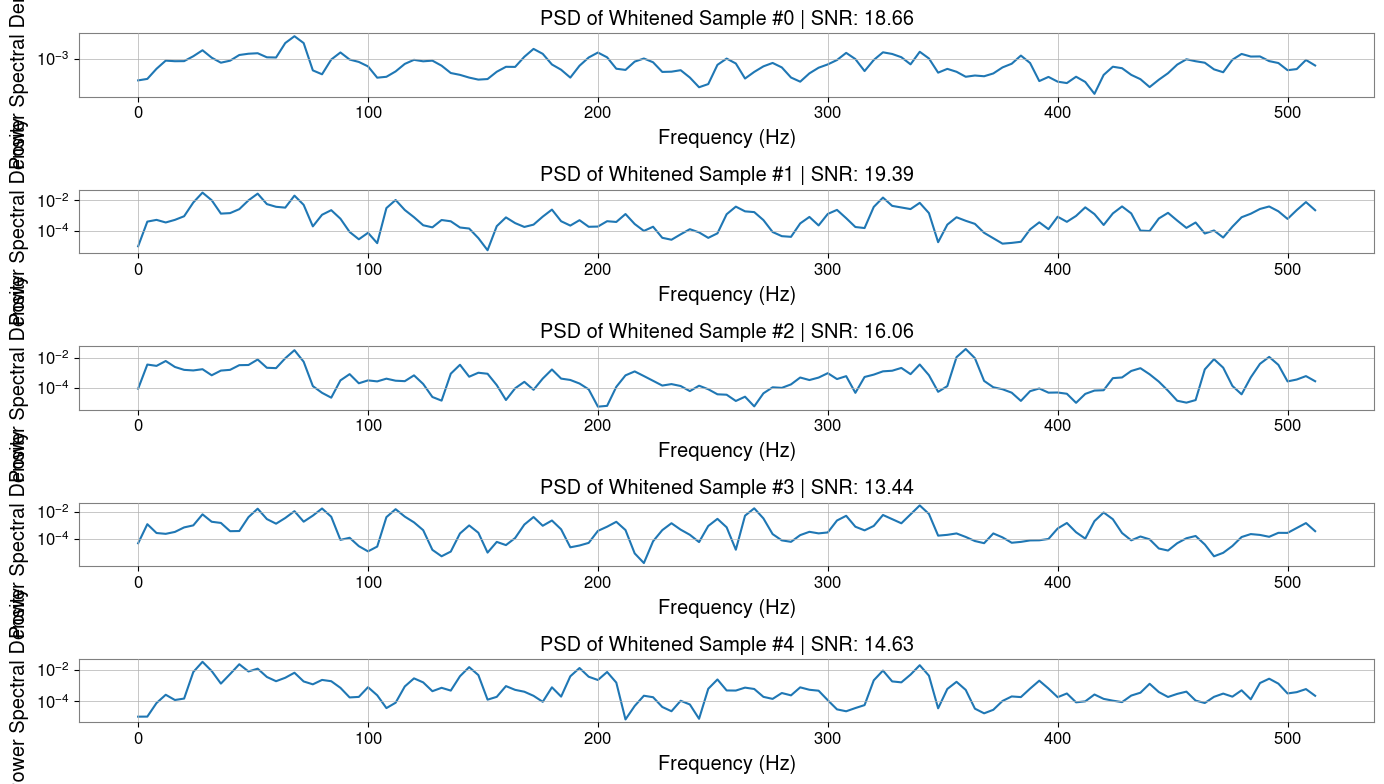

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch


data = np.load("cusp_real_noise_whitened.npz")
X_whitened = data["X"]
snrs = data["snr"]
sample_rate = 1024  # Hz


plt.figure(figsize=(14, 8))

for i in range(5):
    sample = X_whitened[i]
    freqs, psd = welch(sample, fs=sample_rate, nperseg=256)

    plt.subplot(5, 1, i + 1)
    plt.semilogy(freqs, psd)
    plt.title(f"PSD of Whitened Sample #{i} | SNR: {snrs[i]:.2f}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")

plt.tight_layout()
plt.show()


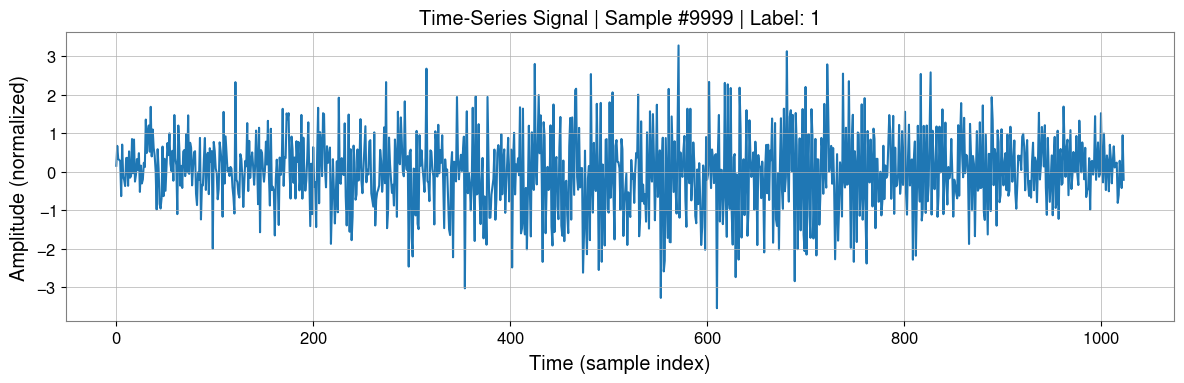

In [8]:
sample_index = 9999 

plt.figure(figsize=(12, 4))
plt.plot(X[sample_index])
plt.title(f"Time-Series Signal | Sample #{sample_index} | Label: {y[sample_index]}")
plt.xlabel("Time (sample index)")
plt.ylabel("Amplitude (normalized)")
plt.grid(True)
plt.tight_layout()
plt.show()